## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤ x  years, depends on data availability), x - y (test, z years)   
  _Need further discussion. Here I divide the dataset by x/y just as the working paper did. Now for the ML model family we do not need to do such split._
  
* LSTM Model
* CNN Model

## Import packages

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
from tensorflow import random
# from tensorflow.random import set_seed

In [4]:
# Set Seed

seed_global = 42

# Source: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

from numpy.random import seed
seed(seed_global)

#  Giving an eror 
# from tensorflow import set_random_seed
# set_random_seed(seed_global)

# Source: https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

tf.random.set_seed(seed_global)

# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tf.random.set_seed(seed_global)

# --Ignore--
# tf.random.set_seed(seed)
# # This is giving me an error

# #  Global Seed
# # random.seed (2019) 

## Get data

In [5]:
%%bigquery gdp_quarterly_q

SELECT *
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Quarterly`
ORDER BY time

In [6]:
gdp_quarterly_q.year = (gdp_quarterly_q.time+40)//4 + 1950
gdp_quarterly_q.quarter = (gdp_quarterly_q.time+40)%4 + 1
gdp_quarterly_q.time = gdp_quarterly_q.year.astype('str') + 'Q' + gdp_quarterly_q.quarter.astype('str')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q)
gdp_quarterly_q.head(5)

country  ifscode    time  gdpwgt  lc  le       llf  lulcm  lur  \
0   United States      111  1950Q1     NaN NaN NaN  0.062128    NaN  NaN   
1  United Kingdom      112  1950Q1     NaN NaN NaN       NaN    NaN  NaN   
2          France      132  1950Q1     NaN NaN NaN       NaN    NaN  NaN   
3         Germany      134  1950Q1     NaN NaN NaN       NaN    NaN  NaN   
4           Italy      136  1950Q1     NaN NaN NaN       NaN    NaN  NaN   

   ncg_r  ...  pcpi_sa  pcpi_sa_pcha  pcpi_sa_pchy      pppgdp  pppsh  \
0    NaN  ...      NaN           NaN           NaN  301.782705    NaN   
1    NaN  ...      NaN           NaN           NaN   72.776393    NaN   
2    NaN  ...      NaN           NaN           NaN   47.016824    NaN   
3    NaN  ...      NaN           NaN           NaN         NaN    NaN   
4    NaN  ...      NaN           NaN           NaN         NaN    NaN   

       pppwgt  tmgwgt  tmwgt  txgwgt  txwgt  
0  301.782705     NaN    NaN     NaN    NaN  
1   72.776393     NaN    NaN     NaN    NaN  
2   47.016824     NaN    NaN     NaN    NaN  
3         NaN     NaN    NaN     NaN    NaN  
4         NaN     NaN    NaN     NaN    NaN  

[5 rows x 66 columns]

In [8]:
# Selecting a subset of countries
gdp_quarterly_q.country.unique()

selected_countries = list(gdp_quarterly_q.country.unique())[0:1]
print("\nSelected Countries: \n")
selected_countries

array(['United States', 'United Kingdom', 'France', 'Germany', 'Italy',
       'Canada', 'Japan'], dtype=object)


Selected Countries: 



['United States']

In [9]:
# dataset_2 = gdp_quarterly_q

# for i in selected_countries:
#    dataset_2[i] = gdp_quarterly_q[gdp_quarterly_q['country'] == i]

# https://stackoverflow.com/questions/51583888/concatenate-dataframe-name-with-variable-value-python

In [10]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # random forest model creation

# # Set Seed
# seed(seed_global)
# tensorflow.random.set_seed(seed_global)


# rfr = RandomForestRegressor(n_estimators = 1000)

# rfr.fit(X_train, y_train)

# # predictions
# y_pred = rfr.predict(X_test)

# metrics_mse["random_forest"] =  mean_squared_error(y_test, y_pred)

# print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

In [11]:
# # Variable Importance

# # Top i factors by importance

# i = 20
# importances = rf_reg.feature_importances_
# indices = np.argsort(importances)[-(i-1):]
# features = X.columns

# plt.figure(figsize=(6,6))
# plt.title('Feature Importances - Random Forest Regressor')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')

In [12]:
# Filter data by country

dataset = gdp_quarterly_q[gdp_quarterly_q['country'].isin(selected_countries)]

dataset = pd.DataFrame(dataset)
# print ("#", "column name", "missing values")
# for i in range(len(dataset.columns)):
#     print(i, dataset.columns[i], " ", dataset.iloc[i].isnull().count())

dataset.head(5)

country  ifscode    time  gdpwgt  lc  le       llf  lulcm  lur  \
0   United States      111  1950Q1     NaN NaN NaN  0.062128    NaN  NaN   
7   United States      111  1950Q2     NaN NaN NaN  0.062128    NaN  NaN   
14  United States      111  1950Q3     NaN NaN NaN  0.062128    NaN  NaN   
21  United States      111  1950Q4     NaN NaN NaN  0.062128    NaN  NaN   
28  United States      111  1951Q1     NaN NaN NaN  0.062002    NaN  NaN   

    ncg_r  ...  pcpi_sa  pcpi_sa_pcha  pcpi_sa_pchy      pppgdp  pppsh  \
0     NaN  ...      NaN           NaN           NaN  301.782705    NaN   
7     NaN  ...      NaN           NaN           NaN  301.782705    NaN   
14    NaN  ...      NaN           NaN           NaN  301.782705    NaN   
21    NaN  ...      NaN           NaN           NaN  301.782705    NaN   
28    NaN  ...      NaN           NaN           NaN  348.993057    NaN   

        pppwgt    tmgwgt      tmwgt     txgwgt      txwgt  
0   301.782705       NaN        NaN        NaN        NaN  
7   301.782705       NaN        NaN        NaN        NaN  
14  301.782705       NaN        NaN        NaN        NaN  
21  301.782705       NaN        NaN        NaN        NaN  
28  348.993057  8.709073  11.508033  10.159067  12.875869  

[5 rows x 66 columns]

## Process data

In [13]:
dataset_input = dataset
dataset_input = dataset_input.drop(columns = ['country', 'ifscode', 'time', 'ngdp_r_sa_pcha', 'ngdp_r_sa_pchy', 'ngdp_dpchy'])
dataset_input.tail(5)

gdpwgt       lc          le       llf    lulcm       lur   ncg_r  \
1897  18155.700000  10628.0  153.952333  0.160311  110.571  4.133333  2565.6   
1904  18819.741667  10786.0  154.951667  0.162071  111.839  4.066667  2578.3   
1911  18819.741667  10876.1  155.449000  0.162071  110.132  3.900000  2592.0   
1918  18819.741667  10994.3  155.879000  0.162071  110.681  3.800000  2606.0   
1925  18819.741667  11057.4  156.776667  0.162071  111.370  3.800000  2605.7   

      ncg_rpch    ncp_r  ncp_rpch  ...     pcpi_sa  pcpi_sa_pcha  \
1897  0.469925  12729.7  1.139334  ...  247.273333      3.141889   
1904  0.495011  12782.9  0.417920  ...  249.250333      3.236639   
1911  0.531358  12909.2  0.988039  ...  250.578667      2.148827   
1918  0.540123  13019.8  0.856753  ...  251.828667      2.010362   
1925 -0.011512  13066.3  0.357148  ...  252.759000      1.485933   

      pcpi_sa_pchy    pppgdp      pppsh    pppwgt    tmgwgt     tmwgt  \
1897      2.109865  19519.40  15.284951  19519.40  2221.075  2739.425   
1904      2.222997  20580.25  15.195560  20580.25  2379.800  2932.075   
1911      2.668825  20580.25  15.195560  20580.25  2379.800  2932.075   
1918      2.632912  20580.25  15.195560  20580.25  2379.800  2932.075   
1925      2.218463  20580.25  15.195560  20580.25  2379.800  2932.075   

        txgwgt     txwgt  
1897  1444.025  2220.625  
1904  1538.375  2356.725  
1911  1538.375  2356.725  
1918  1538.375  2356.725  
1925  1538.375  2356.725  

[5 rows x 60 columns]

In [14]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha

outcome_variable = "ngdp_r_sa_pcha"
predicted_variable = "1_step_ahead_" + outcome_variable

dataset_1 = dataset_input
dataset_1["time"] = dataset["time"]
# dataset_1[num_cols] = dataset[num_cols]
dataset_1[outcome_variable] = dataset[outcome_variable]

dataset_1[predicted_variable] = dataset_1[outcome_variable].shift(-1)

# # Source: https://stackoverflow.com/questions/20095673/shift-column-in-pandas-dataframe-up-by-one

dataset_1 = dataset_1[:-1] 

dataset_1.tail(5)

gdpwgt       lc          le       llf    lulcm       lur   ncg_r  \
1890  18155.700000  10456.7  153.815333  0.160311  110.185  4.300000  2553.6   
1897  18155.700000  10628.0  153.952333  0.160311  110.571  4.133333  2565.6   
1904  18819.741667  10786.0  154.951667  0.162071  111.839  4.066667  2578.3   
1911  18819.741667  10876.1  155.449000  0.162071  110.132  3.900000  2592.0   
1918  18819.741667  10994.3  155.879000  0.162071  110.681  3.800000  2606.0   

      ncg_rpch    ncp_r  ncp_rpch  ...    pppgdp      pppsh    pppwgt  \
1890  0.145104  12586.3  0.586595  ...  19519.40  15.284951  19519.40   
1897  0.469925  12729.7  1.139334  ...  19519.40  15.284951  19519.40   
1904  0.495011  12782.9  0.417920  ...  20580.25  15.195560  20580.25   
1911  0.531358  12909.2  0.988039  ...  20580.25  15.195560  20580.25   
1918  0.540123  13019.8  0.856753  ...  20580.25  15.195560  20580.25   

        tmgwgt     tmwgt    txgwgt     txwgt    time  ngdp_r_sa_pcha  \
1890  2221.075  2739.425  1444.025  2220.625  2017Q3        3.202964   
1897  2221.075  2739.425  1444.025  2220.625  2017Q4        3.545494   
1904  2379.800  2932.075  1538.375  2356.725  2018Q1        2.552107   
1911  2379.800  2932.075  1538.375  2356.725  2018Q2        3.512025   
1918  2379.800  2932.075  1538.375  2356.725  2018Q3        2.926498   

      1_step_ahead_ngdp_r_sa_pcha  
1890                     3.545494  
1897                     2.552107  
1904                     3.512025  
1911                     2.926498  
1918                     1.089155  

[5 rows x 63 columns]

In [15]:
# Output Columns

# ngdp_r_sa_pcha: WEO: Gross domestic product, constant prices, seasonally adjusted, quarter-over-quarter percent change, annualized (Percent, Units).

dataset_Y = dataset_1[["time", predicted_variable]]
dataset_Y.tail(5)

time  1_step_ahead_ngdp_r_sa_pcha
1890  2017Q3                     3.545494
1897  2017Q4                     2.552107
1904  2018Q1                     3.512025
1911  2018Q2                     2.926498
1918  2018Q3                     1.089155

In [16]:
# Window size and crearting the lagged columns

#  Using a lag = 0 for identifying initial variable importance by fitting a randowm forest 
# window size 
lag = 10
dataset_input_l = dataset_1

# Drop the 1) preducted outcome variable and 2) time variable 

dataset_input_l = dataset_input_l.drop(columns = ["time", predicted_variable])

print("Before adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

# Lagging each column in num_columns by the entire range of lag factors

for j in dataset_input_l.columns:
    for i in range(1, (lag + 1), 1):
        new_col = str(j)+"-"+str(i)
        dataset_input_l[str(new_col)] = dataset_input_l[str(j)].shift(i)
    
print("After adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

Before adding the lagged variables to the input dataset: 


gdpwgt       lc          le       llf    lulcm       lur   ncg_r  \
1890  18155.700000  10456.7  153.815333  0.160311  110.185  4.300000  2553.6   
1897  18155.700000  10628.0  153.952333  0.160311  110.571  4.133333  2565.6   
1904  18819.741667  10786.0  154.951667  0.162071  111.839  4.066667  2578.3   
1911  18819.741667  10876.1  155.449000  0.162071  110.132  3.900000  2592.0   
1918  18819.741667  10994.3  155.879000  0.162071  110.681  3.800000  2606.0   

      ncg_rpch    ncp_r  ncp_rpch  ...  pcpi_sa_pcha  pcpi_sa_pchy    pppgdp  \
1890  0.145104  12586.3  0.586595  ...      2.153214      1.981427  19519.40   
1897  0.469925  12729.7  1.139334  ...      3.141889      2.109865  19519.40   
1904  0.495011  12782.9  0.417920  ...      3.236639      2.222997  20580.25   
1911  0.531358  12909.2  0.988039  ...      2.148827      2.668825  20580.25   
1918  0.540123  13019.8  0.856753  ...      2.010362      2.632912  20580.25   

          pppsh    pppwgt    tmgwgt     tmwgt    txgwgt     txwgt  \
1890  15.284951  19519.40  2221.075  2739.425  1444.025  2220.625   
1897  15.284951  19519.40  2221.075  2739.425  1444.025  2220.625   
1904  15.195560  20580.25  2379.800  2932.075  1538.375  2356.725   
1911  15.195560  20580.25  2379.800  2932.075  1538.375  2356.725   
1918  15.195560  20580.25  2379.800  2932.075  1538.375  2356.725   

      ngdp_r_sa_pcha  
1890        3.202964  
1897        3.545494  
1904        2.552107  
1911        3.512025  
1918        2.926498  

[5 rows x 61 columns]

After adding the lagged variables to the input dataset: 


gdpwgt       lc          le       llf    lulcm       lur   ncg_r  \
1890  18155.700000  10456.7  153.815333  0.160311  110.185  4.300000  2553.6   
1897  18155.700000  10628.0  153.952333  0.160311  110.571  4.133333  2565.6   
1904  18819.741667  10786.0  154.951667  0.162071  111.839  4.066667  2578.3   
1911  18819.741667  10876.1  155.449000  0.162071  110.132  3.900000  2592.0   
1918  18819.741667  10994.3  155.879000  0.162071  110.681  3.800000  2606.0   

      ncg_rpch    ncp_r  ncp_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
1890  0.145104  12586.3  0.586595  ...          2.152692          2.288202   
1897  0.469925  12729.7  1.139334  ...          3.202964          2.152692   
1904  0.495011  12782.9  0.417920  ...          3.545494          3.202964   
1911  0.531358  12909.2  0.988039  ...          2.552107          3.545494   
1918  0.540123  13019.8  0.856753  ...          3.512025          2.552107   

      ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
1890          2.024769          2.187866          1.895214          2.027962   
1897          2.288202          2.024769          2.187866          1.895214   
1904          2.152692          2.288202          2.024769          2.187866   
1911          3.202964          2.152692          2.288202          2.024769   
1918          3.545494          3.202964          2.152692          2.288202   

      ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
1890          0.130624          1.327969          2.998835           3.177823  
1897          2.027962          0.130624          1.327969           2.998835  
1904          1.895214          2.027962          0.130624           1.327969  
1911          2.187866          1.895214          2.027962           0.130624  
1918          2.024769          2.187866          1.895214           2.027962  

[5 rows x 671 columns]

In [17]:
# Combining Input and Output Values

# X1 = dataset_input
# X = pd.concat([X1, X2, dataset_Y], axis=1)
X = pd.concat([dataset_Y, dataset_input_l], axis=1)
X.head(5)
X.shape

print("\nColumns names:\n")
X.columns

time  1_step_ahead_ngdp_r_sa_pcha  gdpwgt  lc  le       llf  lulcm  lur  \
0   1950Q1                          NaN     NaN NaN NaN  0.062128    NaN  NaN   
7   1950Q2                          NaN     NaN NaN NaN  0.062128    NaN  NaN   
14  1950Q3                          NaN     NaN NaN NaN  0.062128    NaN  NaN   
21  1950Q4                          NaN     NaN NaN NaN  0.062128    NaN  NaN   
28  1951Q1                          NaN     NaN NaN NaN  0.062002    NaN  NaN   

    ncg_r  ncg_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
0     NaN       NaN  ...               NaN               NaN   
7     NaN       NaN  ...               NaN               NaN   
14    NaN       NaN  ...               NaN               NaN   
21    NaN       NaN  ...               NaN               NaN   
28    NaN       NaN  ...               NaN               NaN   

    ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
0                NaN               NaN               NaN               NaN   
7                NaN               NaN               NaN               NaN   
14               NaN               NaN               NaN               NaN   
21               NaN               NaN               NaN               NaN   
28               NaN               NaN               NaN               NaN   

    ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
0                NaN               NaN               NaN                NaN  
7                NaN               NaN               NaN                NaN  
14               NaN               NaN               NaN                NaN  
21               NaN               NaN               NaN                NaN  
28               NaN               NaN               NaN                NaN  

[5 rows x 673 columns]

(275, 673)


Columns names:



Index(['time', '1_step_ahead_ngdp_r_sa_pcha', 'gdpwgt', 'lc', 'le', 'llf',
       'lulcm', 'lur', 'ncg_r', 'ncg_rpch',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=673)

In [18]:
# Dropping all rows with missing data
print("\nAfter dropping rows with missing data")
# X = X.iloc[lag:]
# X = X.iloc[:-1]
X = X.dropna()
X.shape
X.head(5)
X.tail(5)


After dropping rows with missing data


(145, 673)

time  1_step_ahead_ngdp_r_sa_pcha    gdpwgt      lc          le  \
910  1982Q3                     0.158923  2897.225  1904.8   99.543333   
917  1982Q4                     5.373663  2897.225  1918.1   99.119667   
924  1983Q1                     9.421777  3136.050  1947.2   99.143000   
931  1983Q2                     8.238399  3136.050  1986.3   99.945000   
938  1983Q3                     8.609839  3136.050  2029.6  101.610667   

          llf   lulcm        lur   ncg_r  ncg_rpch  ...  ngdp_r_sa_pcha-1  \
910  0.110231  92.663   9.900000  1515.5  1.026598  ...          1.837425   
917  0.110231  93.691  10.666667  1532.7  1.134939  ...         -1.520719   
924  0.111528  92.971  10.366667  1549.5  1.096105  ...          0.158923   
931  0.111528  92.457  10.133333  1561.6  0.780897  ...          5.373663   
938  0.111528  91.532   9.366667  1580.2  1.191086  ...          9.421777   

     ngdp_r_sa_pcha-2  ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  \
910         -6.069358         -4.285831          4.872232         -2.926867   
917          1.837425         -6.069358         -4.285831          4.872232   
924         -1.520719          1.837425         -6.069358         -4.285831   
931          0.158923         -1.520719          1.837425         -6.069358   
938          5.373663          0.158923         -1.520719          1.837425   

     ngdp_r_sa_pcha-6  ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  \
910          8.070747          7.668385         -0.476985         -7.985864   
917         -2.926867          8.070747          7.668385         -0.476985   
924          4.872232         -2.926867          8.070747          7.668385   
931         -4.285831          4.872232         -2.926867          8.070747   
938         -6.069358         -4.285831          4.872232         -2.926867   

     ngdp_r_sa_pcha-10  
910           1.261758  
917          -7.985864  
924          -0.476985  
931           7.668385  
938           8.070747  

[5 rows x 673 columns]

time  1_step_ahead_ngdp_r_sa_pcha        gdpwgt       lc          le  \
1890  2017Q3                     3.545494  18155.700000  10456.7  153.815333   
1897  2017Q4                     2.552107  18155.700000  10628.0  153.952333   
1904  2018Q1                     3.512025  18819.741667  10786.0  154.951667   
1911  2018Q2                     2.926498  18819.741667  10876.1  155.449000   
1918  2018Q3                     1.089155  18819.741667  10994.3  155.879000   

           llf    lulcm       lur   ncg_r  ncg_rpch  ...  ngdp_r_sa_pcha-1  \
1890  0.160311  110.185  4.300000  2553.6  0.145104  ...          2.152692   
1897  0.160311  110.571  4.133333  2565.6  0.469925  ...          3.202964   
1904  0.162071  111.839  4.066667  2578.3  0.495011  ...          3.545494   
1911  0.162071  110.132  3.900000  2592.0  0.531358  ...          2.552107   
1918  0.162071  110.681  3.800000  2606.0  0.540123  ...          3.512025   

      ngdp_r_sa_pcha-2  ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  \
1890          2.288202          2.024769          2.187866          1.895214   
1897          2.152692          2.288202          2.024769          2.187866   
1904          3.202964          2.152692          2.288202          2.024769   
1911          3.545494          3.202964          2.152692          2.288202   
1918          2.552107          3.545494          3.202964          2.152692   

      ngdp_r_sa_pcha-6  ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  \
1890          2.027962          0.130624          1.327969          2.998835   
1897          1.895214          2.027962          0.130624          1.327969   
1904          2.187866          1.895214          2.027962          0.130624   
1911          2.024769          2.187866          1.895214          2.027962   
1918          2.288202          2.024769          2.187866          1.895214   

      ngdp_r_sa_pcha-10  
1890           3.177823  
1897           2.998835  
1904           1.327969  
1911           0.130624  
1918           2.027962  

[5 rows x 673 columns]

In [19]:
# Separating input and output variables

X1 = X

Y1 = X1[predicted_variable]

Y1 = pd.DataFrame(Y1) # very important step, gave me formatting errors, and wasted 2 hour in debugging   

print("\n Outcome variable dimension", Y1.shape)
Y1.shape
Y1.head(5)

# Dropping outcome variable from input matrix
X1 = X1.drop(columns = [predicted_variable])
print("\n Input matrix: X")
X1.shape
X1.head(5)

print("\n columns in input dataset\n:")
X1.columns


 Outcome variable dimension (145, 1)


(145, 1)

1_step_ahead_ngdp_r_sa_pcha
910                     0.158923
917                     5.373663
924                     9.421777
931                     8.238399
938                     8.609839


 Input matrix: X


(145, 672)

time    gdpwgt      lc          le       llf   lulcm        lur  \
910  1982Q3  2897.225  1904.8   99.543333  0.110231  92.663   9.900000   
917  1982Q4  2897.225  1918.1   99.119667  0.110231  93.691  10.666667   
924  1983Q1  3136.050  1947.2   99.143000  0.111528  92.971  10.366667   
931  1983Q2  3136.050  1986.3   99.945000  0.111528  92.457  10.133333   
938  1983Q3  3136.050  2029.6  101.610667  0.111528  91.532   9.366667   

      ncg_r  ncg_rpch   ncp_r  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
910  1515.5  1.026598  4363.3  ...          1.837425         -6.069358   
917  1532.7  1.134939  4439.7  ...         -1.520719          1.837425   
924  1549.5  1.096105  4483.6  ...          0.158923         -1.520719   
931  1561.6  0.780897  4574.9  ...          5.373663          0.158923   
938  1580.2  1.191086  4657.0  ...          9.421777          5.373663   

     ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
910         -4.285831          4.872232         -2.926867          8.070747   
917         -6.069358         -4.285831          4.872232         -2.926867   
924          1.837425         -6.069358         -4.285831          4.872232   
931         -1.520719          1.837425         -6.069358         -4.285831   
938          0.158923         -1.520719          1.837425         -6.069358   

     ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
910          7.668385         -0.476985         -7.985864           1.261758  
917          8.070747          7.668385         -0.476985          -7.985864  
924         -2.926867          8.070747          7.668385          -0.476985  
931          4.872232         -2.926867          8.070747           7.668385  
938         -4.285831          4.872232         -2.926867           8.070747  

[5 rows x 672 columns]


 columns in input dataset
:


Index(['time', 'gdpwgt', 'lc', 'le', 'llf', 'lulcm', 'lur', 'ncg_r',
       'ncg_rpch', 'ncp_r',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=672)

In [20]:
# Random Forest

# Sequential train-test split
train_test_ratio = 0.67

training = int(round(X1.shape[0]*train_test_ratio, 0))
test = X1.shape[0] - training

print("# items in training set:", training)
print("\n# items in test set:", test)

X_train = X1.iloc[0:(training),:]
y_train = Y1.iloc[0:(training),0]
X_test = X1.iloc[training:(X1.shape[0]),:]
y_test = Y1.iloc[training:(X1.shape[0]),0]
y_test_outcome_value = Y1.iloc[training:(X1.shape[0]),:]

print("\n input training set:")
X_train.shape
X_train.head(5)

y_train.head(5)

print("\n input test set:")
X_test.shape
X_test.head(5)

y_test.head(5)
y_test_outcome_value.head(5)

# items in training set: 97

# items in test set: 48

 input training set:


(97, 672)

time    gdpwgt      lc          le       llf   lulcm        lur  \
910  1982Q3  2897.225  1904.8   99.543333  0.110231  92.663   9.900000   
917  1982Q4  2897.225  1918.1   99.119667  0.110231  93.691  10.666667   
924  1983Q1  3136.050  1947.2   99.143000  0.111528  92.971  10.366667   
931  1983Q2  3136.050  1986.3   99.945000  0.111528  92.457  10.133333   
938  1983Q3  3136.050  2029.6  101.610667  0.111528  91.532   9.366667   

      ncg_r  ncg_rpch   ncp_r  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
910  1515.5  1.026598  4363.3  ...          1.837425         -6.069358   
917  1532.7  1.134939  4439.7  ...         -1.520719          1.837425   
924  1549.5  1.096105  4483.6  ...          0.158923         -1.520719   
931  1561.6  0.780897  4574.9  ...          5.373663          0.158923   
938  1580.2  1.191086  4657.0  ...          9.421777          5.373663   

     ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
910         -4.285831          4.872232         -2.926867          8.070747   
917         -6.069358         -4.285831          4.872232         -2.926867   
924          1.837425         -6.069358         -4.285831          4.872232   
931         -1.520719          1.837425         -6.069358         -4.285831   
938          0.158923         -1.520719          1.837425         -6.069358   

     ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
910          7.668385         -0.476985         -7.985864           1.261758  
917          8.070747          7.668385         -0.476985          -7.985864  
924         -2.926867          8.070747          7.668385          -0.476985  
931          4.872232         -2.926867          8.070747           7.668385  
938         -4.285831          4.872232         -2.926867           8.070747  

[5 rows x 672 columns]

910    0.158923
917    5.373663
924    9.421777
931    8.238399
938    8.609839
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64


 input test set:


(48, 672)

time    gdpwgt      lc          le       llf   lulcm       lur  \
1589  2006Q4  12236.20  7624.0  145.606000  0.151394  96.534  4.433333   
1596  2007Q1  13021.65  7806.8  146.135000  0.153119  96.994  4.500000   
1603  2007Q2  13021.65  7845.4  145.850667  0.153119  95.793  4.500000   
1610  2007Q3  13021.65  7885.1  145.943667  0.153119  95.084  4.666667   
1617  2007Q4  13021.65  7978.2  146.271333  0.153119  94.925  4.800000   

       ncg_r  ncg_rpch    ncp_r  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
1589  2443.5  0.846059  10504.5  ...          0.620939          0.938637   
1596  2444.9  0.057295  10563.3  ...          3.449636          0.620939   
1603  2460.5  0.638063  10582.8  ...          0.945307          3.449636   
1610  2472.8  0.499898  10642.5  ...          2.312389          0.945307   
1617  2489.1  0.659172  10672.8  ...          2.189473          2.312389   

      ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
1589          5.427471          2.548700          3.614058          1.859616   
1596          0.938637          5.427471          2.548700          3.614058   
1603          0.620939          0.938637          5.427471          2.548700   
1610          3.449636          0.620939          0.938637          5.427471   
1617          0.945307          3.449636          0.620939          0.938637   

      ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
1589          4.501177          4.067524          3.836396           3.084029  
1596          1.859616          4.501177          4.067524           3.836396  
1603          3.614058          1.859616          4.501177           4.067524  
1610          2.548700          3.614058          1.859616           4.501177  
1617          5.427471          2.548700          3.614058           1.859616  

[5 rows x 672 columns]

1589    0.945307
1596    2.312389
1603    2.189473
1610    2.455478
1617   -2.279453
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64

1_step_ahead_ngdp_r_sa_pcha
1589                     0.945307
1596                     2.312389
1603                     2.189473
1610                     2.455478
1617                    -2.279453

In [21]:
# Scaling the training & test sets 

# Dropping the "time" column

X_train.drop(columns = ['time'], inplace = True)
X_test.drop(columns = ['time'], inplace = True)

train_columns = list(X_train.columns)
# train_columns

# X_test  = X_test.drop(columns = ["time"], inplace = True)

X_train.head(5)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


gdpwgt      lc          le       llf   lulcm        lur   ncg_r  \
910  2897.225  1904.8   99.543333  0.110231  92.663   9.900000  1515.5   
917  2897.225  1918.1   99.119667  0.110231  93.691  10.666667  1532.7   
924  3136.050  1947.2   99.143000  0.111528  92.971  10.366667  1549.5   
931  3136.050  1986.3   99.945000  0.111528  92.457  10.133333  1561.6   
938  3136.050  2029.6  101.610667  0.111528  91.532   9.366667  1580.2   

     ncg_rpch   ncp_r  ncp_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
910  1.026598  4363.3  0.669082  ...          1.837425         -6.069358   
917  1.134939  4439.7  1.750968  ...         -1.520719          1.837425   
924  1.096105  4483.6  0.988806  ...          0.158923         -1.520719   
931  0.780897  4574.9  2.036310  ...          5.373663          0.158923   
938  1.191086  4657.0  1.794575  ...          9.421777          5.373663   

     ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
910         -4.285831          4.872232         -2.926867          8.070747   
917         -6.069358         -4.285831          4.872232         -2.926867   
924          1.837425         -6.069358         -4.285831          4.872232   
931         -1.520719          1.837425         -6.069358         -4.285831   
938          0.158923         -1.520719          1.837425         -6.069358   

     ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
910          7.668385         -0.476985         -7.985864           1.261758  
917          8.070747          7.668385         -0.476985          -7.985864  
924         -2.926867          8.070747          7.668385          -0.476985  
931          4.872232         -2.926867          8.070747           7.668385  
938         -4.285831          4.872232         -2.926867           8.070747  

[5 rows x 671 columns]

In [22]:
# Scaling all the numerical variables
scaler = MinMaxScaler()

# train_columns = list(X_train.columns) # removing 'time' column for feature scaling
# train_columns


print("\nScaled training input dataset:")
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = train_columns)

X_train.head(5)

print("\nScaled test input dataset:")
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = train_columns)

X_test.head(5)


Scaled training input dataset:


gdpwgt        lc        le       llf     lulcm       lur     ncg_r  \
0  0.000000  0.000000  0.009326  0.000000  0.091959  0.886700  0.000000   
1  0.000000  0.002382  0.000000  0.000000  0.168567  1.000000  0.018891   
2  0.025573  0.007595  0.000514  0.031524  0.114912  0.955665  0.037342   
3  0.025573  0.014599  0.018168  0.031524  0.076608  0.921182  0.050632   
4  0.025573  0.022356  0.054834  0.031524  0.007676  0.807882  0.071060   

   ncg_rpch     ncp_r  ncp_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
0  0.761216  0.000000  0.511333  ...          0.417280          0.000000   
1  0.783991  0.012648  0.898015  ...          0.159268          0.510407   
2  0.775827  0.019916  0.625607  ...          0.288318          0.293629   
3  0.709567  0.035030  1.000000  ...          0.688976          0.402055   
4  0.795793  0.048622  0.913600  ...          1.000000          0.738682   

   ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
0          0.115132          0.706313          0.202857          0.912787   
1          0.000000          0.115132          0.706313          0.202857   
2          0.510407          0.000000          0.115132          0.706313   
3          0.293629          0.510407          0.000000          0.115132   
4          0.402055          0.293629          0.510407          0.000000   

   ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
0          0.886813          0.361005          0.000000           0.531239  
1          0.912787          0.886813          0.431355           0.000000  
2          0.202857          0.912787          0.899275           0.431355  
3          0.706313          0.202857          0.922389           0.899275  
4          0.115132          0.706313          0.290619           0.922389  

[5 rows x 671 columns]


Scaled test input dataset:


gdpwgt        lc        le       llf     lulcm       lur     ncg_r  \
0  0.000000  0.000000  0.413340  0.000000  0.095128  0.103261  0.019358   
1  0.119305  0.054238  0.443550  0.161546  0.122325  0.114130  0.025968   
2  0.119305  0.065691  0.427312  0.161546  0.051318  0.114130  0.099622   
3  0.119305  0.077471  0.432623  0.161546  0.009400  0.141304  0.157696   
4  0.119305  0.105095  0.451335  0.161546  0.000000  0.163043  0.234655   

   ncg_rpch     ncp_r  ncp_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
0  0.782466  0.033506  0.885535  ...          0.647165          0.670012   
1  0.525182  0.056100  0.695181  ...          0.850587          0.647165   
2  0.714620  0.063593  0.520215  ...          0.670491          0.850587   
3  0.669553  0.086532  0.697215  ...          0.768803          0.670491   
4  0.721506  0.098175  0.566902  ...          0.759964          0.768803   

   ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
0          0.992820          0.785797          0.862411          0.736243   
1          0.670012          0.992820          0.785797          0.862411   
2          0.647165          0.670012          0.992820          0.785797   
3          0.850587          0.647165          0.670012          0.992820   
4          0.670491          0.850587          0.647165          0.670012   

   ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
0          0.926207          0.895021          0.878400           0.824295  
1          0.736243          0.926207          0.895021           0.878400  
2          0.862411          0.736243          0.926207           0.895021  
3          0.785797          0.862411          0.736243           0.926207  
4          0.992820          0.785797          0.862411           0.736243  

[5 rows x 671 columns]

In [23]:
if 'time' in X_train.columns:
    print("Does not exist")
else:
    print("Does not exist")
    
X_train

# train_cols = X_train.columns

# train_cols

Does not exist


gdpwgt        lc        le       llf     lulcm       lur     ncg_r  \
0   0.000000  0.000000  0.009326  0.000000  0.091959  0.886700  0.000000   
1   0.000000  0.002382  0.000000  0.000000  0.168567  1.000000  0.018891   
2   0.025573  0.007595  0.000514  0.031524  0.114912  0.955665  0.037342   
3   0.025573  0.014599  0.018168  0.031524  0.076608  0.921182  0.050632   
4   0.025573  0.022356  0.054834  0.031524  0.007676  0.807882  0.071060   
..       ...       ...       ...       ...       ...       ...       ...   
92  0.925039  0.934741  0.950243  0.949109  0.316715  0.157635  0.974080   
93  0.925039  0.950451  0.957126  0.949109  0.271332  0.157635  0.974739   
94  1.000000  0.980833  0.975830  1.000000  0.410314  0.123153  1.000000   
95  1.000000  0.989413  0.989441  1.000000  0.379611  0.108374  0.992641   
96  1.000000  1.000000  1.000000  1.000000  0.330352  0.108374  0.996705   

    ncg_rpch     ncp_r  ncp_rpch  ...  ngdp_r_sa_pcha-1  ngdp_r_sa_pcha-2  \
0   0.761216  0.000000  0.511333  ...          0.417280          0.000000   
1   0.783991  0.012648  0.898015  ...          0.159268          0.510407   
2   0.775827  0.019916  0.625607  ...          0.288318          0.293629   
3   0.709567  0.035030  1.000000  ...          0.688976          0.402055   
4   0.795793  0.048622  0.913600  ...          1.000000          0.738682   
..       ...       ...       ...  ...               ...               ...   
92  0.634163  0.957206  0.619015  ...          0.418985          0.682360   
93  0.550664  0.962189  0.378235  ...          0.553782          0.511839   
94  0.746615  0.980978  0.670866  ...          0.471929          0.625094   
95  0.487360  0.989604  0.453178  ...          0.693110          0.556322   
96  0.577563  1.000000  0.489248  ...          0.348225          0.742155   

    ngdp_r_sa_pcha-3  ngdp_r_sa_pcha-4  ngdp_r_sa_pcha-5  ngdp_r_sa_pcha-6  \
0           0.115132          0.706313          0.202857          0.912787   
1           0.000000          0.115132          0.706313          0.202857   
2           0.510407          0.000000          0.115132          0.706313   
3           0.293629          0.510407          0.000000          0.115132   
4           0.402055          0.293629          0.510407          0.000000   
..               ...               ...               ...               ...   
92          0.654367          0.639447          0.590879          0.530720   
93          0.682360          0.654367          0.639447          0.590879   
94          0.511839          0.682360          0.654367          0.639447   
95          0.625094          0.511839          0.682360          0.654367   
96          0.556322          0.625094          0.511839          0.682360   

    ngdp_r_sa_pcha-7  ngdp_r_sa_pcha-8  ngdp_r_sa_pcha-9  ngdp_r_sa_pcha-10  
0           0.886813          0.361005          0.000000           0.531239  
1           0.912787          0.886813          0.431355           0.000000  
2           0.202857          0.912787          0.899275           0.431355  
3           0.706313          0.202857          0.922389           0.899275  
4           0.115132          0.706313          0.290619           0.922389  
..               ...               ...               ...                ...  
92          0.693273          0.841731          0.658839           0.587434  
93          0.530720          0.693273          0.859155           0.658839  
94          0.590879          0.530720          0.727043           0.859155  
95          0.639447          0.590879          0.582385           0.727043  
96          0.654367          0.639447          0.635922           0.582385  

[97 rows x 671 columns]

## Variable selection by Random Forest

In [24]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# random forest model creation
rfr = RandomForestRegressor(n_estimators = 5000)
rfr.fit(X_train, y_train)

# predictions
y_pred = rfr.predict(X_test)

print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Random Forest Test MSE:  8.794497102516218



 Top variables (> 80% variation):  147 
 Total variation explained:  0.800255015178612
Top features: 


Index(['nfb_r-6', 'pcpi_pch-2', 'ncg_rpch', 'nm_rpch-3', 'ngdp_r_sa_ar-4',
       'nmg_rpch-10', 'nfdd_rpch-10', 'nm_rpch-9', 'lur-7', 'ngdp_d_sa_pchy-5',
       ...
       'ncp_rpchy', 'pcpi_pchy', 'ngdp_rpchy-9', 'ncp_rpch-1', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'ncp_rpch', 'nfbrgdp', 'nfi_rpch'],
      dtype='object', length=147)

<Figure size 720x2160 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances - Random Forest Regressor')

<BarContainer object of 147 artists>

([<matplotlib.axis.YTick at 0x7fc9614f85f8>,
 <a list of 147 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

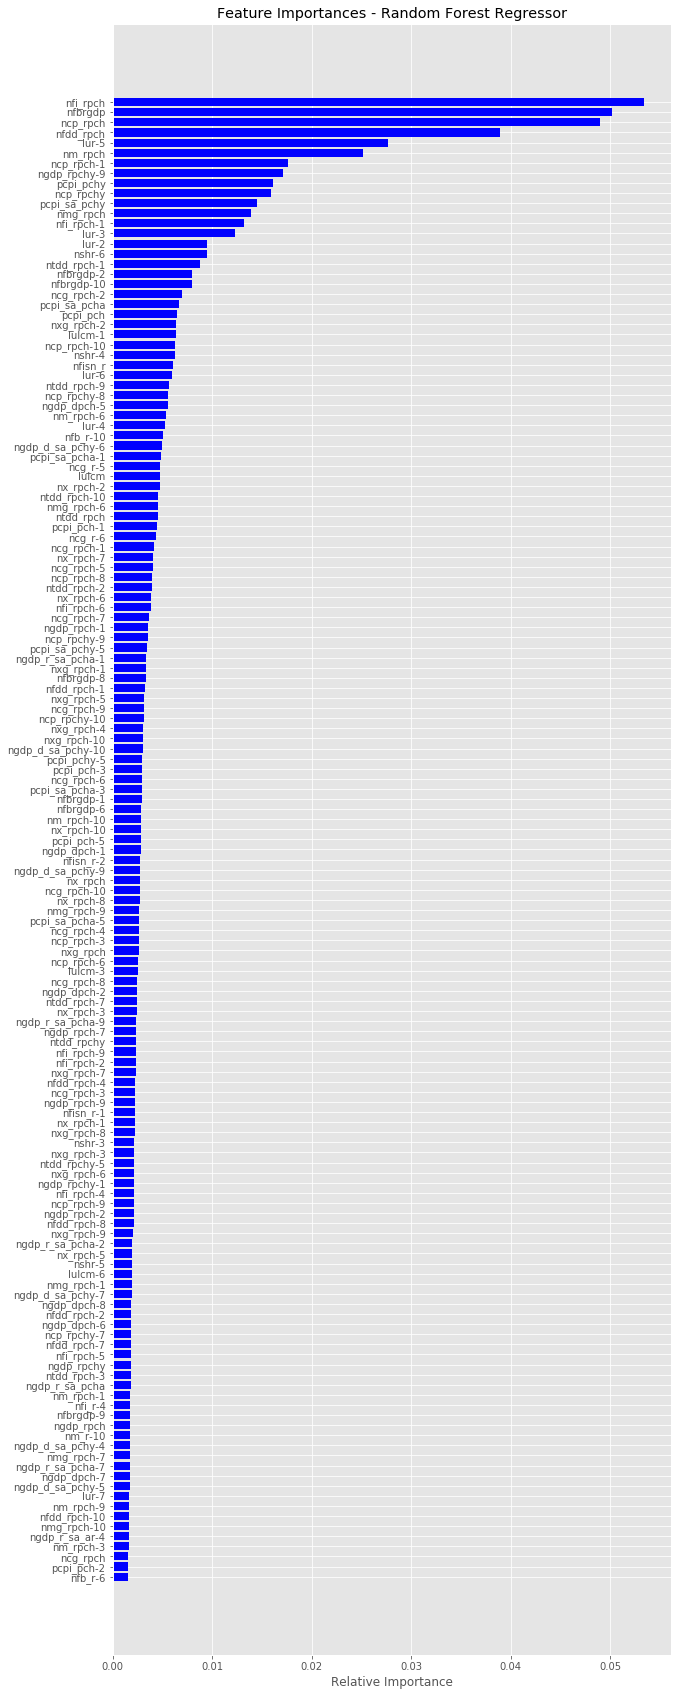

In [25]:
# Variable Importance
# i = 20

importances =  rfr.feature_importances_
top_features = []

imp_1 = sorted(np.array(importances), reverse = True)
sum = 0 
for i in range(len(imp_1)):
    sum = sum + imp_1[i]
    if sum > 0.8:
        n = i
        print("\n Top variables (> 80% variation): ", n+1, "\n Total variation explained: ", sum)
        break
                       
i = n

indices = np.argsort(importances)[-(i+1):]
 
print("Top features: ")

features = X_train.columns

top_features = features[indices]
top_features

plt.figure(figsize=(10,30))
plt.title('Feature Importances - Random Forest Regressor')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [26]:
#  Important features

print("\n Total important variables: ", len(top_features))
print("\n Important features: \n")
top_features


 Total important variables:  147

 Important features: 



Index(['nfb_r-6', 'pcpi_pch-2', 'ncg_rpch', 'nm_rpch-3', 'ngdp_r_sa_ar-4',
       'nmg_rpch-10', 'nfdd_rpch-10', 'nm_rpch-9', 'lur-7', 'ngdp_d_sa_pchy-5',
       ...
       'ncp_rpchy', 'pcpi_pchy', 'ngdp_rpchy-9', 'ncp_rpch-1', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'ncp_rpch', 'nfbrgdp', 'nfi_rpch'],
      dtype='object', length=147)

In [27]:
# Train & Test set with important features from random forest

X_train_random_forest = X_train[top_features]
X_train_random_forest.shape

X_test_random_forest = X_test[top_features]
X_test_random_forest.shape

(97, 147)

(48, 147)

## LSTM

In [28]:
# Reshaping the training, validation, and test sets
X_train_1_all = np.array(X_train_random_forest).reshape(X_train_random_forest.shape[0], X_train_random_forest.shape[1],1)

X_train_1 = X_train_1_all[:77]
print("training set reshaped:", X_train_1.shape)

X_valid_1 = X_train_1_all[77:]
print("validation set reshaped:", X_valid_1.shape)

X_test_1 = np.array(X_test_random_forest).reshape(X_test_random_forest.shape[0], X_test_random_forest.shape[1],1)
print("test set reshaped:", X_test_1.shape)

training set reshaped: (77, 147, 1)
validation set reshaped: (20, 147, 1)
test set reshaped: (48, 147, 1)


In [29]:
y_train_1 = y_train[:77]
print("train set label:", y_train_1.shape)

y_valid_1 = y_train[77:]
print("validation set label:", y_valid_1.shape)

train set label: (77,)
validation set label: (20,)


In [30]:
import wandb
from keras.layers import LSTM
from wandb.keras import WandbCallback

In [30]:
#wandb.init(project='IMF')

## Tuning for nn_units

Set `epoch`=10, `batch_size`=32, `dout_rate`=0.5.

In [31]:
sweep_config_1 = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
                  #'epochs': {'values': [10, 20]},
                  #'batch_size': {'values': [32, 64]},
                  'nn_units_1': {'values': [16, 32, 64]},
                  'nn_units_2': {'values': [16, 32, 64]},
                  'nn_units_3': {'values': [16, 32, 64]},
                  'nn_units_4': {'values': [16, 32, 64]},
                  'nn_units_5': {'values': [16, 32, 64]},
                  'nn_units_6': {'values': [16, 32, 64]},
                  'nn_units_7': {'values': [16, 32, 64]}
                  #'dout_rate': {'values': [0.0, 0.2, 0.4, 0.6]},
    }
}

In [32]:
sweepid_1 = wandb.sweep(sweep_config_1)

Create sweep with ID: t38waev1
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/t38waev1


In [33]:
def train_1():
    
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        #'epochs': 10,
        #'batch_size': 32,
        'nn_units_1': 16,
        'nn_units_2': 16,
        'nn_units_3': 16,
        'nn_units_4': 16,
        'nn_units_5': 16,
        'nn_units_6': 16,
        'nn_units_7': 16
        #'dout_rate': 0.0
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults, tags=['nn_units'])
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = config.nn_units_1, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_2, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_3, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_4, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_5, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_6, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(units = config.nn_units_7))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train_1, epochs = 10, batch_size = 32, 
              validation_data=(X_valid_1, y_valid_1), callbacks=[WandbCallback()])

In [34]:
wandb.agent(sweepid_1, function=train_1)

wandb: Agent Starting Run: i4bknnc6 with config:
	nn_units_7: 16
	nn_units_2: 16
	nn_units_1: 16
	nn_units_6: 16
	nn_units_4: 16
	nn_units_5: 16
	nn_units_3: 16
wandb: Agent Started Run: i4bknnc6


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 7s 94ms/step - loss: 18.4574 - mse: 18.4574 - val_loss: 11.5582 - val_mse: 11.5582
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8908 - mse: 17.8908 - val_loss: 10.8202 - val_mse: 10.8202
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8209 - mse: 16.8209 - val_loss: 9.5685 - val_mse: 9.5685
Epoch 4/10
77/77 [==============================] - 2s 20ms/step - loss: 15.5075 - mse: 15.5075 - val_loss: 8.0279 - val_mse: 8.0279
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 14.0257 - mse: 14.0257 - val_loss: 6.7469 - val_mse: 6.7469
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 12.5565 - mse: 12.5565 - val_loss: 5.7758 - val_mse: 5.7758
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 11.2989 - mse: 11.2989 - val_loss: 5.0366 - val_mse: 5.0366
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4622 - mse: 18.4622 - val_loss: 11.5502 - val_mse: 11.5502
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8359 - mse: 17.8359 - val_loss: 10.6949 - val_mse: 10.6949
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6306 - mse: 16.6306 - val_loss: 9.0206 - val_mse: 9.0206
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.5784 - mse: 14.5784 - val_loss: 6.5078 - val_mse: 6.5078
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5824 - mse: 11.5824 - val_loss: 4.2355 - val_mse: 4.2355
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3193 - mse: 9.3193 - val_loss: 2.9151 - val_mse: 2.9151
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1751 - mse: 7.1751 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5018 - mse: 18.5018 - val_loss: 11.5791 - val_mse: 11.5791
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8650 - mse: 17.8650 - val_loss: 10.5965 - val_mse: 10.5965
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4606 - mse: 16.4606 - val_loss: 8.2615 - val_mse: 8.2615
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8324 - mse: 12.8324 - val_loss: 3.9702 - val_mse: 3.9702
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0705 - mse: 8.0705 - val_loss: 2.6903 - val_mse: 2.6903
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9006 - mse: 5.9006 - val_loss: 4.3011 - val_mse: 4.3011
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7465 - mse: 6.7465 - val_loss: 4.5228 - val_mse: 4.5228
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3030 - mse: 18.3030 - val_loss: 11.3498 - val_mse: 11.3498
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5297 - mse: 17.5297 - val_loss: 10.3363 - val_mse: 10.3363
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.1673 - mse: 16.1673 - val_loss: 8.7164 - val_mse: 8.7164
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3360 - mse: 14.3360 - val_loss: 6.5874 - val_mse: 6.5874
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.9599 - mse: 11.9599 - val_loss: 4.6883 - val_mse: 4.6883
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6769 - mse: 9.6769 - val_loss: 3.4920 - val_mse: 3.4920
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 8.0583 - mse: 8.0583 - val_loss: 2.8373 - val_mse: 2.8373
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5129 - mse: 18.5129 - val_loss: 11.6199 - val_mse: 11.6199
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8809 - mse: 17.8809 - val_loss: 10.8143 - val_mse: 10.8143
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.7054 - mse: 16.7054 - val_loss: 9.0239 - val_mse: 9.0239
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2899 - mse: 14.2899 - val_loss: 5.6154 - val_mse: 5.6154
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 10.4322 - mse: 10.4322 - val_loss: 3.0826 - val_mse: 3.0826
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 7.3448 - mse: 7.3448 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 6.1659 - mse: 6.1659 - val_loss: 2.6410 - val_mse: 2.6410
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5438 - mse: 18.5438 - val_loss: 11.6677 - val_mse: 11.6677
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9394 - mse: 17.9394 - val_loss: 10.6314 - val_mse: 10.6314
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3582 - mse: 16.3582 - val_loss: 7.8877 - val_mse: 7.8877
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4585 - mse: 12.4585 - val_loss: 3.4735 - val_mse: 3.4735
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.7325 - mse: 7.7325 - val_loss: 2.6140 - val_mse: 2.6140
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1027 - mse: 6.1027 - val_loss: 3.6251 - val_mse: 3.6251
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2351 - mse: 6.2351 - val_loss: 3.7763 - val_mse: 3.7763
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5007 - mse: 18.5007 - val_loss: 11.5048 - val_mse: 11.5048
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6861 - mse: 17.6861 - val_loss: 10.3922 - val_mse: 10.3922
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0373 - mse: 16.0373 - val_loss: 7.7110 - val_mse: 7.7110
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7121 - mse: 12.7121 - val_loss: 4.2728 - val_mse: 4.2728
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8677 - mse: 8.8677 - val_loss: 3.0362 - val_mse: 3.0362
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4350 - mse: 7.4350 - val_loss: 2.6520 - val_mse: 2.6520
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9669 - mse: 6.9669 - val_loss: 2.5012 - val_mse: 2.5012
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3982 - mse: 18.3982 - val_loss: 11.2529 - val_mse: 11.2529
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2257 - mse: 17.2257 - val_loss: 9.4303 - val_mse: 9.4303
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6183 - mse: 14.6183 - val_loss: 5.6364 - val_mse: 5.6364
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6776 - mse: 9.6776 - val_loss: 2.6326 - val_mse: 2.6326
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7028 - mse: 6.7028 - val_loss: 2.6463 - val_mse: 2.6463
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8269 - mse: 5.8269 - val_loss: 3.0327 - val_mse: 3.0327
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9830 - mse: 5.9830 - val_loss: 3.3231 - val_mse: 3.3231
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5209 - mse: 18.5209 - val_loss: 11.6291 - val_mse: 11.6291
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.9042 - mse: 17.9042 - val_loss: 10.8366 - val_mse: 10.8366
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8077 - mse: 16.8076 - val_loss: 9.3350 - val_mse: 9.3350
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.8138 - mse: 14.8138 - val_loss: 6.9530 - val_mse: 6.9530
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3436 - mse: 12.3436 - val_loss: 4.9500 - val_mse: 4.9500
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 10.2424 - mse: 10.2424 - val_loss: 3.8582 - val_mse: 3.8582
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 8.7421 - mse: 8.7421 - val_loss: 3.2315 - val_mse: 3.2315
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4427 - mse: 18.4427 - val_loss: 11.4464 - val_mse: 11.4464
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5682 - mse: 17.5682 - val_loss: 10.1913 - val_mse: 10.1913
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.7421 - mse: 15.7421 - val_loss: 7.7004 - val_mse: 7.7004
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0223 - mse: 13.0223 - val_loss: 5.1705 - val_mse: 5.1705
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1616 - mse: 10.1616 - val_loss: 3.6831 - val_mse: 3.6831
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4822 - mse: 8.4822 - val_loss: 2.8720 - val_mse: 2.8720
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1600 - mse: 7.1600 - val_loss: 2.5339 - val_mse: 2.5339
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4497 - mse: 18.4497 - val_loss: 11.4570 - val_mse: 11.4570
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6899 - mse: 17.6899 - val_loss: 10.1734 - val_mse: 10.1734
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5859 - mse: 15.5859 - val_loss: 7.1373 - val_mse: 7.1373
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7209 - mse: 11.7209 - val_loss: 2.8116 - val_mse: 2.8116
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6880 - mse: 6.6880 - val_loss: 3.6528 - val_mse: 3.6528
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3639 - mse: 6.3639 - val_loss: 4.3285 - val_mse: 4.3285
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 6.4194 - mse: 6.4194 - val_loss: 3.6284 - val_mse: 3.6284
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4211 - mse: 18.4211 - val_loss: 11.4363 - val_mse: 11.4363
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6547 - mse: 17.6547 - val_loss: 10.3854 - val_mse: 10.3854
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1822 - mse: 16.1822 - val_loss: 8.5026 - val_mse: 8.5026
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0422 - mse: 14.0422 - val_loss: 6.3065 - val_mse: 6.3065
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5306 - mse: 11.5306 - val_loss: 4.7809 - val_mse: 4.7809
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8105 - mse: 9.8105 - val_loss: 3.9108 - val_mse: 3.9108
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7136 - mse: 8.7136 - val_loss: 3.2950 - val_mse: 3.2950
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5381 - mse: 18.5381 - val_loss: 11.6582 - val_mse: 11.6582
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9587 - mse: 17.9587 - val_loss: 10.8622 - val_mse: 10.8622
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.7301 - mse: 16.7301 - val_loss: 9.0459 - val_mse: 9.0459
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9340 - mse: 13.9340 - val_loss: 5.4064 - val_mse: 5.4064
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9317 - mse: 9.9317 - val_loss: 2.7828 - val_mse: 2.7828
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6971 - mse: 6.6971 - val_loss: 2.5357 - val_mse: 2.5357
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1281 - mse: 6.1281 - val_loss: 2.9636 - val_mse: 2.9636
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4020 - mse: 18.4020 - val_loss: 11.2991 - val_mse: 11.2991
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3022 - mse: 17.3022 - val_loss: 9.3830 - val_mse: 9.3830
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5735 - mse: 14.5735 - val_loss: 5.0301 - val_mse: 5.0301
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8411 - mse: 8.8411 - val_loss: 2.5499 - val_mse: 2.5499
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1441 - mse: 6.1441 - val_loss: 4.2409 - val_mse: 4.2409
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5861 - mse: 6.5861 - val_loss: 4.2581 - val_mse: 4.2581
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4780 - mse: 6.4780 - val_loss: 3.4546 - val_mse: 3.4546
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3775 - mse: 18.3775 - val_loss: 11.0939 - val_mse: 11.0939
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9722 - mse: 16.9722 - val_loss: 8.8827 - val_mse: 8.8827
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8532 - mse: 13.8532 - val_loss: 5.3659 - val_mse: 5.3659
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8560 - mse: 9.8560 - val_loss: 3.1662 - val_mse: 3.1662
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6835 - mse: 7.6835 - val_loss: 2.5470 - val_mse: 2.5470
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6529 - mse: 6.6529 - val_loss: 2.4952 - val_mse: 2.4952
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2663 - mse: 6.2663 - val_loss: 2.6066 - val_mse: 2.6066
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3980 - mse: 18.3980 - val_loss: 10.9809 - val_mse: 10.9809
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7179 - mse: 16.7179 - val_loss: 8.3230 - val_mse: 8.3230
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6945 - mse: 12.6945 - val_loss: 3.4127 - val_mse: 3.4127
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5086 - mse: 7.5086 - val_loss: 2.5849 - val_mse: 2.5849
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6431 - mse: 5.6431 - val_loss: 3.1965 - val_mse: 3.1965
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0310 - mse: 6.0310 - val_loss: 3.8033 - val_mse: 3.8033
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2961 - mse: 6.2961 - val_loss: 3.6250 - val_mse: 3.6250
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4350 - mse: 18.4350 - val_loss: 11.2576 - val_mse: 11.2576
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2458 - mse: 17.2458 - val_loss: 9.0388 - val_mse: 9.0388
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4805 - mse: 13.4805 - val_loss: 3.5908 - val_mse: 3.5908
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8971 - mse: 7.8971 - val_loss: 3.1413 - val_mse: 3.1413
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1235 - mse: 6.1235 - val_loss: 3.6572 - val_mse: 3.6572
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1112 - mse: 6.1112 - val_loss: 3.0169 - val_mse: 3.0169
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0062 - mse: 6.0062 - val_loss: 2.6060 - val_mse: 2.6060
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4424 - mse: 18.4424 - val_loss: 11.3835 - val_mse: 11.3835
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5567 - mse: 17.5567 - val_loss: 9.9486 - val_mse: 9.9486
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6254 - mse: 15.6254 - val_loss: 7.7152 - val_mse: 7.7152
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.2501 - mse: 13.2501 - val_loss: 6.1400 - val_mse: 6.1400
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6005 - mse: 11.6005 - val_loss: 4.9296 - val_mse: 4.9296
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4197 - mse: 10.4197 - val_loss: 3.9674 - val_mse: 3.9674
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2775 - mse: 9.2775 - val_loss: 3.3266 - val_mse: 3.3266
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4940 - mse: 18.4940 - val_loss: 11.5226 - val_mse: 11.5226
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7166 - mse: 17.7166 - val_loss: 10.1046 - val_mse: 10.1046
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5113 - mse: 15.5113 - val_loss: 7.1957 - val_mse: 7.1957
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2658 - mse: 12.2658 - val_loss: 4.9227 - val_mse: 4.9227
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9570 - mse: 9.9570 - val_loss: 3.5436 - val_mse: 3.5436
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1213 - mse: 8.1213 - val_loss: 2.7594 - val_mse: 2.7594
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0836 - mse: 7.0836 - val_loss: 2.4872 - val_mse: 2.4872
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5030 - mse: 18.5030 - val_loss: 11.5841 - val_mse: 11.5841
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8043 - mse: 17.8043 - val_loss: 10.2536 - val_mse: 10.2536
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4846 - mse: 15.4846 - val_loss: 6.3921 - val_mse: 6.3921
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3354 - mse: 10.3354 - val_loss: 2.6830 - val_mse: 2.6830
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9020 - mse: 6.9020 - val_loss: 2.8604 - val_mse: 2.8604
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9594 - mse: 5.9594 - val_loss: 3.3636 - val_mse: 3.3636
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0436 - mse: 6.0436 - val_loss: 3.3334 - val_mse: 3.3334
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4193 - mse: 18.4193 - val_loss: 11.4138 - val_mse: 11.4138
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5016 - mse: 17.5016 - val_loss: 9.9771 - val_mse: 9.9771
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5291 - mse: 15.5291 - val_loss: 7.1734 - val_mse: 7.1734
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4432 - mse: 12.4432 - val_loss: 5.2222 - val_mse: 5.2222
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3459 - mse: 10.3459 - val_loss: 4.2984 - val_mse: 4.2984
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3963 - mse: 9.3963 - val_loss: 3.6626 - val_mse: 3.6626
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2844 - mse: 8.2844 - val_loss: 3.1848 - val_mse: 3.1848
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4825 - mse: 18.4825 - val_loss: 11.4431 - val_mse: 11.4431
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5730 - mse: 17.5730 - val_loss: 9.9507 - val_mse: 9.9507
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1340 - mse: 15.1340 - val_loss: 6.3574 - val_mse: 6.3574
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8214 - mse: 10.8214 - val_loss: 3.1715 - val_mse: 3.1715
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6498 - mse: 7.6498 - val_loss: 2.4966 - val_mse: 2.4966
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5315 - mse: 6.5315 - val_loss: 2.6643 - val_mse: 2.6643
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8022 - mse: 5.8022 - val_loss: 3.0184 - val_mse: 3.0184
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4042 - mse: 18.4042 - val_loss: 11.2665 - val_mse: 11.2665
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2257 - mse: 17.2257 - val_loss: 8.9753 - val_mse: 8.9753
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6110 - mse: 13.6110 - val_loss: 3.8936 - val_mse: 3.8936
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5510 - mse: 7.5510 - val_loss: 2.8355 - val_mse: 2.8355
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0001 - mse: 6.0001 - val_loss: 4.0912 - val_mse: 4.0912
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4150 - mse: 6.4150 - val_loss: 3.8514 - val_mse: 3.8514
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1518 - mse: 6.1518 - val_loss: 3.1697 - val_mse: 3.1697
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3790 - mse: 18.3790 - val_loss: 11.0616 - val_mse: 11.0616
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9007 - mse: 16.9007 - val_loss: 8.4002 - val_mse: 8.4002
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0483 - mse: 13.0483 - val_loss: 4.1334 - val_mse: 4.1334
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5883 - mse: 8.5883 - val_loss: 2.7861 - val_mse: 2.7861
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8524 - mse: 6.8524 - val_loss: 2.5080 - val_mse: 2.5080
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4244 - mse: 6.4244 - val_loss: 2.5018 - val_mse: 2.5018
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0111 - mse: 6.0111 - val_loss: 2.5856 - val_mse: 2.5856
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2989 - mse: 18.2989 - val_loss: 10.8972 - val_mse: 10.8972
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4860 - mse: 16.4860 - val_loss: 7.5499 - val_mse: 7.5499
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9126 - mse: 11.9126 - val_loss: 3.2694 - val_mse: 3.2694
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3353 - mse: 7.3353 - val_loss: 2.5021 - val_mse: 2.5021
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0206 - mse: 6.0206 - val_loss: 3.0217 - val_mse: 3.0217
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8329 - mse: 5.8329 - val_loss: 3.3942 - val_mse: 3.3942
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8703 - mse: 5.8703 - val_loss: 3.4032 - val_mse: 3.4032
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4294 - mse: 18.4294 - val_loss: 11.1280 - val_mse: 11.1280
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8770 - mse: 16.8770 - val_loss: 7.8592 - val_mse: 7.8592
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8368 - mse: 11.8368 - val_loss: 2.7785 - val_mse: 2.7785
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6023 - mse: 6.6023 - val_loss: 3.1636 - val_mse: 3.1636
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2026 - mse: 6.2026 - val_loss: 3.9851 - val_mse: 3.9851
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2138 - mse: 6.2138 - val_loss: 3.3441 - val_mse: 3.3441
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1068 - mse: 6.1068 - val_loss: 2.7278 - val_mse: 2.7278
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4946 - mse: 18.4946 - val_loss: 11.6157 - val_mse: 11.6157
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8892 - mse: 17.8892 - val_loss: 10.7926 - val_mse: 10.7926
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8447 - mse: 16.8447 - val_loss: 9.3119 - val_mse: 9.3119
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0290 - mse: 15.0289 - val_loss: 7.3269 - val_mse: 7.3269
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.1954 - mse: 13.1954 - val_loss: 5.8646 - val_mse: 5.8646
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5521 - mse: 11.5521 - val_loss: 4.8578 - val_mse: 4.8578
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3692 - mse: 10.3692 - val_loss: 4.1264 - val_mse: 4.1264
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5704 - mse: 18.5704 - val_loss: 11.7807 - val_mse: 11.7807
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.1873 - mse: 18.1873 - val_loss: 11.2781 - val_mse: 11.2781
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.4766 - mse: 17.4766 - val_loss: 10.2025 - val_mse: 10.2025
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9683 - mse: 15.9683 - val_loss: 7.9326 - val_mse: 7.9326
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0853 - mse: 13.0853 - val_loss: 4.9201 - val_mse: 4.9201
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7898 - mse: 9.7898 - val_loss: 3.1135 - val_mse: 3.1135
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5707 - mse: 7.5707 - val_loss: 2.5093 - val_mse: 2.5093
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5692 - mse: 18.5692 - val_loss: 11.7536 - val_mse: 11.7536
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1229 - mse: 18.1229 - val_loss: 10.9985 - val_mse: 10.9985
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.9320 - mse: 16.9320 - val_loss: 8.9014 - val_mse: 8.9014
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8171 - mse: 13.8171 - val_loss: 4.3276 - val_mse: 4.3276
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6041 - mse: 8.6041 - val_loss: 2.5389 - val_mse: 2.5389
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9393 - mse: 5.9393 - val_loss: 3.4258 - val_mse: 3.4258
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3327 - mse: 6.3327 - val_loss: 3.9364 - val_mse: 3.9364
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4028 - mse: 18.4028 - val_loss: 11.1644 - val_mse: 11.1644
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1338 - mse: 17.1338 - val_loss: 9.3070 - val_mse: 9.3070
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6253 - mse: 14.6253 - val_loss: 6.5881 - val_mse: 6.5881
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5947 - mse: 11.5947 - val_loss: 4.5975 - val_mse: 4.5975
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6240 - mse: 9.6240 - val_loss: 3.4525 - val_mse: 3.4525
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2546 - mse: 8.2546 - val_loss: 2.8681 - val_mse: 2.8681
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2502 - mse: 7.2502 - val_loss: 2.5980 - val_mse: 2.5980
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4228 - mse: 18.4228 - val_loss: 11.3776 - val_mse: 11.3776
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.4829 - mse: 17.4829 - val_loss: 9.9469 - val_mse: 9.9469
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6387 - mse: 15.6387 - val_loss: 7.4187 - val_mse: 7.4187
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5033 - mse: 12.5033 - val_loss: 4.6157 - val_mse: 4.6157
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 9.2722 - mse: 9.2722 - val_loss: 2.8252 - val_mse: 2.8252
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 7.2128 - mse: 7.2128 - val_loss: 2.5088 - val_mse: 2.5088
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 6.2371 - mse: 6.2371 - val_loss: 2.9134 - val_mse: 2.9134
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5524 - mse: 18.5524 - val_loss: 11.7056 - val_mse: 11.7056
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0097 - mse: 18.0097 - val_loss: 10.7224 - val_mse: 10.7224
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3961 - mse: 16.3961 - val_loss: 7.9676 - val_mse: 7.9676
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6041 - mse: 12.6041 - val_loss: 3.4586 - val_mse: 3.4586
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3875 - mse: 7.3875 - val_loss: 2.7751 - val_mse: 2.7751
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8974 - mse: 5.8974 - val_loss: 4.1266 - val_mse: 4.1266
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.4830 - mse: 6.4830 - val_loss: 4.3012 - val_mse: 4.3012
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4328 - mse: 18.4328 - val_loss: 11.2912 - val_mse: 11.2912
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2126 - mse: 17.2126 - val_loss: 9.3006 - val_mse: 9.3006
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.5225 - mse: 14.5225 - val_loss: 6.2251 - val_mse: 6.2251
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0936 - mse: 11.0936 - val_loss: 4.3898 - val_mse: 4.3898
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1636 - mse: 9.1636 - val_loss: 3.6044 - val_mse: 3.6044
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 8.1532 - mse: 8.1532 - val_loss: 3.0973 - val_mse: 3.0973
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4373 - mse: 7.4373 - val_loss: 2.7559 - val_mse: 2.7559
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5145 - mse: 18.5145 - val_loss: 11.5227 - val_mse: 11.5227
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6214 - mse: 17.6214 - val_loss: 9.8442 - val_mse: 9.8442
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8458 - mse: 14.8458 - val_loss: 5.4997 - val_mse: 5.4997
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8635 - mse: 9.8635 - val_loss: 2.5819 - val_mse: 2.5819
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5336 - mse: 6.5336 - val_loss: 2.6632 - val_mse: 2.6632
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8620 - mse: 5.8620 - val_loss: 3.0576 - val_mse: 3.0576
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0511 - mse: 6.0511 - val_loss: 3.3185 - val_mse: 3.3185
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4408 - mse: 18.4408 - val_loss: 11.4173 - val_mse: 11.4173
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4600 - mse: 17.4600 - val_loss: 9.3168 - val_mse: 9.3168
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9600 - mse: 13.9600 - val_loss: 3.3223 - val_mse: 3.3223
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3398 - mse: 7.3398 - val_loss: 3.7585 - val_mse: 3.7585
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2937 - mse: 6.2937 - val_loss: 3.7715 - val_mse: 3.7715
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0702 - mse: 6.0702 - val_loss: 3.0229 - val_mse: 3.0229
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9254 - mse: 5.9254 - val_loss: 2.6144 - val_mse: 2.6144
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4938 - mse: 18.4938 - val_loss: 11.5331 - val_mse: 11.5331
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.7409 - mse: 17.7409 - val_loss: 10.4844 - val_mse: 10.4844
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3317 - mse: 16.3317 - val_loss: 8.9133 - val_mse: 8.9133
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6381 - mse: 14.6381 - val_loss: 7.6012 - val_mse: 7.6012
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 13.3901 - mse: 13.3901 - val_loss: 6.6186 - val_mse: 6.6186
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3116 - mse: 12.3116 - val_loss: 5.7669 - val_mse: 5.7669
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3554 - mse: 11.3554 - val_loss: 5.0150 - val_mse: 5.0150
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4348 - mse: 18.4348 - val_loss: 11.3240 - val_mse: 11.3240
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4086 - mse: 17.4086 - val_loss: 9.8282 - val_mse: 9.8282
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4352 - mse: 15.4352 - val_loss: 7.6197 - val_mse: 7.6197
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0328 - mse: 13.0328 - val_loss: 5.5634 - val_mse: 5.5634
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8252 - mse: 10.8252 - val_loss: 3.9490 - val_mse: 3.9490
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8687 - mse: 8.8687 - val_loss: 2.9372 - val_mse: 2.9372
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3234 - mse: 7.3234 - val_loss: 2.5279 - val_mse: 2.5279
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4487 - mse: 18.4487 - val_loss: 11.3186 - val_mse: 11.3186
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3098 - mse: 17.3098 - val_loss: 9.5909 - val_mse: 9.5909
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6135 - mse: 14.6135 - val_loss: 5.3529 - val_mse: 5.3529
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3242 - mse: 9.3242 - val_loss: 2.5972 - val_mse: 2.5972
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.5966 - mse: 5.5966 - val_loss: 4.2374 - val_mse: 4.2374
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7015 - mse: 6.7015 - val_loss: 4.7712 - val_mse: 4.7712
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6707 - mse: 6.6707 - val_loss: 4.0006 - val_mse: 4.0006
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3395 - mse: 18.3395 - val_loss: 11.1840 - val_mse: 11.1840
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1118 - mse: 17.1118 - val_loss: 9.4666 - val_mse: 9.4666
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7672 - mse: 14.7672 - val_loss: 6.7046 - val_mse: 6.7046
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.9048 - mse: 11.9048 - val_loss: 4.5419 - val_mse: 4.5419
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6061 - mse: 9.6061 - val_loss: 3.4993 - val_mse: 3.4993
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1904 - mse: 8.1904 - val_loss: 2.9928 - val_mse: 2.9928
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3706 - mse: 7.3706 - val_loss: 2.6915 - val_mse: 2.6915
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4739 - mse: 18.4739 - val_loss: 11.4948 - val_mse: 11.4948
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6836 - mse: 17.6836 - val_loss: 10.1376 - val_mse: 10.1376
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5881 - mse: 15.5881 - val_loss: 7.2252 - val_mse: 7.2252
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0623 - mse: 12.0623 - val_loss: 4.1212 - val_mse: 4.1212
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9135 - mse: 8.9135 - val_loss: 2.6943 - val_mse: 2.6943
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6765 - mse: 6.6765 - val_loss: 2.5220 - val_mse: 2.5220
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.7606 - mse: 5.7606 - val_loss: 2.9177 - val_mse: 2.9177
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4172 - mse: 18.4172 - val_loss: 11.2950 - val_mse: 11.2950
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2542 - mse: 17.2542 - val_loss: 9.1919 - val_mse: 9.1919
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.1436 - mse: 14.1436 - val_loss: 4.8242 - val_mse: 4.8242
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0974 - mse: 9.0974 - val_loss: 2.4994 - val_mse: 2.4994
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1766 - mse: 6.1766 - val_loss: 3.3350 - val_mse: 3.3350
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1404 - mse: 6.1404 - val_loss: 3.9208 - val_mse: 3.9208
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2841 - mse: 6.2841 - val_loss: 3.5597 - val_mse: 3.5597
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5275 - mse: 18.5275 - val_loss: 11.5738 - val_mse: 11.5738
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8496 - mse: 17.8496 - val_loss: 10.4299 - val_mse: 10.4299
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0748 - mse: 16.0748 - val_loss: 7.5702 - val_mse: 7.5702
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1441 - mse: 12.1441 - val_loss: 4.0245 - val_mse: 4.0245
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6714 - mse: 8.6714 - val_loss: 2.9923 - val_mse: 2.9923
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.3577 - mse: 7.3577 - val_loss: 2.6225 - val_mse: 2.6225
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8524 - mse: 6.8524 - val_loss: 2.4885 - val_mse: 2.4885
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4142 - mse: 18.4142 - val_loss: 11.2908 - val_mse: 11.2908
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2922 - mse: 17.2922 - val_loss: 9.0882 - val_mse: 9.0882
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.7064 - mse: 13.7064 - val_loss: 4.7431 - val_mse: 4.7431
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0986 - mse: 9.0986 - val_loss: 2.7566 - val_mse: 2.7566
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8731 - mse: 6.8731 - val_loss: 2.4905 - val_mse: 2.4905
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0318 - mse: 6.0318 - val_loss: 2.7533 - val_mse: 2.7533
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0005 - mse: 6.0005 - val_loss: 3.1352 - val_mse: 3.1352
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4549 - mse: 18.4549 - val_loss: 11.2848 - val_mse: 11.2848
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2540 - mse: 17.2540 - val_loss: 8.7727 - val_mse: 8.7727
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0258 - mse: 13.0258 - val_loss: 3.1654 - val_mse: 3.1654
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1105 - mse: 7.1105 - val_loss: 3.9606 - val_mse: 3.9606
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4770 - mse: 6.4770 - val_loss: 4.3263 - val_mse: 4.3263
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4458 - mse: 6.4458 - val_loss: 3.4221 - val_mse: 3.4221
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9847 - mse: 5.9847 - val_loss: 2.6632 - val_mse: 2.6632
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5073 - mse: 18.5073 - val_loss: 11.5974 - val_mse: 11.5974
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8610 - mse: 17.8610 - val_loss: 10.5337 - val_mse: 10.5337
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2025 - mse: 16.2025 - val_loss: 8.1911 - val_mse: 8.1911
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6658 - mse: 13.6658 - val_loss: 6.1099 - val_mse: 6.1099
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6298 - mse: 11.6298 - val_loss: 4.6317 - val_mse: 4.6317
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1137 - mse: 10.1137 - val_loss: 3.8053 - val_mse: 3.8053
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0014 - mse: 9.0014 - val_loss: 3.2807 - val_mse: 3.2807
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4286 - mse: 18.4286 - val_loss: 11.3006 - val_mse: 11.3006
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.2471 - mse: 17.2471 - val_loss: 9.4795 - val_mse: 9.4795
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5695 - mse: 14.5695 - val_loss: 6.2654 - val_mse: 6.2654
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0299 - mse: 11.0299 - val_loss: 3.8631 - val_mse: 3.8631
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7409 - mse: 8.7409 - val_loss: 2.7733 - val_mse: 2.7733
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9694 - mse: 6.9694 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1936 - mse: 6.1936 - val_loss: 2.6466 - val_mse: 2.6466
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4544 - mse: 18.4544 - val_loss: 11.4654 - val_mse: 11.4654
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6263 - mse: 17.6263 - val_loss: 9.8860 - val_mse: 9.8860
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1304 - mse: 15.1304 - val_loss: 5.7798 - val_mse: 5.7798
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8044 - mse: 9.8044 - val_loss: 2.6294 - val_mse: 2.6294
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2291 - mse: 6.2291 - val_loss: 2.9991 - val_mse: 2.9991
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0755 - mse: 6.0755 - val_loss: 4.0457 - val_mse: 4.0457
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3717 - mse: 6.3717 - val_loss: 3.7989 - val_mse: 3.7989
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3749 - mse: 18.3749 - val_loss: 11.1724 - val_mse: 11.1724
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0548 - mse: 17.0548 - val_loss: 8.9947 - val_mse: 8.9947
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0867 - mse: 14.0867 - val_loss: 5.6589 - val_mse: 5.6589
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7590 - mse: 10.7590 - val_loss: 3.8942 - val_mse: 3.8942
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9459 - mse: 8.9459 - val_loss: 3.1965 - val_mse: 3.1965
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8905 - mse: 7.8905 - val_loss: 2.8393 - val_mse: 2.8393
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3738 - mse: 7.3738 - val_loss: 2.6189 - val_mse: 2.6189
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3705 - mse: 18.3705 - val_loss: 10.9119 - val_mse: 10.9119
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5211 - mse: 16.5211 - val_loss: 7.6579 - val_mse: 7.6579
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2748 - mse: 12.2748 - val_loss: 3.5669 - val_mse: 3.5669
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8600 - mse: 7.8600 - val_loss: 2.5537 - val_mse: 2.5537
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3857 - mse: 6.3857 - val_loss: 2.5383 - val_mse: 2.5383
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0755 - mse: 6.0755 - val_loss: 2.8910 - val_mse: 2.8910
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8791 - mse: 5.8791 - val_loss: 3.2004 - val_mse: 3.2004
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4809 - mse: 18.4809 - val_loss: 11.4126 - val_mse: 11.4126
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4271 - mse: 17.4271 - val_loss: 9.6016 - val_mse: 9.6016
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5645 - mse: 14.5645 - val_loss: 6.1730 - val_mse: 6.1730
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1630 - mse: 11.1630 - val_loss: 4.4316 - val_mse: 4.4316
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2640 - mse: 9.2640 - val_loss: 3.4798 - val_mse: 3.4798
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2019 - mse: 8.2019 - val_loss: 2.9732 - val_mse: 2.9732
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3836 - mse: 7.3836 - val_loss: 2.6755 - val_mse: 2.6755
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1910 - mse: 18.1910 - val_loss: 10.4850 - val_mse: 10.4850
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6446 - mse: 15.6446 - val_loss: 5.8919 - val_mse: 5.8919
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4458 - mse: 9.4458 - val_loss: 2.5130 - val_mse: 2.5130
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9931 - mse: 5.9931 - val_loss: 3.0143 - val_mse: 3.0143
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1677 - mse: 6.1677 - val_loss: 3.7105 - val_mse: 3.7105
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2557 - mse: 6.2557 - val_loss: 3.4757 - val_mse: 3.4757
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1339 - mse: 6.1339 - val_loss: 3.2317 - val_mse: 3.2317
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4587 - mse: 18.4587 - val_loss: 11.2463 - val_mse: 11.2463
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9607 - mse: 16.9607 - val_loss: 8.3595 - val_mse: 8.3595
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0665 - mse: 12.0665 - val_loss: 2.5292 - val_mse: 2.5292
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4109 - mse: 6.4109 - val_loss: 5.5256 - val_mse: 5.5256
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0297 - mse: 7.0297 - val_loss: 3.9565 - val_mse: 3.9565
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2992 - mse: 6.2992 - val_loss: 2.8150 - val_mse: 2.8150
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9901 - mse: 5.9901 - val_loss: 2.5484 - val_mse: 2.5484
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5087 - mse: 18.5087 - val_loss: 11.4873 - val_mse: 11.4873
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6159 - mse: 17.6159 - val_loss: 10.1939 - val_mse: 10.1939
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.7206 - mse: 15.7206 - val_loss: 7.8887 - val_mse: 7.8887
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3117 - mse: 13.3117 - val_loss: 5.9360 - val_mse: 5.9360
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7279 - mse: 11.7279 - val_loss: 4.8902 - val_mse: 4.8902
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4304 - mse: 10.4304 - val_loss: 4.0747 - val_mse: 4.0747
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3941 - mse: 9.3941 - val_loss: 3.4238 - val_mse: 3.4238
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4324 - mse: 18.4324 - val_loss: 11.4689 - val_mse: 11.4689
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6941 - mse: 17.6941 - val_loss: 10.2829 - val_mse: 10.2829
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1057 - mse: 16.1057 - val_loss: 8.5052 - val_mse: 8.5052
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2908 - mse: 14.2908 - val_loss: 6.7370 - val_mse: 6.7370
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3017 - mse: 12.3017 - val_loss: 4.8974 - val_mse: 4.8974
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1086 - mse: 10.1086 - val_loss: 3.6680 - val_mse: 3.6680
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2880 - mse: 8.2880 - val_loss: 2.9830 - val_mse: 2.9830
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5067 - mse: 18.5067 - val_loss: 11.5804 - val_mse: 11.5804
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7881 - mse: 17.7881 - val_loss: 10.3733 - val_mse: 10.3733
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0350 - mse: 16.0350 - val_loss: 7.5597 - val_mse: 7.5597
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7603 - mse: 12.7603 - val_loss: 4.1825 - val_mse: 4.1825
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7846 - mse: 8.7846 - val_loss: 2.5116 - val_mse: 2.5116
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1864 - mse: 6.1864 - val_loss: 2.9578 - val_mse: 2.9578
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0474 - mse: 6.0474 - val_loss: 3.5838 - val_mse: 3.5838
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5332 - mse: 18.5332 - val_loss: 11.5955 - val_mse: 11.5955
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8086 - mse: 17.8086 - val_loss: 10.6190 - val_mse: 10.6190
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3645 - mse: 16.3645 - val_loss: 8.2321 - val_mse: 8.2321
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4329 - mse: 13.4329 - val_loss: 5.0032 - val_mse: 5.0032
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7899 - mse: 9.7899 - val_loss: 2.8955 - val_mse: 2.8955
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9560 - mse: 6.9560 - val_loss: 2.6291 - val_mse: 2.6291
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2358 - mse: 6.2358 - val_loss: 3.7595 - val_mse: 3.7595
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5232 - mse: 18.5232 - val_loss: 11.6201 - val_mse: 11.6201
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8534 - mse: 17.8534 - val_loss: 10.1729 - val_mse: 10.1729
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5722 - mse: 15.5722 - val_loss: 6.5032 - val_mse: 6.5032
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5148 - mse: 11.5148 - val_loss: 3.0922 - val_mse: 3.0922
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1031 - mse: 7.1031 - val_loss: 2.6331 - val_mse: 2.6331
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7702 - mse: 5.7702 - val_loss: 3.8824 - val_mse: 3.8824
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6473 - mse: 6.6473 - val_loss: 4.5009 - val_mse: 4.5009
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5303 - mse: 18.5303 - val_loss: 11.5549 - val_mse: 11.5549
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7154 - mse: 17.7154 - val_loss: 10.0965 - val_mse: 10.0965
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3744 - mse: 15.3744 - val_loss: 6.6558 - val_mse: 6.6558
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6001 - mse: 11.6001 - val_loss: 4.1493 - val_mse: 4.1493
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1129 - mse: 9.1129 - val_loss: 3.1561 - val_mse: 3.1561
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6483 - mse: 7.6483 - val_loss: 2.6877 - val_mse: 2.6877
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6811 - mse: 6.6811 - val_loss: 2.4998 - val_mse: 2.4998
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3697 - mse: 18.3697 - val_loss: 11.1093 - val_mse: 11.1093
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9295 - mse: 16.9295 - val_loss: 8.3628 - val_mse: 8.3628
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1483 - mse: 13.1483 - val_loss: 4.2686 - val_mse: 4.2686
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8828 - mse: 8.8828 - val_loss: 2.7674 - val_mse: 2.7674
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6961 - mse: 6.6961 - val_loss: 2.4835 - val_mse: 2.4835
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1403 - mse: 6.1403 - val_loss: 2.6042 - val_mse: 2.6042
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9755 - mse: 5.9755 - val_loss: 2.9009 - val_mse: 2.9009
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2481 - mse: 18.2481 - val_loss: 10.6504 - val_mse: 10.6504
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0330 - mse: 16.0330 - val_loss: 5.8283 - val_mse: 5.8283
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6198 - mse: 9.6198 - val_loss: 2.6056 - val_mse: 2.6056
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2254 - mse: 6.2254 - val_loss: 3.9778 - val_mse: 3.9778
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2534 - mse: 6.2534 - val_loss: 3.4082 - val_mse: 3.4082
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9352 - mse: 5.9352 - val_loss: 2.7388 - val_mse: 2.7388
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0155 - mse: 6.0155 - val_loss: 2.5372 - val_mse: 2.5372
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4057 - mse: 18.4057 - val_loss: 11.3120 - val_mse: 11.3120
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3899 - mse: 17.3899 - val_loss: 9.6940 - val_mse: 9.6940
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1850 - mse: 15.1850 - val_loss: 7.3032 - val_mse: 7.3032
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9849 - mse: 12.9849 - val_loss: 5.9451 - val_mse: 5.9451
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6821 - mse: 11.6821 - val_loss: 5.0421 - val_mse: 5.0421
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4293 - mse: 10.4293 - val_loss: 4.3319 - val_mse: 4.3319
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4020 - mse: 9.4020 - val_loss: 3.7843 - val_mse: 3.7843
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4097 - mse: 18.4097 - val_loss: 11.2644 - val_mse: 11.2644
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3292 - mse: 17.3293 - val_loss: 9.4721 - val_mse: 9.4721
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9602 - mse: 14.9602 - val_loss: 6.5987 - val_mse: 6.5987
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0032 - mse: 12.0032 - val_loss: 4.7391 - val_mse: 4.7391
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9673 - mse: 9.9673 - val_loss: 3.5316 - val_mse: 3.5316
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4096 - mse: 8.4096 - val_loss: 2.7595 - val_mse: 2.7595
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0754 - mse: 7.0754 - val_loss: 2.4906 - val_mse: 2.4906
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4716 - mse: 18.4716 - val_loss: 11.4504 - val_mse: 11.4504
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5108 - mse: 17.5108 - val_loss: 9.5198 - val_mse: 9.5198
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3033 - mse: 14.3033 - val_loss: 4.5843 - val_mse: 4.5843
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4315 - mse: 8.4315 - val_loss: 2.4919 - val_mse: 2.4919
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1785 - mse: 6.1785 - val_loss: 3.7351 - val_mse: 3.7351
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3605 - mse: 6.3605 - val_loss: 4.2603 - val_mse: 4.2603
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4088 - mse: 6.4088 - val_loss: 3.5817 - val_mse: 3.5817
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4748 - mse: 18.4748 - val_loss: 11.4526 - val_mse: 11.4526
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6143 - mse: 17.6143 - val_loss: 9.8335 - val_mse: 9.8335
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2342 - mse: 15.2342 - val_loss: 6.3992 - val_mse: 6.3992
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2973 - mse: 11.2973 - val_loss: 4.2332 - val_mse: 4.2332
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2517 - mse: 9.2517 - val_loss: 3.3828 - val_mse: 3.3828
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3501 - mse: 8.3501 - val_loss: 2.8121 - val_mse: 2.8121
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1976 - mse: 7.1976 - val_loss: 2.5445 - val_mse: 2.5445
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4568 - mse: 18.4568 - val_loss: 11.2410 - val_mse: 11.2410
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1144 - mse: 17.1144 - val_loss: 8.5432 - val_mse: 8.5432
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8536 - mse: 12.8536 - val_loss: 4.4068 - val_mse: 4.4068
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0183 - mse: 9.0183 - val_loss: 2.8648 - val_mse: 2.8648
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1309 - mse: 7.1309 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4794 - mse: 6.4794 - val_loss: 2.6162 - val_mse: 2.6162
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0011 - mse: 6.0011 - val_loss: 2.9520 - val_mse: 2.9520
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4547 - mse: 18.4547 - val_loss: 11.3051 - val_mse: 11.3051
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2108 - mse: 17.2108 - val_loss: 8.8870 - val_mse: 8.8870
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4835 - mse: 13.4835 - val_loss: 3.6429 - val_mse: 3.6429
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2727 - mse: 7.2727 - val_loss: 2.8037 - val_mse: 2.8037
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0585 - mse: 6.0585 - val_loss: 4.2351 - val_mse: 4.2351
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4897 - mse: 6.4897 - val_loss: 4.2522 - val_mse: 4.2522
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3108 - mse: 6.3108 - val_loss: 3.4790 - val_mse: 3.4790
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3466 - mse: 18.3466 - val_loss: 11.0305 - val_mse: 11.0305
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8130 - mse: 16.8130 - val_loss: 8.4383 - val_mse: 8.4383
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3445 - mse: 13.3445 - val_loss: 5.5208 - val_mse: 5.5208
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4646 - mse: 10.4646 - val_loss: 4.1218 - val_mse: 4.1218
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8365 - mse: 8.8365 - val_loss: 3.2758 - val_mse: 3.2758
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9377 - mse: 7.9377 - val_loss: 2.7832 - val_mse: 2.7832
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1746 - mse: 7.1746 - val_loss: 2.5443 - val_mse: 2.5443
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4625 - mse: 18.4625 - val_loss: 11.3504 - val_mse: 11.3504
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3916 - mse: 17.3916 - val_loss: 9.1459 - val_mse: 9.1459
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6989 - mse: 13.6989 - val_loss: 4.5194 - val_mse: 4.5194
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2382 - mse: 9.2382 - val_loss: 2.8740 - val_mse: 2.8740
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2290 - mse: 7.2290 - val_loss: 2.5221 - val_mse: 2.5221
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3219 - mse: 6.3219 - val_loss: 2.5107 - val_mse: 2.5107
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8936 - mse: 5.8936 - val_loss: 2.7212 - val_mse: 2.7212
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4001 - mse: 18.4001 - val_loss: 10.9350 - val_mse: 10.9350
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3456 - mse: 16.3456 - val_loss: 6.6585 - val_mse: 6.6585
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2984 - mse: 10.2984 - val_loss: 2.5535 - val_mse: 2.5535
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0898 - mse: 6.0898 - val_loss: 3.6402 - val_mse: 3.6402
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1488 - mse: 6.1488 - val_loss: 3.2931 - val_mse: 3.2931
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9210 - mse: 5.9210 - val_loss: 2.9261 - val_mse: 2.9261
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9924 - mse: 5.9924 - val_loss: 2.6962 - val_mse: 2.6962
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4359 - mse: 18.4359 - val_loss: 11.2312 - val_mse: 11.2312
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2662 - mse: 17.2662 - val_loss: 9.2538 - val_mse: 9.2538
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6249 - mse: 14.6249 - val_loss: 6.9053 - val_mse: 6.9053
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5556 - mse: 12.5556 - val_loss: 5.8456 - val_mse: 5.8456
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3460 - mse: 11.3460 - val_loss: 4.9469 - val_mse: 4.9469
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3288 - mse: 10.3288 - val_loss: 4.1958 - val_mse: 4.1958
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3267 - mse: 9.3267 - val_loss: 3.6050 - val_mse: 3.6050
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4086 - mse: 18.4086 - val_loss: 11.1464 - val_mse: 11.1464
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0863 - mse: 17.0863 - val_loss: 8.6914 - val_mse: 8.6914
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3894 - mse: 13.3894 - val_loss: 5.2389 - val_mse: 5.2389
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4175 - mse: 10.4175 - val_loss: 3.5708 - val_mse: 3.5708
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2390 - mse: 8.2390 - val_loss: 2.7107 - val_mse: 2.7107
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0051 - mse: 7.0051 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2339 - mse: 6.2339 - val_loss: 2.6854 - val_mse: 2.6854
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4931 - mse: 18.4931 - val_loss: 11.4082 - val_mse: 11.4082
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4514 - mse: 17.4514 - val_loss: 9.1552 - val_mse: 9.1552
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9347 - mse: 13.9347 - val_loss: 4.8934 - val_mse: 4.8934
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4635 - mse: 9.4635 - val_loss: 2.5101 - val_mse: 2.5101
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2690 - mse: 6.2690 - val_loss: 3.6206 - val_mse: 3.6206
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3085 - mse: 6.3085 - val_loss: 4.6051 - val_mse: 4.6051
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5292 - mse: 6.5292 - val_loss: 4.0040 - val_mse: 4.0040
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2762 - mse: 18.2762 - val_loss: 10.8089 - val_mse: 10.8089
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5044 - mse: 16.5044 - val_loss: 8.0360 - val_mse: 8.0360
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0087 - mse: 13.0087 - val_loss: 5.4145 - val_mse: 5.4145
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5816 - mse: 10.5816 - val_loss: 4.2997 - val_mse: 4.2997
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3810 - mse: 9.3810 - val_loss: 3.5844 - val_mse: 3.5844
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3702 - mse: 8.3702 - val_loss: 3.0763 - val_mse: 3.0763
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6208 - mse: 7.6208 - val_loss: 2.7483 - val_mse: 2.7483
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4538 - mse: 18.4538 - val_loss: 11.2871 - val_mse: 11.2871
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1973 - mse: 17.1973 - val_loss: 8.7544 - val_mse: 8.7544
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4250 - mse: 13.4250 - val_loss: 4.4365 - val_mse: 4.4365
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2490 - mse: 9.2490 - val_loss: 3.0573 - val_mse: 3.0573
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3566 - mse: 7.3566 - val_loss: 2.5333 - val_mse: 2.5333
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6087 - mse: 6.6087 - val_loss: 2.5238 - val_mse: 2.5238
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8955 - mse: 5.8955 - val_loss: 2.7458 - val_mse: 2.7458
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4165 - mse: 18.4165 - val_loss: 10.9409 - val_mse: 10.9409
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5082 - mse: 16.5082 - val_loss: 6.4372 - val_mse: 6.4372
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6072 - mse: 9.6072 - val_loss: 2.5029 - val_mse: 2.5029
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9285 - mse: 5.9285 - val_loss: 4.2319 - val_mse: 4.2319
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4652 - mse: 6.4652 - val_loss: 4.5908 - val_mse: 4.5908
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4893 - mse: 6.4893 - val_loss: 3.4416 - val_mse: 3.4416
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9727 - mse: 5.9727 - val_loss: 2.7906 - val_mse: 2.7906
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4534 - mse: 18.4534 - val_loss: 11.1939 - val_mse: 11.1939
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0079 - mse: 17.0079 - val_loss: 8.5191 - val_mse: 8.5191
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5522 - mse: 13.5522 - val_loss: 5.6613 - val_mse: 5.6613
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7882 - mse: 10.7882 - val_loss: 4.1658 - val_mse: 4.1658
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2177 - mse: 9.2177 - val_loss: 3.3997 - val_mse: 3.3997
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9169 - mse: 7.9169 - val_loss: 2.9195 - val_mse: 2.9195
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2293 - mse: 7.2293 - val_loss: 2.6289 - val_mse: 2.6289
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2215 - mse: 18.2215 - val_loss: 10.3864 - val_mse: 10.3864
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3873 - mse: 15.3873 - val_loss: 4.8787 - val_mse: 4.8787
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1532 - mse: 9.1532 - val_loss: 2.5227 - val_mse: 2.5227
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4436 - mse: 6.4436 - val_loss: 2.7022 - val_mse: 2.7022
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7487 - mse: 5.7487 - val_loss: 3.1187 - val_mse: 3.1187
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1295 - mse: 6.1295 - val_loss: 3.4607 - val_mse: 3.4607
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1057 - mse: 6.1057 - val_loss: 3.4386 - val_mse: 3.4386
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6155 - mse: 18.6155 - val_loss: 11.8464 - val_mse: 11.8464
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1501 - mse: 18.1501 - val_loss: 10.5059 - val_mse: 10.5059
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5708 - mse: 15.5708 - val_loss: 4.8216 - val_mse: 4.8216
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0776 - mse: 8.0776 - val_loss: 3.0547 - val_mse: 3.0547
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 62ms/step - loss: 18.5092 - mse: 18.5092 - val_loss: 11.6645 - val_mse: 11.6645
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.0201 - mse: 18.0201 - val_loss: 10.9755 - val_mse: 10.9755
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.0252 - mse: 17.0252 - val_loss: 9.6553 - val_mse: 9.6553
Epoch 4/10
77/77 [==============================] - 2s 20ms/step - loss: 15.3573 - mse: 15.3573 - val_loss: 7.8649 - val_mse: 7.8649
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5793 - mse: 13.5793 - val_loss: 6.4264 - val_mse: 6.4264
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 12.0227 - mse: 12.0227 - val_loss: 5.3781 - val_mse: 5.3781
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8442 - mse: 10.8442 - val_loss: 4.5353 - val_mse: 4.5353
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5256 - mse: 18.5256 - val_loss: 11.7277 - val_mse: 11.7277
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.1021 - mse: 18.1021 - val_loss: 11.1341 - val_mse: 11.1341
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.2966 - mse: 17.2966 - val_loss: 9.8867 - val_mse: 9.8867
Epoch 4/10
77/77 [==============================] - 2s 20ms/step - loss: 15.7139 - mse: 15.7139 - val_loss: 7.9134 - val_mse: 7.9134
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 13.5261 - mse: 13.5261 - val_loss: 5.8195 - val_mse: 5.8195
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 11.0500 - mse: 11.0500 - val_loss: 4.0550 - val_mse: 4.0550
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1303 - mse: 9.1303 - val_loss: 2.9353 - val_mse: 2.9353
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5381 - mse: 18.5381 - val_loss: 11.7077 - val_mse: 11.7077
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0169 - mse: 18.0169 - val_loss: 10.8743 - val_mse: 10.8743
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.7624 - mse: 16.7624 - val_loss: 8.6273 - val_mse: 8.6273
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3164 - mse: 13.3164 - val_loss: 4.2226 - val_mse: 4.2226
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4133 - mse: 8.4133 - val_loss: 2.5449 - val_mse: 2.5449
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9481 - mse: 5.9481 - val_loss: 4.0365 - val_mse: 4.0365
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4727 - mse: 6.4727 - val_loss: 4.4382 - val_mse: 4.4382
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 62ms/step - loss: 18.5338 - mse: 18.5338 - val_loss: 11.7078 - val_mse: 11.7078
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0526 - mse: 18.0526 - val_loss: 11.0398 - val_mse: 11.0398
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1649 - mse: 17.1649 - val_loss: 9.5946 - val_mse: 9.5946
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2522 - mse: 15.2522 - val_loss: 7.4550 - val_mse: 7.4550
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0443 - mse: 13.0443 - val_loss: 5.9438 - val_mse: 5.9438
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3710 - mse: 11.3710 - val_loss: 4.9880 - val_mse: 4.9880
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1942 - mse: 10.1942 - val_loss: 4.3115 - val_mse: 4.3115
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5266 - mse: 18.5266 - val_loss: 11.6160 - val_mse: 11.6160
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9205 - mse: 17.9205 - val_loss: 10.6852 - val_mse: 10.6852
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.5511 - mse: 16.5511 - val_loss: 8.5479 - val_mse: 8.5479
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9575 - mse: 13.9575 - val_loss: 5.3471 - val_mse: 5.3471
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3212 - mse: 10.3212 - val_loss: 3.1634 - val_mse: 3.1634
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3974 - mse: 7.3974 - val_loss: 2.5259 - val_mse: 2.5259
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2476 - mse: 6.2476 - val_loss: 2.5528 - val_mse: 2.5528
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5139 - mse: 18.5139 - val_loss: 11.5953 - val_mse: 11.5953
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8310 - mse: 17.8310 - val_loss: 10.4410 - val_mse: 10.4410
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0205 - mse: 16.0205 - val_loss: 7.4695 - val_mse: 7.4695
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9488 - mse: 11.9488 - val_loss: 3.2484 - val_mse: 3.2484
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0301 - mse: 7.0301 - val_loss: 2.7144 - val_mse: 2.7144
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0864 - mse: 6.0864 - val_loss: 3.8177 - val_mse: 3.8177
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2754 - mse: 6.2754 - val_loss: 3.6432 - val_mse: 3.6432
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4760 - mse: 18.4760 - val_loss: 11.3003 - val_mse: 11.3003
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3441 - mse: 17.3441 - val_loss: 9.3182 - val_mse: 9.3182
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7812 - mse: 14.7812 - val_loss: 5.7609 - val_mse: 5.7609
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5721 - mse: 10.5721 - val_loss: 3.6428 - val_mse: 3.6428
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1734 - mse: 8.1734 - val_loss: 2.8675 - val_mse: 2.8675
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1330 - mse: 7.1330 - val_loss: 2.5473 - val_mse: 2.5473
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6495 - mse: 6.6495 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5075 - mse: 18.5075 - val_loss: 11.5471 - val_mse: 11.5471
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7126 - mse: 17.7126 - val_loss: 10.2095 - val_mse: 10.2095
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5258 - mse: 15.5259 - val_loss: 6.6680 - val_mse: 6.6680
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7546 - mse: 10.7546 - val_loss: 2.9379 - val_mse: 2.9379
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2142 - mse: 7.2142 - val_loss: 2.5459 - val_mse: 2.5459
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1037 - mse: 6.1037 - val_loss: 3.0012 - val_mse: 3.0012
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0247 - mse: 6.0247 - val_loss: 3.3778 - val_mse: 3.3778
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.5916 - mse: 18.5916 - val_loss: 11.7486 - val_mse: 11.7486
Epoch 4/10
77/77 [==============================] - 2s 20ms/step - loss: 18.0816 - mse: 18.0816 - val_loss: 10.7399 - val_mse: 10.7399
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3515 - mse: 16.3515 - val_loss: 7.0920 - val_mse: 7.0920
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8325 - mse: 10.8325 - val_loss: 2.5254 - val_mse: 2.5254
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8464 - mse: 5.8464 - val_loss: 3.9165 - val_mse: 3.9165
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 62ms/step - loss: 18.5523 - mse: 18.5523 - val_loss: 11.7619 - val_mse: 11.7619
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.1616 - mse: 18.1616 - val_loss: 11.2923 - val_mse: 11.2923
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5090 - mse: 17.5090 - val_loss: 10.3889 - val_mse: 10.3889
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.2175 - mse: 16.2175 - val_loss: 8.7264 - val_mse: 8.7264
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3244 - mse: 14.3244 - val_loss: 6.7645 - val_mse: 6.7645
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4018 - mse: 12.4018 - val_loss: 5.4541 - val_mse: 5.4541
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 10.9051 - mse: 10.9051 - val_loss: 4.6299 - val_mse: 4.6299
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5733 - mse: 18.5733 - val_loss: 11.7692 - val_mse: 11.7692
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1584 - mse: 18.1584 - val_loss: 11.1843 - val_mse: 11.1843
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 17.2772 - mse: 17.2772 - val_loss: 9.8254 - val_mse: 9.8254
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 15.4378 - mse: 15.4378 - val_loss: 7.3075 - val_mse: 7.3075
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6441 - mse: 12.6441 - val_loss: 4.9111 - val_mse: 4.9111
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8928 - mse: 9.8928 - val_loss: 3.3315 - val_mse: 3.3315
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9394 - mse: 7.9394 - val_loss: 2.5619 - val_mse: 2.5619
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5152 - mse: 18.5152 - val_loss: 11.6102 - val_mse: 11.6102
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9262 - mse: 17.9262 - val_loss: 10.4832 - val_mse: 10.4832
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2335 - mse: 16.2335 - val_loss: 7.4886 - val_mse: 7.4886
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3535 - mse: 12.3535 - val_loss: 3.1430 - val_mse: 3.1430
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9756 - mse: 6.9756 - val_loss: 2.9890 - val_mse: 2.9890
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2772 - mse: 6.2772 - val_loss: 4.4007 - val_mse: 4.4007
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5516 - mse: 6.5516 - val_loss: 3.9086 - val_mse: 3.9086
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5859 - mse: 18.5859 - val_loss: 11.7864 - val_mse: 11.7864
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.2065 - mse: 18.2065 - val_loss: 11.2497 - val_mse: 11.2497
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.3886 - mse: 17.3886 - val_loss: 9.9504 - val_mse: 9.9504
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5701 - mse: 15.5701 - val_loss: 7.6026 - val_mse: 7.6026
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.1775 - mse: 13.1775 - val_loss: 5.8765 - val_mse: 5.8765
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3860 - mse: 11.3860 - val_loss: 4.9893 - val_mse: 4.9893
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.2090 - mse: 10.2090 - val_loss: 4.3473 - val_mse: 4.3473
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.6255 - mse: 18.6255 - val_loss: 11.9276 - val_mse: 11.9276
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.3891 - mse: 18.3891 - val_loss: 11.4738 - val_mse: 11.4738
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6731 - mse: 17.6731 - val_loss: 10.3438 - val_mse: 10.3438
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9487 - mse: 15.9487 - val_loss: 7.6531 - val_mse: 7.6531
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6863 - mse: 12.6863 - val_loss: 4.5986 - val_mse: 4.5986
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3902 - mse: 9.3902 - val_loss: 3.1646 - val_mse: 3.1646
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6742 - mse: 7.6742 - val_loss: 2.6456 - val_mse: 2.6456
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4914 - mse: 18.4914 - val_loss: 11.5576 - val_mse: 11.5576
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7245 - mse: 17.7245 - val_loss: 10.1645 - val_mse: 10.1645
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3809 - mse: 15.3809 - val_loss: 6.0504 - val_mse: 6.0504
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7999 - mse: 9.7999 - val_loss: 2.5070 - val_mse: 2.5070
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8237 - mse: 5.8237 - val_loss: 3.7317 - val_mse: 3.7317
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3910 - mse: 6.3910 - val_loss: 4.6406 - val_mse: 4.6406
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7828 - mse: 6.7828 - val_loss: 4.2920 - val_mse: 4.2920
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4482 - mse: 18.4482 - val_loss: 11.4022 - val_mse: 11.4022
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5053 - mse: 17.5053 - val_loss: 9.8913 - val_mse: 9.8913
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3175 - mse: 15.3175 - val_loss: 7.1438 - val_mse: 7.1438
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3911 - mse: 12.3911 - val_loss: 5.6866 - val_mse: 5.6866
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1143 - mse: 11.1143 - val_loss: 4.8119 - val_mse: 4.8119
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9308 - mse: 9.9308 - val_loss: 4.1538 - val_mse: 4.1538
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1151 - mse: 9.1151 - val_loss: 3.6125 - val_mse: 3.6125
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2756 - mse: 18.2756 - val_loss: 10.7472 - val_mse: 10.7472
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3290 - mse: 16.3290 - val_loss: 6.8917 - val_mse: 6.8917
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6643 - mse: 10.6643 - val_loss: 2.6454 - val_mse: 2.6454
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7110 - mse: 6.7110 - val_loss: 2.6645 - val_mse: 2.6645
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8958 - mse: 5.8958 - val_loss: 3.1356 - val_mse: 3.1356
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9397 - mse: 5.9397 - val_loss: 3.3018 - val_mse: 3.3018
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1017 - mse: 6.1017 - val_loss: 3.1592 - val_mse: 3.1592
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4109 - mse: 18.4109 - val_loss: 11.2316 - val_mse: 11.2316
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0480 - mse: 17.0480 - val_loss: 8.4987 - val_mse: 8.4987
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9696 - mse: 12.9696 - val_loss: 3.0147 - val_mse: 3.0147
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6883 - mse: 6.6883 - val_loss: 3.2546 - val_mse: 3.2546
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1437 - mse: 6.1437 - val_loss: 3.8680 - val_mse: 3.8680
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2539 - mse: 6.2539 - val_loss: 3.4093 - val_mse: 3.4093
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9869 - mse: 5.9869 - val_loss: 2.8116 - val_mse: 2.8116
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 62ms/step - loss: 18.3979 - mse: 18.3979 - val_loss: 11.2716 - val_mse: 11.2716
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.2538 - mse: 17.2538 - val_loss: 9.5423 - val_mse: 9.5423
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0189 - mse: 15.0189 - val_loss: 6.7885 - val_mse: 6.7885
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2324 - mse: 12.2324 - val_loss: 4.9565 - val_mse: 4.9565
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3180 - mse: 10.3180 - val_loss: 4.0937 - val_mse: 4.0937
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2456 - mse: 9.2456 - val_loss: 3.5340 - val_mse: 3.5340
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3705 - mse: 8.3705 - val_loss: 3.1887 - val_mse: 3.1887
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5082 - mse: 18.5082 - val_loss: 11.5752 - val_mse: 11.5752
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8312 - mse: 17.8312 - val_loss: 10.4343 - val_mse: 10.4343
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0779 - mse: 16.0779 - val_loss: 7.8399 - val_mse: 7.8399
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0032 - mse: 13.0032 - val_loss: 5.5116 - val_mse: 5.5116
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7973 - mse: 10.7973 - val_loss: 4.1179 - val_mse: 4.1179
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9203 - mse: 8.9203 - val_loss: 3.0964 - val_mse: 3.0964
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5247 - mse: 7.5247 - val_loss: 2.5680 - val_mse: 2.5680
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5121 - mse: 18.5121 - val_loss: 11.5805 - val_mse: 11.5805
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7926 - mse: 17.7926 - val_loss: 10.2602 - val_mse: 10.2602
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7825 - mse: 15.7825 - val_loss: 6.6861 - val_mse: 6.6861
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2187 - mse: 11.2187 - val_loss: 3.1161 - val_mse: 3.1161
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1364 - mse: 7.1364 - val_loss: 2.5692 - val_mse: 2.5692
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1228 - mse: 6.1228 - val_loss: 3.4378 - val_mse: 3.4378
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1496 - mse: 6.1496 - val_loss: 3.7106 - val_mse: 3.7106
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3125 - mse: 18.3125 - val_loss: 10.9280 - val_mse: 10.9280
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6124 - mse: 16.6124 - val_loss: 8.2475 - val_mse: 8.2475
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9903 - mse: 12.9903 - val_loss: 4.4744 - val_mse: 4.4744
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1637 - mse: 9.1637 - val_loss: 2.9727 - val_mse: 2.9727
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4569 - mse: 7.4569 - val_loss: 2.5211 - val_mse: 2.5211
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4470 - mse: 6.4470 - val_loss: 2.5044 - val_mse: 2.5044
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2598 - mse: 6.2598 - val_loss: 2.6449 - val_mse: 2.6449
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5092 - mse: 18.5092 - val_loss: 11.5844 - val_mse: 11.5844
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8175 - mse: 17.8175 - val_loss: 10.3981 - val_mse: 10.3981
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8243 - mse: 15.8243 - val_loss: 7.3775 - val_mse: 7.3775
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0042 - mse: 12.0042 - val_loss: 3.8461 - val_mse: 3.8461
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3894 - mse: 8.3894 - val_loss: 2.6292 - val_mse: 2.6292
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8351 - mse: 6.8351 - val_loss: 2.5201 - val_mse: 2.5201
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0456 - mse: 6.0456 - val_loss: 2.8868 - val_mse: 2.8868
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4815 - mse: 18.4815 - val_loss: 11.4089 - val_mse: 11.4089
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3728 - mse: 17.3728 - val_loss: 9.0047 - val_mse: 9.0047
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5866 - mse: 13.5866 - val_loss: 3.5860 - val_mse: 3.5860
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7265 - mse: 7.7265 - val_loss: 2.6636 - val_mse: 2.6636
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0620 - mse: 6.0620 - val_loss: 3.6466 - val_mse: 3.6466
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2138 - mse: 6.2138 - val_loss: 3.7388 - val_mse: 3.7388
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1690 - mse: 6.1690 - val_loss: 3.2435 - val_mse: 3.2435
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.2709 - mse: 18.2709 - val_loss: 10.8750 - val_mse: 10.8750
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2361 - mse: 16.2361 - val_loss: 7.4056 - val_mse: 7.4056
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6581 - mse: 11.6581 - val_loss: 3.6270 - val_mse: 3.6270
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1487 - mse: 8.1487 - val_loss: 2.8127 - val_mse: 2.8127
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0203 - mse: 7.0203 - val_loss: 2.5167 - val_mse: 2.5167
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3896 - mse: 6.3896 - val_loss: 2.4921 - val_mse: 2.4921
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0296 - mse: 6.0296 - val_loss: 2.5871 - val_mse: 2.5871
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4671 - mse: 18.4671 - val_loss: 11.4430 - val_mse: 11.4430
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4669 - mse: 17.4669 - val_loss: 9.4627 - val_mse: 9.4627
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1763 - mse: 14.1763 - val_loss: 4.3010 - val_mse: 4.3010
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1087 - mse: 8.1087 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1525 - mse: 6.1525 - val_loss: 2.7852 - val_mse: 2.7852
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0448 - mse: 6.0448 - val_loss: 3.1964 - val_mse: 3.1964
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0835 - mse: 6.0835 - val_loss: 3.4494 - val_mse: 3.4494
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6308 - mse: 18.6308 - val_loss: 11.9595 - val_mse: 11.9595
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3984 - mse: 18.3984 - val_loss: 11.3190 - val_mse: 11.3190
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2264 - mse: 17.2264 - val_loss: 8.9700 - val_mse: 8.9700
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4938 - mse: 13.4938 - val_loss: 3.0566 - val_mse: 3.0566
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6600 - mse: 6.6600 - val_loss: 3.8627 - val_mse: 3.8627
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2421 - mse: 6.2421 - val_loss: 3.9053 - val_mse: 3.9053
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2546 - mse: 6.2546 - val_loss: 3.0417 - val_mse: 3.0417
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4853 - mse: 18.4853 - val_loss: 11.5715 - val_mse: 11.5715
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8696 - mse: 17.8696 - val_loss: 10.7285 - val_mse: 10.7285
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6591 - mse: 16.6591 - val_loss: 9.1118 - val_mse: 9.1118
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7031 - mse: 14.7031 - val_loss: 6.9376 - val_mse: 6.9376
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5372 - mse: 12.5372 - val_loss: 5.1846 - val_mse: 5.1846
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6647 - mse: 10.6647 - val_loss: 4.1512 - val_mse: 4.1512
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4717 - mse: 9.4717 - val_loss: 3.4497 - val_mse: 3.4497
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5204 - mse: 18.5204 - val_loss: 11.6476 - val_mse: 11.6476
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9786 - mse: 17.9786 - val_loss: 10.7619 - val_mse: 10.7619
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6899 - mse: 16.6899 - val_loss: 8.8396 - val_mse: 8.8396
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2871 - mse: 14.2871 - val_loss: 6.2797 - val_mse: 6.2797
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7073 - mse: 11.7073 - val_loss: 4.1784 - val_mse: 4.1784
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2605 - mse: 9.2605 - val_loss: 2.8878 - val_mse: 2.8878
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2546 - mse: 7.2546 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5347 - mse: 18.5347 - val_loss: 11.6250 - val_mse: 11.6250
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8475 - mse: 17.8475 - val_loss: 10.3846 - val_mse: 10.3846
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7838 - mse: 15.7838 - val_loss: 6.9589 - val_mse: 6.9589
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6915 - mse: 11.6915 - val_loss: 3.1458 - val_mse: 3.1458
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0246 - mse: 7.0246 - val_loss: 2.5741 - val_mse: 2.5741
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9856 - mse: 5.9856 - val_loss: 3.4122 - val_mse: 3.4122
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2215 - mse: 6.2215 - val_loss: 3.8140 - val_mse: 3.8140
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4344 - mse: 18.4344 - val_loss: 11.2307 - val_mse: 11.2307
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2214 - mse: 17.2214 - val_loss: 9.6532 - val_mse: 9.6532
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1531 - mse: 15.1531 - val_loss: 7.2060 - val_mse: 7.2060
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3037 - mse: 12.3037 - val_loss: 5.0744 - val_mse: 5.0744
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1734 - mse: 10.1734 - val_loss: 3.7421 - val_mse: 3.7421
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6572 - mse: 8.6572 - val_loss: 3.0165 - val_mse: 3.0165
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5876 - mse: 7.5876 - val_loss: 2.6626 - val_mse: 2.6626
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5416 - mse: 18.5416 - val_loss: 11.6800 - val_mse: 11.6800
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9817 - mse: 17.9817 - val_loss: 10.8288 - val_mse: 10.8288
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6122 - mse: 16.6122 - val_loss: 8.8092 - val_mse: 8.8092
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0250 - mse: 14.0250 - val_loss: 5.5664 - val_mse: 5.5664
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5265 - mse: 10.5265 - val_loss: 3.4270 - val_mse: 3.4270
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1303 - mse: 8.1303 - val_loss: 2.6328 - val_mse: 2.6328
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7656 - mse: 6.7656 - val_loss: 2.4890 - val_mse: 2.4890
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4448 - mse: 18.4448 - val_loss: 11.4137 - val_mse: 11.4137
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4382 - mse: 17.4382 - val_loss: 9.6615 - val_mse: 9.6615
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7633 - mse: 14.7634 - val_loss: 4.9731 - val_mse: 4.9731
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7677 - mse: 8.7677 - val_loss: 2.7564 - val_mse: 2.7564
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9188 - mse: 5.9188 - val_loss: 4.4224 - val_mse: 4.4224
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5993 - mse: 6.5993 - val_loss: 3.9997 - val_mse: 3.9997
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2774 - mse: 6.2774 - val_loss: 3.2345 - val_mse: 3.2345
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5042 - mse: 18.5042 - val_loss: 11.5398 - val_mse: 11.5398
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7756 - mse: 17.7756 - val_loss: 10.2902 - val_mse: 10.2902
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7819 - mse: 15.7819 - val_loss: 7.1189 - val_mse: 7.1189
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7501 - mse: 11.7501 - val_loss: 4.0609 - val_mse: 4.0609
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7371 - mse: 8.7371 - val_loss: 2.9176 - val_mse: 2.9176
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2187 - mse: 7.2187 - val_loss: 2.5307 - val_mse: 2.5307
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4317 - mse: 6.4317 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5168 - mse: 18.5168 - val_loss: 11.5089 - val_mse: 11.5089
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.7185 - mse: 17.7185 - val_loss: 10.0761 - val_mse: 10.0761
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2893 - mse: 15.2893 - val_loss: 6.4679 - val_mse: 6.4679
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5942 - mse: 10.5942 - val_loss: 2.8441 - val_mse: 2.8441
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9406 - mse: 6.9406 - val_loss: 2.5710 - val_mse: 2.5710
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0423 - mse: 6.0423 - val_loss: 2.9926 - val_mse: 2.9926
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9213 - mse: 5.9213 - val_loss: 3.3462 - val_mse: 3.3462
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4791 - mse: 18.4791 - val_loss: 11.4695 - val_mse: 11.4695
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5441 - mse: 17.5441 - val_loss: 9.5802 - val_mse: 9.5802
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3102 - mse: 14.3102 - val_loss: 3.9028 - val_mse: 3.9028
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3916 - mse: 8.3916 - val_loss: 3.3254 - val_mse: 3.3254
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2136 - mse: 6.2136 - val_loss: 3.5938 - val_mse: 3.5938
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1771 - mse: 6.1771 - val_loss: 3.0694 - val_mse: 3.0694
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0142 - mse: 6.0142 - val_loss: 2.6526 - val_mse: 2.6526
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5819 - mse: 18.5819 - val_loss: 11.8071 - val_mse: 11.8071
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.2101 - mse: 18.2101 - val_loss: 11.2982 - val_mse: 11.2982
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.4624 - mse: 17.4624 - val_loss: 10.2450 - val_mse: 10.2450
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.1989 - mse: 16.1989 - val_loss: 8.7557 - val_mse: 8.7557
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6254 - mse: 14.6254 - val_loss: 7.6609 - val_mse: 7.6609
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.4765 - mse: 13.4765 - val_loss: 6.6836 - val_mse: 6.6836
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3995 - mse: 12.3995 - val_loss: 5.8082 - val_mse: 5.8082
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5509 - mse: 18.5509 - val_loss: 11.7360 - val_mse: 11.7360
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0442 - mse: 18.0442 - val_loss: 10.9165 - val_mse: 10.9165
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8624 - mse: 16.8624 - val_loss: 8.9669 - val_mse: 8.9669
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.4826 - mse: 14.4826 - val_loss: 6.3774 - val_mse: 6.3774
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6266 - mse: 11.6266 - val_loss: 4.5624 - val_mse: 4.5624
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5434 - mse: 9.5434 - val_loss: 3.4013 - val_mse: 3.4013
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0637 - mse: 8.0637 - val_loss: 2.7332 - val_mse: 2.7332
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4548 - mse: 18.4548 - val_loss: 11.3545 - val_mse: 11.3545
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3642 - mse: 17.3642 - val_loss: 9.4196 - val_mse: 9.4196
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5863 - mse: 14.5863 - val_loss: 4.9390 - val_mse: 4.9390
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0332 - mse: 9.0332 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0499 - mse: 6.0499 - val_loss: 3.4005 - val_mse: 3.4005
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1112 - mse: 6.1112 - val_loss: 4.0114 - val_mse: 4.0114
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4434 - mse: 6.4434 - val_loss: 3.8226 - val_mse: 3.8226
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3177 - mse: 18.3177 - val_loss: 11.0708 - val_mse: 11.0708
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8905 - mse: 16.8905 - val_loss: 8.7958 - val_mse: 8.7958
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6347 - mse: 13.6347 - val_loss: 5.0460 - val_mse: 5.0460
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3783 - mse: 9.3783 - val_loss: 3.1291 - val_mse: 3.1291
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5719 - mse: 7.5719 - val_loss: 2.6652 - val_mse: 2.6652
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6859 - mse: 6.6859 - val_loss: 2.5017 - val_mse: 2.5017
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5193 - mse: 6.5193 - val_loss: 2.4931 - val_mse: 2.4931
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4156 - mse: 18.4156 - val_loss: 11.3711 - val_mse: 11.3711
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4416 - mse: 17.4416 - val_loss: 9.6387 - val_mse: 9.6387
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.1261 - mse: 15.1261 - val_loss: 6.3515 - val_mse: 6.3515
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3007 - mse: 11.3007 - val_loss: 3.8638 - val_mse: 3.8638
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 8.5555 - mse: 8.5555 - val_loss: 2.6760 - val_mse: 2.6760
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 6.7847 - mse: 6.7847 - val_loss: 2.5113 - val_mse: 2.5113
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 6.0263 - mse: 6.0263 - val_loss: 2.8313 - val_mse: 2.8313
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5328 - mse: 18.5328 - val_loss: 11.6129 - val_mse: 11.6129
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8421 - mse: 17.8421 - val_loss: 10.2623 - val_mse: 10.2623
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6540 - mse: 15.6540 - val_loss: 6.5518 - val_mse: 6.5518
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6666 - mse: 10.6666 - val_loss: 2.6111 - val_mse: 2.6111
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0651 - mse: 6.0651 - val_loss: 3.8318 - val_mse: 3.8318
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4764 - mse: 6.4764 - val_loss: 4.7982 - val_mse: 4.7982
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6672 - mse: 6.6672 - val_loss: 3.8396 - val_mse: 3.8396
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6311 - mse: 18.6311 - val_loss: 12.0262 - val_mse: 12.0262
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4948 - mse: 18.4948 - val_loss: 11.5888 - val_mse: 11.5888
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8496 - mse: 17.8496 - val_loss: 10.4839 - val_mse: 10.4839
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0932 - mse: 16.0932 - val_loss: 7.3456 - val_mse: 7.3456
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9236 - mse: 11.9236 - val_loss: 3.8253 - val_mse: 3.8253
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3692 - mse: 18.3692 - val_loss: 10.9373 - val_mse: 10.9373
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6232 - mse: 16.6232 - val_loss: 7.7120 - val_mse: 7.7120
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1213 - mse: 12.1213 - val_loss: 3.4666 - val_mse: 3.4666
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7134 - mse: 7.7134 - val_loss: 2.4860 - val_mse: 2.4860
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1192 - mse: 6.1192 - val_loss: 2.7122 - val_mse: 2.7122
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9049 - mse: 5.9049 - val_loss: 3.1095 - val_mse: 3.1095
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9083 - mse: 5.9083 - val_loss: 3.3403 - val_mse: 3.3403
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4445 - mse: 18.4445 - val_loss: 11.2571 - val_mse: 11.2571
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1569 - mse: 17.1569 - val_loss: 8.2218 - val_mse: 8.2218
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7731 - mse: 11.7731 - val_loss: 2.5786 - val_mse: 2.5786
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4979 - mse: 6.4979 - val_loss: 4.2472 - val_mse: 4.2472
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5353 - mse: 6.5353 - val_loss: 4.1553 - val_mse: 4.1553
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2499 - mse: 6.2499 - val_loss: 3.1307 - val_mse: 3.1307
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9272 - mse: 5.9272 - val_loss: 2.6328 - val_mse: 2.6328
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4921 - mse: 18.4921 - val_loss: 11.5270 - val_mse: 11.5270
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7324 - mse: 17.7324 - val_loss: 10.4378 - val_mse: 10.4378
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0701 - mse: 16.0701 - val_loss: 7.8969 - val_mse: 7.8969
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9969 - mse: 12.9969 - val_loss: 4.8985 - val_mse: 4.8985
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0881 - mse: 10.0881 - val_loss: 3.8036 - val_mse: 3.8036
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0931 - mse: 9.0931 - val_loss: 3.1232 - val_mse: 3.1232
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8957 - mse: 7.8957 - val_loss: 2.6996 - val_mse: 2.6996
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5754 - mse: 18.5754 - val_loss: 11.7715 - val_mse: 11.7715
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1507 - mse: 18.1507 - val_loss: 11.0025 - val_mse: 11.0025
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9624 - mse: 16.9624 - val_loss: 8.7855 - val_mse: 8.7855
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7647 - mse: 13.7647 - val_loss: 5.2221 - val_mse: 5.2221
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2448 - mse: 10.2448 - val_loss: 3.6125 - val_mse: 3.6125
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4040 - mse: 8.4040 - val_loss: 2.7692 - val_mse: 2.7692
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2151 - mse: 7.2151 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6240 - mse: 18.6240 - val_loss: 11.9426 - val_mse: 11.9426
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4069 - mse: 18.4069 - val_loss: 11.4724 - val_mse: 11.4724
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6498 - mse: 17.6498 - val_loss: 10.0503 - val_mse: 10.0503
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1232 - mse: 15.1232 - val_loss: 5.7865 - val_mse: 5.7865
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7400 - mse: 9.7400 - val_loss: 2.4934 - val_mse: 2.4934
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4382 - mse: 18.4382 - val_loss: 11.4269 - val_mse: 11.4269
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6527 - mse: 17.6527 - val_loss: 10.1321 - val_mse: 10.1321
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7479 - mse: 15.7479 - val_loss: 7.9374 - val_mse: 7.9374
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1927 - mse: 13.1927 - val_loss: 5.4667 - val_mse: 5.4667
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7192 - mse: 10.7192 - val_loss: 4.3676 - val_mse: 4.3676
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6951 - mse: 9.6951 - val_loss: 3.7189 - val_mse: 3.7189
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7450 - mse: 8.7450 - val_loss: 3.2423 - val_mse: 3.2423
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3875 - mse: 18.3875 - val_loss: 11.0805 - val_mse: 11.0805
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8212 - mse: 16.8212 - val_loss: 8.5246 - val_mse: 8.5246
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2493 - mse: 13.2493 - val_loss: 4.3456 - val_mse: 4.3456
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7481 - mse: 8.7481 - val_loss: 2.6802 - val_mse: 2.6802
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 7.0031 - mse: 7.0031 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2320 - mse: 6.2320 - val_loss: 2.6627 - val_mse: 2.6627
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0777 - mse: 6.0777 - val_loss: 2.9006 - val_mse: 2.9006
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4039 - mse: 18.4039 - val_loss: 11.2175 - val_mse: 11.2175
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0646 - mse: 17.0646 - val_loss: 8.3534 - val_mse: 8.3534
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6189 - mse: 12.6189 - val_loss: 3.1221 - val_mse: 3.1221
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1270 - mse: 7.1270 - val_loss: 2.7340 - val_mse: 2.7340
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0025 - mse: 6.0025 - val_loss: 3.8676 - val_mse: 3.8676
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3125 - mse: 6.3125 - val_loss: 3.6131 - val_mse: 3.6131
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0734 - mse: 6.0734 - val_loss: 3.0243 - val_mse: 3.0243
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5665 - mse: 18.5665 - val_loss: 11.6476 - val_mse: 11.6476
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8837 - mse: 17.8837 - val_loss: 10.4548 - val_mse: 10.4548
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7330 - mse: 15.7330 - val_loss: 6.8939 - val_mse: 6.8939
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4004 - mse: 11.4004 - val_loss: 3.9361 - val_mse: 3.9361
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7552 - mse: 8.7552 - val_loss: 3.2440 - val_mse: 3.2440
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8073 - mse: 7.8073 - val_loss: 2.8455 - val_mse: 2.8455
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0069 - mse: 7.0069 - val_loss: 2.5931 - val_mse: 2.5931
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4633 - mse: 18.4633 - val_loss: 11.3650 - val_mse: 11.3650
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4043 - mse: 17.4043 - val_loss: 9.2113 - val_mse: 9.2113
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0702 - mse: 14.0702 - val_loss: 4.5363 - val_mse: 4.5363
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6027 - mse: 8.6026 - val_loss: 2.6052 - val_mse: 2.6052
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6652 - mse: 6.6652 - val_loss: 2.5551 - val_mse: 2.5551
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0983 - mse: 6.0983 - val_loss: 2.8937 - val_mse: 2.8937
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9563 - mse: 5.9563 - val_loss: 3.1521 - val_mse: 3.1521
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3910 - mse: 18.3910 - val_loss: 10.9965 - val_mse: 10.9965
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6350 - mse: 16.6350 - val_loss: 7.0441 - val_mse: 7.0441
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0323 - mse: 10.0323 - val_loss: 2.6208 - val_mse: 2.6208
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9210 - mse: 5.9210 - val_loss: 3.9986 - val_mse: 3.9986
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2244 - mse: 6.2244 - val_loss: 3.5410 - val_mse: 3.5410
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9380 - mse: 5.9380 - val_loss: 2.8327 - val_mse: 2.8327
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9752 - mse: 5.9752 - val_loss: 2.5899 - val_mse: 2.5899
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.2122 - mse: 18.2122 - val_loss: 10.8058 - val_mse: 10.8058
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7269 - mse: 16.7269 - val_loss: 8.9415 - val_mse: 8.9415
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6301 - mse: 14.6301 - val_loss: 7.1994 - val_mse: 7.1994
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8424 - mse: 12.8424 - val_loss: 5.7622 - val_mse: 5.7622
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4023 - mse: 11.4023 - val_loss: 4.4655 - val_mse: 4.4655
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9373 - mse: 9.9373 - val_loss: 3.5754 - val_mse: 3.5754
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6199 - mse: 8.6199 - val_loss: 3.0642 - val_mse: 3.0642
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5484 - mse: 18.5484 - val_loss: 11.6948 - val_mse: 11.6948
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0126 - mse: 18.0126 - val_loss: 10.9215 - val_mse: 10.9215
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8924 - mse: 16.8924 - val_loss: 9.0276 - val_mse: 9.0276
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.4583 - mse: 14.4583 - val_loss: 5.8336 - val_mse: 5.8336
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2232 - mse: 11.2232 - val_loss: 3.6885 - val_mse: 3.6885
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5018 - mse: 8.5018 - val_loss: 2.6513 - val_mse: 2.6513
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6981 - mse: 6.6981 - val_loss: 2.5057 - val_mse: 2.5057
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5016 - mse: 18.5016 - val_loss: 11.5143 - val_mse: 11.5143
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6838 - mse: 17.6838 - val_loss: 10.1131 - val_mse: 10.1131
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4971 - mse: 15.4971 - val_loss: 6.7078 - val_mse: 6.7078
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8238 - mse: 10.8238 - val_loss: 3.0028 - val_mse: 3.0028
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2154 - mse: 7.2154 - val_loss: 2.6237 - val_mse: 2.6237
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0374 - mse: 6.0374 - val_loss: 3.5759 - val_mse: 3.5759
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2877 - mse: 6.2877 - val_loss: 3.5980 - val_mse: 3.5980
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5244 - mse: 18.5244 - val_loss: 11.6399 - val_mse: 11.6399
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9304 - mse: 17.9304 - val_loss: 10.7223 - val_mse: 10.7223
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5875 - mse: 16.5875 - val_loss: 8.4203 - val_mse: 8.4203
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8604 - mse: 13.8604 - val_loss: 5.8983 - val_mse: 5.8983
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3377 - mse: 11.3377 - val_loss: 4.6100 - val_mse: 4.6100
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9543 - mse: 9.9543 - val_loss: 3.7605 - val_mse: 3.7605
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6876 - mse: 8.6876 - val_loss: 3.1903 - val_mse: 3.1903
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5100 - mse: 18.5100 - val_loss: 11.5982 - val_mse: 11.5982
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8027 - mse: 17.8027 - val_loss: 10.3551 - val_mse: 10.3551
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8695 - mse: 15.8695 - val_loss: 7.6116 - val_mse: 7.6116
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8758 - mse: 12.8758 - val_loss: 5.1065 - val_mse: 5.1065
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.2493 - mse: 10.2493 - val_loss: 3.5516 - val_mse: 3.5516
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2727 - mse: 8.2727 - val_loss: 2.6630 - val_mse: 2.6630
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9962 - mse: 6.9962 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5016 - mse: 18.5016 - val_loss: 11.4989 - val_mse: 11.4989
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6262 - mse: 17.6262 - val_loss: 9.7166 - val_mse: 9.7166
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 14.6350 - mse: 14.6350 - val_loss: 4.8345 - val_mse: 4.8345
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 8.6656 - mse: 8.6656 - val_loss: 2.5188 - val_mse: 2.5188
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1201 - mse: 6.1201 - val_loss: 3.9324 - val_mse: 3.9324
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4636 - mse: 6.4636 - val_loss: 4.2486 - val_mse: 4.2486
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4493 - mse: 6.4493 - val_loss: 3.5892 - val_mse: 3.5892
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3905 - mse: 18.3905 - val_loss: 11.0919 - val_mse: 11.0919
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8733 - mse: 16.8733 - val_loss: 8.5904 - val_mse: 8.5904
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3468 - mse: 13.3468 - val_loss: 5.2671 - val_mse: 5.2671
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.2538 - mse: 10.2538 - val_loss: 3.7710 - val_mse: 3.7710
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4406 - mse: 8.4406 - val_loss: 3.0437 - val_mse: 3.0437
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5259 - mse: 7.5259 - val_loss: 2.6743 - val_mse: 2.6743
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7507 - mse: 6.7507 - val_loss: 2.5080 - val_mse: 2.5080
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0162 - val_mse: 12.0162
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4995 - mse: 18.4995 - val_loss: 11.5598 - val_mse: 11.5598
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6763 - mse: 17.6763 - val_loss: 10.0798 - val_mse: 10.0798
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2364 - mse: 15.2364 - val_loss: 5.5313 - val_mse: 5.5313
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6574 - mse: 9.6574 - val_loss: 2.6157 - val_mse: 2.6157
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5246 - mse: 18.5246 - val_loss: 11.5138 - val_mse: 11.5138
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6361 - mse: 17.6361 - val_loss: 9.3625 - val_mse: 9.3625
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8729 - mse: 13.8729 - val_loss: 3.3587 - val_mse: 3.3587
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5400 - mse: 7.5400 - val_loss: 2.9535 - val_mse: 2.9535
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1017 - mse: 6.1017 - val_loss: 3.7654 - val_mse: 3.7654
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2126 - mse: 6.2126 - val_loss: 3.3708 - val_mse: 3.3708
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9694 - mse: 5.9694 - val_loss: 2.8045 - val_mse: 2.8045
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4225 - mse: 18.4225 - val_loss: 11.4422 - val_mse: 11.4422
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5646 - mse: 17.5646 - val_loss: 9.9669 - val_mse: 9.9669
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5319 - mse: 15.5319 - val_loss: 8.0118 - val_mse: 8.0118
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9797 - mse: 13.9797 - val_loss: 6.7679 - val_mse: 6.7679
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5793 - mse: 12.5793 - val_loss: 5.8977 - val_mse: 5.8977
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5339 - mse: 11.5339 - val_loss: 5.1917 - val_mse: 5.1917
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6319 - mse: 10.6319 - val_loss: 4.5982 - val_mse: 4.5982
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5674 - mse: 18.5674 - val_loss: 11.7770 - val_mse: 11.7770
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1610 - mse: 18.1610 - val_loss: 11.1168 - val_mse: 11.1168
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.0650 - mse: 17.0650 - val_loss: 9.2480 - val_mse: 9.2480
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5540 - mse: 14.5540 - val_loss: 6.3698 - val_mse: 6.3698
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7044 - mse: 11.7044 - val_loss: 4.5135 - val_mse: 4.5135
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4020 - mse: 9.4020 - val_loss: 3.0789 - val_mse: 3.0789
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6990 - mse: 7.6990 - val_loss: 2.4909 - val_mse: 2.4909
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4992 - mse: 18.4992 - val_loss: 11.5001 - val_mse: 11.5001
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5959 - mse: 17.5959 - val_loss: 9.5198 - val_mse: 9.5198
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6898 - mse: 14.6898 - val_loss: 5.2192 - val_mse: 5.2192
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2328 - mse: 10.2328 - val_loss: 2.8671 - val_mse: 2.8671
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0869 - mse: 7.0869 - val_loss: 2.5642 - val_mse: 2.5642
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0992 - mse: 6.0992 - val_loss: 3.1627 - val_mse: 3.1627
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0605 - mse: 6.0605 - val_loss: 3.3810 - val_mse: 3.3810
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.2750 - mse: 18.2750 - val_loss: 11.0037 - val_mse: 11.0037
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8374 - mse: 16.8374 - val_loss: 8.6239 - val_mse: 8.6239
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6096 - mse: 13.6096 - val_loss: 5.6072 - val_mse: 5.6072
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7247 - mse: 10.7247 - val_loss: 4.1408 - val_mse: 4.1408
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1065 - mse: 9.1065 - val_loss: 3.3490 - val_mse: 3.3490
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0126 - mse: 8.0126 - val_loss: 2.8618 - val_mse: 2.8618
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4317 - mse: 7.4317 - val_loss: 2.5987 - val_mse: 2.5987
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5404 - mse: 18.5404 - val_loss: 11.6197 - val_mse: 11.6197
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9613 - mse: 17.9613 - val_loss: 10.4965 - val_mse: 10.4965
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0957 - mse: 16.0957 - val_loss: 7.4520 - val_mse: 7.4520
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3442 - mse: 12.3442 - val_loss: 4.2850 - val_mse: 4.2850
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2066 - mse: 9.2066 - val_loss: 2.8938 - val_mse: 2.8938
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9980 - mse: 6.9980 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4206 - mse: 6.4206 - val_loss: 2.8334 - val_mse: 2.8334
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4900 - mse: 18.4900 - val_loss: 11.4683 - val_mse: 11.4683
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5689 - mse: 17.5689 - val_loss: 9.4919 - val_mse: 9.4919
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1954 - mse: 14.1954 - val_loss: 4.0195 - val_mse: 4.0195
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5075 - mse: 7.5075 - val_loss: 3.5682 - val_mse: 3.5682
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1012 - mse: 6.1012 - val_loss: 4.9289 - val_mse: 4.9289
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6856 - mse: 6.6856 - val_loss: 3.9823 - val_mse: 3.9823
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0693 - mse: 6.0693 - val_loss: 2.7843 - val_mse: 2.7843
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4565 - mse: 18.4565 - val_loss: 11.3601 - val_mse: 11.3601
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.3784 - mse: 17.3784 - val_loss: 9.1671 - val_mse: 9.1671
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.1686 - mse: 14.1686 - val_loss: 5.2269 - val_mse: 5.2269
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2172 - mse: 10.2172 - val_loss: 3.9207 - val_mse: 3.9207
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8152 - mse: 8.8152 - val_loss: 3.3702 - val_mse: 3.3702
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9310 - mse: 7.9310 - val_loss: 2.9566 - val_mse: 2.9566
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4134 - mse: 7.4134 - val_loss: 2.6881 - val_mse: 2.6881
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4040 - mse: 18.4040 - val_loss: 11.1587 - val_mse: 11.1587
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0361 - mse: 17.0361 - val_loss: 8.1611 - val_mse: 8.1611
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8576 - mse: 12.8576 - val_loss: 3.6289 - val_mse: 3.6289
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6915 - mse: 7.6915 - val_loss: 2.4919 - val_mse: 2.4919
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1261 - mse: 6.1261 - val_loss: 3.0205 - val_mse: 3.0205
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9808 - mse: 5.9808 - val_loss: 3.5956 - val_mse: 3.5956
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1568 - mse: 6.1568 - val_loss: 3.6456 - val_mse: 3.6456
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4491 - mse: 18.4491 - val_loss: 11.3442 - val_mse: 11.3442
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3620 - mse: 17.3620 - val_loss: 9.4178 - val_mse: 9.4178
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7236 - mse: 14.7236 - val_loss: 6.7783 - val_mse: 6.7783
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3703 - mse: 12.3703 - val_loss: 5.4957 - val_mse: 5.4957
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1080 - mse: 11.1080 - val_loss: 4.6378 - val_mse: 4.6378
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1576 - mse: 10.1576 - val_loss: 3.9993 - val_mse: 3.9993
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2544 - mse: 9.2544 - val_loss: 3.5121 - val_mse: 3.5121
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3395 - mse: 18.3395 - val_loss: 10.9176 - val_mse: 10.9176
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6568 - mse: 16.6568 - val_loss: 8.0479 - val_mse: 8.0479
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7911 - mse: 12.7911 - val_loss: 5.0946 - val_mse: 5.0946
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1129 - mse: 10.1129 - val_loss: 3.5709 - val_mse: 3.5709
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3899 - mse: 8.3899 - val_loss: 2.6415 - val_mse: 2.6415
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0255 - mse: 7.0255 - val_loss: 2.5315 - val_mse: 2.5315
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9862 - mse: 5.9862 - val_loss: 2.9451 - val_mse: 2.9451
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4943 - mse: 18.4943 - val_loss: 11.3698 - val_mse: 11.3698
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3371 - mse: 17.3371 - val_loss: 8.9297 - val_mse: 8.9297
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7487 - mse: 13.7487 - val_loss: 4.7430 - val_mse: 4.7430
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3360 - mse: 9.3360 - val_loss: 2.8484 - val_mse: 2.8484
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7906 - mse: 6.7906 - val_loss: 2.5317 - val_mse: 2.5317
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9171 - mse: 5.9171 - val_loss: 3.4100 - val_mse: 3.4100
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0466 - mse: 6.0466 - val_loss: 4.1328 - val_mse: 4.1328
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3652 - mse: 18.3652 - val_loss: 11.1335 - val_mse: 11.1335
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9365 - mse: 16.9365 - val_loss: 8.4178 - val_mse: 8.4178
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3524 - mse: 13.3524 - val_loss: 5.2337 - val_mse: 5.2337
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3497 - mse: 10.3497 - val_loss: 4.0037 - val_mse: 4.0037
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9404 - mse: 8.9404 - val_loss: 3.1495 - val_mse: 3.1495
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8533 - mse: 7.8533 - val_loss: 2.7475 - val_mse: 2.7475
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2435 - mse: 7.2435 - val_loss: 2.5522 - val_mse: 2.5522
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4502 - mse: 18.4502 - val_loss: 11.3745 - val_mse: 11.3745
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3747 - mse: 17.3747 - val_loss: 9.1913 - val_mse: 9.1913
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8123 - mse: 13.8123 - val_loss: 4.7858 - val_mse: 4.7858
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6500 - mse: 9.6500 - val_loss: 3.2617 - val_mse: 3.2617
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7243 - mse: 7.7243 - val_loss: 2.6237 - val_mse: 2.6237
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8198 - mse: 6.8198 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2360 - mse: 6.2360 - val_loss: 2.6321 - val_mse: 2.6321
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4497 - mse: 18.4497 - val_loss: 11.2457 - val_mse: 11.2457
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0551 - mse: 17.0551 - val_loss: 8.2542 - val_mse: 8.2542
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9666 - mse: 11.9666 - val_loss: 2.8875 - val_mse: 2.8875
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5902 - mse: 6.5902 - val_loss: 3.0581 - val_mse: 3.0581
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0328 - mse: 6.0328 - val_loss: 4.5508 - val_mse: 4.5508
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5920 - mse: 6.5920 - val_loss: 4.0526 - val_mse: 4.0526
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2186 - mse: 6.2186 - val_loss: 3.0885 - val_mse: 3.0885
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5259 - mse: 18.5259 - val_loss: 11.5199 - val_mse: 11.5199
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5932 - mse: 17.5932 - val_loss: 9.5851 - val_mse: 9.5851
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9088 - mse: 14.9088 - val_loss: 7.0182 - val_mse: 7.0182
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5924 - mse: 12.5924 - val_loss: 5.4740 - val_mse: 5.4740
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8143 - mse: 10.8143 - val_loss: 4.5120 - val_mse: 4.5120
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5860 - mse: 9.5860 - val_loss: 3.8325 - val_mse: 3.8325
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6827 - mse: 8.6827 - val_loss: 3.3368 - val_mse: 3.3368
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4520 - mse: 18.4520 - val_loss: 11.1255 - val_mse: 11.1255
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7520 - mse: 16.7520 - val_loss: 7.6755 - val_mse: 7.6755
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3705 - mse: 11.3705 - val_loss: 2.5826 - val_mse: 2.5826
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6217 - mse: 6.6217 - val_loss: 2.8378 - val_mse: 2.8378
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8879 - mse: 5.8879 - val_loss: 3.1407 - val_mse: 3.1407
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9913 - mse: 5.9913 - val_loss: 3.0022 - val_mse: 3.0022
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9846 - mse: 5.9846 - val_loss: 2.8402 - val_mse: 2.8402
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4271 - mse: 18.4271 - val_loss: 11.0629 - val_mse: 11.0629
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5793 - mse: 16.5793 - val_loss: 6.6589 - val_mse: 6.6589
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5190 - mse: 10.5190 - val_loss: 2.5081 - val_mse: 2.5081
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1011 - mse: 6.1011 - val_loss: 3.3533 - val_mse: 3.3533
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2284 - mse: 6.2284 - val_loss: 3.9184 - val_mse: 3.9184
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1805 - mse: 6.1805 - val_loss: 3.4073 - val_mse: 3.4073
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8962 - mse: 5.8962 - val_loss: 2.8403 - val_mse: 2.8403
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5084 - mse: 18.5084 - val_loss: 11.5976 - val_mse: 11.5976
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8694 - mse: 17.8694 - val_loss: 10.6621 - val_mse: 10.6621
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6961 - mse: 16.6961 - val_loss: 9.3169 - val_mse: 9.3169
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2744 - mse: 15.2744 - val_loss: 8.0419 - val_mse: 8.0419
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9932 - mse: 13.9932 - val_loss: 6.9561 - val_mse: 6.9561
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7657 - mse: 12.7657 - val_loss: 5.9569 - val_mse: 5.9569
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7430 - mse: 11.7430 - val_loss: 5.0402 - val_mse: 5.0402
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4903 - mse: 18.4903 - val_loss: 11.4769 - val_mse: 11.4769
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6202 - mse: 17.6202 - val_loss: 10.2744 - val_mse: 10.2744
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8601 - mse: 15.8601 - val_loss: 7.9556 - val_mse: 7.9556
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2810 - mse: 13.2810 - val_loss: 5.3062 - val_mse: 5.3062
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4918 - mse: 10.4918 - val_loss: 3.5163 - val_mse: 3.5163
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2541 - mse: 8.2541 - val_loss: 2.5930 - val_mse: 2.5930
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6147 - mse: 6.6147 - val_loss: 2.5499 - val_mse: 2.5499
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4182 - mse: 18.4182 - val_loss: 11.3828 - val_mse: 11.3828
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5230 - mse: 17.5230 - val_loss: 9.7883 - val_mse: 9.7883
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2465 - mse: 15.2465 - val_loss: 6.7730 - val_mse: 6.7730
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3498 - mse: 11.3498 - val_loss: 3.2631 - val_mse: 3.2631
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2680 - mse: 7.2680 - val_loss: 2.7267 - val_mse: 2.7267
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9359 - mse: 5.9359 - val_loss: 4.0174 - val_mse: 4.0174
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4204 - mse: 6.4204 - val_loss: 4.2786 - val_mse: 4.2786
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2793 - mse: 18.2793 - val_loss: 11.0139 - val_mse: 11.0139
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8451 - mse: 16.8451 - val_loss: 8.8416 - val_mse: 8.8416
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8795 - mse: 13.8795 - val_loss: 6.0548 - val_mse: 6.0548
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3605 - mse: 11.3605 - val_loss: 4.4974 - val_mse: 4.4974
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6120 - mse: 9.6120 - val_loss: 3.7183 - val_mse: 3.7183
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5908 - mse: 8.5908 - val_loss: 3.1862 - val_mse: 3.1862
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 7.7865 - mse: 7.7865 - val_loss: 2.8233 - val_mse: 2.8233
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5405 - mse: 18.5405 - val_loss: 11.6594 - val_mse: 11.6594
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9517 - mse: 17.9517 - val_loss: 10.5750 - val_mse: 10.5750
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1880 - mse: 16.1880 - val_loss: 7.6381 - val_mse: 7.6381
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4286 - mse: 12.4286 - val_loss: 4.5338 - val_mse: 4.5338
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3971 - mse: 9.3971 - val_loss: 3.1400 - val_mse: 3.1400
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5270 - mse: 7.5270 - val_loss: 2.5664 - val_mse: 2.5664
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4592 - mse: 6.4592 - val_loss: 2.5058 - val_mse: 2.5058
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5412 - mse: 18.5412 - val_loss: 11.6738 - val_mse: 11.6738
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9392 - mse: 17.9392 - val_loss: 10.5608 - val_mse: 10.5608
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1283 - mse: 16.1283 - val_loss: 7.2688 - val_mse: 7.2688
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6605 - mse: 11.6605 - val_loss: 3.1232 - val_mse: 3.1232
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2351 - mse: 7.2351 - val_loss: 2.5990 - val_mse: 2.5990
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6487 - mse: 5.6487 - val_loss: 3.4137 - val_mse: 3.4137
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1051 - mse: 6.1051 - val_loss: 3.9870 - val_mse: 3.9870
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4412 - mse: 18.4412 - val_loss: 11.3713 - val_mse: 11.3713
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3686 - mse: 17.3686 - val_loss: 9.3324 - val_mse: 9.3324
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2462 - mse: 14.2462 - val_loss: 5.4484 - val_mse: 5.4484
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1655 - mse: 10.1655 - val_loss: 3.4981 - val_mse: 3.4981
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0273 - mse: 8.0273 - val_loss: 2.7723 - val_mse: 2.7723
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1126 - mse: 7.1126 - val_loss: 2.5280 - val_mse: 2.5280
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3318 - mse: 6.3318 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4249 - mse: 18.4249 - val_loss: 11.2634 - val_mse: 11.2634
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1568 - mse: 17.1568 - val_loss: 9.1928 - val_mse: 9.1928
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9814 - mse: 13.9814 - val_loss: 4.4555 - val_mse: 4.4555
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8803 - mse: 7.8803 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1147 - mse: 6.1147 - val_loss: 2.9273 - val_mse: 2.9273
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0812 - mse: 6.0812 - val_loss: 3.3704 - val_mse: 3.3704
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0782 - mse: 6.0782 - val_loss: 3.2915 - val_mse: 3.2915
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4911 - mse: 18.4911 - val_loss: 11.3788 - val_mse: 11.3788
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3326 - mse: 17.3326 - val_loss: 9.1783 - val_mse: 9.1783
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8283 - mse: 13.8283 - val_loss: 4.4070 - val_mse: 4.4070
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5691 - mse: 8.5691 - val_loss: 2.6210 - val_mse: 2.6210
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6667 - mse: 5.6667 - val_loss: 4.7426 - val_mse: 4.7426
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7034 - mse: 6.7034 - val_loss: 4.3584 - val_mse: 4.3584
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2623 - mse: 6.2623 - val_loss: 3.3928 - val_mse: 3.3928
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4827 - mse: 18.4827 - val_loss: 11.4899 - val_mse: 11.4899
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7259 - mse: 17.7259 - val_loss: 10.2907 - val_mse: 10.2907
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8745 - mse: 15.8745 - val_loss: 8.0648 - val_mse: 8.0648
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.5018 - mse: 13.5018 - val_loss: 6.1144 - val_mse: 6.1144
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6130 - mse: 11.6130 - val_loss: 5.0934 - val_mse: 5.0934
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4970 - mse: 10.4970 - val_loss: 4.3790 - val_mse: 4.3790
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4825 - mse: 9.4825 - val_loss: 3.7975 - val_mse: 3.7975
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4153 - mse: 18.4153 - val_loss: 11.2710 - val_mse: 11.2710
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3306 - mse: 17.3307 - val_loss: 9.5229 - val_mse: 9.5229
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0185 - mse: 15.0185 - val_loss: 6.8682 - val_mse: 6.8682
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3817 - mse: 12.3817 - val_loss: 4.8446 - val_mse: 4.8446
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0346 - mse: 10.0346 - val_loss: 3.5875 - val_mse: 3.5875
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3197 - mse: 8.3197 - val_loss: 2.8637 - val_mse: 2.8637
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1742 - mse: 7.1742 - val_loss: 2.5303 - val_mse: 2.5303
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5524 - mse: 18.5524 - val_loss: 11.7125 - val_mse: 11.7125
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9959 - mse: 17.9959 - val_loss: 10.6335 - val_mse: 10.6335
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3172 - mse: 16.3172 - val_loss: 7.4549 - val_mse: 7.4549
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1071 - mse: 12.1071 - val_loss: 3.2659 - val_mse: 3.2659
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6831 - mse: 7.6831 - val_loss: 2.5189 - val_mse: 2.5189
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0552 - mse: 6.0552 - val_loss: 3.2698 - val_mse: 3.2698
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9805 - mse: 5.9805 - val_loss: 3.5291 - val_mse: 3.5291
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4926 - mse: 18.4926 - val_loss: 11.4962 - val_mse: 11.4962
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7111 - mse: 17.7111 - val_loss: 10.1668 - val_mse: 10.1668
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7861 - mse: 15.7861 - val_loss: 8.0678 - val_mse: 8.0678
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6226 - mse: 13.6226 - val_loss: 6.5494 - val_mse: 6.5494
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1390 - mse: 12.1390 - val_loss: 5.4815 - val_mse: 5.4815
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8474 - mse: 10.8474 - val_loss: 4.6380 - val_mse: 4.6380
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8829 - mse: 9.8829 - val_loss: 4.1012 - val_mse: 4.1012
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4971 - mse: 18.4971 - val_loss: 11.5737 - val_mse: 11.5737
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7748 - mse: 17.7748 - val_loss: 10.1361 - val_mse: 10.1361
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4245 - mse: 15.4245 - val_loss: 6.9558 - val_mse: 6.9558
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9284 - mse: 11.9284 - val_loss: 4.2160 - val_mse: 4.2160
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0726 - mse: 9.0726 - val_loss: 2.9438 - val_mse: 2.9438
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4204 - mse: 7.4204 - val_loss: 2.5396 - val_mse: 2.5396
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5377 - mse: 6.5377 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5307 - mse: 18.5307 - val_loss: 11.6660 - val_mse: 11.6660
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9879 - mse: 17.9879 - val_loss: 10.2073 - val_mse: 10.2073
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4400 - mse: 15.4400 - val_loss: 6.2083 - val_mse: 6.2083
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4573 - mse: 10.4573 - val_loss: 2.8276 - val_mse: 2.8276
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9671 - mse: 6.9671 - val_loss: 2.6648 - val_mse: 2.6648
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8281 - mse: 5.8281 - val_loss: 3.4153 - val_mse: 3.4153
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1283 - mse: 6.1283 - val_loss: 3.7905 - val_mse: 3.7905
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4810 - mse: 18.4810 - val_loss: 11.3780 - val_mse: 11.3780
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4484 - mse: 17.4484 - val_loss: 9.6015 - val_mse: 9.6015
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7968 - mse: 14.7968 - val_loss: 6.1682 - val_mse: 6.1682
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1106 - mse: 11.1106 - val_loss: 3.9285 - val_mse: 3.9285
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6862 - mse: 8.6862 - val_loss: 3.1467 - val_mse: 3.1467
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6968 - mse: 7.6968 - val_loss: 2.7159 - val_mse: 2.7159
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8762 - mse: 6.8762 - val_loss: 2.5161 - val_mse: 2.5161
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3921 - mse: 18.3921 - val_loss: 10.9906 - val_mse: 10.9906
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6059 - mse: 16.6059 - val_loss: 7.6970 - val_mse: 7.6970
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9125 - mse: 11.9125 - val_loss: 3.1267 - val_mse: 3.1267
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1848 - mse: 7.1848 - val_loss: 2.5928 - val_mse: 2.5928
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1228 - mse: 6.1228 - val_loss: 3.3316 - val_mse: 3.3316
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0989 - mse: 6.0989 - val_loss: 3.5353 - val_mse: 3.5353
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2099 - mse: 6.2099 - val_loss: 3.3484 - val_mse: 3.3484
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5724 - mse: 18.5724 - val_loss: 11.6596 - val_mse: 11.6596
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8539 - mse: 17.8539 - val_loss: 10.0469 - val_mse: 10.0469
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6170 - mse: 14.6170 - val_loss: 4.6717 - val_mse: 4.6717
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9997 - mse: 7.9997 - val_loss: 2.8075 - val_mse: 2.8075
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0115 - mse: 6.0115 - val_loss: 4.0956 - val_mse: 4.0956
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.3330 - mse: 6.3330 - val_loss: 3.6943 - val_mse: 3.6943
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4970 - mse: 18.4970 - val_loss: 11.4657 - val_mse: 11.4657
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5832 - mse: 17.5832 - val_loss: 9.7957 - val_mse: 9.7957
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1686 - mse: 15.1686 - val_loss: 7.4080 - val_mse: 7.4080
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1297 - mse: 13.1297 - val_loss: 6.1293 - val_mse: 6.1293
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7878 - mse: 11.7878 - val_loss: 5.4176 - val_mse: 5.4176
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9233 - mse: 10.9233 - val_loss: 4.8267 - val_mse: 4.8267
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2607 - mse: 10.2607 - val_loss: 4.3176 - val_mse: 4.3176
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4247 - mse: 18.4247 - val_loss: 11.2417 - val_mse: 11.2417
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1246 - mse: 17.1246 - val_loss: 8.8451 - val_mse: 8.8451
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7763 - mse: 13.7764 - val_loss: 5.1784 - val_mse: 5.1784
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0275 - mse: 10.0275 - val_loss: 3.3763 - val_mse: 3.3763
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8705 - mse: 7.8705 - val_loss: 2.5547 - val_mse: 2.5547
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3870 - mse: 6.3870 - val_loss: 2.5798 - val_mse: 2.5798
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8548 - mse: 5.8548 - val_loss: 3.0294 - val_mse: 3.0294
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3389 - mse: 18.3389 - val_loss: 10.8583 - val_mse: 10.8583
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2347 - mse: 16.2347 - val_loss: 7.1078 - val_mse: 7.1078
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4042 - mse: 11.4042 - val_loss: 2.8798 - val_mse: 2.8798
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6588 - mse: 6.6588 - val_loss: 2.8895 - val_mse: 2.8895
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9920 - mse: 5.9920 - val_loss: 3.8064 - val_mse: 3.8064
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2408 - mse: 6.2408 - val_loss: 3.7215 - val_mse: 3.7215
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2166 - mse: 6.2166 - val_loss: 3.2521 - val_mse: 3.2521
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3987 - mse: 18.3987 - val_loss: 11.2054 - val_mse: 11.2054
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0300 - mse: 17.0300 - val_loss: 8.8030 - val_mse: 8.8030
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4667 - mse: 13.4667 - val_loss: 4.8250 - val_mse: 4.8250
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5829 - mse: 9.5829 - val_loss: 3.2839 - val_mse: 3.2839
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9379 - mse: 7.9379 - val_loss: 2.6370 - val_mse: 2.6370
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9782 - mse: 6.9782 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1636 - mse: 6.1636 - val_loss: 2.5189 - val_mse: 2.5189
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5071 - mse: 18.5071 - val_loss: 11.5197 - val_mse: 11.5197
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6515 - mse: 17.6515 - val_loss: 10.0521 - val_mse: 10.0521
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3515 - mse: 15.3515 - val_loss: 6.4463 - val_mse: 6.4463
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7377 - mse: 10.7377 - val_loss: 3.0394 - val_mse: 3.0394
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3797 - mse: 7.3797 - val_loss: 2.4891 - val_mse: 2.4891
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2120 - mse: 6.2120 - val_loss: 2.8191 - val_mse: 2.8191
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9430 - mse: 5.9430 - val_loss: 3.1680 - val_mse: 3.1680
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4535 - mse: 18.4535 - val_loss: 11.3391 - val_mse: 11.3391
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2839 - mse: 17.2839 - val_loss: 8.6021 - val_mse: 8.6021
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 13.1977 - mse: 13.1977 - val_loss: 3.4110 - val_mse: 3.4110
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 7.2982 - mse: 7.2982 - val_loss: 2.6525 - val_mse: 2.6525
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0868 - mse: 6.0868 - val_loss: 3.6170 - val_mse: 3.6170
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2473 - mse: 6.2473 - val_loss: 3.4298 - val_mse: 3.4298
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9344 - mse: 5.9344 - val_loss: 2.9390 - val_mse: 2.9390
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4553 - mse: 18.4553 - val_loss: 11.3504 - val_mse: 11.3504
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3744 - mse: 17.3744 - val_loss: 9.1973 - val_mse: 9.1973
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0130 - mse: 14.0130 - val_loss: 4.9559 - val_mse: 4.9559
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6474 - mse: 9.6474 - val_loss: 3.1817 - val_mse: 3.1817
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8347 - mse: 7.8347 - val_loss: 2.7105 - val_mse: 2.7105
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8101 - mse: 6.8101 - val_loss: 2.5220 - val_mse: 2.5220
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6544 - mse: 6.6544 - val_loss: 2.4836 - val_mse: 2.4836
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4107 - mse: 18.4107 - val_loss: 11.1221 - val_mse: 11.1221
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7981 - mse: 16.7981 - val_loss: 7.6601 - val_mse: 7.6601
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5276 - mse: 11.5276 - val_loss: 3.3698 - val_mse: 3.3698
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5611 - mse: 7.5611 - val_loss: 2.4835 - val_mse: 2.4835
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0180 - mse: 6.0180 - val_loss: 2.8754 - val_mse: 2.8754
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0284 - mse: 6.0284 - val_loss: 3.4845 - val_mse: 3.4845
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3433 - mse: 6.3433 - val_loss: 3.7677 - val_mse: 3.7677
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5092 - mse: 18.5092 - val_loss: 11.4863 - val_mse: 11.4863
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4660 - mse: 17.4660 - val_loss: 9.0567 - val_mse: 9.0567
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5239 - mse: 13.5239 - val_loss: 3.1817 - val_mse: 3.1817
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7753 - mse: 6.7753 - val_loss: 3.0029 - val_mse: 3.0029
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1234 - mse: 6.1234 - val_loss: 3.7912 - val_mse: 3.7912
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3344 - mse: 6.3344 - val_loss: 3.4050 - val_mse: 3.4050
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9577 - mse: 5.9577 - val_loss: 2.9596 - val_mse: 2.9596
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3126 - mse: 18.3126 - val_loss: 10.9888 - val_mse: 10.9888
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9557 - mse: 16.9557 - val_loss: 9.5224 - val_mse: 9.5224
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3662 - mse: 15.3662 - val_loss: 8.1367 - val_mse: 8.1367
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9220 - mse: 13.9220 - val_loss: 7.0530 - val_mse: 7.0530
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6417 - mse: 12.6417 - val_loss: 6.2076 - val_mse: 6.2076
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5975 - mse: 11.5975 - val_loss: 5.4883 - val_mse: 5.4883
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8621 - mse: 10.8621 - val_loss: 4.8786 - val_mse: 4.8786
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4975 - mse: 18.4975 - val_loss: 11.4383 - val_mse: 11.4383
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5617 - mse: 17.5617 - val_loss: 9.8311 - val_mse: 9.8311
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2172 - mse: 15.2172 - val_loss: 6.9875 - val_mse: 6.9875
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1669 - mse: 12.1669 - val_loss: 4.7055 - val_mse: 4.7055
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8244 - mse: 9.8244 - val_loss: 3.3313 - val_mse: 3.3313
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0101 - mse: 8.0101 - val_loss: 2.6468 - val_mse: 2.6468
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7953 - mse: 6.7953 - val_loss: 2.4823 - val_mse: 2.4823
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4316 - mse: 18.4316 - val_loss: 11.3592 - val_mse: 11.3592
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3825 - mse: 17.3825 - val_loss: 9.4389 - val_mse: 9.4389
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5937 - mse: 14.5937 - val_loss: 5.6427 - val_mse: 5.6427
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1184 - mse: 10.1184 - val_loss: 2.7273 - val_mse: 2.7273
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3612 - mse: 6.3612 - val_loss: 3.2154 - val_mse: 3.2154
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1322 - mse: 6.1322 - val_loss: 4.4184 - val_mse: 4.4184
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6643 - mse: 6.6643 - val_loss: 4.1119 - val_mse: 4.1119
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4887 - mse: 18.4887 - val_loss: 11.4431 - val_mse: 11.4431
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5973 - mse: 17.5973 - val_loss: 10.0231 - val_mse: 10.0231
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4962 - mse: 15.4962 - val_loss: 7.5039 - val_mse: 7.5039
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9814 - mse: 12.9814 - val_loss: 5.3946 - val_mse: 5.3946
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9201 - mse: 10.9201 - val_loss: 4.1015 - val_mse: 4.1015
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1822 - mse: 9.1822 - val_loss: 3.1996 - val_mse: 3.1996
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9662 - mse: 7.9662 - val_loss: 2.6644 - val_mse: 2.6644
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3571 - mse: 18.3571 - val_loss: 11.0793 - val_mse: 11.0793
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9119 - mse: 16.9119 - val_loss: 8.9339 - val_mse: 8.9339
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0552 - mse: 14.0552 - val_loss: 5.8110 - val_mse: 5.8110
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9304 - mse: 10.9304 - val_loss: 3.6548 - val_mse: 3.6548
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3419 - mse: 8.3419 - val_loss: 2.5688 - val_mse: 2.5688
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4104 - mse: 6.4104 - val_loss: 2.6066 - val_mse: 2.6066
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1785 - mse: 6.1785 - val_loss: 3.1179 - val_mse: 3.1179
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4708 - mse: 18.4708 - val_loss: 11.3662 - val_mse: 11.3662
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4342 - mse: 17.4342 - val_loss: 9.1922 - val_mse: 9.1922
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0276 - mse: 14.0276 - val_loss: 4.6582 - val_mse: 4.6582
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8760 - mse: 8.8760 - val_loss: 2.4862 - val_mse: 2.4862
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1678 - mse: 6.1678 - val_loss: 3.9304 - val_mse: 3.9304
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5216 - mse: 6.5216 - val_loss: 4.3060 - val_mse: 4.3060
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4263 - mse: 6.4263 - val_loss: 3.5613 - val_mse: 3.5613
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.2620 - mse: 18.2620 - val_loss: 10.7023 - val_mse: 10.7023
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.0495 - mse: 16.0495 - val_loss: 6.9270 - val_mse: 6.9270
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1956 - mse: 11.1956 - val_loss: 3.7270 - val_mse: 3.7270
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3506 - mse: 8.3506 - val_loss: 2.9310 - val_mse: 2.9310
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3420 - mse: 7.3420 - val_loss: 2.5730 - val_mse: 2.5730
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3787 - mse: 6.3787 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2060 - mse: 6.2060 - val_loss: 2.5535 - val_mse: 2.5535
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3836 - mse: 18.3836 - val_loss: 11.1138 - val_mse: 11.1138
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8104 - mse: 16.8104 - val_loss: 8.1395 - val_mse: 8.1395
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3583 - mse: 12.3583 - val_loss: 3.8772 - val_mse: 3.8772
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4286 - mse: 8.4286 - val_loss: 2.5826 - val_mse: 2.5826
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4439 - mse: 6.4439 - val_loss: 2.5688 - val_mse: 2.5688
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8213 - mse: 5.8213 - val_loss: 2.9152 - val_mse: 2.9152
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9366 - mse: 5.9366 - val_loss: 3.2974 - val_mse: 3.2974
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2263 - mse: 18.2263 - val_loss: 10.6096 - val_mse: 10.6096
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7535 - mse: 15.7535 - val_loss: 5.5384 - val_mse: 5.5384
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1556 - mse: 9.1556 - val_loss: 2.8870 - val_mse: 2.8870
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2618 - mse: 6.2618 - val_loss: 4.7628 - val_mse: 4.7628
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6285 - mse: 6.6285 - val_loss: 3.7107 - val_mse: 3.7107
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1554 - mse: 6.1554 - val_loss: 2.9474 - val_mse: 2.9474
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8771 - mse: 5.8771 - val_loss: 2.7225 - val_mse: 2.7225
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4896 - mse: 18.4896 - val_loss: 11.4305 - val_mse: 11.4305
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5896 - mse: 17.5896 - val_loss: 10.0695 - val_mse: 10.0695
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6878 - mse: 15.6878 - val_loss: 8.0745 - val_mse: 8.0745
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8076 - mse: 13.8076 - val_loss: 6.7675 - val_mse: 6.7675
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3017 - mse: 12.3017 - val_loss: 5.8545 - val_mse: 5.8545
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4649 - mse: 11.4649 - val_loss: 5.0523 - val_mse: 5.0523
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4492 - mse: 10.4492 - val_loss: 4.3221 - val_mse: 4.3221
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3918 - mse: 18.3918 - val_loss: 11.2851 - val_mse: 11.2851
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3584 - mse: 17.3584 - val_loss: 9.5014 - val_mse: 9.5014
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9171 - mse: 14.9171 - val_loss: 6.6336 - val_mse: 6.6336
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9093 - mse: 11.9093 - val_loss: 4.5301 - val_mse: 4.5301
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3643 - mse: 9.3643 - val_loss: 3.1953 - val_mse: 3.1953
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5907 - mse: 7.5907 - val_loss: 2.5339 - val_mse: 2.5339
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4214 - mse: 6.4214 - val_loss: 2.5956 - val_mse: 2.5956
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5178 - mse: 18.5178 - val_loss: 11.5400 - val_mse: 11.5400
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6893 - mse: 17.6893 - val_loss: 9.7470 - val_mse: 9.7470
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8689 - mse: 14.8689 - val_loss: 5.9662 - val_mse: 5.9662
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6718 - mse: 10.6718 - val_loss: 2.9042 - val_mse: 2.9042
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8729 - mse: 6.8729 - val_loss: 2.9006 - val_mse: 2.9006
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0462 - mse: 6.0462 - val_loss: 4.0493 - val_mse: 4.0493
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3240 - mse: 6.3240 - val_loss: 3.8472 - val_mse: 3.8472
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4933 - mse: 18.4933 - val_loss: 11.3734 - val_mse: 11.3734
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3970 - mse: 17.3970 - val_loss: 9.5711 - val_mse: 9.5711
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8041 - mse: 14.8041 - val_loss: 6.7093 - val_mse: 6.7093
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1428 - mse: 12.1428 - val_loss: 5.1819 - val_mse: 5.1819
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4692 - mse: 10.4692 - val_loss: 4.2888 - val_mse: 4.2888
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1909 - mse: 9.1909 - val_loss: 3.6208 - val_mse: 3.6208
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3675 - mse: 8.3675 - val_loss: 3.1029 - val_mse: 3.1029
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6021 - mse: 18.6021 - val_loss: 11.7975 - val_mse: 11.7975
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1436 - mse: 18.1436 - val_loss: 11.0374 - val_mse: 11.0374
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9879 - mse: 16.9879 - val_loss: 8.8523 - val_mse: 8.8523
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7950 - mse: 13.7950 - val_loss: 4.9332 - val_mse: 4.9332
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6134 - mse: 9.6134 - val_loss: 3.0629 - val_mse: 3.0629
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4114 - mse: 18.4114 - val_loss: 11.2497 - val_mse: 11.2497
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1244 - mse: 17.1244 - val_loss: 8.6558 - val_mse: 8.6558
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3634 - mse: 13.3634 - val_loss: 4.0683 - val_mse: 4.0683
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3606 - mse: 8.3606 - val_loss: 2.5570 - val_mse: 2.5570
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9014 - mse: 5.9014 - val_loss: 4.1567 - val_mse: 4.1567
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6637 - mse: 6.6637 - val_loss: 4.4414 - val_mse: 4.4414
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4322 - mse: 6.4322 - val_loss: 3.4954 - val_mse: 3.4954
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2497 - mse: 18.2497 - val_loss: 10.6151 - val_mse: 10.6151
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9809 - mse: 15.9809 - val_loss: 6.4571 - val_mse: 6.4571
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0647 - mse: 11.0647 - val_loss: 3.1458 - val_mse: 3.1458
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3554 - mse: 7.3554 - val_loss: 2.5345 - val_mse: 2.5345
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4439 - mse: 6.4439 - val_loss: 2.4939 - val_mse: 2.4939
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1716 - mse: 6.1716 - val_loss: 2.6120 - val_mse: 2.6120
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8213 - mse: 5.8213 - val_loss: 2.7710 - val_mse: 2.7710
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4195 - mse: 18.4195 - val_loss: 11.2145 - val_mse: 11.2145
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.0304 - mse: 17.0304 - val_loss: 8.5063 - val_mse: 8.5063
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 13.1908 - mse: 13.1908 - val_loss: 4.0741 - val_mse: 4.0741
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3382 - mse: 8.3382 - val_loss: 2.5523 - val_mse: 2.5523
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3159 - mse: 6.3159 - val_loss: 2.5608 - val_mse: 2.5608
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9816 - mse: 5.9816 - val_loss: 2.9016 - val_mse: 2.9016
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9518 - mse: 5.9518 - val_loss: 3.2048 - val_mse: 3.2048
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4305 - mse: 18.4305 - val_loss: 11.0869 - val_mse: 11.0869
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6721 - mse: 16.6721 - val_loss: 7.4579 - val_mse: 7.4579
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3026 - mse: 11.3026 - val_loss: 2.5042 - val_mse: 2.5042
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9305 - mse: 5.9305 - val_loss: 4.4075 - val_mse: 4.4075
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5670 - mse: 6.5670 - val_loss: 4.4031 - val_mse: 4.4031
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2262 - mse: 6.2262 - val_loss: 3.2153 - val_mse: 3.2153
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0221 - mse: 6.0220 - val_loss: 2.5924 - val_mse: 2.5924
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4708 - mse: 18.4708 - val_loss: 11.4139 - val_mse: 11.4139
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4904 - mse: 17.4904 - val_loss: 9.8461 - val_mse: 9.8461
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3592 - mse: 15.3592 - val_loss: 7.5713 - val_mse: 7.5713
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1516 - mse: 13.1516 - val_loss: 6.2086 - val_mse: 6.2086
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6912 - mse: 11.6912 - val_loss: 5.0426 - val_mse: 5.0426
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5617 - mse: 10.5617 - val_loss: 4.2826 - val_mse: 4.2826
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6319 - mse: 9.6319 - val_loss: 3.7431 - val_mse: 3.7431
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3487 - mse: 18.3487 - val_loss: 10.9199 - val_mse: 10.9199
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6462 - mse: 16.6462 - val_loss: 7.7748 - val_mse: 7.7748
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9380 - mse: 12.9380 - val_loss: 4.9511 - val_mse: 4.9511
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1447 - mse: 10.1447 - val_loss: 3.6089 - val_mse: 3.6089
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3043 - mse: 8.3043 - val_loss: 2.7285 - val_mse: 2.7285
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.9624 - mse: 6.9624 - val_loss: 2.4875 - val_mse: 2.4875
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0871 - mse: 6.0871 - val_loss: 2.8297 - val_mse: 2.8297
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4276 - mse: 18.4276 - val_loss: 11.2752 - val_mse: 11.2752
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1877 - mse: 17.1877 - val_loss: 8.3917 - val_mse: 8.3917
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6129 - mse: 12.6129 - val_loss: 3.6470 - val_mse: 3.6470
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7332 - mse: 7.7332 - val_loss: 2.5032 - val_mse: 2.5032
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8339 - mse: 5.8339 - val_loss: 3.6752 - val_mse: 3.6752
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4320 - mse: 6.4320 - val_loss: 4.5099 - val_mse: 4.5099
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5920 - mse: 6.5920 - val_loss: 4.0080 - val_mse: 4.0080
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4560 - mse: 18.4560 - val_loss: 11.2875 - val_mse: 11.2875
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2982 - mse: 17.2982 - val_loss: 9.1703 - val_mse: 9.1703
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2415 - mse: 14.2415 - val_loss: 6.1441 - val_mse: 6.1441
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4635 - mse: 11.4635 - val_loss: 4.7291 - val_mse: 4.7291
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9157 - mse: 9.9157 - val_loss: 3.9815 - val_mse: 3.9815
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9018 - mse: 8.9018 - val_loss: 3.4276 - val_mse: 3.4276
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2220 - mse: 8.2220 - val_loss: 3.0025 - val_mse: 3.0025
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4277 - mse: 18.4277 - val_loss: 11.2027 - val_mse: 11.2027
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9872 - mse: 16.9872 - val_loss: 8.2708 - val_mse: 8.2708
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6504 - mse: 12.6504 - val_loss: 4.1352 - val_mse: 4.1352
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7186 - mse: 8.7186 - val_loss: 3.0049 - val_mse: 3.0049
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4596 - mse: 7.4596 - val_loss: 2.5072 - val_mse: 2.5072
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4499 - mse: 6.4499 - val_loss: 2.5828 - val_mse: 2.5828
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9748 - mse: 5.9748 - val_loss: 2.9197 - val_mse: 2.9197
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4447 - mse: 18.4447 - val_loss: 11.1711 - val_mse: 11.1711
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8290 - mse: 16.8290 - val_loss: 7.6650 - val_mse: 7.6650
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1785 - mse: 11.1785 - val_loss: 2.7145 - val_mse: 2.7145
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8200 - mse: 6.8200 - val_loss: 2.8545 - val_mse: 2.8545
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9832 - mse: 5.9832 - val_loss: 3.5856 - val_mse: 3.5856
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0939 - mse: 6.0939 - val_loss: 3.4429 - val_mse: 3.4429
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0853 - mse: 6.0853 - val_loss: 2.9757 - val_mse: 2.9757
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4209 - mse: 18.4209 - val_loss: 11.1579 - val_mse: 11.1579
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8202 - mse: 16.8202 - val_loss: 7.8444 - val_mse: 7.8444
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6383 - mse: 12.6383 - val_loss: 4.2486 - val_mse: 4.2486
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2514 - mse: 9.2514 - val_loss: 3.2536 - val_mse: 3.2536
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7771 - mse: 7.7771 - val_loss: 2.8128 - val_mse: 2.8128
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2595 - mse: 7.2595 - val_loss: 2.5814 - val_mse: 2.5814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6601 - mse: 6.6601 - val_loss: 2.4898 - val_mse: 2.4898
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4453 - mse: 18.4453 - val_loss: 11.2213 - val_mse: 11.2213
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9627 - mse: 16.9627 - val_loss: 7.6814 - val_mse: 7.6814
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6060 - mse: 11.6060 - val_loss: 2.8081 - val_mse: 2.8081
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5854 - mse: 6.5854 - val_loss: 2.4962 - val_mse: 2.4962
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1286 - mse: 6.1286 - val_loss: 2.7826 - val_mse: 2.7826
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9249 - mse: 5.9249 - val_loss: 3.1252 - val_mse: 3.1252
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9324 - mse: 5.9324 - val_loss: 3.2965 - val_mse: 3.2965
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3436 - mse: 18.3436 - val_loss: 10.6597 - val_mse: 10.6597
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8029 - mse: 15.8029 - val_loss: 4.5787 - val_mse: 4.5787
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5135 - mse: 7.5135 - val_loss: 4.0569 - val_mse: 4.0569
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5096 - mse: 6.5096 - val_loss: 4.5383 - val_mse: 4.5383
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3953 - mse: 6.3953 - val_loss: 3.0530 - val_mse: 3.0530
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8952 - mse: 5.8952 - val_loss: 2.5240 - val_mse: 2.5240
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0985 - mse: 6.0985 - val_loss: 2.5003 - val_mse: 2.5003
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4962 - mse: 18.4962 - val_loss: 11.5049 - val_mse: 11.5049
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6743 - mse: 17.6743 - val_loss: 10.2759 - val_mse: 10.2759
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0713 - mse: 16.0713 - val_loss: 8.5369 - val_mse: 8.5369
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4622 - mse: 14.4622 - val_loss: 7.0913 - val_mse: 7.0913
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0376 - mse: 13.0376 - val_loss: 5.9399 - val_mse: 5.9399
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6944 - mse: 11.6944 - val_loss: 4.8647 - val_mse: 4.8647
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4582 - mse: 10.4582 - val_loss: 4.0087 - val_mse: 4.0087
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5029 - mse: 18.5029 - val_loss: 11.5019 - val_mse: 11.5019
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6728 - mse: 17.6728 - val_loss: 10.1376 - val_mse: 10.1376
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8411 - mse: 15.8411 - val_loss: 7.8728 - val_mse: 7.8728
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4013 - mse: 13.4013 - val_loss: 5.9204 - val_mse: 5.9204
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1443 - mse: 11.1443 - val_loss: 4.3632 - val_mse: 4.3632
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3748 - mse: 9.3748 - val_loss: 3.1763 - val_mse: 3.1763
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7454 - mse: 7.7454 - val_loss: 2.5604 - val_mse: 2.5604
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4559 - mse: 18.4559 - val_loss: 11.2869 - val_mse: 11.2869
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2721 - mse: 17.2721 - val_loss: 9.0442 - val_mse: 9.0442
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9392 - mse: 13.9392 - val_loss: 5.3351 - val_mse: 5.3351
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2700 - mse: 10.2700 - val_loss: 2.8515 - val_mse: 2.8515
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6915 - mse: 6.6915 - val_loss: 2.5720 - val_mse: 2.5720
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9499 - mse: 5.9499 - val_loss: 3.2752 - val_mse: 3.2752
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1130 - mse: 6.1130 - val_loss: 3.5944 - val_mse: 3.5944
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3701 - mse: 18.3701 - val_loss: 10.9817 - val_mse: 10.9817
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6763 - mse: 16.6763 - val_loss: 8.2298 - val_mse: 8.2298
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4408 - mse: 13.4408 - val_loss: 5.7943 - val_mse: 5.7943
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9974 - mse: 10.9974 - val_loss: 4.4061 - val_mse: 4.4061
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5586 - mse: 9.5586 - val_loss: 3.4105 - val_mse: 3.4105
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1548 - mse: 8.1548 - val_loss: 2.8687 - val_mse: 2.8687
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0928 - mse: 7.0928 - val_loss: 2.5887 - val_mse: 2.5887
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4524 - mse: 18.4524 - val_loss: 11.2665 - val_mse: 11.2665
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1454 - mse: 17.1454 - val_loss: 8.7531 - val_mse: 8.7531
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5853 - mse: 13.5853 - val_loss: 4.9370 - val_mse: 4.9370
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9042 - mse: 9.9042 - val_loss: 3.1927 - val_mse: 3.1927
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8277 - mse: 7.8277 - val_loss: 2.5669 - val_mse: 2.5669
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6341 - mse: 6.6341 - val_loss: 2.5030 - val_mse: 2.5030
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1452 - mse: 6.1452 - val_loss: 2.7236 - val_mse: 2.7236
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4948 - mse: 18.4948 - val_loss: 11.4539 - val_mse: 11.4539
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5263 - mse: 17.5263 - val_loss: 9.2717 - val_mse: 9.2717
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1841 - mse: 14.1841 - val_loss: 4.2147 - val_mse: 4.2147
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5477 - mse: 8.5477 - val_loss: 2.5051 - val_mse: 2.5051
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9422 - mse: 5.9422 - val_loss: 3.7606 - val_mse: 3.7606
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2200 - mse: 6.2200 - val_loss: 4.2747 - val_mse: 4.2747
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4369 - mse: 6.4369 - val_loss: 4.0862 - val_mse: 4.0862
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4128 - mse: 18.4128 - val_loss: 11.1723 - val_mse: 11.1723
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9171 - mse: 16.9171 - val_loss: 8.4337 - val_mse: 8.4337
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0395 - mse: 13.0395 - val_loss: 4.5394 - val_mse: 4.5394
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4904 - mse: 9.4904 - val_loss: 3.0490 - val_mse: 3.0490
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2864 - mse: 7.2864 - val_loss: 2.4977 - val_mse: 2.4977
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3337 - mse: 6.3337 - val_loss: 2.6055 - val_mse: 2.6055
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7727 - mse: 5.7727 - val_loss: 2.9087 - val_mse: 2.9087
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4761 - mse: 18.4761 - val_loss: 11.3702 - val_mse: 11.3702
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2871 - mse: 17.2871 - val_loss: 9.0309 - val_mse: 9.0309
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0254 - mse: 14.0254 - val_loss: 5.7156 - val_mse: 5.7156
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9237 - mse: 10.9237 - val_loss: 3.7417 - val_mse: 3.7417
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3585 - mse: 8.3585 - val_loss: 2.7347 - val_mse: 2.7347
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8343 - mse: 6.8343 - val_loss: 2.4832 - val_mse: 2.4832
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0459 - mse: 6.0459 - val_loss: 2.7034 - val_mse: 2.7034
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4280 - mse: 18.4280 - val_loss: 11.1071 - val_mse: 11.1071
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.7916 - mse: 16.7916 - val_loss: 7.2836 - val_mse: 7.2836
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3669 - mse: 11.3669 - val_loss: 2.5456 - val_mse: 2.5456
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6074 - mse: 6.6074 - val_loss: 3.8617 - val_mse: 3.8617
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2020 - mse: 6.2020 - val_loss: 3.6304 - val_mse: 3.6304
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0153 - mse: 6.0153 - val_loss: 2.9115 - val_mse: 2.9115
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8948 - mse: 5.8948 - val_loss: 2.5989 - val_mse: 2.5989
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5396 - mse: 18.5396 - val_loss: 11.5955 - val_mse: 11.5955
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7919 - mse: 17.7919 - val_loss: 10.2655 - val_mse: 10.2655
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7792 - mse: 15.7792 - val_loss: 7.2846 - val_mse: 7.2846
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6727 - mse: 12.6727 - val_loss: 5.4783 - val_mse: 5.4783
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0527 - mse: 11.0527 - val_loss: 4.5475 - val_mse: 4.5475
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8989 - mse: 9.8989 - val_loss: 3.7581 - val_mse: 3.7581
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5187 - mse: 18.5187 - val_loss: 11.5213 - val_mse: 11.5213
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6432 - mse: 17.6432 - val_loss: 9.9198 - val_mse: 9.9198
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2180 - mse: 15.2180 - val_loss: 6.1966 - val_mse: 6.1966
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0430 - mse: 11.0430 - val_loss: 3.7594 - val_mse: 3.7594
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5873 - mse: 8.5873 - val_loss: 2.6833 - val_mse: 2.6833
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8167 - mse: 6.8167 - val_loss: 2.5244 - val_mse: 2.5244
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9610 - mse: 5.9610 - val_loss: 2.9334 - val_mse: 2.9334
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4669 - mse: 18.4669 - val_loss: 11.3725 - val_mse: 11.3725
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3905 - mse: 17.3905 - val_loss: 9.2137 - val_mse: 9.2137
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3626 - mse: 14.3626 - val_loss: 5.2200 - val_mse: 5.2200
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7221 - mse: 9.7221 - val_loss: 2.7116 - val_mse: 2.7116
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4478 - mse: 6.4478 - val_loss: 2.9680 - val_mse: 2.9680
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1685 - mse: 6.1685 - val_loss: 4.2736 - val_mse: 4.2736
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6390 - mse: 6.6390 - val_loss: 4.2457 - val_mse: 4.2457
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3010 - mse: 18.3010 - val_loss: 10.7039 - val_mse: 10.7039
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2029 - mse: 16.2029 - val_loss: 7.8367 - val_mse: 7.8367
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0765 - mse: 13.0765 - val_loss: 5.3807 - val_mse: 5.3807
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7056 - mse: 10.7056 - val_loss: 4.3421 - val_mse: 4.3421
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4427 - mse: 9.4427 - val_loss: 3.7406 - val_mse: 3.7406
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6784 - mse: 8.6784 - val_loss: 3.2836 - val_mse: 3.2836
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0578 - mse: 8.0578 - val_loss: 2.9606 - val_mse: 2.9606
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2361 - mse: 18.2361 - val_loss: 10.4324 - val_mse: 10.4324
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5212 - mse: 15.5212 - val_loss: 5.4047 - val_mse: 5.4047
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9517 - mse: 8.9517 - val_loss: 2.6358 - val_mse: 2.6358
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9306 - mse: 5.9306 - val_loss: 4.6097 - val_mse: 4.6097
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8417 - mse: 6.8417 - val_loss: 4.6102 - val_mse: 4.6102
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4518 - mse: 6.4518 - val_loss: 3.3295 - val_mse: 3.3295
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9147 - mse: 5.9147 - val_loss: 2.6681 - val_mse: 2.6681
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4459 - mse: 18.4459 - val_loss: 11.2358 - val_mse: 11.2358
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1012 - mse: 17.1012 - val_loss: 8.9298 - val_mse: 8.9298
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0079 - mse: 14.0079 - val_loss: 5.8163 - val_mse: 5.8163
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9543 - mse: 10.9543 - val_loss: 4.0943 - val_mse: 4.0943
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1734 - mse: 9.1734 - val_loss: 3.1838 - val_mse: 3.1838
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6742 - mse: 7.6742 - val_loss: 2.6862 - val_mse: 2.6862
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9857 - mse: 6.9857 - val_loss: 2.4924 - val_mse: 2.4924
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4972 - mse: 18.4972 - val_loss: 11.4205 - val_mse: 11.4205
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4420 - mse: 17.4420 - val_loss: 9.2868 - val_mse: 9.2868
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8269 - mse: 13.8269 - val_loss: 4.3708 - val_mse: 4.3708
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5635 - mse: 8.5635 - val_loss: 2.5897 - val_mse: 2.5897
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7911 - mse: 6.7911 - val_loss: 2.5381 - val_mse: 2.5381
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8915 - mse: 5.8915 - val_loss: 2.8833 - val_mse: 2.8833
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9391 - mse: 5.9391 - val_loss: 3.2208 - val_mse: 3.2208
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5475 - mse: 18.5475 - val_loss: 11.6008 - val_mse: 11.6008
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7476 - mse: 17.7476 - val_loss: 9.6841 - val_mse: 9.6841
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3858 - mse: 14.3858 - val_loss: 3.9305 - val_mse: 3.9305
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4584 - mse: 7.4584 - val_loss: 2.9352 - val_mse: 2.9352
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0314 - mse: 6.0314 - val_loss: 4.0158 - val_mse: 4.0158
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3571 - mse: 6.3571 - val_loss: 3.4901 - val_mse: 3.4901
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9448 - mse: 5.9448 - val_loss: 2.8442 - val_mse: 2.8442
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2967 - mse: 18.2967 - val_loss: 10.8311 - val_mse: 10.8311
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4784 - mse: 16.4784 - val_loss: 7.8425 - val_mse: 7.8425
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9176 - mse: 12.9176 - val_loss: 5.5722 - val_mse: 5.5722
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9350 - mse: 10.9350 - val_loss: 4.7393 - val_mse: 4.7393
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1463 - mse: 10.1463 - val_loss: 4.1125 - val_mse: 4.1125
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1732 - mse: 9.1732 - val_loss: 3.5845 - val_mse: 3.5845
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7268 - mse: 8.7268 - val_loss: 3.1984 - val_mse: 3.1984
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4112 - mse: 18.4112 - val_loss: 11.2297 - val_mse: 11.2297
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0190 - mse: 17.0190 - val_loss: 8.5257 - val_mse: 8.5257
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4493 - mse: 13.4493 - val_loss: 5.1674 - val_mse: 5.1674
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0884 - mse: 10.0884 - val_loss: 3.5286 - val_mse: 3.5286
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1596 - mse: 8.1596 - val_loss: 2.6694 - val_mse: 2.6694
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0098 - mse: 7.0098 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1018 - mse: 6.1018 - val_loss: 2.6955 - val_mse: 2.6955
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4871 - mse: 18.4871 - val_loss: 11.4232 - val_mse: 11.4232
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2241 - mse: 17.2241 - val_loss: 8.8143 - val_mse: 8.8143
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6607 - mse: 13.6607 - val_loss: 3.9702 - val_mse: 3.9702
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2952 - mse: 8.2952 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2455 - mse: 6.2455 - val_loss: 3.3945 - val_mse: 3.3945
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1350 - mse: 6.1350 - val_loss: 3.8229 - val_mse: 3.8229
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3607 - mse: 6.3607 - val_loss: 3.6495 - val_mse: 3.6495
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.0534 - mse: 18.0534 - val_loss: 10.0017 - val_mse: 10.0017
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2602 - mse: 15.2602 - val_loss: 6.1108 - val_mse: 6.1108
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9269 - mse: 10.9269 - val_loss: 4.1504 - val_mse: 4.1504
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1907 - mse: 9.1907 - val_loss: 3.2932 - val_mse: 3.2932
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8215 - mse: 7.8215 - val_loss: 2.8491 - val_mse: 2.8491
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1520 - mse: 7.1520 - val_loss: 2.6089 - val_mse: 2.6089
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8738 - mse: 6.8738 - val_loss: 2.5014 - val_mse: 2.5014
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4081 - mse: 18.4081 - val_loss: 11.1926 - val_mse: 11.1926
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9593 - mse: 16.9593 - val_loss: 8.0579 - val_mse: 8.0579
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1452 - mse: 13.1452 - val_loss: 4.7592 - val_mse: 4.7592
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6791 - mse: 9.6791 - val_loss: 3.2722 - val_mse: 3.2722
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9812 - mse: 7.9812 - val_loss: 2.6378 - val_mse: 2.6378
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8298 - mse: 6.8298 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2900 - mse: 6.2900 - val_loss: 2.5805 - val_mse: 2.5805
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4772 - mse: 18.4772 - val_loss: 11.3297 - val_mse: 11.3297
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1092 - mse: 17.1092 - val_loss: 8.3464 - val_mse: 8.3464
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2440 - mse: 12.2440 - val_loss: 2.8375 - val_mse: 2.8375
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6962 - mse: 6.6962 - val_loss: 3.1026 - val_mse: 3.1026
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9645 - mse: 5.9645 - val_loss: 4.1846 - val_mse: 4.1846
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4510 - mse: 6.4510 - val_loss: 3.8716 - val_mse: 3.8716
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3522 - mse: 6.3522 - val_loss: 3.2700 - val_mse: 3.2700
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4184 - mse: 18.4184 - val_loss: 11.1382 - val_mse: 11.1382
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8767 - mse: 16.8767 - val_loss: 7.3826 - val_mse: 7.3826
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7877 - mse: 11.7877 - val_loss: 4.1845 - val_mse: 4.1845
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0123 - mse: 9.0123 - val_loss: 3.4983 - val_mse: 3.4983
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1097 - mse: 8.1097 - val_loss: 3.0454 - val_mse: 3.0454
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4927 - mse: 7.4927 - val_loss: 2.7701 - val_mse: 2.7701
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9964 - mse: 6.9964 - val_loss: 2.6138 - val_mse: 2.6138
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4459 - mse: 18.4459 - val_loss: 11.1330 - val_mse: 11.1330
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7483 - mse: 16.7483 - val_loss: 7.4875 - val_mse: 7.4875
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7900 - mse: 11.7900 - val_loss: 3.6930 - val_mse: 3.6930
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4570 - mse: 8.4570 - val_loss: 2.6252 - val_mse: 2.6252
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6574 - mse: 6.6574 - val_loss: 2.4994 - val_mse: 2.4994
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0131 - mse: 6.0131 - val_loss: 2.7618 - val_mse: 2.7618
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8400 - mse: 5.8400 - val_loss: 3.1310 - val_mse: 3.1310
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3185 - mse: 18.3185 - val_loss: 10.4690 - val_mse: 10.4690
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3321 - mse: 15.3321 - val_loss: 4.6036 - val_mse: 4.6036
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0938 - mse: 8.0938 - val_loss: 3.0827 - val_mse: 3.0827
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8635 - mse: 5.8635 - val_loss: 4.4545 - val_mse: 4.4545
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4835 - mse: 6.4835 - val_loss: 4.1006 - val_mse: 4.1006
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1779 - mse: 6.1779 - val_loss: 3.2722 - val_mse: 3.2722
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9003 - mse: 5.9003 - val_loss: 2.7120 - val_mse: 2.7120
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3304 - mse: 18.3304 - val_loss: 11.0789 - val_mse: 11.0789
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0617 - mse: 17.0617 - val_loss: 9.6311 - val_mse: 9.6311
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2891 - mse: 15.2891 - val_loss: 7.9759 - val_mse: 7.9759
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.5501 - mse: 13.5501 - val_loss: 6.5483 - val_mse: 6.5483
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0124 - mse: 12.0124 - val_loss: 5.4041 - val_mse: 5.4041
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6613 - mse: 10.6613 - val_loss: 4.4882 - val_mse: 4.4882
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5367 - mse: 9.5367 - val_loss: 3.7767 - val_mse: 3.7767
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5452 - mse: 18.5452 - val_loss: 11.6979 - val_mse: 11.6979
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.0319 - mse: 18.0319 - val_loss: 11.0767 - val_mse: 11.0767
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.1539 - mse: 17.1539 - val_loss: 9.8182 - val_mse: 9.8182
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5333 - mse: 15.5333 - val_loss: 7.6300 - val_mse: 7.6300
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9530 - mse: 12.9530 - val_loss: 5.0584 - val_mse: 5.0584
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0809 - mse: 10.0809 - val_loss: 3.2322 - val_mse: 3.2322
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.7334 - mse: 7.7334 - val_loss: 2.5060 - val_mse: 2.5060
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4905 - mse: 18.4905 - val_loss: 11.5575 - val_mse: 11.5575
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8201 - mse: 17.8201 - val_loss: 10.4087 - val_mse: 10.4087
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9884 - mse: 15.9884 - val_loss: 7.6441 - val_mse: 7.6441
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1645 - mse: 12.1645 - val_loss: 3.2506 - val_mse: 3.2506
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9311 - mse: 6.9311 - val_loss: 3.0495 - val_mse: 3.0495
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1863 - mse: 6.1863 - val_loss: 4.6774 - val_mse: 4.6774
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7466 - mse: 6.7466 - val_loss: 4.4669 - val_mse: 4.4669
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5071 - mse: 18.5071 - val_loss: 11.6198 - val_mse: 11.6198
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9509 - mse: 17.9509 - val_loss: 10.7188 - val_mse: 10.7188
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6656 - mse: 16.6656 - val_loss: 9.0351 - val_mse: 9.0351
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6987 - mse: 14.6987 - val_loss: 6.8093 - val_mse: 6.8093
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2087 - mse: 12.2087 - val_loss: 4.8613 - val_mse: 4.8613
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1514 - mse: 10.1514 - val_loss: 3.7190 - val_mse: 3.7190
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5833 - mse: 8.5833 - val_loss: 3.0880 - val_mse: 3.0880
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5484 - mse: 18.5484 - val_loss: 11.6016 - val_mse: 11.6016
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8409 - mse: 17.8409 - val_loss: 10.3505 - val_mse: 10.3505
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1467 - mse: 16.1467 - val_loss: 7.6599 - val_mse: 7.6599
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9631 - mse: 12.9631 - val_loss: 4.4551 - val_mse: 4.4551
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0956 - mse: 9.0956 - val_loss: 2.7110 - val_mse: 2.7110
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6316 - mse: 6.6316 - val_loss: 2.5302 - val_mse: 2.5302
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0015 - mse: 6.0015 - val_loss: 2.9372 - val_mse: 2.9372
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5331 - mse: 18.5331 - val_loss: 11.5687 - val_mse: 11.5687
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7627 - mse: 17.7627 - val_loss: 10.4484 - val_mse: 10.4484
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1772 - mse: 16.1772 - val_loss: 7.8608 - val_mse: 7.8608
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6689 - mse: 12.6689 - val_loss: 3.7493 - val_mse: 3.7493
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2171 - mse: 8.2171 - val_loss: 2.6448 - val_mse: 2.6448
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8033 - mse: 5.8033 - val_loss: 3.9935 - val_mse: 3.9935
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3728 - mse: 6.3728 - val_loss: 4.0864 - val_mse: 4.0864
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3094 - mse: 18.3094 - val_loss: 10.8707 - val_mse: 10.8707
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5181 - mse: 16.5181 - val_loss: 8.0551 - val_mse: 8.0551
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8601 - mse: 12.8601 - val_loss: 4.4299 - val_mse: 4.4299
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9549 - mse: 8.9549 - val_loss: 3.0677 - val_mse: 3.0677
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3274 - mse: 7.3274 - val_loss: 2.7226 - val_mse: 2.7226
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9052 - mse: 6.9052 - val_loss: 2.5377 - val_mse: 2.5377
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3468 - mse: 6.3468 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1133 - mse: 18.1133 - val_loss: 10.4915 - val_mse: 10.4915
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9794 - mse: 15.9794 - val_loss: 7.1079 - val_mse: 7.1079
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5594 - mse: 11.5594 - val_loss: 3.7532 - val_mse: 3.7532
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0555 - mse: 8.0555 - val_loss: 2.6148 - val_mse: 2.6148
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4747 - mse: 6.4747 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9464 - mse: 5.9464 - val_loss: 2.8881 - val_mse: 2.8881
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9640 - mse: 5.9640 - val_loss: 3.2872 - val_mse: 3.2872
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4381 - mse: 18.4381 - val_loss: 11.3271 - val_mse: 11.3271
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3170 - mse: 17.3170 - val_loss: 9.0201 - val_mse: 9.0201
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5971 - mse: 13.5971 - val_loss: 3.5471 - val_mse: 3.5471
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2010 - mse: 7.2010 - val_loss: 3.6529 - val_mse: 3.6529
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4080 - mse: 6.4080 - val_loss: 4.1146 - val_mse: 4.1146
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3147 - mse: 6.3147 - val_loss: 3.1253 - val_mse: 3.1253
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9085 - mse: 5.9085 - val_loss: 2.5944 - val_mse: 2.5944
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5451 - mse: 18.5450 - val_loss: 11.6700 - val_mse: 11.6700
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9790 - mse: 17.9790 - val_loss: 10.9092 - val_mse: 10.9092
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8941 - mse: 16.8941 - val_loss: 9.4790 - val_mse: 9.4790
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3406 - mse: 15.3406 - val_loss: 7.5828 - val_mse: 7.5828
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3544 - mse: 13.3544 - val_loss: 5.7602 - val_mse: 5.7602
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2666 - mse: 11.2666 - val_loss: 4.2989 - val_mse: 4.2989
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5770 - mse: 9.5770 - val_loss: 3.3713 - val_mse: 3.3713
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5048 - mse: 18.5048 - val_loss: 11.6135 - val_mse: 11.6135
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9260 - mse: 17.9260 - val_loss: 10.8198 - val_mse: 10.8198
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8429 - mse: 16.8429 - val_loss: 9.3389 - val_mse: 9.3389
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0978 - mse: 15.0978 - val_loss: 7.2486 - val_mse: 7.2486
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7993 - mse: 12.7993 - val_loss: 5.1963 - val_mse: 5.1963
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3992 - mse: 10.3992 - val_loss: 3.6389 - val_mse: 3.6389
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4450 - mse: 8.4450 - val_loss: 2.7659 - val_mse: 2.7659
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4101 - mse: 18.4101 - val_loss: 11.3735 - val_mse: 11.3735
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4897 - mse: 17.4897 - val_loss: 9.6789 - val_mse: 9.6789
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6807 - mse: 14.6807 - val_loss: 5.8215 - val_mse: 5.8215
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3394 - mse: 10.3394 - val_loss: 2.7724 - val_mse: 2.7724
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4159 - mse: 6.4159 - val_loss: 2.6677 - val_mse: 2.6677
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.7700 - mse: 5.7700 - val_loss: 3.3662 - val_mse: 3.3662
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2279 - mse: 6.2279 - val_loss: 3.7008 - val_mse: 3.7008
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5034 - mse: 18.5034 - val_loss: 11.5680 - val_mse: 11.5680
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8272 - mse: 17.8272 - val_loss: 10.3301 - val_mse: 10.3301
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8730 - mse: 15.8730 - val_loss: 7.6123 - val_mse: 7.6123
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7412 - mse: 12.7412 - val_loss: 4.6129 - val_mse: 4.6129
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5665 - mse: 9.5665 - val_loss: 3.0125 - val_mse: 3.0125
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4213 - mse: 7.4213 - val_loss: 2.5106 - val_mse: 2.5106
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3903 - mse: 6.3903 - val_loss: 2.5517 - val_mse: 2.5517
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5039 - mse: 18.5039 - val_loss: 11.5898 - val_mse: 11.5898
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8190 - mse: 17.8190 - val_loss: 10.2721 - val_mse: 10.2721
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7989 - mse: 15.7989 - val_loss: 6.7473 - val_mse: 6.7473
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7205 - mse: 10.7205 - val_loss: 2.7226 - val_mse: 2.7226
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2001 - mse: 6.2001 - val_loss: 3.1896 - val_mse: 3.1896
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1236 - mse: 6.1236 - val_loss: 4.3905 - val_mse: 4.3905
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5828 - mse: 6.5828 - val_loss: 4.0465 - val_mse: 4.0465
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4889 - mse: 18.4889 - val_loss: 11.4464 - val_mse: 11.4464
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5374 - mse: 17.5374 - val_loss: 9.9934 - val_mse: 9.9934
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4141 - mse: 15.4141 - val_loss: 6.9642 - val_mse: 6.9642
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8964 - mse: 11.8964 - val_loss: 3.9592 - val_mse: 3.9592
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5346 - mse: 8.5346 - val_loss: 2.7109 - val_mse: 2.7109
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1176 - mse: 7.1176 - val_loss: 2.4852 - val_mse: 2.4852
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2221 - mse: 6.2221 - val_loss: 2.5323 - val_mse: 2.5323
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6305 - mse: 18.6305 - val_loss: 11.9799 - val_mse: 11.9799
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3939 - mse: 18.3939 - val_loss: 11.3425 - val_mse: 11.3425
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4770 - mse: 17.4770 - val_loss: 9.8246 - val_mse: 9.8246
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1289 - mse: 15.1289 - val_loss: 6.2653 - val_mse: 6.2653
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4055 - mse: 10.4055 - val_loss: 2.9856 - val_mse: 2.9856
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1449 - mse: 7.1449 - val_loss: 2.4841 - val_mse: 2.4841
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0779 - mse: 6.0779 - val_loss: 2.7486 - val_mse: 2.7486
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5170 - mse: 18.5170 - val_loss: 11.5512 - val_mse: 11.5512
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7343 - mse: 17.7343 - val_loss: 9.9244 - val_mse: 9.9244
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8056 - mse: 14.8056 - val_loss: 5.2002 - val_mse: 5.2002
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3107 - mse: 8.3107 - val_loss: 2.9727 - val_mse: 2.9727
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5681 - mse: 6.5681 - val_loss: 4.8822 - val_mse: 4.8822
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6878 - mse: 6.6878 - val_loss: 3.8181 - val_mse: 3.8181
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0944 - mse: 6.0944 - val_loss: 2.7570 - val_mse: 2.7570
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5505 - mse: 18.5505 - val_loss: 11.6800 - val_mse: 11.6800
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9745 - mse: 17.9745 - val_loss: 10.8402 - val_mse: 10.8402
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6878 - mse: 16.6878 - val_loss: 9.1425 - val_mse: 9.1425
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6351 - mse: 14.6351 - val_loss: 6.9432 - val_mse: 6.9432
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4913 - mse: 12.4913 - val_loss: 5.3393 - val_mse: 5.3393
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9133 - mse: 10.9133 - val_loss: 4.1721 - val_mse: 4.1721
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4618 - mse: 9.4618 - val_loss: 3.4130 - val_mse: 3.4130
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4853 - mse: 18.4853 - val_loss: 11.4427 - val_mse: 11.4427
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5721 - mse: 17.5721 - val_loss: 10.0566 - val_mse: 10.0566
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5218 - mse: 15.5218 - val_loss: 7.1554 - val_mse: 7.1554
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8886 - mse: 11.8886 - val_loss: 4.2038 - val_mse: 4.2038
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0234 - mse: 9.0234 - val_loss: 2.8926 - val_mse: 2.8926
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0596 - mse: 7.0596 - val_loss: 2.4889 - val_mse: 2.4889
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0801 - mse: 6.0801 - val_loss: 2.6138 - val_mse: 2.6138
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4823 - mse: 18.4823 - val_loss: 11.4829 - val_mse: 11.4829
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6285 - mse: 17.6285 - val_loss: 10.0080 - val_mse: 10.0080
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1930 - mse: 15.1930 - val_loss: 6.1679 - val_mse: 6.1679
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5097 - mse: 10.5097 - val_loss: 2.5404 - val_mse: 2.5404
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1506 - mse: 6.1506 - val_loss: 3.4399 - val_mse: 3.4399
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2736 - mse: 6.2736 - val_loss: 3.9794 - val_mse: 3.9794
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3154 - mse: 6.3154 - val_loss: 3.3023 - val_mse: 3.3023
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1509 - mse: 18.1509 - val_loss: 10.7308 - val_mse: 10.7308
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2905 - mse: 16.2905 - val_loss: 7.9301 - val_mse: 7.9301
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9578 - mse: 12.9578 - val_loss: 4.5353 - val_mse: 4.5353
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3990 - mse: 9.3990 - val_loss: 3.1277 - val_mse: 3.1277
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6531 - mse: 7.6531 - val_loss: 2.6542 - val_mse: 2.6542
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8178 - mse: 6.8178 - val_loss: 2.4949 - val_mse: 2.4949
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2807 - mse: 6.2807 - val_loss: 2.4976 - val_mse: 2.4976
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6025 - mse: 18.6025 - val_loss: 11.8166 - val_mse: 11.8166
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1874 - mse: 18.1874 - val_loss: 11.1690 - val_mse: 11.1690
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1471 - mse: 17.1471 - val_loss: 9.3139 - val_mse: 9.3139
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2932 - mse: 14.2932 - val_loss: 5.4758 - val_mse: 5.4758
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4633 - mse: 18.4633 - val_loss: 11.4062 - val_mse: 11.4062
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4305 - mse: 17.4305 - val_loss: 9.1931 - val_mse: 9.1931
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5438 - mse: 13.5438 - val_loss: 3.7955 - val_mse: 3.7955
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4888 - mse: 7.4888 - val_loss: 2.8163 - val_mse: 2.8163
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9830 - mse: 5.9830 - val_loss: 4.0997 - val_mse: 4.0997
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4592 - mse: 6.4592 - val_loss: 4.0882 - val_mse: 4.0882
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2849 - mse: 6.2849 - val_loss: 3.4712 - val_mse: 3.4712
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3997 - mse: 18.3997 - val_loss: 11.2751 - val_mse: 11.2751
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2682 - mse: 17.2682 - val_loss: 9.4753 - val_mse: 9.4753
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9132 - mse: 14.9132 - val_loss: 6.9836 - val_mse: 6.9836
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3321 - mse: 12.3321 - val_loss: 5.4579 - val_mse: 5.4579
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8421 - mse: 10.8421 - val_loss: 4.5905 - val_mse: 4.5905
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6135 - mse: 9.6135 - val_loss: 3.9343 - val_mse: 3.9343
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7247 - mse: 8.7247 - val_loss: 3.4190 - val_mse: 3.4190
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2309 - mse: 18.2309 - val_loss: 10.5957 - val_mse: 10.5957
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9867 - mse: 15.9867 - val_loss: 6.1976 - val_mse: 6.1976
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0009 - mse: 10.0009 - val_loss: 2.8239 - val_mse: 2.8239
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6418 - mse: 6.6418 - val_loss: 2.5263 - val_mse: 2.5263
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9917 - mse: 5.9917 - val_loss: 3.0062 - val_mse: 3.0062
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9996 - mse: 5.9996 - val_loss: 3.5184 - val_mse: 3.5184
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9948 - mse: 5.9948 - val_loss: 3.6170 - val_mse: 3.6170
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3819 - mse: 18.3819 - val_loss: 10.8837 - val_mse: 10.8837
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4488 - mse: 16.4488 - val_loss: 6.5748 - val_mse: 6.5748
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1533 - mse: 10.1533 - val_loss: 2.5521 - val_mse: 2.5521
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7608 - mse: 5.7608 - val_loss: 3.9755 - val_mse: 3.9755
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4569 - mse: 6.4569 - val_loss: 4.1551 - val_mse: 4.1551
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3149 - mse: 6.3149 - val_loss: 3.2621 - val_mse: 3.2621
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8917 - mse: 5.8917 - val_loss: 2.7075 - val_mse: 2.7075
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4656 - mse: 18.4656 - val_loss: 11.5523 - val_mse: 11.5523
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7994 - mse: 17.7994 - val_loss: 10.7042 - val_mse: 10.7042
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6277 - mse: 16.6277 - val_loss: 9.1940 - val_mse: 9.1940
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7749 - mse: 14.7749 - val_loss: 7.2248 - val_mse: 7.2248
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6178 - mse: 12.6178 - val_loss: 5.5033 - val_mse: 5.5033
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7971 - mse: 10.7971 - val_loss: 4.2372 - val_mse: 4.2372
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5264 - mse: 9.5264 - val_loss: 3.3721 - val_mse: 3.3721
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5283 - mse: 18.5283 - val_loss: 11.6764 - val_mse: 11.6764
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0320 - mse: 18.0320 - val_loss: 10.9034 - val_mse: 10.9034
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8838 - mse: 16.8838 - val_loss: 9.2585 - val_mse: 9.2585
Epoch 4/10
77/77 [==============================] - 2s 20ms/step - loss: 14.8017 - mse: 14.8017 - val_loss: 6.5462 - val_mse: 6.5462
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 11.6066 - mse: 11.6066 - val_loss: 4.0393 - val_mse: 4.0393
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 8.8743 - mse: 8.8743 - val_loss: 2.6667 - val_mse: 2.6667
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 7.0609 - mse: 7.0609 - val_loss: 2.5734 - val_mse: 2.5734
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5013 - mse: 18.5013 - val_loss: 11.5718 - val_mse: 11.5718
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7834 - mse: 17.7834 - val_loss: 10.3713 - val_mse: 10.3713
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8844 - mse: 15.8844 - val_loss: 7.4213 - val_mse: 7.4213
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2786 - mse: 12.2786 - val_loss: 3.3372 - val_mse: 3.3372
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 7.2452 - mse: 7.2452 - val_loss: 2.8529 - val_mse: 2.8529
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9675 - mse: 5.9675 - val_loss: 4.3362 - val_mse: 4.3362
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.6156 - mse: 6.6156 - val_loss: 4.2541 - val_mse: 4.2541
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4982 - mse: 18.4982 - val_loss: 11.5251 - val_mse: 11.5251
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7312 - mse: 17.7312 - val_loss: 10.3459 - val_mse: 10.3459
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0737 - mse: 16.0737 - val_loss: 8.1418 - val_mse: 8.1418
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.5539 - mse: 13.5539 - val_loss: 6.0374 - val_mse: 6.0374
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3517 - mse: 11.3517 - val_loss: 4.7981 - val_mse: 4.7981
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9727 - mse: 9.9727 - val_loss: 3.8351 - val_mse: 3.8351
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7427 - mse: 8.7427 - val_loss: 3.1186 - val_mse: 3.1186
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4946 - mse: 18.4946 - val_loss: 11.5278 - val_mse: 11.5278
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6897 - mse: 17.6897 - val_loss: 10.3686 - val_mse: 10.3686
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9514 - mse: 15.9514 - val_loss: 7.8903 - val_mse: 7.8903
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6350 - mse: 12.6350 - val_loss: 4.5493 - val_mse: 4.5493
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2565 - mse: 9.2565 - val_loss: 2.7476 - val_mse: 2.7476
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7974 - mse: 6.7974 - val_loss: 2.5756 - val_mse: 2.5756
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.7932 - mse: 5.7932 - val_loss: 3.3385 - val_mse: 3.3385
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4533 - mse: 18.4533 - val_loss: 11.4170 - val_mse: 11.4170
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4811 - mse: 17.4811 - val_loss: 9.7635 - val_mse: 9.7635
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7505 - mse: 14.7505 - val_loss: 5.6708 - val_mse: 5.6708
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4512 - mse: 9.4512 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0930 - mse: 6.0930 - val_loss: 3.6176 - val_mse: 3.6176
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2189 - mse: 6.2189 - val_loss: 4.3119 - val_mse: 4.3119
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5843 - mse: 6.5843 - val_loss: 3.9617 - val_mse: 3.9617
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4420 - mse: 18.4420 - val_loss: 11.3667 - val_mse: 11.3667
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4047 - mse: 17.4047 - val_loss: 9.7880 - val_mse: 9.7880
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3399 - mse: 15.3399 - val_loss: 6.6397 - val_mse: 6.6397
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2929 - mse: 11.2929 - val_loss: 3.7785 - val_mse: 3.7785
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3577 - mse: 8.3577 - val_loss: 2.7599 - val_mse: 2.7599
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0596 - mse: 7.0596 - val_loss: 2.5052 - val_mse: 2.5052
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3894 - mse: 6.3894 - val_loss: 2.4974 - val_mse: 2.4974
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5036 - mse: 18.5036 - val_loss: 11.5523 - val_mse: 11.5523
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7109 - mse: 17.7109 - val_loss: 10.1487 - val_mse: 10.1487
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3142 - mse: 15.3142 - val_loss: 6.6357 - val_mse: 6.6357
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9570 - mse: 10.9570 - val_loss: 3.0552 - val_mse: 3.0552
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2330 - mse: 7.2330 - val_loss: 2.6144 - val_mse: 2.6144
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9654 - mse: 5.9654 - val_loss: 3.4639 - val_mse: 3.4639
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0945 - mse: 6.0945 - val_loss: 3.8665 - val_mse: 3.8665
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5099 - mse: 18.5099 - val_loss: 11.5285 - val_mse: 11.5285
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7092 - mse: 17.7092 - val_loss: 9.8633 - val_mse: 9.8633
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7877 - mse: 14.7877 - val_loss: 4.9482 - val_mse: 4.9482
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4632 - mse: 8.4632 - val_loss: 3.5377 - val_mse: 3.5377
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3437 - mse: 6.3437 - val_loss: 4.3741 - val_mse: 4.3741
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3957 - mse: 6.3957 - val_loss: 3.2636 - val_mse: 3.2636
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9068 - mse: 5.9068 - val_loss: 2.6011 - val_mse: 2.6011
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4683 - mse: 18.4683 - val_loss: 11.4784 - val_mse: 11.4784
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6718 - mse: 17.6718 - val_loss: 10.4892 - val_mse: 10.4892
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3626 - mse: 16.3626 - val_loss: 8.7685 - val_mse: 8.7685
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.4872 - mse: 14.4872 - val_loss: 6.8004 - val_mse: 6.8004
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4292 - mse: 12.4292 - val_loss: 5.3763 - val_mse: 5.3763
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9015 - mse: 10.9015 - val_loss: 4.3889 - val_mse: 4.3889
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6149 - mse: 9.6149 - val_loss: 3.6696 - val_mse: 3.6696
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5242 - mse: 18.5242 - val_loss: 11.6884 - val_mse: 11.6884
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9616 - mse: 17.9616 - val_loss: 10.7419 - val_mse: 10.7419
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4023 - mse: 16.4023 - val_loss: 8.6698 - val_mse: 8.6698
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3601 - mse: 14.3601 - val_loss: 6.3742 - val_mse: 6.3742
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8476 - mse: 11.8476 - val_loss: 4.8625 - val_mse: 4.8625
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0089 - mse: 10.0089 - val_loss: 3.8365 - val_mse: 3.8365
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6319 - mse: 8.6319 - val_loss: 3.1416 - val_mse: 3.1416
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4583 - mse: 18.4583 - val_loss: 11.4576 - val_mse: 11.4576
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5489 - mse: 17.5489 - val_loss: 9.9234 - val_mse: 9.9234
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2996 - mse: 15.2996 - val_loss: 7.2342 - val_mse: 7.2342
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7596 - mse: 12.7596 - val_loss: 5.5175 - val_mse: 5.5175
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8082 - mse: 10.8082 - val_loss: 4.6378 - val_mse: 4.6378
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 9.7442 - mse: 9.7442 - val_loss: 4.0759 - val_mse: 4.0759
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 9.2064 - mse: 9.2064 - val_loss: 3.6529 - val_mse: 3.6529
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6219 - mse: 18.6219 - val_loss: 11.8707 - val_mse: 11.8707
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2932 - mse: 18.2932 - val_loss: 11.2280 - val_mse: 11.2280
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.2608 - mse: 17.2608 - val_loss: 9.6040 - val_mse: 9.6040
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.8829 - mse: 14.8829 - val_loss: 6.0803 - val_mse: 6.0803
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7755 - mse: 10.7755 - val_loss: 3.4360 - val_mse: 3.4360
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9206 - mse: 7.9206 - val_loss: 2.6064 - val_mse: 2.6064
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8037 - mse: 6.8037 - val_loss: 2.4839 - val_mse: 2.4839
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4467 - mse: 18.4467 - val_loss: 11.3326 - val_mse: 11.3326
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2298 - mse: 17.2298 - val_loss: 9.1303 - val_mse: 9.1303
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8356 - mse: 13.8356 - val_loss: 4.3112 - val_mse: 4.3112
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3421 - mse: 8.3421 - val_loss: 2.5086 - val_mse: 2.5086
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2509 - mse: 6.2509 - val_loss: 2.8337 - val_mse: 2.8337
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9025 - mse: 5.9025 - val_loss: 3.4803 - val_mse: 3.4803
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2332 - mse: 6.2332 - val_loss: 3.7485 - val_mse: 3.7485
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3310 - mse: 18.3310 - val_loss: 10.9556 - val_mse: 10.9556
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7052 - mse: 16.7052 - val_loss: 8.6023 - val_mse: 8.6023
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8009 - mse: 13.8009 - val_loss: 5.9730 - val_mse: 5.9730
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8909 - mse: 10.8909 - val_loss: 4.4590 - val_mse: 4.4590
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1661 - mse: 9.1661 - val_loss: 3.5023 - val_mse: 3.5023
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0765 - mse: 8.0765 - val_loss: 2.8667 - val_mse: 2.8667
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0087 - mse: 7.0087 - val_loss: 2.5636 - val_mse: 2.5636
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2291 - mse: 18.2291 - val_loss: 10.6904 - val_mse: 10.6904
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4313 - mse: 16.4313 - val_loss: 7.7452 - val_mse: 7.7452
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3611 - mse: 12.3611 - val_loss: 4.3135 - val_mse: 4.3135
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9372 - mse: 8.9372 - val_loss: 2.7297 - val_mse: 2.7297
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0616 - mse: 7.0616 - val_loss: 2.4866 - val_mse: 2.4866
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0968 - mse: 6.0968 - val_loss: 2.6776 - val_mse: 2.6776
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8983 - mse: 5.8983 - val_loss: 2.9842 - val_mse: 2.9842
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4225 - mse: 18.4225 - val_loss: 11.1585 - val_mse: 11.1585
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9462 - mse: 16.9462 - val_loss: 7.8845 - val_mse: 7.8845
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9705 - mse: 11.9705 - val_loss: 2.5432 - val_mse: 2.5432
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2621 - mse: 6.2621 - val_loss: 3.8267 - val_mse: 3.8267
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2099 - mse: 6.2099 - val_loss: 3.9229 - val_mse: 3.9229
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2264 - mse: 6.2264 - val_loss: 3.1826 - val_mse: 3.1826
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9986 - mse: 5.9986 - val_loss: 2.7733 - val_mse: 2.7733
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5209 - mse: 18.5209 - val_loss: 11.5199 - val_mse: 11.5199
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7148 - mse: 17.7148 - val_loss: 10.3076 - val_mse: 10.3076
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0086 - mse: 16.0086 - val_loss: 7.8651 - val_mse: 7.8651
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3167 - mse: 13.3167 - val_loss: 5.9053 - val_mse: 5.9053
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1220 - mse: 11.1220 - val_loss: 4.6976 - val_mse: 4.6976
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7391 - mse: 9.7391 - val_loss: 3.7763 - val_mse: 3.7763
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7338 - mse: 8.7338 - val_loss: 3.1952 - val_mse: 3.1952
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5590 - mse: 18.5590 - val_loss: 11.6793 - val_mse: 11.6793
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9026 - mse: 17.9026 - val_loss: 10.5170 - val_mse: 10.5170
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2039 - mse: 16.2039 - val_loss: 7.9792 - val_mse: 7.9792
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.2363 - mse: 13.2363 - val_loss: 5.5359 - val_mse: 5.5359
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5184 - mse: 10.5184 - val_loss: 3.8858 - val_mse: 3.8858
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6484 - mse: 8.6484 - val_loss: 2.9621 - val_mse: 2.9621
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3171 - mse: 7.3171 - val_loss: 2.5536 - val_mse: 2.5536
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4716 - mse: 18.4716 - val_loss: 11.2758 - val_mse: 11.2758
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1294 - mse: 17.1294 - val_loss: 8.5055 - val_mse: 8.5055
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1275 - mse: 13.1275 - val_loss: 4.3185 - val_mse: 4.3185
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6795 - mse: 8.6795 - val_loss: 2.5365 - val_mse: 2.5365
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3122 - mse: 6.3122 - val_loss: 2.8383 - val_mse: 2.8383
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0666 - mse: 6.0666 - val_loss: 3.5467 - val_mse: 3.5467
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1649 - mse: 6.1649 - val_loss: 3.6004 - val_mse: 3.6004
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2106 - mse: 18.2106 - val_loss: 10.7036 - val_mse: 10.7036
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3424 - mse: 16.3424 - val_loss: 7.7649 - val_mse: 7.7649
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4031 - mse: 12.4031 - val_loss: 4.5036 - val_mse: 4.5036
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2894 - mse: 9.2894 - val_loss: 3.3305 - val_mse: 3.3305
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0345 - mse: 8.0345 - val_loss: 2.9306 - val_mse: 2.9306
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3982 - mse: 7.3982 - val_loss: 2.6698 - val_mse: 2.6698
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5906 - mse: 6.5906 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4636 - mse: 18.4636 - val_loss: 11.4899 - val_mse: 11.4899
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6124 - mse: 17.6124 - val_loss: 9.8789 - val_mse: 9.8789
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.1015 - mse: 15.1015 - val_loss: 5.9040 - val_mse: 5.9040
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5802 - mse: 10.5802 - val_loss: 3.5158 - val_mse: 3.5158
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9464 - mse: 7.9464 - val_loss: 2.7734 - val_mse: 2.7734
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8783 - mse: 6.8783 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3534 - mse: 6.3534 - val_loss: 2.5503 - val_mse: 2.5503
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3575 - mse: 18.3575 - val_loss: 11.0138 - val_mse: 11.0138
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7764 - mse: 16.7764 - val_loss: 8.0013 - val_mse: 8.0013
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9360 - mse: 11.9360 - val_loss: 2.8445 - val_mse: 2.8445
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2069 - mse: 6.2069 - val_loss: 3.3923 - val_mse: 3.3923
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2658 - mse: 6.2658 - val_loss: 4.4767 - val_mse: 4.4767
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5014 - mse: 6.5014 - val_loss: 3.8216 - val_mse: 3.8216
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9838 - mse: 5.9838 - val_loss: 3.0526 - val_mse: 3.0526
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3597 - mse: 18.3597 - val_loss: 11.1058 - val_mse: 11.1058
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9243 - mse: 16.9243 - val_loss: 8.5512 - val_mse: 8.5512
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6096 - mse: 13.6096 - val_loss: 5.0257 - val_mse: 5.0257
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0293 - mse: 10.0293 - val_loss: 3.5287 - val_mse: 3.5287
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9901 - mse: 7.9901 - val_loss: 2.8047 - val_mse: 2.8047
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9190 - mse: 6.9190 - val_loss: 2.5011 - val_mse: 2.5011
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3137 - mse: 6.3137 - val_loss: 2.5077 - val_mse: 2.5077
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3766 - mse: 18.3766 - val_loss: 10.9865 - val_mse: 10.9865
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5887 - mse: 16.5887 - val_loss: 7.7626 - val_mse: 7.7626
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0179 - mse: 12.0179 - val_loss: 3.3047 - val_mse: 3.3047
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5324 - mse: 7.5324 - val_loss: 2.5017 - val_mse: 2.5017
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3348 - mse: 6.3348 - val_loss: 2.5604 - val_mse: 2.5604
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8288 - mse: 5.8288 - val_loss: 2.8211 - val_mse: 2.8211
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7571 - mse: 5.7571 - val_loss: 3.0865 - val_mse: 3.0865
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5983 - mse: 18.5983 - val_loss: 11.7078 - val_mse: 11.7078
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8903 - mse: 17.8903 - val_loss: 9.8421 - val_mse: 9.8421
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4232 - mse: 14.4232 - val_loss: 3.6584 - val_mse: 3.6584
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3752 - mse: 7.3752 - val_loss: 3.9688 - val_mse: 3.9688
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4310 - mse: 6.4310 - val_loss: 4.1262 - val_mse: 4.1262
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2010 - mse: 6.2010 - val_loss: 3.0988 - val_mse: 3.0988
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8974 - mse: 5.8974 - val_loss: 2.5380 - val_mse: 2.5380
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4466 - mse: 18.4466 - val_loss: 11.3574 - val_mse: 11.3574
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4572 - mse: 17.4572 - val_loss: 9.8710 - val_mse: 9.8710
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4606 - mse: 15.4606 - val_loss: 7.4976 - val_mse: 7.4976
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1731 - mse: 13.1731 - val_loss: 5.7817 - val_mse: 5.7817
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5614 - mse: 11.5614 - val_loss: 4.6624 - val_mse: 4.6624
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1986 - mse: 10.1986 - val_loss: 3.9707 - val_mse: 3.9707
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0933 - mse: 9.0933 - val_loss: 3.4809 - val_mse: 3.4809
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3321 - mse: 18.3321 - val_loss: 11.2096 - val_mse: 11.2096
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2025 - mse: 17.2025 - val_loss: 9.4524 - val_mse: 9.4524
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9728 - mse: 14.9728 - val_loss: 6.8139 - val_mse: 6.8139
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2925 - mse: 12.2925 - val_loss: 4.9856 - val_mse: 4.9856
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1899 - mse: 10.1899 - val_loss: 3.6702 - val_mse: 3.6702
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6178 - mse: 8.6178 - val_loss: 2.7746 - val_mse: 2.7746
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0955 - mse: 7.0955 - val_loss: 2.4888 - val_mse: 2.4888
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4886 - mse: 18.4886 - val_loss: 11.4619 - val_mse: 11.4619
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5355 - mse: 17.5355 - val_loss: 9.7731 - val_mse: 9.7731
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9864 - mse: 14.9864 - val_loss: 5.7459 - val_mse: 5.7459
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8028 - mse: 9.8028 - val_loss: 2.5608 - val_mse: 2.5608
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4969 - mse: 6.4969 - val_loss: 3.5502 - val_mse: 3.5502
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3489 - mse: 6.3489 - val_loss: 4.5537 - val_mse: 4.5537
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5928 - mse: 6.5928 - val_loss: 3.8195 - val_mse: 3.8195
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4645 - mse: 18.4645 - val_loss: 11.3775 - val_mse: 11.3775
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4416 - mse: 17.4416 - val_loss: 9.7059 - val_mse: 9.7059
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1414 - mse: 15.1414 - val_loss: 6.8694 - val_mse: 6.8694
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2631 - mse: 12.2631 - val_loss: 4.8103 - val_mse: 4.8103
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2168 - mse: 10.2168 - val_loss: 3.6657 - val_mse: 3.6657
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6526 - mse: 8.6526 - val_loss: 3.0504 - val_mse: 3.0504
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6004 - mse: 7.6004 - val_loss: 2.7164 - val_mse: 2.7164
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2010 - mse: 18.2010 - val_loss: 10.7137 - val_mse: 10.7137
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3291 - mse: 16.3291 - val_loss: 7.6521 - val_mse: 7.6521
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3953 - mse: 12.3953 - val_loss: 4.0925 - val_mse: 4.0925
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7134 - mse: 8.7134 - val_loss: 2.7291 - val_mse: 2.7291
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8903 - mse: 6.8903 - val_loss: 2.4899 - val_mse: 2.4899
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9941 - mse: 5.9941 - val_loss: 2.7428 - val_mse: 2.7428
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8416 - mse: 5.8416 - val_loss: 3.1364 - val_mse: 3.1364
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4415 - mse: 18.4415 - val_loss: 11.3435 - val_mse: 11.3435
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3009 - mse: 17.3009 - val_loss: 9.0397 - val_mse: 9.0397
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5810 - mse: 13.5810 - val_loss: 3.8769 - val_mse: 3.8769
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8292 - mse: 7.8292 - val_loss: 2.6135 - val_mse: 2.6135
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1004 - mse: 6.1004 - val_loss: 3.7621 - val_mse: 3.7621
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3647 - mse: 6.3647 - val_loss: 4.1730 - val_mse: 4.1730
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4606 - mse: 6.4606 - val_loss: 3.6107 - val_mse: 3.6107
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3955 - mse: 18.3955 - val_loss: 11.1964 - val_mse: 11.1964
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1038 - mse: 17.1038 - val_loss: 9.0011 - val_mse: 9.0011
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0796 - mse: 14.0796 - val_loss: 5.6228 - val_mse: 5.6228
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4469 - mse: 10.4469 - val_loss: 3.6740 - val_mse: 3.6740
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2633 - mse: 8.2633 - val_loss: 2.7162 - val_mse: 2.7162
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6834 - mse: 6.6834 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3631 - mse: 6.3631 - val_loss: 2.6458 - val_mse: 2.6458
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4280 - mse: 18.4280 - val_loss: 11.2061 - val_mse: 11.2061
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0655 - mse: 17.0655 - val_loss: 8.4535 - val_mse: 8.4535
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7220 - mse: 12.7220 - val_loss: 3.7812 - val_mse: 3.7812
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1181 - mse: 8.1181 - val_loss: 2.5368 - val_mse: 2.5368
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2356 - mse: 6.2356 - val_loss: 2.5531 - val_mse: 2.5531
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1095 - mse: 6.1095 - val_loss: 2.8784 - val_mse: 2.8784
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9767 - mse: 5.9767 - val_loss: 3.1921 - val_mse: 3.1921
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3637 - mse: 18.3637 - val_loss: 11.0626 - val_mse: 11.0626
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6930 - mse: 16.6930 - val_loss: 7.8519 - val_mse: 7.8519
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9112 - mse: 11.9112 - val_loss: 2.7573 - val_mse: 2.7573
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3883 - mse: 6.3883 - val_loss: 3.9924 - val_mse: 3.9924
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3862 - mse: 6.3862 - val_loss: 4.4264 - val_mse: 4.4264
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4223 - mse: 6.4223 - val_loss: 3.2350 - val_mse: 3.2350
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9614 - mse: 5.9614 - val_loss: 2.6267 - val_mse: 2.6267
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5628 - mse: 18.5628 - val_loss: 11.7865 - val_mse: 11.7865
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1754 - mse: 18.1754 - val_loss: 11.1883 - val_mse: 11.1883
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.3017 - mse: 17.3017 - val_loss: 10.0074 - val_mse: 10.0074
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0165 - mse: 16.0165 - val_loss: 8.6538 - val_mse: 8.6538
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6561 - mse: 14.6561 - val_loss: 7.6433 - val_mse: 7.6433
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6254 - mse: 13.6254 - val_loss: 6.8801 - val_mse: 6.8801
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7661 - mse: 12.7661 - val_loss: 6.2213 - val_mse: 6.2213
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4996 - mse: 18.4996 - val_loss: 11.5406 - val_mse: 11.5406
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7170 - mse: 17.7170 - val_loss: 10.3521 - val_mse: 10.3521
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9162 - mse: 15.9162 - val_loss: 7.7406 - val_mse: 7.7406
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0072 - mse: 13.0072 - val_loss: 5.1305 - val_mse: 5.1305
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3356 - mse: 10.3356 - val_loss: 3.6137 - val_mse: 3.6137
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4506 - mse: 8.4506 - val_loss: 2.7901 - val_mse: 2.7901
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0981 - mse: 7.0981 - val_loss: 2.4938 - val_mse: 2.4938
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4605 - mse: 18.4605 - val_loss: 11.3811 - val_mse: 11.3811
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3052 - mse: 17.3052 - val_loss: 9.5117 - val_mse: 9.5117
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5185 - mse: 14.5185 - val_loss: 5.4881 - val_mse: 5.4881
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6889 - mse: 9.6889 - val_loss: 2.5824 - val_mse: 2.5824
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5064 - mse: 6.5064 - val_loss: 3.6147 - val_mse: 3.6147
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3659 - mse: 6.3659 - val_loss: 4.4625 - val_mse: 4.4625
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4597 - mse: 6.4597 - val_loss: 3.6587 - val_mse: 3.6587
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3056 - mse: 18.3056 - val_loss: 10.8952 - val_mse: 10.8952
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5608 - mse: 16.5608 - val_loss: 8.3430 - val_mse: 8.3430
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4072 - mse: 13.4072 - val_loss: 5.6711 - val_mse: 5.6711
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1686 - mse: 11.1686 - val_loss: 4.4068 - val_mse: 4.4068
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9381 - mse: 9.9382 - val_loss: 3.6321 - val_mse: 3.6321
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6166 - mse: 8.6166 - val_loss: 3.1040 - val_mse: 3.1040
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0146 - mse: 8.0146 - val_loss: 2.7610 - val_mse: 2.7610
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3988 - mse: 18.3988 - val_loss: 11.3453 - val_mse: 11.3453
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2605 - mse: 17.2605 - val_loss: 9.3899 - val_mse: 9.3899
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3395 - mse: 14.3395 - val_loss: 5.7250 - val_mse: 5.7250
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5872 - mse: 10.5872 - val_loss: 3.4699 - val_mse: 3.4699
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1464 - mse: 8.1464 - val_loss: 2.6155 - val_mse: 2.6155
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7413 - mse: 6.7413 - val_loss: 2.5047 - val_mse: 2.5047
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0269 - mse: 6.0269 - val_loss: 2.7587 - val_mse: 2.7587
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2434 - mse: 18.2434 - val_loss: 10.5624 - val_mse: 10.5624
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7509 - mse: 15.7509 - val_loss: 5.8699 - val_mse: 5.8699
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0230 - mse: 10.0230 - val_loss: 2.5367 - val_mse: 2.5367
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1448 - mse: 6.1448 - val_loss: 3.4076 - val_mse: 3.4076
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2338 - mse: 6.2338 - val_loss: 4.3613 - val_mse: 4.3613
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4736 - mse: 6.4736 - val_loss: 3.9794 - val_mse: 3.9794
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1846 - mse: 6.1846 - val_loss: 3.1995 - val_mse: 3.1995
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6248 - mse: 18.6248 - val_loss: 11.8636 - val_mse: 11.8636
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2420 - mse: 18.2420 - val_loss: 11.0376 - val_mse: 11.0376
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8779 - mse: 16.8779 - val_loss: 8.5152 - val_mse: 8.5152
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3252 - mse: 13.3252 - val_loss: 4.8769 - val_mse: 4.8769
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7531 - mse: 9.7531 - val_loss: 3.6757 - val_mse: 3.6757
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6085 - mse: 18.6085 - val_loss: 11.8058 - val_mse: 11.8058
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1254 - mse: 18.1254 - val_loss: 10.7513 - val_mse: 10.7513
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4689 - mse: 16.4689 - val_loss: 7.1144 - val_mse: 7.1144
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1350 - mse: 11.1350 - val_loss: 2.7687 - val_mse: 2.7687
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0003 - mse: 7.0003 - val_loss: 2.5717 - val_mse: 2.5717
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1197 - mse: 6.1197 - val_loss: 2.9812 - val_mse: 2.9812
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0886 - mse: 6.0886 - val_loss: 3.2618 - val_mse: 3.2618
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4629 - mse: 18.4629 - val_loss: 11.3316 - val_mse: 11.3316
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2719 - mse: 17.2719 - val_loss: 8.2628 - val_mse: 8.2628
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3195 - mse: 12.3195 - val_loss: 2.5627 - val_mse: 2.5627
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1599 - mse: 6.1599 - val_loss: 4.1949 - val_mse: 4.1949
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2983 - mse: 6.2983 - val_loss: 3.7767 - val_mse: 3.7767
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1820 - mse: 6.1820 - val_loss: 2.8369 - val_mse: 2.8369
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9769 - mse: 5.9769 - val_loss: 2.5247 - val_mse: 2.5247
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3924 - mse: 18.3924 - val_loss: 11.0959 - val_mse: 11.0959
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0158 - mse: 17.0158 - val_loss: 8.7793 - val_mse: 8.7793
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1322 - mse: 14.1322 - val_loss: 6.3863 - val_mse: 6.3863
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8407 - mse: 11.8407 - val_loss: 5.0546 - val_mse: 5.0546
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6572 - mse: 10.6572 - val_loss: 4.2848 - val_mse: 4.2848
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4690 - mse: 9.4690 - val_loss: 3.7162 - val_mse: 3.7162
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7383 - mse: 8.7383 - val_loss: 3.2951 - val_mse: 3.2951
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4387 - mse: 18.4387 - val_loss: 11.3778 - val_mse: 11.3778
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3154 - mse: 17.3154 - val_loss: 9.1169 - val_mse: 9.1169
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2603 - mse: 14.2603 - val_loss: 6.1149 - val_mse: 6.1149
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4653 - mse: 11.4653 - val_loss: 4.3382 - val_mse: 4.3382
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1968 - mse: 9.1968 - val_loss: 3.1523 - val_mse: 3.1523
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.7333 - mse: 7.7333 - val_loss: 2.6236 - val_mse: 2.6236
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5194 - mse: 6.5194 - val_loss: 2.4825 - val_mse: 2.4825
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4381 - mse: 18.4381 - val_loss: 11.2902 - val_mse: 11.2902
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2220 - mse: 17.2220 - val_loss: 9.0047 - val_mse: 9.0047
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8261 - mse: 13.8261 - val_loss: 5.1617 - val_mse: 5.1617
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6368 - mse: 9.6368 - val_loss: 2.7858 - val_mse: 2.7858
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8473 - mse: 6.8473 - val_loss: 2.6282 - val_mse: 2.6282
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1746 - mse: 6.1746 - val_loss: 3.4486 - val_mse: 3.4486
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2465 - mse: 6.2465 - val_loss: 3.7939 - val_mse: 3.7939
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4908 - mse: 18.4908 - val_loss: 11.3449 - val_mse: 11.3449
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2688 - mse: 17.2688 - val_loss: 9.3050 - val_mse: 9.3050
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3593 - mse: 14.3593 - val_loss: 6.0520 - val_mse: 6.0520
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3557 - mse: 11.3557 - val_loss: 4.4199 - val_mse: 4.4199
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4786 - mse: 9.4786 - val_loss: 3.5614 - val_mse: 3.5614
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5117 - mse: 8.5117 - val_loss: 3.0674 - val_mse: 3.0674
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7657 - mse: 7.7657 - val_loss: 2.7826 - val_mse: 2.7826
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4767 - mse: 18.4767 - val_loss: 11.4301 - val_mse: 11.4301
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4045 - mse: 17.4045 - val_loss: 9.1597 - val_mse: 9.1597
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9010 - mse: 13.9010 - val_loss: 4.6307 - val_mse: 4.6307
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4038 - mse: 9.4038 - val_loss: 2.7684 - val_mse: 2.7684
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1170 - mse: 7.1170 - val_loss: 2.4872 - val_mse: 2.4872
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1891 - mse: 6.1891 - val_loss: 2.8024 - val_mse: 2.8024
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1724 - mse: 6.1724 - val_loss: 3.2783 - val_mse: 3.2783
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4371 - mse: 18.4371 - val_loss: 11.1609 - val_mse: 11.1609
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6766 - mse: 16.6766 - val_loss: 7.7678 - val_mse: 7.7678
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9524 - mse: 11.9524 - val_loss: 2.8767 - val_mse: 2.8767
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8662 - mse: 6.8662 - val_loss: 2.9660 - val_mse: 2.9660
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9680 - mse: 5.9680 - val_loss: 4.0972 - val_mse: 4.0972
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3883 - mse: 6.3883 - val_loss: 3.6906 - val_mse: 3.6906
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0871 - mse: 6.0871 - val_loss: 3.0270 - val_mse: 3.0270
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4676 - mse: 18.4676 - val_loss: 11.3113 - val_mse: 11.3113
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1451 - mse: 17.1451 - val_loss: 8.6696 - val_mse: 8.6696
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2139 - mse: 13.2139 - val_loss: 4.1686 - val_mse: 4.1686
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0224 - mse: 9.0224 - val_loss: 2.8785 - val_mse: 2.8785
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2974 - mse: 7.2974 - val_loss: 2.5198 - val_mse: 2.5198
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3861 - mse: 6.3861 - val_loss: 2.5019 - val_mse: 2.5019
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2324 - mse: 6.2324 - val_loss: 2.6688 - val_mse: 2.6688
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3004 - mse: 18.3004 - val_loss: 10.8102 - val_mse: 10.8102
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1281 - mse: 16.1281 - val_loss: 6.4226 - val_mse: 6.4226
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5678 - mse: 10.5678 - val_loss: 3.4626 - val_mse: 3.4626
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9459 - mse: 7.9459 - val_loss: 2.6827 - val_mse: 2.6827
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0032 - mse: 7.0032 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2460 - mse: 6.2460 - val_loss: 2.5993 - val_mse: 2.5993
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9766 - mse: 5.9766 - val_loss: 2.8179 - val_mse: 2.8179
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3505 - mse: 18.3505 - val_loss: 11.0101 - val_mse: 11.0101
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3758 - mse: 16.3758 - val_loss: 6.2162 - val_mse: 6.2162
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2471 - mse: 9.2471 - val_loss: 2.5899 - val_mse: 2.5899
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9459 - mse: 5.9459 - val_loss: 4.1307 - val_mse: 4.1307
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3639 - mse: 6.3639 - val_loss: 3.9570 - val_mse: 3.9570
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2372 - mse: 6.2372 - val_loss: 3.2268 - val_mse: 3.2268
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0064 - mse: 6.0064 - val_loss: 2.6897 - val_mse: 2.6897
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5317 - mse: 18.5317 - val_loss: 11.6033 - val_mse: 11.6033
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.8928 - mse: 17.8928 - val_loss: 10.5955 - val_mse: 10.5955
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.3011 - mse: 16.3011 - val_loss: 8.4597 - val_mse: 8.4597
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6527 - mse: 13.6527 - val_loss: 5.2358 - val_mse: 5.2358
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.2566 - mse: 10.2566 - val_loss: 3.4054 - val_mse: 3.4054
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9867 - mse: 7.9867 - val_loss: 2.7356 - val_mse: 2.7356
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0596 - mse: 7.0596 - val_loss: 2.5015 - val_mse: 2.5015
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4308 - mse: 18.4308 - val_loss: 11.4156 - val_mse: 11.4156
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5108 - mse: 17.5108 - val_loss: 10.1482 - val_mse: 10.1482
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.7828 - mse: 15.7828 - val_loss: 7.6030 - val_mse: 7.6030
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0472 - mse: 13.0472 - val_loss: 4.8558 - val_mse: 4.8558
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9161 - mse: 9.9161 - val_loss: 3.2177 - val_mse: 3.2177
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5802 - mse: 7.5802 - val_loss: 2.5299 - val_mse: 2.5299
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5711 - mse: 6.5711 - val_loss: 2.5644 - val_mse: 2.5644
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5015 - mse: 18.5015 - val_loss: 11.5500 - val_mse: 11.5500
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8161 - mse: 17.8161 - val_loss: 10.3484 - val_mse: 10.3484
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.8128 - mse: 15.8128 - val_loss: 7.0121 - val_mse: 7.0121
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2389 - mse: 11.2389 - val_loss: 2.6035 - val_mse: 2.6035
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4636 - mse: 6.4636 - val_loss: 3.5351 - val_mse: 3.5351
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2618 - mse: 6.2618 - val_loss: 4.0032 - val_mse: 4.0032
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3851 - mse: 6.3851 - val_loss: 3.3510 - val_mse: 3.3510
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4464 - mse: 18.4464 - val_loss: 11.3746 - val_mse: 11.3746
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5250 - mse: 17.5250 - val_loss: 10.0282 - val_mse: 10.0282
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4417 - mse: 15.4417 - val_loss: 7.1637 - val_mse: 7.1637
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1431 - mse: 12.1431 - val_loss: 4.0213 - val_mse: 4.0213
Epoch 5/10
77/77 [==============================] - 2s 20ms/step - loss: 8.9656 - mse: 8.9656 - val_loss: 2.7679 - val_mse: 2.7679
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 7.1972 - mse: 7.1972 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 6.2973 - mse: 6.2973 - val_loss: 2.5865 - val_mse: 2.5865
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.6175 - mse: 18.6175 - val_loss: 11.8397 - val_mse: 11.8397
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2143 - mse: 18.2143 - val_loss: 11.2075 - val_mse: 11.2075
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3147 - mse: 17.3147 - val_loss: 9.7941 - val_mse: 9.7941
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3825 - mse: 15.3825 - val_loss: 6.9009 - val_mse: 6.9009
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7262 - mse: 11.7262 - val_loss: 3.8262 - val_mse: 3.8262
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1948 - mse: 8.1948 - val_loss: 2.5665 - val_mse: 2.5665
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3986 - mse: 6.3986 - val_loss: 2.6371 - val_mse: 2.6371
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4896 - mse: 18.4896 - val_loss: 11.4518 - val_mse: 11.4518
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4546 - mse: 17.4546 - val_loss: 9.8463 - val_mse: 9.8463
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2361 - mse: 15.2361 - val_loss: 5.9425 - val_mse: 5.9425
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9516 - mse: 9.9516 - val_loss: 2.5106 - val_mse: 2.5106
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0820 - mse: 6.0820 - val_loss: 4.3762 - val_mse: 4.3762
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0171 - mse: 7.0171 - val_loss: 5.3525 - val_mse: 5.3525
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9533 - mse: 6.9533 - val_loss: 4.2034 - val_mse: 4.2034
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5395 - mse: 18.5395 - val_loss: 11.6048 - val_mse: 11.6048
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8558 - mse: 17.8558 - val_loss: 10.5150 - val_mse: 10.5150
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1230 - mse: 16.1230 - val_loss: 7.8966 - val_mse: 7.8966
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0018 - mse: 13.0018 - val_loss: 5.1591 - val_mse: 5.1591
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3013 - mse: 10.3013 - val_loss: 4.1189 - val_mse: 4.1189
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1176 - mse: 9.1176 - val_loss: 3.5072 - val_mse: 3.5072
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3032 - mse: 8.3032 - val_loss: 3.0539 - val_mse: 3.0539
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4772 - mse: 18.4772 - val_loss: 11.5164 - val_mse: 11.5164
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6058 - mse: 17.6058 - val_loss: 10.0318 - val_mse: 10.0318
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4059 - mse: 15.4059 - val_loss: 5.7685 - val_mse: 5.7685
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4072 - mse: 10.4072 - val_loss: 3.1378 - val_mse: 3.1378
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5582 - mse: 7.5582 - val_loss: 2.5970 - val_mse: 2.5970
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5378 - mse: 6.5378 - val_loss: 2.4864 - val_mse: 2.4864
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1303 - mse: 6.1303 - val_loss: 2.6512 - val_mse: 2.6512
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4845 - mse: 18.4845 - val_loss: 11.4222 - val_mse: 11.4222
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3998 - mse: 17.3998 - val_loss: 9.4518 - val_mse: 9.4518
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1522 - mse: 14.1522 - val_loss: 3.4987 - val_mse: 3.4987
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6074 - mse: 6.6074 - val_loss: 3.9903 - val_mse: 3.9903
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5525 - mse: 6.5525 - val_loss: 4.4309 - val_mse: 4.4309
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.4600 - mse: 6.4600 - val_loss: 3.4555 - val_mse: 3.4555
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1451 - mse: 6.1451 - val_loss: 2.6581 - val_mse: 2.6581
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3646 - mse: 18.3646 - val_loss: 11.1515 - val_mse: 11.1515
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0714 - mse: 17.0714 - val_loss: 9.4028 - val_mse: 9.4028
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7330 - mse: 14.7330 - val_loss: 6.9333 - val_mse: 6.9333
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2949 - mse: 12.2949 - val_loss: 5.4125 - val_mse: 5.4125
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8604 - mse: 10.8604 - val_loss: 4.5685 - val_mse: 4.5685
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 9.8085 - mse: 9.8085 - val_loss: 4.0160 - val_mse: 4.0160
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 8.9782 - mse: 8.9782 - val_loss: 3.5965 - val_mse: 3.5965
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6235 - mse: 18.6235 - val_loss: 11.9196 - val_mse: 11.9196
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.3774 - mse: 18.3774 - val_loss: 11.5175 - val_mse: 11.5175
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7743 - mse: 17.7743 - val_loss: 10.6282 - val_mse: 10.6282
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4857 - mse: 16.4857 - val_loss: 8.7034 - val_mse: 8.7034
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0625 - mse: 14.0625 - val_loss: 6.1262 - val_mse: 6.1262
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3234 - mse: 11.3234 - val_loss: 4.3679 - val_mse: 4.3679
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0960 - mse: 9.0960 - val_loss: 3.3591 - val_mse: 3.3591
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4146 - mse: 18.4146 - val_loss: 11.3575 - val_mse: 11.3575
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3778 - mse: 17.3778 - val_loss: 9.7082 - val_mse: 9.7082
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9749 - mse: 14.9749 - val_loss: 5.7843 - val_mse: 5.7843
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3512 - mse: 10.3512 - val_loss: 2.5254 - val_mse: 2.5254
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3557 - mse: 6.3557 - val_loss: 3.6351 - val_mse: 3.6351
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4679 - mse: 6.4679 - val_loss: 4.2424 - val_mse: 4.2424
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3597 - mse: 6.3597 - val_loss: 3.3960 - val_mse: 3.3960
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5395 - mse: 18.5395 - val_loss: 11.6710 - val_mse: 11.6710
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9909 - mse: 17.9909 - val_loss: 10.8210 - val_mse: 10.8210
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7450 - mse: 16.7450 - val_loss: 8.7525 - val_mse: 8.7525
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8796 - mse: 13.8796 - val_loss: 5.6399 - val_mse: 5.6399
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8442 - mse: 10.8442 - val_loss: 3.9353 - val_mse: 3.9353
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7255 - mse: 8.7255 - val_loss: 3.0950 - val_mse: 3.0950
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5906 - mse: 7.5906 - val_loss: 2.6688 - val_mse: 2.6688
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5655 - mse: 18.5655 - val_loss: 11.7704 - val_mse: 11.7704
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1377 - mse: 18.1377 - val_loss: 11.1106 - val_mse: 11.1106
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1203 - mse: 17.1203 - val_loss: 9.4250 - val_mse: 9.4250
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7016 - mse: 14.7016 - val_loss: 6.0729 - val_mse: 6.0729
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0657 - mse: 11.0657 - val_loss: 3.9996 - val_mse: 3.9996
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7409 - mse: 8.7409 - val_loss: 3.0354 - val_mse: 3.0354
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4099 - mse: 7.4099 - val_loss: 2.5599 - val_mse: 2.5599
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5364 - mse: 18.5364 - val_loss: 11.6598 - val_mse: 11.6598
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8799 - mse: 17.8799 - val_loss: 10.5108 - val_mse: 10.5108
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0858 - mse: 16.0858 - val_loss: 7.0424 - val_mse: 7.0424
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2865 - mse: 11.2865 - val_loss: 2.8176 - val_mse: 2.8176
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5232 - mse: 6.5232 - val_loss: 2.9526 - val_mse: 2.9526
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8698 - mse: 5.8698 - val_loss: 3.9092 - val_mse: 3.9092
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4733 - mse: 6.4732 - val_loss: 3.9983 - val_mse: 3.9983
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4231 - mse: 18.4231 - val_loss: 11.3225 - val_mse: 11.3225
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3671 - mse: 17.3671 - val_loss: 9.3323 - val_mse: 9.3323
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4658 - mse: 14.4658 - val_loss: 5.8845 - val_mse: 5.8845
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8239 - mse: 10.8239 - val_loss: 4.0946 - val_mse: 4.0946
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6649 - mse: 8.6649 - val_loss: 3.1933 - val_mse: 3.1933
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6353 - mse: 7.6353 - val_loss: 2.7353 - val_mse: 2.7353
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8549 - mse: 6.8549 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5210 - mse: 18.5210 - val_loss: 11.6222 - val_mse: 11.6222
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8550 - mse: 17.8550 - val_loss: 10.2982 - val_mse: 10.2982
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6145 - mse: 15.6145 - val_loss: 5.9310 - val_mse: 5.9310
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8013 - mse: 9.8013 - val_loss: 2.5229 - val_mse: 2.5229
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0928 - mse: 6.0928 - val_loss: 3.0383 - val_mse: 3.0383
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9175 - mse: 5.9175 - val_loss: 3.8542 - val_mse: 3.8542
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4482 - mse: 6.4482 - val_loss: 4.0859 - val_mse: 4.0859
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6027 - mse: 18.6027 - val_loss: 11.7385 - val_mse: 11.7385
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9465 - mse: 17.9466 - val_loss: 10.3603 - val_mse: 10.3603
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6765 - mse: 15.6765 - val_loss: 5.7455 - val_mse: 5.7455
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8664 - mse: 9.8664 - val_loss: 2.5715 - val_mse: 2.5715
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1814 - mse: 6.1814 - val_loss: 4.3135 - val_mse: 4.3135
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4393 - mse: 6.4393 - val_loss: 3.8674 - val_mse: 3.8674
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1859 - mse: 6.1859 - val_loss: 2.8613 - val_mse: 2.8613
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5303 - mse: 18.5303 - val_loss: 11.5295 - val_mse: 11.5295
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7075 - mse: 17.7075 - val_loss: 10.3960 - val_mse: 10.3960
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0996 - mse: 16.0996 - val_loss: 8.1394 - val_mse: 8.1394
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6751 - mse: 13.6751 - val_loss: 6.2833 - val_mse: 6.2833
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7864 - mse: 11.7864 - val_loss: 4.9414 - val_mse: 4.9414
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3984 - mse: 10.3984 - val_loss: 3.9448 - val_mse: 3.9448
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 8.9285 - mse: 8.9285 - val_loss: 3.2632 - val_mse: 3.2632
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4369 - mse: 18.4369 - val_loss: 11.2718 - val_mse: 11.2718
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2123 - mse: 17.2123 - val_loss: 9.3647 - val_mse: 9.3647
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5902 - mse: 14.5902 - val_loss: 5.9875 - val_mse: 5.9875
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8148 - mse: 10.8148 - val_loss: 3.9778 - val_mse: 3.9778
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7652 - mse: 8.7652 - val_loss: 3.0533 - val_mse: 3.0533
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5119 - mse: 7.5119 - val_loss: 2.5849 - val_mse: 2.5849
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5682 - mse: 6.5682 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5375 - mse: 18.5375 - val_loss: 11.5920 - val_mse: 11.5920
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8250 - mse: 17.8249 - val_loss: 10.2191 - val_mse: 10.2191
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5076 - mse: 15.5076 - val_loss: 6.2756 - val_mse: 6.2756
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6629 - mse: 10.6629 - val_loss: 2.9745 - val_mse: 2.9745
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9851 - mse: 6.9851 - val_loss: 2.5867 - val_mse: 2.5867
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8351 - mse: 5.8351 - val_loss: 3.6232 - val_mse: 3.6232
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3246 - mse: 6.3246 - val_loss: 4.1769 - val_mse: 4.1769
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3678 - mse: 18.3678 - val_loss: 11.1492 - val_mse: 11.1492
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0385 - mse: 17.0384 - val_loss: 8.7971 - val_mse: 8.7971
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9014 - mse: 13.9014 - val_loss: 5.1412 - val_mse: 5.1412
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1494 - mse: 10.1494 - val_loss: 3.6588 - val_mse: 3.6588
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5805 - mse: 8.5805 - val_loss: 3.1129 - val_mse: 3.1129
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6207 - mse: 7.6207 - val_loss: 2.8026 - val_mse: 2.8026
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1823 - mse: 7.1823 - val_loss: 2.6100 - val_mse: 2.6100
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3733 - mse: 18.3733 - val_loss: 10.9821 - val_mse: 10.9821
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6651 - mse: 16.6651 - val_loss: 7.8613 - val_mse: 7.8613
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4453 - mse: 12.4453 - val_loss: 3.8274 - val_mse: 3.8274
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3376 - mse: 8.3376 - val_loss: 2.7755 - val_mse: 2.7755
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0950 - mse: 7.0950 - val_loss: 2.4896 - val_mse: 2.4896
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3662 - mse: 6.3662 - val_loss: 2.5427 - val_mse: 2.5427
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0816 - mse: 6.0816 - val_loss: 2.7425 - val_mse: 2.7425
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4480 - mse: 18.4480 - val_loss: 11.3900 - val_mse: 11.3900
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4093 - mse: 17.4093 - val_loss: 9.1651 - val_mse: 9.1651
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7237 - mse: 13.7237 - val_loss: 3.9813 - val_mse: 3.9813
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0400 - mse: 8.0400 - val_loss: 2.7348 - val_mse: 2.7348
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0715 - mse: 6.0715 - val_loss: 4.1979 - val_mse: 4.1979
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4282 - mse: 6.4282 - val_loss: 4.0689 - val_mse: 4.0689
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1625 - mse: 6.1625 - val_loss: 3.2507 - val_mse: 3.2507
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4547 - mse: 18.4547 - val_loss: 11.3019 - val_mse: 11.3019
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3065 - mse: 17.3065 - val_loss: 9.0987 - val_mse: 9.0987
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7796 - mse: 13.7796 - val_loss: 4.5603 - val_mse: 4.5603
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8768 - mse: 8.8768 - val_loss: 2.7942 - val_mse: 2.7942
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0183 - mse: 7.0183 - val_loss: 2.5209 - val_mse: 2.5209
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4598 - mse: 6.4598 - val_loss: 2.4961 - val_mse: 2.4961
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9143 - mse: 5.9143 - val_loss: 2.6554 - val_mse: 2.6554
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4422 - mse: 18.4422 - val_loss: 11.2405 - val_mse: 11.2405
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9886 - mse: 16.9886 - val_loss: 8.4552 - val_mse: 8.4552
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7985 - mse: 12.7985 - val_loss: 3.4562 - val_mse: 3.4562
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7878 - mse: 7.7878 - val_loss: 2.5565 - val_mse: 2.5565
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9295 - mse: 5.9295 - val_loss: 3.1831 - val_mse: 3.1831
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8897 - mse: 5.8897 - val_loss: 3.7425 - val_mse: 3.7425
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1724 - mse: 6.1724 - val_loss: 3.7344 - val_mse: 3.7344
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4583 - mse: 18.4583 - val_loss: 11.2295 - val_mse: 11.2295
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0608 - mse: 17.0608 - val_loss: 7.6232 - val_mse: 7.6232
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9460 - mse: 10.9460 - val_loss: 2.5444 - val_mse: 2.5444
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9506 - mse: 5.9506 - val_loss: 4.4723 - val_mse: 4.4723
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5185 - mse: 6.5185 - val_loss: 3.6491 - val_mse: 3.6491
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0786 - mse: 6.0786 - val_loss: 2.7517 - val_mse: 2.7517
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0209 - mse: 6.0209 - val_loss: 2.5675 - val_mse: 2.5675
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4907 - mse: 18.4907 - val_loss: 11.6681 - val_mse: 11.6681
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.9787 - mse: 17.9787 - val_loss: 10.8668 - val_mse: 10.8668
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8500 - mse: 16.8500 - val_loss: 9.2560 - val_mse: 9.2560
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0363 - mse: 15.0363 - val_loss: 7.5816 - val_mse: 7.5816
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.4786 - mse: 13.4786 - val_loss: 6.2550 - val_mse: 6.2550
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2013 - mse: 12.2013 - val_loss: 5.1577 - val_mse: 5.1577
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7431 - mse: 10.7431 - val_loss: 4.2986 - val_mse: 4.2986
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4990 - mse: 18.4990 - val_loss: 11.6345 - val_mse: 11.6345
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8874 - mse: 17.8874 - val_loss: 10.6322 - val_mse: 10.6322
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4360 - mse: 16.4360 - val_loss: 8.4926 - val_mse: 8.4926
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 14.2523 - mse: 14.2523 - val_loss: 6.2942 - val_mse: 6.2942
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 11.6291 - mse: 11.6291 - val_loss: 4.4134 - val_mse: 4.4134
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6049 - mse: 9.6049 - val_loss: 3.0299 - val_mse: 3.0299
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5713 - mse: 7.5713 - val_loss: 2.4898 - val_mse: 2.4898
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4273 - mse: 18.4273 - val_loss: 11.1934 - val_mse: 11.1934
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0202 - mse: 17.0202 - val_loss: 8.6186 - val_mse: 8.6186
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3639 - mse: 13.3639 - val_loss: 4.0177 - val_mse: 4.0177
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0166 - mse: 8.0166 - val_loss: 2.6299 - val_mse: 2.6299
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1759 - mse: 6.1759 - val_loss: 4.4014 - val_mse: 4.4014
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5256 - mse: 6.5256 - val_loss: 4.3311 - val_mse: 4.3311
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4509 - mse: 6.4509 - val_loss: 3.4785 - val_mse: 3.4785
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.5914 - mse: 18.5914 - val_loss: 11.7808 - val_mse: 11.7808
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.1243 - mse: 18.1243 - val_loss: 11.0851 - val_mse: 11.0851
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 17.1326 - mse: 17.1326 - val_loss: 9.3009 - val_mse: 9.3009
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.8356 - mse: 14.8356 - val_loss: 6.6411 - val_mse: 6.6411
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1441 - mse: 12.1441 - val_loss: 4.8657 - val_mse: 4.8657
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0842 - mse: 10.0842 - val_loss: 3.8110 - val_mse: 3.8110
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4566 - mse: 18.4566 - val_loss: 11.5073 - val_mse: 11.5073
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6239 - mse: 17.6239 - val_loss: 10.2017 - val_mse: 10.2017
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.7339 - mse: 15.7339 - val_loss: 7.5904 - val_mse: 7.5904
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8183 - mse: 12.8183 - val_loss: 5.0063 - val_mse: 5.0063
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8035 - mse: 9.8035 - val_loss: 3.3100 - val_mse: 3.3100
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0615 - mse: 8.0615 - val_loss: 2.6083 - val_mse: 2.6083
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5359 - mse: 6.5359 - val_loss: 2.4851 - val_mse: 2.4851
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5044 - mse: 18.5044 - val_loss: 11.5855 - val_mse: 11.5855
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7475 - mse: 17.7475 - val_loss: 10.1749 - val_mse: 10.1749
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6632 - mse: 15.6632 - val_loss: 6.6650 - val_mse: 6.6650
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4267 - mse: 11.4267 - val_loss: 3.0179 - val_mse: 3.0179
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8351 - mse: 6.8351 - val_loss: 2.9732 - val_mse: 2.9732
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1696 - mse: 6.1696 - val_loss: 4.2776 - val_mse: 4.2776
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5732 - mse: 6.5732 - val_loss: 3.9108 - val_mse: 3.9108
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4414 - mse: 18.4414 - val_loss: 11.2094 - val_mse: 11.2094
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0640 - mse: 17.0640 - val_loss: 8.6987 - val_mse: 8.6987
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8234 - mse: 13.8234 - val_loss: 5.5611 - val_mse: 5.5611
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5805 - mse: 10.5805 - val_loss: 4.0555 - val_mse: 4.0555
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8096 - mse: 8.8096 - val_loss: 3.2914 - val_mse: 3.2914
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8363 - mse: 7.8363 - val_loss: 2.8864 - val_mse: 2.8864
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3604 - mse: 7.3604 - val_loss: 2.6424 - val_mse: 2.6424
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4090 - mse: 18.4090 - val_loss: 11.1886 - val_mse: 11.1886
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0058 - mse: 17.0058 - val_loss: 8.6968 - val_mse: 8.6968
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1189 - mse: 13.1190 - val_loss: 3.8862 - val_mse: 3.8862
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1347 - mse: 8.1347 - val_loss: 2.4845 - val_mse: 2.4845
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2140 - mse: 6.2140 - val_loss: 2.8625 - val_mse: 2.8625
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9267 - mse: 5.9267 - val_loss: 3.2440 - val_mse: 3.2440
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0313 - mse: 6.0313 - val_loss: 3.3393 - val_mse: 3.3393
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6310 - mse: 18.6310 - val_loss: 11.9586 - val_mse: 11.9586
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3743 - mse: 18.3743 - val_loss: 11.2348 - val_mse: 11.2348
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0865 - mse: 17.0865 - val_loss: 8.6710 - val_mse: 8.6710
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7894 - mse: 12.7894 - val_loss: 3.0575 - val_mse: 3.0575
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6369 - mse: 6.6369 - val_loss: 4.1516 - val_mse: 4.1516
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6770 - mse: 6.6770 - val_loss: 4.6332 - val_mse: 4.6332
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5309 - mse: 6.5309 - val_loss: 3.4815 - val_mse: 3.4815
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.2781 - mse: 18.2781 - val_loss: 10.9115 - val_mse: 10.9115
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6819 - mse: 16.6819 - val_loss: 8.4514 - val_mse: 8.4514
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0086 - mse: 14.0086 - val_loss: 5.9398 - val_mse: 5.9398
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5520 - mse: 11.5520 - val_loss: 4.7151 - val_mse: 4.7151
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0465 - mse: 10.0465 - val_loss: 3.9079 - val_mse: 3.9079
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9186 - mse: 8.9186 - val_loss: 3.3676 - val_mse: 3.3676
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1783 - mse: 8.1783 - val_loss: 3.0102 - val_mse: 3.0102
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5330 - mse: 18.5330 - val_loss: 11.5795 - val_mse: 11.5795
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8038 - mse: 17.8038 - val_loss: 10.3172 - val_mse: 10.3172
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9430 - mse: 15.9430 - val_loss: 7.9380 - val_mse: 7.9380
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6564 - mse: 13.6564 - val_loss: 5.8022 - val_mse: 5.8022
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1731 - mse: 11.1731 - val_loss: 4.1077 - val_mse: 4.1077
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8987 - mse: 8.8987 - val_loss: 2.9188 - val_mse: 2.9188
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3084 - mse: 7.3084 - val_loss: 2.4934 - val_mse: 2.4934
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5034 - mse: 18.5034 - val_loss: 11.5436 - val_mse: 11.5436
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6655 - mse: 17.6655 - val_loss: 10.0702 - val_mse: 10.0702
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5347 - mse: 15.5347 - val_loss: 6.6125 - val_mse: 6.6125
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2737 - mse: 11.2737 - val_loss: 3.0118 - val_mse: 3.0118
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.9976 - mse: 6.9976 - val_loss: 3.1568 - val_mse: 3.1568
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.7919 - mse: 5.7919 - val_loss: 4.4730 - val_mse: 4.4730
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.5287 - mse: 6.5287 - val_loss: 4.3986 - val_mse: 4.3986
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.2215 - mse: 18.2215 - val_loss: 10.7420 - val_mse: 10.7420
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3188 - mse: 16.3188 - val_loss: 8.1711 - val_mse: 8.1711
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6112 - mse: 13.6112 - val_loss: 6.1595 - val_mse: 6.1595
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5295 - mse: 11.5295 - val_loss: 5.0500 - val_mse: 5.0500
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 10.2246 - mse: 10.2246 - val_loss: 4.3095 - val_mse: 4.3095
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 9.2802 - mse: 9.2802 - val_loss: 3.7975 - val_mse: 3.7975
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6051 - mse: 8.6051 - val_loss: 3.4107 - val_mse: 3.4107
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5161 - mse: 18.5161 - val_loss: 11.5341 - val_mse: 11.5341
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7302 - mse: 17.7302 - val_loss: 9.9272 - val_mse: 9.9272
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1764 - mse: 15.1764 - val_loss: 6.5155 - val_mse: 6.5155
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3674 - mse: 11.3674 - val_loss: 3.8715 - val_mse: 3.8715
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4499 - mse: 8.4499 - val_loss: 2.7794 - val_mse: 2.7794
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1094 - mse: 7.1094 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1712 - mse: 6.1712 - val_loss: 2.5782 - val_mse: 2.5782
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4759 - mse: 18.4759 - val_loss: 11.4330 - val_mse: 11.4330
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4975 - mse: 17.4975 - val_loss: 9.5165 - val_mse: 9.5165
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4156 - mse: 14.4156 - val_loss: 4.9945 - val_mse: 4.9945
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6054 - mse: 8.6054 - val_loss: 2.4931 - val_mse: 2.4931
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0572 - mse: 6.0572 - val_loss: 3.8633 - val_mse: 3.8633
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4748 - mse: 6.4748 - val_loss: 4.2896 - val_mse: 4.2896
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4087 - mse: 6.4087 - val_loss: 3.4415 - val_mse: 3.4415
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3396 - mse: 18.3396 - val_loss: 10.8929 - val_mse: 10.8929
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4548 - mse: 16.4548 - val_loss: 7.7060 - val_mse: 7.7060
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4405 - mse: 12.4405 - val_loss: 4.4945 - val_mse: 4.4945
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2087 - mse: 9.2087 - val_loss: 3.3336 - val_mse: 3.3336
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9469 - mse: 7.9469 - val_loss: 2.7975 - val_mse: 2.7975
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1954 - mse: 7.1954 - val_loss: 2.5365 - val_mse: 2.5365
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6025 - mse: 6.6025 - val_loss: 2.4833 - val_mse: 2.4833
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4684 - mse: 18.4684 - val_loss: 11.3787 - val_mse: 11.3787
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2798 - mse: 17.2798 - val_loss: 8.9947 - val_mse: 8.9947
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8165 - mse: 13.8165 - val_loss: 4.2591 - val_mse: 4.2591
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4421 - mse: 8.4421 - val_loss: 2.5519 - val_mse: 2.5519
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7141 - mse: 6.7141 - val_loss: 2.7218 - val_mse: 2.7218
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9575 - mse: 5.9575 - val_loss: 3.1967 - val_mse: 3.1967
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9487 - mse: 5.9487 - val_loss: 3.3132 - val_mse: 3.3132
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3455 - mse: 18.3455 - val_loss: 10.6391 - val_mse: 10.6391
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6865 - mse: 15.6865 - val_loss: 5.9041 - val_mse: 5.9041
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5008 - mse: 9.5008 - val_loss: 2.5255 - val_mse: 2.5255
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0378 - mse: 6.0378 - val_loss: 3.5572 - val_mse: 3.5572
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1769 - mse: 6.1769 - val_loss: 3.4893 - val_mse: 3.4893
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9657 - mse: 5.9657 - val_loss: 2.9538 - val_mse: 2.9538
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8430 - mse: 5.8430 - val_loss: 2.5933 - val_mse: 2.5933
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4303 - mse: 18.4303 - val_loss: 11.1417 - val_mse: 11.1417
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9200 - mse: 16.9200 - val_loss: 8.8121 - val_mse: 8.8121
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2076 - mse: 14.2076 - val_loss: 6.7076 - val_mse: 6.7076
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2819 - mse: 12.2819 - val_loss: 5.6387 - val_mse: 5.6387
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9049 - mse: 10.9049 - val_loss: 4.6925 - val_mse: 4.6925
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0640 - mse: 10.0640 - val_loss: 3.9137 - val_mse: 3.9137
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1037 - mse: 9.1037 - val_loss: 3.3693 - val_mse: 3.3693
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9831 - val_mse: 11.9831
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4091 - mse: 18.4091 - val_loss: 11.4670 - val_mse: 11.4670
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6392 - mse: 17.6392 - val_loss: 9.8583 - val_mse: 9.8583
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4027 - mse: 15.4027 - val_loss: 7.4451 - val_mse: 7.4451
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9760 - mse: 12.9760 - val_loss: 6.1263 - val_mse: 6.1263
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4463 - mse: 11.4463 - val_loss: 4.8999 - val_mse: 4.8999
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9810 - mse: 9.9810 - val_loss: 3.8842 - val_mse: 3.8842
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3915 - mse: 18.3915 - val_loss: 11.1178 - val_mse: 11.1178
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7260 - mse: 16.7260 - val_loss: 7.8427 - val_mse: 7.8427
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1427 - mse: 12.1427 - val_loss: 3.2872 - val_mse: 3.2872
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6174 - mse: 7.6174 - val_loss: 2.5277 - val_mse: 2.5277
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1864 - mse: 6.1864 - val_loss: 3.1859 - val_mse: 3.1859
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9939 - mse: 5.9939 - val_loss: 3.4451 - val_mse: 3.4451
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0987 - mse: 6.0987 - val_loss: 3.0671 - val_mse: 3.0671
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3941 - mse: 18.3941 - val_loss: 10.7921 - val_mse: 10.7921
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4695 - mse: 16.4695 - val_loss: 7.6030 - val_mse: 7.6030
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.4052 - mse: 12.4052 - val_loss: 4.6742 - val_mse: 4.6742
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.9349 - mse: 9.9349 - val_loss: 3.5475 - val_mse: 3.5475
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 8.4295 - mse: 8.4295 - val_loss: 2.9549 - val_mse: 2.9549
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.5520 - mse: 7.5520 - val_loss: 2.5999 - val_mse: 2.5999
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.8052 - mse: 6.8052 - val_loss: 2.4830 - val_mse: 2.4830
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4273 - mse: 18.4273 - val_loss: 11.0304 - val_mse: 11.0304
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6205 - mse: 16.6205 - val_loss: 7.7802 - val_mse: 7.7802
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3993 - mse: 12.3993 - val_loss: 3.9968 - val_mse: 3.9968
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5374 - mse: 8.5374 - val_loss: 2.5664 - val_mse: 2.5664
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8176 - mse: 6.8176 - val_loss: 2.5793 - val_mse: 2.5793
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0433 - mse: 6.0433 - val_loss: 2.9980 - val_mse: 2.9980
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9108 - mse: 5.9108 - val_loss: 3.3172 - val_mse: 3.3172
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4576 - mse: 18.4576 - val_loss: 11.3066 - val_mse: 11.3066
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0648 - mse: 17.0648 - val_loss: 8.4632 - val_mse: 8.4632
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0654 - mse: 13.0654 - val_loss: 3.2258 - val_mse: 3.2258
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2890 - mse: 7.2890 - val_loss: 2.5295 - val_mse: 2.5295
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9750 - mse: 5.9750 - val_loss: 3.1864 - val_mse: 3.1864
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1299 - mse: 6.1299 - val_loss: 3.4892 - val_mse: 3.4892
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0972 - mse: 6.0972 - val_loss: 3.3331 - val_mse: 3.3331
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4124 - mse: 18.4124 - val_loss: 11.0777 - val_mse: 11.0777
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7861 - mse: 16.7861 - val_loss: 7.9501 - val_mse: 7.9501
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4912 - mse: 12.4912 - val_loss: 4.1623 - val_mse: 4.1623
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9736 - mse: 8.9736 - val_loss: 3.1768 - val_mse: 3.1768
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8551 - mse: 7.8551 - val_loss: 2.8085 - val_mse: 2.8085
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2252 - mse: 7.2252 - val_loss: 2.5961 - val_mse: 2.5961
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7413 - mse: 6.7413 - val_loss: 2.4986 - val_mse: 2.4986
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3875 - mse: 18.3875 - val_loss: 11.0115 - val_mse: 11.0115
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5096 - mse: 16.5096 - val_loss: 7.0926 - val_mse: 7.0926
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4722 - mse: 11.4722 - val_loss: 3.2933 - val_mse: 3.2933
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8935 - mse: 7.8935 - val_loss: 2.4854 - val_mse: 2.4854
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3149 - mse: 6.3149 - val_loss: 2.7268 - val_mse: 2.7268
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0310 - mse: 6.0310 - val_loss: 3.1643 - val_mse: 3.1643
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0113 - mse: 6.0113 - val_loss: 3.2640 - val_mse: 3.2640
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3385 - mse: 18.3385 - val_loss: 10.9666 - val_mse: 10.9666
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5678 - mse: 16.5678 - val_loss: 6.5355 - val_mse: 6.5355
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8320 - mse: 9.8320 - val_loss: 2.6552 - val_mse: 2.6552
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2081 - mse: 6.2081 - val_loss: 4.3529 - val_mse: 4.3529
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1855 - mse: 6.1855 - val_loss: 3.7527 - val_mse: 3.7527
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1629 - mse: 6.1629 - val_loss: 2.8941 - val_mse: 2.8941
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9059 - mse: 5.9059 - val_loss: 2.6210 - val_mse: 2.6210
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4934 - mse: 18.4934 - val_loss: 11.5698 - val_mse: 11.5698
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8025 - mse: 17.8025 - val_loss: 10.5187 - val_mse: 10.5187
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5658 - mse: 16.5658 - val_loss: 9.0948 - val_mse: 9.0948
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.1577 - mse: 15.1577 - val_loss: 7.8884 - val_mse: 7.8884
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9833 - mse: 13.9833 - val_loss: 6.7979 - val_mse: 6.7979
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7105 - mse: 12.7105 - val_loss: 5.7893 - val_mse: 5.7893
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6196 - mse: 11.6196 - val_loss: 4.9302 - val_mse: 4.9302
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4350 - mse: 18.4350 - val_loss: 11.0781 - val_mse: 11.0781
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9518 - mse: 16.9518 - val_loss: 8.9833 - val_mse: 8.9833
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6901 - mse: 14.6901 - val_loss: 7.1160 - val_mse: 7.1160
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6747 - mse: 12.6747 - val_loss: 5.5680 - val_mse: 5.5680
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.9556 - mse: 10.9556 - val_loss: 4.1881 - val_mse: 4.1881
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0091 - mse: 9.0091 - val_loss: 3.1630 - val_mse: 3.1630
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6241 - mse: 7.6241 - val_loss: 2.6271 - val_mse: 2.6271
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4664 - mse: 18.4664 - val_loss: 11.4805 - val_mse: 11.4805
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7108 - mse: 17.7108 - val_loss: 9.9692 - val_mse: 9.9692
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1159 - mse: 15.1159 - val_loss: 6.2064 - val_mse: 6.2064
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7954 - mse: 10.7954 - val_loss: 2.7018 - val_mse: 2.7018
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9044 - mse: 6.9044 - val_loss: 3.4319 - val_mse: 3.4319
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0870 - mse: 6.0870 - val_loss: 4.6439 - val_mse: 4.6439
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5692 - mse: 6.5692 - val_loss: 4.1278 - val_mse: 4.1278
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4349 - mse: 18.4349 - val_loss: 11.1705 - val_mse: 11.1705
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0872 - mse: 17.0872 - val_loss: 8.9323 - val_mse: 8.9323
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3004 - mse: 14.3004 - val_loss: 5.9432 - val_mse: 5.9432
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3731 - mse: 11.3731 - val_loss: 4.2104 - val_mse: 4.2104
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6064 - mse: 9.6064 - val_loss: 3.1257 - val_mse: 3.1257
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7768 - mse: 7.7768 - val_loss: 2.6690 - val_mse: 2.6690
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8248 - mse: 6.8248 - val_loss: 2.5074 - val_mse: 2.5074
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5021 - mse: 18.5021 - val_loss: 11.5721 - val_mse: 11.5721
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7615 - mse: 17.7615 - val_loss: 10.1940 - val_mse: 10.1940
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5086 - mse: 15.5086 - val_loss: 7.2754 - val_mse: 7.2754
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 12.6302 - mse: 12.6302 - val_loss: 4.8265 - val_mse: 4.8265
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 9.9419 - mse: 9.9419 - val_loss: 3.2248 - val_mse: 3.2248
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.8850 - mse: 7.8850 - val_loss: 2.5371 - val_mse: 2.5371
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.6195 - mse: 6.6195 - val_loss: 2.5433 - val_mse: 2.5433
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5092 - mse: 18.5092 - val_loss: 11.5299 - val_mse: 11.5299
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6796 - mse: 17.6796 - val_loss: 9.6893 - val_mse: 9.6893
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6082 - mse: 14.6082 - val_loss: 4.5102 - val_mse: 4.5102
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1652 - mse: 8.1652 - val_loss: 2.5941 - val_mse: 2.5941
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1887 - mse: 6.1887 - val_loss: 3.7304 - val_mse: 3.7304
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3671 - mse: 6.3671 - val_loss: 3.8643 - val_mse: 3.8643
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2764 - mse: 6.2764 - val_loss: 3.3799 - val_mse: 3.3799
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4660 - mse: 18.4660 - val_loss: 11.1967 - val_mse: 11.1967
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0682 - mse: 17.0682 - val_loss: 8.4169 - val_mse: 8.4169
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2010 - mse: 13.2010 - val_loss: 4.7136 - val_mse: 4.7136
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4801 - mse: 9.4801 - val_loss: 3.3194 - val_mse: 3.3194
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9312 - mse: 7.9312 - val_loss: 2.6934 - val_mse: 2.6934
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7992 - mse: 6.7992 - val_loss: 2.4909 - val_mse: 2.4909
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1834 - mse: 6.1834 - val_loss: 2.5402 - val_mse: 2.5402
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4655 - mse: 18.4655 - val_loss: 11.3358 - val_mse: 11.3358
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1991 - mse: 17.1991 - val_loss: 8.6721 - val_mse: 8.6721
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1378 - mse: 13.1378 - val_loss: 3.7860 - val_mse: 3.7860
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1050 - mse: 8.1050 - val_loss: 2.4847 - val_mse: 2.4847
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0805 - mse: 6.0805 - val_loss: 2.8782 - val_mse: 2.8782
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9626 - mse: 5.9626 - val_loss: 3.3541 - val_mse: 3.3541
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9964 - mse: 5.9964 - val_loss: 3.3777 - val_mse: 3.3777
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4126 - mse: 18.4125 - val_loss: 11.0673 - val_mse: 11.0673
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6588 - mse: 16.6588 - val_loss: 6.6349 - val_mse: 6.6349
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8893 - mse: 9.8893 - val_loss: 2.4897 - val_mse: 2.4897
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3266 - mse: 6.3266 - val_loss: 3.4673 - val_mse: 3.4673
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1903 - mse: 6.1903 - val_loss: 3.6696 - val_mse: 3.6696
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1245 - mse: 6.1245 - val_loss: 3.1860 - val_mse: 3.1860
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9343 - mse: 5.9343 - val_loss: 2.7391 - val_mse: 2.7391
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3829 - mse: 18.3829 - val_loss: 11.2596 - val_mse: 11.2596
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2148 - mse: 17.2148 - val_loss: 9.4313 - val_mse: 9.4313
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0484 - mse: 15.0484 - val_loss: 7.1404 - val_mse: 7.1404
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9441 - mse: 12.9441 - val_loss: 5.9351 - val_mse: 5.9351
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4949 - mse: 11.4949 - val_loss: 5.0710 - val_mse: 5.0710
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4388 - mse: 10.4388 - val_loss: 4.3827 - val_mse: 4.3827
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5479 - mse: 9.5479 - val_loss: 3.8422 - val_mse: 3.8422
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3209 - mse: 18.3209 - val_loss: 10.9826 - val_mse: 10.9826
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6285 - mse: 16.6285 - val_loss: 8.2964 - val_mse: 8.2964
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3124 - mse: 13.3124 - val_loss: 5.2233 - val_mse: 5.2233
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3771 - mse: 10.3771 - val_loss: 3.7003 - val_mse: 3.7003
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5829 - mse: 8.5829 - val_loss: 2.8790 - val_mse: 2.8790
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2950 - mse: 7.2950 - val_loss: 2.5224 - val_mse: 2.5224
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4847 - mse: 6.4847 - val_loss: 2.5166 - val_mse: 2.5166
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5155 - mse: 18.5155 - val_loss: 11.5797 - val_mse: 11.5797
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7150 - mse: 17.7150 - val_loss: 9.7859 - val_mse: 9.7859
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5716 - mse: 14.5716 - val_loss: 4.6821 - val_mse: 4.6821
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8656 - mse: 8.8656 - val_loss: 2.5032 - val_mse: 2.5032
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1475 - mse: 6.1475 - val_loss: 4.2148 - val_mse: 4.2148
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5956 - mse: 6.5956 - val_loss: 4.6126 - val_mse: 4.6126
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5830 - mse: 6.5830 - val_loss: 3.8362 - val_mse: 3.8362
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5197 - mse: 18.5197 - val_loss: 11.5599 - val_mse: 11.5599
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6968 - mse: 17.6968 - val_loss: 10.1079 - val_mse: 10.1079
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7561 - mse: 15.7561 - val_loss: 7.5118 - val_mse: 7.5118
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2909 - mse: 13.2909 - val_loss: 6.0649 - val_mse: 6.0649
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6244 - mse: 11.6244 - val_loss: 5.3512 - val_mse: 5.3512
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6544 - mse: 10.6544 - val_loss: 4.8065 - val_mse: 4.8065
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8195 - mse: 9.8195 - val_loss: 4.3286 - val_mse: 4.3286
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5211 - mse: 18.5211 - val_loss: 11.5785 - val_mse: 11.5785
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7382 - mse: 17.7382 - val_loss: 9.9918 - val_mse: 9.9918
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2225 - mse: 15.2225 - val_loss: 6.6475 - val_mse: 6.6475
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8522 - mse: 11.8522 - val_loss: 4.3193 - val_mse: 4.3193
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1225 - mse: 9.1225 - val_loss: 3.0961 - val_mse: 3.0961
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6597 - mse: 7.6597 - val_loss: 2.5860 - val_mse: 2.5860
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5520 - mse: 6.5520 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4807 - mse: 18.4807 - val_loss: 11.3768 - val_mse: 11.3768
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.2891 - mse: 17.2891 - val_loss: 8.8860 - val_mse: 8.8860
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 13.4327 - mse: 13.4327 - val_loss: 3.9446 - val_mse: 3.9446
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 8.2686 - mse: 8.2686 - val_loss: 2.4877 - val_mse: 2.4877
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2372 - mse: 6.2372 - val_loss: 3.2705 - val_mse: 3.2705
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9648 - mse: 5.9648 - val_loss: 3.6227 - val_mse: 3.6227
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2262 - mse: 6.2262 - val_loss: 3.4229 - val_mse: 3.4229
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1971 - mse: 18.1971 - val_loss: 10.4056 - val_mse: 10.4056
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5814 - mse: 15.5814 - val_loss: 6.5466 - val_mse: 6.5466
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2431 - mse: 11.2431 - val_loss: 4.2411 - val_mse: 4.2411
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2344 - mse: 9.2344 - val_loss: 3.6109 - val_mse: 3.6109
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3978 - mse: 8.3978 - val_loss: 3.1832 - val_mse: 3.1832
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6169 - mse: 7.6169 - val_loss: 2.8667 - val_mse: 2.8667
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1765 - mse: 7.1765 - val_loss: 2.6530 - val_mse: 2.6530
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3854 - mse: 18.3854 - val_loss: 11.0457 - val_mse: 11.0457
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5343 - mse: 16.5343 - val_loss: 7.4205 - val_mse: 7.4205
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7757 - mse: 11.7757 - val_loss: 3.3970 - val_mse: 3.3970
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9952 - mse: 7.9952 - val_loss: 2.5505 - val_mse: 2.5505
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4401 - mse: 6.4401 - val_loss: 2.5625 - val_mse: 2.5625
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9229 - mse: 5.9229 - val_loss: 2.9316 - val_mse: 2.9316
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9396 - mse: 5.9396 - val_loss: 3.2566 - val_mse: 3.2566
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3355 - mse: 18.3355 - val_loss: 10.7602 - val_mse: 10.7602
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1701 - mse: 16.1701 - val_loss: 5.5826 - val_mse: 5.5826
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5071 - mse: 9.5071 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7901 - mse: 5.7901 - val_loss: 3.5077 - val_mse: 3.5077
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3859 - mse: 6.3859 - val_loss: 4.3300 - val_mse: 4.3300
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3002 - mse: 6.3002 - val_loss: 3.7083 - val_mse: 3.7083
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0310 - mse: 6.0310 - val_loss: 3.0158 - val_mse: 3.0158
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4304 - mse: 18.4304 - val_loss: 11.2005 - val_mse: 11.2005
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0665 - mse: 17.0665 - val_loss: 9.0259 - val_mse: 9.0259
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6248 - mse: 14.6248 - val_loss: 7.1156 - val_mse: 7.1156
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9765 - mse: 12.9765 - val_loss: 5.8010 - val_mse: 5.8010
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4659 - mse: 11.4659 - val_loss: 4.9763 - val_mse: 4.9763
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5195 - mse: 10.5195 - val_loss: 4.3769 - val_mse: 4.3769
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8206 - mse: 9.8206 - val_loss: 3.8722 - val_mse: 3.8722
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3890 - mse: 18.3890 - val_loss: 11.0658 - val_mse: 11.0658
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8893 - mse: 16.8893 - val_loss: 8.6033 - val_mse: 8.6033
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8790 - mse: 13.8790 - val_loss: 6.1261 - val_mse: 6.1261
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4642 - mse: 11.4642 - val_loss: 4.5822 - val_mse: 4.5822
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7579 - mse: 9.7579 - val_loss: 3.5348 - val_mse: 3.5348
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1577 - mse: 8.1577 - val_loss: 2.8624 - val_mse: 2.8624
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2745 - mse: 7.2745 - val_loss: 2.5328 - val_mse: 2.5328
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4881 - mse: 18.4881 - val_loss: 11.3200 - val_mse: 11.3200
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2135 - mse: 17.2134 - val_loss: 8.4031 - val_mse: 8.4031
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5800 - mse: 12.5800 - val_loss: 3.6613 - val_mse: 3.6613
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9546 - mse: 7.9546 - val_loss: 2.5077 - val_mse: 2.5077
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0812 - mse: 6.0812 - val_loss: 3.5775 - val_mse: 3.5775
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3650 - mse: 6.3650 - val_loss: 4.2739 - val_mse: 4.2739
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4149 - mse: 6.4149 - val_loss: 3.8374 - val_mse: 3.8374
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4277 - mse: 18.4277 - val_loss: 11.2703 - val_mse: 11.2703
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1167 - mse: 17.1167 - val_loss: 8.9399 - val_mse: 8.9399
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5174 - mse: 14.5174 - val_loss: 6.3837 - val_mse: 6.3837
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6595 - mse: 11.6595 - val_loss: 4.5931 - val_mse: 4.5931
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8843 - mse: 9.8843 - val_loss: 3.6336 - val_mse: 3.6336
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6506 - mse: 8.6506 - val_loss: 3.0382 - val_mse: 3.0382
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6739 - mse: 7.6739 - val_loss: 2.7116 - val_mse: 2.7116
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3580 - mse: 18.3580 - val_loss: 10.7958 - val_mse: 10.7958
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2336 - mse: 16.2336 - val_loss: 6.9571 - val_mse: 6.9571
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8317 - mse: 11.8317 - val_loss: 3.9367 - val_mse: 3.9367
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9875 - mse: 8.9875 - val_loss: 2.7527 - val_mse: 2.7527
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3654 - mse: 7.3654 - val_loss: 2.4905 - val_mse: 2.4905
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1283 - mse: 6.1283 - val_loss: 2.8484 - val_mse: 2.8484
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9712 - mse: 5.9712 - val_loss: 3.5185 - val_mse: 3.5185
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4808 - mse: 18.4808 - val_loss: 11.2555 - val_mse: 11.2555
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8492 - mse: 16.8492 - val_loss: 7.4703 - val_mse: 7.4703
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7647 - mse: 11.7647 - val_loss: 2.9071 - val_mse: 2.9071
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0189 - mse: 7.0189 - val_loss: 2.7313 - val_mse: 2.7313
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9925 - mse: 5.9925 - val_loss: 3.6174 - val_mse: 3.6174
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1155 - mse: 6.1155 - val_loss: 3.5487 - val_mse: 3.5487
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0929 - mse: 6.0929 - val_loss: 3.2664 - val_mse: 3.2664
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.0259 - mse: 18.0259 - val_loss: 9.0839 - val_mse: 9.0839
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 13.3698 - mse: 13.3698 - val_loss: 4.0727 - val_mse: 4.0727
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 8.4425 - mse: 8.4425 - val_loss: 2.8364 - val_mse: 2.8364
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.0303 - mse: 7.0303 - val_loss: 2.5239 - val_mse: 2.5239
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5513 - mse: 6.5513 - val_loss: 2.4879 - val_mse: 2.4879
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1438 - mse: 6.1438 - val_loss: 2.5679 - val_mse: 2.5679
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9617 - mse: 5.9618 - val_loss: 2.6996 - val_mse: 2.6996
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3337 - mse: 18.3337 - val_loss: 10.7526 - val_mse: 10.7526
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9433 - mse: 15.9433 - val_loss: 6.0358 - val_mse: 6.0358
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6707 - mse: 9.6707 - val_loss: 2.5315 - val_mse: 2.5315
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2255 - mse: 6.2255 - val_loss: 2.8307 - val_mse: 2.8307
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9095 - mse: 5.9095 - val_loss: 3.5111 - val_mse: 3.5111
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2024 - mse: 6.2024 - val_loss: 3.6711 - val_mse: 3.6711
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1906 - mse: 6.1906 - val_loss: 3.4614 - val_mse: 3.4614
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4106 - mse: 18.4106 - val_loss: 11.0717 - val_mse: 11.0717
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4787 - mse: 16.4787 - val_loss: 6.5606 - val_mse: 6.5606
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2576 - mse: 10.2576 - val_loss: 2.8380 - val_mse: 2.8380
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3389 - mse: 6.3389 - val_loss: 4.4094 - val_mse: 4.4094
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1958 - mse: 6.1958 - val_loss: 3.1156 - val_mse: 3.1156
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9659 - mse: 5.9659 - val_loss: 2.5951 - val_mse: 2.5951
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0384 - mse: 6.0384 - val_loss: 2.5526 - val_mse: 2.5526
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5578 - mse: 18.5578 - val_loss: 11.7082 - val_mse: 11.7082
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0155 - mse: 18.0155 - val_loss: 10.8682 - val_mse: 10.8682
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8297 - mse: 16.8297 - val_loss: 9.4737 - val_mse: 9.4737
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4276 - mse: 15.4276 - val_loss: 8.2383 - val_mse: 8.2383
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3230 - mse: 14.3230 - val_loss: 7.3651 - val_mse: 7.3651
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3325 - mse: 13.3325 - val_loss: 6.5681 - val_mse: 6.5681
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3261 - mse: 12.3261 - val_loss: 5.8117 - val_mse: 5.8117
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4594 - mse: 18.4594 - val_loss: 11.3427 - val_mse: 11.3427
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4883 - mse: 17.4883 - val_loss: 9.9791 - val_mse: 9.9791
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6039 - mse: 15.6039 - val_loss: 7.8356 - val_mse: 7.8356
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.4030 - mse: 13.4030 - val_loss: 5.5729 - val_mse: 5.5729
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8985 - mse: 10.8985 - val_loss: 3.6499 - val_mse: 3.6499
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3361 - mse: 8.3361 - val_loss: 2.6262 - val_mse: 2.6262
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7407 - mse: 6.7407 - val_loss: 2.5385 - val_mse: 2.5385
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4630 - mse: 18.4630 - val_loss: 11.3897 - val_mse: 11.3897
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3819 - mse: 17.3819 - val_loss: 9.6796 - val_mse: 9.6796
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9998 - mse: 14.9998 - val_loss: 5.8546 - val_mse: 5.8546
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7348 - mse: 9.7348 - val_loss: 2.6487 - val_mse: 2.6487
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4690 - mse: 6.4690 - val_loss: 3.1063 - val_mse: 3.1063
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1979 - mse: 6.1979 - val_loss: 4.1307 - val_mse: 4.1307
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3919 - mse: 6.3919 - val_loss: 3.9196 - val_mse: 3.9196
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5253 - mse: 18.5253 - val_loss: 11.6209 - val_mse: 11.6209
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8983 - mse: 17.8983 - val_loss: 10.7066 - val_mse: 10.7066
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5951 - mse: 16.5951 - val_loss: 8.8239 - val_mse: 8.8239
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3554 - mse: 14.3554 - val_loss: 6.4604 - val_mse: 6.4604
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0984 - mse: 12.0984 - val_loss: 4.9721 - val_mse: 4.9721
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2985 - mse: 10.2985 - val_loss: 3.9288 - val_mse: 3.9288
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9147 - mse: 8.9147 - val_loss: 3.2236 - val_mse: 3.2236
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5116 - mse: 18.5116 - val_loss: 11.4865 - val_mse: 11.4865
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5996 - mse: 17.5996 - val_loss: 10.1445 - val_mse: 10.1445
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7185 - mse: 15.7185 - val_loss: 7.1082 - val_mse: 7.1082
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8775 - mse: 11.8775 - val_loss: 4.1207 - val_mse: 4.1207
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8219 - mse: 8.8219 - val_loss: 2.9067 - val_mse: 2.9067
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9926 - mse: 6.9926 - val_loss: 2.4982 - val_mse: 2.4982
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2580 - mse: 6.2580 - val_loss: 2.5779 - val_mse: 2.5779
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4336 - mse: 18.4336 - val_loss: 11.3460 - val_mse: 11.3460
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4446 - mse: 17.4446 - val_loss: 8.9964 - val_mse: 8.9964
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6048 - mse: 13.6048 - val_loss: 4.2098 - val_mse: 4.2098
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5354 - mse: 8.5354 - val_loss: 2.5820 - val_mse: 2.5820
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2429 - mse: 6.2429 - val_loss: 3.9426 - val_mse: 3.9426
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3286 - mse: 6.3286 - val_loss: 3.9892 - val_mse: 3.9892
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2946 - mse: 6.2946 - val_loss: 3.3908 - val_mse: 3.3908
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.5965 - mse: 18.5965 - val_loss: 11.7653 - val_mse: 11.7653
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.0830 - mse: 18.0830 - val_loss: 10.7504 - val_mse: 10.7504
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4842 - mse: 16.4842 - val_loss: 8.4914 - val_mse: 8.4914
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4460 - mse: 18.4460 - val_loss: 11.2661 - val_mse: 11.2661
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1660 - mse: 17.1660 - val_loss: 8.8548 - val_mse: 8.8548
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3313 - mse: 13.3313 - val_loss: 4.2561 - val_mse: 4.2561
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2174 - mse: 8.2174 - val_loss: 2.4889 - val_mse: 2.4889
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8872 - mse: 5.8872 - val_loss: 3.1310 - val_mse: 3.1310
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9476 - mse: 5.9476 - val_loss: 3.8098 - val_mse: 3.8098
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3255 - mse: 6.3255 - val_loss: 4.0094 - val_mse: 4.0094
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5344 - mse: 18.5344 - val_loss: 11.5085 - val_mse: 11.5085
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5484 - mse: 17.5484 - val_loss: 9.4118 - val_mse: 9.4118
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3960 - mse: 14.3960 - val_loss: 4.6649 - val_mse: 4.6649
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8729 - mse: 8.8729 - val_loss: 2.5298 - val_mse: 2.5298
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0716 - mse: 6.0716 - val_loss: 3.9972 - val_mse: 3.9972
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3498 - mse: 6.3498 - val_loss: 3.7801 - val_mse: 3.7801
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1797 - mse: 6.1797 - val_loss: 3.0309 - val_mse: 3.0309
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4986 - mse: 18.4986 - val_loss: 11.4907 - val_mse: 11.4907
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6365 - mse: 17.6365 - val_loss: 10.1718 - val_mse: 10.1718
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9764 - mse: 15.9764 - val_loss: 7.8390 - val_mse: 7.8390
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3869 - mse: 13.3869 - val_loss: 5.6175 - val_mse: 5.6175
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2274 - mse: 11.2274 - val_loss: 4.1890 - val_mse: 4.1890
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.4062 - mse: 9.4062 - val_loss: 3.3052 - val_mse: 3.3052
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2921 - mse: 8.2921 - val_loss: 2.7822 - val_mse: 2.7822
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2905 - mse: 18.2905 - val_loss: 10.7562 - val_mse: 10.7562
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3710 - mse: 16.3710 - val_loss: 8.1358 - val_mse: 8.1358
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4277 - mse: 13.4277 - val_loss: 5.5546 - val_mse: 5.5546
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7358 - mse: 10.7358 - val_loss: 3.8270 - val_mse: 3.8270
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5637 - mse: 8.5637 - val_loss: 2.8006 - val_mse: 2.8006
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1817 - mse: 7.1817 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1785 - mse: 6.1785 - val_loss: 2.7323 - val_mse: 2.7323
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6213 - mse: 18.6213 - val_loss: 11.9252 - val_mse: 11.9252
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4009 - mse: 18.4009 - val_loss: 11.4645 - val_mse: 11.4645
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6244 - mse: 17.6244 - val_loss: 9.8132 - val_mse: 9.8132
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1164 - mse: 15.1164 - val_loss: 5.4121 - val_mse: 5.4121
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4868 - mse: 9.4868 - val_loss: 2.4851 - val_mse: 2.4851
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4987 - mse: 18.4987 - val_loss: 11.4554 - val_mse: 11.4554
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5515 - mse: 17.5515 - val_loss: 9.8904 - val_mse: 9.8904
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2252 - mse: 15.2252 - val_loss: 6.8395 - val_mse: 6.8395
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0163 - mse: 12.0163 - val_loss: 4.8278 - val_mse: 4.8278
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0866 - mse: 10.0866 - val_loss: 3.9298 - val_mse: 3.9298
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8788 - mse: 8.8788 - val_loss: 3.3395 - val_mse: 3.3395
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0248 - mse: 8.0248 - val_loss: 2.9432 - val_mse: 2.9432
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3407 - mse: 18.3407 - val_loss: 10.9910 - val_mse: 10.9910
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6620 - mse: 16.6620 - val_loss: 8.1497 - val_mse: 8.1497
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0963 - mse: 13.0963 - val_loss: 4.7157 - val_mse: 4.7157
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6186 - mse: 9.6186 - val_loss: 3.1615 - val_mse: 3.1615
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6006 - mse: 7.6006 - val_loss: 2.5722 - val_mse: 2.5722
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4216 - mse: 6.4216 - val_loss: 2.4916 - val_mse: 2.4916
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0246 - mse: 6.0246 - val_loss: 2.6565 - val_mse: 2.6565
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2095 - mse: 18.2095 - val_loss: 10.6026 - val_mse: 10.6026
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1006 - mse: 16.1006 - val_loss: 6.5607 - val_mse: 6.5607
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8813 - mse: 10.8813 - val_loss: 2.5818 - val_mse: 2.5818
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5779 - mse: 6.5779 - val_loss: 3.6432 - val_mse: 3.6432
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3477 - mse: 6.3477 - val_loss: 4.1488 - val_mse: 4.1488
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3757 - mse: 6.3757 - val_loss: 3.4054 - val_mse: 3.4054
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0887 - mse: 6.0887 - val_loss: 2.8097 - val_mse: 2.8097
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3520 - mse: 18.3520 - val_loss: 10.8635 - val_mse: 10.8635
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4913 - mse: 16.4913 - val_loss: 7.6998 - val_mse: 7.6998
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4383 - mse: 12.4383 - val_loss: 4.4545 - val_mse: 4.4545
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2067 - mse: 9.2067 - val_loss: 3.1550 - val_mse: 3.1550
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6764 - mse: 7.6764 - val_loss: 2.6029 - val_mse: 2.6029
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7609 - mse: 6.7609 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2064 - mse: 6.2064 - val_loss: 2.5354 - val_mse: 2.5354
Epoch 8/10
77/77 [=============

Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.5/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.5/http/client.py", line 1198, in getresponse
    response.begin()
  File "/usr/lib/python3.5/http/client.py", line 297, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.5/http/client.py", line 258, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.5/socket.py", line 576, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.5/ssl.py", line 937, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.5/ssl.py", line 799, in read
    return self._sslobj.read(len, buffer)
  Fil

wandb: Agent Starting Run: om0opg37 with config:
	nn_units_7: 32
	nn_units_2: 32
	nn_units_1: 16
	nn_units_6: 16
	nn_units_4: 16
	nn_units_5: 64
	nn_units_3: 64
wandb: Agent Started Run: om0opg37


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4475 - mse: 18.4475 - val_loss: 11.3502 - val_mse: 11.3502
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4526 - mse: 17.4526 - val_loss: 9.1074 - val_mse: 9.1074
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2524 - mse: 14.2524 - val_loss: 5.7284 - val_mse: 5.7284
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7905 - mse: 10.7905 - val_loss: 3.9884 - val_mse: 3.9884
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9484 - mse: 8.9484 - val_loss: 3.0485 - val_mse: 3.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4366 - mse: 7.4366 - val_loss: 2.5891 - val_mse: 2.5891
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5575 - mse: 6.5575 - val_loss: 2.4847 - val_mse: 2.4847
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3594 - mse: 18.3594 - val_loss: 10.8339 - val_mse: 10.8339
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4192 - mse: 16.4192 - val_loss: 7.4961 - val_mse: 7.4961
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9219 - mse: 11.9219 - val_loss: 3.7690 - val_mse: 3.7690
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0584 - mse: 8.0584 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6141 - mse: 6.6141 - val_loss: 2.9223 - val_mse: 2.9223
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0016 - mse: 6.0016 - val_loss: 3.2738 - val_mse: 3.2738
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0202 - mse: 6.0202 - val_loss: 3.1962 - val_mse: 3.1962
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4211 - mse: 18.4211 - val_loss: 11.2163 - val_mse: 11.2163
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9775 - mse: 16.9775 - val_loss: 8.6726 - val_mse: 8.6726
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4913 - mse: 13.4913 - val_loss: 5.4866 - val_mse: 5.4866
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4078 - mse: 10.4078 - val_loss: 3.9256 - val_mse: 3.9256
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8669 - mse: 8.8669 - val_loss: 3.2387 - val_mse: 3.2387
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9298 - mse: 7.9298 - val_loss: 2.8316 - val_mse: 2.8316
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2856 - mse: 7.2856 - val_loss: 2.6028 - val_mse: 2.6028
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4127 - mse: 18.4127 - val_loss: 11.0177 - val_mse: 11.0177
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6076 - mse: 16.6076 - val_loss: 7.5207 - val_mse: 7.5207
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8938 - mse: 11.8938 - val_loss: 3.6464 - val_mse: 3.6464
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8897 - mse: 7.8897 - val_loss: 2.5643 - val_mse: 2.5643
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5197 - mse: 6.5197 - val_loss: 2.5367 - val_mse: 2.5367
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0469 - mse: 6.0469 - val_loss: 2.8775 - val_mse: 2.8775
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9056 - mse: 5.9056 - val_loss: 3.2685 - val_mse: 3.2685
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4111 - mse: 18.4111 - val_loss: 10.8961 - val_mse: 10.8961
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4272 - mse: 16.4272 - val_loss: 6.9821 - val_mse: 6.9821
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8212 - mse: 10.8212 - val_loss: 2.7331 - val_mse: 2.7331
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6693 - mse: 6.6693 - val_loss: 2.9782 - val_mse: 2.9782
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9902 - mse: 5.9902 - val_loss: 3.9755 - val_mse: 3.9755
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4226 - mse: 6.4226 - val_loss: 3.9170 - val_mse: 3.9170
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2409 - mse: 6.2409 - val_loss: 3.2438 - val_mse: 3.2438
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6313 - mse: 18.6313 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4313 - mse: 18.4313 - val_loss: 11.0707 - val_mse: 11.0707
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5618 - mse: 16.5618 - val_loss: 7.7136 - val_mse: 7.7136
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2150 - mse: 12.2150 - val_loss: 3.3066 - val_mse: 3.3066
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9750 - mse: 7.9750 - val_loss: 2.4848 - val_mse: 2.4848
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0475 - mse: 6.0475 - val_loss: 2.7504 - val_mse: 2.7504
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9756 - mse: 5.9756 - val_loss: 3.1767 - val_mse: 3.1767
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9867 - mse: 5.9867 - val_loss: 3.4846 - val_mse: 3.4846
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4468 - mse: 18.4468 - val_loss: 11.0903 - val_mse: 11.0903
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6751 - mse: 16.6751 - val_loss: 7.0815 - val_mse: 7.0815
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5848 - mse: 10.5848 - val_loss: 2.4930 - val_mse: 2.4930
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7323 - mse: 5.7323 - val_loss: 3.9248 - val_mse: 3.9248
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4078 - mse: 6.4078 - val_loss: 4.3223 - val_mse: 4.3223
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5327 - mse: 6.5327 - val_loss: 3.3394 - val_mse: 3.3394
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0290 - mse: 6.0290 - val_loss: 2.7982 - val_mse: 2.7982
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4765 - mse: 18.4765 - val_loss: 11.5501 - val_mse: 11.5501
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7390 - mse: 17.7390 - val_loss: 10.5146 - val_mse: 10.5146
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4827 - mse: 16.4827 - val_loss: 8.7948 - val_mse: 8.7948
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.6961 - mse: 14.6961 - val_loss: 7.1505 - val_mse: 7.1505
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8415 - mse: 12.8415 - val_loss: 5.8796 - val_mse: 5.8796
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5161 - mse: 11.5161 - val_loss: 4.8919 - val_mse: 4.8919
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3938 - mse: 10.3938 - val_loss: 4.0729 - val_mse: 4.0729
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.6159 - mse: 18.6159 - val_loss: 11.8890 - val_mse: 11.8890
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 18.3112 - mse: 18.3112 - val_loss: 11.3582 - val_mse: 11.3582
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 17.4440 - mse: 17.4440 - val_loss: 9.9583 - val_mse: 9.9583
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 15.5504 - mse: 15.5504 - val_loss: 7.0962 - val_mse: 7.0962
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 12.2914 - mse: 12.2914 - val_loss: 4.5102 - val_mse: 4.5102
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5408 - mse: 9.5408 - val_loss: 2.9542 - val_mse: 2.9542
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4260 - mse: 7.4260 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4706 - mse: 18.4706 - val_loss: 11.4310 - val_mse: 11.4310
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4893 - mse: 17.4893 - val_loss: 9.8317 - val_mse: 9.8317
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0704 - mse: 15.0704 - val_loss: 5.8486 - val_mse: 5.8486
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8758 - mse: 9.8758 - val_loss: 2.5821 - val_mse: 2.5821
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6682 - mse: 6.6682 - val_loss: 3.1992 - val_mse: 3.1992
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0809 - mse: 6.0809 - val_loss: 3.9755 - val_mse: 3.9755
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3313 - mse: 6.3313 - val_loss: 3.6136 - val_mse: 3.6136
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4433 - mse: 18.4433 - val_loss: 11.3803 - val_mse: 11.3803
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4638 - mse: 17.4638 - val_loss: 9.7957 - val_mse: 9.7957
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1801 - mse: 15.1801 - val_loss: 7.1210 - val_mse: 7.1210
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5382 - mse: 12.5382 - val_loss: 5.5243 - val_mse: 5.5243
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7520 - mse: 10.7520 - val_loss: 4.4705 - val_mse: 4.4705
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6732 - mse: 9.6732 - val_loss: 3.7140 - val_mse: 3.7140
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5649 - mse: 8.5649 - val_loss: 3.2305 - val_mse: 3.2305
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4936 - mse: 18.4936 - val_loss: 11.4492 - val_mse: 11.4492
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5138 - mse: 17.5138 - val_loss: 9.9152 - val_mse: 9.9152
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2920 - mse: 15.2920 - val_loss: 6.5344 - val_mse: 6.5344
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4759 - mse: 11.4759 - val_loss: 4.0041 - val_mse: 4.0041
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8063 - mse: 8.8063 - val_loss: 2.7736 - val_mse: 2.7736
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0106 - mse: 7.0106 - val_loss: 2.4969 - val_mse: 2.4969
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3815 - mse: 6.3815 - val_loss: 2.8740 - val_mse: 2.8740
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5014 - mse: 18.5014 - val_loss: 11.5141 - val_mse: 11.5141
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6681 - mse: 17.6681 - val_loss: 9.7615 - val_mse: 9.7615
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9701 - mse: 14.9701 - val_loss: 6.0430 - val_mse: 6.0430
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5017 - mse: 10.5017 - val_loss: 2.8150 - val_mse: 2.8150
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7062 - mse: 6.7062 - val_loss: 2.8964 - val_mse: 2.8964
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0862 - mse: 6.0862 - val_loss: 3.9564 - val_mse: 3.9564
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3040 - mse: 6.3040 - val_loss: 3.6138 - val_mse: 3.6138
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2065 - mse: 18.2065 - val_loss: 10.6393 - val_mse: 10.6393
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2770 - mse: 16.2770 - val_loss: 7.2968 - val_mse: 7.2968
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7749 - mse: 11.7749 - val_loss: 4.0955 - val_mse: 4.0955
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6822 - mse: 8.6822 - val_loss: 2.9596 - val_mse: 2.9596
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4101 - mse: 7.4101 - val_loss: 2.6098 - val_mse: 2.6098
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4719 - mse: 6.4719 - val_loss: 2.4868 - val_mse: 2.4868
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2939 - mse: 6.2939 - val_loss: 2.5197 - val_mse: 2.5197
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4874 - mse: 18.4874 - val_loss: 11.5010 - val_mse: 11.5010
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6083 - mse: 17.6083 - val_loss: 9.8716 - val_mse: 9.8716
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9684 - mse: 14.9684 - val_loss: 5.7406 - val_mse: 5.7406
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2439 - mse: 10.2439 - val_loss: 2.9127 - val_mse: 2.9127
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1688 - mse: 7.1688 - val_loss: 2.4868 - val_mse: 2.4868
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0427 - mse: 6.0427 - val_loss: 2.7438 - val_mse: 2.7438
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9829 - mse: 5.9829 - val_loss: 3.1314 - val_mse: 3.1314
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5212 - mse: 18.5212 - val_loss: 11.4947 - val_mse: 11.4947
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5721 - mse: 17.5721 - val_loss: 9.6251 - val_mse: 9.6251
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2001 - mse: 14.2001 - val_loss: 3.9583 - val_mse: 3.9583
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9526 - mse: 7.9526 - val_loss: 3.2355 - val_mse: 3.2355
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9606 - mse: 5.9606 - val_loss: 3.8626 - val_mse: 3.8626
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2750 - mse: 6.2750 - val_loss: 3.3171 - val_mse: 3.3171
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9971 - mse: 5.9971 - val_loss: 2.7716 - val_mse: 2.7716
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4197 - mse: 18.4197 - val_loss: 11.2574 - val_mse: 11.2574
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2323 - mse: 17.2323 - val_loss: 9.4439 - val_mse: 9.4439
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7979 - mse: 14.7979 - val_loss: 6.8363 - val_mse: 6.8363
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4145 - mse: 12.4145 - val_loss: 5.5860 - val_mse: 5.5860
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0145 - mse: 11.0145 - val_loss: 4.6924 - val_mse: 4.6924
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9190 - mse: 9.9190 - val_loss: 4.0223 - val_mse: 4.0223
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0946 - mse: 9.0946 - val_loss: 3.5659 - val_mse: 3.5659
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5162 - mse: 18.5162 - val_loss: 11.5672 - val_mse: 11.5672
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7781 - mse: 17.7781 - val_loss: 10.3686 - val_mse: 10.3686
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0527 - mse: 16.0527 - val_loss: 8.0452 - val_mse: 8.0452
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3922 - mse: 13.3922 - val_loss: 5.9149 - val_mse: 5.9149
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1781 - mse: 11.1781 - val_loss: 4.3144 - val_mse: 4.3144
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3463 - mse: 9.3463 - val_loss: 3.1545 - val_mse: 3.1545
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7168 - mse: 7.7168 - val_loss: 2.6000 - val_mse: 2.6000
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4774 - mse: 18.4774 - val_loss: 11.3815 - val_mse: 11.3815
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.3719 - mse: 17.3719 - val_loss: 9.1769 - val_mse: 9.1769
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6980 - mse: 13.6980 - val_loss: 4.2376 - val_mse: 4.2376
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1591 - mse: 8.1591 - val_loss: 2.6657 - val_mse: 2.6657
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.7106 - mse: 5.7106 - val_loss: 4.6259 - val_mse: 4.6259
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8905 - mse: 6.8905 - val_loss: 5.2453 - val_mse: 5.2453
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7886 - mse: 6.7886 - val_loss: 4.1867 - val_mse: 4.1867
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5115 - mse: 18.5115 - val_loss: 11.5926 - val_mse: 11.5926
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7834 - mse: 17.7834 - val_loss: 10.2393 - val_mse: 10.2393
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8009 - mse: 15.8009 - val_loss: 7.3677 - val_mse: 7.3677
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5685 - mse: 12.5684 - val_loss: 5.4090 - val_mse: 5.4090
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8631 - mse: 10.8631 - val_loss: 4.5270 - val_mse: 4.5270
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7160 - mse: 9.7160 - val_loss: 3.9233 - val_mse: 3.9233
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8545 - mse: 8.8545 - val_loss: 3.4753 - val_mse: 3.4753
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3977 - mse: 18.3977 - val_loss: 11.1807 - val_mse: 11.1807
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0674 - mse: 17.0674 - val_loss: 8.9667 - val_mse: 8.9667
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8417 - mse: 13.8417 - val_loss: 5.4945 - val_mse: 5.4945
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4472 - mse: 10.4472 - val_loss: 3.7251 - val_mse: 3.7251
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3505 - mse: 8.3505 - val_loss: 2.8558 - val_mse: 2.8558
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1366 - mse: 7.1366 - val_loss: 2.5189 - val_mse: 2.5189
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4017 - mse: 6.4017 - val_loss: 2.5025 - val_mse: 2.5025
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4620 - mse: 18.4620 - val_loss: 11.4144 - val_mse: 11.4144
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4036 - mse: 17.4036 - val_loss: 9.0308 - val_mse: 9.0308
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8033 - mse: 13.8033 - val_loss: 3.6026 - val_mse: 3.6026
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4679 - mse: 7.4679 - val_loss: 2.5938 - val_mse: 2.5938
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8989 - mse: 5.8989 - val_loss: 3.3514 - val_mse: 3.3514
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9564 - mse: 5.9564 - val_loss: 3.6087 - val_mse: 3.6087
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1158 - mse: 6.1158 - val_loss: 3.3640 - val_mse: 3.3640
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5427 - mse: 18.5427 - val_loss: 11.5938 - val_mse: 11.5938
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6869 - mse: 17.6869 - val_loss: 10.0002 - val_mse: 10.0002
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3149 - mse: 15.3149 - val_loss: 6.2628 - val_mse: 6.2628
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3114 - mse: 11.3114 - val_loss: 4.3428 - val_mse: 4.3428
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2618 - mse: 9.2618 - val_loss: 3.3170 - val_mse: 3.3170
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0039 - mse: 8.0039 - val_loss: 2.7667 - val_mse: 2.7667
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1584 - mse: 7.1584 - val_loss: 2.5458 - val_mse: 2.5458
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4292 - mse: 18.4292 - val_loss: 11.1720 - val_mse: 11.1720
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9352 - mse: 16.9352 - val_loss: 8.2687 - val_mse: 8.2687
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5228 - mse: 12.5228 - val_loss: 3.5653 - val_mse: 3.5653
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5934 - mse: 7.5934 - val_loss: 2.5048 - val_mse: 2.5048
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2431 - mse: 6.2431 - val_loss: 3.0136 - val_mse: 3.0136
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8731 - mse: 5.8731 - val_loss: 3.3104 - val_mse: 3.3104
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0793 - mse: 6.0793 - val_loss: 3.3060 - val_mse: 3.3060
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4680 - mse: 18.4680 - val_loss: 11.3211 - val_mse: 11.3211
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2388 - mse: 17.2388 - val_loss: 8.3788 - val_mse: 8.3788
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3632 - mse: 12.3632 - val_loss: 2.6476 - val_mse: 2.6476
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2876 - mse: 6.2876 - val_loss: 4.1046 - val_mse: 4.1046
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4593 - mse: 6.4593 - val_loss: 4.1613 - val_mse: 4.1613
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3192 - mse: 6.3192 - val_loss: 3.1244 - val_mse: 3.1244
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9841 - mse: 5.9841 - val_loss: 2.5978 - val_mse: 2.5978
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4955 - mse: 18.4955 - val_loss: 11.4739 - val_mse: 11.4739
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5984 - mse: 17.5984 - val_loss: 9.8866 - val_mse: 9.8866
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3852 - mse: 15.3852 - val_loss: 7.5962 - val_mse: 7.5962
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2944 - mse: 13.2944 - val_loss: 6.0291 - val_mse: 6.0291
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4630 - mse: 11.4630 - val_loss: 5.0300 - val_mse: 5.0300
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4844 - mse: 10.4844 - val_loss: 4.3252 - val_mse: 4.3252
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5667 - mse: 9.5667 - val_loss: 3.8184 - val_mse: 3.8184
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5541 - mse: 18.5541 - val_loss: 11.6890 - val_mse: 11.6890
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0261 - mse: 18.0261 - val_loss: 10.7096 - val_mse: 10.7096
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5056 - mse: 16.5056 - val_loss: 7.9999 - val_mse: 7.9999
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2154 - mse: 13.2154 - val_loss: 5.4430 - val_mse: 5.4430
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8289 - mse: 10.8289 - val_loss: 4.0461 - val_mse: 4.0461
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7660 - mse: 8.7661 - val_loss: 3.1588 - val_mse: 3.1588
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5841 - mse: 7.5841 - val_loss: 2.6689 - val_mse: 2.6689
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4591 - mse: 18.4591 - val_loss: 11.1938 - val_mse: 11.1938
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0366 - mse: 17.0366 - val_loss: 8.2723 - val_mse: 8.2723
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6917 - mse: 12.6917 - val_loss: 3.8478 - val_mse: 3.8478
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2851 - mse: 8.2851 - val_loss: 2.4880 - val_mse: 2.4880
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2842 - mse: 6.2842 - val_loss: 2.9264 - val_mse: 2.9264
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9271 - mse: 5.9271 - val_loss: 3.5178 - val_mse: 3.5178
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1919 - mse: 6.1919 - val_loss: 3.6054 - val_mse: 3.6054
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4645 - mse: 18.4645 - val_loss: 11.2751 - val_mse: 11.2751
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1755 - mse: 17.1755 - val_loss: 8.7245 - val_mse: 8.7245
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7435 - mse: 13.7435 - val_loss: 5.3937 - val_mse: 5.3937
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8085 - mse: 10.8085 - val_loss: 4.1200 - val_mse: 4.1200
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1695 - mse: 9.1695 - val_loss: 3.3818 - val_mse: 3.3818
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2581 - mse: 8.2581 - val_loss: 2.9320 - val_mse: 2.9320
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4117 - mse: 7.4117 - val_loss: 2.6388 - val_mse: 2.6388
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4840 - mse: 18.4840 - val_loss: 11.4262 - val_mse: 11.4262
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4374 - mse: 17.4374 - val_loss: 9.3523 - val_mse: 9.3523
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2563 - mse: 14.2562 - val_loss: 5.5495 - val_mse: 5.5495
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5023 - mse: 10.5023 - val_loss: 3.9920 - val_mse: 3.9920
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6084 - mse: 8.6084 - val_loss: 3.0948 - val_mse: 3.0948
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5262 - mse: 7.5262 - val_loss: 2.6421 - val_mse: 2.6421
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7723 - mse: 6.7723 - val_loss: 2.4900 - val_mse: 2.4900
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3886 - mse: 18.3886 - val_loss: 10.9251 - val_mse: 10.9251
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2862 - mse: 16.2862 - val_loss: 6.6558 - val_mse: 6.6558
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6258 - mse: 10.6258 - val_loss: 2.7371 - val_mse: 2.7371
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3287 - mse: 6.3287 - val_loss: 2.8761 - val_mse: 2.8761
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9707 - mse: 5.9707 - val_loss: 4.0317 - val_mse: 4.0317
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4468 - mse: 6.4468 - val_loss: 3.9995 - val_mse: 3.9995
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2746 - mse: 6.2746 - val_loss: 3.4074 - val_mse: 3.4074
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4467 - mse: 18.4467 - val_loss: 11.2726 - val_mse: 11.2726
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1543 - mse: 17.1543 - val_loss: 8.5306 - val_mse: 8.5306
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7639 - mse: 12.7639 - val_loss: 3.4368 - val_mse: 3.4368
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8151 - mse: 7.8151 - val_loss: 2.5600 - val_mse: 2.5600
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4667 - mse: 6.4667 - val_loss: 2.4970 - val_mse: 2.4970
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1370 - mse: 6.1370 - val_loss: 2.6759 - val_mse: 2.6759
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8307 - mse: 5.8307 - val_loss: 2.9189 - val_mse: 2.9189
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4204 - mse: 18.4204 - val_loss: 11.0655 - val_mse: 11.0655
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6408 - mse: 16.6408 - val_loss: 7.3752 - val_mse: 7.3752
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4280 - mse: 11.4280 - val_loss: 3.5385 - val_mse: 3.5385
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7702 - mse: 7.7702 - val_loss: 2.5673 - val_mse: 2.5673
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6029 - mse: 6.6029 - val_loss: 2.5428 - val_mse: 2.5428
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0938 - mse: 6.0938 - val_loss: 2.9051 - val_mse: 2.9051
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9689 - mse: 5.9689 - val_loss: 3.1889 - val_mse: 3.1889
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5313 - mse: 18.5313 - val_loss: 11.5316 - val_mse: 11.5316
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6644 - mse: 17.6644 - val_loss: 9.2506 - val_mse: 9.2506
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4378 - mse: 13.4378 - val_loss: 3.2028 - val_mse: 3.2028
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7953 - mse: 6.7953 - val_loss: 3.2848 - val_mse: 3.2848
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9337 - mse: 5.9337 - val_loss: 4.1094 - val_mse: 4.1094
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2437 - mse: 6.2437 - val_loss: 3.6738 - val_mse: 3.6738
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2365 - mse: 6.2365 - val_loss: 2.8024 - val_mse: 2.8024
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5204 - mse: 18.5204 - val_loss: 11.5122 - val_mse: 11.5122
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5904 - mse: 17.5904 - val_loss: 10.0624 - val_mse: 10.0624
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5678 - mse: 15.5678 - val_loss: 7.5227 - val_mse: 7.5227
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2973 - mse: 13.2973 - val_loss: 5.7865 - val_mse: 5.7865
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4947 - mse: 11.4947 - val_loss: 4.5171 - val_mse: 4.5171
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9730 - mse: 9.9730 - val_loss: 3.6579 - val_mse: 3.6579
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7111 - mse: 8.7111 - val_loss: 3.0940 - val_mse: 3.0940
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4812 - mse: 18.4812 - val_loss: 11.4490 - val_mse: 11.4490
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4912 - mse: 17.4912 - val_loss: 9.9118 - val_mse: 9.9118
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6087 - mse: 15.6087 - val_loss: 7.4904 - val_mse: 7.4904
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1077 - mse: 13.1077 - val_loss: 5.6475 - val_mse: 5.6475
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9089 - mse: 10.9089 - val_loss: 4.0991 - val_mse: 4.0991
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1762 - mse: 9.1762 - val_loss: 2.9871 - val_mse: 2.9871
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2697 - mse: 7.2697 - val_loss: 2.5165 - val_mse: 2.5165
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4238 - mse: 18.4238 - val_loss: 11.2052 - val_mse: 11.2052
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9895 - mse: 16.9895 - val_loss: 8.8122 - val_mse: 8.8122
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1668 - mse: 14.1668 - val_loss: 5.5902 - val_mse: 5.5902
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3380 - mse: 10.3380 - val_loss: 3.0657 - val_mse: 3.0657
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1431 - mse: 7.1431 - val_loss: 2.5570 - val_mse: 2.5570
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9998 - mse: 5.9998 - val_loss: 3.2570 - val_mse: 3.2570
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1477 - mse: 6.1477 - val_loss: 3.4775 - val_mse: 3.4775
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4003 - mse: 18.4003 - val_loss: 11.3238 - val_mse: 11.3238
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3211 - mse: 17.3211 - val_loss: 9.5477 - val_mse: 9.5477
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2838 - mse: 15.2838 - val_loss: 7.6074 - val_mse: 7.6074
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4432 - mse: 13.4432 - val_loss: 6.1604 - val_mse: 6.1604
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6850 - mse: 11.6850 - val_loss: 4.8465 - val_mse: 4.8465
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2438 - mse: 10.2438 - val_loss: 3.8303 - val_mse: 3.8303
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7740 - mse: 8.7740 - val_loss: 3.1546 - val_mse: 3.1546
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4574 - mse: 18.4574 - val_loss: 11.3753 - val_mse: 11.3753
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3953 - mse: 17.3953 - val_loss: 9.5661 - val_mse: 9.5661
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9892 - mse: 14.9892 - val_loss: 6.6523 - val_mse: 6.6523
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9312 - mse: 11.9312 - val_loss: 4.2852 - val_mse: 4.2852
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0004 - mse: 9.0004 - val_loss: 2.9361 - val_mse: 2.9361
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2219 - mse: 7.2219 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2314 - mse: 6.2314 - val_loss: 2.7509 - val_mse: 2.7509
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4330 - mse: 18.4330 - val_loss: 11.2157 - val_mse: 11.2157
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9483 - mse: 16.9483 - val_loss: 8.3552 - val_mse: 8.3552
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0454 - mse: 13.0454 - val_loss: 3.5729 - val_mse: 3.5729
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9154 - mse: 7.9154 - val_loss: 2.5396 - val_mse: 2.5396
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8969 - mse: 5.8969 - val_loss: 3.7788 - val_mse: 3.7788
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2806 - mse: 6.2806 - val_loss: 4.2180 - val_mse: 4.2180
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3139 - mse: 6.3139 - val_loss: 3.4982 - val_mse: 3.4982
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4375 - mse: 18.4375 - val_loss: 11.3276 - val_mse: 11.3276
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3225 - mse: 17.3225 - val_loss: 9.1259 - val_mse: 9.1259
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4936 - mse: 14.4936 - val_loss: 6.7421 - val_mse: 6.7421
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1617 - mse: 12.1617 - val_loss: 5.5185 - val_mse: 5.5185
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7116 - mse: 10.7116 - val_loss: 4.6228 - val_mse: 4.6228
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8097 - mse: 9.8097 - val_loss: 3.8894 - val_mse: 3.8894
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6696 - mse: 8.6696 - val_loss: 3.3427 - val_mse: 3.3427
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2758 - mse: 18.2758 - val_loss: 10.4847 - val_mse: 10.4847
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4430 - mse: 15.4430 - val_loss: 6.5431 - val_mse: 6.5431
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2763 - mse: 11.2763 - val_loss: 3.6002 - val_mse: 3.6002
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1869 - mse: 8.1869 - val_loss: 2.5877 - val_mse: 2.5877
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5682 - mse: 6.5682 - val_loss: 2.5198 - val_mse: 2.5198
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0647 - mse: 6.0647 - val_loss: 2.8079 - val_mse: 2.8079
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8295 - mse: 5.8295 - val_loss: 3.1610 - val_mse: 3.1610
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3303 - mse: 18.3303 - val_loss: 10.7647 - val_mse: 10.7647
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9982 - mse: 15.9982 - val_loss: 5.9237 - val_mse: 5.9237
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8517 - mse: 9.8517 - val_loss: 2.6416 - val_mse: 2.6416
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.6760 - mse: 5.6760 - val_loss: 5.0760 - val_mse: 5.0760
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0011 - mse: 7.0011 - val_loss: 4.4522 - val_mse: 4.4522
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1695 - mse: 6.1695 - val_loss: 3.0703 - val_mse: 3.0703
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0366 - mse: 6.0366 - val_loss: 2.5247 - val_mse: 2.5247
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4813 - mse: 18.4813 - val_loss: 11.3659 - val_mse: 11.3659
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3698 - mse: 17.3698 - val_loss: 9.4670 - val_mse: 9.4670
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9928 - mse: 14.9928 - val_loss: 7.0610 - val_mse: 7.0610
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9187 - mse: 12.9187 - val_loss: 5.9481 - val_mse: 5.9481
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6043 - mse: 11.6043 - val_loss: 5.1345 - val_mse: 5.1345
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7643 - mse: 10.7643 - val_loss: 4.4830 - val_mse: 4.4830
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7876 - mse: 9.7876 - val_loss: 3.9484 - val_mse: 3.9484
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4138 - mse: 18.4138 - val_loss: 11.2316 - val_mse: 11.2316
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1244 - mse: 17.1244 - val_loss: 8.8003 - val_mse: 8.8003
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1319 - mse: 14.1319 - val_loss: 6.4158 - val_mse: 6.4158
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9866 - mse: 11.9866 - val_loss: 5.0653 - val_mse: 5.0653
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2214 - mse: 10.2214 - val_loss: 3.9633 - val_mse: 3.9633
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8168 - mse: 8.8168 - val_loss: 3.1452 - val_mse: 3.1452
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6827 - mse: 7.6827 - val_loss: 2.6567 - val_mse: 2.6567
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2790 - mse: 18.2790 - val_loss: 10.6397 - val_mse: 10.6397
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0593 - mse: 16.0593 - val_loss: 6.7550 - val_mse: 6.7550
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4616 - mse: 11.4616 - val_loss: 3.2039 - val_mse: 3.2039
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5992 - mse: 7.5992 - val_loss: 2.5988 - val_mse: 2.5988
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8792 - mse: 5.8792 - val_loss: 3.7948 - val_mse: 3.7948
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2865 - mse: 6.2865 - val_loss: 4.1767 - val_mse: 4.1767
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5106 - mse: 6.5106 - val_loss: 3.8944 - val_mse: 3.8944
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3014 - mse: 18.3014 - val_loss: 10.8472 - val_mse: 10.8472
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5260 - mse: 16.5260 - val_loss: 8.0822 - val_mse: 8.0822
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1641 - mse: 13.1641 - val_loss: 5.7046 - val_mse: 5.7046
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0834 - mse: 11.0834 - val_loss: 4.6971 - val_mse: 4.6971
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7127 - mse: 9.7127 - val_loss: 4.0326 - val_mse: 4.0326
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0259 - mse: 9.0259 - val_loss: 3.4997 - val_mse: 3.4997
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1714 - mse: 8.1714 - val_loss: 3.0945 - val_mse: 3.0945
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3642 - mse: 18.3642 - val_loss: 10.9245 - val_mse: 10.9245
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6026 - mse: 16.6026 - val_loss: 7.4642 - val_mse: 7.4642
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2303 - mse: 12.2303 - val_loss: 4.0928 - val_mse: 4.0928
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9618 - mse: 8.9618 - val_loss: 2.8672 - val_mse: 2.8672
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2107 - mse: 7.2107 - val_loss: 2.4882 - val_mse: 2.4882
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1928 - mse: 6.1928 - val_loss: 2.6525 - val_mse: 2.6525
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8024 - mse: 5.8024 - val_loss: 3.0791 - val_mse: 3.0791
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3899 - mse: 18.3899 - val_loss: 10.9441 - val_mse: 10.9441
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3749 - mse: 16.3749 - val_loss: 6.8487 - val_mse: 6.8487
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6571 - mse: 10.6571 - val_loss: 2.5597 - val_mse: 2.5597
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4111 - mse: 6.4111 - val_loss: 3.3671 - val_mse: 3.3671
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0667 - mse: 6.0667 - val_loss: 4.1272 - val_mse: 4.1272
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3505 - mse: 6.3505 - val_loss: 3.6347 - val_mse: 3.6347
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0701 - mse: 6.0701 - val_loss: 3.1161 - val_mse: 3.1161
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4378 - mse: 18.4378 - val_loss: 11.1392 - val_mse: 11.1392
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8419 - mse: 16.8419 - val_loss: 7.6555 - val_mse: 7.6555
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9691 - mse: 11.9691 - val_loss: 3.3363 - val_mse: 3.3363
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7814 - mse: 7.7814 - val_loss: 2.5347 - val_mse: 2.5347
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4974 - mse: 6.4974 - val_loss: 2.5118 - val_mse: 2.5118
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2681 - mse: 6.2681 - val_loss: 2.6681 - val_mse: 2.6681
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9483 - mse: 5.9483 - val_loss: 2.8758 - val_mse: 2.8758
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3900 - mse: 18.3900 - val_loss: 10.9848 - val_mse: 10.9848
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5522 - mse: 16.5522 - val_loss: 7.4603 - val_mse: 7.4603
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7675 - mse: 11.7675 - val_loss: 3.2741 - val_mse: 3.2741
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6825 - mse: 7.6825 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1221 - mse: 6.1221 - val_loss: 2.8241 - val_mse: 2.8241
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0724 - mse: 6.0724 - val_loss: 3.2263 - val_mse: 3.2263
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0475 - mse: 6.0475 - val_loss: 3.2998 - val_mse: 3.2998
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1277 - mse: 18.1277 - val_loss: 9.7079 - val_mse: 9.7079
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1522 - mse: 14.1522 - val_loss: 3.4319 - val_mse: 3.4319
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5843 - mse: 6.5843 - val_loss: 3.1906 - val_mse: 3.1906
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0638 - mse: 6.0638 - val_loss: 4.3496 - val_mse: 4.3496
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5507 - mse: 6.5507 - val_loss: 3.9675 - val_mse: 3.9675
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2572 - mse: 6.2572 - val_loss: 3.1518 - val_mse: 3.1518
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9165 - mse: 5.9165 - val_loss: 2.7185 - val_mse: 2.7185
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4137 - mse: 18.4137 - val_loss: 11.1082 - val_mse: 11.1082
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7060 - mse: 16.7060 - val_loss: 8.2953 - val_mse: 8.2953
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5229 - mse: 13.5229 - val_loss: 5.3038 - val_mse: 5.3038
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8497 - mse: 10.8497 - val_loss: 4.2582 - val_mse: 4.2582
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4635 - mse: 9.4635 - val_loss: 3.6147 - val_mse: 3.6147
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6328 - mse: 8.6328 - val_loss: 3.1185 - val_mse: 3.1185
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9637 - mse: 7.9637 - val_loss: 2.7862 - val_mse: 2.7862
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3692 - mse: 18.3692 - val_loss: 11.0991 - val_mse: 11.0991
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8347 - mse: 16.8347 - val_loss: 8.5164 - val_mse: 8.5164
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6986 - mse: 13.6986 - val_loss: 5.5521 - val_mse: 5.5521
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9885 - mse: 10.9885 - val_loss: 3.8572 - val_mse: 3.8572
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8259 - mse: 8.8259 - val_loss: 2.8971 - val_mse: 2.8971
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4233 - mse: 7.4233 - val_loss: 2.5184 - val_mse: 2.5184
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5290 - mse: 6.5290 - val_loss: 2.5195 - val_mse: 2.5195
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6068 - mse: 18.6068 - val_loss: 11.7620 - val_mse: 11.7620
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9173 - mse: 17.9173 - val_loss: 9.9422 - val_mse: 9.9422
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.8638 - mse: 14.8638 - val_loss: 4.8185 - val_mse: 4.8185
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1127 - mse: 9.1127 - val_loss: 2.5451 - val_mse: 2.5451
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3743 - mse: 6.3743 - val_loss: 3.0707 - val_mse: 3.0707
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1875 - mse: 6.1875 - val_loss: 4.2394 - val_mse: 4.2394
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3601 - mse: 6.3601 - val_loss: 3.9157 - val_mse: 3.9157
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5005 - mse: 18.5005 - val_loss: 11.4186 - val_mse: 11.4186
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4004 - mse: 17.4004 - val_loss: 9.3673 - val_mse: 9.3673
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2278 - mse: 14.2278 - val_loss: 5.9880 - val_mse: 5.9880
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2860 - mse: 11.2860 - val_loss: 4.4667 - val_mse: 4.4667
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7758 - mse: 9.7758 - val_loss: 3.5611 - val_mse: 3.5611
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7041 - mse: 8.7041 - val_loss: 3.0196 - val_mse: 3.0196
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7802 - mse: 7.7802 - val_loss: 2.6932 - val_mse: 2.6932
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4779 - mse: 18.4779 - val_loss: 11.3426 - val_mse: 11.3426
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.1972 - mse: 17.1972 - val_loss: 8.9349 - val_mse: 8.9349
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8456 - mse: 13.8456 - val_loss: 5.2818 - val_mse: 5.2818
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4574 - mse: 10.4574 - val_loss: 3.8999 - val_mse: 3.8999
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8313 - mse: 8.8313 - val_loss: 3.1900 - val_mse: 3.1900
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7436 - mse: 7.7436 - val_loss: 2.7843 - val_mse: 2.7843
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9538 - mse: 6.9538 - val_loss: 2.5567 - val_mse: 2.5567
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.2955 - mse: 18.2955 - val_loss: 10.4405 - val_mse: 10.4405
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 15.3587 - mse: 15.3587 - val_loss: 4.4551 - val_mse: 4.4551
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 8.0059 - mse: 8.0059 - val_loss: 2.5221 - val_mse: 2.5221
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9373 - mse: 5.9373 - val_loss: 3.1150 - val_mse: 3.1150
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0383 - mse: 6.0383 - val_loss: 3.4398 - val_mse: 3.4398
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1246 - mse: 6.1246 - val_loss: 3.1802 - val_mse: 3.1802
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8393 - mse: 5.8393 - val_loss: 2.7384 - val_mse: 2.7384
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5339 - mse: 18.5339 - val_loss: 11.4732 - val_mse: 11.4732
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4582 - mse: 17.4582 - val_loss: 9.2863 - val_mse: 9.2863
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1229 - mse: 14.1229 - val_loss: 5.3112 - val_mse: 5.3112
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2000 - mse: 10.2000 - val_loss: 3.7481 - val_mse: 3.7481
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3368 - mse: 18.3368 - val_loss: 10.7085 - val_mse: 10.7085
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9896 - mse: 15.9896 - val_loss: 5.9929 - val_mse: 5.9929
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4889 - mse: 10.4889 - val_loss: 3.0172 - val_mse: 3.0172
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5315 - mse: 7.5315 - val_loss: 2.5190 - val_mse: 2.5190
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4524 - mse: 6.4524 - val_loss: 2.5329 - val_mse: 2.5329
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0679 - mse: 6.0679 - val_loss: 2.7702 - val_mse: 2.7702
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8784 - mse: 5.8784 - val_loss: 3.0580 - val_mse: 3.0580
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5037 - mse: 18.5037 - val_loss: 11.3510 - val_mse: 11.3510
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1358 - mse: 17.1358 - val_loss: 7.6427 - val_mse: 7.6427
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0416 - mse: 11.0416 - val_loss: 2.4946 - val_mse: 2.4946
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0527 - mse: 6.0527 - val_loss: 3.8006 - val_mse: 3.8006
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2757 - mse: 6.2757 - val_loss: 3.9240 - val_mse: 3.9240
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2969 - mse: 6.2969 - val_loss: 3.1351 - val_mse: 3.1351
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9610 - mse: 5.9610 - val_loss: 2.8412 - val_mse: 2.8412
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4493 - mse: 18.4493 - val_loss: 11.3841 - val_mse: 11.3841
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.4737 - mse: 17.4737 - val_loss: 10.1170 - val_mse: 10.1170
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0123 - mse: 16.0123 - val_loss: 8.4068 - val_mse: 8.4068
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.1704 - mse: 14.1704 - val_loss: 6.9478 - val_mse: 6.9478
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7922 - mse: 12.7922 - val_loss: 5.5592 - val_mse: 5.5592
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1588 - mse: 11.1588 - val_loss: 4.4126 - val_mse: 4.4126
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8698 - mse: 9.8698 - val_loss: 3.6459 - val_mse: 3.6459
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4981 - mse: 18.4981 - val_loss: 11.6017 - val_mse: 11.6017
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8927 - mse: 17.8927 - val_loss: 10.5329 - val_mse: 10.5329
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3670 - mse: 16.3670 - val_loss: 8.2925 - val_mse: 8.2925
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7398 - mse: 13.7398 - val_loss: 5.7309 - val_mse: 5.7309
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0876 - mse: 11.0876 - val_loss: 3.8906 - val_mse: 3.8906
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7883 - mse: 8.7883 - val_loss: 2.7663 - val_mse: 2.7663
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0166 - mse: 7.0166 - val_loss: 2.4844 - val_mse: 2.4844
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4307 - mse: 18.4307 - val_loss: 11.2598 - val_mse: 11.2598
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3083 - mse: 17.3083 - val_loss: 9.1782 - val_mse: 9.1782
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5552 - mse: 14.5552 - val_loss: 5.6175 - val_mse: 5.6175
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7419 - mse: 10.7420 - val_loss: 2.8811 - val_mse: 2.8811
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2481 - mse: 7.2481 - val_loss: 2.5985 - val_mse: 2.5985
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9573 - mse: 5.9573 - val_loss: 3.2574 - val_mse: 3.2574
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0908 - mse: 6.0908 - val_loss: 3.6535 - val_mse: 3.6535
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2612 - mse: 18.2612 - val_loss: 11.0254 - val_mse: 11.0254
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9510 - mse: 16.9510 - val_loss: 9.0717 - val_mse: 9.0717
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5241 - mse: 14.5241 - val_loss: 6.4962 - val_mse: 6.4962
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8287 - mse: 11.8287 - val_loss: 4.4692 - val_mse: 4.4692
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5315 - mse: 9.5315 - val_loss: 3.2114 - val_mse: 3.2114
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8131 - mse: 7.8131 - val_loss: 2.6347 - val_mse: 2.6347
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7689 - mse: 6.7689 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5102 - mse: 18.5102 - val_loss: 11.5003 - val_mse: 11.5003
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5911 - mse: 17.5911 - val_loss: 9.8787 - val_mse: 9.8787
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3928 - mse: 15.3928 - val_loss: 6.9361 - val_mse: 6.9361
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9898 - mse: 11.9898 - val_loss: 4.3141 - val_mse: 4.3141
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0524 - mse: 9.0524 - val_loss: 2.9440 - val_mse: 2.9440
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4957 - mse: 7.4957 - val_loss: 2.5066 - val_mse: 2.5066
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2510 - mse: 6.2510 - val_loss: 2.5199 - val_mse: 2.5199
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4350 - mse: 18.4350 - val_loss: 11.3244 - val_mse: 11.3244
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2970 - mse: 17.2970 - val_loss: 9.0748 - val_mse: 9.0748
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1424 - mse: 14.1424 - val_loss: 4.8408 - val_mse: 4.8408
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2429 - mse: 9.2429 - val_loss: 2.4929 - val_mse: 2.4929
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3805 - mse: 6.3805 - val_loss: 3.5080 - val_mse: 3.5080
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3502 - mse: 6.3502 - val_loss: 4.0896 - val_mse: 4.0896
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2896 - mse: 6.2896 - val_loss: 3.6003 - val_mse: 3.6003
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4041 - mse: 18.4041 - val_loss: 11.2717 - val_mse: 11.2717
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1784 - mse: 17.1784 - val_loss: 9.1823 - val_mse: 9.1823
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4450 - mse: 14.4450 - val_loss: 5.5361 - val_mse: 5.5361
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2930 - mse: 10.2930 - val_loss: 3.3362 - val_mse: 3.3362
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9039 - mse: 7.9039 - val_loss: 2.8303 - val_mse: 2.8303
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1944 - mse: 7.1944 - val_loss: 2.6184 - val_mse: 2.6184
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6615 - mse: 6.6615 - val_loss: 2.5080 - val_mse: 2.5080
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4474 - mse: 18.4474 - val_loss: 11.1981 - val_mse: 11.1981
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0589 - mse: 17.0589 - val_loss: 8.8159 - val_mse: 8.8159
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1077 - mse: 14.1077 - val_loss: 4.7529 - val_mse: 4.7529
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4346 - mse: 9.4346 - val_loss: 2.6632 - val_mse: 2.6632
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5304 - mse: 6.5304 - val_loss: 2.5861 - val_mse: 2.5861
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1021 - mse: 6.1021 - val_loss: 2.9669 - val_mse: 2.9669
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9379 - mse: 5.9379 - val_loss: 3.0939 - val_mse: 3.0939
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3803 - mse: 18.3803 - val_loss: 11.1938 - val_mse: 11.1938
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2465 - mse: 17.2465 - val_loss: 9.4513 - val_mse: 9.4513
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9555 - mse: 14.9555 - val_loss: 7.0764 - val_mse: 7.0764
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8541 - mse: 12.8541 - val_loss: 5.8907 - val_mse: 5.8907
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4166 - mse: 11.4166 - val_loss: 5.1996 - val_mse: 5.1996
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6635 - mse: 10.6635 - val_loss: 4.6649 - val_mse: 4.6649
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1592 - mse: 10.1592 - val_loss: 4.2160 - val_mse: 4.2160
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5372 - mse: 18.5372 - val_loss: 11.6137 - val_mse: 11.6137
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8581 - mse: 17.8581 - val_loss: 10.5347 - val_mse: 10.5347
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3672 - mse: 16.3672 - val_loss: 8.3677 - val_mse: 8.3677
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9317 - mse: 13.9317 - val_loss: 6.0078 - val_mse: 6.0078
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4833 - mse: 11.4833 - val_loss: 4.1972 - val_mse: 4.1972
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2654 - mse: 9.2654 - val_loss: 3.0526 - val_mse: 3.0526
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6761 - mse: 7.6761 - val_loss: 2.5599 - val_mse: 2.5599
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5421 - mse: 18.5421 - val_loss: 11.6032 - val_mse: 11.6032
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8222 - mse: 17.8222 - val_loss: 10.1908 - val_mse: 10.1908
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8060 - mse: 15.8060 - val_loss: 7.1555 - val_mse: 7.1555
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0689 - mse: 12.0689 - val_loss: 3.8531 - val_mse: 3.8531
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2810 - mse: 8.2810 - val_loss: 2.4823 - val_mse: 2.4823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3115 - mse: 6.3115 - val_loss: 3.2859 - val_mse: 3.2859
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2554 - mse: 6.2554 - val_loss: 3.6998 - val_mse: 3.6998
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4063 - mse: 18.4063 - val_loss: 11.2198 - val_mse: 11.2198
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2578 - mse: 17.2578 - val_loss: 9.3916 - val_mse: 9.3916
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9541 - mse: 14.9541 - val_loss: 6.6235 - val_mse: 6.6235
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0457 - mse: 12.0457 - val_loss: 4.8848 - val_mse: 4.8848
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0488 - mse: 10.0488 - val_loss: 3.8195 - val_mse: 3.8195
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7382 - mse: 8.7382 - val_loss: 3.1060 - val_mse: 3.1060
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5735 - mse: 7.5735 - val_loss: 2.7398 - val_mse: 2.7398
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3231 - mse: 18.3231 - val_loss: 10.9636 - val_mse: 10.9636
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7634 - mse: 16.7634 - val_loss: 8.4760 - val_mse: 8.4760
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6252 - mse: 13.6252 - val_loss: 5.1369 - val_mse: 5.1369
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8227 - mse: 9.8227 - val_loss: 3.0047 - val_mse: 3.0047
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4599 - mse: 7.4599 - val_loss: 2.4842 - val_mse: 2.4842
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1837 - mse: 6.1837 - val_loss: 2.8428 - val_mse: 2.8428
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8650 - mse: 5.8650 - val_loss: 3.3664 - val_mse: 3.3664
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3540 - mse: 18.3540 - val_loss: 10.9235 - val_mse: 10.9235
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6730 - mse: 16.6730 - val_loss: 7.4113 - val_mse: 7.4113
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1313 - mse: 12.1313 - val_loss: 3.1541 - val_mse: 3.1541
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1501 - mse: 7.1501 - val_loss: 2.6846 - val_mse: 2.6846
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8178 - mse: 5.8178 - val_loss: 3.7846 - val_mse: 3.7846
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.2426 - mse: 6.2426 - val_loss: 4.0174 - val_mse: 4.0174
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.4488 - mse: 6.4488 - val_loss: 3.6036 - val_mse: 3.6036
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4017 - mse: 18.4017 - val_loss: 10.9920 - val_mse: 10.9920
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6121 - mse: 16.6121 - val_loss: 7.9294 - val_mse: 7.9294
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7118 - mse: 12.7118 - val_loss: 4.0804 - val_mse: 4.0804
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6761 - mse: 8.6761 - val_loss: 2.8586 - val_mse: 2.8586
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0250 - mse: 7.0250 - val_loss: 2.5213 - val_mse: 2.5213
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5204 - mse: 6.5204 - val_loss: 2.4967 - val_mse: 2.4967
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9695 - mse: 5.9695 - val_loss: 2.6110 - val_mse: 2.6110
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3575 - mse: 18.3575 - val_loss: 10.9165 - val_mse: 10.9165
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5033 - mse: 16.5033 - val_loss: 7.5357 - val_mse: 7.5357
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2298 - mse: 12.2298 - val_loss: 3.9273 - val_mse: 3.9273
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0266 - mse: 8.0266 - val_loss: 2.6458 - val_mse: 2.6458
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7789 - mse: 6.7789 - val_loss: 2.4983 - val_mse: 2.4983
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1768 - mse: 6.1768 - val_loss: 2.7438 - val_mse: 2.7438
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7463 - mse: 5.7463 - val_loss: 3.0636 - val_mse: 3.0636
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3862 - mse: 18.3862 - val_loss: 10.9848 - val_mse: 10.9848
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5958 - mse: 16.5958 - val_loss: 7.0029 - val_mse: 7.0029
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1311 - mse: 11.1311 - val_loss: 2.5026 - val_mse: 2.5026
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9961 - mse: 5.9961 - val_loss: 4.2701 - val_mse: 4.2701
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4674 - mse: 6.4674 - val_loss: 3.9988 - val_mse: 3.9988
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2087 - mse: 6.2087 - val_loss: 3.1862 - val_mse: 3.1862
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9823 - mse: 5.9823 - val_loss: 2.7564 - val_mse: 2.7564
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3878 - mse: 18.3878 - val_loss: 11.1791 - val_mse: 11.1791
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1874 - mse: 17.1874 - val_loss: 9.1388 - val_mse: 9.1388
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5960 - mse: 14.5960 - val_loss: 6.1683 - val_mse: 6.1683
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6312 - mse: 11.6312 - val_loss: 4.1568 - val_mse: 4.1568
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5606 - mse: 9.5606 - val_loss: 3.3382 - val_mse: 3.3382
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1859 - mse: 8.1859 - val_loss: 2.8743 - val_mse: 2.8743
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5512 - mse: 7.5512 - val_loss: 2.6036 - val_mse: 2.6036
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5151 - mse: 18.5151 - val_loss: 11.6021 - val_mse: 11.6021
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8641 - mse: 17.8641 - val_loss: 10.3029 - val_mse: 10.3029
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9788 - mse: 15.9788 - val_loss: 7.5602 - val_mse: 7.5602
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1697 - mse: 13.1697 - val_loss: 5.3243 - val_mse: 5.3243
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4771 - mse: 10.4771 - val_loss: 4.1013 - val_mse: 4.1013
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9524 - mse: 8.9524 - val_loss: 3.3183 - val_mse: 3.3183
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0113 - mse: 8.0113 - val_loss: 2.8151 - val_mse: 2.8151
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4290 - mse: 18.4290 - val_loss: 11.1262 - val_mse: 11.1262
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9035 - mse: 16.9035 - val_loss: 8.1339 - val_mse: 8.1339
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7376 - mse: 12.7376 - val_loss: 4.2135 - val_mse: 4.2135
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5807 - mse: 8.5807 - val_loss: 2.5174 - val_mse: 2.5174
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2419 - mse: 6.2419 - val_loss: 3.1006 - val_mse: 3.1006
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9837 - mse: 5.9837 - val_loss: 4.0367 - val_mse: 4.0367
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3482 - mse: 6.3482 - val_loss: 4.2514 - val_mse: 4.2514
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3692 - mse: 18.3692 - val_loss: 11.0458 - val_mse: 11.0458
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9003 - mse: 16.9003 - val_loss: 8.4401 - val_mse: 8.4401
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7893 - mse: 13.7893 - val_loss: 6.2408 - val_mse: 6.2408
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8004 - mse: 11.8004 - val_loss: 5.1990 - val_mse: 5.1990
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5718 - mse: 10.5718 - val_loss: 4.3278 - val_mse: 4.3278
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4923 - mse: 9.4923 - val_loss: 3.6663 - val_mse: 3.6663
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6818 - mse: 8.6818 - val_loss: 3.1760 - val_mse: 3.1760
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5138 - mse: 18.5138 - val_loss: 11.5141 - val_mse: 11.5141
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6650 - mse: 17.6650 - val_loss: 9.9297 - val_mse: 9.9297
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3283 - mse: 15.3283 - val_loss: 6.6384 - val_mse: 6.6384
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6295 - mse: 11.6295 - val_loss: 3.8906 - val_mse: 3.8906
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6178 - mse: 8.6178 - val_loss: 2.7050 - val_mse: 2.7050
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9362 - mse: 6.9362 - val_loss: 2.4885 - val_mse: 2.4885
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1228 - mse: 6.1228 - val_loss: 2.7536 - val_mse: 2.7536
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4354 - mse: 18.4354 - val_loss: 11.0780 - val_mse: 11.0780
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6931 - mse: 16.6931 - val_loss: 7.5674 - val_mse: 7.5674
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5753 - mse: 11.5753 - val_loss: 3.0055 - val_mse: 3.0055
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0829 - mse: 7.0829 - val_loss: 2.5925 - val_mse: 2.5925
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9208 - mse: 5.9208 - val_loss: 3.3600 - val_mse: 3.3600
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1240 - mse: 6.1240 - val_loss: 3.8046 - val_mse: 3.8046
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1545 - mse: 6.1545 - val_loss: 3.5147 - val_mse: 3.5147
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4164 - mse: 18.4164 - val_loss: 11.0849 - val_mse: 11.0849
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.8408 - mse: 16.8408 - val_loss: 8.3910 - val_mse: 8.3910
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1459 - mse: 13.1459 - val_loss: 4.6763 - val_mse: 4.6763
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4618 - mse: 9.4618 - val_loss: 3.2234 - val_mse: 3.2234
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8579 - mse: 7.8579 - val_loss: 2.7005 - val_mse: 2.7005
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9488 - mse: 6.9488 - val_loss: 2.5106 - val_mse: 2.5106
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4044 - mse: 6.4044 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4992 - mse: 18.4992 - val_loss: 11.4562 - val_mse: 11.4562
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4330 - mse: 17.4330 - val_loss: 9.2684 - val_mse: 9.2684
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1210 - mse: 14.1210 - val_loss: 4.9991 - val_mse: 4.9991
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6498 - mse: 9.6498 - val_loss: 3.2611 - val_mse: 3.2611
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5935 - mse: 7.5935 - val_loss: 2.6493 - val_mse: 2.6493
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.6516 - mse: 6.6516 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1723 - mse: 6.1723 - val_loss: 2.5944 - val_mse: 2.5944
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3610 - mse: 18.3610 - val_loss: 10.8656 - val_mse: 10.8656
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4904 - mse: 16.4904 - val_loss: 6.2129 - val_mse: 6.2129
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5071 - mse: 9.5071 - val_loss: 2.5281 - val_mse: 2.5281
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0182 - mse: 6.0182 - val_loss: 4.3219 - val_mse: 4.3219
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5303 - mse: 6.5303 - val_loss: 3.8441 - val_mse: 3.8441
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2576 - mse: 6.2576 - val_loss: 3.0226 - val_mse: 3.0226
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9685 - mse: 5.9685 - val_loss: 2.6201 - val_mse: 2.6201
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5396 - mse: 18.5396 - val_loss: 11.6662 - val_mse: 11.6662
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9509 - mse: 17.9509 - val_loss: 10.8909 - val_mse: 10.8909
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8902 - mse: 16.8902 - val_loss: 9.3003 - val_mse: 9.3003
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8624 - mse: 14.8624 - val_loss: 7.2172 - val_mse: 7.2172
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9932 - mse: 12.9932 - val_loss: 5.8510 - val_mse: 5.8510
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4469 - mse: 11.4469 - val_loss: 5.0914 - val_mse: 5.0914
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4617 - mse: 10.4617 - val_loss: 4.5587 - val_mse: 4.5587
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4923 - mse: 18.4923 - val_loss: 11.4224 - val_mse: 11.4224
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5489 - mse: 17.5489 - val_loss: 9.9808 - val_mse: 9.9808
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.8267 - mse: 15.8267 - val_loss: 7.8754 - val_mse: 7.8754
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.5027 - mse: 13.5027 - val_loss: 5.7400 - val_mse: 5.7400
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2759 - mse: 11.2759 - val_loss: 4.0248 - val_mse: 4.0248
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8808 - mse: 8.8808 - val_loss: 2.9985 - val_mse: 2.9985
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4780 - mse: 7.4780 - val_loss: 2.5493 - val_mse: 2.5493
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5183 - mse: 18.5183 - val_loss: 11.6072 - val_mse: 11.6072
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8536 - mse: 17.8536 - val_loss: 10.3452 - val_mse: 10.3452
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8987 - mse: 15.8987 - val_loss: 6.7207 - val_mse: 6.7207
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2345 - mse: 11.2345 - val_loss: 2.6491 - val_mse: 2.6491
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3944 - mse: 6.3944 - val_loss: 3.2506 - val_mse: 3.2506
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0629 - mse: 6.0629 - val_loss: 4.3395 - val_mse: 4.3395
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5923 - mse: 6.5923 - val_loss: 4.3190 - val_mse: 4.3190
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5461 - mse: 18.5461 - val_loss: 11.6482 - val_mse: 11.6482
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8763 - mse: 17.8763 - val_loss: 10.4499 - val_mse: 10.4499
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1536 - mse: 16.1536 - val_loss: 8.0677 - val_mse: 8.0677
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5491 - mse: 13.5491 - val_loss: 6.2260 - val_mse: 6.2260
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7801 - mse: 11.7801 - val_loss: 4.9806 - val_mse: 4.9806
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2232 - mse: 10.2232 - val_loss: 3.9591 - val_mse: 3.9591
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8913 - mse: 8.8913 - val_loss: 3.1924 - val_mse: 3.1924
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5854 - mse: 18.5854 - val_loss: 11.7324 - val_mse: 11.7324
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0349 - mse: 18.0349 - val_loss: 10.8798 - val_mse: 10.8798
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7829 - mse: 16.7829 - val_loss: 9.1808 - val_mse: 9.1808
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7292 - mse: 14.7292 - val_loss: 6.9851 - val_mse: 6.9851
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4539 - mse: 12.4539 - val_loss: 4.9624 - val_mse: 4.9624
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1075 - mse: 10.1075 - val_loss: 3.4940 - val_mse: 3.4940
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6232 - mse: 18.6232 - val_loss: 11.9358 - val_mse: 11.9358
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4020 - mse: 18.4020 - val_loss: 11.4984 - val_mse: 11.4984
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6045 - mse: 17.6045 - val_loss: 10.0918 - val_mse: 10.0918
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4229 - mse: 15.4229 - val_loss: 6.2030 - val_mse: 6.2030
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5824 - mse: 10.5824 - val_loss: 2.6337 - val_mse: 2.6337
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7542 - mse: 6.7542 - val_loss: 3.1481 - val_mse: 3.1481
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0805 - mse: 6.0805 - val_loss: 3.7085 - val_mse: 3.7085
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4839 - mse: 18.4839 - val_loss: 11.3362 - val_mse: 11.3362
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3812 - mse: 17.3812 - val_loss: 9.3752 - val_mse: 9.3752
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3124 - mse: 14.3124 - val_loss: 5.7341 - val_mse: 5.7341
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4916 - mse: 10.4916 - val_loss: 3.6472 - val_mse: 3.6472
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3523 - mse: 8.3523 - val_loss: 2.9163 - val_mse: 2.9163
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2748 - mse: 7.2748 - val_loss: 2.5694 - val_mse: 2.5694
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6282 - mse: 6.6282 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5149 - mse: 18.5149 - val_loss: 11.4637 - val_mse: 11.4637
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5487 - mse: 17.5487 - val_loss: 9.4928 - val_mse: 9.4928
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1403 - mse: 14.1403 - val_loss: 4.7191 - val_mse: 4.7191
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9688 - mse: 8.9688 - val_loss: 2.7207 - val_mse: 2.7207
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6207 - mse: 6.6207 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3036 - mse: 6.3036 - val_loss: 2.6862 - val_mse: 2.6862
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0366 - mse: 6.0366 - val_loss: 2.9687 - val_mse: 2.9687
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4529 - mse: 18.4529 - val_loss: 11.1219 - val_mse: 11.1219
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8269 - mse: 16.8269 - val_loss: 7.5697 - val_mse: 7.5697
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 11.2515 - mse: 11.2515 - val_loss: 2.6210 - val_mse: 2.6210
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2211 - mse: 6.2211 - val_loss: 4.0232 - val_mse: 4.0232
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.4190 - mse: 6.4190 - val_loss: 4.6326 - val_mse: 4.6326
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.5324 - mse: 6.5324 - val_loss: 3.7140 - val_mse: 3.7140
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0664 - mse: 6.0664 - val_loss: 2.9395 - val_mse: 2.9395
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4266 - mse: 18.4266 - val_loss: 11.3719 - val_mse: 11.3719
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4686 - mse: 17.4685 - val_loss: 9.9450 - val_mse: 9.9450
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5411 - mse: 15.5411 - val_loss: 7.8459 - val_mse: 7.8459
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6871 - mse: 13.6871 - val_loss: 6.4028 - val_mse: 6.4028
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2924 - mse: 12.2924 - val_loss: 5.3845 - val_mse: 5.3845
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0393 - mse: 11.0393 - val_loss: 4.6062 - val_mse: 4.6062
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9411 - mse: 9.9411 - val_loss: 3.9984 - val_mse: 3.9984
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5122 - mse: 18.5122 - val_loss: 11.5809 - val_mse: 11.5809
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7793 - mse: 17.7793 - val_loss: 10.3910 - val_mse: 10.3910
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0587 - mse: 16.0587 - val_loss: 7.7034 - val_mse: 7.7034
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2175 - mse: 13.2175 - val_loss: 5.3633 - val_mse: 5.3633
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3430 - mse: 10.3430 - val_loss: 3.8769 - val_mse: 3.8769
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6868 - mse: 8.6868 - val_loss: 2.8749 - val_mse: 2.8749
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2784 - mse: 7.2784 - val_loss: 2.4911 - val_mse: 2.4911
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4515 - mse: 18.4515 - val_loss: 11.2326 - val_mse: 11.2326
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1471 - mse: 17.1471 - val_loss: 8.7865 - val_mse: 8.7865
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8221 - mse: 13.8221 - val_loss: 4.6719 - val_mse: 4.6719
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2858 - mse: 9.2858 - val_loss: 2.5373 - val_mse: 2.5373
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2436 - mse: 6.2436 - val_loss: 2.9533 - val_mse: 2.9533
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9832 - mse: 5.9832 - val_loss: 3.6441 - val_mse: 3.6441
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2865 - mse: 6.2865 - val_loss: 3.7206 - val_mse: 3.7206
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5256 - mse: 18.5256 - val_loss: 11.7058 - val_mse: 11.7058
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0361 - mse: 18.0361 - val_loss: 10.7703 - val_mse: 10.7703
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5782 - mse: 16.5782 - val_loss: 8.4533 - val_mse: 8.4533
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8413 - mse: 13.8413 - val_loss: 5.9727 - val_mse: 5.9727
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5570 - mse: 11.5570 - val_loss: 4.5519 - val_mse: 4.5519
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9359 - mse: 9.9359 - val_loss: 3.6973 - val_mse: 3.6973
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6732 - mse: 8.6732 - val_loss: 3.1620 - val_mse: 3.1620
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5114 - mse: 18.5114 - val_loss: 11.6218 - val_mse: 11.6218
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8149 - mse: 17.8149 - val_loss: 10.3864 - val_mse: 10.3864
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8804 - mse: 15.8804 - val_loss: 6.7712 - val_mse: 6.7712
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6098 - mse: 11.6098 - val_loss: 3.7381 - val_mse: 3.7381
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5363 - mse: 8.5363 - val_loss: 2.7213 - val_mse: 2.7213
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8374 - mse: 6.8374 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9721 - mse: 5.9721 - val_loss: 2.6568 - val_mse: 2.6568
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5104 - mse: 18.5104 - val_loss: 11.5109 - val_mse: 11.5109
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6096 - mse: 17.6096 - val_loss: 9.5873 - val_mse: 9.5873
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3639 - mse: 14.3639 - val_loss: 4.3522 - val_mse: 4.3522
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3526 - mse: 8.3526 - val_loss: 2.4854 - val_mse: 2.4854
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2805 - mse: 6.2805 - val_loss: 2.9931 - val_mse: 2.9931
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9079 - mse: 5.9079 - val_loss: 3.4607 - val_mse: 3.4607
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2063 - mse: 6.2063 - val_loss: 3.4323 - val_mse: 3.4323
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4493 - mse: 18.4493 - val_loss: 11.2805 - val_mse: 11.2805
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1158 - mse: 17.1158 - val_loss: 8.8759 - val_mse: 8.8759
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6316 - mse: 13.6316 - val_loss: 5.1563 - val_mse: 5.1563
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8708 - mse: 9.8708 - val_loss: 3.6205 - val_mse: 3.6205
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5186 - mse: 8.5186 - val_loss: 2.9305 - val_mse: 2.9305
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3700 - mse: 7.3700 - val_loss: 2.6108 - val_mse: 2.6108
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4922 - mse: 6.4922 - val_loss: 2.4910 - val_mse: 2.4910
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4607 - mse: 18.4607 - val_loss: 11.3586 - val_mse: 11.3586
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2340 - mse: 17.2340 - val_loss: 8.8850 - val_mse: 8.8850
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.1968 - mse: 13.1968 - val_loss: 3.8682 - val_mse: 3.8682
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 7.9627 - mse: 7.9627 - val_loss: 2.4953 - val_mse: 2.4953
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2181 - mse: 6.2181 - val_loss: 2.7921 - val_mse: 2.7921
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0046 - mse: 6.0046 - val_loss: 3.2105 - val_mse: 3.2105
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9891 - mse: 5.9891 - val_loss: 3.3048 - val_mse: 3.3048
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6120 - mse: 18.6120 - val_loss: 11.8084 - val_mse: 11.8084
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0845 - mse: 18.0845 - val_loss: 10.5673 - val_mse: 10.5673
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7682 - mse: 15.7682 - val_loss: 5.7241 - val_mse: 5.7241
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5342 - mse: 9.5342 - val_loss: 2.5180 - val_mse: 2.5180
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1857 - mse: 6.1857 - val_loss: 3.4561 - val_mse: 3.4561
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1188 - mse: 6.1188 - val_loss: 3.4817 - val_mse: 3.4817
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1205 - mse: 6.1205 - val_loss: 3.0849 - val_mse: 3.0849
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4658 - mse: 18.4658 - val_loss: 11.4339 - val_mse: 11.4339
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.5080 - mse: 17.5080 - val_loss: 9.7578 - val_mse: 9.7578
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3441 - mse: 15.3441 - val_loss: 7.4276 - val_mse: 7.4276
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0760 - mse: 13.0760 - val_loss: 6.4327 - val_mse: 6.4327
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9340 - mse: 11.9340 - val_loss: 5.5817 - val_mse: 5.5817
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0175 - mse: 11.0175 - val_loss: 4.9372 - val_mse: 4.9372
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1826 - mse: 10.1826 - val_loss: 4.4437 - val_mse: 4.4437
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4509 - mse: 18.4509 - val_loss: 11.3907 - val_mse: 11.3907
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3740 - mse: 17.3740 - val_loss: 9.2155 - val_mse: 9.2155
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5575 - mse: 14.5575 - val_loss: 6.4640 - val_mse: 6.4640
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5812 - mse: 11.5812 - val_loss: 4.5416 - val_mse: 4.5416
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3910 - mse: 9.3910 - val_loss: 3.0825 - val_mse: 3.0825
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5491 - mse: 7.5491 - val_loss: 2.5150 - val_mse: 2.5150
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3469 - mse: 6.3469 - val_loss: 2.5733 - val_mse: 2.5733
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4360 - mse: 18.4360 - val_loss: 11.2909 - val_mse: 11.2909
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2130 - mse: 17.2130 - val_loss: 8.8548 - val_mse: 8.8548
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3498 - mse: 13.3498 - val_loss: 4.1284 - val_mse: 4.1284
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0434 - mse: 8.0434 - val_loss: 2.5024 - val_mse: 2.5024
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9416 - mse: 5.9416 - val_loss: 3.7627 - val_mse: 3.7627
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4104 - mse: 6.4104 - val_loss: 4.3937 - val_mse: 4.3937
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4880 - mse: 6.4880 - val_loss: 3.8032 - val_mse: 3.8032
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3075 - mse: 18.3075 - val_loss: 10.7960 - val_mse: 10.7960
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2869 - mse: 16.2869 - val_loss: 7.7776 - val_mse: 7.7776
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9220 - mse: 12.9220 - val_loss: 5.2062 - val_mse: 5.2062
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3491 - mse: 10.3491 - val_loss: 3.8597 - val_mse: 3.8597
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6120 - mse: 8.6120 - val_loss: 3.1015 - val_mse: 3.1015
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5448 - mse: 7.5448 - val_loss: 2.6876 - val_mse: 2.6876
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0287 - mse: 7.0287 - val_loss: 2.5069 - val_mse: 2.5069
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4468 - mse: 18.4468 - val_loss: 11.2142 - val_mse: 11.2142
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1000 - mse: 17.1000 - val_loss: 8.5618 - val_mse: 8.5618
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5584 - mse: 13.5584 - val_loss: 4.6965 - val_mse: 4.6965
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5690 - mse: 9.5690 - val_loss: 3.0912 - val_mse: 3.0912
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3890 - mse: 7.3890 - val_loss: 2.5277 - val_mse: 2.5277
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4926 - mse: 6.4926 - val_loss: 2.5798 - val_mse: 2.5798
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0916 - mse: 6.0916 - val_loss: 2.9786 - val_mse: 2.9786
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4974 - mse: 18.4974 - val_loss: 11.4450 - val_mse: 11.4450
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3196 - mse: 17.3196 - val_loss: 8.6847 - val_mse: 8.6847
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9439 - mse: 12.9439 - val_loss: 3.2312 - val_mse: 3.2312
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4923 - mse: 7.4923 - val_loss: 2.6130 - val_mse: 2.6130
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9130 - mse: 5.9130 - val_loss: 3.5543 - val_mse: 3.5543
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1209 - mse: 6.1209 - val_loss: 3.5791 - val_mse: 3.5791
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1399 - mse: 6.1399 - val_loss: 2.9940 - val_mse: 2.9940
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3231 - mse: 18.3231 - val_loss: 10.7858 - val_mse: 10.7858
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3914 - mse: 16.3914 - val_loss: 6.7423 - val_mse: 6.7423
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1348 - mse: 11.1348 - val_loss: 3.5588 - val_mse: 3.5588
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9863 - mse: 7.9863 - val_loss: 2.7201 - val_mse: 2.7201
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0747 - mse: 7.0747 - val_loss: 2.4860 - val_mse: 2.4860
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1840 - mse: 6.1840 - val_loss: 2.5250 - val_mse: 2.5250
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8717 - mse: 5.8717 - val_loss: 2.6723 - val_mse: 2.6723
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3607 - mse: 18.3607 - val_loss: 10.8376 - val_mse: 10.8376
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2957 - mse: 16.2957 - val_loss: 6.2642 - val_mse: 6.2642
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0118 - mse: 10.0118 - val_loss: 2.5411 - val_mse: 2.5411
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4447 - mse: 6.4447 - val_loss: 2.8982 - val_mse: 2.8982
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2369 - mse: 6.2369 - val_loss: 3.5604 - val_mse: 3.5604
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3019 - mse: 6.3019 - val_loss: 3.6157 - val_mse: 3.6157
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1362 - mse: 6.1362 - val_loss: 3.4164 - val_mse: 3.4164
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3021 - mse: 18.3021 - val_loss: 10.2285 - val_mse: 10.2285
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9665 - mse: 14.9665 - val_loss: 4.0114 - val_mse: 4.0114
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9268 - mse: 7.9268 - val_loss: 2.5564 - val_mse: 2.5564
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1073 - mse: 6.1073 - val_loss: 3.3742 - val_mse: 3.3742
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0238 - mse: 6.0238 - val_loss: 3.3929 - val_mse: 3.3929
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8921 - mse: 5.8921 - val_loss: 3.0110 - val_mse: 3.0110
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9126 - mse: 5.9126 - val_loss: 2.6581 - val_mse: 2.6581
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5852 - mse: 18.5852 - val_loss: 11.8080 - val_mse: 11.8080
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 18.1801 - mse: 18.1801 - val_loss: 11.0904 - val_mse: 11.0904
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 17.0524 - mse: 17.0524 - val_loss: 9.5013 - val_mse: 9.5013
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 15.5460 - mse: 15.5460 - val_loss: 7.9561 - val_mse: 7.9561
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 13.9244 - mse: 13.9244 - val_loss: 6.7690 - val_mse: 6.7690
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5616 - mse: 12.5616 - val_loss: 5.7064 - val_mse: 5.7064
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6196 - mse: 11.6196 - val_loss: 4.8167 - val_mse: 4.8167
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4750 - mse: 18.4750 - val_loss: 11.4417 - val_mse: 11.4417
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5689 - mse: 17.5689 - val_loss: 9.8240 - val_mse: 9.8240
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2540 - mse: 15.2540 - val_loss: 7.0294 - val_mse: 7.0294
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7781 - mse: 12.7781 - val_loss: 4.9128 - val_mse: 4.9128
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1969 - mse: 10.1969 - val_loss: 3.4753 - val_mse: 3.4753
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2727 - mse: 8.2727 - val_loss: 2.6555 - val_mse: 2.6555
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7953 - mse: 6.7953 - val_loss: 2.4928 - val_mse: 2.4928
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4817 - mse: 18.4817 - val_loss: 11.3491 - val_mse: 11.3491
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3307 - mse: 17.3307 - val_loss: 9.0451 - val_mse: 9.0451
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0756 - mse: 14.0756 - val_loss: 5.0776 - val_mse: 5.0776
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7686 - mse: 9.7686 - val_loss: 2.5752 - val_mse: 2.5752
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4101 - mse: 6.4101 - val_loss: 3.6726 - val_mse: 3.6726
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1185 - mse: 6.1185 - val_loss: 4.5942 - val_mse: 4.5942
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6117 - mse: 6.6117 - val_loss: 4.0180 - val_mse: 4.0180
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2997 - mse: 18.2997 - val_loss: 10.9727 - val_mse: 10.9727
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6730 - mse: 16.6730 - val_loss: 8.0902 - val_mse: 8.0902
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0915 - mse: 13.0915 - val_loss: 5.4793 - val_mse: 5.4793
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7067 - mse: 10.7067 - val_loss: 4.2877 - val_mse: 4.2877
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5266 - mse: 9.5266 - val_loss: 3.4429 - val_mse: 3.4429
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0653 - mse: 8.0653 - val_loss: 2.8867 - val_mse: 2.8867
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1615 - mse: 7.1615 - val_loss: 2.5904 - val_mse: 2.5904
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5083 - mse: 18.5083 - val_loss: 11.5620 - val_mse: 11.5620
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7355 - mse: 17.7355 - val_loss: 10.1141 - val_mse: 10.1141
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4813 - mse: 15.4813 - val_loss: 6.8224 - val_mse: 6.8224
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0123 - mse: 12.0123 - val_loss: 4.2922 - val_mse: 4.2922
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2040 - mse: 9.2040 - val_loss: 3.1018 - val_mse: 3.1018
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6197 - mse: 7.6197 - val_loss: 2.6008 - val_mse: 2.6008
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5632 - mse: 6.5632 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4471 - mse: 18.4471 - val_loss: 10.9538 - val_mse: 10.9538
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6991 - mse: 16.6991 - val_loss: 7.3928 - val_mse: 7.3928
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1986 - mse: 12.1986 - val_loss: 3.2571 - val_mse: 3.2571
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4632 - mse: 7.4632 - val_loss: 2.5697 - val_mse: 2.5697
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7727 - mse: 5.7727 - val_loss: 3.7138 - val_mse: 3.7138
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3656 - mse: 6.3656 - val_loss: 4.2722 - val_mse: 4.2722
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4220 - mse: 6.4220 - val_loss: 3.6659 - val_mse: 3.6659
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3788 - mse: 18.3788 - val_loss: 11.1041 - val_mse: 11.1041
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9405 - mse: 16.9405 - val_loss: 8.1052 - val_mse: 8.1052
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8688 - mse: 12.8688 - val_loss: 4.7887 - val_mse: 4.7887
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7592 - mse: 9.7592 - val_loss: 3.5542 - val_mse: 3.5542
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1186 - mse: 8.1186 - val_loss: 2.9129 - val_mse: 2.9129
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2276 - mse: 7.2276 - val_loss: 2.5741 - val_mse: 2.5741
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4856 - mse: 6.4856 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4696 - mse: 18.4696 - val_loss: 11.3466 - val_mse: 11.3466
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2563 - mse: 17.2563 - val_loss: 8.6051 - val_mse: 8.6051
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8466 - mse: 12.8466 - val_loss: 3.3624 - val_mse: 3.3624
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2435 - mse: 7.2435 - val_loss: 2.6208 - val_mse: 2.6208
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9903 - mse: 5.9903 - val_loss: 3.3737 - val_mse: 3.3737
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2000 - mse: 6.2000 - val_loss: 3.6652 - val_mse: 3.6652
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3350 - mse: 6.3350 - val_loss: 3.3958 - val_mse: 3.3958
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3873 - mse: 18.3873 - val_loss: 10.8879 - val_mse: 10.8879
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3895 - mse: 16.3895 - val_loss: 5.8253 - val_mse: 5.8253
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1982 - mse: 9.1982 - val_loss: 2.5196 - val_mse: 2.5196
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2413 - mse: 6.2413 - val_loss: 3.6519 - val_mse: 3.6519
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2777 - mse: 6.2777 - val_loss: 3.9914 - val_mse: 3.9914
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2209 - mse: 6.2209 - val_loss: 3.5183 - val_mse: 3.5183
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1769 - mse: 6.1769 - val_loss: 2.9313 - val_mse: 2.9313
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3871 - mse: 18.3871 - val_loss: 11.1264 - val_mse: 11.1264
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0105 - mse: 17.0105 - val_loss: 9.0499 - val_mse: 9.0499
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6018 - mse: 14.6018 - val_loss: 7.2191 - val_mse: 7.2191
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0995 - mse: 13.0995 - val_loss: 6.2177 - val_mse: 6.2177
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8915 - mse: 11.8915 - val_loss: 5.2627 - val_mse: 5.2627
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6105 - mse: 10.6105 - val_loss: 4.4128 - val_mse: 4.4128
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5877 - mse: 9.5877 - val_loss: 3.7286 - val_mse: 3.7286
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4719 - mse: 18.4719 - val_loss: 11.4105 - val_mse: 11.4105
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4310 - mse: 17.4310 - val_loss: 9.3970 - val_mse: 9.3970
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8630 - mse: 14.8630 - val_loss: 6.6475 - val_mse: 6.6475
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2024 - mse: 12.2024 - val_loss: 4.7307 - val_mse: 4.7307
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0105 - mse: 10.0105 - val_loss: 3.5258 - val_mse: 3.5258
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4164 - mse: 8.4164 - val_loss: 2.8723 - val_mse: 2.8723
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2626 - mse: 7.2626 - val_loss: 2.5724 - val_mse: 2.5724
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4532 - mse: 18.4532 - val_loss: 11.2573 - val_mse: 11.2573
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1330 - mse: 17.1330 - val_loss: 8.1958 - val_mse: 8.1958
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7176 - mse: 12.7176 - val_loss: 3.9682 - val_mse: 3.9682
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2740 - mse: 8.2740 - val_loss: 2.4857 - val_mse: 2.4857
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9704 - mse: 5.9704 - val_loss: 3.3531 - val_mse: 3.3531
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2177 - mse: 6.2177 - val_loss: 4.2707 - val_mse: 4.2707
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4758 - mse: 6.4758 - val_loss: 3.9948 - val_mse: 3.9948
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3996 - mse: 18.3996 - val_loss: 11.2459 - val_mse: 11.2459
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2378 - mse: 17.2378 - val_loss: 8.7693 - val_mse: 8.7693
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9212 - mse: 13.9212 - val_loss: 5.8102 - val_mse: 5.8102
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1270 - mse: 11.1270 - val_loss: 4.7062 - val_mse: 4.7062
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0017 - mse: 10.0017 - val_loss: 3.9918 - val_mse: 3.9918
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8597 - mse: 8.8597 - val_loss: 3.4966 - val_mse: 3.4966
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3107 - mse: 8.3107 - val_loss: 3.1281 - val_mse: 3.1281
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4487 - mse: 18.4487 - val_loss: 11.3808 - val_mse: 11.3808
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4008 - mse: 17.4008 - val_loss: 9.0632 - val_mse: 9.0632
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1410 - mse: 14.1410 - val_loss: 5.6815 - val_mse: 5.6815
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6907 - mse: 10.6907 - val_loss: 3.8216 - val_mse: 3.8216
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5359 - mse: 8.5359 - val_loss: 2.8371 - val_mse: 2.8371
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2143 - mse: 7.2143 - val_loss: 2.4885 - val_mse: 2.4885
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4478 - mse: 6.4478 - val_loss: 2.5741 - val_mse: 2.5741
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4404 - mse: 18.4404 - val_loss: 11.0905 - val_mse: 11.0905
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6873 - mse: 16.6873 - val_loss: 7.6618 - val_mse: 7.6618
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0510 - mse: 12.0510 - val_loss: 3.0864 - val_mse: 3.0864
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5352 - mse: 7.5352 - val_loss: 2.7186 - val_mse: 2.7186
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0154 - mse: 6.0154 - val_loss: 3.7386 - val_mse: 3.7386
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4890 - mse: 6.4890 - val_loss: 4.0280 - val_mse: 4.0280
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1740 - mse: 6.1740 - val_loss: 3.2975 - val_mse: 3.2975
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4319 - mse: 18.4319 - val_loss: 11.0845 - val_mse: 11.0845
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8977 - mse: 16.8977 - val_loss: 7.9205 - val_mse: 7.9205
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5699 - mse: 12.5699 - val_loss: 4.3005 - val_mse: 4.3005
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1151 - mse: 9.1151 - val_loss: 3.1973 - val_mse: 3.1973
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7507 - mse: 7.7507 - val_loss: 2.7111 - val_mse: 2.7111
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8009 - mse: 6.8009 - val_loss: 2.5134 - val_mse: 2.5134
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4270 - mse: 6.4270 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4503 - mse: 18.4503 - val_loss: 11.1667 - val_mse: 11.1667
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9141 - mse: 16.9141 - val_loss: 7.6554 - val_mse: 7.6554
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1544 - mse: 12.1544 - val_loss: 3.6701 - val_mse: 3.6701
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2084 - mse: 8.2084 - val_loss: 2.6540 - val_mse: 2.6540
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6132 - mse: 6.6132 - val_loss: 2.4877 - val_mse: 2.4877
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0562 - mse: 6.0562 - val_loss: 2.6839 - val_mse: 2.6839
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9197 - mse: 5.9197 - val_loss: 2.9204 - val_mse: 2.9204
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2696 - mse: 18.2696 - val_loss: 10.3816 - val_mse: 10.3816
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2853 - mse: 15.2853 - val_loss: 4.4958 - val_mse: 4.4958
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5616 - mse: 7.5616 - val_loss: 4.2203 - val_mse: 4.2203
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4911 - mse: 6.4911 - val_loss: 5.3456 - val_mse: 5.3456
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0901 - mse: 7.0901 - val_loss: 4.0075 - val_mse: 4.0075
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0528 - mse: 6.0528 - val_loss: 2.8618 - val_mse: 2.8618
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1944 - mse: 6.1944 - val_loss: 2.5224 - val_mse: 2.5224
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3993 - mse: 18.3993 - val_loss: 11.1129 - val_mse: 11.1129
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9355 - mse: 16.9355 - val_loss: 8.7466 - val_mse: 8.7466
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2353 - mse: 14.2353 - val_loss: 6.5740 - val_mse: 6.5740
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2300 - mse: 12.2300 - val_loss: 5.2908 - val_mse: 5.2908
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7870 - mse: 10.7870 - val_loss: 4.3354 - val_mse: 4.3354
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6697 - mse: 9.6697 - val_loss: 3.6172 - val_mse: 3.6172
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8710 - mse: 8.8710 - val_loss: 3.0877 - val_mse: 3.0877
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4570 - mse: 18.4570 - val_loss: 11.2399 - val_mse: 11.2399
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1766 - mse: 17.1766 - val_loss: 9.4157 - val_mse: 9.4157
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0009 - mse: 15.0009 - val_loss: 7.3824 - val_mse: 7.3824
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8291 - mse: 12.8291 - val_loss: 5.6684 - val_mse: 5.6684
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0431 - mse: 11.0431 - val_loss: 4.2429 - val_mse: 4.2429
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3637 - mse: 9.3637 - val_loss: 3.1747 - val_mse: 3.1747
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6941 - mse: 7.6941 - val_loss: 2.6081 - val_mse: 2.6081
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4842 - mse: 18.4842 - val_loss: 11.3833 - val_mse: 11.3833
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3340 - mse: 17.3340 - val_loss: 8.7031 - val_mse: 8.7031
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4235 - mse: 13.4235 - val_loss: 4.4109 - val_mse: 4.4109
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6531 - mse: 8.6531 - val_loss: 2.5689 - val_mse: 2.5689
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6602 - mse: 6.6602 - val_loss: 2.6672 - val_mse: 2.6672
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9063 - mse: 5.9063 - val_loss: 3.1660 - val_mse: 3.1660
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0470 - mse: 6.0470 - val_loss: 3.4577 - val_mse: 3.4577
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2837 - mse: 18.2837 - val_loss: 10.8127 - val_mse: 10.8127
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4883 - mse: 16.4883 - val_loss: 8.5744 - val_mse: 8.5744
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0091 - mse: 14.0091 - val_loss: 6.2778 - val_mse: 6.2778
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8373 - mse: 11.8373 - val_loss: 4.5794 - val_mse: 4.5794
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9573 - mse: 9.9573 - val_loss: 3.5959 - val_mse: 3.5959
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7038 - mse: 8.7038 - val_loss: 3.0025 - val_mse: 3.0025
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7065 - mse: 7.7065 - val_loss: 2.6787 - val_mse: 2.6787
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4674 - mse: 18.4674 - val_loss: 11.1938 - val_mse: 11.1938
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9307 - mse: 16.9307 - val_loss: 8.0609 - val_mse: 8.0609
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6383 - mse: 12.6383 - val_loss: 4.2109 - val_mse: 4.2109
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0151 - mse: 9.0151 - val_loss: 2.9036 - val_mse: 2.9036
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2635 - mse: 7.2635 - val_loss: 2.4974 - val_mse: 2.4974
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2497 - mse: 6.2497 - val_loss: 2.5580 - val_mse: 2.5580
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0490 - mse: 6.0490 - val_loss: 2.8008 - val_mse: 2.8008
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4914 - mse: 18.4914 - val_loss: 11.3676 - val_mse: 11.3676
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2164 - mse: 17.2164 - val_loss: 8.3847 - val_mse: 8.3847
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4988 - mse: 12.4988 - val_loss: 3.3120 - val_mse: 3.3120
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7283 - mse: 7.7283 - val_loss: 2.5895 - val_mse: 2.5895
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1327 - mse: 6.1327 - val_loss: 3.5768 - val_mse: 3.5768
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0673 - mse: 6.0673 - val_loss: 3.7154 - val_mse: 3.7154
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1238 - mse: 6.1238 - val_loss: 3.0719 - val_mse: 3.0719
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4274 - mse: 18.4274 - val_loss: 11.0991 - val_mse: 11.0991
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7794 - mse: 16.7794 - val_loss: 7.7573 - val_mse: 7.7573
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.9635 - mse: 11.9635 - val_loss: 3.1018 - val_mse: 3.1018
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2918 - mse: 7.2918 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3942 - mse: 6.3942 - val_loss: 2.6178 - val_mse: 2.6178
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0264 - mse: 6.0264 - val_loss: 2.9181 - val_mse: 2.9181
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2460 - mse: 6.2460 - val_loss: 3.1756 - val_mse: 3.1756
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2649 - mse: 18.2649 - val_loss: 10.5280 - val_mse: 10.5280
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3120 - mse: 15.3120 - val_loss: 5.3404 - val_mse: 5.3404
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6836 - mse: 9.6836 - val_loss: 2.7766 - val_mse: 2.7766
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7950 - mse: 6.7950 - val_loss: 2.4860 - val_mse: 2.4860
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2216 - mse: 6.2216 - val_loss: 2.7399 - val_mse: 2.7399
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9238 - mse: 5.9238 - val_loss: 3.0667 - val_mse: 3.0667
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0612 - mse: 6.0612 - val_loss: 3.3144 - val_mse: 3.3144
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4163 - mse: 18.4163 - val_loss: 10.9253 - val_mse: 10.9253
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3322 - mse: 16.3322 - val_loss: 5.9915 - val_mse: 5.9915
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.5556 - mse: 9.5556 - val_loss: 2.7460 - val_mse: 2.7460
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3843 - mse: 6.3843 - val_loss: 4.0552 - val_mse: 4.0552
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1578 - mse: 6.1578 - val_loss: 3.3287 - val_mse: 3.3287
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9602 - mse: 5.9602 - val_loss: 2.6882 - val_mse: 2.6882
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9478 - mse: 5.9478 - val_loss: 2.5140 - val_mse: 2.5140
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4267 - mse: 18.4267 - val_loss: 11.3259 - val_mse: 11.3259
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4528 - mse: 17.4528 - val_loss: 9.9907 - val_mse: 9.9907
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8347 - mse: 15.8347 - val_loss: 8.4083 - val_mse: 8.4083
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4136 - mse: 14.4136 - val_loss: 7.0988 - val_mse: 7.0988
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9938 - mse: 12.9938 - val_loss: 5.9802 - val_mse: 5.9802
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7577 - mse: 11.7577 - val_loss: 5.0898 - val_mse: 5.0898
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6794 - mse: 10.6794 - val_loss: 4.4166 - val_mse: 4.4166
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4393 - mse: 18.4393 - val_loss: 11.4134 - val_mse: 11.4134
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4658 - mse: 17.4658 - val_loss: 9.9157 - val_mse: 9.9157
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5449 - mse: 15.5449 - val_loss: 7.4214 - val_mse: 7.4214
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0789 - mse: 13.0789 - val_loss: 5.1515 - val_mse: 5.1515
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4294 - mse: 10.4294 - val_loss: 3.6576 - val_mse: 3.6576
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4898 - mse: 8.4898 - val_loss: 2.8160 - val_mse: 2.8160
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1754 - mse: 7.1754 - val_loss: 2.5012 - val_mse: 2.5012
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5001 - mse: 18.5001 - val_loss: 11.4465 - val_mse: 11.4465
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5859 - mse: 17.5859 - val_loss: 9.8041 - val_mse: 9.8041
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3252 - mse: 15.3252 - val_loss: 6.6304 - val_mse: 6.6304
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6603 - mse: 11.6603 - val_loss: 3.4579 - val_mse: 3.4579
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9361 - mse: 7.9361 - val_loss: 2.5582 - val_mse: 2.5582
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1933 - mse: 6.1933 - val_loss: 3.5670 - val_mse: 3.5670
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2702 - mse: 6.2702 - val_loss: 3.7437 - val_mse: 3.7437
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2979 - mse: 18.2979 - val_loss: 10.7259 - val_mse: 10.7259
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4775 - mse: 16.4775 - val_loss: 8.2958 - val_mse: 8.2958
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6541 - mse: 13.6541 - val_loss: 5.9993 - val_mse: 5.9993
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5572 - mse: 11.5572 - val_loss: 4.7509 - val_mse: 4.7509
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8442 - mse: 9.8442 - val_loss: 3.9359 - val_mse: 3.9359
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8993 - mse: 8.8993 - val_loss: 3.3952 - val_mse: 3.3952
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9904 - mse: 7.9904 - val_loss: 3.0231 - val_mse: 3.0231
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4150 - mse: 18.4150 - val_loss: 11.1309 - val_mse: 11.1309
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0340 - mse: 17.0340 - val_loss: 8.9592 - val_mse: 8.9592
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1219 - mse: 14.1219 - val_loss: 5.4938 - val_mse: 5.4938
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4762 - mse: 10.4762 - val_loss: 3.2738 - val_mse: 3.2738
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0328 - mse: 8.0328 - val_loss: 2.5101 - val_mse: 2.5101
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5167 - mse: 6.5167 - val_loss: 2.6263 - val_mse: 2.6263
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9231 - mse: 5.9231 - val_loss: 3.0595 - val_mse: 3.0595
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3725 - mse: 18.3725 - val_loss: 11.0760 - val_mse: 11.0760
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8142 - mse: 16.8142 - val_loss: 7.9566 - val_mse: 7.9566
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6950 - mse: 12.6950 - val_loss: 3.4113 - val_mse: 3.4113
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5758 - mse: 7.5758 - val_loss: 2.6799 - val_mse: 2.6799
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8026 - mse: 5.8026 - val_loss: 3.9679 - val_mse: 3.9679
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3771 - mse: 6.3771 - val_loss: 4.1769 - val_mse: 4.1769
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4894 - mse: 6.4894 - val_loss: 3.6854 - val_mse: 3.6854
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1076 - mse: 18.1076 - val_loss: 10.3253 - val_mse: 10.3253
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5056 - mse: 15.5056 - val_loss: 6.7597 - val_mse: 6.7597
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6405 - mse: 11.6405 - val_loss: 3.7016 - val_mse: 3.7016
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3070 - mse: 8.3070 - val_loss: 2.6642 - val_mse: 2.6642
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5870 - mse: 6.5870 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2487 - mse: 6.2487 - val_loss: 2.5561 - val_mse: 2.5561
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7976 - mse: 5.7976 - val_loss: 2.6982 - val_mse: 2.6982
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4120 - mse: 18.4120 - val_loss: 11.0946 - val_mse: 11.0946
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7824 - mse: 16.7824 - val_loss: 8.0467 - val_mse: 8.0467
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8629 - mse: 12.8629 - val_loss: 4.3097 - val_mse: 4.3097
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7313 - mse: 8.7313 - val_loss: 2.8623 - val_mse: 2.8623
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1017 - mse: 7.1017 - val_loss: 2.4934 - val_mse: 2.4934
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3896 - mse: 6.3896 - val_loss: 2.5744 - val_mse: 2.5744
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8108 - mse: 5.8108 - val_loss: 2.8726 - val_mse: 2.8726
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4304 - mse: 18.4304 - val_loss: 11.1106 - val_mse: 11.1106
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7839 - mse: 16.7839 - val_loss: 7.4031 - val_mse: 7.4031
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5235 - mse: 11.5235 - val_loss: 2.5550 - val_mse: 2.5550
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2206 - mse: 6.2206 - val_loss: 4.1243 - val_mse: 4.1243
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4844 - mse: 6.4844 - val_loss: 4.1927 - val_mse: 4.1927
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3531 - mse: 6.3531 - val_loss: 3.3217 - val_mse: 3.3217
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1130 - mse: 6.1130 - val_loss: 2.8002 - val_mse: 2.8002
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5617 - mse: 18.5617 - val_loss: 11.6455 - val_mse: 11.6455
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8732 - mse: 17.8732 - val_loss: 10.5726 - val_mse: 10.5726
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4082 - mse: 16.4082 - val_loss: 8.6495 - val_mse: 8.6495
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3213 - mse: 14.3213 - val_loss: 6.5594 - val_mse: 6.5594
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2536 - mse: 18.2536 - val_loss: 10.8100 - val_mse: 10.8100
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7378 - mse: 16.7378 - val_loss: 8.8645 - val_mse: 8.8645
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3952 - mse: 14.3952 - val_loss: 6.8111 - val_mse: 6.8111
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2798 - mse: 12.2798 - val_loss: 5.1126 - val_mse: 5.1126
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1687 - mse: 10.1687 - val_loss: 3.7945 - val_mse: 3.7945
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4672 - mse: 8.4672 - val_loss: 2.8893 - val_mse: 2.8893
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1483 - mse: 7.1483 - val_loss: 2.5003 - val_mse: 2.5003
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3793 - mse: 18.3793 - val_loss: 11.1001 - val_mse: 11.1001
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9530 - mse: 16.9530 - val_loss: 8.5210 - val_mse: 8.5210
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5370 - mse: 13.5370 - val_loss: 4.8508 - val_mse: 4.8508
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5319 - mse: 9.5319 - val_loss: 2.6198 - val_mse: 2.6198
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5490 - mse: 6.5490 - val_loss: 2.9187 - val_mse: 2.9187
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0981 - mse: 6.0981 - val_loss: 3.8236 - val_mse: 3.8236
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3196 - mse: 6.3196 - val_loss: 3.7149 - val_mse: 3.7149
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4656 - mse: 18.4656 - val_loss: 11.4194 - val_mse: 11.4194
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5076 - mse: 17.5076 - val_loss: 9.8606 - val_mse: 9.8606
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3898 - mse: 15.3898 - val_loss: 7.4554 - val_mse: 7.4554
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9208 - mse: 12.9208 - val_loss: 5.6547 - val_mse: 5.6547
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0805 - mse: 11.0805 - val_loss: 4.4624 - val_mse: 4.4624
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4023 - mse: 9.4023 - val_loss: 3.6355 - val_mse: 3.6355
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4589 - mse: 8.4589 - val_loss: 3.0743 - val_mse: 3.0743
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4057 - mse: 18.4057 - val_loss: 11.2842 - val_mse: 11.2842
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1497 - mse: 17.1497 - val_loss: 9.4287 - val_mse: 9.4287
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7162 - mse: 14.7162 - val_loss: 5.9945 - val_mse: 5.9945
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8404 - mse: 10.8404 - val_loss: 3.7023 - val_mse: 3.7023
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5712 - mse: 8.5712 - val_loss: 2.6502 - val_mse: 2.6502
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7912 - mse: 6.7912 - val_loss: 2.5168 - val_mse: 2.5168
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9213 - mse: 5.9213 - val_loss: 2.8316 - val_mse: 2.8316
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5010 - mse: 18.5010 - val_loss: 11.5270 - val_mse: 11.5270
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6087 - mse: 17.6087 - val_loss: 9.5681 - val_mse: 9.5681
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5796 - mse: 14.5796 - val_loss: 4.7195 - val_mse: 4.7195
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8741 - mse: 8.8741 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8979 - mse: 5.8979 - val_loss: 4.1396 - val_mse: 4.1396
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7029 - mse: 6.7029 - val_loss: 4.5979 - val_mse: 4.5979
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5553 - mse: 6.5553 - val_loss: 3.7672 - val_mse: 3.7672
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5446 - mse: 18.5446 - val_loss: 11.4716 - val_mse: 11.4716
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5158 - mse: 17.5158 - val_loss: 9.3220 - val_mse: 9.3220
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2113 - mse: 14.2113 - val_loss: 5.3467 - val_mse: 5.3467
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0349 - mse: 10.0349 - val_loss: 3.1948 - val_mse: 3.1948
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7666 - mse: 7.7666 - val_loss: 2.5885 - val_mse: 2.5885
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4393 - mse: 6.4393 - val_loss: 2.4847 - val_mse: 2.4847
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3664 - mse: 18.3664 - val_loss: 11.0030 - val_mse: 11.0030
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6586 - mse: 16.6586 - val_loss: 8.0195 - val_mse: 8.0195
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8769 - mse: 12.8769 - val_loss: 4.3250 - val_mse: 4.3250
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6250 - mse: 8.6250 - val_loss: 2.6401 - val_mse: 2.6401
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4491 - mse: 6.4491 - val_loss: 2.6154 - val_mse: 2.6154
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0211 - mse: 6.0211 - val_loss: 3.1793 - val_mse: 3.1793
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9568 - mse: 5.9568 - val_loss: 3.5247 - val_mse: 3.5247
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3889 - mse: 18.3889 - val_loss: 10.8609 - val_mse: 10.8609
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2369 - mse: 16.2369 - val_loss: 6.8321 - val_mse: 6.8321
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7842 - mse: 10.7842 - val_loss: 2.4938 - val_mse: 2.4938
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8536 - mse: 5.8536 - val_loss: 4.7033 - val_mse: 4.7033
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6742 - mse: 6.6742 - val_loss: 4.5657 - val_mse: 4.5657
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3808 - mse: 6.3808 - val_loss: 3.2527 - val_mse: 3.2527
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0138 - mse: 6.0138 - val_loss: 2.5954 - val_mse: 2.5954
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1793 - mse: 18.1793 - val_loss: 10.3816 - val_mse: 10.3816
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8474 - mse: 15.8474 - val_loss: 7.2832 - val_mse: 7.2832
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5553 - mse: 12.5553 - val_loss: 5.2986 - val_mse: 5.2986
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7822 - mse: 10.7822 - val_loss: 4.4270 - val_mse: 4.4270
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6926 - mse: 9.6926 - val_loss: 3.8527 - val_mse: 3.8527
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9028 - mse: 8.9028 - val_loss: 3.4158 - val_mse: 3.4158
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1124 - mse: 8.1124 - val_loss: 3.0875 - val_mse: 3.0875
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4824 - mse: 18.4824 - val_loss: 11.4006 - val_mse: 11.4006
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4543 - mse: 17.4543 - val_loss: 9.4775 - val_mse: 9.4775
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9796 - mse: 14.9796 - val_loss: 6.7287 - val_mse: 6.7287
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2495 - mse: 12.2495 - val_loss: 5.0636 - val_mse: 5.0636
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3062 - mse: 10.3062 - val_loss: 3.7933 - val_mse: 3.7933
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6950 - mse: 8.6950 - val_loss: 2.9393 - val_mse: 2.9393
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2801 - mse: 7.2801 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2754 - mse: 18.2754 - val_loss: 10.7776 - val_mse: 10.7776
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3759 - mse: 16.3759 - val_loss: 7.7545 - val_mse: 7.7545
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.6635 - mse: 12.6635 - val_loss: 4.6496 - val_mse: 4.6496
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3912 - mse: 9.3912 - val_loss: 3.2673 - val_mse: 3.2673
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1233 - mse: 8.1233 - val_loss: 2.7611 - val_mse: 2.7611
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1966 - mse: 7.1966 - val_loss: 2.5553 - val_mse: 2.5553
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4827 - mse: 6.4827 - val_loss: 2.4861 - val_mse: 2.4861
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4599 - mse: 18.4599 - val_loss: 11.3370 - val_mse: 11.3370
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2901 - mse: 17.2901 - val_loss: 8.8511 - val_mse: 8.8511
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6681 - mse: 13.6681 - val_loss: 4.7903 - val_mse: 4.7903
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6912 - mse: 9.6912 - val_loss: 2.8719 - val_mse: 2.8719
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1181 - mse: 7.1181 - val_loss: 2.4915 - val_mse: 2.4915
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5034 - mse: 6.5034 - val_loss: 2.5540 - val_mse: 2.5540
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1166 - mse: 6.1166 - val_loss: 2.7045 - val_mse: 2.7045
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4476 - mse: 18.4476 - val_loss: 11.2817 - val_mse: 11.2817
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2046 - mse: 17.2046 - val_loss: 8.4163 - val_mse: 8.4163
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9631 - mse: 12.9631 - val_loss: 3.7621 - val_mse: 3.7621
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9123 - mse: 7.9123 - val_loss: 2.4996 - val_mse: 2.4996
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9352 - mse: 5.9352 - val_loss: 3.7982 - val_mse: 3.7982
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1328 - mse: 6.1328 - val_loss: 4.4895 - val_mse: 4.4895
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7404 - mse: 6.7404 - val_loss: 4.1937 - val_mse: 4.1937
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0945 - mse: 18.0945 - val_loss: 9.9747 - val_mse: 9.9747
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9693 - mse: 14.9693 - val_loss: 6.0594 - val_mse: 6.0594
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5901 - mse: 10.5901 - val_loss: 3.6178 - val_mse: 3.6178
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1318 - mse: 8.1318 - val_loss: 2.8788 - val_mse: 2.8788
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0877 - mse: 7.0877 - val_loss: 2.5961 - val_mse: 2.5961
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5726 - mse: 6.5726 - val_loss: 2.4915 - val_mse: 2.4915
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1421 - mse: 6.1421 - val_loss: 2.4892 - val_mse: 2.4892
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6147 - mse: 18.6147 - val_loss: 11.7732 - val_mse: 11.7732
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0466 - mse: 18.0466 - val_loss: 10.1842 - val_mse: 10.1842
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3338 - mse: 15.3338 - val_loss: 5.5934 - val_mse: 5.5934
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8964 - mse: 9.8964 - val_loss: 2.7205 - val_mse: 2.7205
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7089 - mse: 6.7089 - val_loss: 2.5528 - val_mse: 2.5528
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9340 - mse: 5.9340 - val_loss: 3.1295 - val_mse: 3.1295
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0415 - mse: 6.0415 - val_loss: 3.6206 - val_mse: 3.6206
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4328 - mse: 18.4328 - val_loss: 11.1634 - val_mse: 11.1634
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9896 - mse: 16.9896 - val_loss: 7.2400 - val_mse: 7.2400
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8023 - mse: 10.8023 - val_loss: 2.4969 - val_mse: 2.4969
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3625 - mse: 6.3625 - val_loss: 4.0292 - val_mse: 4.0292
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2816 - mse: 6.2816 - val_loss: 3.5776 - val_mse: 3.5776
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0166 - mse: 6.0166 - val_loss: 2.7756 - val_mse: 2.7756
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8851 - mse: 5.8851 - val_loss: 2.5089 - val_mse: 2.5089
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4373 - mse: 18.4373 - val_loss: 11.4194 - val_mse: 11.4194
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5613 - mse: 17.5613 - val_loss: 9.9771 - val_mse: 9.9771
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9237 - mse: 15.9237 - val_loss: 8.1724 - val_mse: 8.1724
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0886 - mse: 14.0886 - val_loss: 6.9452 - val_mse: 6.9452
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9564 - mse: 12.9564 - val_loss: 5.9940 - val_mse: 5.9940
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6639 - mse: 11.6639 - val_loss: 5.2051 - val_mse: 5.2051
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7070 - mse: 10.7070 - val_loss: 4.5246 - val_mse: 4.5246
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4196 - mse: 18.4196 - val_loss: 11.3284 - val_mse: 11.3284
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.3209 - mse: 17.3209 - val_loss: 9.4780 - val_mse: 9.4780
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0407 - mse: 15.0407 - val_loss: 6.9177 - val_mse: 6.9177
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2273 - mse: 12.2273 - val_loss: 4.9954 - val_mse: 4.9954
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2584 - mse: 10.2584 - val_loss: 3.6192 - val_mse: 3.6192
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4686 - mse: 8.4686 - val_loss: 2.7707 - val_mse: 2.7707
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0365 - mse: 7.0365 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3679 - mse: 18.3679 - val_loss: 10.9062 - val_mse: 10.9062
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6486 - mse: 16.6486 - val_loss: 8.2129 - val_mse: 8.2129
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2320 - mse: 13.2320 - val_loss: 4.9173 - val_mse: 4.9173
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4301 - mse: 9.4301 - val_loss: 2.6739 - val_mse: 2.6739
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6337 - mse: 6.6337 - val_loss: 2.8598 - val_mse: 2.8598
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1230 - mse: 6.1230 - val_loss: 3.8903 - val_mse: 3.8903
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3429 - mse: 6.3429 - val_loss: 3.9447 - val_mse: 3.9447
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1338 - mse: 18.1338 - val_loss: 10.5881 - val_mse: 10.5881
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2809 - mse: 16.2809 - val_loss: 7.9456 - val_mse: 7.9456
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3703 - mse: 13.3703 - val_loss: 5.6611 - val_mse: 5.6611
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2903 - mse: 11.2903 - val_loss: 4.2850 - val_mse: 4.2850
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4080 - mse: 9.4080 - val_loss: 3.4082 - val_mse: 3.4082
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2531 - mse: 8.2531 - val_loss: 2.9640 - val_mse: 2.9640
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2888 - mse: 7.2888 - val_loss: 2.7354 - val_mse: 2.7354
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.3982 - mse: 18.3982 - val_loss: 11.1616 - val_mse: 11.1616
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.0783 - mse: 17.0783 - val_loss: 8.8598 - val_mse: 8.8598
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.1112 - mse: 14.1112 - val_loss: 5.8747 - val_mse: 5.8747
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9106 - mse: 10.9106 - val_loss: 3.8230 - val_mse: 3.8230
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5259 - mse: 8.5259 - val_loss: 2.7369 - val_mse: 2.7369
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8986 - mse: 6.8986 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2219 - mse: 6.2219 - val_loss: 2.7221 - val_mse: 2.7221
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6311 - mse: 18.6311 - val_loss: 11.9946 - val_mse: 11.9946
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4283 - mse: 18.4283 - val_loss: 11.3120 - val_mse: 11.3120
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1878 - mse: 17.1878 - val_loss: 9.1521 - val_mse: 9.1521
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9350 - mse: 13.9350 - val_loss: 4.6320 - val_mse: 4.6320
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6375 - mse: 8.6375 - val_loss: 2.4824 - val_mse: 2.4824
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2778 - mse: 6.2778 - val_loss: 3.6139 - val_mse: 3.6139
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3853 - mse: 6.3853 - val_loss: 4.3084 - val_mse: 4.3084
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2023 - mse: 18.2023 - val_loss: 10.6203 - val_mse: 10.6203
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0806 - mse: 16.0806 - val_loss: 7.4761 - val_mse: 7.4761
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4375 - mse: 12.4375 - val_loss: 4.6585 - val_mse: 4.6585
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5514 - mse: 9.5514 - val_loss: 3.0973 - val_mse: 3.0973
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6036 - mse: 7.6036 - val_loss: 2.5369 - val_mse: 2.5369
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2552 - mse: 6.2552 - val_loss: 2.5212 - val_mse: 2.5212
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1204 - mse: 6.1204 - val_loss: 2.7330 - val_mse: 2.7330
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3189 - mse: 18.3189 - val_loss: 10.9136 - val_mse: 10.9136
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5146 - mse: 16.5146 - val_loss: 7.7711 - val_mse: 7.7711
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8915 - mse: 12.8915 - val_loss: 4.4771 - val_mse: 4.4771
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3520 - mse: 9.3520 - val_loss: 2.8949 - val_mse: 2.8949
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1111 - mse: 7.1111 - val_loss: 2.4834 - val_mse: 2.4834
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2462 - mse: 6.2462 - val_loss: 2.6402 - val_mse: 2.6402
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9641 - mse: 5.9641 - val_loss: 2.9832 - val_mse: 2.9832
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6049 - mse: 18.6049 - val_loss: 11.6472 - val_mse: 11.6472
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7088 - mse: 17.7088 - val_loss: 9.5206 - val_mse: 9.5206
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8253 - mse: 13.8253 - val_loss: 3.7434 - val_mse: 3.7434
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6690 - mse: 7.6690 - val_loss: 3.0051 - val_mse: 3.0051
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3206 - mse: 6.3206 - val_loss: 4.4829 - val_mse: 4.4829
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5015 - mse: 6.5015 - val_loss: 3.6748 - val_mse: 3.6748
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1016 - mse: 6.1016 - val_loss: 2.8079 - val_mse: 2.8079
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5014 - mse: 18.5014 - val_loss: 11.6097 - val_mse: 11.6097
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8512 - mse: 17.8512 - val_loss: 10.5313 - val_mse: 10.5313
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4294 - mse: 16.4294 - val_loss: 8.9970 - val_mse: 8.9970
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0477 - mse: 15.0477 - val_loss: 7.6986 - val_mse: 7.6986
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8272 - mse: 13.8272 - val_loss: 6.6558 - val_mse: 6.6558
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4942 - mse: 12.4942 - val_loss: 5.8428 - val_mse: 5.8428
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4817 - mse: 11.4817 - val_loss: 5.1836 - val_mse: 5.1836
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3691 - mse: 18.3691 - val_loss: 11.1536 - val_mse: 11.1536
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9953 - mse: 16.9953 - val_loss: 8.8896 - val_mse: 8.8896
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4972 - mse: 14.4972 - val_loss: 6.6742 - val_mse: 6.6742
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1714 - mse: 12.1714 - val_loss: 5.0152 - val_mse: 5.0152
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1720 - mse: 10.1720 - val_loss: 3.6711 - val_mse: 3.6711
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2536 - mse: 8.2536 - val_loss: 2.8351 - val_mse: 2.8351
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1238 - mse: 7.1238 - val_loss: 2.4979 - val_mse: 2.4979
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3359 - mse: 18.3359 - val_loss: 11.0002 - val_mse: 11.0002
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7200 - mse: 16.7200 - val_loss: 8.1005 - val_mse: 8.1005
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0282 - mse: 13.0282 - val_loss: 3.7745 - val_mse: 3.7745
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8215 - mse: 7.8215 - val_loss: 2.6029 - val_mse: 2.6029
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0227 - mse: 6.0227 - val_loss: 4.0381 - val_mse: 4.0381
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3974 - mse: 6.3974 - val_loss: 3.8891 - val_mse: 3.8891
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2450 - mse: 6.2450 - val_loss: 3.2100 - val_mse: 3.2100
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5275 - mse: 18.5275 - val_loss: 11.5524 - val_mse: 11.5524
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7623 - mse: 17.7623 - val_loss: 10.2445 - val_mse: 10.2445
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8743 - mse: 15.8743 - val_loss: 8.0724 - val_mse: 8.0724
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5146 - mse: 13.5146 - val_loss: 5.8772 - val_mse: 5.8772
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4302 - mse: 11.4302 - val_loss: 4.5677 - val_mse: 4.5677
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9785 - mse: 9.9785 - val_loss: 3.8475 - val_mse: 3.8475
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9417 - mse: 8.9417 - val_loss: 3.3274 - val_mse: 3.3274
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3875 - mse: 18.3875 - val_loss: 11.1119 - val_mse: 11.1119
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9116 - mse: 16.9116 - val_loss: 8.6662 - val_mse: 8.6662
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9146 - mse: 13.9146 - val_loss: 5.5317 - val_mse: 5.5317
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5824 - mse: 10.5824 - val_loss: 3.8293 - val_mse: 3.8293
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5968 - mse: 8.5968 - val_loss: 2.9963 - val_mse: 2.9963
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4022 - mse: 7.4022 - val_loss: 2.5859 - val_mse: 2.5859
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4087 - mse: 6.4087 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.6142 - mse: 18.6142 - val_loss: 11.7296 - val_mse: 11.7296
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.9231 - mse: 17.9231 - val_loss: 10.2056 - val_mse: 10.2056
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 15.2580 - mse: 15.2580 - val_loss: 5.9471 - val_mse: 5.9471
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3266 - mse: 10.3266 - val_loss: 2.6158 - val_mse: 2.6158
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1957 - mse: 6.1957 - val_loss: 3.1657 - val_mse: 3.1657
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1822 - mse: 6.1822 - val_loss: 4.2871 - val_mse: 4.2871
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5299 - mse: 6.5299 - val_loss: 3.9899 - val_mse: 3.9899
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2989 - mse: 18.2989 - val_loss: 10.8686 - val_mse: 10.8686
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4284 - mse: 16.4284 - val_loss: 7.7470 - val_mse: 7.7470
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8371 - mse: 12.8371 - val_loss: 4.5357 - val_mse: 4.5357
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3222 - mse: 9.3222 - val_loss: 3.0350 - val_mse: 3.0350
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2847 - mse: 7.2847 - val_loss: 2.5373 - val_mse: 2.5373
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3609 - mse: 6.3609 - val_loss: 2.5081 - val_mse: 2.5081
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0855 - mse: 6.0855 - val_loss: 2.6854 - val_mse: 2.6854
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4610 - mse: 18.4610 - val_loss: 11.2989 - val_mse: 11.2989
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2455 - mse: 17.2455 - val_loss: 8.6380 - val_mse: 8.6380
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4114 - mse: 13.4114 - val_loss: 4.3749 - val_mse: 4.3749
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9906 - mse: 8.9906 - val_loss: 2.7772 - val_mse: 2.7772
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8308 - mse: 6.8308 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2629 - mse: 6.2629 - val_loss: 2.6199 - val_mse: 2.6199
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9544 - mse: 5.9544 - val_loss: 2.9402 - val_mse: 2.9402
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9871 - mse: 17.9871 - val_loss: 9.4268 - val_mse: 9.4268
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8689 - mse: 13.8689 - val_loss: 3.5537 - val_mse: 3.5537
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1290 - mse: 7.1290 - val_loss: 3.5863 - val_mse: 3.5863
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2429 - mse: 6.2429 - val_loss: 4.8604 - val_mse: 4.8604
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7285 - mse: 6.7285 - val_loss: 3.7302 - val_mse: 3.7302
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1657 - mse: 6.1657 - val_loss: 2.9302 - val_mse: 2.9302
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0099 - mse: 6.0099 - val_loss: 2.5979 - val_mse: 2.5979
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4080 - mse: 18.4080 - val_loss: 11.3385 - val_mse: 11.3385
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4352 - mse: 17.4352 - val_loss: 9.5869 - val_mse: 9.5869
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3763 - mse: 15.3763 - val_loss: 7.7233 - val_mse: 7.7233
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5754 - mse: 13.5754 - val_loss: 6.6035 - val_mse: 6.6035
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2708 - mse: 12.2708 - val_loss: 5.6805 - val_mse: 5.6805
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3310 - mse: 11.3310 - val_loss: 4.8813 - val_mse: 4.8813
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4926 - mse: 10.4926 - val_loss: 4.2290 - val_mse: 4.2290
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3326 - mse: 18.3326 - val_loss: 11.1121 - val_mse: 11.1121
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9311 - mse: 16.9311 - val_loss: 8.4828 - val_mse: 8.4828
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7454 - mse: 13.7454 - val_loss: 5.8381 - val_mse: 5.8381
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0142 - mse: 11.0142 - val_loss: 4.2160 - val_mse: 4.2160
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3338 - mse: 9.3338 - val_loss: 3.1718 - val_mse: 3.1718
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9968 - mse: 7.9968 - val_loss: 2.6360 - val_mse: 2.6360
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6966 - mse: 6.6966 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2387 - mse: 18.2387 - val_loss: 10.5096 - val_mse: 10.5096
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0309 - mse: 16.0309 - val_loss: 7.6755 - val_mse: 7.6755
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1757 - mse: 13.1757 - val_loss: 6.0171 - val_mse: 6.0171
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3308 - mse: 11.3308 - val_loss: 4.5369 - val_mse: 4.5369
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6308 - mse: 9.6308 - val_loss: 3.6803 - val_mse: 3.6803
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6423 - mse: 8.6423 - val_loss: 3.2027 - val_mse: 3.2027
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9402 - mse: 7.9402 - val_loss: 2.8530 - val_mse: 2.8530
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2820 - mse: 18.2819 - val_loss: 10.8838 - val_mse: 10.8838
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2898 - mse: 16.2898 - val_loss: 7.3438 - val_mse: 7.3438
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9828 - mse: 11.9828 - val_loss: 3.9162 - val_mse: 3.9162
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5939 - mse: 8.5939 - val_loss: 2.7367 - val_mse: 2.7367
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9203 - mse: 6.9203 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2998 - mse: 6.2998 - val_loss: 2.6332 - val_mse: 2.6332
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0613 - mse: 6.0613 - val_loss: 2.9925 - val_mse: 2.9925
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3386 - mse: 18.3386 - val_loss: 10.7934 - val_mse: 10.7934
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3031 - mse: 16.3031 - val_loss: 6.6430 - val_mse: 6.6430
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4863 - mse: 10.4863 - val_loss: 2.5950 - val_mse: 2.5950
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4983 - mse: 6.4983 - val_loss: 3.3721 - val_mse: 3.3721
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0107 - mse: 6.0107 - val_loss: 3.9778 - val_mse: 3.9778
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1502 - mse: 6.1502 - val_loss: 3.5014 - val_mse: 3.5014
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0681 - mse: 6.0681 - val_loss: 2.8423 - val_mse: 2.8423
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3973 - mse: 18.3973 - val_loss: 11.1848 - val_mse: 11.1848
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9974 - mse: 16.9974 - val_loss: 7.6414 - val_mse: 7.6414
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7100 - mse: 11.7100 - val_loss: 3.7226 - val_mse: 3.7226
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2699 - mse: 8.2699 - val_loss: 2.7081 - val_mse: 2.7081
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7371 - mse: 6.7371 - val_loss: 2.4831 - val_mse: 2.4831
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1834 - mse: 6.1834 - val_loss: 2.5588 - val_mse: 2.5588
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8837 - mse: 5.8837 - val_loss: 2.7552 - val_mse: 2.7552
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2881 - mse: 18.2881 - val_loss: 10.4940 - val_mse: 10.4940
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.5357 - mse: 15.5357 - val_loss: 4.4202 - val_mse: 4.4202
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7991 - mse: 8.7991 - val_loss: 2.6038 - val_mse: 2.6038
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0125 - mse: 6.0125 - val_loss: 3.1012 - val_mse: 3.1012
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9740 - mse: 5.9740 - val_loss: 3.0713 - val_mse: 3.0713
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0201 - mse: 6.0201 - val_loss: 3.1766 - val_mse: 3.1766
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0258 - mse: 6.0258 - val_loss: 3.1894 - val_mse: 3.1894
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3453 - mse: 18.3453 - val_loss: 10.9308 - val_mse: 10.9308
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6680 - mse: 16.6680 - val_loss: 8.7849 - val_mse: 8.7849
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5216 - mse: 14.5216 - val_loss: 6.9833 - val_mse: 6.9833
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5903 - mse: 12.5903 - val_loss: 5.4977 - val_mse: 5.4977
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0218 - mse: 11.0218 - val_loss: 4.3872 - val_mse: 4.3872
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8430 - mse: 9.8430 - val_loss: 3.5849 - val_mse: 3.5849
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5120 - mse: 8.5120 - val_loss: 3.0270 - val_mse: 3.0270
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6263 - mse: 18.6263 - val_loss: 11.9350 - val_mse: 11.9350
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.3576 - mse: 18.3576 - val_loss: 11.4446 - val_mse: 11.4446
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5630 - mse: 17.5630 - val_loss: 10.0336 - val_mse: 10.0336
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6980 - mse: 15.6980 - val_loss: 7.7019 - val_mse: 7.7019
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4028 - mse: 13.4028 - val_loss: 5.9800 - val_mse: 5.9800
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5280 - mse: 11.5280 - val_loss: 4.4130 - val_mse: 4.4130
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4875 - mse: 18.4875 - val_loss: 11.3131 - val_mse: 11.3131
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3042 - mse: 17.3042 - val_loss: 9.0437 - val_mse: 9.0437
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2314 - mse: 14.2314 - val_loss: 5.5133 - val_mse: 5.5133
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2474 - mse: 10.2474 - val_loss: 2.8441 - val_mse: 2.8441
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8312 - mse: 6.8312 - val_loss: 2.6610 - val_mse: 2.6610
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1928 - mse: 6.1928 - val_loss: 3.3622 - val_mse: 3.3622
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0430 - mse: 6.0430 - val_loss: 3.4590 - val_mse: 3.4590
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3324 - mse: 18.3324 - val_loss: 11.1691 - val_mse: 11.1691
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1083 - mse: 17.1083 - val_loss: 9.0837 - val_mse: 9.0837
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6456 - mse: 14.6456 - val_loss: 6.6058 - val_mse: 6.6058
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2246 - mse: 12.2246 - val_loss: 5.2126 - val_mse: 5.2126
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 10.7784 - mse: 10.7784 - val_loss: 4.3592 - val_mse: 4.3592
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 9.6095 - mse: 9.6095 - val_loss: 3.7111 - val_mse: 3.7111
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6699 - mse: 8.6699 - val_loss: 3.2133 - val_mse: 3.2133
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2796 - mse: 18.2796 - val_loss: 10.7122 - val_mse: 10.7122
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1874 - mse: 16.1874 - val_loss: 7.3604 - val_mse: 7.3604
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3240 - mse: 12.3240 - val_loss: 4.5972 - val_mse: 4.5972
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5376 - mse: 9.5376 - val_loss: 3.2923 - val_mse: 3.2923
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7084 - mse: 7.7084 - val_loss: 2.6356 - val_mse: 2.6356
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8332 - mse: 6.8332 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1576 - mse: 6.1576 - val_loss: 2.6471 - val_mse: 2.6471
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3161 - mse: 18.3161 - val_loss: 10.7888 - val_mse: 10.7888
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2729 - mse: 16.2729 - val_loss: 6.8419 - val_mse: 6.8419
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0561 - mse: 11.0561 - val_loss: 2.8590 - val_mse: 2.8590
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0184 - mse: 7.0184 - val_loss: 3.2091 - val_mse: 3.2091
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1174 - mse: 6.1174 - val_loss: 4.6678 - val_mse: 4.6678
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6464 - mse: 6.6464 - val_loss: 4.1523 - val_mse: 4.1523
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3545 - mse: 6.3545 - val_loss: 3.1571 - val_mse: 3.1571
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4531 - mse: 18.4531 - val_loss: 11.2087 - val_mse: 11.2087
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9715 - mse: 16.9715 - val_loss: 8.7629 - val_mse: 8.7629
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6352 - mse: 13.6352 - val_loss: 5.1420 - val_mse: 5.1420
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0997 - mse: 10.0997 - val_loss: 3.4509 - val_mse: 3.4509
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1552 - mse: 8.1552 - val_loss: 2.7098 - val_mse: 2.7098
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8118 - mse: 6.8118 - val_loss: 2.4841 - val_mse: 2.4841
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3553 - mse: 6.3553 - val_loss: 2.5486 - val_mse: 2.5486
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4960 - mse: 18.4960 - val_loss: 11.4393 - val_mse: 11.4393
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4641 - mse: 17.4641 - val_loss: 9.2045 - val_mse: 9.2045
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9371 - mse: 13.9371 - val_loss: 4.5403 - val_mse: 4.5403
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9543 - mse: 8.9543 - val_loss: 2.7924 - val_mse: 2.7924
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8311 - mse: 6.8311 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0576 - mse: 6.0576 - val_loss: 2.6775 - val_mse: 2.6775
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0260 - mse: 6.0260 - val_loss: 3.0743 - val_mse: 3.0743
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3971 - mse: 18.3971 - val_loss: 11.1104 - val_mse: 11.1104
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8329 - mse: 16.8329 - val_loss: 7.5055 - val_mse: 7.5055
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8948 - mse: 11.8948 - val_loss: 2.6778 - val_mse: 2.6778
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4067 - mse: 6.4067 - val_loss: 3.6346 - val_mse: 3.6346
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2403 - mse: 6.2403 - val_loss: 3.8179 - val_mse: 3.8179
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1151 - mse: 6.1151 - val_loss: 2.9114 - val_mse: 2.9114
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0906 - mse: 6.0906 - val_loss: 2.5574 - val_mse: 2.5574
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3236 - mse: 18.3236 - val_loss: 10.9258 - val_mse: 10.9258
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6850 - mse: 16.6850 - val_loss: 8.3594 - val_mse: 8.3594
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8605 - mse: 13.8605 - val_loss: 6.6249 - val_mse: 6.6249
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3205 - mse: 12.3205 - val_loss: 5.5763 - val_mse: 5.5763
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1722 - mse: 11.1722 - val_loss: 4.7214 - val_mse: 4.7214
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0997 - mse: 10.0997 - val_loss: 3.9554 - val_mse: 3.9554
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1369 - mse: 9.1369 - val_loss: 3.3311 - val_mse: 3.3311
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4660 - mse: 18.4660 - val_loss: 11.2789 - val_mse: 11.2789
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1567 - mse: 17.1567 - val_loss: 9.2241 - val_mse: 9.2241
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7986 - mse: 14.7986 - val_loss: 7.3765 - val_mse: 7.3765
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9171 - mse: 12.9171 - val_loss: 5.8623 - val_mse: 5.8623
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3531 - mse: 11.3531 - val_loss: 4.5345 - val_mse: 4.5345
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5551 - mse: 9.5551 - val_loss: 3.5656 - val_mse: 3.5656
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2341 - mse: 8.2341 - val_loss: 2.8950 - val_mse: 2.8950
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3589 - mse: 18.3589 - val_loss: 10.7917 - val_mse: 10.7917
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3219 - mse: 16.3219 - val_loss: 7.5954 - val_mse: 7.5954
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7123 - mse: 12.7123 - val_loss: 4.3990 - val_mse: 4.3990
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8789 - mse: 8.8789 - val_loss: 2.6256 - val_mse: 2.6256
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8737 - mse: 6.8737 - val_loss: 2.7035 - val_mse: 2.7035
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9702 - mse: 5.9702 - val_loss: 3.2577 - val_mse: 3.2577
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1739 - mse: 6.1739 - val_loss: 3.5040 - val_mse: 3.5040
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3416 - mse: 18.3416 - val_loss: 10.7731 - val_mse: 10.7731
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3658 - mse: 16.3658 - val_loss: 8.1036 - val_mse: 8.1036
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5874 - mse: 13.5875 - val_loss: 6.2936 - val_mse: 6.2936
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7316 - mse: 11.7316 - val_loss: 5.1597 - val_mse: 5.1597
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4879 - mse: 10.4879 - val_loss: 4.3926 - val_mse: 4.3926
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5187 - mse: 9.5187 - val_loss: 3.8331 - val_mse: 3.8331
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8226 - mse: 8.8226 - val_loss: 3.3918 - val_mse: 3.3918
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2743 - mse: 18.2743 - val_loss: 10.8259 - val_mse: 10.8259
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 16.3105 - mse: 16.3105 - val_loss: 7.7839 - val_mse: 7.7839
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.8076 - mse: 12.8076 - val_loss: 4.7681 - val_mse: 4.7681
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6712 - mse: 9.6712 - val_loss: 3.0850 - val_mse: 3.0850
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5119 - mse: 7.5119 - val_loss: 2.5301 - val_mse: 2.5301
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5016 - mse: 6.5016 - val_loss: 2.5232 - val_mse: 2.5232
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8176 - mse: 5.8176 - val_loss: 2.7619 - val_mse: 2.7619
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6311 - mse: 18.6311 - val_loss: 11.9701 - val_mse: 11.9701
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4119 - mse: 18.4119 - val_loss: 11.2294 - val_mse: 11.2294
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1003 - mse: 17.1003 - val_loss: 8.3056 - val_mse: 8.3056
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1520 - mse: 13.1520 - val_loss: 4.3026 - val_mse: 4.3026
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3074 - mse: 9.3074 - val_loss: 2.5442 - val_mse: 2.5442
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5678 - mse: 6.5678 - val_loss: 2.7843 - val_mse: 2.7843
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9011 - mse: 5.9011 - val_loss: 3.4543 - val_mse: 3.4543
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2740 - mse: 18.2740 - val_loss: 10.7704 - val_mse: 10.7704
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0762 - mse: 16.0762 - val_loss: 6.8685 - val_mse: 6.8685
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6365 - mse: 11.6365 - val_loss: 4.3311 - val_mse: 4.3311
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1393 - mse: 9.1393 - val_loss: 3.5448 - val_mse: 3.5448
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0769 - mse: 8.0769 - val_loss: 3.0522 - val_mse: 3.0522
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5144 - mse: 7.5144 - val_loss: 2.7346 - val_mse: 2.7346
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8591 - mse: 6.8591 - val_loss: 2.5673 - val_mse: 2.5673
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3097 - mse: 18.3097 - val_loss: 10.6064 - val_mse: 10.6064
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8726 - mse: 15.8726 - val_loss: 6.5600 - val_mse: 6.5600
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9875 - mse: 10.9875 - val_loss: 3.2837 - val_mse: 3.2837
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5598 - mse: 7.5598 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3471 - mse: 6.3471 - val_loss: 2.8381 - val_mse: 2.8381
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0857 - mse: 6.0857 - val_loss: 3.3723 - val_mse: 3.3723
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0592 - mse: 6.0592 - val_loss: 3.5405 - val_mse: 3.5405
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1543 - mse: 18.1543 - val_loss: 9.9742 - val_mse: 9.9742
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4504 - mse: 14.4504 - val_loss: 4.0198 - val_mse: 4.0198
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3200 - mse: 8.3200 - val_loss: 2.6068 - val_mse: 2.6068
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3982 - mse: 6.3982 - val_loss: 3.5120 - val_mse: 3.5120
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1323 - mse: 6.1323 - val_loss: 3.2751 - val_mse: 3.2751
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0543 - mse: 6.0543 - val_loss: 2.8782 - val_mse: 2.8782
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9757 - mse: 5.9757 - val_loss: 2.6494 - val_mse: 2.6494
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2686 - mse: 18.2686 - val_loss: 10.6071 - val_mse: 10.6071
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1243 - mse: 16.1243 - val_loss: 7.3448 - val_mse: 7.3448
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5335 - mse: 12.5335 - val_loss: 5.3547 - val_mse: 5.3547
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9676 - mse: 10.9676 - val_loss: 4.5976 - val_mse: 4.5976
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7525 - mse: 9.7525 - val_loss: 4.0202 - val_mse: 4.0202
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0832 - mse: 9.0832 - val_loss: 3.5487 - val_mse: 3.5487
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5715 - mse: 8.5715 - val_loss: 3.1834 - val_mse: 3.1834
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3747 - mse: 18.3747 - val_loss: 10.7381 - val_mse: 10.7381
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2540 - mse: 16.2540 - val_loss: 7.4660 - val_mse: 7.4660
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7113 - mse: 12.7113 - val_loss: 4.6581 - val_mse: 4.6581
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7415 - mse: 9.7415 - val_loss: 3.2194 - val_mse: 3.2194
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0473 - mse: 8.0473 - val_loss: 2.5468 - val_mse: 2.5468
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5256 - mse: 6.5256 - val_loss: 2.5665 - val_mse: 2.5665
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0391 - mse: 6.0391 - val_loss: 2.9778 - val_mse: 2.9778
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3190 - mse: 18.3190 - val_loss: 10.8478 - val_mse: 10.8478
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4108 - mse: 16.4108 - val_loss: 6.5970 - val_mse: 6.5970
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8682 - mse: 10.8682 - val_loss: 2.7062 - val_mse: 2.7062
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4466 - mse: 6.4466 - val_loss: 3.3002 - val_mse: 3.3002
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1036 - mse: 6.1036 - val_loss: 4.8573 - val_mse: 4.8573
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7658 - mse: 6.7658 - val_loss: 4.5442 - val_mse: 4.5442
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4074 - mse: 6.4074 - val_loss: 3.4429 - val_mse: 3.4429
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3615 - mse: 18.3615 - val_loss: 10.9391 - val_mse: 10.9391
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5730 - mse: 16.5730 - val_loss: 7.6273 - val_mse: 7.6273
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6939 - mse: 12.6939 - val_loss: 4.9850 - val_mse: 4.9850
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4354 - mse: 10.4354 - val_loss: 3.8050 - val_mse: 3.8050
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8827 - mse: 8.8827 - val_loss: 3.1027 - val_mse: 3.1027
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6488 - mse: 7.6488 - val_loss: 2.6690 - val_mse: 2.6690
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8931 - mse: 6.8931 - val_loss: 2.4884 - val_mse: 2.4884
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3953 - mse: 18.3953 - val_loss: 10.9925 - val_mse: 10.9925
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5396 - mse: 16.5396 - val_loss: 7.4835 - val_mse: 7.4835
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5100 - mse: 12.5100 - val_loss: 4.6102 - val_mse: 4.6102
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8297 - mse: 9.8297 - val_loss: 3.2337 - val_mse: 3.2337
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9693 - mse: 7.9693 - val_loss: 2.6275 - val_mse: 2.6275
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7275 - mse: 6.7275 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2829 - mse: 6.2829 - val_loss: 2.6267 - val_mse: 2.6267
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3240 - mse: 18.3240 - val_loss: 10.5537 - val_mse: 10.5537
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5048 - mse: 15.5048 - val_loss: 5.8552 - val_mse: 5.8552
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2579 - mse: 10.2579 - val_loss: 3.1165 - val_mse: 3.1165
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6412 - mse: 7.6412 - val_loss: 2.5586 - val_mse: 2.5586
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8127 - mse: 6.8127 - val_loss: 2.4843 - val_mse: 2.4843
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3427 - mse: 6.3427 - val_loss: 2.5466 - val_mse: 2.5466
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0910 - mse: 6.0910 - val_loss: 2.6615 - val_mse: 2.6615
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1952 - mse: 18.1952 - val_loss: 9.9812 - val_mse: 9.9812
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0127 - mse: 15.0127 - val_loss: 4.8132 - val_mse: 4.8132
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2213 - mse: 9.2213 - val_loss: 2.7212 - val_mse: 2.7212
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7606 - mse: 6.7606 - val_loss: 2.5526 - val_mse: 2.5526
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0113 - mse: 6.0113 - val_loss: 2.9600 - val_mse: 2.9600
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1157 - mse: 6.1157 - val_loss: 3.2120 - val_mse: 3.2120
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0969 - mse: 6.0969 - val_loss: 3.3865 - val_mse: 3.3865
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2656 - mse: 18.2656 - val_loss: 10.5541 - val_mse: 10.5541
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6632 - mse: 15.6632 - val_loss: 4.0080 - val_mse: 4.0080
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8171 - mse: 6.8171 - val_loss: 3.8073 - val_mse: 3.8073
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3529 - mse: 6.3529 - val_loss: 4.4155 - val_mse: 4.4155
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4914 - mse: 6.4914 - val_loss: 3.3881 - val_mse: 3.3881
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9386 - mse: 5.9386 - val_loss: 2.8438 - val_mse: 2.8438
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0630 - mse: 6.0630 - val_loss: 2.5902 - val_mse: 2.5902
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4874 - mse: 18.4874 - val_loss: 11.4411 - val_mse: 11.4411
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6022 - mse: 17.6022 - val_loss: 9.9596 - val_mse: 9.9596
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6563 - mse: 15.6563 - val_loss: 7.8143 - val_mse: 7.8143
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6921 - mse: 13.6921 - val_loss: 5.9222 - val_mse: 5.9222
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3968 - mse: 11.3968 - val_loss: 4.3248 - val_mse: 4.3248
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2702 - mse: 9.2702 - val_loss: 3.1922 - val_mse: 3.1922
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7117 - mse: 7.7117 - val_loss: 2.5970 - val_mse: 2.5970
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3961 - mse: 18.3961 - val_loss: 11.1769 - val_mse: 11.1769
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1692 - mse: 17.1692 - val_loss: 8.9576 - val_mse: 8.9576
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1922 - mse: 14.1922 - val_loss: 5.3979 - val_mse: 5.3979
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4864 - mse: 10.4864 - val_loss: 2.8052 - val_mse: 2.8052
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0931 - mse: 7.0931 - val_loss: 2.6326 - val_mse: 2.6326
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8164 - mse: 5.8164 - val_loss: 3.2208 - val_mse: 3.2208
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1781 - mse: 6.1781 - val_loss: 3.6579 - val_mse: 3.6579
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3616 - mse: 18.3616 - val_loss: 11.2048 - val_mse: 11.2048
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1062 - mse: 17.1062 - val_loss: 9.1753 - val_mse: 9.1753
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5471 - mse: 14.5471 - val_loss: 6.1467 - val_mse: 6.1467
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4062 - mse: 11.4062 - val_loss: 3.8200 - val_mse: 3.8200
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5177 - mse: 8.5177 - val_loss: 2.6289 - val_mse: 2.6289
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7547 - mse: 6.7547 - val_loss: 2.5393 - val_mse: 2.5393
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9677 - mse: 5.9677 - val_loss: 2.8531 - val_mse: 2.8531
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4695 - mse: 18.4695 - val_loss: 11.2173 - val_mse: 11.2173
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1031 - mse: 17.1031 - val_loss: 8.7269 - val_mse: 8.7269
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8337 - mse: 13.8337 - val_loss: 4.7099 - val_mse: 4.7099
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2577 - mse: 9.2577 - val_loss: 2.4958 - val_mse: 2.4958
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5387 - mse: 6.5387 - val_loss: 3.2410 - val_mse: 3.2410
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1716 - mse: 6.1716 - val_loss: 3.6476 - val_mse: 3.6476
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1548 - mse: 6.1548 - val_loss: 3.4068 - val_mse: 3.4068
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6314 - mse: 18.6314 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4537 - mse: 18.4537 - val_loss: 11.2915 - val_mse: 11.2915
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2163 - mse: 17.2163 - val_loss: 9.0860 - val_mse: 9.0860
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2272 - mse: 14.2272 - val_loss: 5.4772 - val_mse: 5.4772
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1894 - mse: 10.1894 - val_loss: 3.0340 - val_mse: 3.0340
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3834 - mse: 7.3834 - val_loss: 2.5141 - val_mse: 2.5141
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0549 - mse: 6.0549 - val_loss: 3.1356 - val_mse: 3.1356
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8323 - mse: 5.8323 - val_loss: 3.5681 - val_mse: 3.5681
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3418 - mse: 18.3418 - val_loss: 10.8563 - val_mse: 10.8563
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3103 - mse: 16.3103 - val_loss: 6.8846 - val_mse: 6.8846
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5399 - mse: 11.5399 - val_loss: 2.7077 - val_mse: 2.7077
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4682 - mse: 6.4682 - val_loss: 3.0788 - val_mse: 3.0788
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9298 - mse: 5.9298 - val_loss: 3.9311 - val_mse: 3.9311
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3706 - mse: 6.3706 - val_loss: 3.6759 - val_mse: 3.6759
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1215 - mse: 6.1215 - val_loss: 3.1627 - val_mse: 3.1627
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3860 - mse: 18.3860 - val_loss: 11.1127 - val_mse: 11.1127
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0508 - mse: 17.0508 - val_loss: 9.0284 - val_mse: 9.0284
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4621 - mse: 14.4621 - val_loss: 6.5478 - val_mse: 6.5478
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 12.1430 - mse: 12.1430 - val_loss: 5.1204 - val_mse: 5.1204
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 10.7107 - mse: 10.7107 - val_loss: 4.2969 - val_mse: 4.2969
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 9.4410 - mse: 9.4410 - val_loss: 3.7446 - val_mse: 3.7446
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 8.7102 - mse: 8.7102 - val_loss: 3.3441 - val_mse: 3.3441
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4513 - mse: 18.4513 - val_loss: 11.4287 - val_mse: 11.4287
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5247 - mse: 17.5247 - val_loss: 9.8133 - val_mse: 9.8133
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5197 - mse: 15.5197 - val_loss: 7.3862 - val_mse: 7.3862
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9781 - mse: 12.9781 - val_loss: 5.6631 - val_mse: 5.6631
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0464 - mse: 11.0464 - val_loss: 4.3831 - val_mse: 4.3831
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4317 - mse: 9.4317 - val_loss: 3.4934 - val_mse: 3.4934
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2238 - mse: 8.2238 - val_loss: 2.9253 - val_mse: 2.9253
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4509 - mse: 18.4509 - val_loss: 11.1545 - val_mse: 11.1545
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9373 - mse: 16.9373 - val_loss: 8.4624 - val_mse: 8.4624
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7842 - mse: 13.7842 - val_loss: 5.2742 - val_mse: 5.2742
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1290 - mse: 10.1290 - val_loss: 3.2412 - val_mse: 3.2412
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5464 - mse: 7.5464 - val_loss: 2.5089 - val_mse: 2.5089
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2478 - mse: 6.2478 - val_loss: 2.6260 - val_mse: 2.6260
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8975 - mse: 5.8975 - val_loss: 3.0251 - val_mse: 3.0251
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2362 - mse: 18.2362 - val_loss: 10.7481 - val_mse: 10.7481
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4154 - mse: 16.4154 - val_loss: 8.0228 - val_mse: 8.0228
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5548 - mse: 13.5548 - val_loss: 5.3655 - val_mse: 5.3655
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7798 - mse: 10.7798 - val_loss: 4.0211 - val_mse: 4.0211
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0357 - mse: 9.0357 - val_loss: 3.3402 - val_mse: 3.3402
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0234 - mse: 8.0234 - val_loss: 2.9290 - val_mse: 2.9290
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3806 - mse: 7.3806 - val_loss: 2.6948 - val_mse: 2.6948
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3200 - mse: 18.3200 - val_loss: 11.0060 - val_mse: 11.0060
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8830 - mse: 16.8830 - val_loss: 8.4268 - val_mse: 8.4268
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8298 - mse: 13.8298 - val_loss: 5.4981 - val_mse: 5.4981
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9230 - mse: 10.9230 - val_loss: 3.5665 - val_mse: 3.5665
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1153 - mse: 8.1153 - val_loss: 2.6220 - val_mse: 2.6220
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7307 - mse: 6.7307 - val_loss: 2.5072 - val_mse: 2.5072
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9355 - mse: 5.9355 - val_loss: 2.7902 - val_mse: 2.7902
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4599 - mse: 18.4599 - val_loss: 11.2016 - val_mse: 11.2016
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0899 - mse: 17.0899 - val_loss: 8.1300 - val_mse: 8.1300
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8182 - mse: 12.8182 - val_loss: 3.5649 - val_mse: 3.5649
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9171 - mse: 7.9171 - val_loss: 2.5976 - val_mse: 2.5976
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1317 - mse: 6.1317 - val_loss: 3.7578 - val_mse: 3.7578
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2275 - mse: 6.2275 - val_loss: 3.7803 - val_mse: 3.7803
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1812 - mse: 6.1812 - val_loss: 3.4219 - val_mse: 3.4219
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2916 - mse: 18.2916 - val_loss: 10.6575 - val_mse: 10.6575
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0750 - mse: 16.0750 - val_loss: 7.1432 - val_mse: 7.1432
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7371 - mse: 11.7371 - val_loss: 3.6719 - val_mse: 3.6719
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9838 - mse: 7.9838 - val_loss: 2.5261 - val_mse: 2.5261
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3131 - mse: 6.3131 - val_loss: 2.6115 - val_mse: 2.6115
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9373 - mse: 5.9373 - val_loss: 2.9748 - val_mse: 2.9748
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0419 - mse: 6.0419 - val_loss: 3.2135 - val_mse: 3.2135
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3894 - mse: 18.3894 - val_loss: 10.9647 - val_mse: 10.9647
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5293 - mse: 16.5293 - val_loss: 7.4494 - val_mse: 7.4494
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4688 - mse: 11.4688 - val_loss: 3.2266 - val_mse: 3.2266
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5086 - mse: 7.5086 - val_loss: 2.5015 - val_mse: 2.5015
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2112 - mse: 6.2112 - val_loss: 3.1455 - val_mse: 3.1455
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8661 - mse: 5.8661 - val_loss: 3.4420 - val_mse: 3.4420
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2283 - mse: 6.2283 - val_loss: 3.3418 - val_mse: 3.3418
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4824 - mse: 18.4824 - val_loss: 11.2799 - val_mse: 11.2799
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1121 - mse: 17.1121 - val_loss: 8.2919 - val_mse: 8.2919
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0688 - mse: 12.0688 - val_loss: 2.8631 - val_mse: 2.8631
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4930 - mse: 6.4930 - val_loss: 3.4044 - val_mse: 3.4044
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1937 - mse: 6.1937 - val_loss: 4.4042 - val_mse: 4.4042
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4529 - mse: 6.4529 - val_loss: 3.8365 - val_mse: 3.8365
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2410 - mse: 6.2410 - val_loss: 3.1083 - val_mse: 3.1083
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4990 - mse: 18.4990 - val_loss: 11.4536 - val_mse: 11.4536
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5499 - mse: 17.5499 - val_loss: 9.8385 - val_mse: 9.8385
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7018 - mse: 15.7018 - val_loss: 8.1900 - val_mse: 8.1900
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0889 - mse: 14.0889 - val_loss: 6.9465 - val_mse: 6.9465
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8273 - mse: 12.8273 - val_loss: 5.9051 - val_mse: 5.9051
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7185 - mse: 11.7185 - val_loss: 5.0427 - val_mse: 5.0427
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8546 - mse: 10.8546 - val_loss: 4.3527 - val_mse: 4.3527
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3663 - mse: 18.3663 - val_loss: 10.8159 - val_mse: 10.8159
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5845 - mse: 16.5845 - val_loss: 8.3172 - val_mse: 8.3172
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9922 - mse: 13.9922 - val_loss: 6.2464 - val_mse: 6.2464
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5772 - mse: 11.5772 - val_loss: 4.3946 - val_mse: 4.3946
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4785 - mse: 9.4785 - val_loss: 3.1917 - val_mse: 3.1917
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5372 - mse: 7.5372 - val_loss: 2.6327 - val_mse: 2.6327
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7239 - mse: 6.7239 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5037 - mse: 18.5037 - val_loss: 11.4439 - val_mse: 11.4439
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4075 - mse: 17.4075 - val_loss: 8.9552 - val_mse: 8.9552
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9489 - mse: 13.9489 - val_loss: 5.2427 - val_mse: 5.2427
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0756 - mse: 10.0756 - val_loss: 2.9652 - val_mse: 2.9652
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5229 - mse: 7.5229 - val_loss: 2.5347 - val_mse: 2.5347
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0442 - mse: 6.0442 - val_loss: 3.1797 - val_mse: 3.1797
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4023 - mse: 18.4023 - val_loss: 11.0983 - val_mse: 11.0983
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8610 - mse: 16.8610 - val_loss: 8.1391 - val_mse: 8.1391
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4045 - mse: 13.4045 - val_loss: 5.4386 - val_mse: 5.4386
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6286 - mse: 10.6286 - val_loss: 4.2759 - val_mse: 4.2759
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2245 - mse: 9.2245 - val_loss: 3.4100 - val_mse: 3.4100
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2696 - mse: 8.2696 - val_loss: 2.9442 - val_mse: 2.9442
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4438 - mse: 7.4438 - val_loss: 2.6563 - val_mse: 2.6563
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2775 - mse: 18.2775 - val_loss: 10.2349 - val_mse: 10.2349
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4231 - mse: 15.4231 - val_loss: 6.0010 - val_mse: 6.0010
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4498 - mse: 10.4498 - val_loss: 3.1704 - val_mse: 3.1704
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5879 - mse: 7.5879 - val_loss: 2.4889 - val_mse: 2.4889
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4806 - mse: 6.4806 - val_loss: 2.7075 - val_mse: 2.7075
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0143 - mse: 6.0143 - val_loss: 3.1853 - val_mse: 3.1853
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0121 - mse: 6.0121 - val_loss: 3.4312 - val_mse: 3.4312
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3191 - mse: 18.3191 - val_loss: 10.5397 - val_mse: 10.5397
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7115 - mse: 15.7115 - val_loss: 6.0191 - val_mse: 6.0191
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.5750 - mse: 10.5750 - val_loss: 2.8692 - val_mse: 2.8692
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6987 - mse: 6.6987 - val_loss: 2.7212 - val_mse: 2.7212
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0691 - mse: 6.0691 - val_loss: 3.9753 - val_mse: 3.9753
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3518 - mse: 6.3518 - val_loss: 4.1869 - val_mse: 4.1869
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4386 - mse: 6.4386 - val_loss: 3.5716 - val_mse: 3.5716
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3289 - mse: 18.3289 - val_loss: 10.6907 - val_mse: 10.6907
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0909 - mse: 16.0909 - val_loss: 7.2369 - val_mse: 7.2369
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.0502 - mse: 12.0502 - val_loss: 4.5140 - val_mse: 4.5140
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.5243 - mse: 9.5243 - val_loss: 3.4436 - val_mse: 3.4436
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 8.0061 - mse: 8.0061 - val_loss: 2.8834 - val_mse: 2.8834
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.2529 - mse: 7.2529 - val_loss: 2.5986 - val_mse: 2.5986
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5901 - mse: 6.5901 - val_loss: 2.4892 - val_mse: 2.4892
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2766 - mse: 18.2766 - val_loss: 10.6892 - val_mse: 10.6892
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0011 - mse: 16.0011 - val_loss: 6.4189 - val_mse: 6.4189
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8432 - mse: 10.8432 - val_loss: 3.2094 - val_mse: 3.2094
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8479 - mse: 7.8479 - val_loss: 2.5050 - val_mse: 2.5050
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3508 - mse: 6.3508 - val_loss: 2.5460 - val_mse: 2.5460
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1541 - mse: 6.1541 - val_loss: 2.7682 - val_mse: 2.7682
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9092 - mse: 5.9092 - val_loss: 2.9450 - val_mse: 2.9450
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3352 - mse: 18.3352 - val_loss: 10.3647 - val_mse: 10.3647
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3658 - mse: 15.3658 - val_loss: 4.6672 - val_mse: 4.6672
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6561 - mse: 8.6561 - val_loss: 2.5316 - val_mse: 2.5316
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1442 - mse: 6.1442 - val_loss: 3.6697 - val_mse: 3.6697
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1821 - mse: 6.1821 - val_loss: 3.5805 - val_mse: 3.5805
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2837 - mse: 6.2837 - val_loss: 3.1305 - val_mse: 3.1305
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0517 - mse: 6.0517 - val_loss: 2.7512 - val_mse: 2.7512
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4598 - mse: 18.4598 - val_loss: 11.3624 - val_mse: 11.3624
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3987 - mse: 17.3987 - val_loss: 9.3953 - val_mse: 9.3953
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9672 - mse: 14.9672 - val_loss: 7.0918 - val_mse: 7.0918
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9198 - mse: 12.9198 - val_loss: 6.0730 - val_mse: 6.0730
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6704 - mse: 11.6704 - val_loss: 5.2316 - val_mse: 5.2316
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6716 - mse: 10.6716 - val_loss: 4.5626 - val_mse: 4.5626
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7321 - mse: 9.7321 - val_loss: 4.0505 - val_mse: 4.0505
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4468 - mse: 18.4468 - val_loss: 11.2691 - val_mse: 11.2691
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2588 - mse: 17.2588 - val_loss: 9.0531 - val_mse: 9.0531
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4844 - mse: 14.4844 - val_loss: 6.1881 - val_mse: 6.1881
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6264 - mse: 11.6264 - val_loss: 4.4587 - val_mse: 4.4587
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6289 - mse: 9.6289 - val_loss: 3.3400 - val_mse: 3.3400
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.8302 - mse: 7.8302 - val_loss: 2.7043 - val_mse: 2.7043
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8937 - mse: 6.8937 - val_loss: 2.4851 - val_mse: 2.4851
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4443 - mse: 18.4443 - val_loss: 11.3021 - val_mse: 11.3021
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2607 - mse: 17.2607 - val_loss: 8.9006 - val_mse: 8.9006
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9629 - mse: 13.9629 - val_loss: 4.6972 - val_mse: 4.6972
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4542 - mse: 9.4542 - val_loss: 2.5242 - val_mse: 2.5242
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0288 - mse: 6.0288 - val_loss: 3.2651 - val_mse: 3.2651
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0986 - mse: 6.0986 - val_loss: 4.3522 - val_mse: 4.3522
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6191 - mse: 6.6191 - val_loss: 4.2575 - val_mse: 4.2575
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2889 - mse: 18.2889 - val_loss: 10.6191 - val_mse: 10.6191
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3456 - mse: 16.3456 - val_loss: 7.9265 - val_mse: 7.9265
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4769 - mse: 13.4769 - val_loss: 6.1329 - val_mse: 6.1329
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7067 - mse: 11.7067 - val_loss: 4.9408 - val_mse: 4.9408
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3368 - mse: 10.3369 - val_loss: 3.9944 - val_mse: 3.9944
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9335 - mse: 8.9335 - val_loss: 3.3062 - val_mse: 3.3062
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0140 - mse: 8.0140 - val_loss: 2.8512 - val_mse: 2.8512
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3992 - mse: 18.3992 - val_loss: 11.0084 - val_mse: 11.0084
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8043 - mse: 16.8043 - val_loss: 8.5385 - val_mse: 8.5385
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9615 - mse: 13.9615 - val_loss: 5.8391 - val_mse: 5.8391
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0638 - mse: 11.0638 - val_loss: 4.0087 - val_mse: 4.0087
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0757 - mse: 9.0757 - val_loss: 2.9486 - val_mse: 2.9486
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3813 - mse: 7.3813 - val_loss: 2.5282 - val_mse: 2.5282
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5653 - mse: 6.5652 - val_loss: 2.5047 - val_mse: 2.5047
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3864 - mse: 18.3864 - val_loss: 10.9021 - val_mse: 10.9021
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5201 - mse: 16.5201 - val_loss: 7.1051 - val_mse: 7.1051
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.8514 - mse: 11.8514 - val_loss: 3.1588 - val_mse: 3.1588
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4171 - mse: 7.4171 - val_loss: 2.6655 - val_mse: 2.6655
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0791 - mse: 6.0791 - val_loss: 3.7063 - val_mse: 3.7063
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2114 - mse: 6.2114 - val_loss: 3.6011 - val_mse: 3.6011
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0892 - mse: 6.0892 - val_loss: 3.1072 - val_mse: 3.1072
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2315 - mse: 18.2315 - val_loss: 10.5294 - val_mse: 10.5294
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9487 - mse: 15.9487 - val_loss: 6.9171 - val_mse: 6.9171
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1038 - mse: 12.1038 - val_loss: 4.6067 - val_mse: 4.6067
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7084 - mse: 9.7084 - val_loss: 3.6400 - val_mse: 3.6400
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3477 - mse: 8.3477 - val_loss: 3.1092 - val_mse: 3.1092
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5712 - mse: 7.5712 - val_loss: 2.7667 - val_mse: 2.7667
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8875 - mse: 6.8875 - val_loss: 2.5717 - val_mse: 2.5717
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2619 - mse: 18.2619 - val_loss: 10.4138 - val_mse: 10.4138
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5021 - mse: 15.5021 - val_loss: 5.6216 - val_mse: 5.6216
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9738 - mse: 9.9738 - val_loss: 3.1125 - val_mse: 3.1125
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5868 - mse: 7.5868 - val_loss: 2.5184 - val_mse: 2.5184
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3032 - mse: 6.3032 - val_loss: 2.5513 - val_mse: 2.5513
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0703 - mse: 6.0703 - val_loss: 2.8561 - val_mse: 2.8561
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1920 - mse: 6.1920 - val_loss: 3.1455 - val_mse: 3.1455
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2608 - mse: 18.2608 - val_loss: 10.2806 - val_mse: 10.2806
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0677 - mse: 15.0677 - val_loss: 4.6332 - val_mse: 4.6332
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7501 - mse: 8.7501 - val_loss: 2.5553 - val_mse: 2.5553
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7880 - mse: 5.7880 - val_loss: 3.8335 - val_mse: 3.8335
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4061 - mse: 6.4061 - val_loss: 4.3392 - val_mse: 4.3392
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3239 - mse: 6.3239 - val_loss: 3.4145 - val_mse: 3.4145
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9032 - mse: 5.9032 - val_loss: 2.7115 - val_mse: 2.7115
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3888 - mse: 18.3888 - val_loss: 11.1084 - val_mse: 11.1084
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9003 - mse: 16.9003 - val_loss: 9.0656 - val_mse: 9.0656
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8240 - mse: 14.8240 - val_loss: 7.3057 - val_mse: 7.3057
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2754 - mse: 13.2754 - val_loss: 6.2472 - val_mse: 6.2472
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0139 - mse: 12.0139 - val_loss: 5.4806 - val_mse: 5.4806
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1722 - mse: 11.1722 - val_loss: 4.8825 - val_mse: 4.8825
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2685 - mse: 10.2685 - val_loss: 4.4017 - val_mse: 4.4017
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3020 - mse: 18.3020 - val_loss: 10.7170 - val_mse: 10.7170
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3017 - mse: 16.3017 - val_loss: 8.0421 - val_mse: 8.0421
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4322 - mse: 13.4322 - val_loss: 5.7686 - val_mse: 5.7686
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1180 - mse: 11.1180 - val_loss: 4.0564 - val_mse: 4.0564
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0628 - mse: 9.0628 - val_loss: 2.9605 - val_mse: 2.9605
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6154 - mse: 7.6154 - val_loss: 2.5283 - val_mse: 2.5283
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4508 - mse: 6.4508 - val_loss: 2.5033 - val_mse: 2.5033
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2742 - mse: 18.2742 - val_loss: 10.3638 - val_mse: 10.3638
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5576 - mse: 15.5576 - val_loss: 6.9788 - val_mse: 6.9788
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2104 - mse: 12.2104 - val_loss: 4.0494 - val_mse: 4.0494
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 8.6843 - mse: 8.6843 - val_loss: 2.5368 - val_mse: 2.5368
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.4205 - mse: 6.4205 - val_loss: 2.9780 - val_mse: 2.9780
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0842 - mse: 6.0842 - val_loss: 3.9171 - val_mse: 3.9171
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.3401 - mse: 6.3401 - val_loss: 3.7569 - val_mse: 3.7569
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3133 - mse: 18.3133 - val_loss: 10.6792 - val_mse: 10.6792
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3331 - mse: 16.3331 - val_loss: 7.9105 - val_mse: 7.9105
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4741 - mse: 13.4741 - val_loss: 6.1253 - val_mse: 6.1253
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3288 - mse: 11.3288 - val_loss: 4.7541 - val_mse: 4.7541
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7488 - mse: 9.7488 - val_loss: 3.7334 - val_mse: 3.7334
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6091 - mse: 8.6091 - val_loss: 3.1220 - val_mse: 3.1220
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8720 - mse: 7.8720 - val_loss: 2.7583 - val_mse: 2.7583
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3366 - mse: 18.3366 - val_loss: 11.0807 - val_mse: 11.0807
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8268 - mse: 16.8268 - val_loss: 8.2281 - val_mse: 8.2281
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.1290 - mse: 13.1290 - val_loss: 4.6415 - val_mse: 4.6415
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6988 - mse: 9.6988 - val_loss: 2.7611 - val_mse: 2.7611
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9503 - mse: 6.9503 - val_loss: 2.5592 - val_mse: 2.5592
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0187 - mse: 6.0187 - val_loss: 3.1651 - val_mse: 3.1651
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9781 - mse: 5.9781 - val_loss: 3.6210 - val_mse: 3.6210
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4298 - mse: 18.4298 - val_loss: 11.1228 - val_mse: 11.1228
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8124 - mse: 16.8124 - val_loss: 7.4812 - val_mse: 7.4812
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7710 - mse: 11.7710 - val_loss: 2.9594 - val_mse: 2.9594
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0564 - mse: 7.0564 - val_loss: 2.9579 - val_mse: 2.9579
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8584 - mse: 5.8584 - val_loss: 4.1559 - val_mse: 4.1559
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3355 - mse: 6.3355 - val_loss: 4.0242 - val_mse: 4.0242
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1176 - mse: 6.1176 - val_loss: 3.2839 - val_mse: 3.2839
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3649 - mse: 18.3649 - val_loss: 10.9211 - val_mse: 10.9211
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4393 - mse: 16.4393 - val_loss: 7.6196 - val_mse: 7.6196
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4504 - mse: 12.4504 - val_loss: 4.7034 - val_mse: 4.7034
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7200 - mse: 9.7200 - val_loss: 3.5692 - val_mse: 3.5692
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2139 - mse: 8.2139 - val_loss: 3.0063 - val_mse: 3.0063
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3815 - mse: 7.3815 - val_loss: 2.6819 - val_mse: 2.6819
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8350 - mse: 6.8350 - val_loss: 2.5225 - val_mse: 2.5225
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1478 - mse: 18.1478 - val_loss: 10.1835 - val_mse: 10.1835
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1953 - mse: 15.1953 - val_loss: 5.8584 - val_mse: 5.8584
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6169 - mse: 10.6169 - val_loss: 3.3667 - val_mse: 3.3667
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8590 - mse: 7.8590 - val_loss: 2.5273 - val_mse: 2.5273
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.3876 - mse: 6.3876 - val_loss: 2.6097 - val_mse: 2.6097
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9820 - mse: 5.9820 - val_loss: 3.0398 - val_mse: 3.0398
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1450 - mse: 6.1450 - val_loss: 3.3447 - val_mse: 3.3447
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4382 - mse: 18.4382 - val_loss: 10.8902 - val_mse: 10.8902
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0473 - mse: 16.0473 - val_loss: 5.7303 - val_mse: 5.7303
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1249 - mse: 9.1249 - val_loss: 2.6491 - val_mse: 2.6491
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9898 - mse: 5.9898 - val_loss: 4.2996 - val_mse: 4.2996
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4384 - mse: 6.4384 - val_loss: 3.9835 - val_mse: 3.9835
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2498 - mse: 6.2498 - val_loss: 3.1187 - val_mse: 3.1187
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0948 - mse: 6.0948 - val_loss: 2.6376 - val_mse: 2.6376
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3432 - mse: 18.3432 - val_loss: 10.7994 - val_mse: 10.7994
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5451 - mse: 16.5451 - val_loss: 8.5697 - val_mse: 8.5697
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2581 - mse: 14.2581 - val_loss: 6.9918 - val_mse: 6.9918
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6970 - mse: 12.6970 - val_loss: 5.8856 - val_mse: 5.8856
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6061 - mse: 11.6061 - val_loss: 5.0166 - val_mse: 5.0166
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5641 - mse: 10.5641 - val_loss: 4.3556 - val_mse: 4.3556
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6161 - mse: 9.6161 - val_loss: 3.8437 - val_mse: 3.8437
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4666 - mse: 18.4666 - val_loss: 11.3563 - val_mse: 11.3563
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2266 - mse: 17.2266 - val_loss: 8.8270 - val_mse: 8.8270
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1658 - mse: 14.1658 - val_loss: 6.3523 - val_mse: 6.3523
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7089 - mse: 11.7089 - val_loss: 4.8026 - val_mse: 4.8026
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.8246 - mse: 9.8246 - val_loss: 3.6436 - val_mse: 3.6436
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4237 - mse: 8.4237 - val_loss: 2.8810 - val_mse: 2.8810
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2307 - mse: 7.2307 - val_loss: 2.5301 - val_mse: 2.5301
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4059 - mse: 18.4059 - val_loss: 10.9665 - val_mse: 10.9665
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6249 - mse: 16.6249 - val_loss: 6.7266 - val_mse: 6.7266
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3323 - mse: 11.3323 - val_loss: 3.2450 - val_mse: 3.2450
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4958 - mse: 7.4958 - val_loss: 2.5399 - val_mse: 2.5399
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8038 - mse: 5.8038 - val_loss: 3.5797 - val_mse: 3.5797
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4317 - mse: 6.4317 - val_loss: 4.2524 - val_mse: 4.2524
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4664 - mse: 6.4664 - val_loss: 3.7513 - val_mse: 3.7513
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2876 - mse: 18.2876 - val_loss: 10.5243 - val_mse: 10.5243
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9533 - mse: 15.9533 - val_loss: 6.8802 - val_mse: 6.8802
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9322 - mse: 11.9322 - val_loss: 4.8065 - val_mse: 4.8065
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9449 - mse: 9.9449 - val_loss: 3.9049 - val_mse: 3.9049
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6606 - mse: 8.6606 - val_loss: 3.3679 - val_mse: 3.3679
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1961 - mse: 8.1961 - val_loss: 3.0038 - val_mse: 3.0038
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3270 - mse: 7.3270 - val_loss: 2.7450 - val_mse: 2.7450
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3538 - mse: 18.3538 - val_loss: 10.7242 - val_mse: 10.7242
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1852 - mse: 16.1852 - val_loss: 7.3392 - val_mse: 7.3392
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6883 - mse: 12.6883 - val_loss: 4.7144 - val_mse: 4.7144
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4405 - mse: 9.4405 - val_loss: 3.2354 - val_mse: 3.2354
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6659 - mse: 7.6659 - val_loss: 2.5854 - val_mse: 2.5854
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6700 - mse: 6.6700 - val_loss: 2.5005 - val_mse: 2.5005
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0151 - mse: 6.0151 - val_loss: 2.7327 - val_mse: 2.7327
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3467 - mse: 18.3467 - val_loss: 10.4764 - val_mse: 10.4764
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4251 - mse: 15.4251 - val_loss: 4.7305 - val_mse: 4.7305
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6282 - mse: 8.6282 - val_loss: 2.5146 - val_mse: 2.5146
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9860 - mse: 5.9860 - val_loss: 3.7089 - val_mse: 3.7089
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2472 - mse: 6.2472 - val_loss: 3.8598 - val_mse: 3.8598
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1567 - mse: 6.1567 - val_loss: 3.2044 - val_mse: 3.2044
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0544 - mse: 6.0544 - val_loss: 2.7511 - val_mse: 2.7511
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6212 - mse: 18.6212 - val_loss: 11.7505 - val_mse: 11.7505
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9476 - mse: 17.9476 - val_loss: 9.9305 - val_mse: 9.9305
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8409 - mse: 14.8409 - val_loss: 5.3241 - val_mse: 5.3241
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1019 - mse: 10.1019 - val_loss: 3.5390 - val_mse: 3.5390
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2253 - mse: 8.2253 - val_loss: 2.8730 - val_mse: 2.8730
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6047 - mse: 18.6047 - val_loss: 11.7239 - val_mse: 11.7239
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8831 - mse: 17.8831 - val_loss: 10.0044 - val_mse: 10.0044
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.6996 - mse: 14.6996 - val_loss: 4.8380 - val_mse: 4.8380
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3745 - mse: 9.3745 - val_loss: 2.7326 - val_mse: 2.7326
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9001 - mse: 6.9001 - val_loss: 2.5622 - val_mse: 2.5622
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9302 - mse: 5.9302 - val_loss: 3.0656 - val_mse: 3.0656
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1192 - mse: 6.1192 - val_loss: 3.5107 - val_mse: 3.5107
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4671 - mse: 18.4671 - val_loss: 11.3024 - val_mse: 11.3024
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4109 - mse: 17.4109 - val_loss: 9.9057 - val_mse: 9.9057
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0576 - mse: 16.0576 - val_loss: 8.8112 - val_mse: 8.8112
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9810 - mse: 14.9810 - val_loss: 7.9063 - val_mse: 7.9063
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9362 - mse: 13.9362 - val_loss: 6.9878 - val_mse: 6.9878
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9360 - mse: 12.9360 - val_loss: 6.1482 - val_mse: 6.1482
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0187 - mse: 12.0187 - val_loss: 5.3952 - val_mse: 5.3952
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5122 - mse: 18.5122 - val_loss: 11.4131 - val_mse: 11.4131
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4695 - mse: 17.4695 - val_loss: 9.6086 - val_mse: 9.6086
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3727 - mse: 15.3727 - val_loss: 7.9896 - val_mse: 7.9896
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6795 - mse: 13.6795 - val_loss: 6.4044 - val_mse: 6.4044
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8892 - mse: 11.8892 - val_loss: 4.7575 - val_mse: 4.7575
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5607 - mse: 9.5607 - val_loss: 3.4256 - val_mse: 3.4256
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1019 - mse: 8.1019 - val_loss: 2.6925 - val_mse: 2.6925
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3946 - mse: 18.3946 - val_loss: 10.9790 - val_mse: 10.9790
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5046 - mse: 16.5046 - val_loss: 7.7577 - val_mse: 7.7577
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8402 - mse: 12.8402 - val_loss: 4.3870 - val_mse: 4.3870
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1631 - mse: 9.1631 - val_loss: 2.5693 - val_mse: 2.5693
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4924 - mse: 6.4924 - val_loss: 2.9082 - val_mse: 2.9082
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3055 - mse: 6.3055 - val_loss: 3.6345 - val_mse: 3.6345
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1606 - mse: 6.1606 - val_loss: 3.5408 - val_mse: 3.5408
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3847 - mse: 18.3847 - val_loss: 11.0031 - val_mse: 11.0031
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7353 - mse: 16.7353 - val_loss: 8.4454 - val_mse: 8.4454
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9966 - mse: 13.9966 - val_loss: 6.2447 - val_mse: 6.2447
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7008 - mse: 11.7008 - val_loss: 4.8163 - val_mse: 4.8163
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9191 - mse: 9.9191 - val_loss: 3.8499 - val_mse: 3.8499
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8705 - mse: 8.8705 - val_loss: 3.2313 - val_mse: 3.2313
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8012 - mse: 7.8012 - val_loss: 2.8381 - val_mse: 2.8381
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2549 - mse: 18.2549 - val_loss: 10.1478 - val_mse: 10.1478
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3204 - mse: 15.3204 - val_loss: 6.2442 - val_mse: 6.2442
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2890 - mse: 11.2890 - val_loss: 3.8884 - val_mse: 3.8884
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6660 - mse: 8.6660 - val_loss: 2.6507 - val_mse: 2.6507
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8845 - mse: 6.8845 - val_loss: 2.5655 - val_mse: 2.5655
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1366 - mse: 6.1366 - val_loss: 3.0971 - val_mse: 3.0971
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8481 - mse: 5.8481 - val_loss: 3.4659 - val_mse: 3.4659
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3902 - mse: 18.3902 - val_loss: 10.8222 - val_mse: 10.8222
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2247 - mse: 16.2247 - val_loss: 6.9855 - val_mse: 6.9855
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8421 - mse: 11.8421 - val_loss: 3.6395 - val_mse: 3.6395
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7775 - mse: 7.7775 - val_loss: 2.5022 - val_mse: 2.5022
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1276 - mse: 6.1276 - val_loss: 3.6706 - val_mse: 3.6706
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4118 - mse: 6.4118 - val_loss: 4.2558 - val_mse: 4.2558
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4785 - mse: 6.4785 - val_loss: 3.7429 - val_mse: 3.7429
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4134 - mse: 18.4134 - val_loss: 11.1876 - val_mse: 11.1876
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0105 - mse: 17.0105 - val_loss: 8.8192 - val_mse: 8.8192
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9044 - mse: 13.9044 - val_loss: 5.6548 - val_mse: 5.6548
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8820 - mse: 10.8820 - val_loss: 3.9720 - val_mse: 3.9720
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8458 - mse: 8.8458 - val_loss: 3.1021 - val_mse: 3.1021
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6390 - mse: 7.6390 - val_loss: 2.6937 - val_mse: 2.6937
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8101 - mse: 6.8101 - val_loss: 2.5203 - val_mse: 2.5203
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2987 - mse: 18.2987 - val_loss: 10.7437 - val_mse: 10.7437
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0476 - mse: 16.0476 - val_loss: 6.6724 - val_mse: 6.6724
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3072 - mse: 11.3072 - val_loss: 3.4554 - val_mse: 3.4554
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1852 - mse: 8.1852 - val_loss: 2.5703 - val_mse: 2.5703
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5085 - mse: 6.5085 - val_loss: 2.4989 - val_mse: 2.4989
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0850 - mse: 6.0850 - val_loss: 2.6877 - val_mse: 2.6877
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8577 - mse: 5.8577 - val_loss: 2.8954 - val_mse: 2.8954
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4231 - mse: 18.4231 - val_loss: 10.9141 - val_mse: 10.9141
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3138 - mse: 16.3138 - val_loss: 6.0658 - val_mse: 6.0658
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1737 - mse: 10.1737 - val_loss: 2.5785 - val_mse: 2.5785
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4637 - mse: 6.4637 - val_loss: 3.0637 - val_mse: 3.0637
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8870 - mse: 5.8870 - val_loss: 3.6055 - val_mse: 3.6055
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2839 - mse: 6.2839 - val_loss: 3.4517 - val_mse: 3.4517
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1163 - mse: 6.1163 - val_loss: 2.9704 - val_mse: 2.9704
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1147 - mse: 18.1147 - val_loss: 10.1366 - val_mse: 10.1366
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1405 - mse: 15.1405 - val_loss: 6.2580 - val_mse: 6.2580
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5055 - mse: 11.5055 - val_loss: 4.6947 - val_mse: 4.6947
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9216 - mse: 9.9216 - val_loss: 3.8925 - val_mse: 3.8925
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6743 - mse: 8.6743 - val_loss: 3.2910 - val_mse: 3.2910
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9973 - mse: 7.9973 - val_loss: 2.8609 - val_mse: 2.8609
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1979 - mse: 7.1979 - val_loss: 2.6047 - val_mse: 2.6047
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5225 - mse: 18.5225 - val_loss: 11.3626 - val_mse: 11.3626
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3445 - mse: 17.3445 - val_loss: 9.1482 - val_mse: 9.1482
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2656 - mse: 14.2656 - val_loss: 6.1200 - val_mse: 6.1200
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3931 - mse: 11.3931 - val_loss: 4.1604 - val_mse: 4.1604
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1601 - mse: 9.1601 - val_loss: 2.9377 - val_mse: 2.9377
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3790 - mse: 7.3790 - val_loss: 2.4843 - val_mse: 2.4843
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4827 - mse: 18.4827 - val_loss: 11.3027 - val_mse: 11.3027
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0868 - mse: 17.0868 - val_loss: 8.3356 - val_mse: 8.3356
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6925 - mse: 13.6925 - val_loss: 5.2480 - val_mse: 5.2480
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0562 - mse: 10.0562 - val_loss: 2.9757 - val_mse: 2.9757
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1716 - mse: 7.1716 - val_loss: 2.5818 - val_mse: 2.5818
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1297 - mse: 6.1297 - val_loss: 3.4081 - val_mse: 3.4081
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1136 - mse: 6.1136 - val_loss: 3.6464 - val_mse: 3.6464
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3350 - mse: 18.3350 - val_loss: 10.7998 - val_mse: 10.7998
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1825 - mse: 16.1825 - val_loss: 7.3300 - val_mse: 7.3300
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4633 - mse: 12.4633 - val_loss: 4.4797 - val_mse: 4.4797
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5261 - mse: 9.5261 - val_loss: 3.2202 - val_mse: 3.2202
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9005 - mse: 7.9005 - val_loss: 2.6657 - val_mse: 2.6657
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.7434 - mse: 6.7434 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.3839 - mse: 6.3839 - val_loss: 2.5348 - val_mse: 2.5348
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4498 - mse: 18.4498 - val_loss: 11.2571 - val_mse: 11.2571
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9923 - mse: 16.9923 - val_loss: 8.6340 - val_mse: 8.6340
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7761 - mse: 13.7761 - val_loss: 5.5770 - val_mse: 5.5770
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7907 - mse: 10.7907 - val_loss: 3.8765 - val_mse: 3.8765
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7626 - mse: 8.7626 - val_loss: 2.8669 - val_mse: 2.8669
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0884 - mse: 7.0884 - val_loss: 2.4966 - val_mse: 2.4966
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2401 - mse: 6.2401 - val_loss: 2.5868 - val_mse: 2.5868
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3964 - mse: 18.3964 - val_loss: 10.8301 - val_mse: 10.8301
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2403 - mse: 16.2403 - val_loss: 6.8114 - val_mse: 6.8114
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7075 - mse: 11.7075 - val_loss: 3.3015 - val_mse: 3.3015
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7824 - mse: 7.7824 - val_loss: 2.5187 - val_mse: 2.5187
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1673 - mse: 6.1673 - val_loss: 3.3375 - val_mse: 3.3375
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1097 - mse: 6.1097 - val_loss: 3.6799 - val_mse: 3.6799
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2529 - mse: 6.2529 - val_loss: 3.5430 - val_mse: 3.5430
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0998 - mse: 18.0998 - val_loss: 9.5940 - val_mse: 9.5940
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4583 - mse: 14.4583 - val_loss: 5.0013 - val_mse: 5.0013
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6058 - mse: 9.6058 - val_loss: 3.0210 - val_mse: 3.0210
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5493 - mse: 7.5493 - val_loss: 2.5774 - val_mse: 2.5774
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5115 - mse: 6.5115 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0827 - mse: 6.0827 - val_loss: 2.5523 - val_mse: 2.5523
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0358 - mse: 6.0358 - val_loss: 2.7022 - val_mse: 2.7022
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3064 - mse: 18.3064 - val_loss: 10.6574 - val_mse: 10.6574
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9897 - mse: 15.9897 - val_loss: 5.7240 - val_mse: 5.7240
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1901 - mse: 10.1901 - val_loss: 2.7864 - val_mse: 2.7864
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9775 - mse: 6.9775 - val_loss: 2.5344 - val_mse: 2.5344
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9099 - mse: 5.9099 - val_loss: 3.0538 - val_mse: 3.0538
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0544 - mse: 6.0544 - val_loss: 3.5083 - val_mse: 3.5083
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1566 - mse: 6.1566 - val_loss: 3.5141 - val_mse: 3.5141
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3574 - mse: 18.3574 - val_loss: 10.6622 - val_mse: 10.6622
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6190 - mse: 15.6190 - val_loss: 5.6767 - val_mse: 5.6767
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0404 - mse: 10.0404 - val_loss: 2.6139 - val_mse: 2.6139
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4695 - mse: 6.4695 - val_loss: 2.9392 - val_mse: 2.9392
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9993 - mse: 5.9993 - val_loss: 3.8342 - val_mse: 3.8342
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2957 - mse: 6.2957 - val_loss: 3.6551 - val_mse: 3.6551
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0703 - mse: 6.0703 - val_loss: 3.0178 - val_mse: 3.0178
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2849 - mse: 18.2849 - val_loss: 10.7243 - val_mse: 10.7243
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3488 - mse: 16.3488 - val_loss: 7.7353 - val_mse: 7.7353
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1625 - mse: 13.1625 - val_loss: 5.2988 - val_mse: 5.2988
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.7034 - mse: 10.7034 - val_loss: 4.1067 - val_mse: 4.1067
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2790 - mse: 9.2790 - val_loss: 3.2510 - val_mse: 3.2510
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9771 - mse: 7.9771 - val_loss: 2.7775 - val_mse: 2.7775
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3094 - mse: 7.3094 - val_loss: 2.5420 - val_mse: 2.5420
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4153 - mse: 18.4153 - val_loss: 11.2651 - val_mse: 11.2651
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1099 - mse: 17.1099 - val_loss: 8.5951 - val_mse: 8.5951
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7780 - mse: 13.7780 - val_loss: 5.5751 - val_mse: 5.5751
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8311 - mse: 10.8311 - val_loss: 3.8244 - val_mse: 3.8244
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5627 - mse: 8.5627 - val_loss: 2.8504 - val_mse: 2.8504
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1781 - mse: 7.1781 - val_loss: 2.4884 - val_mse: 2.4884
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4875 - mse: 6.4875 - val_loss: 2.6045 - val_mse: 2.6045
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3528 - mse: 18.3528 - val_loss: 10.7511 - val_mse: 10.7511
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0199 - mse: 16.0199 - val_loss: 6.7940 - val_mse: 6.7940
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7856 - mse: 11.7856 - val_loss: 3.7405 - val_mse: 3.7405
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0974 - mse: 8.0974 - val_loss: 2.5148 - val_mse: 2.5148
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2196 - mse: 6.2196 - val_loss: 2.9123 - val_mse: 2.9123
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9757 - mse: 5.9757 - val_loss: 3.7880 - val_mse: 3.7880
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2659 - mse: 6.2659 - val_loss: 3.8204 - val_mse: 3.8204
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4368 - mse: 18.4368 - val_loss: 11.1129 - val_mse: 11.1129
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6223 - mse: 16.6223 - val_loss: 7.5493 - val_mse: 7.5493
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7425 - mse: 12.7425 - val_loss: 4.9635 - val_mse: 4.9635
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3864 - mse: 10.3864 - val_loss: 3.9523 - val_mse: 3.9523
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 8.9614 - mse: 8.9614 - val_loss: 3.2863 - val_mse: 3.2863
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.9848 - mse: 7.9848 - val_loss: 2.8594 - val_mse: 2.8594
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 7.3777 - mse: 7.3777 - val_loss: 2.6203 - val_mse: 2.6203
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4401 - mse: 18.4401 - val_loss: 11.0674 - val_mse: 11.0674
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4421 - mse: 16.4421 - val_loss: 6.8553 - val_mse: 6.8553
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4468 - mse: 11.4468 - val_loss: 3.3089 - val_mse: 3.3089
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8104 - mse: 7.8104 - val_loss: 2.4853 - val_mse: 2.4853
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1561 - mse: 6.1561 - val_loss: 2.7471 - val_mse: 2.7471
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9243 - mse: 5.9243 - val_loss: 3.3572 - val_mse: 3.3572
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7589 - mse: 5.7589 - val_loss: 3.6771 - val_mse: 3.6771
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2634 - mse: 18.2634 - val_loss: 10.0292 - val_mse: 10.0292
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4649 - mse: 14.4649 - val_loss: 4.4916 - val_mse: 4.4916
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9761 - mse: 8.9761 - val_loss: 2.4960 - val_mse: 2.4960
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0572 - mse: 6.0572 - val_loss: 3.2323 - val_mse: 3.2323
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0801 - mse: 6.0801 - val_loss: 4.1364 - val_mse: 4.1364
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3482 - mse: 6.3482 - val_loss: 3.9198 - val_mse: 3.9198
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1515 - mse: 6.1515 - val_loss: 3.3281 - val_mse: 3.3281
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4081 - mse: 18.4081 - val_loss: 11.0698 - val_mse: 11.0698
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5318 - mse: 16.5318 - val_loss: 6.9453 - val_mse: 6.9453
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.7892 - mse: 11.7892 - val_loss: 4.4404 - val_mse: 4.4404
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.3908 - mse: 9.3908 - val_loss: 3.4467 - val_mse: 3.4467
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0788 - mse: 8.0788 - val_loss: 2.9057 - val_mse: 2.9057
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2221 - mse: 7.2221 - val_loss: 2.6212 - val_mse: 2.6212
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5790 - mse: 6.5790 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6070 - mse: 18.6070 - val_loss: 11.6850 - val_mse: 11.6850
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8010 - mse: 17.8010 - val_loss: 9.2690 - val_mse: 9.2690
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8111 - mse: 13.8111 - val_loss: 4.7695 - val_mse: 4.7695
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6689 - mse: 9.6689 - val_loss: 2.9971 - val_mse: 2.9971
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3866 - mse: 7.3866 - val_loss: 2.4896 - val_mse: 2.4896
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2996 - mse: 6.2996 - val_loss: 2.6512 - val_mse: 2.6512
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2688 - mse: 18.2688 - val_loss: 10.1948 - val_mse: 10.1948
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9587 - mse: 13.9587 - val_loss: 3.3480 - val_mse: 3.3480
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4764 - mse: 7.4764 - val_loss: 2.7315 - val_mse: 2.7315
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8847 - mse: 5.8847 - val_loss: 3.6002 - val_mse: 3.6002
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1960 - mse: 6.1960 - val_loss: 3.7590 - val_mse: 3.7590
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1605 - mse: 6.1605 - val_loss: 3.3047 - val_mse: 3.3047
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0356 - mse: 6.0356 - val_loss: 2.8088 - val_mse: 2.8088
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5412 - mse: 18.5412 - val_loss: 11.6780 - val_mse: 11.6780
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9933 - mse: 17.9933 - val_loss: 10.8875 - val_mse: 10.8875
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8920 - mse: 16.8920 - val_loss: 9.4234 - val_mse: 9.4234
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.1391 - mse: 15.1391 - val_loss: 7.8601 - val_mse: 7.8601
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.7280 - mse: 13.7280 - val_loss: 6.7791 - val_mse: 6.7791
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4328 - mse: 12.4328 - val_loss: 5.9735 - val_mse: 5.9735
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.7648 - mse: 11.7648 - val_loss: 5.2864 - val_mse: 5.2864
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4883 - mse: 18.4883 - val_loss: 11.5442 - val_mse: 11.5442
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8086 - mse: 17.8086 - val_loss: 10.4915 - val_mse: 10.4915
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3037 - mse: 16.3037 - val_loss: 8.7563 - val_mse: 8.7563
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2989 - mse: 14.2989 - val_loss: 6.8063 - val_mse: 6.8063
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0734 - mse: 12.0734 - val_loss: 4.7837 - val_mse: 4.7837
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6033 - mse: 9.6033 - val_loss: 3.3058 - val_mse: 3.3058
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8532 - mse: 7.8532 - val_loss: 2.6616 - val_mse: 2.6616
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5463 - mse: 18.5463 - val_loss: 11.7075 - val_mse: 11.7075
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0579 - mse: 18.0579 - val_loss: 10.9209 - val_mse: 10.9209
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8536 - mse: 16.8536 - val_loss: 9.0211 - val_mse: 9.0211
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2664 - mse: 14.2664 - val_loss: 4.9602 - val_mse: 4.9602
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3775 - mse: 9.3775 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1214 - mse: 6.1214 - val_loss: 3.6378 - val_mse: 3.6378
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2143 - mse: 6.2143 - val_loss: 4.1165 - val_mse: 4.1165
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5621 - mse: 18.5621 - val_loss: 11.7964 - val_mse: 11.7964
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.2148 - mse: 18.2148 - val_loss: 11.3241 - val_mse: 11.3241
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5340 - mse: 17.5340 - val_loss: 10.4658 - val_mse: 10.4658
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.4597 - mse: 16.4597 - val_loss: 9.0124 - val_mse: 9.0124
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7499 - mse: 14.7499 - val_loss: 7.0568 - val_mse: 7.0568
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5167 - mse: 12.5167 - val_loss: 5.1815 - val_mse: 5.1815
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4197 - mse: 10.4197 - val_loss: 4.0504 - val_mse: 4.0504
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5087 - mse: 18.5087 - val_loss: 11.6321 - val_mse: 11.6321
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9494 - mse: 17.9494 - val_loss: 10.8487 - val_mse: 10.8487
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.7937 - mse: 16.7937 - val_loss: 9.1367 - val_mse: 9.1367
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.4745 - mse: 14.4745 - val_loss: 6.1743 - val_mse: 6.1743
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3195 - mse: 11.3195 - val_loss: 3.7580 - val_mse: 3.7580
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3141 - mse: 8.3141 - val_loss: 2.7637 - val_mse: 2.7637
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0149 - mse: 7.0149 - val_loss: 2.4833 - val_mse: 2.4833
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6175 - mse: 18.6175 - val_loss: 11.8732 - val_mse: 11.8732
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2749 - mse: 18.2749 - val_loss: 11.2155 - val_mse: 11.2155
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1765 - mse: 17.1765 - val_loss: 9.2182 - val_mse: 9.2182
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8049 - mse: 13.8049 - val_loss: 4.1249 - val_mse: 4.1249
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8091 - mse: 7.8091 - val_loss: 2.6143 - val_mse: 2.6143
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0265 - mse: 6.0265 - val_loss: 4.1012 - val_mse: 4.1012
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5456 - mse: 6.5456 - val_loss: 4.2463 - val_mse: 4.2463
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6156 - mse: 18.6156 - val_loss: 11.8483 - val_mse: 11.8483
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2090 - mse: 18.2090 - val_loss: 11.1358 - val_mse: 11.1358
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2149 - mse: 17.2149 - val_loss: 9.4367 - val_mse: 9.4367
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7748 - mse: 14.7748 - val_loss: 6.3534 - val_mse: 6.3534
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2528 - mse: 11.2528 - val_loss: 4.3664 - val_mse: 4.3664
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0606 - mse: 9.0606 - val_loss: 3.4316 - val_mse: 3.4316
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8759 - mse: 7.8759 - val_loss: 2.8807 - val_mse: 2.8807
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5179 - mse: 18.5179 - val_loss: 11.6246 - val_mse: 11.6246
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9035 - mse: 17.9035 - val_loss: 10.6108 - val_mse: 10.6108
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.2653 - mse: 16.2653 - val_loss: 8.1162 - val_mse: 8.1162
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6692 - mse: 12.6692 - val_loss: 3.8725 - val_mse: 3.8725
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2513 - mse: 8.2513 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2341 - mse: 6.2341 - val_loss: 2.8624 - val_mse: 2.8624
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9255 - mse: 5.9255 - val_loss: 3.2581 - val_mse: 3.2581
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4369 - mse: 18.4369 - val_loss: 11.2950 - val_mse: 11.2950
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.2493 - mse: 17.2493 - val_loss: 8.8673 - val_mse: 8.8673
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.6677 - mse: 13.6677 - val_loss: 3.5998 - val_mse: 3.5998
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5283 - mse: 7.5283 - val_loss: 3.0824 - val_mse: 3.0824
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9425 - mse: 5.9425 - val_loss: 4.0340 - val_mse: 4.0340
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3994 - mse: 6.3994 - val_loss: 3.8151 - val_mse: 3.8151
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1901 - mse: 6.1901 - val_loss: 3.1503 - val_mse: 3.1503
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6036 - mse: 18.6036 - val_loss: 11.9046 - val_mse: 11.9046
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.3984 - mse: 18.3984 - val_loss: 11.6258 - val_mse: 11.6258
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9789 - mse: 17.9789 - val_loss: 11.0228 - val_mse: 11.0228
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 17.1614 - mse: 17.1614 - val_loss: 9.7063 - val_mse: 9.7063
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4900 - mse: 15.4900 - val_loss: 7.7782 - val_mse: 7.7782
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6606 - mse: 13.6606 - val_loss: 6.3892 - val_mse: 6.3892
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.9088 - mse: 11.9088 - val_loss: 5.5151 - val_mse: 5.5151
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5149 - mse: 18.5149 - val_loss: 11.5454 - val_mse: 11.5454
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7670 - mse: 17.7670 - val_loss: 10.4365 - val_mse: 10.4365
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2115 - mse: 16.2115 - val_loss: 8.0650 - val_mse: 8.0650
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3567 - mse: 13.3567 - val_loss: 4.9998 - val_mse: 4.9998
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.8594 - mse: 9.8594 - val_loss: 3.2464 - val_mse: 3.2464
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5398 - mse: 7.5398 - val_loss: 2.5881 - val_mse: 2.5881
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5697 - mse: 6.5697 - val_loss: 2.4996 - val_mse: 2.4996
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4536 - mse: 18.4536 - val_loss: 11.4548 - val_mse: 11.4548
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5874 - mse: 17.5874 - val_loss: 10.0813 - val_mse: 10.0813
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4934 - mse: 15.4934 - val_loss: 6.9037 - val_mse: 6.9037
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4653 - mse: 11.4653 - val_loss: 3.2134 - val_mse: 3.2134
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3626 - mse: 7.3626 - val_loss: 2.5334 - val_mse: 2.5334
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1609 - mse: 6.1609 - val_loss: 3.2382 - val_mse: 3.2382
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0652 - mse: 6.0652 - val_loss: 3.4653 - val_mse: 3.4653
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5560 - mse: 18.5560 - val_loss: 11.7303 - val_mse: 11.7303
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1082 - mse: 18.1082 - val_loss: 11.0633 - val_mse: 11.0633
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.0604 - mse: 17.0604 - val_loss: 9.6065 - val_mse: 9.6065
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0714 - mse: 15.0714 - val_loss: 6.9287 - val_mse: 6.9287
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0575 - mse: 12.0575 - val_loss: 4.4051 - val_mse: 4.4051
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2735 - mse: 9.2735 - val_loss: 3.2522 - val_mse: 3.2522
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8391 - mse: 7.8391 - val_loss: 2.7856 - val_mse: 2.7856
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6111 - mse: 18.6111 - val_loss: 11.8664 - val_mse: 11.8664
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 18.2934 - mse: 18.2934 - val_loss: 11.3866 - val_mse: 11.3866
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5593 - mse: 17.5593 - val_loss: 10.1530 - val_mse: 10.1530
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4425 - mse: 18.4425 - val_loss: 11.3072 - val_mse: 11.3072
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2673 - mse: 17.2673 - val_loss: 9.2695 - val_mse: 9.2695
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8781 - mse: 13.8781 - val_loss: 4.1421 - val_mse: 4.1421
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9778 - mse: 7.9778 - val_loss: 3.0746 - val_mse: 3.0746
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1523 - mse: 6.1523 - val_loss: 4.4134 - val_mse: 4.4134
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6049 - mse: 6.6049 - val_loss: 4.0294 - val_mse: 4.0294
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1848 - mse: 6.1848 - val_loss: 3.0879 - val_mse: 3.0879
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4517 - mse: 18.4517 - val_loss: 11.3552 - val_mse: 11.3552
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3996 - mse: 17.3996 - val_loss: 9.4982 - val_mse: 9.4982
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5822 - mse: 14.5822 - val_loss: 6.2457 - val_mse: 6.2457
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3769 - mse: 11.3769 - val_loss: 4.5694 - val_mse: 4.5694
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4342 - mse: 9.4342 - val_loss: 3.6491 - val_mse: 3.6491
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3232 - mse: 8.3232 - val_loss: 3.0661 - val_mse: 3.0661
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5689 - mse: 7.5689 - val_loss: 2.7327 - val_mse: 2.7327
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5138 - mse: 18.5138 - val_loss: 11.5854 - val_mse: 11.5854
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.8170 - mse: 17.8170 - val_loss: 10.3164 - val_mse: 10.3164
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.5091 - mse: 15.5091 - val_loss: 6.9429 - val_mse: 6.9429
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2882 - mse: 11.2882 - val_loss: 3.1064 - val_mse: 3.1064
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2065 - mse: 7.2065 - val_loss: 2.5044 - val_mse: 2.5044
Epoch 6/10
77/77 [==============================] - 2s 20ms/step - loss: 6.1841 - mse: 6.1841 - val_loss: 2.8928 - val_mse: 2.8928
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0474 - mse: 6.0474 - val_loss: 3.3060 - val_mse: 3.3060
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5040 - mse: 18.5040 - val_loss: 11.5010 - val_mse: 11.5010
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6575 - mse: 17.6575 - val_loss: 9.6132 - val_mse: 9.6132
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4447 - mse: 14.4447 - val_loss: 4.7530 - val_mse: 4.7530
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3984 - mse: 8.3984 - val_loss: 2.4880 - val_mse: 2.4880
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9623 - mse: 5.9623 - val_loss: 3.4038 - val_mse: 3.4038
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.2257 - mse: 6.2257 - val_loss: 3.9038 - val_mse: 3.9038
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1533 - mse: 6.1533 - val_loss: 3.3865 - val_mse: 3.3865
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6144 - mse: 18.6144 - val_loss: 11.8348 - val_mse: 11.8348
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2450 - mse: 18.2450 - val_loss: 11.1917 - val_mse: 11.1917
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2733 - mse: 17.2733 - val_loss: 9.8184 - val_mse: 9.8184
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3820 - mse: 15.3820 - val_loss: 7.5145 - val_mse: 7.5145
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9791 - mse: 12.9791 - val_loss: 5.7088 - val_mse: 5.7088
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1259 - mse: 11.1259 - val_loss: 4.8644 - val_mse: 4.8644
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1945 - mse: 10.1945 - val_loss: 4.3161 - val_mse: 4.3161
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6289 - mse: 18.6289 - val_loss: 11.9534 - val_mse: 11.9534
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4139 - mse: 18.4139 - val_loss: 11.5645 - val_mse: 11.5645
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8475 - mse: 17.8475 - val_loss: 10.6668 - val_mse: 10.6668
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4359 - mse: 16.4359 - val_loss: 8.4818 - val_mse: 8.4818
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8181 - mse: 13.8181 - val_loss: 4.9088 - val_mse: 4.9088
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5578 - mse: 18.5578 - val_loss: 11.7454 - val_mse: 11.7454
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1116 - mse: 18.1116 - val_loss: 10.8896 - val_mse: 10.8896
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7046 - mse: 16.7046 - val_loss: 8.3221 - val_mse: 8.3221
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1987 - mse: 13.1987 - val_loss: 3.4693 - val_mse: 3.4693
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2561 - mse: 7.2561 - val_loss: 2.6589 - val_mse: 2.6589
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8229 - mse: 5.8229 - val_loss: 4.0690 - val_mse: 4.0690
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6601 - mse: 6.6601 - val_loss: 4.6544 - val_mse: 4.6544
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4765 - mse: 18.4765 - val_loss: 11.3439 - val_mse: 11.3439
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4285 - mse: 17.4285 - val_loss: 9.6387 - val_mse: 9.6387
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8510 - mse: 14.8510 - val_loss: 6.2783 - val_mse: 6.2783
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0780 - mse: 11.0780 - val_loss: 3.8917 - val_mse: 3.8917
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6228 - mse: 8.6228 - val_loss: 3.2137 - val_mse: 3.2137
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8754 - mse: 7.8754 - val_loss: 2.8743 - val_mse: 2.8743
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2014 - mse: 7.2014 - val_loss: 2.6560 - val_mse: 2.6560
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4161 - mse: 18.4161 - val_loss: 11.2746 - val_mse: 11.2746
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1901 - mse: 17.1901 - val_loss: 9.1467 - val_mse: 9.1467
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2639 - mse: 14.2639 - val_loss: 4.9499 - val_mse: 4.9499
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7556 - mse: 9.7556 - val_loss: 2.7965 - val_mse: 2.7965
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2339 - mse: 7.2339 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1850 - mse: 6.1850 - val_loss: 2.6819 - val_mse: 2.6819
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9452 - mse: 5.9452 - val_loss: 3.0342 - val_mse: 3.0342
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4322 - mse: 18.4322 - val_loss: 11.1470 - val_mse: 11.1470
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9253 - mse: 16.9253 - val_loss: 8.3510 - val_mse: 8.3510
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6564 - mse: 12.6564 - val_loss: 3.2448 - val_mse: 3.2448
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2998 - mse: 7.2998 - val_loss: 2.7796 - val_mse: 2.7796
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9526 - mse: 5.9526 - val_loss: 3.9097 - val_mse: 3.9097
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3796 - mse: 6.3796 - val_loss: 3.8974 - val_mse: 3.8974
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3036 - mse: 6.3036 - val_loss: 3.2187 - val_mse: 3.2187
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4023 - mse: 18.4023 - val_loss: 11.0072 - val_mse: 11.0072
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8402 - mse: 16.8402 - val_loss: 8.0759 - val_mse: 8.0759
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6096 - mse: 12.6096 - val_loss: 4.4028 - val_mse: 4.4028
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0786 - mse: 9.0786 - val_loss: 3.0548 - val_mse: 3.0548
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5432 - mse: 7.5432 - val_loss: 2.6010 - val_mse: 2.6010
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6146 - mse: 6.6146 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2478 - mse: 6.2478 - val_loss: 2.5380 - val_mse: 2.5380
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4072 - mse: 18.4072 - val_loss: 10.9697 - val_mse: 10.9697
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7782 - mse: 16.7782 - val_loss: 7.7436 - val_mse: 7.7436
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7496 - mse: 11.7496 - val_loss: 2.9850 - val_mse: 2.9850
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8987 - mse: 6.8987 - val_loss: 2.5029 - val_mse: 2.5029
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8656 - mse: 5.8656 - val_loss: 2.7714 - val_mse: 2.7714
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0780 - mse: 6.0780 - val_loss: 3.1581 - val_mse: 3.1581
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2333 - mse: 6.2333 - val_loss: 3.2517 - val_mse: 3.2517
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3270 - mse: 18.3270 - val_loss: 10.7266 - val_mse: 10.7266
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1757 - mse: 16.1757 - val_loss: 6.1414 - val_mse: 6.1414
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1107 - mse: 9.1107 - val_loss: 2.9329 - val_mse: 2.9329
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1104 - mse: 6.1104 - val_loss: 4.8337 - val_mse: 4.8337
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6587 - mse: 6.6587 - val_loss: 3.9877 - val_mse: 3.9877
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1086 - mse: 6.1086 - val_loss: 2.9306 - val_mse: 2.9306
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8597 - mse: 5.8597 - val_loss: 2.5551 - val_mse: 2.5551
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4769 - mse: 18.4769 - val_loss: 11.4019 - val_mse: 11.4019
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5847 - mse: 17.5847 - val_loss: 10.1947 - val_mse: 10.1947
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0829 - mse: 16.0829 - val_loss: 8.2687 - val_mse: 8.2687
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8077 - mse: 13.8077 - val_loss: 6.6121 - val_mse: 6.6121
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3041 - mse: 12.3041 - val_loss: 5.5672 - val_mse: 5.5672
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0775 - mse: 11.0775 - val_loss: 4.7511 - val_mse: 4.7511
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9769 - mse: 9.9769 - val_loss: 4.0650 - val_mse: 4.0650
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4863 - mse: 18.4863 - val_loss: 11.6135 - val_mse: 11.6135
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9113 - mse: 17.9113 - val_loss: 10.7545 - val_mse: 10.7545
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.8379 - mse: 16.8379 - val_loss: 9.2422 - val_mse: 9.2422
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0699 - mse: 15.0699 - val_loss: 7.4225 - val_mse: 7.4225
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.0889 - mse: 13.0889 - val_loss: 5.7147 - val_mse: 5.7147
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0170 - mse: 11.0170 - val_loss: 4.3466 - val_mse: 4.3466
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3038 - mse: 9.3038 - val_loss: 3.3257 - val_mse: 3.3257
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5391 - mse: 18.5391 - val_loss: 11.6763 - val_mse: 11.6763
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9974 - mse: 17.9974 - val_loss: 10.7280 - val_mse: 10.7280
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.5556 - mse: 16.5556 - val_loss: 8.1633 - val_mse: 8.1633
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8383 - mse: 12.8383 - val_loss: 4.0321 - val_mse: 4.0321
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2214 - mse: 8.2214 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1451 - mse: 6.1451 - val_loss: 3.1846 - val_mse: 3.1846
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0735 - mse: 6.0735 - val_loss: 3.6000 - val_mse: 3.6000
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3615 - mse: 18.3615 - val_loss: 11.1206 - val_mse: 11.1206
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0980 - mse: 17.0980 - val_loss: 9.5164 - val_mse: 9.5164
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0430 - mse: 15.0430 - val_loss: 7.2074 - val_mse: 7.2074
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4336 - mse: 12.4336 - val_loss: 5.1121 - val_mse: 5.1121
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.2595 - mse: 10.2595 - val_loss: 3.9282 - val_mse: 3.9282
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8579 - mse: 8.8579 - val_loss: 3.2430 - val_mse: 3.2430
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8890 - mse: 7.8890 - val_loss: 2.8024 - val_mse: 2.8024
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4867 - mse: 18.4867 - val_loss: 11.4151 - val_mse: 11.4151
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5485 - mse: 17.5485 - val_loss: 9.9625 - val_mse: 9.9625
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3575 - mse: 15.3575 - val_loss: 6.7705 - val_mse: 6.7705
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2654 - mse: 11.2654 - val_loss: 3.4937 - val_mse: 3.4937
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.6737 - mse: 7.6737 - val_loss: 2.4914 - val_mse: 2.4914
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2768 - mse: 6.2768 - val_loss: 2.8001 - val_mse: 2.8001
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9080 - mse: 5.9080 - val_loss: 3.4208 - val_mse: 3.4208
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5583 - mse: 18.5583 - val_loss: 11.6618 - val_mse: 11.6618
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9071 - mse: 17.9071 - val_loss: 10.5818 - val_mse: 10.5818
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2700 - mse: 16.2700 - val_loss: 7.4330 - val_mse: 7.4330
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6942 - mse: 11.6942 - val_loss: 2.7831 - val_mse: 2.7831
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6086 - mse: 6.6086 - val_loss: 3.7802 - val_mse: 3.7802
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3566 - mse: 6.3566 - val_loss: 4.6769 - val_mse: 4.6769
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6417 - mse: 6.6417 - val_loss: 3.8078 - val_mse: 3.8078
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4606 - mse: 18.4606 - val_loss: 11.3717 - val_mse: 11.3717
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4343 - mse: 17.4343 - val_loss: 9.7625 - val_mse: 9.7625
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1112 - mse: 15.1112 - val_loss: 6.1634 - val_mse: 6.1634
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5585 - mse: 10.5585 - val_loss: 3.3794 - val_mse: 3.3794
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9656 - mse: 7.9656 - val_loss: 2.6755 - val_mse: 2.6755
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8971 - mse: 6.8971 - val_loss: 2.4906 - val_mse: 2.4906
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2698 - mse: 6.2698 - val_loss: 2.5148 - val_mse: 2.5148
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5281 - mse: 18.5281 - val_loss: 11.6461 - val_mse: 11.6461
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9168 - mse: 17.9168 - val_loss: 10.5397 - val_mse: 10.5397
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2423 - mse: 16.2423 - val_loss: 8.0389 - val_mse: 8.0389
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9520 - mse: 12.9520 - val_loss: 4.8103 - val_mse: 4.8103
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2664 - mse: 9.2664 - val_loss: 2.9207 - val_mse: 2.9207
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1240 - mse: 7.1240 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1031 - mse: 6.1031 - val_loss: 2.6519 - val_mse: 2.6519
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4247 - mse: 18.4247 - val_loss: 11.2177 - val_mse: 11.2177
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0137 - mse: 17.0137 - val_loss: 8.5861 - val_mse: 8.5861
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8195 - mse: 12.8195 - val_loss: 2.9529 - val_mse: 2.9529
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8529 - mse: 6.8529 - val_loss: 3.7063 - val_mse: 3.7063
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2286 - mse: 6.2286 - val_loss: 3.9139 - val_mse: 3.9139
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2549 - mse: 6.2549 - val_loss: 3.1747 - val_mse: 3.1747
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9647 - mse: 5.9647 - val_loss: 2.6995 - val_mse: 2.6995
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4263 - mse: 18.4263 - val_loss: 11.2241 - val_mse: 11.2241
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1143 - mse: 17.1143 - val_loss: 9.0100 - val_mse: 9.0100
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3875 - mse: 14.3875 - val_loss: 6.8212 - val_mse: 6.8212
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4471 - mse: 12.4471 - val_loss: 5.7570 - val_mse: 5.7570
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1656 - mse: 11.1656 - val_loss: 5.0278 - val_mse: 5.0278
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1541 - mse: 10.1541 - val_loss: 4.4236 - val_mse: 4.4236
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3671 - mse: 9.3671 - val_loss: 3.9315 - val_mse: 3.9315
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4390 - mse: 18.4390 - val_loss: 11.3708 - val_mse: 11.3708
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4331 - mse: 17.4331 - val_loss: 9.7716 - val_mse: 9.7716
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1339 - mse: 15.1339 - val_loss: 6.7584 - val_mse: 6.7584
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0204 - mse: 12.0204 - val_loss: 4.6611 - val_mse: 4.6611
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6182 - mse: 9.6182 - val_loss: 3.3903 - val_mse: 3.3903
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9017 - mse: 7.9017 - val_loss: 2.6829 - val_mse: 2.6829
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7813 - mse: 6.7813 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4735 - mse: 18.4735 - val_loss: 11.4977 - val_mse: 11.4977
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6159 - mse: 17.6159 - val_loss: 9.9914 - val_mse: 9.9914
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3769 - mse: 15.3769 - val_loss: 6.5245 - val_mse: 6.5245
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2416 - mse: 11.2416 - val_loss: 3.2578 - val_mse: 3.2578
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8065 - mse: 7.8065 - val_loss: 2.5235 - val_mse: 2.5235
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0156 - mse: 6.0156 - val_loss: 3.3336 - val_mse: 3.3336
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0304 - mse: 6.0304 - val_loss: 3.6270 - val_mse: 3.6270
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4755 - mse: 18.4755 - val_loss: 11.5171 - val_mse: 11.5171
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6679 - mse: 17.6679 - val_loss: 10.1631 - val_mse: 10.1631
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6340 - mse: 15.6340 - val_loss: 7.5286 - val_mse: 7.5286
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9599 - mse: 12.9599 - val_loss: 5.6673 - val_mse: 5.6673
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0190 - mse: 11.0190 - val_loss: 5.0111 - val_mse: 5.0111
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1480 - mse: 10.1480 - val_loss: 4.5516 - val_mse: 4.5516
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6406 - mse: 9.6406 - val_loss: 4.0922 - val_mse: 4.0922
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5491 - mse: 18.5491 - val_loss: 11.6615 - val_mse: 11.6615
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9855 - mse: 17.9855 - val_loss: 10.5119 - val_mse: 10.5119
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.1151 - mse: 16.1151 - val_loss: 7.5612 - val_mse: 7.5612
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3916 - mse: 12.3916 - val_loss: 4.1970 - val_mse: 4.1970
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8905 - mse: 8.8905 - val_loss: 2.9231 - val_mse: 2.9231
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2622 - mse: 7.2622 - val_loss: 2.5396 - val_mse: 2.5396
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6185 - mse: 6.6185 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3735 - mse: 18.3735 - val_loss: 11.1167 - val_mse: 11.1167
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8074 - mse: 16.8074 - val_loss: 8.2690 - val_mse: 8.2690
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7653 - mse: 12.7653 - val_loss: 3.7053 - val_mse: 3.7053
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7629 - mse: 7.7629 - val_loss: 2.4844 - val_mse: 2.4844
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1200 - mse: 6.1200 - val_loss: 2.9873 - val_mse: 2.9873
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9478 - mse: 5.9478 - val_loss: 3.5043 - val_mse: 3.5043
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1869 - mse: 6.1869 - val_loss: 3.6148 - val_mse: 3.6148
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4857 - mse: 18.4857 - val_loss: 11.4626 - val_mse: 11.4626
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5475 - mse: 17.5475 - val_loss: 9.8461 - val_mse: 9.8461
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2107 - mse: 15.2107 - val_loss: 6.2674 - val_mse: 6.2674
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0532 - mse: 11.0532 - val_loss: 3.5400 - val_mse: 3.5400
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2821 - mse: 8.2821 - val_loss: 2.7676 - val_mse: 2.7676
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.0474 - mse: 7.0474 - val_loss: 2.5160 - val_mse: 2.5160
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.4357 - mse: 6.4357 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4149 - mse: 18.4149 - val_loss: 11.1521 - val_mse: 11.1521
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9705 - mse: 16.9705 - val_loss: 8.4998 - val_mse: 8.4998
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9100 - mse: 12.9100 - val_loss: 3.8105 - val_mse: 3.8105
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8304 - mse: 7.8304 - val_loss: 2.4842 - val_mse: 2.4842
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3263 - mse: 6.3263 - val_loss: 2.8569 - val_mse: 2.8569
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0970 - mse: 6.0970 - val_loss: 3.1835 - val_mse: 3.1835
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8826 - mse: 5.8826 - val_loss: 3.2598 - val_mse: 3.2598
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6129 - mse: 18.6129 - val_loss: 11.8024 - val_mse: 11.8024
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0649 - mse: 18.0649 - val_loss: 10.5341 - val_mse: 10.5341
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9641 - mse: 15.9641 - val_loss: 6.1738 - val_mse: 6.1738
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7863 - mse: 9.7863 - val_loss: 2.5036 - val_mse: 2.5036
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3949 - mse: 6.3949 - val_loss: 3.3723 - val_mse: 3.3723
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0723 - mse: 6.0723 - val_loss: 3.3068 - val_mse: 3.3068
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9557 - mse: 5.9557 - val_loss: 2.9035 - val_mse: 2.9035
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4358 - mse: 18.4358 - val_loss: 11.3205 - val_mse: 11.3205
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3700 - mse: 17.3700 - val_loss: 9.4852 - val_mse: 9.4852
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7261 - mse: 14.7261 - val_loss: 6.8592 - val_mse: 6.8592
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6813 - mse: 12.6813 - val_loss: 5.7752 - val_mse: 5.7752
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2459 - mse: 11.2459 - val_loss: 4.8774 - val_mse: 4.8774
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4098 - mse: 10.4098 - val_loss: 4.1446 - val_mse: 4.1446
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3612 - mse: 9.3612 - val_loss: 3.5544 - val_mse: 3.5544
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5250 - mse: 18.5250 - val_loss: 11.6499 - val_mse: 11.6499
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8991 - mse: 17.8991 - val_loss: 10.5527 - val_mse: 10.5527
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3590 - mse: 16.3590 - val_loss: 8.4540 - val_mse: 8.4540
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 14.0222 - mse: 14.0222 - val_loss: 6.7433 - val_mse: 6.7433
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 12.1831 - mse: 12.1831 - val_loss: 5.2554 - val_mse: 5.2554
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 10.4920 - mse: 10.4920 - val_loss: 3.9964 - val_mse: 3.9964
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8407 - mse: 8.8407 - val_loss: 3.0240 - val_mse: 3.0240
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5612 - mse: 18.5612 - val_loss: 11.6717 - val_mse: 11.6717
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9344 - mse: 17.9344 - val_loss: 10.3926 - val_mse: 10.3926
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7941 - mse: 15.7941 - val_loss: 6.3441 - val_mse: 6.3441
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1754 - mse: 10.1754 - val_loss: 2.7449 - val_mse: 2.7449
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5729 - mse: 6.5729 - val_loss: 3.0497 - val_mse: 3.0497
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2939 - mse: 6.2939 - val_loss: 4.3563 - val_mse: 4.3563
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6167 - mse: 6.6167 - val_loss: 4.1412 - val_mse: 4.1412
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2749 - mse: 18.2749 - val_loss: 10.8625 - val_mse: 10.8625
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5215 - mse: 16.5215 - val_loss: 7.8156 - val_mse: 7.8156
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5019 - mse: 12.5019 - val_loss: 4.4872 - val_mse: 4.4872
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2934 - mse: 9.2934 - val_loss: 3.4009 - val_mse: 3.4009
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3721 - mse: 8.3721 - val_loss: 2.8587 - val_mse: 2.8587
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4504 - mse: 7.4504 - val_loss: 2.5697 - val_mse: 2.5697
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8868 - mse: 6.8868 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4244 - mse: 18.4244 - val_loss: 11.1394 - val_mse: 11.1394
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0447 - mse: 17.0447 - val_loss: 8.6686 - val_mse: 8.6686
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5316 - mse: 13.5316 - val_loss: 5.3807 - val_mse: 5.3807
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4208 - mse: 10.4208 - val_loss: 3.7870 - val_mse: 3.7870
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6473 - mse: 8.6473 - val_loss: 2.9387 - val_mse: 2.9387
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2425 - mse: 7.2425 - val_loss: 2.5513 - val_mse: 2.5513
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5140 - mse: 6.5140 - val_loss: 2.4861 - val_mse: 2.4861
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4618 - mse: 18.4618 - val_loss: 11.3551 - val_mse: 11.3551
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1993 - mse: 17.1993 - val_loss: 8.9129 - val_mse: 8.9129
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0951 - mse: 13.0951 - val_loss: 3.4302 - val_mse: 3.4302
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3642 - mse: 7.3642 - val_loss: 2.7083 - val_mse: 2.7083
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7567 - mse: 5.7567 - val_loss: 3.9459 - val_mse: 3.9459
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2726 - mse: 6.2726 - val_loss: 4.3028 - val_mse: 4.3028
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4514 - mse: 6.4514 - val_loss: 3.6567 - val_mse: 3.6567
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.0446 - mse: 18.0446 - val_loss: 10.3302 - val_mse: 10.3302
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5713 - mse: 15.5713 - val_loss: 6.1499 - val_mse: 6.1499
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8646 - mse: 10.8646 - val_loss: 3.6413 - val_mse: 3.6413
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2710 - mse: 8.2710 - val_loss: 2.9111 - val_mse: 2.9111
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1176 - mse: 7.1176 - val_loss: 2.5779 - val_mse: 2.5779
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4467 - mse: 6.4467 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1247 - mse: 6.1247 - val_loss: 2.5438 - val_mse: 2.5438
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.2736 - mse: 18.2736 - val_loss: 10.6909 - val_mse: 10.6909
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 15.9947 - mse: 15.9947 - val_loss: 5.9199 - val_mse: 5.9199
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 9.5973 - mse: 9.5973 - val_loss: 2.5230 - val_mse: 2.5230
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.2276 - mse: 6.2276 - val_loss: 2.7740 - val_mse: 2.7740
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0329 - mse: 6.0329 - val_loss: 3.2346 - val_mse: 3.2346
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9592 - mse: 5.9592 - val_loss: 3.3396 - val_mse: 3.3396
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0508 - mse: 6.0508 - val_loss: 3.1954 - val_mse: 3.1954
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3491 - mse: 18.3491 - val_loss: 10.9031 - val_mse: 10.9031
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3434 - mse: 16.3434 - val_loss: 6.6106 - val_mse: 6.6106
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2569 - mse: 10.2569 - val_loss: 2.4951 - val_mse: 2.4951
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0111 - mse: 6.0111 - val_loss: 3.9066 - val_mse: 3.9066
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3252 - mse: 6.3252 - val_loss: 3.8146 - val_mse: 3.8146
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1762 - mse: 6.1762 - val_loss: 3.0764 - val_mse: 3.0764
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9317 - mse: 5.9317 - val_loss: 2.7413 - val_mse: 2.7413
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3861 - mse: 18.3861 - val_loss: 11.3069 - val_mse: 11.3069
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3973 - mse: 17.3973 - val_loss: 9.8914 - val_mse: 9.8914
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.7632 - mse: 15.7632 - val_loss: 8.1492 - val_mse: 8.1492
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0295 - mse: 14.0295 - val_loss: 6.8650 - val_mse: 6.8650
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6482 - mse: 12.6482 - val_loss: 5.9209 - val_mse: 5.9209
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5562 - mse: 11.5562 - val_loss: 5.1654 - val_mse: 5.1654
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5460 - mse: 10.5460 - val_loss: 4.5435 - val_mse: 4.5435
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4556 - mse: 18.4556 - val_loss: 11.4446 - val_mse: 11.4446
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5884 - mse: 17.5884 - val_loss: 10.1326 - val_mse: 10.1326
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9868 - mse: 15.9868 - val_loss: 7.9150 - val_mse: 7.9150
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2240 - mse: 13.2240 - val_loss: 5.7185 - val_mse: 5.7185
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9633 - mse: 10.9633 - val_loss: 4.2043 - val_mse: 4.2043
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9845 - mse: 8.9845 - val_loss: 3.2251 - val_mse: 3.2251
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6165 - mse: 7.6165 - val_loss: 2.7029 - val_mse: 2.7029
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5206 - mse: 18.5206 - val_loss: 11.5761 - val_mse: 11.5761
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7942 - mse: 17.7942 - val_loss: 10.2414 - val_mse: 10.2414
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8777 - mse: 15.8777 - val_loss: 7.6080 - val_mse: 7.6080
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9224 - mse: 12.9224 - val_loss: 4.8146 - val_mse: 4.8146
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4384 - mse: 9.4384 - val_loss: 2.8210 - val_mse: 2.8210
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9262 - mse: 6.9262 - val_loss: 2.6504 - val_mse: 2.6504
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9067 - mse: 5.9067 - val_loss: 3.5133 - val_mse: 3.5133
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5273 - mse: 18.5273 - val_loss: 11.6190 - val_mse: 11.6190
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9210 - mse: 17.9210 - val_loss: 10.6080 - val_mse: 10.6080
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4147 - mse: 16.4147 - val_loss: 8.2947 - val_mse: 8.2947
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7227 - mse: 13.7227 - val_loss: 6.0318 - val_mse: 6.0318
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4456 - mse: 11.4456 - val_loss: 5.0651 - val_mse: 5.0651
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2497 - mse: 10.2497 - val_loss: 4.3600 - val_mse: 4.3600
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3591 - mse: 9.3591 - val_loss: 3.7414 - val_mse: 3.7414
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4665 - mse: 18.4665 - val_loss: 11.3048 - val_mse: 11.3048
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3137 - mse: 17.3137 - val_loss: 9.3854 - val_mse: 9.3854
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8914 - mse: 14.8914 - val_loss: 6.4386 - val_mse: 6.4386
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6523 - mse: 11.6523 - val_loss: 4.2914 - val_mse: 4.2914
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1043 - mse: 9.1043 - val_loss: 3.0288 - val_mse: 3.0288
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4602 - mse: 7.4602 - val_loss: 2.5237 - val_mse: 2.5237
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4959 - mse: 6.4959 - val_loss: 2.5405 - val_mse: 2.5405
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4843 - mse: 18.4843 - val_loss: 11.3825 - val_mse: 11.3825
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4255 - mse: 17.4255 - val_loss: 9.6481 - val_mse: 9.6481
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0183 - mse: 15.0183 - val_loss: 6.8739 - val_mse: 6.8739
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2224 - mse: 12.2224 - val_loss: 5.4074 - val_mse: 5.4074
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5991 - mse: 10.5991 - val_loss: 4.4852 - val_mse: 4.4852
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5275 - mse: 9.5275 - val_loss: 3.7705 - val_mse: 3.7705
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5545 - mse: 8.5545 - val_loss: 3.2386 - val_mse: 3.2386
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3879 - mse: 18.3879 - val_loss: 11.0267 - val_mse: 11.0267
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6965 - mse: 16.6965 - val_loss: 7.4906 - val_mse: 7.4906
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0726 - mse: 12.0726 - val_loss: 3.2953 - val_mse: 3.2953
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6680 - mse: 7.6680 - val_loss: 2.4958 - val_mse: 2.4958
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2181 - mse: 6.2181 - val_loss: 2.7064 - val_mse: 2.7064
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9366 - mse: 5.9366 - val_loss: 3.1482 - val_mse: 3.1482
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8298 - mse: 5.8298 - val_loss: 3.4600 - val_mse: 3.4600
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4749 - mse: 18.4749 - val_loss: 11.4050 - val_mse: 11.4050
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3781 - mse: 17.3781 - val_loss: 9.2163 - val_mse: 9.2163
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7832 - mse: 13.7832 - val_loss: 3.6485 - val_mse: 3.6485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0960 - mse: 7.0960 - val_loss: 3.0103 - val_mse: 3.0103
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0498 - mse: 6.0498 - val_loss: 4.2323 - val_mse: 4.2323
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5544 - mse: 6.5544 - val_loss: 3.8317 - val_mse: 3.8317
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1452 - mse: 6.1452 - val_loss: 3.0694 - val_mse: 3.0694
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5162 - mse: 18.5162 - val_loss: 11.5403 - val_mse: 11.5403
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8018 - mse: 17.8018 - val_loss: 10.5096 - val_mse: 10.5096
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5114 - mse: 16.5114 - val_loss: 8.9687 - val_mse: 8.9687
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8649 - mse: 14.8649 - val_loss: 7.6477 - val_mse: 7.6477
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6212 - mse: 13.6212 - val_loss: 6.6941 - val_mse: 6.6941
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6391 - mse: 12.6391 - val_loss: 5.8647 - val_mse: 5.8647
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5005 - mse: 11.5005 - val_loss: 5.0816 - val_mse: 5.0816
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4090 - mse: 18.4090 - val_loss: 11.2317 - val_mse: 11.2317
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2059 - mse: 17.2059 - val_loss: 9.1717 - val_mse: 9.1717
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5835 - mse: 14.5835 - val_loss: 5.9394 - val_mse: 5.9394
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3977 - mse: 11.3977 - val_loss: 4.0367 - val_mse: 4.0367
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8440 - mse: 8.8440 - val_loss: 2.9362 - val_mse: 2.9362
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3143 - mse: 7.3143 - val_loss: 2.5022 - val_mse: 2.5022
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5094 - mse: 6.5094 - val_loss: 2.5784 - val_mse: 2.5784
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4329 - mse: 18.4329 - val_loss: 11.3785 - val_mse: 11.3785
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4541 - mse: 17.4541 - val_loss: 9.4085 - val_mse: 9.4085
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4864 - mse: 14.4864 - val_loss: 5.1076 - val_mse: 5.1076
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4415 - mse: 9.4415 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1872 - mse: 6.1872 - val_loss: 3.3784 - val_mse: 3.3784
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0715 - mse: 6.0715 - val_loss: 4.1087 - val_mse: 4.1087
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3777 - mse: 6.3777 - val_loss: 3.6618 - val_mse: 3.6618
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4707 - mse: 18.4707 - val_loss: 11.4147 - val_mse: 11.4147
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4866 - mse: 17.4866 - val_loss: 9.8647 - val_mse: 9.8647
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.2766 - mse: 15.2766 - val_loss: 6.8642 - val_mse: 6.8642
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8442 - mse: 11.8442 - val_loss: 4.5005 - val_mse: 4.5005
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6568 - mse: 9.6568 - val_loss: 3.3625 - val_mse: 3.3625
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2360 - mse: 8.2360 - val_loss: 2.7613 - val_mse: 2.7613
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2087 - mse: 7.2087 - val_loss: 2.5149 - val_mse: 2.5149
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5136 - mse: 18.5136 - val_loss: 11.5928 - val_mse: 11.5928
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7208 - mse: 17.7208 - val_loss: 10.2008 - val_mse: 10.2008
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5524 - mse: 15.5524 - val_loss: 6.8304 - val_mse: 6.8304
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9520 - mse: 11.9520 - val_loss: 4.4494 - val_mse: 4.4494
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2541 - mse: 9.2541 - val_loss: 3.3899 - val_mse: 3.3899
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0339 - mse: 8.0339 - val_loss: 2.7990 - val_mse: 2.7990
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0359 - mse: 7.0359 - val_loss: 2.5395 - val_mse: 2.5395
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4885 - mse: 18.4885 - val_loss: 11.4136 - val_mse: 11.4136
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4898 - mse: 17.4898 - val_loss: 9.2907 - val_mse: 9.2907
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2922 - mse: 14.2922 - val_loss: 4.0694 - val_mse: 4.0694
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9293 - mse: 7.9293 - val_loss: 2.8455 - val_mse: 2.8455
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2048 - mse: 6.2048 - val_loss: 4.5847 - val_mse: 4.5847
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4347 - mse: 6.4347 - val_loss: 3.6697 - val_mse: 3.6697
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0956 - mse: 6.0956 - val_loss: 2.9613 - val_mse: 2.9613
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3383 - mse: 18.3383 - val_loss: 10.7574 - val_mse: 10.7574
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1236 - mse: 16.1236 - val_loss: 7.2967 - val_mse: 7.2967
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6291 - mse: 11.6291 - val_loss: 3.4668 - val_mse: 3.4668
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8145 - mse: 7.8145 - val_loss: 2.5598 - val_mse: 2.5598
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9282 - mse: 6.9282 - val_loss: 2.5134 - val_mse: 2.5134
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0078 - mse: 6.0078 - val_loss: 2.6738 - val_mse: 2.6738
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0113 - mse: 6.0113 - val_loss: 2.9081 - val_mse: 2.9081
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4245 - mse: 18.4245 - val_loss: 11.2616 - val_mse: 11.2616
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1219 - mse: 17.1219 - val_loss: 8.6488 - val_mse: 8.6488
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2095 - mse: 13.2095 - val_loss: 4.5549 - val_mse: 4.5549
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1479 - mse: 9.1479 - val_loss: 2.8636 - val_mse: 2.8636
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0611 - mse: 7.0611 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2968 - mse: 6.2968 - val_loss: 2.6098 - val_mse: 2.6098
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1178 - mse: 6.1178 - val_loss: 2.9607 - val_mse: 2.9607
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4488 - mse: 18.4488 - val_loss: 11.1674 - val_mse: 11.1674
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9338 - mse: 16.9338 - val_loss: 7.6134 - val_mse: 7.6134
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2091 - mse: 11.2091 - val_loss: 2.5056 - val_mse: 2.5056
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3420 - mse: 6.3420 - val_loss: 3.8659 - val_mse: 3.8659
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1522 - mse: 6.1522 - val_loss: 3.5913 - val_mse: 3.5913
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1300 - mse: 6.1300 - val_loss: 2.8149 - val_mse: 2.8149
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9660 - mse: 5.9660 - val_loss: 2.5322 - val_mse: 2.5322
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3640 - mse: 18.3640 - val_loss: 10.7654 - val_mse: 10.7654
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5160 - mse: 16.5161 - val_loss: 8.2403 - val_mse: 8.2403
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4412 - mse: 13.4412 - val_loss: 5.8555 - val_mse: 5.8555
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1472 - mse: 11.1472 - val_loss: 4.7244 - val_mse: 4.7244
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0200 - mse: 10.0200 - val_loss: 3.9810 - val_mse: 3.9810
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0263 - mse: 9.0263 - val_loss: 3.4366 - val_mse: 3.4366
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2124 - mse: 8.2124 - val_loss: 3.0170 - val_mse: 3.0170
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4848 - mse: 18.4848 - val_loss: 11.5037 - val_mse: 11.5037
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6577 - mse: 17.6577 - val_loss: 9.9530 - val_mse: 9.9530
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3935 - mse: 15.3935 - val_loss: 6.8850 - val_mse: 6.8850
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1287 - mse: 12.1287 - val_loss: 4.7939 - val_mse: 4.7939
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9835 - mse: 9.9835 - val_loss: 3.4785 - val_mse: 3.4785
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4037 - mse: 8.4037 - val_loss: 2.7244 - val_mse: 2.7244
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9038 - mse: 6.9038 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3113 - mse: 18.3113 - val_loss: 10.7412 - val_mse: 10.7412
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1667 - mse: 16.1667 - val_loss: 6.3269 - val_mse: 6.3269
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4059 - mse: 10.4059 - val_loss: 2.6401 - val_mse: 2.6401
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5265 - mse: 6.5265 - val_loss: 2.8203 - val_mse: 2.8203
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8110 - mse: 5.8110 - val_loss: 3.4397 - val_mse: 3.4397
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1633 - mse: 6.1633 - val_loss: 3.5149 - val_mse: 3.5149
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1213 - mse: 6.1213 - val_loss: 3.1535 - val_mse: 3.1535
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4722 - mse: 18.4722 - val_loss: 11.3163 - val_mse: 11.3163
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2423 - mse: 17.2423 - val_loss: 9.3153 - val_mse: 9.3153
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2848 - mse: 14.2848 - val_loss: 5.7354 - val_mse: 5.7354
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9415 - mse: 10.9415 - val_loss: 3.9600 - val_mse: 3.9600
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8781 - mse: 8.8781 - val_loss: 3.1492 - val_mse: 3.1492
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6296 - mse: 7.6296 - val_loss: 2.7272 - val_mse: 2.7272
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3974 - mse: 18.3974 - val_loss: 11.2002 - val_mse: 11.2002
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0227 - mse: 17.0227 - val_loss: 8.3041 - val_mse: 8.3041
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7764 - mse: 12.7764 - val_loss: 4.3150 - val_mse: 4.3150
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0898 - mse: 9.0898 - val_loss: 3.0236 - val_mse: 3.0236
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3952 - mse: 7.3952 - val_loss: 2.5840 - val_mse: 2.5840
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7311 - mse: 6.7311 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1192 - mse: 6.1192 - val_loss: 2.5833 - val_mse: 2.5833
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6212 - mse: 18.6212 - val_loss: 11.8768 - val_mse: 11.8768
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2667 - mse: 18.2667 - val_loss: 11.0541 - val_mse: 11.0541
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7481 - mse: 16.7481 - val_loss: 7.8415 - val_mse: 7.8415
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1121 - mse: 18.1121 - val_loss: 10.2618 - val_mse: 10.2618
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1629 - mse: 15.1629 - val_loss: 5.2610 - val_mse: 5.2610
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3702 - mse: 9.3702 - val_loss: 2.9828 - val_mse: 2.9828
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3895 - mse: 7.3895 - val_loss: 2.5933 - val_mse: 2.5933
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5859 - mse: 6.5859 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1821 - mse: 6.1821 - val_loss: 2.5625 - val_mse: 2.5625
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9195 - mse: 5.9195 - val_loss: 2.7307 - val_mse: 2.7307
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5453 - mse: 18.5453 - val_loss: 11.6045 - val_mse: 11.6045
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7909 - mse: 17.7909 - val_loss: 10.0803 - val_mse: 10.0803
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3145 - mse: 15.3145 - val_loss: 6.0266 - val_mse: 6.0266
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1233 - mse: 10.1233 - val_loss: 3.1517 - val_mse: 3.1517
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4572 - mse: 7.4572 - val_loss: 2.5327 - val_mse: 2.5327
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4210 - mse: 6.4210 - val_loss: 2.5270 - val_mse: 2.5270
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3152 - mse: 18.3152 - val_loss: 10.6189 - val_mse: 10.6189
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7866 - mse: 15.7866 - val_loss: 4.9818 - val_mse: 4.9818
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5858 - mse: 8.5858 - val_loss: 2.8110 - val_mse: 2.8110
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9665 - mse: 5.9665 - val_loss: 3.7971 - val_mse: 3.7971
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1121 - mse: 6.1121 - val_loss: 3.3549 - val_mse: 3.3549
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0435 - mse: 6.0435 - val_loss: 2.7859 - val_mse: 2.7859
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1334 - mse: 6.1334 - val_loss: 2.5716 - val_mse: 2.5716
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2540 - mse: 18.2540 - val_loss: 11.2514 - val_mse: 11.2514
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.4701 - mse: 17.4701 - val_loss: 10.0367 - val_mse: 10.0367
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 15.9548 - mse: 15.9548 - val_loss: 8.7061 - val_mse: 8.7061
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 14.7228 - mse: 14.7228 - val_loss: 7.6903 - val_mse: 7.6903
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 13.5780 - mse: 13.5780 - val_loss: 6.8909 - val_mse: 6.8909
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 12.8986 - mse: 12.8986 - val_loss: 6.2231 - val_mse: 6.2231
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 11.8682 - mse: 11.8682 - val_loss: 5.6338 - val_mse: 5.6338
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5692 - mse: 18.5692 - val_loss: 11.8021 - val_mse: 11.8021
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2358 - mse: 18.2358 - val_loss: 11.3063 - val_mse: 11.3063
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5142 - mse: 17.5142 - val_loss: 10.2980 - val_mse: 10.2980
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 16.1659 - mse: 16.1659 - val_loss: 8.3663 - val_mse: 8.3663
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.6744 - mse: 13.6744 - val_loss: 5.8593 - val_mse: 5.8593
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0976 - mse: 11.0976 - val_loss: 3.9007 - val_mse: 3.9007
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6145 - mse: 8.6145 - val_loss: 2.8088 - val_mse: 2.8088
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4752 - mse: 18.4752 - val_loss: 11.4444 - val_mse: 11.4444
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5460 - mse: 17.5460 - val_loss: 9.9035 - val_mse: 9.9035
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3141 - mse: 15.3141 - val_loss: 6.5992 - val_mse: 6.5992
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0102 - mse: 11.0102 - val_loss: 2.9684 - val_mse: 2.9684
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2805 - mse: 7.2805 - val_loss: 2.6899 - val_mse: 2.6899
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9111 - mse: 5.9111 - val_loss: 3.3880 - val_mse: 3.3880
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1084 - mse: 6.1084 - val_loss: 3.6272 - val_mse: 3.6272
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4248 - mse: 18.4248 - val_loss: 11.3515 - val_mse: 11.3515
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4756 - mse: 17.4756 - val_loss: 9.8924 - val_mse: 9.8924
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4669 - mse: 15.4669 - val_loss: 7.5422 - val_mse: 7.5422
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9637 - mse: 12.9637 - val_loss: 5.4740 - val_mse: 5.4740
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8195 - mse: 10.8195 - val_loss: 4.2731 - val_mse: 4.2731
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2392 - mse: 9.2392 - val_loss: 3.4989 - val_mse: 3.4989
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1068 - mse: 8.1068 - val_loss: 3.0068 - val_mse: 3.0068
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5566 - mse: 18.5566 - val_loss: 11.6898 - val_mse: 11.6898
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9258 - mse: 17.9258 - val_loss: 10.7019 - val_mse: 10.7019
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3911 - mse: 16.3911 - val_loss: 8.3893 - val_mse: 8.3893
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.5857 - mse: 13.5857 - val_loss: 5.9876 - val_mse: 5.9876
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1963 - mse: 11.1963 - val_loss: 4.4542 - val_mse: 4.4542
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3556 - mse: 9.3556 - val_loss: 3.4707 - val_mse: 3.4707
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1432 - mse: 8.1432 - val_loss: 2.8590 - val_mse: 2.8590
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4733 - mse: 18.4733 - val_loss: 11.4689 - val_mse: 11.4689
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5958 - mse: 17.5958 - val_loss: 9.8632 - val_mse: 9.8632
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0946 - mse: 15.0946 - val_loss: 6.3319 - val_mse: 6.3319
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7336 - mse: 10.7336 - val_loss: 2.8427 - val_mse: 2.8427
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7809 - mse: 6.7809 - val_loss: 2.9254 - val_mse: 2.9254
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0713 - mse: 6.0713 - val_loss: 3.9092 - val_mse: 3.9092
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3403 - mse: 6.3403 - val_loss: 3.7423 - val_mse: 3.7423
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3640 - mse: 18.3640 - val_loss: 11.1962 - val_mse: 11.1962
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1255 - mse: 17.1255 - val_loss: 9.3782 - val_mse: 9.3782
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.5669 - mse: 14.5669 - val_loss: 6.5853 - val_mse: 6.5853
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6901 - mse: 11.6901 - val_loss: 4.8349 - val_mse: 4.8349
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0471 - mse: 10.0471 - val_loss: 3.8900 - val_mse: 3.8900
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5976 - mse: 8.5976 - val_loss: 3.1991 - val_mse: 3.1991
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8235 - mse: 7.8235 - val_loss: 2.7451 - val_mse: 2.7451
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4654 - mse: 18.4654 - val_loss: 11.3829 - val_mse: 11.3829
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5186 - mse: 17.5186 - val_loss: 9.5958 - val_mse: 9.5958
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5762 - mse: 14.5762 - val_loss: 6.0350 - val_mse: 6.0350
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8871 - mse: 10.8870 - val_loss: 3.1926 - val_mse: 3.1926
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5023 - mse: 7.5023 - val_loss: 2.5014 - val_mse: 2.5014
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3488 - mse: 6.3488 - val_loss: 2.6290 - val_mse: 2.6290
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9624 - mse: 5.9624 - val_loss: 3.0065 - val_mse: 3.0065
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3978 - mse: 18.3978 - val_loss: 11.2086 - val_mse: 11.2086
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0436 - mse: 17.0436 - val_loss: 8.3065 - val_mse: 8.3065
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3131 - mse: 12.3131 - val_loss: 3.1365 - val_mse: 3.1365
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9036 - mse: 6.9036 - val_loss: 3.0597 - val_mse: 3.0597
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2877 - mse: 6.2877 - val_loss: 4.1037 - val_mse: 4.1037
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3359 - mse: 6.3359 - val_loss: 3.6036 - val_mse: 3.6036
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0393 - mse: 6.0393 - val_loss: 2.9583 - val_mse: 2.9583
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3434 - mse: 18.3434 - val_loss: 11.1729 - val_mse: 11.1729
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2367 - mse: 17.2367 - val_loss: 9.6328 - val_mse: 9.6328
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3279 - mse: 15.3279 - val_loss: 7.6417 - val_mse: 7.6417
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3054 - mse: 13.3054 - val_loss: 5.9728 - val_mse: 5.9728
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6876 - mse: 11.6876 - val_loss: 4.8479 - val_mse: 4.8479
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3199 - mse: 10.3199 - val_loss: 4.0752 - val_mse: 4.0752
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1696 - mse: 9.1696 - val_loss: 3.5182 - val_mse: 3.5182
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5335 - mse: 18.5335 - val_loss: 11.6275 - val_mse: 11.6275
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.8875 - mse: 17.8875 - val_loss: 10.6832 - val_mse: 10.6832
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.4363 - mse: 16.4363 - val_loss: 8.7438 - val_mse: 8.7438
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 14.2343 - mse: 14.2343 - val_loss: 6.0516 - val_mse: 6.0516
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 11.1667 - mse: 11.1667 - val_loss: 3.7472 - val_mse: 3.7472
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4174 - mse: 8.4174 - val_loss: 2.7114 - val_mse: 2.7114
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8847 - mse: 6.8847 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5286 - mse: 18.5286 - val_loss: 11.5706 - val_mse: 11.5706
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7959 - mse: 17.7959 - val_loss: 10.3025 - val_mse: 10.3025
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7761 - mse: 15.7761 - val_loss: 7.4614 - val_mse: 7.4614
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2174 - mse: 12.2174 - val_loss: 3.8210 - val_mse: 3.8210
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1830 - mse: 8.1830 - val_loss: 2.5237 - val_mse: 2.5237
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0105 - mse: 6.0105 - val_loss: 3.6989 - val_mse: 3.6989
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2364 - mse: 6.2364 - val_loss: 3.9231 - val_mse: 3.9231
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3821 - mse: 18.3821 - val_loss: 11.1350 - val_mse: 11.1350
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0253 - mse: 17.0253 - val_loss: 9.1829 - val_mse: 9.1829
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6659 - mse: 14.6659 - val_loss: 6.3039 - val_mse: 6.3039
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6441 - mse: 11.6441 - val_loss: 4.1060 - val_mse: 4.1060
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9927 - mse: 8.9927 - val_loss: 2.9876 - val_mse: 2.9876
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6298 - mse: 7.6298 - val_loss: 2.5707 - val_mse: 2.5707
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7026 - mse: 6.7026 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6189 - mse: 18.6189 - val_loss: 11.8632 - val_mse: 11.8632
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2434 - mse: 18.2434 - val_loss: 11.1895 - val_mse: 11.1895
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1992 - mse: 17.1992 - val_loss: 9.5131 - val_mse: 9.5131
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 14.9248 - mse: 14.9248 - val_loss: 6.4509 - val_mse: 6.4509
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 11.5207 - mse: 11.5207 - val_loss: 4.0093 - val_mse: 4.0093
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6931 - mse: 8.6931 - val_loss: 2.8368 - val_mse: 2.8368
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8925 - mse: 6.8925 - val_loss: 2.4835 - val_mse: 2.4835
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3330 - mse: 18.3330 - val_loss: 10.8496 - val_mse: 10.8496
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4711 - mse: 16.4711 - val_loss: 7.7240 - val_mse: 7.7240
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5423 - mse: 12.5423 - val_loss: 3.6484 - val_mse: 3.6484
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9233 - mse: 7.9233 - val_loss: 2.5765 - val_mse: 2.5765
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9095 - mse: 5.9095 - val_loss: 3.8422 - val_mse: 3.8422
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2640 - mse: 6.2640 - val_loss: 3.8124 - val_mse: 3.8124
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1528 - mse: 6.1528 - val_loss: 3.2171 - val_mse: 3.2171
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1943 - mse: 18.1943 - val_loss: 10.4061 - val_mse: 10.4061
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7096 - mse: 15.7096 - val_loss: 6.4500 - val_mse: 6.4500
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8406 - mse: 10.8406 - val_loss: 3.3804 - val_mse: 3.3804
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6025 - mse: 7.6025 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2833 - mse: 6.2833 - val_loss: 2.7469 - val_mse: 2.7469
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1090 - mse: 6.1090 - val_loss: 3.0633 - val_mse: 3.0633
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9757 - mse: 5.9757 - val_loss: 3.1750 - val_mse: 3.1750
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3793 - mse: 18.3793 - val_loss: 11.0595 - val_mse: 11.0595
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6951 - mse: 16.6951 - val_loss: 8.1705 - val_mse: 8.1705
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6996 - mse: 12.6996 - val_loss: 3.9016 - val_mse: 3.9016
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3642 - mse: 8.3642 - val_loss: 2.5336 - val_mse: 2.5336
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4752 - mse: 6.4752 - val_loss: 2.6153 - val_mse: 2.6153
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9113 - mse: 5.9113 - val_loss: 3.0323 - val_mse: 3.0323
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8094 - mse: 5.8094 - val_loss: 3.4651 - val_mse: 3.4651
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3390 - mse: 18.3390 - val_loss: 10.8488 - val_mse: 10.8488
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3841 - mse: 16.3841 - val_loss: 6.9819 - val_mse: 6.9819
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2921 - mse: 11.2921 - val_loss: 2.5253 - val_mse: 2.5253
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8191 - mse: 5.8191 - val_loss: 4.1524 - val_mse: 4.1524
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4899 - mse: 6.4899 - val_loss: 4.5859 - val_mse: 4.5859
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5285 - mse: 6.5285 - val_loss: 3.4960 - val_mse: 3.4960
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8842 - mse: 5.8842 - val_loss: 2.7866 - val_mse: 2.7866
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4966 - mse: 18.4966 - val_loss: 11.5809 - val_mse: 11.5809
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7768 - mse: 17.7768 - val_loss: 10.4452 - val_mse: 10.4452
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1879 - mse: 16.1879 - val_loss: 8.2914 - val_mse: 8.2914
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1427 - mse: 14.1427 - val_loss: 6.8117 - val_mse: 6.8117
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4110 - mse: 12.4110 - val_loss: 5.8084 - val_mse: 5.8084
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4914 - mse: 11.4914 - val_loss: 5.1888 - val_mse: 5.1888
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7857 - mse: 10.7857 - val_loss: 4.6591 - val_mse: 4.6591
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3684 - mse: 18.3684 - val_loss: 11.1960 - val_mse: 11.1960
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1946 - mse: 17.1946 - val_loss: 8.9133 - val_mse: 8.9133
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.1557 - mse: 14.1557 - val_loss: 5.5818 - val_mse: 5.5818
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8100 - mse: 10.8100 - val_loss: 3.5919 - val_mse: 3.5919
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4637 - mse: 8.4637 - val_loss: 2.6701 - val_mse: 2.6701
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8627 - mse: 6.8627 - val_loss: 2.4903 - val_mse: 2.4903
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2561 - mse: 6.2561 - val_loss: 2.7225 - val_mse: 2.7225
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4452 - mse: 18.4452 - val_loss: 11.3706 - val_mse: 11.3706
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3927 - mse: 17.3927 - val_loss: 9.4857 - val_mse: 9.4857
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9225 - mse: 14.9225 - val_loss: 6.1785 - val_mse: 6.1785
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1063 - mse: 11.1063 - val_loss: 3.2832 - val_mse: 3.2832
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4731 - mse: 7.4731 - val_loss: 2.5434 - val_mse: 2.5434
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3190 - mse: 6.3190 - val_loss: 3.4678 - val_mse: 3.4678
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1159 - mse: 6.1159 - val_loss: 3.7018 - val_mse: 3.7018
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2640 - mse: 18.2640 - val_loss: 10.9798 - val_mse: 10.9798
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7256 - mse: 16.7256 - val_loss: 8.1826 - val_mse: 8.1826
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0170 - mse: 13.0170 - val_loss: 5.2859 - val_mse: 5.2859
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4564 - mse: 10.4564 - val_loss: 4.1714 - val_mse: 4.1714
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2551 - mse: 9.2551 - val_loss: 3.4754 - val_mse: 3.4754
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2736 - mse: 8.2736 - val_loss: 3.0398 - val_mse: 3.0398
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4374 - mse: 7.4374 - val_loss: 2.7706 - val_mse: 2.7706
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4810 - mse: 18.4810 - val_loss: 11.4477 - val_mse: 11.4477
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5586 - mse: 17.5586 - val_loss: 9.7861 - val_mse: 9.7861
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1037 - mse: 15.1037 - val_loss: 6.3238 - val_mse: 6.3238
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1338 - mse: 11.1338 - val_loss: 3.7395 - val_mse: 3.7395
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5788 - mse: 8.5788 - val_loss: 2.7547 - val_mse: 2.7547
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8388 - mse: 6.8388 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0604 - mse: 6.0604 - val_loss: 2.6802 - val_mse: 2.6802
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2978 - mse: 18.2978 - val_loss: 10.8587 - val_mse: 10.8587
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2676 - mse: 16.2676 - val_loss: 7.1554 - val_mse: 7.1554
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5241 - mse: 11.5241 - val_loss: 2.7055 - val_mse: 2.7055
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7248 - mse: 6.7248 - val_loss: 3.3340 - val_mse: 3.3340
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1427 - mse: 6.1427 - val_loss: 4.3093 - val_mse: 4.3093
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4619 - mse: 6.4619 - val_loss: 3.9431 - val_mse: 3.9431
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2278 - mse: 6.2278 - val_loss: 3.1454 - val_mse: 3.1454
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2705 - mse: 18.2705 - val_loss: 10.7821 - val_mse: 10.7821
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3964 - mse: 16.3964 - val_loss: 7.9133 - val_mse: 7.9133
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8303 - mse: 12.8303 - val_loss: 4.9995 - val_mse: 4.9995
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7436 - mse: 9.7436 - val_loss: 3.7750 - val_mse: 3.7750
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5490 - mse: 8.5490 - val_loss: 2.9356 - val_mse: 2.9356
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3250 - mse: 7.3250 - val_loss: 2.5432 - val_mse: 2.5432
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6173 - mse: 6.6173 - val_loss: 2.4891 - val_mse: 2.4891
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3107 - mse: 18.3107 - val_loss: 11.0171 - val_mse: 11.0171
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7265 - mse: 16.7265 - val_loss: 7.8414 - val_mse: 7.8414
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0161 - mse: 12.0161 - val_loss: 3.1310 - val_mse: 3.1310
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1483 - mse: 7.1483 - val_loss: 2.5922 - val_mse: 2.5922
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0181 - mse: 6.0181 - val_loss: 3.2610 - val_mse: 3.2610
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9504 - mse: 5.9504 - val_loss: 3.5032 - val_mse: 3.5032
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8995 - mse: 5.8995 - val_loss: 3.3320 - val_mse: 3.3320
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5593 - mse: 18.5593 - val_loss: 11.5899 - val_mse: 11.5899
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6880 - mse: 17.6880 - val_loss: 9.8237 - val_mse: 9.8237
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6745 - mse: 14.6745 - val_loss: 4.2439 - val_mse: 4.2439
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9087 - mse: 7.9087 - val_loss: 3.4256 - val_mse: 3.4256
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3208 - mse: 6.3208 - val_loss: 4.3861 - val_mse: 4.3861
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4844 - mse: 6.4844 - val_loss: 3.3196 - val_mse: 3.3196
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0555 - mse: 6.0555 - val_loss: 2.7296 - val_mse: 2.7296
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0426 - val_mse: 12.0426
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.5425 - mse: 18.5425 - val_loss: 11.7620 - val_mse: 11.7620
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.1676 - mse: 18.1676 - val_loss: 11.1702 - val_mse: 11.1702
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 17.3538 - mse: 17.3538 - val_loss: 9.9807 - val_mse: 9.9807
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6934 - mse: 15.6934 - val_loss: 8.2422 - val_mse: 8.2422
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5118 - mse: 18.5118 - val_loss: 11.6291 - val_mse: 11.6291
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9242 - mse: 17.9242 - val_loss: 10.7464 - val_mse: 10.7464
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4742 - mse: 16.4742 - val_loss: 8.7861 - val_mse: 8.7861
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2317 - mse: 14.2317 - val_loss: 5.9545 - val_mse: 5.9545
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0568 - mse: 11.0568 - val_loss: 4.0103 - val_mse: 4.0103
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8172 - mse: 8.8172 - val_loss: 2.9403 - val_mse: 2.9403
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2132 - mse: 7.2132 - val_loss: 2.5101 - val_mse: 2.5101
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5544 - mse: 18.5544 - val_loss: 11.6638 - val_mse: 11.6638
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9349 - mse: 17.9349 - val_loss: 10.5497 - val_mse: 10.5497
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0512 - mse: 16.0512 - val_loss: 7.6943 - val_mse: 7.6943
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0849 - mse: 12.0849 - val_loss: 3.4543 - val_mse: 3.4543
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6048 - mse: 7.6048 - val_loss: 2.5966 - val_mse: 2.5966
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9071 - mse: 5.9071 - val_loss: 3.5349 - val_mse: 3.5349
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1558 - mse: 6.1558 - val_loss: 3.6884 - val_mse: 3.6884
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3952 - mse: 18.3952 - val_loss: 11.1520 - val_mse: 11.1520
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1691 - mse: 17.1691 - val_loss: 9.2732 - val_mse: 9.2732
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7051 - mse: 14.7051 - val_loss: 6.3221 - val_mse: 6.3221
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5795 - mse: 11.5795 - val_loss: 4.1805 - val_mse: 4.1805
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9093 - mse: 8.9093 - val_loss: 3.1766 - val_mse: 3.1766
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8950 - mse: 7.8950 - val_loss: 2.7032 - val_mse: 2.7032
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8869 - mse: 6.8869 - val_loss: 2.5001 - val_mse: 2.5001
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5089 - mse: 18.5089 - val_loss: 11.5530 - val_mse: 11.5530
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7940 - mse: 17.7940 - val_loss: 10.4789 - val_mse: 10.4789
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2077 - mse: 16.2077 - val_loss: 8.1761 - val_mse: 8.1761
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3479 - mse: 13.3479 - val_loss: 5.2364 - val_mse: 5.2364
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3862 - mse: 10.3862 - val_loss: 3.3416 - val_mse: 3.3416
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8268 - mse: 7.8268 - val_loss: 2.5531 - val_mse: 2.5531
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2600 - mse: 6.2600 - val_loss: 2.5528 - val_mse: 2.5528
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5266 - mse: 18.5266 - val_loss: 11.5829 - val_mse: 11.5829
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7981 - mse: 17.7981 - val_loss: 10.0763 - val_mse: 10.0763
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3953 - mse: 15.3953 - val_loss: 5.9673 - val_mse: 5.9673
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1335 - mse: 10.1335 - val_loss: 2.5183 - val_mse: 2.5183
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1312 - mse: 6.1312 - val_loss: 3.5601 - val_mse: 3.5601
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2317 - mse: 6.2317 - val_loss: 3.9198 - val_mse: 3.9198
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2299 - mse: 6.2299 - val_loss: 3.4587 - val_mse: 3.4587
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3898 - mse: 18.3898 - val_loss: 11.1250 - val_mse: 11.1250
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0202 - mse: 17.0202 - val_loss: 8.7195 - val_mse: 8.7195
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2669 - mse: 13.2669 - val_loss: 4.1290 - val_mse: 4.1290
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1537 - mse: 8.1537 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2883 - mse: 6.2883 - val_loss: 2.6496 - val_mse: 2.6496
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0547 - mse: 6.0547 - val_loss: 2.9140 - val_mse: 2.9140
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9306 - mse: 5.9306 - val_loss: 3.0368 - val_mse: 3.0368
Epoch 8/10
77/77 [=============

wandb: Network error resolved after 0:00:14.415926, resuming normal operation.


wandb: Agent Starting Run: 8sju88aq with config:
	nn_units_7: 64
	nn_units_2: 16
	nn_units_1: 32
	nn_units_6: 64
	nn_units_4: 32
	nn_units_5: 16
	nn_units_3: 32
wandb: Agent Started Run: 8sju88aq


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5064 - mse: 18.5064 - val_loss: 11.4834 - val_mse: 11.4834
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5825 - mse: 17.5825 - val_loss: 9.7258 - val_mse: 9.7258
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7718 - mse: 14.7718 - val_loss: 4.3039 - val_mse: 4.3039
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8664 - mse: 6.8664 - val_loss: 3.7000 - val_mse: 3.7000
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4993 - mse: 6.4993 - val_loss: 4.7736 - val_mse: 4.7736
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6897 - mse: 6.6897 - val_loss: 3.8256 - val_mse: 3.8256
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0159 - mse: 6.0159 - val_loss: 2.9744 - val_mse: 2.9744
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5278 - mse: 18.5278 - val_loss: 11.6491 - val_mse: 11.6491
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9627 - mse: 17.9627 - val_loss: 10.8586 - val_mse: 10.8586
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0014 - mse: 17.0014 - val_loss: 9.5615 - val_mse: 9.5615
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.4526 - mse: 15.4526 - val_loss: 8.1850 - val_mse: 8.1850
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0338 - mse: 14.0338 - val_loss: 6.8335 - val_mse: 6.8335
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5579 - mse: 12.5579 - val_loss: 5.8527 - val_mse: 5.8527
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5542 - mse: 11.5542 - val_loss: 5.1092 - val_mse: 5.1092
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5076 - mse: 18.5076 - val_loss: 11.4918 - val_mse: 11.4918
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6297 - mse: 17.6297 - val_loss: 9.8705 - val_mse: 9.8705
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8021 - mse: 14.8021 - val_loss: 5.5511 - val_mse: 5.5511
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0205 - mse: 10.0205 - val_loss: 2.6436 - val_mse: 2.6436
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6558 - mse: 6.6558 - val_loss: 2.7562 - val_mse: 2.7562
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9758 - mse: 5.9758 - val_loss: 3.3986 - val_mse: 3.3986
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1147 - mse: 6.1147 - val_loss: 3.3585 - val_mse: 3.3585
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5075 - mse: 18.5075 - val_loss: 11.6155 - val_mse: 11.6155
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8619 - mse: 17.8619 - val_loss: 10.6897 - val_mse: 10.6897
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4825 - mse: 16.4825 - val_loss: 8.7711 - val_mse: 8.7711
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1162 - mse: 14.1162 - val_loss: 6.1260 - val_mse: 6.1260
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0946 - mse: 11.0946 - val_loss: 4.2352 - val_mse: 4.2352
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1534 - mse: 9.1534 - val_loss: 3.2111 - val_mse: 3.2111
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8717 - mse: 7.8717 - val_loss: 2.7275 - val_mse: 2.7275
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4212 - mse: 18.4212 - val_loss: 11.3626 - val_mse: 11.3626
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.4696 - mse: 17.4696 - val_loss: 9.6722 - val_mse: 9.6722
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 14.7026 - mse: 14.7026 - val_loss: 6.0338 - val_mse: 6.0338
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 10.7473 - mse: 10.7473 - val_loss: 3.4635 - val_mse: 3.4635
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 7.9867 - mse: 7.9867 - val_loss: 2.5273 - val_mse: 2.5273
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2445 - mse: 6.2445 - val_loss: 2.6946 - val_mse: 2.6946
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9454 - mse: 5.9454 - val_loss: 3.2887 - val_mse: 3.2887
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5261 - mse: 18.5261 - val_loss: 11.6162 - val_mse: 11.6162
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8167 - mse: 17.8167 - val_loss: 10.2320 - val_mse: 10.2320
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5179 - mse: 15.5179 - val_loss: 6.2028 - val_mse: 6.2028
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3740 - mse: 10.3740 - val_loss: 2.6999 - val_mse: 2.6999
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3636 - mse: 6.3636 - val_loss: 2.9213 - val_mse: 2.9213
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1425 - mse: 6.1425 - val_loss: 3.9455 - val_mse: 3.9455
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3573 - mse: 6.3573 - val_loss: 3.8787 - val_mse: 3.8787
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3994 - mse: 18.3994 - val_loss: 11.1562 - val_mse: 11.1562
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0697 - mse: 17.0697 - val_loss: 8.8446 - val_mse: 8.8446
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5627 - mse: 13.5627 - val_loss: 4.5880 - val_mse: 4.5880
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8097 - mse: 8.8097 - val_loss: 2.8519 - val_mse: 2.8519
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1377 - mse: 7.1377 - val_loss: 2.5445 - val_mse: 2.5445
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4783 - mse: 6.4783 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2576 - mse: 6.2576 - val_loss: 2.5133 - val_mse: 2.5133
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4528 - mse: 18.4528 - val_loss: 11.3436 - val_mse: 11.3436
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3243 - mse: 17.3243 - val_loss: 9.0295 - val_mse: 9.0295
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6398 - mse: 13.6398 - val_loss: 4.0085 - val_mse: 4.0085
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9823 - mse: 7.9823 - val_loss: 2.5106 - val_mse: 2.5106
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0512 - mse: 6.0512 - val_loss: 3.2823 - val_mse: 3.2823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1579 - mse: 6.1579 - val_loss: 3.6651 - val_mse: 3.6651
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1128 - mse: 6.1128 - val_loss: 3.3058 - val_mse: 3.3058
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3426 - mse: 18.3426 - val_loss: 11.0015 - val_mse: 11.0015
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6380 - mse: 16.6380 - val_loss: 7.5511 - val_mse: 7.5511
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2748 - mse: 11.2748 - val_loss: 2.5609 - val_mse: 2.5609
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9036 - mse: 5.9036 - val_loss: 4.9608 - val_mse: 4.9608
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7922 - mse: 6.7922 - val_loss: 3.8040 - val_mse: 3.8040
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1791 - mse: 6.1791 - val_loss: 2.6935 - val_mse: 2.6935
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8571 - mse: 5.8571 - val_loss: 2.5402 - val_mse: 2.5402
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0365 - val_mse: 12.0365
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5457 - mse: 18.5457 - val_loss: 11.7235 - val_mse: 11.7235
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0746 - mse: 18.0746 - val_loss: 11.0125 - val_mse: 11.0125
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8400 - mse: 16.8400 - val_loss: 8.8111 - val_mse: 8.8111
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 14.1925 - mse: 14.1925 - val_loss: 6.3154 - val_mse: 6.3154
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4906 - mse: 18.4906 - val_loss: 11.5530 - val_mse: 11.5530
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7268 - mse: 17.7269 - val_loss: 10.2267 - val_mse: 10.2267
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4886 - mse: 15.4886 - val_loss: 6.6736 - val_mse: 6.6736
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6725 - mse: 11.6725 - val_loss: 3.8169 - val_mse: 3.8169
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5994 - mse: 8.5994 - val_loss: 2.7809 - val_mse: 2.7809
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9883 - mse: 6.9884 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1439 - mse: 6.1439 - val_loss: 2.7126 - val_mse: 2.7126
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4303 - mse: 18.4303 - val_loss: 11.2677 - val_mse: 11.2677
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2005 - mse: 17.2005 - val_loss: 9.0555 - val_mse: 9.0555
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8986 - mse: 13.8986 - val_loss: 4.7994 - val_mse: 4.7994
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3035 - mse: 9.3035 - val_loss: 2.5477 - val_mse: 2.5477
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1381 - mse: 6.1381 - val_loss: 3.3379 - val_mse: 3.3379
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5134 - mse: 6.5134 - val_loss: 4.5262 - val_mse: 4.5262
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5456 - mse: 6.5456 - val_loss: 3.8626 - val_mse: 3.8626
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5035 - mse: 18.5035 - val_loss: 11.4915 - val_mse: 11.4915
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5530 - mse: 17.5530 - val_loss: 9.9743 - val_mse: 9.9743
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3267 - mse: 15.3267 - val_loss: 7.1968 - val_mse: 7.1968
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2949 - mse: 12.2949 - val_loss: 5.0888 - val_mse: 5.0888
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3377 - mse: 10.3377 - val_loss: 4.1978 - val_mse: 4.1978
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2661 - mse: 9.2661 - val_loss: 3.6511 - val_mse: 3.6511
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5098 - mse: 8.5098 - val_loss: 3.2423 - val_mse: 3.2423
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6116 - mse: 18.6116 - val_loss: 11.7845 - val_mse: 11.7845
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1018 - mse: 18.1018 - val_loss: 10.6821 - val_mse: 10.6821
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3086 - mse: 16.3086 - val_loss: 7.2919 - val_mse: 7.2919
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0709 - mse: 12.0709 - val_loss: 3.9797 - val_mse: 3.9797
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6986 - mse: 8.6986 - val_loss: 2.9770 - val_mse: 2.9770
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4376 - mse: 7.4376 - val_loss: 2.6130 - val_mse: 2.6130
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.6321 - mse: 6.6321 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3545 - mse: 18.3545 - val_loss: 10.9344 - val_mse: 10.9344
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3439 - mse: 16.3439 - val_loss: 6.8021 - val_mse: 6.8021
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3146 - mse: 10.3146 - val_loss: 2.4944 - val_mse: 2.4944
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1545 - mse: 6.1545 - val_loss: 3.7632 - val_mse: 3.7632
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1367 - mse: 6.1367 - val_loss: 3.8292 - val_mse: 3.8292
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1445 - mse: 6.1445 - val_loss: 3.1285 - val_mse: 3.1285
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9114 - mse: 5.9114 - val_loss: 2.6243 - val_mse: 2.6243
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2184 - mse: 18.2184 - val_loss: 10.3916 - val_mse: 10.3916
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6018 - mse: 15.6018 - val_loss: 6.0373 - val_mse: 6.0373
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9697 - mse: 9.9697 - val_loss: 2.6701 - val_mse: 2.6701
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5686 - mse: 6.5686 - val_loss: 2.6227 - val_mse: 2.6227
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1626 - mse: 6.1626 - val_loss: 3.0682 - val_mse: 3.0682
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9623 - mse: 5.9623 - val_loss: 3.2930 - val_mse: 3.2930
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2566 - mse: 6.2566 - val_loss: 3.4345 - val_mse: 3.4345
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5379 - mse: 18.5379 - val_loss: 11.5717 - val_mse: 11.5717
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.7156 - mse: 17.7156 - val_loss: 9.7669 - val_mse: 9.7669
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.6774 - mse: 14.6774 - val_loss: 4.7974 - val_mse: 4.7974
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 8.9020 - mse: 8.9020 - val_loss: 2.6707 - val_mse: 2.6707
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7941 - mse: 6.7941 - val_loss: 2.4852 - val_mse: 2.4852
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0387 - mse: 6.0387 - val_loss: 2.6604 - val_mse: 2.6604
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8658 - mse: 5.8658 - val_loss: 2.9742 - val_mse: 2.9742
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3658 - mse: 18.3658 - val_loss: 10.8938 - val_mse: 10.8938
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3244 - mse: 16.3244 - val_loss: 6.2664 - val_mse: 6.2664
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7988 - mse: 8.7988 - val_loss: 3.1401 - val_mse: 3.1401
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9629 - mse: 5.9629 - val_loss: 4.6972 - val_mse: 4.6972
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5245 - mse: 6.5245 - val_loss: 3.6846 - val_mse: 3.6846
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1480 - mse: 6.1480 - val_loss: 2.8055 - val_mse: 2.8055
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9850 - mse: 5.9850 - val_loss: 2.5957 - val_mse: 2.5957
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4071 - mse: 18.4071 - val_loss: 11.2675 - val_mse: 11.2675
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4208 - mse: 17.4208 - val_loss: 10.0802 - val_mse: 10.0802
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0737 - mse: 16.0737 - val_loss: 9.0187 - val_mse: 9.0187
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1677 - mse: 15.1677 - val_loss: 8.2071 - val_mse: 8.2071
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1858 - mse: 14.1858 - val_loss: 7.4261 - val_mse: 7.4261
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2974 - mse: 13.2974 - val_loss: 6.6528 - val_mse: 6.6528
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4612 - mse: 12.4612 - val_loss: 5.8733 - val_mse: 5.8733
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4190 - mse: 18.4190 - val_loss: 11.3930 - val_mse: 11.3930
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5599 - mse: 17.5599 - val_loss: 10.0183 - val_mse: 10.0183
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8330 - mse: 15.8330 - val_loss: 8.1951 - val_mse: 8.1951
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0735 - mse: 14.0735 - val_loss: 6.5184 - val_mse: 6.5184
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0559 - mse: 12.0559 - val_loss: 4.8657 - val_mse: 4.8657
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1281 - mse: 10.1281 - val_loss: 3.5831 - val_mse: 3.5831
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2869 - mse: 8.2869 - val_loss: 2.8588 - val_mse: 2.8588
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3472 - mse: 18.3472 - val_loss: 11.1552 - val_mse: 11.1552
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1434 - mse: 17.1434 - val_loss: 8.9129 - val_mse: 8.9129
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2306 - mse: 14.2306 - val_loss: 5.9308 - val_mse: 5.9308
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8212 - mse: 10.8212 - val_loss: 3.1783 - val_mse: 3.1783
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4389 - mse: 7.4389 - val_loss: 2.6907 - val_mse: 2.6907
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7482 - mse: 5.7482 - val_loss: 3.7263 - val_mse: 3.7263
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2541 - mse: 6.2541 - val_loss: 4.0347 - val_mse: 4.0347
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6182 - mse: 18.6182 - val_loss: 11.8365 - val_mse: 11.8365
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2444 - mse: 18.2444 - val_loss: 11.1591 - val_mse: 11.1591
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0667 - mse: 17.0667 - val_loss: 9.4141 - val_mse: 9.4141
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4419 - mse: 18.4419 - val_loss: 11.2681 - val_mse: 11.2681
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2219 - mse: 17.2219 - val_loss: 9.3683 - val_mse: 9.3683
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8030 - mse: 14.8030 - val_loss: 6.3380 - val_mse: 6.3380
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1455 - mse: 11.1455 - val_loss: 4.0179 - val_mse: 4.0179
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9094 - mse: 8.9094 - val_loss: 2.8665 - val_mse: 2.8665
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.9373 - mse: 6.9373 - val_loss: 2.4844 - val_mse: 2.4844
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1112 - mse: 6.1112 - val_loss: 2.6529 - val_mse: 2.6529
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3624 - mse: 18.3624 - val_loss: 10.8761 - val_mse: 10.8761
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2079 - mse: 16.2079 - val_loss: 6.8604 - val_mse: 6.8604
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5197 - mse: 11.5197 - val_loss: 3.1140 - val_mse: 3.1140
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2425 - mse: 7.2425 - val_loss: 2.6077 - val_mse: 2.6077
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0270 - mse: 6.0270 - val_loss: 3.6827 - val_mse: 3.6827
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.3073 - mse: 6.3073 - val_loss: 3.7724 - val_mse: 3.7724
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1929 - mse: 6.1929 - val_loss: 3.2175 - val_mse: 3.2175
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4232 - mse: 18.4232 - val_loss: 11.3427 - val_mse: 11.3427
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4126 - mse: 17.4126 - val_loss: 9.1449 - val_mse: 9.1449
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2573 - mse: 14.2573 - val_loss: 5.6821 - val_mse: 5.6821
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5760 - mse: 10.5760 - val_loss: 3.7946 - val_mse: 3.7946
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4915 - mse: 8.4915 - val_loss: 2.9380 - val_mse: 2.9380
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2265 - mse: 7.2265 - val_loss: 2.5792 - val_mse: 2.5792
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7950 - mse: 6.7950 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2915 - mse: 18.2915 - val_loss: 10.6506 - val_mse: 10.6506
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0030 - mse: 16.0030 - val_loss: 6.3017 - val_mse: 6.3017
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6224 - mse: 10.6224 - val_loss: 3.4257 - val_mse: 3.4257
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7470 - mse: 7.7470 - val_loss: 2.6480 - val_mse: 2.6480
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7126 - mse: 6.7126 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0701 - mse: 6.0701 - val_loss: 2.6427 - val_mse: 2.6427
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0379 - mse: 6.0379 - val_loss: 2.9449 - val_mse: 2.9449
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3601 - mse: 18.3601 - val_loss: 10.7616 - val_mse: 10.7616
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8516 - mse: 15.8516 - val_loss: 5.7471 - val_mse: 5.7471
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2387 - mse: 9.2387 - val_loss: 2.6030 - val_mse: 2.6030
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4034 - mse: 6.4034 - val_loss: 4.3167 - val_mse: 4.3167
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4828 - mse: 6.4828 - val_loss: 3.8549 - val_mse: 3.8549
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1146 - mse: 6.1146 - val_loss: 2.9030 - val_mse: 2.9030
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9844 - mse: 5.9844 - val_loss: 2.5623 - val_mse: 2.5623
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4407 - mse: 18.4407 - val_loss: 11.3040 - val_mse: 11.3040
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2254 - mse: 17.2254 - val_loss: 9.2273 - val_mse: 9.2273
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8778 - mse: 14.8778 - val_loss: 7.1282 - val_mse: 7.1282
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0545 - mse: 13.0545 - val_loss: 6.0756 - val_mse: 6.0756
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1042 - mse: 12.1042 - val_loss: 5.3681 - val_mse: 5.3681
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0595 - mse: 11.0595 - val_loss: 4.7686 - val_mse: 4.7686
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2323 - mse: 10.2323 - val_loss: 4.2391 - val_mse: 4.2391
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3936 - mse: 18.3936 - val_loss: 11.1381 - val_mse: 11.1381
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0103 - mse: 17.0103 - val_loss: 8.7908 - val_mse: 8.7908
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1290 - mse: 14.1290 - val_loss: 5.8161 - val_mse: 5.8161
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0054 - mse: 11.0054 - val_loss: 4.0315 - val_mse: 4.0315
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8546 - mse: 8.8546 - val_loss: 2.9783 - val_mse: 2.9783
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4787 - mse: 7.4787 - val_loss: 2.5278 - val_mse: 2.5278
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4266 - mse: 6.4266 - val_loss: 2.5198 - val_mse: 2.5198
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3161 - mse: 18.3161 - val_loss: 10.7337 - val_mse: 10.7337
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1342 - mse: 16.1342 - val_loss: 6.9828 - val_mse: 6.9828
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8917 - mse: 11.8917 - val_loss: 3.7636 - val_mse: 3.7636
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2494 - mse: 8.2494 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9384 - mse: 5.9384 - val_loss: 3.5224 - val_mse: 3.5224
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0852 - mse: 6.0852 - val_loss: 4.3497 - val_mse: 4.3497
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5608 - mse: 6.5608 - val_loss: 4.0920 - val_mse: 4.0920
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3830 - mse: 18.3830 - val_loss: 11.0820 - val_mse: 11.0820
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8436 - mse: 16.8436 - val_loss: 8.9392 - val_mse: 8.9392
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6719 - mse: 14.6719 - val_loss: 7.0292 - val_mse: 7.0292
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6689 - mse: 12.6689 - val_loss: 5.8185 - val_mse: 5.8185
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2210 - mse: 11.2210 - val_loss: 5.0179 - val_mse: 5.0179
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3851 - mse: 10.3851 - val_loss: 4.4008 - val_mse: 4.4008
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4519 - mse: 9.4519 - val_loss: 3.9339 - val_mse: 3.9339
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3861 - mse: 18.3861 - val_loss: 10.9705 - val_mse: 10.9705
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6193 - mse: 16.6193 - val_loss: 7.9124 - val_mse: 7.9124
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8427 - mse: 12.8427 - val_loss: 4.4349 - val_mse: 4.4349
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0608 - mse: 9.0608 - val_loss: 3.1316 - val_mse: 3.1316
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5431 - mse: 7.5431 - val_loss: 2.6116 - val_mse: 2.6116
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5341 - mse: 6.5341 - val_loss: 2.4824 - val_mse: 2.4824
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0522 - mse: 6.0522 - val_loss: 2.6152 - val_mse: 2.6152
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3357 - mse: 18.3357 - val_loss: 10.7204 - val_mse: 10.7204
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1276 - mse: 16.1276 - val_loss: 6.7444 - val_mse: 6.7444
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2051 - mse: 11.2051 - val_loss: 3.0567 - val_mse: 3.0567
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0349 - mse: 7.0349 - val_loss: 2.6475 - val_mse: 2.6475
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9208 - mse: 5.9208 - val_loss: 3.8386 - val_mse: 3.8386
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3406 - mse: 6.3406 - val_loss: 4.0682 - val_mse: 4.0682
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4118 - mse: 6.4118 - val_loss: 3.5246 - val_mse: 3.5246
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5970 - mse: 18.5970 - val_loss: 11.6587 - val_mse: 11.6587
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8120 - mse: 17.8120 - val_loss: 9.9652 - val_mse: 9.9652
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 15.2483 - mse: 15.2483 - val_loss: 6.6917 - val_mse: 6.6917
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 11.6521 - mse: 11.6521 - val_loss: 4.6318 - val_mse: 4.6318
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 9.6282 - mse: 9.6282 - val_loss: 3.7726 - val_mse: 3.7726
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 8.4135 - mse: 8.4135 - val_loss: 3.2453 - val_mse: 3.2453
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6468 - mse: 7.6468 - val_loss: 2.8860 - val_mse: 2.8860
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3288 - mse: 18.3288 - val_loss: 10.7948 - val_mse: 10.7948
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1516 - mse: 16.1516 - val_loss: 6.7460 - val_mse: 6.7460
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9325 - mse: 10.9325 - val_loss: 2.9952 - val_mse: 2.9952
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3512 - mse: 7.3512 - val_loss: 2.4909 - val_mse: 2.4909
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0995 - mse: 6.0995 - val_loss: 2.9069 - val_mse: 2.9069
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0466 - mse: 6.0466 - val_loss: 3.3924 - val_mse: 3.3924
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0521 - mse: 6.0521 - val_loss: 3.5208 - val_mse: 3.5208
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2716 - mse: 18.2716 - val_loss: 10.2719 - val_mse: 10.2719
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1319 - mse: 15.1319 - val_loss: 4.0330 - val_mse: 4.0330
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9939 - mse: 7.9939 - val_loss: 3.2226 - val_mse: 3.2226
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9831 - mse: 5.9831 - val_loss: 3.9052 - val_mse: 3.9052
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1161 - mse: 6.1161 - val_loss: 3.0752 - val_mse: 3.0752
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1017 - mse: 6.1017 - val_loss: 2.5765 - val_mse: 2.5765
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 5.9325 - mse: 5.9325 - val_loss: 2.5625 - val_mse: 2.5625
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4409 - mse: 18.4409 - val_loss: 11.3153 - val_mse: 11.3153
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2253 - mse: 17.2253 - val_loss: 9.0524 - val_mse: 9.0524
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4445 - mse: 14.4445 - val_loss: 5.8666 - val_mse: 5.8666
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3143 - mse: 11.3143 - val_loss: 4.7385 - val_mse: 4.7385
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1346 - mse: 10.1346 - val_loss: 4.1948 - val_mse: 4.1948
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5092 - mse: 9.5092 - val_loss: 3.7780 - val_mse: 3.7780
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6156 - mse: 8.6156 - val_loss: 3.4406 - val_mse: 3.4406
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4300 - mse: 18.4300 - val_loss: 11.3515 - val_mse: 11.3515
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4059 - mse: 17.4059 - val_loss: 9.2287 - val_mse: 9.2287
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5945 - mse: 14.5945 - val_loss: 6.3324 - val_mse: 6.3324
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.9334 - mse: 11.9334 - val_loss: 4.4453 - val_mse: 4.4453
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4913 - mse: 9.4913 - val_loss: 3.2013 - val_mse: 3.2013
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9799 - mse: 7.9799 - val_loss: 2.6025 - val_mse: 2.6025
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7769 - mse: 6.7769 - val_loss: 2.4862 - val_mse: 2.4862
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3436 - mse: 18.3436 - val_loss: 11.0013 - val_mse: 11.0013
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7744 - mse: 16.7744 - val_loss: 7.4493 - val_mse: 7.4493
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1102 - mse: 12.1102 - val_loss: 3.4114 - val_mse: 3.4114
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6850 - mse: 7.6850 - val_loss: 2.5197 - val_mse: 2.5197
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1562 - mse: 6.1562 - val_loss: 3.4508 - val_mse: 3.4508
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1048 - mse: 6.1048 - val_loss: 3.6687 - val_mse: 3.6687
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2443 - mse: 6.2443 - val_loss: 3.4915 - val_mse: 3.4915
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5839 - mse: 18.5839 - val_loss: 11.6285 - val_mse: 11.6285
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7430 - mse: 17.7430 - val_loss: 9.8242 - val_mse: 9.8242
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1108 - mse: 15.1108 - val_loss: 6.4857 - val_mse: 6.4857
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6314 - mse: 11.6314 - val_loss: 4.5103 - val_mse: 4.5103
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6230 - mse: 9.6230 - val_loss: 3.3568 - val_mse: 3.3568
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1730 - mse: 8.1730 - val_loss: 2.7093 - val_mse: 2.7093
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1191 - mse: 7.1191 - val_loss: 2.4945 - val_mse: 2.4945
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4928 - mse: 18.4928 - val_loss: 11.3757 - val_mse: 11.3757
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2871 - mse: 17.2871 - val_loss: 8.9462 - val_mse: 8.9462
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8478 - mse: 13.8478 - val_loss: 4.5637 - val_mse: 4.5637
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9619 - mse: 8.9619 - val_loss: 2.8206 - val_mse: 2.8206
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8894 - mse: 6.8894 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1552 - mse: 6.1552 - val_loss: 2.7614 - val_mse: 2.7614
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9900 - mse: 5.9900 - val_loss: 3.2359 - val_mse: 3.2359
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2136 - mse: 18.2136 - val_loss: 10.2492 - val_mse: 10.2492
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3398 - mse: 15.3398 - val_loss: 4.6324 - val_mse: 4.6324
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5513 - mse: 8.5513 - val_loss: 2.6467 - val_mse: 2.6467
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7840 - mse: 5.7840 - val_loss: 4.4923 - val_mse: 4.4923
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6851 - mse: 6.6851 - val_loss: 4.6760 - val_mse: 4.6760
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5797 - mse: 6.5797 - val_loss: 3.5987 - val_mse: 3.5987
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8751 - mse: 5.8751 - val_loss: 2.8671 - val_mse: 2.8671
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3367 - mse: 18.3367 - val_loss: 10.6038 - val_mse: 10.6038
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0092 - mse: 16.0092 - val_loss: 6.7067 - val_mse: 6.7067
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9554 - mse: 10.9554 - val_loss: 3.7026 - val_mse: 3.7026
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3592 - mse: 8.3592 - val_loss: 2.7912 - val_mse: 2.7912
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1566 - mse: 7.1566 - val_loss: 2.5284 - val_mse: 2.5284
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5449 - mse: 6.5449 - val_loss: 2.4852 - val_mse: 2.4852
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1913 - mse: 6.1913 - val_loss: 2.5738 - val_mse: 2.5738
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.1911 - mse: 18.1911 - val_loss: 10.5046 - val_mse: 10.5046
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 15.5639 - mse: 15.5639 - val_loss: 5.5134 - val_mse: 5.5134
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 9.3792 - mse: 9.3792 - val_loss: 2.4957 - val_mse: 2.4957
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0783 - mse: 6.0783 - val_loss: 2.8179 - val_mse: 2.8179
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8175 - mse: 5.8175 - val_loss: 3.4517 - val_mse: 3.4517
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1425 - mse: 6.1425 - val_loss: 3.6771 - val_mse: 3.6771
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1802 - mse: 6.1802 - val_loss: 3.5391 - val_mse: 3.5391
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1463 - mse: 18.1463 - val_loss: 9.8945 - val_mse: 9.8945
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1148 - mse: 14.1148 - val_loss: 3.3144 - val_mse: 3.3144
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1613 - mse: 7.1613 - val_loss: 3.0872 - val_mse: 3.0872
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2642 - mse: 6.2642 - val_loss: 4.1190 - val_mse: 4.1190
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4246 - mse: 6.4246 - val_loss: 3.6294 - val_mse: 3.6294
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1502 - mse: 6.1502 - val_loss: 2.8622 - val_mse: 2.8622
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9963 - mse: 5.9963 - val_loss: 2.6025 - val_mse: 2.6025
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5581 - mse: 18.5581 - val_loss: 11.7088 - val_mse: 11.7088
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0028 - mse: 18.0028 - val_loss: 10.8872 - val_mse: 10.8872
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8065 - mse: 16.8065 - val_loss: 8.8921 - val_mse: 8.8921
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4015 - mse: 14.4015 - val_loss: 6.1887 - val_mse: 6.1887
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5840 - mse: 11.5840 - val_loss: 4.1934 - val_mse: 4.1934
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1795 - mse: 9.1795 - val_loss: 3.0019 - val_mse: 3.0019
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4824 - mse: 7.4824 - val_loss: 2.5244 - val_mse: 2.5244
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5022 - mse: 18.5022 - val_loss: 11.6157 - val_mse: 11.6157
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8517 - mse: 17.8517 - val_loss: 10.3311 - val_mse: 10.3311
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7561 - mse: 15.7561 - val_loss: 6.6385 - val_mse: 6.6385
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1214 - mse: 11.1214 - val_loss: 2.8706 - val_mse: 2.8706
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7676 - mse: 6.7676 - val_loss: 2.9798 - val_mse: 2.9798
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3705 - mse: 6.3705 - val_loss: 4.2778 - val_mse: 4.2778
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4993 - mse: 6.4993 - val_loss: 3.8469 - val_mse: 3.8469
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5162 - mse: 18.5162 - val_loss: 11.6288 - val_mse: 11.6288
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8945 - mse: 17.8945 - val_loss: 10.5373 - val_mse: 10.5373
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2546 - mse: 16.2546 - val_loss: 8.2733 - val_mse: 8.2733
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8258 - mse: 13.8258 - val_loss: 5.8640 - val_mse: 5.8640
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1776 - mse: 11.1776 - val_loss: 3.9869 - val_mse: 3.9869
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8356 - mse: 8.8356 - val_loss: 2.9279 - val_mse: 2.9279
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.3968 - mse: 7.3968 - val_loss: 2.5311 - val_mse: 2.5311
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4383 - mse: 18.4383 - val_loss: 11.2340 - val_mse: 11.2340
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2081 - mse: 17.2081 - val_loss: 8.8269 - val_mse: 8.8269
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6185 - mse: 13.6185 - val_loss: 3.9570 - val_mse: 3.9570
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1796 - mse: 8.1796 - val_loss: 2.5960 - val_mse: 2.5960
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8729 - mse: 5.8729 - val_loss: 3.8588 - val_mse: 3.8588
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3845 - mse: 6.3845 - val_loss: 4.1852 - val_mse: 4.1852
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3861 - mse: 6.3861 - val_loss: 3.4276 - val_mse: 3.4276
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4295 - mse: 18.4295 - val_loss: 11.3345 - val_mse: 11.3345
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2899 - mse: 17.2899 - val_loss: 9.3267 - val_mse: 9.3267
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4593 - mse: 14.4593 - val_loss: 5.4639 - val_mse: 5.4639
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9703 - mse: 9.9703 - val_loss: 3.2853 - val_mse: 3.2853
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7557 - mse: 7.7557 - val_loss: 2.6085 - val_mse: 2.6085
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6532 - mse: 6.6532 - val_loss: 2.4848 - val_mse: 2.4848
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1598 - mse: 6.1598 - val_loss: 2.6001 - val_mse: 2.6001
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4250 - mse: 18.4250 - val_loss: 11.2513 - val_mse: 11.2513
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2726 - mse: 17.2726 - val_loss: 8.8887 - val_mse: 8.8887
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6470 - mse: 13.6470 - val_loss: 4.3458 - val_mse: 4.3458
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2778 - mse: 8.2778 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2038 - mse: 6.2038 - val_loss: 2.8647 - val_mse: 2.8647
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8525 - mse: 5.8525 - val_loss: 3.2188 - val_mse: 3.2188
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9908 - mse: 5.9908 - val_loss: 3.4001 - val_mse: 3.4001
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4503 - mse: 18.4503 - val_loss: 11.3023 - val_mse: 11.3023
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2161 - mse: 17.2161 - val_loss: 8.8000 - val_mse: 8.8000
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3329 - mse: 13.3329 - val_loss: 3.5492 - val_mse: 3.5492
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7098 - mse: 7.7098 - val_loss: 2.6690 - val_mse: 2.6690
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9643 - mse: 5.9643 - val_loss: 3.3219 - val_mse: 3.3219
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0771 - mse: 6.0771 - val_loss: 3.2620 - val_mse: 3.2620
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0251 - mse: 6.0251 - val_loss: 3.0296 - val_mse: 3.0296
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4901 - mse: 18.4901 - val_loss: 11.5490 - val_mse: 11.5490
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7608 - mse: 17.7608 - val_loss: 10.3870 - val_mse: 10.3870
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2098 - mse: 16.2098 - val_loss: 8.2163 - val_mse: 8.2163
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8999 - mse: 13.8999 - val_loss: 6.3836 - val_mse: 6.3836
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1029 - mse: 12.1029 - val_loss: 5.1157 - val_mse: 5.1157
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4744 - mse: 10.4744 - val_loss: 4.2075 - val_mse: 4.2075
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3495 - mse: 9.3495 - val_loss: 3.5868 - val_mse: 3.5868
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4276 - mse: 18.4276 - val_loss: 11.2937 - val_mse: 11.2937
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3462 - mse: 17.3462 - val_loss: 9.5403 - val_mse: 9.5403
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0189 - mse: 15.0189 - val_loss: 6.6479 - val_mse: 6.6479
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6363 - mse: 11.6363 - val_loss: 4.4190 - val_mse: 4.4190
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2683 - mse: 9.2683 - val_loss: 3.1328 - val_mse: 3.1328
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6102 - mse: 7.6102 - val_loss: 2.5386 - val_mse: 2.5386
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2824 - mse: 6.2824 - val_loss: 2.5458 - val_mse: 2.5458
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5536 - mse: 18.5536 - val_loss: 11.6902 - val_mse: 11.6902
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9602 - mse: 17.9602 - val_loss: 10.6313 - val_mse: 10.6313
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2736 - mse: 16.2736 - val_loss: 7.3783 - val_mse: 7.3783
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9996 - mse: 11.9996 - val_loss: 3.3190 - val_mse: 3.3190
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5196 - mse: 7.5196 - val_loss: 2.5288 - val_mse: 2.5288
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8111 - mse: 5.8111 - val_loss: 3.2948 - val_mse: 3.2948
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0957 - mse: 6.0957 - val_loss: 3.7181 - val_mse: 3.7181
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4693 - mse: 18.4693 - val_loss: 11.4380 - val_mse: 11.4380
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5941 - mse: 17.5941 - val_loss: 9.8136 - val_mse: 9.8136
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3599 - mse: 15.3599 - val_loss: 6.7567 - val_mse: 6.7567
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9250 - mse: 11.9250 - val_loss: 4.3313 - val_mse: 4.3313
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1436 - mse: 9.1436 - val_loss: 3.0525 - val_mse: 3.0525
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4012 - mse: 7.4012 - val_loss: 2.5054 - val_mse: 2.5054
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5739 - mse: 6.5739 - val_loss: 2.6075 - val_mse: 2.6075
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5185 - mse: 18.5185 - val_loss: 11.5327 - val_mse: 11.5327
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6203 - mse: 17.6203 - val_loss: 9.6286 - val_mse: 9.6286
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5487 - mse: 14.5488 - val_loss: 4.6189 - val_mse: 4.6189
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4424 - mse: 8.4424 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0821 - mse: 6.0821 - val_loss: 2.9891 - val_mse: 2.9891
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9262 - mse: 5.9262 - val_loss: 3.4077 - val_mse: 3.4077
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0708 - mse: 6.0708 - val_loss: 3.5147 - val_mse: 3.5147
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4670 - mse: 18.4670 - val_loss: 11.4099 - val_mse: 11.4099
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3825 - mse: 17.3825 - val_loss: 9.3918 - val_mse: 9.3918
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4346 - mse: 14.4346 - val_loss: 5.7937 - val_mse: 5.7937
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5966 - mse: 10.5966 - val_loss: 4.1290 - val_mse: 4.1290
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9585 - mse: 8.9585 - val_loss: 3.3679 - val_mse: 3.3679
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9484 - mse: 7.9484 - val_loss: 2.8701 - val_mse: 2.8701
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1775 - mse: 7.1775 - val_loss: 2.6034 - val_mse: 2.6034
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6275 - mse: 18.6275 - val_loss: 11.9434 - val_mse: 11.9434
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4167 - mse: 18.4167 - val_loss: 11.5181 - val_mse: 11.5181
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8000 - mse: 17.8000 - val_loss: 10.2926 - val_mse: 10.2926
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8497 - mse: 15.8497 - val_loss: 6.8323 - val_mse: 6.8323
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0648 - mse: 11.0648 - val_loss: 3.0612 - val_mse: 3.0612
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4462 - mse: 7.4462 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.2882 - mse: 18.2882 - val_loss: 10.6324 - val_mse: 10.6324
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 15.7704 - mse: 15.7704 - val_loss: 5.7860 - val_mse: 5.7860
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 9.3350 - mse: 9.3350 - val_loss: 2.6262 - val_mse: 2.6262
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8023 - mse: 5.8023 - val_loss: 4.2542 - val_mse: 4.2542
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4249 - mse: 6.4249 - val_loss: 3.7233 - val_mse: 3.7233
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2803 - mse: 6.2803 - val_loss: 2.8489 - val_mse: 2.8489
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0017 - mse: 6.0017 - val_loss: 2.6799 - val_mse: 2.6799
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3050 - mse: 18.3050 - val_loss: 11.0468 - val_mse: 11.0468
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8875 - mse: 16.8875 - val_loss: 8.9542 - val_mse: 8.9542
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5487 - mse: 14.5487 - val_loss: 7.0495 - val_mse: 7.0495
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6906 - mse: 12.6906 - val_loss: 5.5771 - val_mse: 5.5771
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0995 - mse: 11.0995 - val_loss: 4.7691 - val_mse: 4.7691
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1045 - mse: 10.1045 - val_loss: 4.1435 - val_mse: 4.1435
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5030 - mse: 9.5030 - val_loss: 3.6327 - val_mse: 3.6327
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3297 - mse: 18.3297 - val_loss: 11.0179 - val_mse: 11.0179
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8379 - mse: 16.8379 - val_loss: 7.8349 - val_mse: 7.8349
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6744 - mse: 12.6744 - val_loss: 4.7539 - val_mse: 4.7539
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5793 - mse: 9.5793 - val_loss: 3.2933 - val_mse: 3.2933
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7810 - mse: 7.7810 - val_loss: 2.5761 - val_mse: 2.5761
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5727 - mse: 6.5727 - val_loss: 2.5132 - val_mse: 2.5132
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0466 - mse: 6.0466 - val_loss: 2.7976 - val_mse: 2.7976
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5077 - mse: 18.5077 - val_loss: 11.4921 - val_mse: 11.4921
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4987 - mse: 17.4987 - val_loss: 9.4348 - val_mse: 9.4348
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5137 - mse: 14.5137 - val_loss: 5.6683 - val_mse: 5.6683
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.5407 - mse: 10.5407 - val_loss: 3.2108 - val_mse: 3.2108
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 7.5227 - mse: 7.5227 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0446 - mse: 6.0446 - val_loss: 2.8989 - val_mse: 2.8989
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0606 - mse: 6.0606 - val_loss: 3.5092 - val_mse: 3.5092
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2759 - mse: 18.2759 - val_loss: 10.9839 - val_mse: 10.9839
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6555 - mse: 16.6555 - val_loss: 8.4355 - val_mse: 8.4355
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3299 - mse: 13.3299 - val_loss: 5.5692 - val_mse: 5.5692
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7821 - mse: 10.7821 - val_loss: 4.3061 - val_mse: 4.3061
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3495 - mse: 9.3495 - val_loss: 3.4612 - val_mse: 3.4612
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2808 - mse: 8.2808 - val_loss: 2.9320 - val_mse: 2.9320
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5339 - mse: 7.5339 - val_loss: 2.6478 - val_mse: 2.6478
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4105 - mse: 18.4105 - val_loss: 11.2547 - val_mse: 11.2547
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1135 - mse: 17.1135 - val_loss: 9.0834 - val_mse: 9.0834
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0646 - mse: 14.0646 - val_loss: 5.1549 - val_mse: 5.1549
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9227 - mse: 9.9227 - val_loss: 3.3411 - val_mse: 3.3411
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9250 - mse: 7.9250 - val_loss: 2.6642 - val_mse: 2.6642
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7609 - mse: 6.7609 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2940 - mse: 6.2940 - val_loss: 2.5642 - val_mse: 2.5642
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3482 - mse: 18.3482 - val_loss: 10.9566 - val_mse: 10.9566
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4866 - mse: 16.4866 - val_loss: 7.1445 - val_mse: 7.1445
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7801 - mse: 11.7801 - val_loss: 2.8807 - val_mse: 2.8807
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7561 - mse: 6.7561 - val_loss: 3.0206 - val_mse: 3.0206
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0782 - mse: 6.0782 - val_loss: 4.4881 - val_mse: 4.4881
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5001 - mse: 6.5001 - val_loss: 4.2161 - val_mse: 4.2161
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2621 - mse: 6.2621 - val_loss: 3.6787 - val_mse: 3.6787
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3034 - mse: 18.3034 - val_loss: 10.6805 - val_mse: 10.6805
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3118 - mse: 16.3118 - val_loss: 7.7973 - val_mse: 7.7973
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7175 - mse: 12.7175 - val_loss: 4.5976 - val_mse: 4.5976
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4914 - mse: 9.4914 - val_loss: 3.2241 - val_mse: 3.2241
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8487 - mse: 7.8487 - val_loss: 2.7387 - val_mse: 2.7387
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.0383 - mse: 7.0383 - val_loss: 2.5447 - val_mse: 2.5447
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5330 - mse: 6.5330 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6022 - mse: 18.6022 - val_loss: 11.6706 - val_mse: 11.6706
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8153 - mse: 17.8153 - val_loss: 9.7311 - val_mse: 9.7311
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3714 - mse: 14.3714 - val_loss: 4.3949 - val_mse: 4.3949
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6411 - mse: 8.6411 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3609 - mse: 6.3609 - val_loss: 2.9539 - val_mse: 2.9539
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9733 - mse: 5.9733 - val_loss: 3.4810 - val_mse: 3.4810
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9994 - mse: 5.9994 - val_loss: 3.5375 - val_mse: 3.5375
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2628 - mse: 18.2628 - val_loss: 10.4640 - val_mse: 10.4640
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3833 - mse: 15.3833 - val_loss: 4.4071 - val_mse: 4.4071
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 8.2719 - mse: 8.2719 - val_loss: 3.4675 - val_mse: 3.4675
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 6.3778 - mse: 6.3778 - val_loss: 4.1182 - val_mse: 4.1182
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.2570 - mse: 6.2570 - val_loss: 3.1511 - val_mse: 3.1511
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 6.0584 - mse: 6.0584 - val_loss: 2.5620 - val_mse: 2.5620
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9670 - mse: 5.9670 - val_loss: 2.4837 - val_mse: 2.4837
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5286 - mse: 18.5286 - val_loss: 11.6042 - val_mse: 11.6042
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7898 - mse: 17.7898 - val_loss: 10.5218 - val_mse: 10.5218
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3629 - mse: 16.3629 - val_loss: 8.4936 - val_mse: 8.4936
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2702 - mse: 14.2702 - val_loss: 6.9936 - val_mse: 6.9936
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9134 - mse: 12.9134 - val_loss: 5.9730 - val_mse: 5.9730
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8090 - mse: 11.8090 - val_loss: 5.2166 - val_mse: 5.2166
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7546 - mse: 10.7546 - val_loss: 4.6417 - val_mse: 4.6417
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5302 - mse: 18.5302 - val_loss: 11.6299 - val_mse: 11.6299
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8578 - mse: 17.8578 - val_loss: 10.3326 - val_mse: 10.3326
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8554 - mse: 15.8554 - val_loss: 7.0297 - val_mse: 7.0297
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4929 - mse: 11.4929 - val_loss: 3.2699 - val_mse: 3.2699
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6012 - mse: 7.6012 - val_loss: 2.6292 - val_mse: 2.6292
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0947 - mse: 6.0947 - val_loss: 3.5927 - val_mse: 3.5927
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1900 - mse: 6.1900 - val_loss: 3.7008 - val_mse: 3.7008
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3403 - mse: 18.3403 - val_loss: 11.0291 - val_mse: 11.0291
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8203 - mse: 16.8203 - val_loss: 8.9369 - val_mse: 8.9369
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0912 - mse: 14.0912 - val_loss: 6.0414 - val_mse: 6.0414
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9795 - mse: 10.9795 - val_loss: 4.2038 - val_mse: 4.2038
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1244 - mse: 9.1244 - val_loss: 3.3120 - val_mse: 3.3120
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0824 - mse: 8.0824 - val_loss: 2.8995 - val_mse: 2.8995
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2094 - mse: 7.2094 - val_loss: 2.6664 - val_mse: 2.6664
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5022 - mse: 18.5022 - val_loss: 11.5157 - val_mse: 11.5157
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.7284 - mse: 17.7284 - val_loss: 10.2298 - val_mse: 10.2298
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9925 - mse: 15.9925 - val_loss: 8.1208 - val_mse: 8.1208
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6108 - mse: 13.6108 - val_loss: 6.2139 - val_mse: 6.2139
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6852 - mse: 11.6852 - val_loss: 4.6016 - val_mse: 4.6016
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6170 - mse: 9.6170 - val_loss: 3.3985 - val_mse: 3.3985
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0896 - mse: 8.0896 - val_loss: 2.6928 - val_mse: 2.6928
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3666 - mse: 18.3666 - val_loss: 11.1318 - val_mse: 11.1318
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9967 - mse: 16.9967 - val_loss: 8.3329 - val_mse: 8.3329
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2319 - mse: 13.2319 - val_loss: 4.2144 - val_mse: 4.2144
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6309 - mse: 8.6309 - val_loss: 2.4900 - val_mse: 2.4900
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0518 - mse: 6.0518 - val_loss: 3.9821 - val_mse: 3.9821
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5138 - mse: 6.5138 - val_loss: 4.3995 - val_mse: 4.3995
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4406 - mse: 6.4406 - val_loss: 3.5520 - val_mse: 3.5520
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4535 - mse: 18.4535 - val_loss: 11.3264 - val_mse: 11.3264
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2861 - mse: 17.2861 - val_loss: 8.9633 - val_mse: 8.9633
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 13.7011 - mse: 13.7011 - val_loss: 5.3513 - val_mse: 5.3513
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5743 - mse: 10.5743 - val_loss: 3.8109 - val_mse: 3.8109
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7102 - mse: 8.7102 - val_loss: 3.0597 - val_mse: 3.0597
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4210 - mse: 7.4210 - val_loss: 2.6718 - val_mse: 2.6718
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.7995 - mse: 6.7995 - val_loss: 2.5042 - val_mse: 2.5042
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1205 - mse: 18.1205 - val_loss: 10.2556 - val_mse: 10.2556
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5333 - mse: 15.5333 - val_loss: 5.9061 - val_mse: 5.9061
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1256 - mse: 10.1256 - val_loss: 2.6334 - val_mse: 2.6334
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5813 - mse: 6.5813 - val_loss: 2.8131 - val_mse: 2.8131
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8679 - mse: 5.8679 - val_loss: 3.4302 - val_mse: 3.4302
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0863 - mse: 6.0863 - val_loss: 3.6037 - val_mse: 3.6037
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2064 - mse: 6.2064 - val_loss: 3.3037 - val_mse: 3.3037
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6211 - mse: 18.6211 - val_loss: 11.8183 - val_mse: 11.8183
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1486 - mse: 18.1486 - val_loss: 10.8187 - val_mse: 10.8187
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3351 - mse: 16.3351 - val_loss: 7.0499 - val_mse: 7.0499
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3639 - mse: 10.3639 - val_loss: 2.5488 - val_mse: 2.5488
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1166 - mse: 6.1166 - val_loss: 4.9857 - val_mse: 4.9857
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8279 - mse: 6.8279 - val_loss: 4.4323 - val_mse: 4.4323
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5152 - mse: 6.5152 - val_loss: 3.1828 - val_mse: 3.1828
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4823 - mse: 18.4823 - val_loss: 11.5298 - val_mse: 11.5298
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.7587 - mse: 17.7587 - val_loss: 10.2879 - val_mse: 10.2879
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1429 - mse: 16.1429 - val_loss: 8.1467 - val_mse: 8.1467
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8228 - mse: 13.8228 - val_loss: 6.6516 - val_mse: 6.6516
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3138 - mse: 12.3138 - val_loss: 5.6823 - val_mse: 5.6823
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2939 - mse: 11.2939 - val_loss: 4.8810 - val_mse: 4.8810
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4033 - mse: 10.4033 - val_loss: 4.1943 - val_mse: 4.1943
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4293 - mse: 18.4293 - val_loss: 11.3106 - val_mse: 11.3106
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.2304 - mse: 17.2304 - val_loss: 9.4650 - val_mse: 9.4650
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 14.7000 - mse: 14.7000 - val_loss: 6.3533 - val_mse: 6.3533
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7773 - mse: 11.7773 - val_loss: 4.2236 - val_mse: 4.2236
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3446 - mse: 9.3446 - val_loss: 3.0381 - val_mse: 3.0381
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5261 - mse: 7.5261 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5568 - mse: 6.5568 - val_loss: 2.5373 - val_mse: 2.5373
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4683 - mse: 18.4683 - val_loss: 11.4543 - val_mse: 11.4543
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5880 - mse: 17.5880 - val_loss: 9.5820 - val_mse: 9.5820
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9127 - mse: 14.9127 - val_loss: 5.7160 - val_mse: 5.7160
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4104 - mse: 10.4104 - val_loss: 2.6837 - val_mse: 2.6837
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4887 - mse: 6.4887 - val_loss: 3.0976 - val_mse: 3.0976
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1387 - mse: 6.1387 - val_loss: 4.1717 - val_mse: 4.1717
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4617 - mse: 6.4617 - val_loss: 3.8324 - val_mse: 3.8324
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3364 - mse: 18.3364 - val_loss: 10.9645 - val_mse: 10.9645
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7962 - mse: 16.7962 - val_loss: 8.4202 - val_mse: 8.4202
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0905 - mse: 13.0905 - val_loss: 4.8568 - val_mse: 4.8568
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7233 - mse: 9.7233 - val_loss: 3.3824 - val_mse: 3.3824
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1330 - mse: 8.1330 - val_loss: 2.7511 - val_mse: 2.7511
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9859 - mse: 6.9859 - val_loss: 2.5126 - val_mse: 2.5126
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5088 - mse: 6.5088 - val_loss: 2.4930 - val_mse: 2.4930
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4487 - mse: 18.4487 - val_loss: 11.4346 - val_mse: 11.4346
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4791 - mse: 17.4791 - val_loss: 9.8047 - val_mse: 9.8047
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1558 - mse: 15.1558 - val_loss: 6.3236 - val_mse: 6.3236
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2637 - mse: 11.2637 - val_loss: 3.8199 - val_mse: 3.8199
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4831 - mse: 8.4831 - val_loss: 2.8159 - val_mse: 2.8159
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.1305 - mse: 7.1305 - val_loss: 2.4983 - val_mse: 2.4983
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4145 - mse: 6.4145 - val_loss: 2.5261 - val_mse: 2.5261
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3564 - mse: 18.3564 - val_loss: 11.0391 - val_mse: 11.0391
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8012 - mse: 16.8012 - val_loss: 8.0062 - val_mse: 8.0062
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5072 - mse: 12.5072 - val_loss: 3.7803 - val_mse: 3.7803
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8245 - mse: 7.8245 - val_loss: 2.4924 - val_mse: 2.4924
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0384 - mse: 6.0384 - val_loss: 3.0183 - val_mse: 3.0183
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0106 - mse: 6.0106 - val_loss: 3.4046 - val_mse: 3.4046
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8741 - mse: 5.8741 - val_loss: 3.3356 - val_mse: 3.3356
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3332 - mse: 18.3332 - val_loss: 10.7632 - val_mse: 10.7632
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1695 - mse: 16.1695 - val_loss: 6.0397 - val_mse: 6.0397
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1499 - mse: 9.1499 - val_loss: 2.5553 - val_mse: 2.5553
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0027 - mse: 6.0027 - val_loss: 4.2027 - val_mse: 4.2027
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4500 - mse: 6.4500 - val_loss: 4.1429 - val_mse: 4.1429
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2541 - mse: 6.2541 - val_loss: 3.2096 - val_mse: 3.2096
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0075 - mse: 6.0075 - val_loss: 2.6464 - val_mse: 2.6464
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4920 - mse: 18.4920 - val_loss: 11.5577 - val_mse: 11.5577
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7372 - mse: 17.7372 - val_loss: 10.2843 - val_mse: 10.2843
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9517 - mse: 15.9517 - val_loss: 7.7173 - val_mse: 7.7173
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2831 - mse: 13.2831 - val_loss: 6.1482 - val_mse: 6.1482
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9019 - mse: 11.9019 - val_loss: 5.2256 - val_mse: 5.2256
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9138 - mse: 10.9138 - val_loss: 4.4752 - val_mse: 4.4752
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 10.1082 - mse: 10.1082 - val_loss: 3.9338 - val_mse: 3.9338
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2102 - mse: 18.2102 - val_loss: 10.6542 - val_mse: 10.6542
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0480 - mse: 16.0480 - val_loss: 6.7358 - val_mse: 6.7358
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3845 - mse: 11.3845 - val_loss: 3.2785 - val_mse: 3.2785
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9604 - mse: 7.9604 - val_loss: 2.5162 - val_mse: 2.5162
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3755 - mse: 6.3755 - val_loss: 2.5948 - val_mse: 2.5948
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9448 - mse: 5.9448 - val_loss: 3.0033 - val_mse: 3.0033
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9884 - mse: 5.9884 - val_loss: 3.4432 - val_mse: 3.4432
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5041 - mse: 18.5041 - val_loss: 11.3483 - val_mse: 11.3483
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2218 - mse: 17.2218 - val_loss: 8.8956 - val_mse: 8.8956
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9020 - mse: 13.9020 - val_loss: 4.5519 - val_mse: 4.5519
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9366 - mse: 8.9366 - val_loss: 2.6166 - val_mse: 2.6166
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4707 - mse: 6.4707 - val_loss: 2.8312 - val_mse: 2.8312
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3183 - mse: 6.3183 - val_loss: 3.7502 - val_mse: 3.7502
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1504 - mse: 6.1504 - val_loss: 3.6319 - val_mse: 3.6319
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3852 - mse: 18.3852 - val_loss: 11.1065 - val_mse: 11.1065
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9079 - mse: 16.9079 - val_loss: 8.7660 - val_mse: 8.7660
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0781 - mse: 14.0781 - val_loss: 6.1364 - val_mse: 6.1364
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6041 - mse: 11.6041 - val_loss: 4.8662 - val_mse: 4.8662
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.1967 - mse: 10.1967 - val_loss: 4.0351 - val_mse: 4.0351
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9053 - mse: 8.9053 - val_loss: 3.4614 - val_mse: 3.4614
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2663 - mse: 8.2663 - val_loss: 3.0266 - val_mse: 3.0266
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4636 - mse: 18.4636 - val_loss: 11.3925 - val_mse: 11.3925
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3026 - mse: 17.3026 - val_loss: 9.0543 - val_mse: 9.0543
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9325 - mse: 13.9325 - val_loss: 4.8079 - val_mse: 4.8079
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7147 - mse: 9.7147 - val_loss: 2.9300 - val_mse: 2.9300
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2462 - mse: 7.2462 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1218 - mse: 6.1218 - val_loss: 2.6990 - val_mse: 2.6990
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8595 - mse: 5.8595 - val_loss: 3.0783 - val_mse: 3.0783
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4794 - mse: 18.4794 - val_loss: 11.4213 - val_mse: 11.4213
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4270 - mse: 17.4270 - val_loss: 8.6555 - val_mse: 8.6555
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8373 - mse: 12.8373 - val_loss: 3.2903 - val_mse: 3.2903
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3551 - mse: 7.3551 - val_loss: 2.6763 - val_mse: 2.6763
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9514 - mse: 5.9514 - val_loss: 3.9228 - val_mse: 3.9228
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3546 - mse: 6.3546 - val_loss: 4.0105 - val_mse: 4.0105
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1294 - mse: 6.1294 - val_loss: 3.3164 - val_mse: 3.3164
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4606 - mse: 18.4606 - val_loss: 11.2369 - val_mse: 11.2369
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9977 - mse: 16.9977 - val_loss: 8.7788 - val_mse: 8.7788
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8818 - mse: 13.8818 - val_loss: 6.6147 - val_mse: 6.6147
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2221 - mse: 12.2221 - val_loss: 5.7170 - val_mse: 5.7170
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0203 - mse: 11.0203 - val_loss: 4.7957 - val_mse: 4.7957
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8363 - mse: 9.8363 - val_loss: 4.0232 - val_mse: 4.0232
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9855 - mse: 8.9855 - val_loss: 3.4620 - val_mse: 3.4620
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4701 - mse: 18.4701 - val_loss: 11.2260 - val_mse: 11.2260
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8763 - mse: 16.8763 - val_loss: 8.0797 - val_mse: 8.0797
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7268 - mse: 12.7268 - val_loss: 3.6787 - val_mse: 3.6787
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1722 - mse: 8.1722 - val_loss: 2.6259 - val_mse: 2.6259
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7412 - mse: 6.7412 - val_loss: 2.4871 - val_mse: 2.4871
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3083 - mse: 6.3083 - val_loss: 2.6494 - val_mse: 2.6494
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9865 - mse: 5.9865 - val_loss: 2.8299 - val_mse: 2.8299
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3619 - mse: 18.3619 - val_loss: 10.8499 - val_mse: 10.8499
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3240 - mse: 16.3240 - val_loss: 5.5259 - val_mse: 5.5259
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5118 - mse: 8.5118 - val_loss: 2.9510 - val_mse: 2.9510
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9083 - mse: 5.9083 - val_loss: 4.6150 - val_mse: 4.6150
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7639 - mse: 6.7639 - val_loss: 4.3143 - val_mse: 4.3143
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2380 - mse: 6.2380 - val_loss: 3.0040 - val_mse: 3.0040
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9796 - mse: 5.9796 - val_loss: 2.5228 - val_mse: 2.5228
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2400 - mse: 18.2400 - val_loss: 10.8134 - val_mse: 10.8134
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6693 - mse: 16.6693 - val_loss: 8.9308 - val_mse: 8.9308
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7276 - mse: 14.7276 - val_loss: 7.5850 - val_mse: 7.5850
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4450 - mse: 13.4450 - val_loss: 6.7556 - val_mse: 6.7556
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4928 - mse: 12.4928 - val_loss: 6.1675 - val_mse: 6.1675
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7112 - mse: 11.7112 - val_loss: 5.6631 - val_mse: 5.6631
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2897 - mse: 11.2897 - val_loss: 5.1992 - val_mse: 5.1992
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4717 - mse: 18.4717 - val_loss: 11.5088 - val_mse: 11.5088
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.6605 - mse: 17.6605 - val_loss: 10.2998 - val_mse: 10.2998
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 16.2384 - mse: 16.2384 - val_loss: 8.5591 - val_mse: 8.5591
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 14.2799 - mse: 14.2799 - val_loss: 6.7164 - val_mse: 6.7164
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2822 - mse: 12.2822 - val_loss: 5.0163 - val_mse: 5.0163
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2539 - mse: 10.2539 - val_loss: 3.7297 - val_mse: 3.7297
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4989 - mse: 8.4989 - val_loss: 2.9315 - val_mse: 2.9315
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4566 - mse: 18.4566 - val_loss: 11.4247 - val_mse: 11.4247
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4479 - mse: 17.4479 - val_loss: 9.2407 - val_mse: 9.2407
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.0140 - mse: 14.0140 - val_loss: 5.0421 - val_mse: 5.0421
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4358 - mse: 9.4358 - val_loss: 2.6657 - val_mse: 2.6657
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9577 - mse: 6.9577 - val_loss: 2.8749 - val_mse: 2.8749
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9040 - mse: 5.9040 - val_loss: 3.7252 - val_mse: 3.7252
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2051 - mse: 6.2051 - val_loss: 3.7601 - val_mse: 3.7601
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3546 - mse: 18.3546 - val_loss: 11.1507 - val_mse: 11.1507
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0014 - mse: 17.0014 - val_loss: 9.0773 - val_mse: 9.0773
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5109 - mse: 14.5109 - val_loss: 6.4960 - val_mse: 6.4960
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0351 - mse: 12.0351 - val_loss: 4.6983 - val_mse: 4.6983
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1057 - mse: 10.1057 - val_loss: 3.6129 - val_mse: 3.6129
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5004 - mse: 8.5004 - val_loss: 3.0788 - val_mse: 3.0788
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5342 - mse: 7.5342 - val_loss: 2.7819 - val_mse: 2.7819
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4546 - mse: 18.4546 - val_loss: 11.3809 - val_mse: 11.3809
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3539 - mse: 17.3539 - val_loss: 9.4722 - val_mse: 9.4722
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8639 - mse: 14.8639 - val_loss: 6.4222 - val_mse: 6.4222
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7042 - mse: 11.7042 - val_loss: 4.3763 - val_mse: 4.3763
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2756 - mse: 9.2756 - val_loss: 3.0305 - val_mse: 3.0305
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6446 - mse: 7.6446 - val_loss: 2.5071 - val_mse: 2.5071
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4463 - mse: 6.4463 - val_loss: 2.5773 - val_mse: 2.5773
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4736 - mse: 18.4736 - val_loss: 11.4620 - val_mse: 11.4620
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4543 - mse: 17.4543 - val_loss: 9.4811 - val_mse: 9.4811
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7689 - mse: 14.7689 - val_loss: 5.5526 - val_mse: 5.5526
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9109 - mse: 9.9109 - val_loss: 2.7650 - val_mse: 2.7650
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8206 - mse: 6.8206 - val_loss: 2.8105 - val_mse: 2.8105
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9582 - mse: 5.9582 - val_loss: 3.7534 - val_mse: 3.7534
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1675 - mse: 6.1675 - val_loss: 3.7567 - val_mse: 3.7567
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4349 - mse: 18.4349 - val_loss: 11.2150 - val_mse: 11.2150
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1054 - mse: 17.1054 - val_loss: 8.8209 - val_mse: 8.8209
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8289 - mse: 13.8289 - val_loss: 5.2722 - val_mse: 5.2722
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1623 - mse: 10.1623 - val_loss: 3.2408 - val_mse: 3.2408
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8790 - mse: 7.8790 - val_loss: 2.5588 - val_mse: 2.5588
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5499 - mse: 6.5499 - val_loss: 2.5079 - val_mse: 2.5079
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2164 - mse: 6.2164 - val_loss: 2.7090 - val_mse: 2.7090
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4700 - mse: 18.4700 - val_loss: 11.3352 - val_mse: 11.3352
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2985 - mse: 17.2985 - val_loss: 9.1268 - val_mse: 9.1268
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0110 - mse: 14.0110 - val_loss: 4.6797 - val_mse: 4.6797
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7828 - mse: 8.7828 - val_loss: 2.5675 - val_mse: 2.5675
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3548 - mse: 6.3548 - val_loss: 2.6880 - val_mse: 2.6880
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9836 - mse: 5.9836 - val_loss: 3.3655 - val_mse: 3.3655
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7876 - mse: 5.7876 - val_loss: 3.7172 - val_mse: 3.7172
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6223 - mse: 18.6223 - val_loss: 11.8984 - val_mse: 11.8984
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2857 - mse: 18.2857 - val_loss: 11.2562 - val_mse: 11.2562
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1582 - mse: 17.1582 - val_loss: 8.6655 - val_mse: 8.6655
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1682 - mse: 13.1682 - val_loss: 3.0973 - val_mse: 3.0973
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9259 - mse: 6.9259 - val_loss: 3.1964 - val_mse: 3.1964
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9815 - mse: 5.9815 - val_loss: 3.9253 - val_mse: 3.9253
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4396 - mse: 18.4396 - val_loss: 11.4093 - val_mse: 11.4093
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4135 - mse: 17.4135 - val_loss: 9.4379 - val_mse: 9.4379
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0368 - mse: 15.0368 - val_loss: 7.1741 - val_mse: 7.1741
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8284 - mse: 12.8284 - val_loss: 5.5786 - val_mse: 5.5786
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0225 - mse: 11.0225 - val_loss: 4.3354 - val_mse: 4.3354
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4116 - mse: 9.4116 - val_loss: 3.4922 - val_mse: 3.4922
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1454 - mse: 8.1454 - val_loss: 2.9660 - val_mse: 2.9660
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2881 - mse: 18.2881 - val_loss: 10.4992 - val_mse: 10.4992
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6794 - mse: 15.6793 - val_loss: 5.6342 - val_mse: 5.6342
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6247 - mse: 9.6247 - val_loss: 2.5448 - val_mse: 2.5448
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5459 - mse: 6.5459 - val_loss: 2.9459 - val_mse: 2.9459
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9058 - mse: 5.9058 - val_loss: 3.5463 - val_mse: 3.5463
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1727 - mse: 6.1727 - val_loss: 3.7223 - val_mse: 3.7223
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 6.1661 - mse: 6.1661 - val_loss: 3.3989 - val_mse: 3.3989
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4234 - mse: 18.4234 - val_loss: 11.2454 - val_mse: 11.2454
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1607 - mse: 17.1607 - val_loss: 8.8138 - val_mse: 8.8138
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8577 - mse: 13.8577 - val_loss: 5.5944 - val_mse: 5.5944
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8424 - mse: 10.8424 - val_loss: 3.7962 - val_mse: 3.7962
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7927 - mse: 8.7927 - val_loss: 2.8422 - val_mse: 2.8422
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1794 - mse: 7.1794 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1914 - mse: 6.1914 - val_loss: 2.6044 - val_mse: 2.6044
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4748 - mse: 18.4748 - val_loss: 11.3282 - val_mse: 11.3282
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1983 - mse: 17.1983 - val_loss: 8.4088 - val_mse: 8.4088
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6642 - mse: 12.6642 - val_loss: 3.8033 - val_mse: 3.8033
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8507 - mse: 7.8507 - val_loss: 2.4855 - val_mse: 2.4855
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1118 - mse: 6.1118 - val_loss: 3.4709 - val_mse: 3.4709
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1036 - mse: 6.1036 - val_loss: 4.1447 - val_mse: 4.1447
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4783 - mse: 6.4783 - val_loss: 4.0319 - val_mse: 4.0319
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4300 - mse: 18.4300 - val_loss: 11.1807 - val_mse: 11.1807
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9590 - mse: 16.9590 - val_loss: 8.3321 - val_mse: 8.3321
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9492 - mse: 12.9492 - val_loss: 4.8691 - val_mse: 4.8691
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9890 - mse: 9.9890 - val_loss: 3.7726 - val_mse: 3.7726
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3641 - mse: 8.3641 - val_loss: 3.1147 - val_mse: 3.1147
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5352 - mse: 7.5352 - val_loss: 2.6836 - val_mse: 2.6836
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7478 - mse: 6.7478 - val_loss: 2.4943 - val_mse: 2.4943
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5183 - mse: 18.5183 - val_loss: 11.4685 - val_mse: 11.4685
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4648 - mse: 17.4648 - val_loss: 9.2976 - val_mse: 9.2976
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7095 - mse: 13.7095 - val_loss: 4.4438 - val_mse: 4.4438
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6559 - mse: 8.6559 - val_loss: 2.6699 - val_mse: 2.6699
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7445 - mse: 6.7445 - val_loss: 2.4932 - val_mse: 2.4932
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0686 - mse: 6.0686 - val_loss: 2.6925 - val_mse: 2.6925
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0074 - mse: 6.0074 - val_loss: 3.0012 - val_mse: 3.0012
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4497 - mse: 18.4497 - val_loss: 11.2022 - val_mse: 11.2022
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6082 - mse: 16.6082 - val_loss: 7.1447 - val_mse: 7.1447
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7244 - mse: 10.7244 - val_loss: 2.4984 - val_mse: 2.4984
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6450 - mse: 6.6450 - val_loss: 3.7083 - val_mse: 3.7083
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2270 - mse: 6.2270 - val_loss: 3.5173 - val_mse: 3.5173
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1187 - mse: 6.1187 - val_loss: 3.0065 - val_mse: 3.0065
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0017 - mse: 6.0017 - val_loss: 2.7806 - val_mse: 2.7806
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3923 - mse: 18.3923 - val_loss: 11.1065 - val_mse: 11.1065
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9138 - mse: 16.9138 - val_loss: 8.8589 - val_mse: 8.8589
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5087 - mse: 14.5087 - val_loss: 7.5107 - val_mse: 7.5107
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4440 - mse: 13.4440 - val_loss: 6.6786 - val_mse: 6.6786
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4880 - mse: 12.4880 - val_loss: 5.9217 - val_mse: 5.9217
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5564 - mse: 11.5564 - val_loss: 5.2728 - val_mse: 5.2728
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0556 - mse: 11.0556 - val_loss: 4.7076 - val_mse: 4.7076
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3638 - mse: 18.3638 - val_loss: 11.0215 - val_mse: 11.0215
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7271 - mse: 16.7271 - val_loss: 7.7622 - val_mse: 7.7622
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7292 - mse: 12.7292 - val_loss: 4.8984 - val_mse: 4.8984
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9096 - mse: 9.9096 - val_loss: 3.2706 - val_mse: 3.2706
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9844 - mse: 7.9844 - val_loss: 2.5472 - val_mse: 2.5472
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5991 - mse: 6.5991 - val_loss: 2.5504 - val_mse: 2.5504
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7712 - mse: 5.7712 - val_loss: 2.8797 - val_mse: 2.8797
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3926 - mse: 18.3926 - val_loss: 10.9649 - val_mse: 10.9649
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.3193 - mse: 16.3193 - val_loss: 6.9154 - val_mse: 6.9154
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 11.1447 - mse: 11.1447 - val_loss: 3.0103 - val_mse: 3.0103
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1262 - mse: 7.1262 - val_loss: 2.6993 - val_mse: 2.6993
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1398 - mse: 6.1398 - val_loss: 3.9371 - val_mse: 3.9371
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2333 - mse: 6.2333 - val_loss: 3.9367 - val_mse: 3.9367
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2907 - mse: 6.2907 - val_loss: 3.2417 - val_mse: 3.2417
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3688 - mse: 18.3688 - val_loss: 10.9811 - val_mse: 10.9811
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5753 - mse: 16.5753 - val_loss: 7.7754 - val_mse: 7.7754
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5566 - mse: 12.5566 - val_loss: 4.8477 - val_mse: 4.8477
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9627 - mse: 9.9627 - val_loss: 3.8067 - val_mse: 3.8067
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6631 - mse: 8.6631 - val_loss: 3.3211 - val_mse: 3.3211
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9018 - mse: 7.9018 - val_loss: 3.0296 - val_mse: 3.0296
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5643 - mse: 7.5643 - val_loss: 2.8155 - val_mse: 2.8155
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4264 - mse: 18.4264 - val_loss: 11.1327 - val_mse: 11.1327
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8644 - mse: 16.8644 - val_loss: 7.9222 - val_mse: 7.9222
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6112 - mse: 12.6112 - val_loss: 4.4536 - val_mse: 4.4536
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4234 - mse: 9.4234 - val_loss: 3.2421 - val_mse: 3.2421
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7422 - mse: 7.7422 - val_loss: 2.6916 - val_mse: 2.6916
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8615 - mse: 6.8615 - val_loss: 2.4919 - val_mse: 2.4919
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3813 - mse: 6.3813 - val_loss: 2.5105 - val_mse: 2.5105
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3696 - mse: 18.3696 - val_loss: 11.0260 - val_mse: 11.0260
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6201 - mse: 16.6201 - val_loss: 7.1686 - val_mse: 7.1686
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4401 - mse: 11.4401 - val_loss: 3.1127 - val_mse: 3.1127
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2906 - mse: 7.2906 - val_loss: 2.5968 - val_mse: 2.5968
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8276 - mse: 5.8276 - val_loss: 3.6720 - val_mse: 3.6720
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3973 - mse: 6.3973 - val_loss: 4.3405 - val_mse: 4.3405
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4301 - mse: 6.4301 - val_loss: 3.8185 - val_mse: 3.8185
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3703 - mse: 18.3703 - val_loss: 10.8337 - val_mse: 10.8337
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0583 - mse: 16.0583 - val_loss: 6.7102 - val_mse: 6.7102
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1060 - mse: 11.1060 - val_loss: 3.8774 - val_mse: 3.8774
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6420 - mse: 8.6420 - val_loss: 3.0323 - val_mse: 3.0323
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4286 - mse: 7.4286 - val_loss: 2.5757 - val_mse: 2.5757
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3167 - mse: 6.3167 - val_loss: 2.4842 - val_mse: 2.4842
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4633 - mse: 6.4633 - val_loss: 2.6034 - val_mse: 2.6034
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5205 - mse: 18.5205 - val_loss: 11.4816 - val_mse: 11.4816
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5593 - mse: 17.5593 - val_loss: 8.8422 - val_mse: 8.8422
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8526 - mse: 12.8526 - val_loss: 3.2518 - val_mse: 3.2518
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6318 - mse: 7.6318 - val_loss: 2.4905 - val_mse: 2.4905
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9283 - mse: 5.9283 - val_loss: 2.7898 - val_mse: 2.7898
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9982 - mse: 5.9982 - val_loss: 3.2226 - val_mse: 3.2226
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1150 - mse: 6.1150 - val_loss: 3.3651 - val_mse: 3.3651
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4311 - mse: 18.4311 - val_loss: 11.1384 - val_mse: 11.1384
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5533 - mse: 16.5533 - val_loss: 6.2816 - val_mse: 6.2816
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1386 - mse: 9.1386 - val_loss: 2.9460 - val_mse: 2.9460
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0024 - mse: 6.0024 - val_loss: 4.3950 - val_mse: 4.3950
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3988 - mse: 6.3988 - val_loss: 3.8284 - val_mse: 3.8284
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2136 - mse: 6.2136 - val_loss: 2.9221 - val_mse: 2.9221
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8568 - mse: 5.8568 - val_loss: 2.7350 - val_mse: 2.7350
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3397 - mse: 18.3397 - val_loss: 11.1493 - val_mse: 11.1493
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.2051 - mse: 17.2051 - val_loss: 9.4347 - val_mse: 9.4347
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.0003 - mse: 15.0003 - val_loss: 7.0927 - val_mse: 7.0927
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.4225 - mse: 12.4225 - val_loss: 5.4973 - val_mse: 5.4973
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8140 - mse: 10.8140 - val_loss: 4.4650 - val_mse: 4.4650
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5303 - mse: 9.5303 - val_loss: 3.6901 - val_mse: 3.6901
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5226 - mse: 8.5226 - val_loss: 3.1160 - val_mse: 3.1160
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5956 - mse: 18.5956 - val_loss: 11.8295 - val_mse: 11.8295
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.2396 - mse: 18.2396 - val_loss: 11.3411 - val_mse: 11.3411
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 17.5634 - mse: 17.5634 - val_loss: 10.2905 - val_mse: 10.2905
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0227 - mse: 16.0227 - val_loss: 8.0985 - val_mse: 8.0985
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.2667 - mse: 13.2667 - val_loss: 5.3466 - val_mse: 5.3466
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4830 - mse: 10.4830 - val_loss: 3.6238 - val_mse: 3.6238
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.5259 - mse: 18.5259 - val_loss: 11.6161 - val_mse: 11.6161
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.8655 - mse: 17.8655 - val_loss: 10.5435 - val_mse: 10.5435
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.2134 - mse: 16.2134 - val_loss: 8.1010 - val_mse: 8.1010
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1756 - mse: 13.1756 - val_loss: 4.5133 - val_mse: 4.5133
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8586 - mse: 8.8586 - val_loss: 2.5306 - val_mse: 2.5306
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2849 - mse: 6.2849 - val_loss: 2.9042 - val_mse: 2.9042
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2537 - mse: 6.2537 - val_loss: 3.5404 - val_mse: 3.5404
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5553 - mse: 18.5553 - val_loss: 11.7512 - val_mse: 11.7512
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1321 - mse: 18.1321 - val_loss: 11.1250 - val_mse: 11.1250
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.3645 - mse: 17.3645 - val_loss: 9.8281 - val_mse: 9.8281
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6012 - mse: 15.6013 - val_loss: 8.0646 - val_mse: 8.0646
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8553 - mse: 13.8553 - val_loss: 6.6823 - val_mse: 6.6823
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3640 - mse: 12.3640 - val_loss: 5.6687 - val_mse: 5.6687
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2866 - mse: 11.2866 - val_loss: 4.8166 - val_mse: 4.8166
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5198 - mse: 18.5198 - val_loss: 11.6467 - val_mse: 11.6467
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9334 - mse: 17.9334 - val_loss: 10.7985 - val_mse: 10.7985
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6196 - mse: 16.6196 - val_loss: 8.8975 - val_mse: 8.8975
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0872 - mse: 14.0872 - val_loss: 5.5744 - val_mse: 5.5744
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4239 - mse: 10.4239 - val_loss: 3.2988 - val_mse: 3.2988
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8893 - mse: 7.8893 - val_loss: 2.6051 - val_mse: 2.6051
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5709 - mse: 6.5709 - val_loss: 2.4824 - val_mse: 2.4824
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4912 - mse: 18.4912 - val_loss: 11.4961 - val_mse: 11.4961
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.6182 - mse: 17.6182 - val_loss: 10.0842 - val_mse: 10.0842
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5132 - mse: 15.5132 - val_loss: 6.4428 - val_mse: 6.4428
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8124 - mse: 10.8124 - val_loss: 2.6086 - val_mse: 2.6086
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5695 - mse: 6.5695 - val_loss: 3.6621 - val_mse: 3.6621
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3106 - mse: 6.3106 - val_loss: 4.3013 - val_mse: 4.3013
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3546 - mse: 6.3546 - val_loss: 3.5281 - val_mse: 3.5281
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4091 - mse: 18.4091 - val_loss: 10.9579 - val_mse: 10.9579
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6447 - mse: 16.6447 - val_loss: 8.4261 - val_mse: 8.4261
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3866 - mse: 13.3866 - val_loss: 4.7007 - val_mse: 4.7007
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3261 - mse: 9.3261 - val_loss: 2.9682 - val_mse: 2.9682
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0219 - mse: 7.0219 - val_loss: 2.5380 - val_mse: 2.5380
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3204 - mse: 6.3204 - val_loss: 2.4992 - val_mse: 2.4992
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0796 - mse: 6.0796 - val_loss: 2.6446 - val_mse: 2.6446
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6219 - mse: 18.6219 - val_loss: 11.9000 - val_mse: 11.9000
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 18.3258 - mse: 18.3258 - val_loss: 11.3350 - val_mse: 11.3350
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4675 - mse: 17.4675 - val_loss: 9.5851 - val_mse: 9.5851
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8977 - mse: 14.8977 - val_loss: 5.8881 - val_mse: 5.8881
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5350 - mse: 10.5350 - val_loss: 3.1576 - val_mse: 3.1576
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2630 - mse: 7.2630 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1162 - mse: 6.1162 - val_loss: 2.8365 - val_mse: 2.8365
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4899 - mse: 18.4899 - val_loss: 11.4707 - val_mse: 11.4707
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5392 - mse: 17.5392 - val_loss: 9.5634 - val_mse: 9.5634
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5194 - mse: 14.5194 - val_loss: 4.3682 - val_mse: 4.3682
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0907 - mse: 8.0907 - val_loss: 2.9294 - val_mse: 2.9294
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9845 - mse: 5.9845 - val_loss: 4.1227 - val_mse: 4.1227
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3853 - mse: 6.3853 - val_loss: 3.5894 - val_mse: 3.5894
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1028 - mse: 6.1028 - val_loss: 2.9286 - val_mse: 2.9286
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5253 - mse: 18.5253 - val_loss: 11.6732 - val_mse: 11.6732
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9761 - mse: 17.9762 - val_loss: 10.8956 - val_mse: 10.8956
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.9874 - mse: 16.9874 - val_loss: 9.6983 - val_mse: 9.6983
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6092 - mse: 15.6092 - val_loss: 8.2906 - val_mse: 8.2906
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.3089 - mse: 14.3089 - val_loss: 6.8587 - val_mse: 6.8587
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5554 - mse: 12.5554 - val_loss: 5.6104 - val_mse: 5.6104
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.3273 - mse: 11.3273 - val_loss: 4.5425 - val_mse: 4.5425
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4858 - mse: 18.4858 - val_loss: 11.5085 - val_mse: 11.5085
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6873 - mse: 17.6873 - val_loss: 10.2485 - val_mse: 10.2485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9767 - mse: 15.9767 - val_loss: 8.0075 - val_mse: 8.0075
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.4731 - mse: 13.4731 - val_loss: 5.6508 - val_mse: 5.6508
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7515 - mse: 10.7515 - val_loss: 3.9994 - val_mse: 3.9994
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.7497 - mse: 8.7497 - val_loss: 3.0278 - val_mse: 3.0278
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4408 - mse: 7.4408 - val_loss: 2.5425 - val_mse: 2.5425
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5057 - mse: 18.5057 - val_loss: 11.5272 - val_mse: 11.5272
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.6906 - mse: 17.6906 - val_loss: 10.1317 - val_mse: 10.1317
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6109 - mse: 15.6109 - val_loss: 6.9990 - val_mse: 6.9990
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5785 - mse: 11.5785 - val_loss: 3.5981 - val_mse: 3.5981
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6635 - mse: 7.6635 - val_loss: 2.5219 - val_mse: 2.5219
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9682 - mse: 5.9682 - val_loss: 3.9196 - val_mse: 3.9196
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3987 - mse: 6.3987 - val_loss: 4.2587 - val_mse: 4.2587
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.5004 - mse: 18.5004 - val_loss: 11.4479 - val_mse: 11.4479
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.6259 - mse: 17.6259 - val_loss: 10.2103 - val_mse: 10.2103
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7540 - mse: 15.7540 - val_loss: 7.9103 - val_mse: 7.9103
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0781 - mse: 13.0781 - val_loss: 5.5302 - val_mse: 5.5302
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7136 - mse: 10.7136 - val_loss: 4.1109 - val_mse: 4.1109
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1796 - mse: 9.1795 - val_loss: 3.3747 - val_mse: 3.3747
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0449 - mse: 8.0449 - val_loss: 2.9468 - val_mse: 2.9468
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5825 - mse: 18.5825 - val_loss: 11.7937 - val_mse: 11.7937
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2006 - mse: 18.2006 - val_loss: 11.1528 - val_mse: 11.1528
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2115 - mse: 17.2115 - val_loss: 9.5080 - val_mse: 9.5080
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4224 - mse: 14.4224 - val_loss: 6.0287 - val_mse: 6.0287
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4962 - mse: 10.4962 - val_loss: 3.4579 - val_mse: 3.4579
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0863 - mse: 8.0863 - val_loss: 2.6313 - val_mse: 2.6313
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4444 - mse: 18.4444 - val_loss: 11.1877 - val_mse: 11.1877
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.1186 - mse: 17.1186 - val_loss: 8.7034 - val_mse: 8.7034
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5028 - mse: 13.5028 - val_loss: 3.3612 - val_mse: 3.3612
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3865 - mse: 7.3865 - val_loss: 3.4914 - val_mse: 3.4914
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1315 - mse: 6.1315 - val_loss: 4.0135 - val_mse: 4.0135
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3338 - mse: 6.3338 - val_loss: 3.4958 - val_mse: 3.4958
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0628 - mse: 6.0628 - val_loss: 3.1142 - val_mse: 3.1142
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6311 - mse: 18.6311 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5916 - mse: 18.5916 - val_loss: 11.7643 - val_mse: 11.7643
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0809 - mse: 18.0809 - val_loss: 10.8760 - val_mse: 10.8760
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6517 - mse: 16.6517 - val_loss: 8.7106 - val_mse: 8.7106
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7548 - mse: 13.7548 - val_loss: 5.7752 - val_mse: 5.7752
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4747 - mse: 18.4747 - val_loss: 11.4468 - val_mse: 11.4468
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4792 - mse: 17.4792 - val_loss: 9.5948 - val_mse: 9.5948
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6168 - mse: 14.6168 - val_loss: 4.9779 - val_mse: 4.9779
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9696 - mse: 8.9696 - val_loss: 2.4952 - val_mse: 2.4952
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3992 - mse: 6.3992 - val_loss: 3.1769 - val_mse: 3.1769
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8399 - mse: 5.8399 - val_loss: 3.2794 - val_mse: 3.2794
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0229 - mse: 6.0229 - val_loss: 3.1093 - val_mse: 3.1093
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4455 - mse: 18.4455 - val_loss: 11.1975 - val_mse: 11.1975
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1166 - mse: 17.1166 - val_loss: 8.2170 - val_mse: 8.2170
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0152 - mse: 12.0152 - val_loss: 2.5781 - val_mse: 2.5781
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3931 - mse: 6.3931 - val_loss: 4.9538 - val_mse: 4.9538
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7794 - mse: 6.7794 - val_loss: 4.1722 - val_mse: 4.1722
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2619 - mse: 6.2619 - val_loss: 2.9554 - val_mse: 2.9554
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9660 - mse: 5.9660 - val_loss: 2.5574 - val_mse: 2.5574
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5449 - mse: 18.5449 - val_loss: 11.6958 - val_mse: 11.6958
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9832 - mse: 17.9832 - val_loss: 10.9098 - val_mse: 10.9098
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7590 - mse: 16.7590 - val_loss: 9.0170 - val_mse: 9.0170
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4575 - mse: 14.4575 - val_loss: 6.7305 - val_mse: 6.7305
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3961 - mse: 12.3961 - val_loss: 5.5363 - val_mse: 5.5363
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1091 - mse: 11.1091 - val_loss: 4.6496 - val_mse: 4.6496
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0033 - mse: 10.0033 - val_loss: 3.9859 - val_mse: 3.9859
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5339 - mse: 18.5339 - val_loss: 11.6213 - val_mse: 11.6213
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8867 - mse: 17.8867 - val_loss: 10.5766 - val_mse: 10.5766
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2943 - mse: 16.2943 - val_loss: 8.1716 - val_mse: 8.1716
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4780 - mse: 13.4780 - val_loss: 5.0225 - val_mse: 5.0225
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4415 - mse: 10.4415 - val_loss: 3.2935 - val_mse: 3.2935
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0876 - mse: 8.0876 - val_loss: 2.5718 - val_mse: 2.5718
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4915 - mse: 6.4915 - val_loss: 2.5251 - val_mse: 2.5251
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5542 - mse: 18.5542 - val_loss: 11.6759 - val_mse: 11.6759
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9370 - mse: 17.9370 - val_loss: 10.4690 - val_mse: 10.4690
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8049 - mse: 15.8049 - val_loss: 6.5536 - val_mse: 6.5536
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5984 - mse: 10.5984 - val_loss: 2.7483 - val_mse: 2.7483
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6150 - mse: 6.6150 - val_loss: 2.8804 - val_mse: 2.8804
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1269 - mse: 6.1269 - val_loss: 3.8628 - val_mse: 3.8628
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3795 - mse: 6.3795 - val_loss: 3.9090 - val_mse: 3.9090
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4756 - mse: 18.4756 - val_loss: 11.5190 - val_mse: 11.5190
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.7048 - mse: 17.7048 - val_loss: 10.1358 - val_mse: 10.1358
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.5138 - mse: 15.5138 - val_loss: 7.2231 - val_mse: 7.2231
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 12.2462 - mse: 12.2462 - val_loss: 4.8446 - val_mse: 4.8446
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 9.9829 - mse: 9.9829 - val_loss: 3.8774 - val_mse: 3.8774
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 9.0234 - mse: 9.0234 - val_loss: 3.3180 - val_mse: 3.3180
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 7.8857 - mse: 7.8857 - val_loss: 2.9123 - val_mse: 2.9123
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4169 - mse: 18.4169 - val_loss: 11.2469 - val_mse: 11.2469
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1346 - mse: 17.1346 - val_loss: 9.2339 - val_mse: 9.2339
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3633 - mse: 14.3633 - val_loss: 4.9301 - val_mse: 4.9301
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9054 - mse: 8.9054 - val_loss: 2.4995 - val_mse: 2.4995
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4558 - mse: 6.4558 - val_loss: 3.0400 - val_mse: 3.0400
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2775 - mse: 6.2775 - val_loss: 3.5166 - val_mse: 3.5166
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9371 - mse: 5.9371 - val_loss: 3.4247 - val_mse: 3.4247
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4876 - mse: 18.4876 - val_loss: 11.3748 - val_mse: 11.3748
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4073 - mse: 17.4073 - val_loss: 9.2576 - val_mse: 9.2576
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8859 - mse: 13.8859 - val_loss: 4.7114 - val_mse: 4.7114
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3555 - mse: 9.3555 - val_loss: 3.2506 - val_mse: 3.2506
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8376 - mse: 7.8376 - val_loss: 2.8577 - val_mse: 2.8577
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0677 - mse: 7.0677 - val_loss: 2.6094 - val_mse: 2.6094
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4133 - mse: 6.4133 - val_loss: 2.4910 - val_mse: 2.4910
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4490 - mse: 18.4490 - val_loss: 11.3178 - val_mse: 11.3178
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0924 - mse: 17.0924 - val_loss: 8.7281 - val_mse: 8.7281
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0956 - mse: 13.0956 - val_loss: 3.9305 - val_mse: 3.9305
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9474 - mse: 7.9474 - val_loss: 2.5547 - val_mse: 2.5547
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4455 - mse: 6.4455 - val_loss: 2.5424 - val_mse: 2.5424
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8593 - mse: 5.8593 - val_loss: 2.8703 - val_mse: 2.8703
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1287 - mse: 6.1287 - val_loss: 3.1636 - val_mse: 3.1636
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4068 - mse: 18.4068 - val_loss: 11.0156 - val_mse: 11.0156
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6080 - mse: 16.6080 - val_loss: 6.9194 - val_mse: 6.9194
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5838 - mse: 10.5838 - val_loss: 2.7653 - val_mse: 2.7653
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2013 - mse: 6.2013 - val_loss: 4.9793 - val_mse: 4.9793
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5619 - mse: 6.5619 - val_loss: 3.4316 - val_mse: 3.4316
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0915 - mse: 6.0915 - val_loss: 2.6709 - val_mse: 2.6709
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9849 - mse: 5.9849 - val_loss: 2.6457 - val_mse: 2.6457
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5319 - mse: 18.5319 - val_loss: 11.7374 - val_mse: 11.7374
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1090 - mse: 18.1090 - val_loss: 11.1229 - val_mse: 11.1229
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1794 - mse: 17.1794 - val_loss: 9.9021 - val_mse: 9.9021
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.6309 - mse: 15.6309 - val_loss: 8.2234 - val_mse: 8.2234
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.9913 - mse: 13.9913 - val_loss: 6.7117 - val_mse: 6.7117
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6480 - mse: 12.6480 - val_loss: 5.5444 - val_mse: 5.5444
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1842 - mse: 11.1842 - val_loss: 4.7232 - val_mse: 4.7232
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5230 - mse: 18.5230 - val_loss: 11.6792 - val_mse: 11.6792
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9958 - mse: 17.9958 - val_loss: 10.8887 - val_mse: 10.8887
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.7989 - mse: 16.7989 - val_loss: 9.1314 - val_mse: 9.1314
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.5795 - mse: 14.5795 - val_loss: 6.1489 - val_mse: 6.1489
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2344 - mse: 11.2344 - val_loss: 3.7471 - val_mse: 3.7471
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5641 - mse: 8.5641 - val_loss: 2.6507 - val_mse: 2.6507
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.8463 - mse: 6.8463 - val_loss: 2.5171 - val_mse: 2.5171
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5135 - mse: 18.5135 - val_loss: 11.5900 - val_mse: 11.5900
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8441 - mse: 17.8441 - val_loss: 10.5627 - val_mse: 10.5627
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2692 - mse: 16.2692 - val_loss: 7.8317 - val_mse: 7.8317
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1652 - mse: 12.1652 - val_loss: 3.3788 - val_mse: 3.3788
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4719 - mse: 7.4719 - val_loss: 2.9508 - val_mse: 2.9508
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0535 - mse: 6.0535 - val_loss: 4.4125 - val_mse: 4.4125
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6262 - mse: 6.6262 - val_loss: 3.9684 - val_mse: 3.9684
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4717 - mse: 18.4717 - val_loss: 11.4988 - val_mse: 11.4988
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6637 - mse: 17.6637 - val_loss: 10.3081 - val_mse: 10.3081
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9086 - mse: 15.9086 - val_loss: 8.0355 - val_mse: 8.0355
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.4286 - mse: 13.4286 - val_loss: 5.8163 - val_mse: 5.8163
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.1519 - mse: 11.1519 - val_loss: 4.5218 - val_mse: 4.5218
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7407 - mse: 9.7407 - val_loss: 3.7238 - val_mse: 3.7238
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.5041 - mse: 8.5041 - val_loss: 3.2148 - val_mse: 3.2148
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5469 - mse: 18.5469 - val_loss: 11.7554 - val_mse: 11.7554
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0902 - mse: 18.0902 - val_loss: 11.0755 - val_mse: 11.0755
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9914 - mse: 16.9914 - val_loss: 9.4021 - val_mse: 9.4021
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6212 - mse: 14.6212 - val_loss: 6.3361 - val_mse: 6.3361
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1526 - mse: 11.1526 - val_loss: 4.0275 - val_mse: 4.0275
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9252 - mse: 8.9252 - val_loss: 2.9838 - val_mse: 2.9838
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2602 - mse: 7.2602 - val_loss: 2.5728 - val_mse: 2.5728
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5233 - mse: 18.5233 - val_loss: 11.6759 - val_mse: 11.6759
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9598 - mse: 17.9598 - val_loss: 10.7042 - val_mse: 10.7042
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4688 - mse: 16.4688 - val_loss: 7.7558 - val_mse: 7.7558
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0435 - mse: 12.0435 - val_loss: 2.8329 - val_mse: 2.8329
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5225 - mse: 6.5225 - val_loss: 3.5117 - val_mse: 3.5117
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5182 - mse: 6.5182 - val_loss: 4.4317 - val_mse: 4.4317
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6791 - mse: 6.6791 - val_loss: 3.7561 - val_mse: 3.7561
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4645 - mse: 18.4645 - val_loss: 11.3456 - val_mse: 11.3456
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3690 - mse: 17.3690 - val_loss: 9.4127 - val_mse: 9.4127
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5710 - mse: 14.5710 - val_loss: 5.7197 - val_mse: 5.7197
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4657 - mse: 10.4657 - val_loss: 4.1052 - val_mse: 4.1052
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9178 - mse: 8.9178 - val_loss: 3.4137 - val_mse: 3.4137
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9733 - mse: 7.9733 - val_loss: 2.8997 - val_mse: 2.8997
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3709 - mse: 7.3709 - val_loss: 2.6208 - val_mse: 2.6208
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5139 - mse: 18.5139 - val_loss: 11.5298 - val_mse: 11.5298
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6564 - mse: 17.6564 - val_loss: 10.0353 - val_mse: 10.0353
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1237 - mse: 15.1237 - val_loss: 5.8659 - val_mse: 5.8659
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7454 - mse: 9.7454 - val_loss: 2.5125 - val_mse: 2.5125
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4205 - mse: 6.4205 - val_loss: 2.8325 - val_mse: 2.8325
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9289 - mse: 5.9289 - val_loss: 3.1760 - val_mse: 3.1760
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9800 - mse: 5.9800 - val_loss: 3.2435 - val_mse: 3.2435
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3464 - mse: 18.3464 - val_loss: 10.9997 - val_mse: 10.9997
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6282 - mse: 16.6282 - val_loss: 7.4352 - val_mse: 7.4352
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0748 - mse: 11.0748 - val_loss: 2.5305 - val_mse: 2.5305
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0717 - mse: 6.0717 - val_loss: 4.4699 - val_mse: 4.4699
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6692 - mse: 6.6692 - val_loss: 4.2964 - val_mse: 4.2964
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4243 - mse: 6.4243 - val_loss: 3.2307 - val_mse: 3.2307
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8626 - mse: 5.8626 - val_loss: 2.6699 - val_mse: 2.6699
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4994 - mse: 18.4994 - val_loss: 11.5399 - val_mse: 11.5399
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7463 - mse: 17.7463 - val_loss: 10.3790 - val_mse: 10.3790
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.0724 - mse: 16.0724 - val_loss: 8.2688 - val_mse: 8.2688
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0767 - mse: 14.0767 - val_loss: 6.7340 - val_mse: 6.7340
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.3766 - mse: 12.3766 - val_loss: 5.8197 - val_mse: 5.8197
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5810 - mse: 11.5810 - val_loss: 5.0866 - val_mse: 5.0866
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.4001 - mse: 10.4001 - val_loss: 4.4601 - val_mse: 4.4601
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5030 - mse: 18.5030 - val_loss: 11.5461 - val_mse: 11.5461
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7635 - mse: 17.7635 - val_loss: 10.4645 - val_mse: 10.4645
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3070 - mse: 16.3070 - val_loss: 8.2718 - val_mse: 8.2718
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8735 - mse: 13.8735 - val_loss: 5.8772 - val_mse: 5.8772
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1049 - mse: 11.1049 - val_loss: 4.0936 - val_mse: 4.0936
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0161 - mse: 9.0161 - val_loss: 2.9514 - val_mse: 2.9514
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2884 - mse: 7.2884 - val_loss: 2.4962 - val_mse: 2.4962
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5007 - mse: 18.5007 - val_loss: 11.6196 - val_mse: 11.6196
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7963 - mse: 17.7963 - val_loss: 10.3992 - val_mse: 10.3992
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7881 - mse: 15.7881 - val_loss: 7.0062 - val_mse: 7.0062
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6769 - mse: 11.6769 - val_loss: 2.7384 - val_mse: 2.7384
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5205 - mse: 6.5205 - val_loss: 3.5089 - val_mse: 3.5089
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2906 - mse: 6.2906 - val_loss: 4.4075 - val_mse: 4.4075
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4074 - mse: 6.4074 - val_loss: 3.6901 - val_mse: 3.6901
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5075 - mse: 18.5075 - val_loss: 11.5805 - val_mse: 11.5805
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8160 - mse: 17.8160 - val_loss: 10.3596 - val_mse: 10.3596
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8714 - mse: 15.8714 - val_loss: 7.8135 - val_mse: 7.8135
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9788 - mse: 12.9788 - val_loss: 5.1579 - val_mse: 5.1579
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2369 - mse: 10.2369 - val_loss: 3.9632 - val_mse: 3.9632
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9887 - mse: 8.9887 - val_loss: 3.2994 - val_mse: 3.2994
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8857 - mse: 7.8857 - val_loss: 2.8965 - val_mse: 2.8965
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4815 - mse: 18.4815 - val_loss: 11.4676 - val_mse: 11.4676
Epoch 2/10
77/77 [==============================] - 2s 30ms/step - loss: 17.6079 - mse: 17.6079 - val_loss: 9.8828 - val_mse: 9.8828
Epoch 3/10
77/77 [==============================] - 2s 29ms/step - loss: 15.2735 - mse: 15.2735 - val_loss: 6.5630 - val_mse: 6.5630
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 11.4601 - mse: 11.4601 - val_loss: 4.0540 - val_mse: 4.0540
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 9.0210 - mse: 9.0210 - val_loss: 3.0411 - val_mse: 3.0411
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.4734 - mse: 7.4734 - val_loss: 2.5700 - val_mse: 2.5700
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4630 - mse: 6.4630 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4675 - mse: 18.4675 - val_loss: 11.4048 - val_mse: 11.4048
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4332 - mse: 17.4332 - val_loss: 9.1532 - val_mse: 9.1532
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5682 - mse: 13.5682 - val_loss: 3.8624 - val_mse: 3.8624
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8917 - mse: 7.8917 - val_loss: 2.8374 - val_mse: 2.8374
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9621 - mse: 5.9621 - val_loss: 4.2724 - val_mse: 4.2724
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5222 - mse: 6.5222 - val_loss: 4.4026 - val_mse: 4.4026
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3773 - mse: 6.3773 - val_loss: 3.5837 - val_mse: 3.5837
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5333 - mse: 18.5333 - val_loss: 11.5870 - val_mse: 11.5870
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7930 - mse: 17.7930 - val_loss: 10.2388 - val_mse: 10.2388
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6463 - mse: 15.6463 - val_loss: 6.6801 - val_mse: 6.6801
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0971 - mse: 11.0971 - val_loss: 3.2177 - val_mse: 3.2177
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7288 - mse: 7.7288 - val_loss: 2.6011 - val_mse: 2.6011
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5761 - mse: 6.5761 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1365 - mse: 6.1365 - val_loss: 2.5268 - val_mse: 2.5268
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5076 - mse: 18.5076 - val_loss: 11.5399 - val_mse: 11.5399
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7710 - mse: 17.7710 - val_loss: 9.8276 - val_mse: 9.8276
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9827 - mse: 14.9827 - val_loss: 4.8936 - val_mse: 4.8936
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8719 - mse: 8.8719 - val_loss: 2.4891 - val_mse: 2.4891
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9931 - mse: 5.9931 - val_loss: 3.0320 - val_mse: 3.0320
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9769 - mse: 5.9769 - val_loss: 3.6749 - val_mse: 3.6749
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1003 - mse: 6.1003 - val_loss: 3.6811 - val_mse: 3.6811
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4773 - mse: 18.4773 - val_loss: 11.4054 - val_mse: 11.4054
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3966 - mse: 17.3966 - val_loss: 9.2804 - val_mse: 9.2804
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6698 - mse: 13.6698 - val_loss: 3.2201 - val_mse: 3.2201
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7426 - mse: 6.7426 - val_loss: 5.4039 - val_mse: 5.4039
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2349 - mse: 7.2349 - val_loss: 5.1448 - val_mse: 5.1448
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8370 - mse: 6.8370 - val_loss: 3.6351 - val_mse: 3.6351
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0409 - mse: 6.0409 - val_loss: 2.8217 - val_mse: 2.8217
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5646 - mse: 18.5646 - val_loss: 11.7637 - val_mse: 11.7637
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1130 - mse: 18.1130 - val_loss: 10.9873 - val_mse: 10.9873
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7690 - mse: 16.7690 - val_loss: 8.8528 - val_mse: 8.8528
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6917 - mse: 13.6917 - val_loss: 5.5304 - val_mse: 5.5304
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8344 - mse: 10.8344 - val_loss: 4.2123 - val_mse: 4.2123
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5716 - mse: 9.5716 - val_loss: 3.5411 - val_mse: 3.5411
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5206 - mse: 8.5206 - val_loss: 3.0894 - val_mse: 3.0894
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3575 - mse: 18.3575 - val_loss: 11.1830 - val_mse: 11.1830
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0443 - mse: 17.0443 - val_loss: 9.0514 - val_mse: 9.0514
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5518 - mse: 14.5518 - val_loss: 6.7462 - val_mse: 6.7462
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3052 - mse: 12.3052 - val_loss: 5.0889 - val_mse: 5.0889
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3085 - mse: 10.3085 - val_loss: 3.7862 - val_mse: 3.7862
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5932 - mse: 8.5932 - val_loss: 2.9338 - val_mse: 2.9338
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2199 - mse: 7.2199 - val_loss: 2.5278 - val_mse: 2.5278
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5236 - mse: 18.5236 - val_loss: 11.5690 - val_mse: 11.5690
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7449 - mse: 17.7449 - val_loss: 9.9956 - val_mse: 9.9956
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1443 - mse: 15.1443 - val_loss: 5.9464 - val_mse: 5.9464
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4175 - mse: 10.4175 - val_loss: 2.7088 - val_mse: 2.7088
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6843 - mse: 6.6843 - val_loss: 2.8409 - val_mse: 2.8409
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9035 - mse: 5.9035 - val_loss: 3.7457 - val_mse: 3.7457
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2755 - mse: 6.2755 - val_loss: 3.8128 - val_mse: 3.8128
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.4856 - mse: 18.4856 - val_loss: 11.4361 - val_mse: 11.4361
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4437 - mse: 17.4437 - val_loss: 9.7910 - val_mse: 9.7910
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0124 - mse: 15.0124 - val_loss: 6.8445 - val_mse: 6.8445
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7960 - mse: 11.7960 - val_loss: 4.6783 - val_mse: 4.6783
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6791 - mse: 9.6791 - val_loss: 3.7889 - val_mse: 3.7889
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8150 - mse: 8.8150 - val_loss: 3.2746 - val_mse: 3.2746
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9945 - mse: 7.9945 - val_loss: 2.9126 - val_mse: 2.9126
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5247 - mse: 18.5247 - val_loss: 11.6006 - val_mse: 11.6006
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7698 - mse: 17.7698 - val_loss: 9.9063 - val_mse: 9.9063
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9121 - mse: 14.9121 - val_loss: 5.7274 - val_mse: 5.7274
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4852 - mse: 10.4852 - val_loss: 3.4884 - val_mse: 3.4884
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2331 - mse: 8.2331 - val_loss: 2.6090 - val_mse: 2.6090
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7219 - mse: 6.7219 - val_loss: 2.5093 - val_mse: 2.5093
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0763 - mse: 6.0763 - val_loss: 2.7733 - val_mse: 2.7733
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5112 - mse: 18.5112 - val_loss: 11.4986 - val_mse: 11.4986
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5143 - mse: 17.5143 - val_loss: 9.3623 - val_mse: 9.3623
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0663 - mse: 14.0663 - val_loss: 3.9025 - val_mse: 3.9025
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8498 - mse: 7.8498 - val_loss: 2.5282 - val_mse: 2.5282
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1600 - mse: 6.1600 - val_loss: 3.3497 - val_mse: 3.3497
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0062 - mse: 6.0062 - val_loss: 3.3736 - val_mse: 3.3736
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0522 - mse: 6.0522 - val_loss: 3.0319 - val_mse: 3.0319
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3930 - mse: 18.3930 - val_loss: 11.2274 - val_mse: 11.2274
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0114 - mse: 17.0114 - val_loss: 8.9345 - val_mse: 8.9345
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8827 - mse: 13.8827 - val_loss: 5.2350 - val_mse: 5.2350
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2142 - mse: 10.2142 - val_loss: 3.3384 - val_mse: 3.3384
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8635 - mse: 7.8635 - val_loss: 2.6308 - val_mse: 2.6308
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7272 - mse: 6.7272 - val_loss: 2.4835 - val_mse: 2.4835
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1672 - mse: 6.1672 - val_loss: 2.5311 - val_mse: 2.5311
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3744 - mse: 18.3744 - val_loss: 10.9786 - val_mse: 10.9786
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3660 - mse: 16.3660 - val_loss: 7.1154 - val_mse: 7.1154
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9391 - mse: 10.9391 - val_loss: 2.7184 - val_mse: 2.7184
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3415 - mse: 6.3415 - val_loss: 2.7755 - val_mse: 2.7755
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9110 - mse: 5.9110 - val_loss: 3.6282 - val_mse: 3.6282
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1826 - mse: 6.1826 - val_loss: 3.8831 - val_mse: 3.8831
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2170 - mse: 6.2170 - val_loss: 3.6486 - val_mse: 3.6486
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4967 - mse: 18.4967 - val_loss: 11.3908 - val_mse: 11.3908
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2895 - mse: 17.2895 - val_loss: 8.5124 - val_mse: 8.5124
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2353 - mse: 12.2353 - val_loss: 2.6104 - val_mse: 2.6104
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0730 - mse: 6.0730 - val_loss: 4.2741 - val_mse: 4.2741
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6140 - mse: 6.6140 - val_loss: 4.4760 - val_mse: 4.4760
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5082 - mse: 6.5082 - val_loss: 3.4175 - val_mse: 3.4175
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0539 - mse: 6.0539 - val_loss: 2.7983 - val_mse: 2.7983
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5494 - mse: 18.5494 - val_loss: 11.6867 - val_mse: 11.6867
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9874 - mse: 17.9874 - val_loss: 10.8532 - val_mse: 10.8532
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9149 - mse: 16.9149 - val_loss: 9.4914 - val_mse: 9.4914
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4962 - mse: 15.4962 - val_loss: 8.3825 - val_mse: 8.3825
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.5259 - mse: 14.5259 - val_loss: 7.3463 - val_mse: 7.3463
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3224 - mse: 13.3224 - val_loss: 6.2569 - val_mse: 6.2569
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 12.1679 - mse: 12.1679 - val_loss: 5.3227 - val_mse: 5.3227
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5055 - mse: 18.5055 - val_loss: 11.5055 - val_mse: 11.5055
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6330 - mse: 17.6330 - val_loss: 10.2904 - val_mse: 10.2904
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9900 - mse: 15.9900 - val_loss: 8.0884 - val_mse: 8.0884
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5718 - mse: 13.5718 - val_loss: 5.7634 - val_mse: 5.7634
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2338 - mse: 11.2338 - val_loss: 3.9622 - val_mse: 3.9622
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7739 - mse: 8.7739 - val_loss: 2.9084 - val_mse: 2.9084
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2155 - mse: 7.2155 - val_loss: 2.5111 - val_mse: 2.5111
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5315 - mse: 18.5315 - val_loss: 11.5712 - val_mse: 11.5712
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7412 - mse: 17.7412 - val_loss: 10.1123 - val_mse: 10.1123
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4314 - mse: 15.4314 - val_loss: 6.1353 - val_mse: 6.1353
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5062 - mse: 10.5062 - val_loss: 2.5847 - val_mse: 2.5847
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5222 - mse: 6.5222 - val_loss: 3.4791 - val_mse: 3.4791
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2977 - mse: 6.2977 - val_loss: 4.4407 - val_mse: 4.4407
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6379 - mse: 6.6379 - val_loss: 3.9846 - val_mse: 3.9846
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4571 - mse: 18.4571 - val_loss: 11.3192 - val_mse: 11.3192
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3822 - mse: 17.3822 - val_loss: 9.4615 - val_mse: 9.4615
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8865 - mse: 14.8865 - val_loss: 7.0103 - val_mse: 7.0103
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3409 - mse: 12.3409 - val_loss: 5.1242 - val_mse: 5.1242
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4361 - mse: 10.4361 - val_loss: 3.9860 - val_mse: 3.9860
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9341 - mse: 8.9341 - val_loss: 3.3191 - val_mse: 3.3191
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9908 - mse: 7.9908 - val_loss: 2.8952 - val_mse: 2.8952
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3434 - mse: 18.3434 - val_loss: 11.0364 - val_mse: 11.0364
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8486 - mse: 16.8486 - val_loss: 8.4126 - val_mse: 8.4126
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3235 - mse: 13.3235 - val_loss: 4.7449 - val_mse: 4.7449
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5763 - mse: 9.5763 - val_loss: 3.0974 - val_mse: 3.0974
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5093 - mse: 7.5093 - val_loss: 2.5220 - val_mse: 2.5220
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3257 - mse: 6.3257 - val_loss: 2.5718 - val_mse: 2.5718
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9067 - mse: 5.9067 - val_loss: 2.9531 - val_mse: 2.9531
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4607 - mse: 18.4607 - val_loss: 11.2818 - val_mse: 11.2818
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9603 - mse: 16.9603 - val_loss: 8.6763 - val_mse: 8.6763
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.6945 - mse: 13.6945 - val_loss: 3.4686 - val_mse: 3.4686
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 7.8328 - mse: 7.8328 - val_loss: 2.7290 - val_mse: 2.7290
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0857 - mse: 6.0857 - val_loss: 4.0019 - val_mse: 4.0019
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3241 - mse: 6.3241 - val_loss: 3.8032 - val_mse: 3.8032
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1993 - mse: 6.1993 - val_loss: 3.1305 - val_mse: 3.1305
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4911 - mse: 18.4911 - val_loss: 11.4232 - val_mse: 11.4232
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5795 - mse: 17.5795 - val_loss: 9.4105 - val_mse: 9.4105
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6797 - mse: 14.6797 - val_loss: 5.9465 - val_mse: 5.9465
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8781 - mse: 10.8781 - val_loss: 4.2242 - val_mse: 4.2242
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1514 - mse: 9.1514 - val_loss: 3.4137 - val_mse: 3.4137
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0846 - mse: 8.0846 - val_loss: 2.8952 - val_mse: 2.8952
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2861 - mse: 7.2861 - val_loss: 2.6140 - val_mse: 2.6140
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4960 - mse: 18.4960 - val_loss: 11.4408 - val_mse: 11.4408
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5269 - mse: 17.5269 - val_loss: 9.2370 - val_mse: 9.2370
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6959 - mse: 13.6959 - val_loss: 4.0015 - val_mse: 4.0015
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1374 - mse: 8.1374 - val_loss: 2.4947 - val_mse: 2.4947
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1442 - mse: 6.1442 - val_loss: 2.6695 - val_mse: 2.6695
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9254 - mse: 5.9254 - val_loss: 3.0463 - val_mse: 3.0463
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0950 - mse: 6.0950 - val_loss: 3.2565 - val_mse: 3.2565
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4664 - mse: 18.4664 - val_loss: 11.2664 - val_mse: 11.2664
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9629 - mse: 16.9629 - val_loss: 8.1683 - val_mse: 8.1683
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7888 - mse: 12.7888 - val_loss: 2.8120 - val_mse: 2.8120
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7088 - mse: 6.7088 - val_loss: 3.0158 - val_mse: 3.0158
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9685 - mse: 5.9685 - val_loss: 3.8446 - val_mse: 3.8446
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3052 - mse: 6.3052 - val_loss: 3.5698 - val_mse: 3.5698
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0845 - mse: 6.0845 - val_loss: 3.0390 - val_mse: 3.0390
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4872 - mse: 18.4872 - val_loss: 11.4597 - val_mse: 11.4597
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6464 - mse: 17.6464 - val_loss: 9.9588 - val_mse: 9.9588
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7095 - mse: 15.7095 - val_loss: 8.1022 - val_mse: 8.1022
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0085 - mse: 14.0085 - val_loss: 6.8888 - val_mse: 6.8888
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6088 - mse: 12.6088 - val_loss: 6.0728 - val_mse: 6.0728
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8388 - mse: 11.8388 - val_loss: 5.3695 - val_mse: 5.3695
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9896 - mse: 10.9896 - val_loss: 4.7023 - val_mse: 4.7023
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4646 - mse: 18.4646 - val_loss: 11.3258 - val_mse: 11.3258
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3952 - mse: 17.3952 - val_loss: 9.3660 - val_mse: 9.3660
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6621 - mse: 14.6621 - val_loss: 5.9643 - val_mse: 5.9643
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0448 - mse: 11.0448 - val_loss: 3.8319 - val_mse: 3.8319
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6287 - mse: 8.6287 - val_loss: 2.8526 - val_mse: 2.8526
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3773 - mse: 7.3773 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2812 - mse: 6.2812 - val_loss: 2.5477 - val_mse: 2.5477
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5043 - mse: 18.5043 - val_loss: 11.4462 - val_mse: 11.4462
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5136 - mse: 17.5136 - val_loss: 9.5584 - val_mse: 9.5584
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7507 - mse: 14.7507 - val_loss: 5.9545 - val_mse: 5.9545
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5191 - mse: 10.5191 - val_loss: 2.8306 - val_mse: 2.8306
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8151 - mse: 6.8151 - val_loss: 2.8771 - val_mse: 2.8771
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1466 - mse: 6.1466 - val_loss: 4.1346 - val_mse: 4.1346
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4379 - mse: 6.4379 - val_loss: 3.8450 - val_mse: 3.8450
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3005 - mse: 18.3005 - val_loss: 10.9300 - val_mse: 10.9300
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6617 - mse: 16.6617 - val_loss: 8.3628 - val_mse: 8.3628
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5558 - mse: 13.5558 - val_loss: 5.6709 - val_mse: 5.6709
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8497 - mse: 10.8497 - val_loss: 4.2236 - val_mse: 4.2236
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3423 - mse: 9.3423 - val_loss: 3.3688 - val_mse: 3.3688
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1077 - mse: 8.1077 - val_loss: 2.8241 - val_mse: 2.8241
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1620 - mse: 7.1620 - val_loss: 2.5418 - val_mse: 2.5418
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4569 - mse: 18.4569 - val_loss: 11.1738 - val_mse: 11.1738
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9531 - mse: 16.9531 - val_loss: 8.6706 - val_mse: 8.6706
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5624 - mse: 13.5624 - val_loss: 4.7695 - val_mse: 4.7695
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6107 - mse: 9.6107 - val_loss: 3.1315 - val_mse: 3.1315
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4242 - mse: 7.4242 - val_loss: 2.5456 - val_mse: 2.5456
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4287 - mse: 6.4287 - val_loss: 2.5346 - val_mse: 2.5346
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0262 - mse: 6.0262 - val_loss: 2.8764 - val_mse: 2.8764
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3944 - mse: 18.3944 - val_loss: 11.1812 - val_mse: 11.1812
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 16.9654 - mse: 16.9654 - val_loss: 8.2596 - val_mse: 8.2596
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.7895 - mse: 12.7895 - val_loss: 2.8723 - val_mse: 2.8723
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.5912 - mse: 6.5912 - val_loss: 3.1044 - val_mse: 3.1044
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9987 - mse: 5.9987 - val_loss: 3.5331 - val_mse: 3.5331
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1428 - mse: 6.1428 - val_loss: 3.2367 - val_mse: 3.2367
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0218 - mse: 6.0218 - val_loss: 2.8576 - val_mse: 2.8576
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4547 - mse: 18.4547 - val_loss: 11.2717 - val_mse: 11.2717
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2706 - mse: 17.2706 - val_loss: 9.1152 - val_mse: 9.1152
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0552 - mse: 14.0552 - val_loss: 5.3789 - val_mse: 5.3789
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2696 - mse: 10.2696 - val_loss: 3.8869 - val_mse: 3.8869
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7094 - mse: 8.7094 - val_loss: 3.2251 - val_mse: 3.2251
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6494 - mse: 7.6494 - val_loss: 2.7685 - val_mse: 2.7685
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9467 - mse: 6.9467 - val_loss: 2.5408 - val_mse: 2.5408
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5017 - mse: 18.5017 - val_loss: 11.5031 - val_mse: 11.5031
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6097 - mse: 17.6097 - val_loss: 9.3274 - val_mse: 9.3274
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1375 - mse: 14.1375 - val_loss: 4.5013 - val_mse: 4.5013
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0965 - mse: 9.0965 - val_loss: 2.6354 - val_mse: 2.6354
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7355 - mse: 6.7355 - val_loss: 2.5624 - val_mse: 2.5624
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9299 - mse: 5.9299 - val_loss: 2.9797 - val_mse: 2.9797
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0500 - mse: 6.0500 - val_loss: 3.3003 - val_mse: 3.3003
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4449 - mse: 18.4449 - val_loss: 11.3014 - val_mse: 11.3014
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1196 - mse: 17.1196 - val_loss: 8.2946 - val_mse: 8.2946
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1060 - mse: 12.1060 - val_loss: 2.5152 - val_mse: 2.5152
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9547 - mse: 5.9547 - val_loss: 4.3192 - val_mse: 4.3192
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4624 - mse: 6.4624 - val_loss: 3.6691 - val_mse: 3.6691
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9285 - mse: 5.9285 - val_loss: 2.8271 - val_mse: 2.8271
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9969 - mse: 5.9969 - val_loss: 2.5350 - val_mse: 2.5350
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3741 - mse: 18.3741 - val_loss: 11.0401 - val_mse: 11.0401
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7945 - mse: 16.7945 - val_loss: 8.4720 - val_mse: 8.4720
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5948 - mse: 13.5948 - val_loss: 6.3430 - val_mse: 6.3430
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6465 - mse: 11.6465 - val_loss: 5.4338 - val_mse: 5.4338
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8849 - mse: 10.8849 - val_loss: 4.6760 - val_mse: 4.6760
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7959 - mse: 9.7959 - val_loss: 4.0549 - val_mse: 4.0549
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1318 - mse: 9.1318 - val_loss: 3.5609 - val_mse: 3.5609
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4988 - mse: 18.4988 - val_loss: 11.5222 - val_mse: 11.5222
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5930 - mse: 17.5930 - val_loss: 9.9884 - val_mse: 9.9884
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3836 - mse: 15.3836 - val_loss: 6.8124 - val_mse: 6.8124
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4229 - mse: 12.4229 - val_loss: 4.9234 - val_mse: 4.9234
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1347 - mse: 10.1347 - val_loss: 3.3911 - val_mse: 3.3911
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1767 - mse: 8.1767 - val_loss: 2.6289 - val_mse: 2.6289
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8683 - mse: 6.8683 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5111 - mse: 18.5111 - val_loss: 11.4591 - val_mse: 11.4591
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4700 - mse: 17.4700 - val_loss: 9.0908 - val_mse: 9.0908
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7504 - mse: 13.7504 - val_loss: 4.8082 - val_mse: 4.8082
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1422 - mse: 9.1422 - val_loss: 2.6384 - val_mse: 2.6384
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7193 - mse: 6.7193 - val_loss: 2.9610 - val_mse: 2.9610
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8034 - mse: 5.8034 - val_loss: 3.7739 - val_mse: 3.7739
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2358 - mse: 6.2358 - val_loss: 3.8540 - val_mse: 3.8540
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4747 - mse: 18.4747 - val_loss: 11.3953 - val_mse: 11.3953
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3989 - mse: 17.3989 - val_loss: 9.3948 - val_mse: 9.3948
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8641 - mse: 14.8641 - val_loss: 6.9088 - val_mse: 6.9088
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3648 - mse: 12.3648 - val_loss: 5.7740 - val_mse: 5.7740
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0853 - mse: 11.0853 - val_loss: 4.6651 - val_mse: 4.6651
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7970 - mse: 9.7970 - val_loss: 3.8937 - val_mse: 3.8937
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9129 - mse: 8.9129 - val_loss: 3.3365 - val_mse: 3.3365
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4561 - mse: 18.4561 - val_loss: 11.2996 - val_mse: 11.2996
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0960 - mse: 17.0960 - val_loss: 8.8668 - val_mse: 8.8668
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9008 - mse: 13.9008 - val_loss: 5.3131 - val_mse: 5.3131
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4212 - mse: 10.4212 - val_loss: 3.7425 - val_mse: 3.7425
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4244 - mse: 8.4244 - val_loss: 2.9314 - val_mse: 2.9314
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3202 - mse: 7.3202 - val_loss: 2.5678 - val_mse: 2.5678
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5481 - mse: 6.5481 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3764 - mse: 18.3764 - val_loss: 10.9838 - val_mse: 10.9838
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3815 - mse: 16.3815 - val_loss: 6.4073 - val_mse: 6.4073
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5465 - mse: 9.5465 - val_loss: 2.7310 - val_mse: 2.7310
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1595 - mse: 6.1595 - val_loss: 4.6874 - val_mse: 4.6874
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6735 - mse: 6.6735 - val_loss: 4.4648 - val_mse: 4.4648
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3579 - mse: 6.3579 - val_loss: 3.3054 - val_mse: 3.3054
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9595 - mse: 5.9595 - val_loss: 2.7711 - val_mse: 2.7711
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 73ms/step - loss: 18.2918 - mse: 18.2918 - val_loss: 10.5188 - val_mse: 10.5188
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 15.9099 - mse: 15.9099 - val_loss: 6.3396 - val_mse: 6.3396
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 10.7317 - mse: 10.7317 - val_loss: 3.3648 - val_mse: 3.3648
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7535 - mse: 7.7535 - val_loss: 2.7178 - val_mse: 2.7178
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8159 - mse: 6.8159 - val_loss: 2.4936 - val_mse: 2.4936
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2695 - mse: 6.2695 - val_loss: 2.5128 - val_mse: 2.5128
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1281 - mse: 6.1281 - val_loss: 2.6486 - val_mse: 2.6486
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4233 - mse: 18.4233 - val_loss: 11.0243 - val_mse: 11.0243
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5185 - mse: 16.5185 - val_loss: 6.8686 - val_mse: 6.8686
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4377 - mse: 10.4377 - val_loss: 2.5530 - val_mse: 2.5530
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6192 - mse: 6.6192 - val_loss: 2.6571 - val_mse: 2.6571
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9385 - mse: 5.9385 - val_loss: 2.9552 - val_mse: 2.9552
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9125 - mse: 5.9125 - val_loss: 3.2720 - val_mse: 3.2720
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0124 - mse: 6.0124 - val_loss: 3.3780 - val_mse: 3.3780
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5051 - mse: 18.5051 - val_loss: 11.3820 - val_mse: 11.3820
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3122 - mse: 17.3122 - val_loss: 8.1085 - val_mse: 8.1085
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1154 - mse: 11.1154 - val_loss: 2.5235 - val_mse: 2.5235
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0140 - mse: 6.0140 - val_loss: 3.9184 - val_mse: 3.9184
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2997 - mse: 6.2997 - val_loss: 3.4260 - val_mse: 3.4260
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1398 - mse: 6.1398 - val_loss: 2.7909 - val_mse: 2.7909
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7967 - mse: 5.7967 - val_loss: 2.6101 - val_mse: 2.6101
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4263 - mse: 18.4263 - val_loss: 11.4086 - val_mse: 11.4086
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6039 - mse: 17.6039 - val_loss: 10.1752 - val_mse: 10.1752
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.8865 - mse: 15.8865 - val_loss: 8.4710 - val_mse: 8.4710
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.4342 - mse: 14.4342 - val_loss: 7.2357 - val_mse: 7.2357
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.2333 - mse: 13.2333 - val_loss: 6.3417 - val_mse: 6.3417
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.2508 - mse: 12.2508 - val_loss: 5.5603 - val_mse: 5.5603
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.0522 - mse: 11.0522 - val_loss: 4.8737 - val_mse: 4.8737
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.5210 - mse: 18.5210 - val_loss: 11.5879 - val_mse: 11.5879
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8170 - mse: 17.8170 - val_loss: 10.6247 - val_mse: 10.6247
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.3838 - mse: 16.3838 - val_loss: 8.6668 - val_mse: 8.6668
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0577 - mse: 14.0577 - val_loss: 6.1126 - val_mse: 6.1126
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0869 - mse: 11.0869 - val_loss: 4.1492 - val_mse: 4.1492
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9794 - mse: 8.9794 - val_loss: 2.9159 - val_mse: 2.9159
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2344 - mse: 7.2344 - val_loss: 2.4836 - val_mse: 2.4836
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4624 - mse: 18.4624 - val_loss: 11.3735 - val_mse: 11.3735
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3959 - mse: 17.3959 - val_loss: 9.7890 - val_mse: 9.7890
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0838 - mse: 15.0838 - val_loss: 6.3039 - val_mse: 6.3039
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8787 - mse: 10.8787 - val_loss: 2.7457 - val_mse: 2.7457
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9236 - mse: 6.9236 - val_loss: 2.8885 - val_mse: 2.8885
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8984 - mse: 5.8984 - val_loss: 3.6246 - val_mse: 3.6246
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1870 - mse: 6.1870 - val_loss: 3.8425 - val_mse: 3.8425
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3243 - mse: 18.3243 - val_loss: 11.0735 - val_mse: 11.0735
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9472 - mse: 16.9472 - val_loss: 9.3167 - val_mse: 9.3167
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 14.7447 - mse: 14.7447 - val_loss: 7.1217 - val_mse: 7.1217
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7739 - mse: 12.7739 - val_loss: 5.3963 - val_mse: 5.3963
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8326 - mse: 10.8326 - val_loss: 4.1282 - val_mse: 4.1282
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3047 - mse: 9.3047 - val_loss: 3.3042 - val_mse: 3.3042
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0828 - mse: 8.0828 - val_loss: 2.8159 - val_mse: 2.8159
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5279 - mse: 18.5279 - val_loss: 11.6739 - val_mse: 11.6739
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9402 - mse: 17.9402 - val_loss: 10.6982 - val_mse: 10.6982
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5286 - mse: 16.5286 - val_loss: 8.2132 - val_mse: 8.2132
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2796 - mse: 13.2796 - val_loss: 4.7711 - val_mse: 4.7711
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6115 - mse: 9.6115 - val_loss: 2.9077 - val_mse: 2.9077
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3830 - mse: 7.3830 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1569 - mse: 6.1569 - val_loss: 2.6491 - val_mse: 2.6491
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5027 - mse: 18.5027 - val_loss: 11.5290 - val_mse: 11.5290
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7443 - mse: 17.7443 - val_loss: 9.9930 - val_mse: 9.9930
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2186 - mse: 15.2186 - val_loss: 5.9577 - val_mse: 5.9577
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1953 - mse: 10.1953 - val_loss: 2.5379 - val_mse: 2.5379
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2369 - mse: 6.2369 - val_loss: 3.5048 - val_mse: 3.5048
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2735 - mse: 6.2735 - val_loss: 4.2621 - val_mse: 4.2621
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5055 - mse: 6.5055 - val_loss: 3.6960 - val_mse: 3.6960
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 63ms/step - loss: 18.3480 - mse: 18.3480 - val_loss: 10.8267 - val_mse: 10.8267
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4488 - mse: 16.4488 - val_loss: 7.8853 - val_mse: 7.8853
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5200 - mse: 12.5200 - val_loss: 4.2944 - val_mse: 4.2944
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8772 - mse: 8.8772 - val_loss: 2.9724 - val_mse: 2.9724
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.2515 - mse: 7.2515 - val_loss: 2.5948 - val_mse: 2.5948
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4918 - mse: 6.4918 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2988 - mse: 6.2988 - val_loss: 2.5168 - val_mse: 2.5168
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6075 - mse: 18.6075 - val_loss: 11.7984 - val_mse: 11.7984
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1547 - mse: 18.1547 - val_loss: 11.0166 - val_mse: 11.0166
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8626 - mse: 16.8626 - val_loss: 8.9263 - val_mse: 8.9263
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9083 - mse: 13.9083 - val_loss: 4.1720 - val_mse: 4.1720
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1036 - mse: 8.1036 - val_loss: 2.7498 - val_mse: 2.7498
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0125 - mse: 6.0125 - val_loss: 4.0170 - val_mse: 4.0170
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3539 - mse: 6.3539 - val_loss: 3.8346 - val_mse: 3.8346
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3670 - mse: 18.3670 - val_loss: 11.0561 - val_mse: 11.0561
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6935 - mse: 16.6935 - val_loss: 7.7918 - val_mse: 7.7918
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9034 - mse: 11.9034 - val_loss: 2.5542 - val_mse: 2.5542
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7880 - mse: 6.7880 - val_loss: 3.9349 - val_mse: 3.9349
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3634 - mse: 6.3634 - val_loss: 3.6359 - val_mse: 3.6359
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0945 - mse: 6.0945 - val_loss: 2.9719 - val_mse: 2.9719
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8651 - mse: 5.8651 - val_loss: 2.6230 - val_mse: 2.6230
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4696 - mse: 18.4696 - val_loss: 11.5180 - val_mse: 11.5180
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7524 - mse: 17.7524 - val_loss: 10.6008 - val_mse: 10.6008
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 16.6211 - mse: 16.6211 - val_loss: 9.2452 - val_mse: 9.2452
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 15.3051 - mse: 15.3051 - val_loss: 8.0506 - val_mse: 8.0506
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 14.0080 - mse: 14.0080 - val_loss: 7.0146 - val_mse: 7.0146
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.9789 - mse: 12.9789 - val_loss: 6.1380 - val_mse: 6.1380
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.9486 - mse: 11.9486 - val_loss: 5.4491 - val_mse: 5.4491
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4635 - mse: 18.4635 - val_loss: 11.4756 - val_mse: 11.4756
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6170 - mse: 17.6170 - val_loss: 10.2574 - val_mse: 10.2574
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 15.9382 - mse: 15.9382 - val_loss: 8.1741 - val_mse: 8.1741
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 13.8409 - mse: 13.8410 - val_loss: 6.3275 - val_mse: 6.3275
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6652 - mse: 11.6652 - val_loss: 4.8724 - val_mse: 4.8724
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9636 - mse: 9.9636 - val_loss: 3.7035 - val_mse: 3.7035
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3150 - mse: 8.3150 - val_loss: 2.9047 - val_mse: 2.9047
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4541 - mse: 18.4541 - val_loss: 11.3990 - val_mse: 11.3990
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3790 - mse: 17.3790 - val_loss: 9.4734 - val_mse: 9.4734
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6137 - mse: 14.6137 - val_loss: 5.2818 - val_mse: 5.2818
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6850 - mse: 9.6850 - val_loss: 2.5833 - val_mse: 2.5833
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3150 - mse: 6.3150 - val_loss: 3.1808 - val_mse: 3.1808
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0825 - mse: 6.0825 - val_loss: 4.0600 - val_mse: 4.0600
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4806 - mse: 6.4806 - val_loss: 3.9891 - val_mse: 3.9891
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6300 - mse: 18.6300 - val_loss: 11.9403 - val_mse: 11.9403
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.4137 - mse: 18.4137 - val_loss: 11.4954 - val_mse: 11.4954
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 17.6914 - mse: 17.6914 - val_loss: 10.3547 - val_mse: 10.3547
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 15.8790 - mse: 15.8790 - val_loss: 7.5805 - val_mse: 7.5805
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4602 - mse: 18.4602 - val_loss: 11.3194 - val_mse: 11.3194
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3699 - mse: 17.3699 - val_loss: 9.4664 - val_mse: 9.4664
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4450 - mse: 14.4450 - val_loss: 5.9443 - val_mse: 5.9443
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6278 - mse: 10.6278 - val_loss: 3.2827 - val_mse: 3.2827
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9047 - mse: 7.9047 - val_loss: 2.4940 - val_mse: 2.4940
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2277 - mse: 6.2277 - val_loss: 2.6989 - val_mse: 2.6989
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0613 - mse: 6.0613 - val_loss: 3.2693 - val_mse: 3.2693
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3238 - mse: 18.3238 - val_loss: 10.8349 - val_mse: 10.8349
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3907 - mse: 16.3907 - val_loss: 7.5547 - val_mse: 7.5547
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7859 - mse: 11.7859 - val_loss: 2.8218 - val_mse: 2.8218
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1074 - mse: 6.1074 - val_loss: 3.7124 - val_mse: 3.7124
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7348 - mse: 6.7348 - val_loss: 4.9960 - val_mse: 4.9960
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6785 - mse: 6.6785 - val_loss: 4.1872 - val_mse: 4.1872
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2390 - mse: 6.2390 - val_loss: 3.1888 - val_mse: 3.1888
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4260 - mse: 18.4260 - val_loss: 11.3486 - val_mse: 11.3486
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3407 - mse: 17.3407 - val_loss: 9.3107 - val_mse: 9.3107
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5161 - mse: 14.5161 - val_loss: 5.8176 - val_mse: 5.8176
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6486 - mse: 10.6486 - val_loss: 4.0127 - val_mse: 4.0127
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 9.0342 - mse: 9.0342 - val_loss: 3.3476 - val_mse: 3.3476
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.9368 - mse: 7.9368 - val_loss: 2.9444 - val_mse: 2.9444
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2323 - mse: 7.2323 - val_loss: 2.6836 - val_mse: 2.6836
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3972 - mse: 18.3972 - val_loss: 10.9462 - val_mse: 10.9462
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4473 - mse: 16.4473 - val_loss: 7.5911 - val_mse: 7.5911
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8291 - mse: 11.8291 - val_loss: 3.7866 - val_mse: 3.7866
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2975 - mse: 8.2975 - val_loss: 2.5226 - val_mse: 2.5226
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1834 - mse: 6.1834 - val_loss: 2.6875 - val_mse: 2.6875
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0663 - mse: 6.0663 - val_loss: 3.2984 - val_mse: 3.2984
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1916 - mse: 6.1916 - val_loss: 3.6127 - val_mse: 3.6127
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6191 - mse: 18.6191 - val_loss: 11.8678 - val_mse: 11.8678
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2161 - mse: 18.2161 - val_loss: 10.9636 - val_mse: 10.9636
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6737 - mse: 16.6737 - val_loss: 7.3715 - val_mse: 7.3715
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1065 - mse: 11.1065 - val_loss: 2.5043 - val_mse: 2.5043
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3294 - mse: 6.3294 - val_loss: 4.2163 - val_mse: 4.2163
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5592 - mse: 18.5592 - val_loss: 11.7527 - val_mse: 11.7527
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1216 - mse: 18.1216 - val_loss: 11.0251 - val_mse: 11.0251
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0126 - mse: 17.0126 - val_loss: 9.4777 - val_mse: 9.4777
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2062 - mse: 15.2062 - val_loss: 7.5320 - val_mse: 7.5320
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 13.3055 - mse: 13.3055 - val_loss: 6.1945 - val_mse: 6.1945
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.9209 - mse: 11.9209 - val_loss: 5.2465 - val_mse: 5.2465
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7131 - mse: 10.7131 - val_loss: 4.5801 - val_mse: 4.5801
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4641 - mse: 18.4641 - val_loss: 11.4614 - val_mse: 11.4614
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5102 - mse: 17.5102 - val_loss: 10.0161 - val_mse: 10.0161
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5601 - mse: 15.5601 - val_loss: 7.5302 - val_mse: 7.5302
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9399 - mse: 12.9399 - val_loss: 5.5207 - val_mse: 5.5207
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7686 - mse: 10.7686 - val_loss: 4.2645 - val_mse: 4.2645
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1182 - mse: 9.1182 - val_loss: 3.4071 - val_mse: 3.4071
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9467 - mse: 7.9467 - val_loss: 2.8634 - val_mse: 2.8634
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4989 - mse: 18.4989 - val_loss: 11.4181 - val_mse: 11.4181
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4639 - mse: 17.4639 - val_loss: 9.3731 - val_mse: 9.3731
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0879 - mse: 14.0879 - val_loss: 4.8267 - val_mse: 4.8267
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9943 - mse: 8.9943 - val_loss: 2.4837 - val_mse: 2.4837
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9467 - mse: 5.9467 - val_loss: 3.7358 - val_mse: 3.7358
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4589 - mse: 6.4589 - val_loss: 4.4409 - val_mse: 4.4409
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5009 - mse: 6.5009 - val_loss: 3.6475 - val_mse: 3.6475
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4678 - mse: 18.4678 - val_loss: 11.4132 - val_mse: 11.4132
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4523 - mse: 17.4523 - val_loss: 9.7726 - val_mse: 9.7726
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3307 - mse: 15.3307 - val_loss: 6.7583 - val_mse: 6.7583
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9150 - mse: 11.9150 - val_loss: 4.8184 - val_mse: 4.8184
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8717 - mse: 9.8717 - val_loss: 3.8623 - val_mse: 3.8623
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.8941 - mse: 8.8941 - val_loss: 3.2637 - val_mse: 3.2637
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0527 - mse: 8.0527 - val_loss: 2.8571 - val_mse: 2.8571
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4981 - mse: 18.4981 - val_loss: 11.4726 - val_mse: 11.4726
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5551 - mse: 17.5551 - val_loss: 9.7252 - val_mse: 9.7252
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8140 - mse: 14.8140 - val_loss: 5.8807 - val_mse: 5.8807
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7925 - mse: 10.7925 - val_loss: 3.4458 - val_mse: 3.4458
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1650 - mse: 8.1650 - val_loss: 2.5562 - val_mse: 2.5562
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5940 - mse: 6.5940 - val_loss: 2.5770 - val_mse: 2.5770
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0562 - mse: 6.0562 - val_loss: 3.0201 - val_mse: 3.0201
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4031 - mse: 18.4031 - val_loss: 11.2546 - val_mse: 11.2546
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0956 - mse: 17.0956 - val_loss: 8.5060 - val_mse: 8.5060
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0732 - mse: 13.0732 - val_loss: 3.6473 - val_mse: 3.6473
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1708 - mse: 7.1708 - val_loss: 2.6335 - val_mse: 2.6335
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6942 - mse: 5.6942 - val_loss: 4.0327 - val_mse: 4.0327
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3672 - mse: 6.3672 - val_loss: 4.5712 - val_mse: 4.5712
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6077 - mse: 6.6077 - val_loss: 3.9816 - val_mse: 3.9816
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3329 - mse: 18.3329 - val_loss: 10.8658 - val_mse: 10.8658
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3813 - mse: 16.3813 - val_loss: 7.3468 - val_mse: 7.3468
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5831 - mse: 11.5831 - val_loss: 3.7558 - val_mse: 3.7558
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1650 - mse: 8.1650 - val_loss: 2.7840 - val_mse: 2.7840
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1775 - mse: 7.1775 - val_loss: 2.5296 - val_mse: 2.5296
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3128 - mse: 6.3128 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2702 - mse: 6.2702 - val_loss: 2.5194 - val_mse: 2.5194
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4429 - mse: 18.4429 - val_loss: 11.2101 - val_mse: 11.2101
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9169 - mse: 16.9169 - val_loss: 8.2261 - val_mse: 8.2261
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2064 - mse: 12.2064 - val_loss: 3.6404 - val_mse: 3.6404
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0531 - mse: 8.0531 - val_loss: 2.5574 - val_mse: 2.5574
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4972 - mse: 6.4972 - val_loss: 2.5639 - val_mse: 2.5639
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8895 - mse: 5.8895 - val_loss: 2.9734 - val_mse: 2.9734
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9195 - mse: 5.9195 - val_loss: 3.2801 - val_mse: 3.2801
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4965 - mse: 18.4965 - val_loss: 11.4294 - val_mse: 11.4294
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3896 - mse: 17.3896 - val_loss: 8.9543 - val_mse: 8.9543
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9278 - mse: 12.9278 - val_loss: 3.0633 - val_mse: 3.0633
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6985 - mse: 6.6985 - val_loss: 3.3969 - val_mse: 3.3969
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4443 - mse: 6.4443 - val_loss: 4.2156 - val_mse: 4.2156
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3908 - mse: 6.3908 - val_loss: 3.3881 - val_mse: 3.3881
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9617 - mse: 5.9617 - val_loss: 2.7333 - val_mse: 2.7333
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5385 - mse: 18.5385 - val_loss: 11.7215 - val_mse: 11.7215
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0650 - mse: 18.0650 - val_loss: 11.0126 - val_mse: 11.0126
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 17.0883 - mse: 17.0883 - val_loss: 9.7820 - val_mse: 9.7820
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8058 - mse: 15.8058 - val_loss: 8.4561 - val_mse: 8.4561
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4131 - mse: 14.4131 - val_loss: 7.1235 - val_mse: 7.1235
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 13.1048 - mse: 13.1048 - val_loss: 5.9322 - val_mse: 5.9322
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6983 - mse: 11.6983 - val_loss: 4.9514 - val_mse: 4.9514
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5478 - mse: 18.5478 - val_loss: 11.7014 - val_mse: 11.7014
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0210 - mse: 18.0210 - val_loss: 10.7969 - val_mse: 10.7969
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6543 - mse: 16.6543 - val_loss: 8.7040 - val_mse: 8.7040
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4240 - mse: 14.4240 - val_loss: 6.4301 - val_mse: 6.4301
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8065 - mse: 11.8065 - val_loss: 4.7664 - val_mse: 4.7664
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1763 - mse: 10.1763 - val_loss: 3.4738 - val_mse: 3.4738
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0895 - mse: 8.0895 - val_loss: 2.6979 - val_mse: 2.6979
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5490 - mse: 18.5490 - val_loss: 11.7248 - val_mse: 11.7248
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0177 - mse: 18.0177 - val_loss: 10.8318 - val_mse: 10.8318
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7283 - mse: 16.7283 - val_loss: 8.4598 - val_mse: 8.4598
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8017 - mse: 13.8017 - val_loss: 4.7054 - val_mse: 4.7054
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2885 - mse: 9.2885 - val_loss: 2.5197 - val_mse: 2.5197
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4270 - mse: 6.4270 - val_loss: 3.2679 - val_mse: 3.2679
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9150 - mse: 5.9150 - val_loss: 3.7561 - val_mse: 3.7561
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4854 - mse: 18.4854 - val_loss: 11.4889 - val_mse: 11.4889
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6185 - mse: 17.6185 - val_loss: 10.3007 - val_mse: 10.3007
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9544 - mse: 15.9544 - val_loss: 8.0940 - val_mse: 8.0940
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6488 - mse: 13.6488 - val_loss: 6.4673 - val_mse: 6.4673
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9381 - mse: 11.9381 - val_loss: 5.2376 - val_mse: 5.2376
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.6165 - mse: 10.6165 - val_loss: 4.1815 - val_mse: 4.1815
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2523 - mse: 9.2523 - val_loss: 3.4048 - val_mse: 3.4048
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6252 - mse: 18.6251 - val_loss: 11.9274 - val_mse: 11.9274
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.3378 - mse: 18.3378 - val_loss: 11.2904 - val_mse: 11.2904
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 17.3487 - mse: 17.3487 - val_loss: 9.6168 - val_mse: 9.6168
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 14.8632 - mse: 14.8632 - val_loss: 5.8957 - val_mse: 5.8957
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5195 - mse: 10.5195 - val_loss: 3.0693 - val_mse: 3.0693
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4675 - mse: 18.4675 - val_loss: 11.2520 - val_mse: 11.2520
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1135 - mse: 17.1135 - val_loss: 8.6728 - val_mse: 8.6728
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2003 - mse: 13.2003 - val_loss: 3.7196 - val_mse: 3.7196
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3872 - mse: 7.3872 - val_loss: 2.8101 - val_mse: 2.8101
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2657 - mse: 6.2657 - val_loss: 4.2770 - val_mse: 4.2770
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5282 - mse: 6.5282 - val_loss: 4.0047 - val_mse: 4.0047
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3037 - mse: 6.3037 - val_loss: 3.2093 - val_mse: 3.2093
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4333 - mse: 18.4333 - val_loss: 11.2707 - val_mse: 11.2707
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2138 - mse: 17.2138 - val_loss: 9.0510 - val_mse: 9.0510
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1209 - mse: 14.1209 - val_loss: 5.8379 - val_mse: 5.8379
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8464 - mse: 10.8464 - val_loss: 4.0369 - val_mse: 4.0369
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7276 - mse: 8.7276 - val_loss: 3.2128 - val_mse: 3.2128
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6608 - mse: 7.6608 - val_loss: 2.8137 - val_mse: 2.8137
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9358 - mse: 6.9358 - val_loss: 2.6126 - val_mse: 2.6126
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2338 - mse: 18.2338 - val_loss: 10.4453 - val_mse: 10.4453
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5791 - mse: 15.5791 - val_loss: 6.1277 - val_mse: 6.1277
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7863 - mse: 10.7863 - val_loss: 3.0573 - val_mse: 3.0573
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1075 - mse: 7.1075 - val_loss: 2.4899 - val_mse: 2.4899
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2171 - mse: 6.2171 - val_loss: 2.6615 - val_mse: 2.6615
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 5.8860 - mse: 5.8860 - val_loss: 3.0776 - val_mse: 3.0776
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0653 - mse: 6.0653 - val_loss: 3.4255 - val_mse: 3.4255
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3535 - mse: 18.3535 - val_loss: 10.9149 - val_mse: 10.9149
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.2167 - mse: 16.2167 - val_loss: 6.7359 - val_mse: 6.7359
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 10.1383 - mse: 10.1383 - val_loss: 2.6568 - val_mse: 2.6568
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.3458 - mse: 6.3458 - val_loss: 4.5426 - val_mse: 4.5426
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.6829 - mse: 6.6829 - val_loss: 3.9662 - val_mse: 3.9662
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1845 - mse: 6.1845 - val_loss: 3.1589 - val_mse: 3.1589
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8644 - mse: 5.8644 - val_loss: 2.6900 - val_mse: 2.6900
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4112 - mse: 18.4112 - val_loss: 11.2326 - val_mse: 11.2326
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2012 - mse: 17.2012 - val_loss: 9.3122 - val_mse: 9.3122
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8812 - mse: 14.8812 - val_loss: 7.0914 - val_mse: 7.0914
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7933 - mse: 12.7933 - val_loss: 5.9269 - val_mse: 5.9269
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4359 - mse: 11.4359 - val_loss: 5.0388 - val_mse: 5.0388
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4044 - mse: 10.4044 - val_loss: 4.3409 - val_mse: 4.3409
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6050 - mse: 9.6050 - val_loss: 3.7562 - val_mse: 3.7562
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4631 - mse: 18.4631 - val_loss: 11.4137 - val_mse: 11.4137
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4920 - mse: 17.4920 - val_loss: 9.7836 - val_mse: 9.7836
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9725 - mse: 14.9725 - val_loss: 6.4724 - val_mse: 6.4724
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4776 - mse: 11.4776 - val_loss: 3.9956 - val_mse: 3.9956
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6678 - mse: 8.6678 - val_loss: 2.8112 - val_mse: 2.8112
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1271 - mse: 7.1271 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3046 - mse: 6.3046 - val_loss: 2.6683 - val_mse: 2.6683
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5021 - mse: 18.5021 - val_loss: 11.5451 - val_mse: 11.5451
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.6910 - mse: 17.6910 - val_loss: 10.1304 - val_mse: 10.1304
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3995 - mse: 15.3995 - val_loss: 6.5436 - val_mse: 6.5436
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9221 - mse: 10.9221 - val_loss: 2.9346 - val_mse: 2.9346
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9860 - mse: 6.9860 - val_loss: 2.7119 - val_mse: 2.7119
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7394 - mse: 5.7394 - val_loss: 3.4723 - val_mse: 3.4723
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2940 - mse: 6.2940 - val_loss: 3.8459 - val_mse: 3.8459
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3035 - mse: 18.3035 - val_loss: 10.8328 - val_mse: 10.8328
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4720 - mse: 16.4720 - val_loss: 8.4228 - val_mse: 8.4228
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7026 - mse: 13.7026 - val_loss: 6.0290 - val_mse: 6.0290
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4315 - mse: 11.4315 - val_loss: 4.8481 - val_mse: 4.8481
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0411 - mse: 10.0411 - val_loss: 4.1736 - val_mse: 4.1736
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.1423 - mse: 9.1423 - val_loss: 3.6777 - val_mse: 3.6777
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3695 - mse: 8.3695 - val_loss: 3.2820 - val_mse: 3.2820
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3930 - mse: 18.3930 - val_loss: 11.0800 - val_mse: 11.0800
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8033 - mse: 16.8033 - val_loss: 8.2960 - val_mse: 8.2960
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5235 - mse: 13.5235 - val_loss: 4.8550 - val_mse: 4.8550
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5690 - mse: 9.5690 - val_loss: 3.2988 - val_mse: 3.2988
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8261 - mse: 7.8261 - val_loss: 2.6322 - val_mse: 2.6322
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6228 - mse: 6.6228 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0395 - mse: 6.0395 - val_loss: 2.6757 - val_mse: 2.6757
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4241 - mse: 18.4241 - val_loss: 11.0451 - val_mse: 11.0451
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6048 - mse: 16.6048 - val_loss: 7.6910 - val_mse: 7.6910
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8514 - mse: 11.8514 - val_loss: 2.9800 - val_mse: 2.9800
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9490 - mse: 6.9490 - val_loss: 2.9865 - val_mse: 2.9865
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8870 - mse: 5.8870 - val_loss: 4.3754 - val_mse: 4.3754
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6476 - mse: 6.6476 - val_loss: 4.3727 - val_mse: 4.3727
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5200 - mse: 6.5200 - val_loss: 3.4815 - val_mse: 3.4815
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5011 - mse: 18.5011 - val_loss: 11.4773 - val_mse: 11.4773
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5244 - mse: 17.5244 - val_loss: 9.8299 - val_mse: 9.8299
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1410 - mse: 15.1410 - val_loss: 6.2604 - val_mse: 6.2604
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1799 - mse: 11.1799 - val_loss: 4.2867 - val_mse: 4.2867
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1910 - mse: 9.1910 - val_loss: 3.4057 - val_mse: 3.4057
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8918 - mse: 7.8918 - val_loss: 2.9153 - val_mse: 2.9153
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2722 - mse: 7.2722 - val_loss: 2.6441 - val_mse: 2.6441
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4333 - mse: 18.4333 - val_loss: 11.1388 - val_mse: 11.1388
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.8860 - mse: 16.8860 - val_loss: 8.3217 - val_mse: 8.3217
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1016 - mse: 13.1016 - val_loss: 4.0662 - val_mse: 4.0662
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3876 - mse: 8.3876 - val_loss: 2.5315 - val_mse: 2.5315
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2644 - mse: 6.2644 - val_loss: 2.6305 - val_mse: 2.6305
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8344 - mse: 5.8344 - val_loss: 3.0382 - val_mse: 3.0382
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8946 - mse: 5.8946 - val_loss: 3.3629 - val_mse: 3.3629
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6094 - mse: 18.6094 - val_loss: 11.7228 - val_mse: 11.7228
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9207 - mse: 17.9207 - val_loss: 10.0124 - val_mse: 10.0124
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8465 - mse: 14.8465 - val_loss: 4.5137 - val_mse: 4.5137
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7006 - mse: 8.7006 - val_loss: 2.6591 - val_mse: 2.6591
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8878 - mse: 5.8878 - val_loss: 3.5265 - val_mse: 3.5265
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0261 - mse: 6.0261 - val_loss: 3.3833 - val_mse: 3.3833
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9747 - mse: 5.9747 - val_loss: 2.9645 - val_mse: 2.9645
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6249 - mse: 18.6249 - val_loss: 11.8873 - val_mse: 11.8873
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2830 - mse: 18.2830 - val_loss: 11.2314 - val_mse: 11.2314
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1412 - mse: 17.1412 - val_loss: 9.4140 - val_mse: 9.4140
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9180 - mse: 14.9180 - val_loss: 7.0130 - val_mse: 7.0130
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2494 - mse: 12.2494 - val_loss: 5.1089 - val_mse: 5.1089
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6604 - mse: 10.6604 - val_loss: 4.0859 - val_mse: 4.0859
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1420 - mse: 9.1420 - val_loss: 3.4097 - val_mse: 3.4097
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5483 - mse: 18.5483 - val_loss: 11.7386 - val_mse: 11.7386
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0878 - mse: 18.0878 - val_loss: 10.9137 - val_mse: 10.9137
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8782 - mse: 16.8782 - val_loss: 9.0345 - val_mse: 9.0345
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5645 - mse: 14.5645 - val_loss: 6.9806 - val_mse: 6.9806
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4872 - mse: 12.4872 - val_loss: 5.2944 - val_mse: 5.2944
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8297 - mse: 10.8297 - val_loss: 3.8535 - val_mse: 3.8535
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8472 - mse: 8.8472 - val_loss: 2.9120 - val_mse: 2.9120
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5004 - mse: 18.5004 - val_loss: 11.4322 - val_mse: 11.4322
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5425 - mse: 17.5425 - val_loss: 9.4674 - val_mse: 9.4674
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6765 - mse: 14.6765 - val_loss: 5.6344 - val_mse: 5.6344
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1986 - mse: 10.1986 - val_loss: 2.7609 - val_mse: 2.7609
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8411 - mse: 6.8411 - val_loss: 2.7876 - val_mse: 2.7876
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8689 - mse: 5.8689 - val_loss: 3.4663 - val_mse: 3.4663
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2008 - mse: 6.2008 - val_loss: 3.7166 - val_mse: 3.7166
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3088 - mse: 18.3088 - val_loss: 11.0267 - val_mse: 11.0267
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.7170 - mse: 16.7170 - val_loss: 8.6242 - val_mse: 8.6242
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0507 - mse: 14.0507 - val_loss: 6.6155 - val_mse: 6.6155
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8935 - mse: 11.8935 - val_loss: 5.3578 - val_mse: 5.3578
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7546 - mse: 10.7546 - val_loss: 4.4530 - val_mse: 4.4530
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3209 - mse: 9.3209 - val_loss: 3.7815 - val_mse: 3.7815
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7282 - mse: 8.7283 - val_loss: 3.2952 - val_mse: 3.2952
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4764 - mse: 18.4764 - val_loss: 11.2999 - val_mse: 11.2999
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1837 - mse: 17.1837 - val_loss: 9.0186 - val_mse: 9.0186
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9781 - mse: 13.9781 - val_loss: 5.4512 - val_mse: 5.4512
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2875 - mse: 10.2875 - val_loss: 3.3706 - val_mse: 3.3706
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9243 - mse: 7.9243 - val_loss: 2.5946 - val_mse: 2.5946
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5712 - mse: 6.5712 - val_loss: 2.4998 - val_mse: 2.4998
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1447 - mse: 6.1447 - val_loss: 2.7268 - val_mse: 2.7268
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3965 - mse: 18.3965 - val_loss: 11.0727 - val_mse: 11.0727
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6859 - mse: 16.6859 - val_loss: 7.4460 - val_mse: 7.4460
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1993 - mse: 11.1993 - val_loss: 2.8020 - val_mse: 2.8020
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5917 - mse: 6.5917 - val_loss: 3.2242 - val_mse: 3.2242
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4845 - mse: 6.4845 - val_loss: 4.2886 - val_mse: 4.2886
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4710 - mse: 6.4710 - val_loss: 3.7536 - val_mse: 3.7536
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1603 - mse: 6.1603 - val_loss: 3.2497 - val_mse: 3.2497
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3538 - mse: 18.3538 - val_loss: 11.1054 - val_mse: 11.1054
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8322 - mse: 16.8322 - val_loss: 8.0963 - val_mse: 8.0963
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5179 - mse: 12.5179 - val_loss: 3.9084 - val_mse: 3.9084
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2895 - mse: 8.2895 - val_loss: 2.7726 - val_mse: 2.7726
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9827 - mse: 6.9827 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4015 - mse: 6.4015 - val_loss: 2.5216 - val_mse: 2.5216
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0839 - mse: 6.0839 - val_loss: 2.6821 - val_mse: 2.6821
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3138 - mse: 18.3138 - val_loss: 10.7549 - val_mse: 10.7549
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0803 - mse: 16.0803 - val_loss: 6.3650 - val_mse: 6.3650
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 10.4962 - mse: 10.4962 - val_loss: 3.2571 - val_mse: 3.2571
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 7.6642 - mse: 7.6642 - val_loss: 2.5578 - val_mse: 2.5578
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4974 - mse: 6.4974 - val_loss: 2.5318 - val_mse: 2.5318
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7707 - mse: 5.7707 - val_loss: 2.8500 - val_mse: 2.8500
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9597 - mse: 5.9597 - val_loss: 3.2604 - val_mse: 3.2604
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3635 - mse: 18.3635 - val_loss: 11.1327 - val_mse: 11.1327
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5707 - mse: 16.5707 - val_loss: 7.1416 - val_mse: 7.1416
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.5419 - mse: 10.5419 - val_loss: 2.5399 - val_mse: 2.5399
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1028 - mse: 6.1028 - val_loss: 3.0454 - val_mse: 3.0454
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8919 - mse: 5.8919 - val_loss: 3.5448 - val_mse: 3.5448
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2822 - mse: 6.2822 - val_loss: 3.6264 - val_mse: 3.6264
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1930 - mse: 6.1930 - val_loss: 3.2468 - val_mse: 3.2468
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4283 - mse: 18.4283 - val_loss: 11.2521 - val_mse: 11.2521
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2707 - mse: 17.2707 - val_loss: 9.5499 - val_mse: 9.5499
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1221 - mse: 15.1221 - val_loss: 7.4890 - val_mse: 7.4890
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1146 - mse: 13.1146 - val_loss: 6.1963 - val_mse: 6.1963
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7726 - mse: 11.7726 - val_loss: 5.1682 - val_mse: 5.1682
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5301 - mse: 10.5301 - val_loss: 4.3367 - val_mse: 4.3367
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6168 - mse: 9.6168 - val_loss: 3.7043 - val_mse: 3.7043
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4347 - mse: 18.4347 - val_loss: 11.3718 - val_mse: 11.3718
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3795 - mse: 17.3795 - val_loss: 9.5438 - val_mse: 9.5438
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9033 - mse: 14.9033 - val_loss: 6.6649 - val_mse: 6.6649
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0920 - mse: 12.0920 - val_loss: 4.5381 - val_mse: 4.5381
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4143 - mse: 9.4143 - val_loss: 2.9520 - val_mse: 2.9520
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5819 - mse: 7.5819 - val_loss: 2.5054 - val_mse: 2.5054
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2780 - mse: 6.2780 - val_loss: 3.2055 - val_mse: 3.2055
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4111 - mse: 18.4111 - val_loss: 11.2452 - val_mse: 11.2452
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0575 - mse: 17.0575 - val_loss: 8.7400 - val_mse: 8.7400
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5697 - mse: 13.5697 - val_loss: 3.9447 - val_mse: 3.9447
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5646 - mse: 8.5646 - val_loss: 2.5279 - val_mse: 2.5279
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1229 - mse: 6.1229 - val_loss: 3.9315 - val_mse: 3.9315
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4398 - mse: 6.4398 - val_loss: 4.3813 - val_mse: 4.3813
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2986 - mse: 6.2986 - val_loss: 3.5950 - val_mse: 3.5950
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2399 - mse: 18.2399 - val_loss: 10.6071 - val_mse: 10.6071
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1361 - mse: 16.1361 - val_loss: 7.1705 - val_mse: 7.1705
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4091 - mse: 12.4091 - val_loss: 4.9239 - val_mse: 4.9239
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0789 - mse: 10.0789 - val_loss: 3.9765 - val_mse: 3.9765
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7343 - mse: 8.7343 - val_loss: 3.4153 - val_mse: 3.4153
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.1616 - mse: 8.1616 - val_loss: 3.0403 - val_mse: 3.0403
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4829 - mse: 7.4829 - val_loss: 2.7804 - val_mse: 2.7804
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4984 - mse: 18.4984 - val_loss: 11.4488 - val_mse: 11.4488
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3621 - mse: 17.3621 - val_loss: 9.5673 - val_mse: 9.5673
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1144 - mse: 15.1144 - val_loss: 6.6848 - val_mse: 6.6848
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9670 - mse: 11.9670 - val_loss: 4.7355 - val_mse: 4.7355
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8746 - mse: 9.8746 - val_loss: 3.5794 - val_mse: 3.5794
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.2822 - mse: 8.2822 - val_loss: 2.8971 - val_mse: 2.8971
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2653 - mse: 7.2653 - val_loss: 2.5598 - val_mse: 2.5598
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4137 - mse: 18.4137 - val_loss: 11.1292 - val_mse: 11.1292
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8740 - mse: 16.8740 - val_loss: 8.0198 - val_mse: 8.0198
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5778 - mse: 12.5778 - val_loss: 3.4601 - val_mse: 3.4601
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7273 - mse: 7.7273 - val_loss: 2.6674 - val_mse: 2.6674
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3172 - mse: 6.3172 - val_loss: 4.0043 - val_mse: 4.0043
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3023 - mse: 6.3023 - val_loss: 3.6652 - val_mse: 3.6652
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0898 - mse: 6.0898 - val_loss: 3.0359 - val_mse: 3.0359
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4096 - mse: 18.4096 - val_loss: 11.1244 - val_mse: 11.1244
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9282 - mse: 16.9282 - val_loss: 8.5010 - val_mse: 8.5010
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1440 - mse: 13.1440 - val_loss: 4.9283 - val_mse: 4.9283
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8270 - mse: 9.8270 - val_loss: 3.2483 - val_mse: 3.2483
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7576 - mse: 7.7576 - val_loss: 2.5470 - val_mse: 2.5470
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4914 - mse: 6.4914 - val_loss: 2.5215 - val_mse: 2.5215
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1605 - mse: 6.1605 - val_loss: 2.7285 - val_mse: 2.7285
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3687 - mse: 18.3687 - val_loss: 10.8614 - val_mse: 10.8614
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4236 - mse: 16.4236 - val_loss: 7.0197 - val_mse: 7.0197
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3487 - mse: 11.3487 - val_loss: 2.9788 - val_mse: 2.9788
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3042 - mse: 7.3042 - val_loss: 2.5461 - val_mse: 2.5461
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1955 - mse: 6.1955 - val_loss: 3.2210 - val_mse: 3.2210
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0369 - mse: 6.0369 - val_loss: 3.6881 - val_mse: 3.6881
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2727 - mse: 6.2727 - val_loss: 3.6049 - val_mse: 3.6049
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4096 - mse: 18.4096 - val_loss: 11.0064 - val_mse: 11.0064
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4227 - mse: 16.4227 - val_loss: 6.5881 - val_mse: 6.5881
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1396 - mse: 10.1396 - val_loss: 2.4882 - val_mse: 2.4882
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4212 - mse: 6.4212 - val_loss: 4.3066 - val_mse: 4.3066
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4995 - mse: 6.4995 - val_loss: 4.2216 - val_mse: 4.2216
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2789 - mse: 6.2789 - val_loss: 3.1837 - val_mse: 3.1837
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8429 - mse: 5.8429 - val_loss: 2.6311 - val_mse: 2.6311
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4547 - mse: 18.4547 - val_loss: 11.2882 - val_mse: 11.2882
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3718 - mse: 17.3718 - val_loss: 9.7258 - val_mse: 9.7258
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.4626 - mse: 15.4626 - val_loss: 7.9388 - val_mse: 7.9388
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 13.6773 - mse: 13.6773 - val_loss: 6.7195 - val_mse: 6.7195
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 12.4206 - mse: 12.4206 - val_loss: 5.7028 - val_mse: 5.7028
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 11.3247 - mse: 11.3247 - val_loss: 4.8146 - val_mse: 4.8146
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 10.2565 - mse: 10.2565 - val_loss: 4.0641 - val_mse: 4.0641
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3731 - mse: 18.3731 - val_loss: 10.9884 - val_mse: 10.9884
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6199 - mse: 16.6199 - val_loss: 7.6590 - val_mse: 7.6590
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6552 - mse: 12.6552 - val_loss: 4.8423 - val_mse: 4.8423
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1088 - mse: 10.1088 - val_loss: 3.5142 - val_mse: 3.5142
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3191 - mse: 8.3191 - val_loss: 2.7730 - val_mse: 2.7730
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1165 - mse: 7.1165 - val_loss: 2.4935 - val_mse: 2.4935
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2921 - mse: 6.2921 - val_loss: 2.5527 - val_mse: 2.5527
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4592 - mse: 18.4592 - val_loss: 11.4242 - val_mse: 11.4242
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4983 - mse: 17.4983 - val_loss: 9.2010 - val_mse: 9.2010
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9693 - mse: 13.9693 - val_loss: 4.3344 - val_mse: 4.3344
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3227 - mse: 8.3227 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8449 - mse: 5.8449 - val_loss: 3.5562 - val_mse: 3.5562
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3701 - mse: 6.3701 - val_loss: 4.6401 - val_mse: 4.6401
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7239 - mse: 6.7239 - val_loss: 4.3325 - val_mse: 4.3325
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4571 - mse: 18.4571 - val_loss: 11.3084 - val_mse: 11.3084
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1791 - mse: 17.1791 - val_loss: 8.9808 - val_mse: 8.9808
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0123 - mse: 14.0123 - val_loss: 5.3915 - val_mse: 5.3915
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5147 - mse: 10.5147 - val_loss: 3.8541 - val_mse: 3.8541
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8404 - mse: 8.8404 - val_loss: 3.0403 - val_mse: 3.0403
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6323 - mse: 7.6323 - val_loss: 2.6292 - val_mse: 2.6292
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8032 - mse: 6.8032 - val_loss: 2.4889 - val_mse: 2.4889
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4482 - mse: 18.4482 - val_loss: 11.2004 - val_mse: 11.2004
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9699 - mse: 16.9699 - val_loss: 8.5042 - val_mse: 8.5042
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1315 - mse: 13.1315 - val_loss: 4.6123 - val_mse: 4.6123
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3494 - mse: 9.3494 - val_loss: 2.9042 - val_mse: 2.9042
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3469 - mse: 7.3469 - val_loss: 2.4833 - val_mse: 2.4833
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2104 - mse: 6.2104 - val_loss: 2.6537 - val_mse: 2.6537
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0854 - mse: 6.0854 - val_loss: 3.0307 - val_mse: 3.0307
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6198 - mse: 18.6198 - val_loss: 11.8820 - val_mse: 11.8820
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3975 - mse: 18.3975 - val_loss: 11.1291 - val_mse: 11.1291
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8119 - mse: 16.8119 - val_loss: 8.0781 - val_mse: 8.0781
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9951 - mse: 12.9951 - val_loss: 4.6911 - val_mse: 4.6911
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4967 - mse: 9.4967 - val_loss: 3.3435 - val_mse: 3.3435
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8392 - mse: 7.8392 - val_loss: 2.8883 - val_mse: 2.8883
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0824 - mse: 7.0824 - val_loss: 2.6287 - val_mse: 2.6287
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5467 - mse: 6.5467 - val_loss: 2.5018 - val_mse: 2.5018
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3661 - mse: 18.3661 - val_loss: 10.8252 - val_mse: 10.8252
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3669 - mse: 16.3669 - val_loss: 6.8007 - val_mse: 6.8007
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9312 - mse: 10.9312 - val_loss: 3.0102 - val_mse: 3.0102
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1468 - mse: 7.1468 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1470 - mse: 6.1470 - val_loss: 2.6727 - val_mse: 2.6727
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9165 - mse: 5.9165 - val_loss: 3.0798 - val_mse: 3.0798
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9621 - mse: 5.9621 - val_loss: 3.3342 - val_mse: 3.3342
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3306 - mse: 18.3306 - val_loss: 10.7280 - val_mse: 10.7280
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8175 - mse: 15.8175 - val_loss: 5.7366 - val_mse: 5.7366
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4168 - mse: 9.4168 - val_loss: 2.5116 - val_mse: 2.5116
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2531 - mse: 6.2531 - val_loss: 3.7236 - val_mse: 3.7236
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0739 - mse: 6.0739 - val_loss: 3.4818 - val_mse: 3.4818
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1723 - mse: 6.1723 - val_loss: 2.8852 - val_mse: 2.8852
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8520 - mse: 5.8520 - val_loss: 2.6092 - val_mse: 2.6092
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3464 - mse: 18.3464 - val_loss: 10.9115 - val_mse: 10.9115
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7051 - mse: 16.7051 - val_loss: 8.4474 - val_mse: 8.4474
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8050 - mse: 13.8050 - val_loss: 6.4655 - val_mse: 6.4655
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1823 - mse: 12.1823 - val_loss: 5.7295 - val_mse: 5.7295
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2492 - mse: 11.2492 - val_loss: 5.0639 - val_mse: 5.0639
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3986 - mse: 10.3986 - val_loss: 4.4667 - val_mse: 4.4667
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6729 - mse: 9.6729 - val_loss: 3.9750 - val_mse: 3.9750
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5562 - mse: 18.5562 - val_loss: 11.6294 - val_mse: 11.6294
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8069 - mse: 17.8069 - val_loss: 10.1783 - val_mse: 10.1783
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5483 - mse: 15.5483 - val_loss: 6.7265 - val_mse: 6.7265
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0914 - mse: 12.0914 - val_loss: 4.6353 - val_mse: 4.6353
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6934 - mse: 9.6934 - val_loss: 3.4485 - val_mse: 3.4485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1056 - mse: 8.1056 - val_loss: 2.7411 - val_mse: 2.7411
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1528 - mse: 7.1528 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4389 - mse: 18.4389 - val_loss: 11.0601 - val_mse: 11.0601
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6005 - mse: 16.6005 - val_loss: 7.1810 - val_mse: 7.1810
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5225 - mse: 11.5225 - val_loss: 3.2259 - val_mse: 3.2259
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4409 - mse: 7.4409 - val_loss: 2.7598 - val_mse: 2.7598
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9267 - mse: 5.9267 - val_loss: 4.2871 - val_mse: 4.2871
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4399 - mse: 6.4399 - val_loss: 4.2981 - val_mse: 4.2981
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5744 - mse: 6.5744 - val_loss: 3.5882 - val_mse: 3.5882
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3972 - mse: 18.3972 - val_loss: 11.1386 - val_mse: 11.1386
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8059 - mse: 16.8059 - val_loss: 8.0356 - val_mse: 8.0356
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3987 - mse: 13.3987 - val_loss: 5.8756 - val_mse: 5.8756
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4094 - mse: 11.4094 - val_loss: 4.9920 - val_mse: 4.9920
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2142 - mse: 10.2142 - val_loss: 4.2367 - val_mse: 4.2367
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1770 - mse: 9.1770 - val_loss: 3.6464 - val_mse: 3.6464
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4126 - mse: 8.4126 - val_loss: 3.2043 - val_mse: 3.2043
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4627 - mse: 18.4627 - val_loss: 11.2223 - val_mse: 11.2223
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0204 - mse: 17.0204 - val_loss: 8.2283 - val_mse: 8.2283
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8634 - mse: 12.8634 - val_loss: 4.3928 - val_mse: 4.3928
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1818 - mse: 9.1818 - val_loss: 3.0404 - val_mse: 3.0404
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4197 - mse: 7.4197 - val_loss: 2.5386 - val_mse: 2.5386
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4303 - mse: 6.4303 - val_loss: 2.5160 - val_mse: 2.5160
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1167 - mse: 6.1167 - val_loss: 2.7576 - val_mse: 2.7576
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4287 - mse: 18.4287 - val_loss: 11.0109 - val_mse: 11.0109
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3779 - mse: 16.3779 - val_loss: 6.6828 - val_mse: 6.6828
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9379 - mse: 10.9379 - val_loss: 2.9416 - val_mse: 2.9416
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3047 - mse: 7.3047 - val_loss: 2.5859 - val_mse: 2.5859
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9428 - mse: 5.9428 - val_loss: 3.2766 - val_mse: 3.2766
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1020 - mse: 6.1020 - val_loss: 3.4708 - val_mse: 3.4708
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0873 - mse: 6.0873 - val_loss: 3.1907 - val_mse: 3.1907
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4362 - mse: 18.4362 - val_loss: 11.2481 - val_mse: 11.2481
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9941 - mse: 16.9941 - val_loss: 7.6984 - val_mse: 7.6984
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9799 - mse: 11.9799 - val_loss: 4.1690 - val_mse: 4.1690
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0992 - mse: 9.0992 - val_loss: 3.2814 - val_mse: 3.2814
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8607 - mse: 7.8607 - val_loss: 2.8338 - val_mse: 2.8338
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1520 - mse: 7.1520 - val_loss: 2.5833 - val_mse: 2.5833
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5569 - mse: 6.5569 - val_loss: 2.4862 - val_mse: 2.4862
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6096 - mse: 18.6096 - val_loss: 11.7720 - val_mse: 11.7720
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9935 - mse: 17.9935 - val_loss: 10.0958 - val_mse: 10.0958
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3334 - mse: 18.3334 - val_loss: 10.6774 - val_mse: 10.6774
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4690 - mse: 15.4690 - val_loss: 4.6562 - val_mse: 4.6562
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1169 - mse: 8.1169 - val_loss: 2.7255 - val_mse: 2.7255
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9896 - mse: 5.9896 - val_loss: 4.2521 - val_mse: 4.2521
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4324 - mse: 6.4324 - val_loss: 3.8084 - val_mse: 3.8084
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9982 - mse: 5.9982 - val_loss: 2.9840 - val_mse: 2.9840
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8754 - mse: 5.8754 - val_loss: 2.5638 - val_mse: 2.5638
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4766 - mse: 18.4766 - val_loss: 11.4458 - val_mse: 11.4458
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.5975 - mse: 17.5975 - val_loss: 10.4372 - val_mse: 10.4372
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4032 - mse: 16.4032 - val_loss: 9.0958 - val_mse: 9.0958
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0569 - mse: 15.0569 - val_loss: 7.9461 - val_mse: 7.9461
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8556 - mse: 13.8556 - val_loss: 6.9014 - val_mse: 6.9014
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 12.7419 - mse: 12.7419 - val_loss: 5.8822 - val_mse: 5.8822
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.5388 - mse: 11.5388 - val_loss: 4.9959 - val_mse: 4.9959
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5791 - mse: 18.5791 - val_loss: 11.7577 - val_mse: 11.7577
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1073 - mse: 18.1073 - val_loss: 11.0242 - val_mse: 11.0242
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8953 - mse: 16.8953 - val_loss: 9.2708 - val_mse: 9.2708
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8611 - mse: 14.8611 - val_loss: 6.9196 - val_mse: 6.9196
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5663 - mse: 12.5663 - val_loss: 4.8397 - val_mse: 4.8397
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0595 - mse: 10.0595 - val_loss: 3.2757 - val_mse: 3.2757
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8139 - mse: 7.8139 - val_loss: 2.5364 - val_mse: 2.5364
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4074 - mse: 18.4074 - val_loss: 11.1830 - val_mse: 11.1830
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0540 - mse: 17.0540 - val_loss: 8.9034 - val_mse: 8.9034
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2187 - mse: 14.2187 - val_loss: 5.2750 - val_mse: 5.2750
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0078 - mse: 10.0078 - val_loss: 2.7059 - val_mse: 2.7059
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5286 - mse: 6.5286 - val_loss: 3.0030 - val_mse: 3.0030
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9461 - mse: 5.9461 - val_loss: 4.0091 - val_mse: 4.0091
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4477 - mse: 6.4477 - val_loss: 3.9083 - val_mse: 3.9083
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5017 - mse: 18.5017 - val_loss: 11.4228 - val_mse: 11.4228
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4875 - mse: 17.4875 - val_loss: 10.0955 - val_mse: 10.0955
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7718 - mse: 15.7718 - val_loss: 7.5665 - val_mse: 7.5665
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1580 - mse: 13.1580 - val_loss: 5.2143 - val_mse: 5.2143
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5555 - mse: 10.5555 - val_loss: 3.9349 - val_mse: 3.9349
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8349 - mse: 8.8349 - val_loss: 3.2150 - val_mse: 3.2150
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7712 - mse: 7.7712 - val_loss: 2.7695 - val_mse: 2.7695
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3665 - mse: 18.3665 - val_loss: 11.0431 - val_mse: 11.0431
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9160 - mse: 16.9160 - val_loss: 8.3889 - val_mse: 8.3889
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5667 - mse: 13.5667 - val_loss: 5.2558 - val_mse: 5.2558
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4298 - mse: 10.4298 - val_loss: 3.5906 - val_mse: 3.5906
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1764 - mse: 8.1764 - val_loss: 2.8125 - val_mse: 2.8125
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0594 - mse: 7.0594 - val_loss: 2.5062 - val_mse: 2.5062
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3399 - mse: 6.3399 - val_loss: 2.5214 - val_mse: 2.5214
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4785 - mse: 18.4785 - val_loss: 11.3439 - val_mse: 11.3439
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2959 - mse: 17.2959 - val_loss: 8.9008 - val_mse: 8.9008
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0390 - mse: 14.0390 - val_loss: 4.7791 - val_mse: 4.7791
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0636 - mse: 9.0636 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3649 - mse: 6.3649 - val_loss: 3.7509 - val_mse: 3.7509
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4412 - mse: 6.4412 - val_loss: 4.4110 - val_mse: 4.4110
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4507 - mse: 6.4507 - val_loss: 3.7174 - val_mse: 3.7174
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2963 - mse: 18.2963 - val_loss: 10.8129 - val_mse: 10.8129
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6272 - mse: 16.6272 - val_loss: 8.2610 - val_mse: 8.2610
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6422 - mse: 13.6422 - val_loss: 5.9429 - val_mse: 5.9429
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1579 - mse: 11.1579 - val_loss: 4.6719 - val_mse: 4.6719
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8216 - mse: 9.8216 - val_loss: 3.8444 - val_mse: 3.8444
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6170 - mse: 8.6170 - val_loss: 3.2714 - val_mse: 3.2714
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8025 - mse: 7.8025 - val_loss: 2.8686 - val_mse: 2.8686
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4128 - mse: 18.4128 - val_loss: 11.0489 - val_mse: 11.0489
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8737 - mse: 16.8737 - val_loss: 7.3937 - val_mse: 7.3937
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6575 - mse: 11.6575 - val_loss: 2.6836 - val_mse: 2.6836
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7874 - mse: 6.7874 - val_loss: 3.2933 - val_mse: 3.2933
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9790 - mse: 5.9790 - val_loss: 3.5054 - val_mse: 3.5054
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0245 - mse: 6.0245 - val_loss: 3.0665 - val_mse: 3.0665
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0200 - mse: 6.0200 - val_loss: 2.7751 - val_mse: 2.7751
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4882 - mse: 18.4882 - val_loss: 11.3645 - val_mse: 11.3645
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3371 - mse: 17.3371 - val_loss: 9.7019 - val_mse: 9.7019
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9731 - mse: 14.9731 - val_loss: 6.8617 - val_mse: 6.8617
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0773 - mse: 12.0773 - val_loss: 4.9524 - val_mse: 4.9524
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5662 - mse: 10.5662 - val_loss: 3.8870 - val_mse: 3.8870
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0238 - mse: 9.0238 - val_loss: 3.2563 - val_mse: 3.2563
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9444 - mse: 7.9444 - val_loss: 2.8711 - val_mse: 2.8711
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5171 - mse: 18.5171 - val_loss: 11.4932 - val_mse: 11.4932
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5854 - mse: 17.5854 - val_loss: 9.7079 - val_mse: 9.7079
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2967 - mse: 15.2967 - val_loss: 6.8251 - val_mse: 6.8251
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9936 - mse: 11.9936 - val_loss: 4.8108 - val_mse: 4.8108
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8697 - mse: 9.8697 - val_loss: 3.6034 - val_mse: 3.6034
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3111 - mse: 8.3111 - val_loss: 2.9023 - val_mse: 2.9023
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1970 - mse: 7.1970 - val_loss: 2.5573 - val_mse: 2.5573
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5445 - mse: 18.5445 - val_loss: 11.6795 - val_mse: 11.6795
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8901 - mse: 17.8901 - val_loss: 10.4125 - val_mse: 10.4125
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9599 - mse: 15.9599 - val_loss: 6.8153 - val_mse: 6.8153
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5098 - mse: 11.5098 - val_loss: 3.4534 - val_mse: 3.4534
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.8876 - mse: 7.8876 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1744 - mse: 6.1744 - val_loss: 3.1876 - val_mse: 3.1876
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0552 - mse: 6.0552 - val_loss: 3.6772 - val_mse: 3.6772
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4212 - mse: 18.4212 - val_loss: 11.2808 - val_mse: 11.2808
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2239 - mse: 17.2239 - val_loss: 9.2226 - val_mse: 9.2226
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1322 - mse: 14.1322 - val_loss: 6.0575 - val_mse: 6.0575
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3076 - mse: 11.3076 - val_loss: 4.6743 - val_mse: 4.6743
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0439 - mse: 10.0439 - val_loss: 3.8185 - val_mse: 3.8185
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8881 - mse: 8.8881 - val_loss: 3.2055 - val_mse: 3.2055
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0337 - mse: 8.0337 - val_loss: 2.8227 - val_mse: 2.8227
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3609 - mse: 18.3609 - val_loss: 11.1182 - val_mse: 11.1182
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9591 - mse: 16.9591 - val_loss: 8.3652 - val_mse: 8.3652
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2525 - mse: 13.2525 - val_loss: 4.6806 - val_mse: 4.6806
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4311 - mse: 9.4311 - val_loss: 3.0371 - val_mse: 3.0371
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5571 - mse: 7.5571 - val_loss: 2.5014 - val_mse: 2.5014
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3012 - mse: 6.3012 - val_loss: 2.5867 - val_mse: 2.5867
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1840 - mse: 6.1840 - val_loss: 2.8838 - val_mse: 2.8838
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3663 - mse: 18.3663 - val_loss: 10.8510 - val_mse: 10.8510
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3233 - mse: 16.3233 - val_loss: 7.0620 - val_mse: 7.0620
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5610 - mse: 11.5610 - val_loss: 2.9157 - val_mse: 2.9157
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8926 - mse: 6.8926 - val_loss: 2.7895 - val_mse: 2.7895
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3866 - mse: 6.3866 - val_loss: 3.8566 - val_mse: 3.8566
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3179 - mse: 6.3179 - val_loss: 3.5457 - val_mse: 3.5457
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1976 - mse: 6.1976 - val_loss: 3.0882 - val_mse: 3.0882
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2889 - mse: 18.2889 - val_loss: 10.7797 - val_mse: 10.7797
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2552 - mse: 16.2552 - val_loss: 7.5225 - val_mse: 7.5225
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4454 - mse: 12.4454 - val_loss: 4.6229 - val_mse: 4.6229
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4372 - mse: 9.4372 - val_loss: 3.4064 - val_mse: 3.4064
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8784 - mse: 7.8784 - val_loss: 2.7820 - val_mse: 2.7820
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0168 - mse: 7.0168 - val_loss: 2.5278 - val_mse: 2.5278
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5896 - mse: 6.5896 - val_loss: 2.4859 - val_mse: 2.4859
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3416 - mse: 18.3416 - val_loss: 10.7217 - val_mse: 10.7217
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1949 - mse: 16.1949 - val_loss: 7.2055 - val_mse: 7.2055
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7266 - mse: 11.7266 - val_loss: 3.6022 - val_mse: 3.6022
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8700 - mse: 7.8700 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3927 - mse: 6.3927 - val_loss: 3.0358 - val_mse: 3.0358
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9103 - mse: 5.9103 - val_loss: 3.5829 - val_mse: 3.5829
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2022 - mse: 6.2022 - val_loss: 3.6785 - val_mse: 3.6785
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3162 - mse: 18.3162 - val_loss: 10.6905 - val_mse: 10.6905
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8532 - mse: 15.8532 - val_loss: 5.4536 - val_mse: 5.4536
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8341 - mse: 9.8341 - val_loss: 2.5459 - val_mse: 2.5459
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9770 - mse: 5.9770 - val_loss: 3.7313 - val_mse: 3.7313
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1650 - mse: 6.1650 - val_loss: 3.5516 - val_mse: 3.5516
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1316 - mse: 6.1316 - val_loss: 2.8831 - val_mse: 2.8831
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8565 - mse: 5.8565 - val_loss: 2.7430 - val_mse: 2.7430
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4473 - mse: 18.4473 - val_loss: 11.3155 - val_mse: 11.3155
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2764 - mse: 17.2764 - val_loss: 9.6881 - val_mse: 9.6881
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4226 - mse: 15.4226 - val_loss: 7.8542 - val_mse: 7.8542
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5100 - mse: 13.5100 - val_loss: 6.5218 - val_mse: 6.5218
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3338 - mse: 12.3338 - val_loss: 5.5559 - val_mse: 5.5559
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1148 - mse: 11.1148 - val_loss: 4.7160 - val_mse: 4.7160
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1071 - mse: 10.1071 - val_loss: 4.0049 - val_mse: 4.0049
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4735 - mse: 18.4735 - val_loss: 11.2608 - val_mse: 11.2608
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0960 - mse: 17.0960 - val_loss: 8.7710 - val_mse: 8.7710
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2323 - mse: 14.2323 - val_loss: 6.1029 - val_mse: 6.1029
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4185 - mse: 11.4185 - val_loss: 4.5684 - val_mse: 4.5684
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5254 - mse: 9.5254 - val_loss: 3.4961 - val_mse: 3.4961
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0207 - mse: 8.0207 - val_loss: 2.8278 - val_mse: 2.8278
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9856 - mse: 6.9856 - val_loss: 2.5222 - val_mse: 2.5222
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4662 - mse: 18.4662 - val_loss: 11.2564 - val_mse: 11.2564
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1161 - mse: 17.1161 - val_loss: 8.7717 - val_mse: 8.7717
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7588 - mse: 13.7588 - val_loss: 5.0828 - val_mse: 5.0828
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4713 - mse: 9.4713 - val_loss: 2.7366 - val_mse: 2.7366
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6058 - mse: 6.6058 - val_loss: 2.6857 - val_mse: 2.6857
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9148 - mse: 5.9148 - val_loss: 3.4945 - val_mse: 3.4945
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1707 - mse: 6.1707 - val_loss: 3.6838 - val_mse: 3.6838
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.3988 - mse: 18.3988 - val_loss: 11.2328 - val_mse: 11.2328
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9828 - mse: 16.9828 - val_loss: 8.4641 - val_mse: 8.4641
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4673 - mse: 13.4673 - val_loss: 5.4706 - val_mse: 5.4706
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6020 - mse: 10.6020 - val_loss: 4.2409 - val_mse: 4.2409
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3026 - mse: 9.3026 - val_loss: 3.4516 - val_mse: 3.4516
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2475 - mse: 8.2475 - val_loss: 2.9176 - val_mse: 2.9176
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3761 - mse: 7.3761 - val_loss: 2.6375 - val_mse: 2.6375
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4796 - mse: 18.4796 - val_loss: 11.3554 - val_mse: 11.3554
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2695 - mse: 17.2695 - val_loss: 8.8175 - val_mse: 8.8175
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0572 - mse: 14.0572 - val_loss: 5.5700 - val_mse: 5.5700
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8272 - mse: 10.8272 - val_loss: 4.0069 - val_mse: 4.0069
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8415 - mse: 8.8415 - val_loss: 3.0783 - val_mse: 3.0783
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6362 - mse: 7.6362 - val_loss: 2.6058 - val_mse: 2.6058
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7379 - mse: 6.7379 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4288 - mse: 18.4288 - val_loss: 11.1997 - val_mse: 11.1997
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8312 - mse: 16.8312 - val_loss: 7.5274 - val_mse: 7.5274
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0924 - mse: 12.0924 - val_loss: 2.7383 - val_mse: 2.7383
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3291 - mse: 6.3291 - val_loss: 3.7461 - val_mse: 3.7461
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4775 - mse: 6.4775 - val_loss: 5.0594 - val_mse: 5.0594
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7536 - mse: 6.7536 - val_loss: 3.9573 - val_mse: 3.9573
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0935 - mse: 6.0935 - val_loss: 2.9855 - val_mse: 2.9855
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3712 - mse: 18.3712 - val_loss: 10.7383 - val_mse: 10.7383
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9946 - mse: 15.9946 - val_loss: 7.1013 - val_mse: 7.1013
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9383 - mse: 11.9383 - val_loss: 4.5409 - val_mse: 4.5409
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5297 - mse: 9.5297 - val_loss: 3.6269 - val_mse: 3.6269
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3265 - mse: 8.3265 - val_loss: 3.0291 - val_mse: 3.0291
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3098 - mse: 7.3098 - val_loss: 2.6731 - val_mse: 2.6731
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8040 - mse: 6.8040 - val_loss: 2.5122 - val_mse: 2.5122
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3962 - mse: 18.3962 - val_loss: 11.0277 - val_mse: 11.0277
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5094 - mse: 16.5094 - val_loss: 7.3888 - val_mse: 7.3888
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9896 - mse: 11.9896 - val_loss: 4.0900 - val_mse: 4.0900
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7435 - mse: 8.7435 - val_loss: 2.9057 - val_mse: 2.9057
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0813 - mse: 7.0813 - val_loss: 2.4973 - val_mse: 2.4973
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3399 - mse: 6.3399 - val_loss: 2.5804 - val_mse: 2.5804
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0419 - mse: 6.0419 - val_loss: 2.8265 - val_mse: 2.8265
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6091 - mse: 18.6091 - val_loss: 11.7650 - val_mse: 11.7650
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9777 - mse: 17.9777 - val_loss: 9.8710 - val_mse: 9.8710
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4486 - mse: 14.4486 - val_loss: 3.8560 - val_mse: 3.8560
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6920 - mse: 7.6920 - val_loss: 2.6059 - val_mse: 2.6059
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2422 - mse: 6.2422 - val_loss: 3.7385 - val_mse: 3.7385
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3209 - mse: 6.3209 - val_loss: 3.4845 - val_mse: 3.4845
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0853 - mse: 6.0853 - val_loss: 3.0140 - val_mse: 3.0140
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3470 - mse: 18.3470 - val_loss: 11.1734 - val_mse: 11.1734
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1353 - mse: 17.1353 - val_loss: 9.7207 - val_mse: 9.7207
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6140 - mse: 15.6140 - val_loss: 8.2674 - val_mse: 8.2674
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9763 - mse: 13.9763 - val_loss: 7.0199 - val_mse: 7.0199
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.8635 - mse: 12.8635 - val_loss: 5.9385 - val_mse: 5.9385
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6454 - mse: 11.6454 - val_loss: 4.9928 - val_mse: 4.9928
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.5643 - mse: 10.5643 - val_loss: 4.1769 - val_mse: 4.1769
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.2274 - mse: 18.2274 - val_loss: 10.5931 - val_mse: 10.5931
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4133 - mse: 16.4133 - val_loss: 8.5130 - val_mse: 8.5130
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9995 - mse: 13.9995 - val_loss: 6.5271 - val_mse: 6.5271
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9289 - mse: 11.9289 - val_loss: 4.6038 - val_mse: 4.6038
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8393 - mse: 9.8393 - val_loss: 3.1347 - val_mse: 3.1347
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6625 - mse: 7.6625 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5550 - mse: 6.5550 - val_loss: 2.7232 - val_mse: 2.7232
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4940 - mse: 18.4940 - val_loss: 11.5234 - val_mse: 11.5234
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.7274 - mse: 17.7274 - val_loss: 10.0721 - val_mse: 10.0721
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5455 - mse: 15.5455 - val_loss: 6.7817 - val_mse: 6.7817
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6721 - mse: 11.6721 - val_loss: 3.2430 - val_mse: 3.2430
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3280 - mse: 7.3280 - val_loss: 2.8916 - val_mse: 2.8916
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8740 - mse: 5.8740 - val_loss: 4.1169 - val_mse: 4.1169
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3577 - mse: 6.3577 - val_loss: 3.7743 - val_mse: 3.7743
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5196 - mse: 18.5196 - val_loss: 11.5850 - val_mse: 11.5850
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7698 - mse: 17.7698 - val_loss: 10.4292 - val_mse: 10.4292
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3776 - mse: 16.3776 - val_loss: 8.7159 - val_mse: 8.7159
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4901 - mse: 14.4901 - val_loss: 7.0930 - val_mse: 7.0930
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8374 - mse: 12.8374 - val_loss: 5.8184 - val_mse: 5.8184
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4053 - mse: 11.4053 - val_loss: 4.8209 - val_mse: 4.8209
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1047 - mse: 10.1047 - val_loss: 4.0410 - val_mse: 4.0410
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4779 - mse: 18.4779 - val_loss: 11.5016 - val_mse: 11.5016
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5603 - mse: 17.5603 - val_loss: 9.8135 - val_mse: 9.8135
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2012 - mse: 15.2012 - val_loss: 6.7063 - val_mse: 6.7063
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9578 - mse: 11.9578 - val_loss: 4.5926 - val_mse: 4.5926
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7858 - mse: 9.7858 - val_loss: 3.3333 - val_mse: 3.3333
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8520 - mse: 7.8520 - val_loss: 2.6670 - val_mse: 2.6670
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7001 - mse: 6.7001 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3583 - mse: 18.3583 - val_loss: 10.9593 - val_mse: 10.9593
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5901 - mse: 16.5901 - val_loss: 7.7312 - val_mse: 7.7312
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2861 - mse: 12.2861 - val_loss: 3.6141 - val_mse: 3.6141
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0530 - mse: 8.0530 - val_loss: 2.4840 - val_mse: 2.4840
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9228 - mse: 5.9228 - val_loss: 3.2549 - val_mse: 3.2549
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2702 - mse: 6.2702 - val_loss: 4.0371 - val_mse: 4.0371
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3363 - mse: 6.3363 - val_loss: 3.6595 - val_mse: 3.6595
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4464 - mse: 18.4464 - val_loss: 11.2138 - val_mse: 11.2138
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0260 - mse: 17.0260 - val_loss: 8.9184 - val_mse: 8.9184
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2520 - mse: 14.2520 - val_loss: 6.1296 - val_mse: 6.1296
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2864 - mse: 11.2864 - val_loss: 4.8008 - val_mse: 4.8008
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8768 - mse: 9.8768 - val_loss: 4.0040 - val_mse: 4.0040
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6598 - mse: 8.6598 - val_loss: 3.2657 - val_mse: 3.2657
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7637 - mse: 7.7637 - val_loss: 2.7810 - val_mse: 2.7810
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4905 - mse: 18.4905 - val_loss: 11.3956 - val_mse: 11.3956
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3306 - mse: 17.3306 - val_loss: 9.0438 - val_mse: 9.0438
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6615 - mse: 13.6615 - val_loss: 4.8600 - val_mse: 4.8600
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6914 - mse: 9.6914 - val_loss: 2.9797 - val_mse: 2.9797
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1857 - mse: 7.1857 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0991 - mse: 6.0991 - val_loss: 2.7501 - val_mse: 2.7501
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8264 - mse: 5.8264 - val_loss: 3.1685 - val_mse: 3.1685
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3108 - mse: 18.3108 - val_loss: 10.7126 - val_mse: 10.7126
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0404 - mse: 16.0404 - val_loss: 6.9425 - val_mse: 6.9425
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7206 - mse: 11.7206 - val_loss: 2.9045 - val_mse: 2.9045
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9330 - mse: 6.9330 - val_loss: 2.9835 - val_mse: 2.9835
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1795 - mse: 6.1795 - val_loss: 3.9214 - val_mse: 3.9214
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2380 - mse: 6.2380 - val_loss: 3.4773 - val_mse: 3.4773
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0677 - mse: 6.0677 - val_loss: 2.9287 - val_mse: 2.9287
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5231 - mse: 18.5231 - val_loss: 11.6790 - val_mse: 11.6790
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9426 - mse: 17.9426 - val_loss: 10.5586 - val_mse: 10.5586
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4762 - mse: 16.4762 - val_loss: 8.8072 - val_mse: 8.8072
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8461 - mse: 14.8461 - val_loss: 7.5151 - val_mse: 7.5151
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6923 - mse: 13.6923 - val_loss: 6.5411 - val_mse: 6.5411
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5304 - mse: 12.5304 - val_loss: 5.6607 - val_mse: 5.6607
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2895 - mse: 11.2895 - val_loss: 4.8511 - val_mse: 4.8511
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3587 - mse: 18.3587 - val_loss: 11.0731 - val_mse: 11.0731
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7319 - mse: 16.7319 - val_loss: 7.9248 - val_mse: 7.9248
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4235 - mse: 12.4235 - val_loss: 3.3956 - val_mse: 3.3956
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2710 - mse: 7.2710 - val_loss: 2.5207 - val_mse: 2.5207
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0087 - mse: 6.0087 - val_loss: 3.3721 - val_mse: 3.3721
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1708 - mse: 6.1708 - val_loss: 4.0187 - val_mse: 4.0187
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3760 - mse: 6.3760 - val_loss: 3.7682 - val_mse: 3.7682
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1872 - mse: 18.1872 - val_loss: 10.7452 - val_mse: 10.7452
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1524 - mse: 16.1524 - val_loss: 7.6078 - val_mse: 7.6078
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5732 - mse: 12.5732 - val_loss: 4.3487 - val_mse: 4.3487
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4641 - mse: 9.4641 - val_loss: 2.9275 - val_mse: 2.9275
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5469 - mse: 7.5469 - val_loss: 2.5087 - val_mse: 2.5087
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6205 - mse: 6.6205 - val_loss: 2.5161 - val_mse: 2.5161
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0730 - mse: 6.0730 - val_loss: 2.6702 - val_mse: 2.6702
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5082 - mse: 18.5082 - val_loss: 11.4523 - val_mse: 11.4523
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4377 - mse: 17.4377 - val_loss: 9.1526 - val_mse: 9.1526
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3204 - mse: 14.3204 - val_loss: 5.6904 - val_mse: 5.6904
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9437 - mse: 10.9437 - val_loss: 3.9073 - val_mse: 3.9073
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8391 - mse: 8.8391 - val_loss: 3.0142 - val_mse: 3.0142
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4085 - mse: 7.4085 - val_loss: 2.6104 - val_mse: 2.6104
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6943 - mse: 6.6943 - val_loss: 2.4839 - val_mse: 2.4839
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.1747 - mse: 18.1747 - val_loss: 10.4450 - val_mse: 10.4450
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4954 - mse: 15.4954 - val_loss: 5.3830 - val_mse: 5.3830
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2062 - mse: 9.2062 - val_loss: 2.4992 - val_mse: 2.4992
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2373 - mse: 6.2373 - val_loss: 3.3833 - val_mse: 3.3833
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1606 - mse: 6.1606 - val_loss: 4.3213 - val_mse: 4.3213
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5171 - mse: 6.5171 - val_loss: 3.9306 - val_mse: 3.9306
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2782 - mse: 6.2782 - val_loss: 3.1977 - val_mse: 3.1977
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3962 - mse: 18.3962 - val_loss: 11.1019 - val_mse: 11.1019
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7073 - mse: 16.7073 - val_loss: 7.7400 - val_mse: 7.7400
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5087 - mse: 12.5087 - val_loss: 3.4393 - val_mse: 3.4393
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2101 - mse: 8.2101 - val_loss: 2.5440 - val_mse: 2.5440
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6815 - mse: 6.6815 - val_loss: 2.5365 - val_mse: 2.5365
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1319 - mse: 6.1319 - val_loss: 2.7935 - val_mse: 2.7935
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 5.9283 - mse: 5.9283 - val_loss: 3.0925 - val_mse: 3.0925
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4456 - mse: 18.4456 - val_loss: 11.1591 - val_mse: 11.1591
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8841 - mse: 16.8841 - val_loss: 7.6357 - val_mse: 7.6357
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2664 - mse: 11.2664 - val_loss: 2.9142 - val_mse: 2.9142
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0843 - mse: 7.0843 - val_loss: 2.5616 - val_mse: 2.5616
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9768 - mse: 5.9768 - val_loss: 3.1577 - val_mse: 3.1577
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7427 - mse: 5.7427 - val_loss: 3.5969 - val_mse: 3.5969
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2633 - mse: 6.2633 - val_loss: 3.5299 - val_mse: 3.5299
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3677 - mse: 18.3677 - val_loss: 10.5871 - val_mse: 10.5871
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6404 - mse: 15.6404 - val_loss: 4.7401 - val_mse: 4.7401
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7223 - mse: 8.7223 - val_loss: 2.6769 - val_mse: 2.6769
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0492 - mse: 6.0492 - val_loss: 3.6602 - val_mse: 3.6602
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2371 - mse: 6.2371 - val_loss: 3.5701 - val_mse: 3.5701
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9831 - mse: 5.9831 - val_loss: 3.2646 - val_mse: 3.2646
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0345 - mse: 6.0345 - val_loss: 2.8818 - val_mse: 2.8818
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.2270 - mse: 18.2270 - val_loss: 10.4429 - val_mse: 10.4429
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7464 - mse: 15.7464 - val_loss: 7.0398 - val_mse: 7.0398
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2072 - mse: 12.2072 - val_loss: 4.6970 - val_mse: 4.6970
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9098 - mse: 9.9098 - val_loss: 3.4589 - val_mse: 3.4589
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2999 - mse: 8.2999 - val_loss: 2.8415 - val_mse: 2.8415
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3150 - mse: 7.3150 - val_loss: 2.5484 - val_mse: 2.5484
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7867 - mse: 6.7867 - val_loss: 2.4835 - val_mse: 2.4835
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4988 - mse: 18.4988 - val_loss: 11.4173 - val_mse: 11.4173
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.3816 - mse: 17.3816 - val_loss: 9.0071 - val_mse: 9.0071
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.1599 - mse: 14.1599 - val_loss: 5.4193 - val_mse: 5.4193
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 10.5506 - mse: 10.5506 - val_loss: 3.8877 - val_mse: 3.8877
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 8.8679 - mse: 8.8679 - val_loss: 3.0691 - val_mse: 3.0691
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4885 - mse: 7.4885 - val_loss: 2.6454 - val_mse: 2.6454
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7413 - mse: 6.7413 - val_loss: 2.4926 - val_mse: 2.4926
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5126 - mse: 18.5126 - val_loss: 11.4836 - val_mse: 11.4836
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4637 - mse: 17.4637 - val_loss: 9.2006 - val_mse: 9.2006
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6441 - mse: 13.6441 - val_loss: 4.2121 - val_mse: 4.2121
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1366 - mse: 8.1366 - val_loss: 2.5177 - val_mse: 2.5177
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9445 - mse: 5.9445 - val_loss: 4.0815 - val_mse: 4.0815
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4615 - mse: 6.4615 - val_loss: 4.5545 - val_mse: 4.5545
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5895 - mse: 6.5895 - val_loss: 3.9891 - val_mse: 3.9891
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4029 - mse: 18.4029 - val_loss: 11.0653 - val_mse: 11.0653
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7125 - mse: 16.7125 - val_loss: 7.9913 - val_mse: 7.9913
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1961 - mse: 13.1961 - val_loss: 4.7514 - val_mse: 4.7514
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9203 - mse: 9.9203 - val_loss: 3.3951 - val_mse: 3.3951
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1273 - mse: 8.1273 - val_loss: 2.7847 - val_mse: 2.7847
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2593 - mse: 7.2593 - val_loss: 2.5524 - val_mse: 2.5524
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5350 - mse: 6.5350 - val_loss: 2.4830 - val_mse: 2.4830
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4223 - mse: 18.4223 - val_loss: 11.0947 - val_mse: 11.0947
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9154 - mse: 16.9154 - val_loss: 7.9956 - val_mse: 7.9956
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9562 - mse: 12.9562 - val_loss: 4.7593 - val_mse: 4.7593
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6185 - mse: 9.6185 - val_loss: 3.2540 - val_mse: 3.2540
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7942 - mse: 7.7942 - val_loss: 2.6571 - val_mse: 2.6571
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8815 - mse: 6.8815 - val_loss: 2.4831 - val_mse: 2.4831
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1619 - mse: 6.1619 - val_loss: 2.5608 - val_mse: 2.5608
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4482 - mse: 18.4482 - val_loss: 11.1512 - val_mse: 11.1512
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8266 - mse: 16.8266 - val_loss: 7.2105 - val_mse: 7.2105
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2122 - mse: 11.2122 - val_loss: 2.9854 - val_mse: 2.9854
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2338 - mse: 7.2338 - val_loss: 2.5950 - val_mse: 2.5950
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8593 - mse: 5.8593 - val_loss: 3.4137 - val_mse: 3.4137
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2097 - mse: 6.2097 - val_loss: 3.7689 - val_mse: 3.7689
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1876 - mse: 6.1876 - val_loss: 3.2475 - val_mse: 3.2475
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2218 - mse: 18.2218 - val_loss: 10.0709 - val_mse: 10.0709
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7044 - mse: 14.7044 - val_loss: 5.1272 - val_mse: 5.1272
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6339 - mse: 9.6339 - val_loss: 3.3800 - val_mse: 3.3800
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8695 - mse: 7.8695 - val_loss: 2.8016 - val_mse: 2.8016
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8519 - mse: 6.8519 - val_loss: 2.5323 - val_mse: 2.5323
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3965 - mse: 6.3965 - val_loss: 2.4861 - val_mse: 2.4861
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0778 - mse: 6.0778 - val_loss: 2.5776 - val_mse: 2.5776
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 18.5742 - mse: 18.5742 - val_loss: 11.6577 - val_mse: 11.6577
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7979 - mse: 17.7979 - val_loss: 9.9542 - val_mse: 9.9542
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4103 - mse: 18.4103 - val_loss: 10.7811 - val_mse: 10.7811
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9132 - mse: 15.9132 - val_loss: 5.3193 - val_mse: 5.3193
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1982 - mse: 9.1982 - val_loss: 2.4864 - val_mse: 2.4864
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1773 - mse: 6.1773 - val_loss: 3.3237 - val_mse: 3.3237
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0171 - mse: 6.0171 - val_loss: 3.7892 - val_mse: 3.7892
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2340 - mse: 6.2340 - val_loss: 3.4255 - val_mse: 3.4255
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1762 - mse: 6.1762 - val_loss: 3.0093 - val_mse: 3.0093
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5253 - mse: 18.5253 - val_loss: 11.6141 - val_mse: 11.6141
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7797 - mse: 17.7797 - val_loss: 10.2558 - val_mse: 10.2558
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1438 - mse: 16.1438 - val_loss: 8.7563 - val_mse: 8.7563
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7192 - mse: 14.7192 - val_loss: 7.6844 - val_mse: 7.6844
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6136 - mse: 13.6136 - val_loss: 6.6952 - val_mse: 6.6952
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4906 - mse: 12.4906 - val_loss: 5.8143 - val_mse: 5.8143
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4400 - mse: 11.4400 - val_loss: 5.0354 - val_mse: 5.0354
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4936 - mse: 18.4936 - val_loss: 11.5642 - val_mse: 11.5642
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.6707 - mse: 17.6707 - val_loss: 10.0044 - val_mse: 10.0044
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.5885 - mse: 15.5885 - val_loss: 7.5061 - val_mse: 7.5061
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 13.0719 - mse: 13.0719 - val_loss: 5.7929 - val_mse: 5.7929
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4039 - mse: 11.4039 - val_loss: 4.4352 - val_mse: 4.4352
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5235 - mse: 9.5235 - val_loss: 3.4096 - val_mse: 3.4096
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9541 - mse: 7.9541 - val_loss: 2.7339 - val_mse: 2.7339
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4335 - mse: 18.4335 - val_loss: 11.2385 - val_mse: 11.2385
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0209 - mse: 17.0209 - val_loss: 8.7312 - val_mse: 8.7312
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9469 - mse: 13.9469 - val_loss: 5.0747 - val_mse: 5.0747
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4662 - mse: 9.4662 - val_loss: 2.7556 - val_mse: 2.7556
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9312 - mse: 6.9312 - val_loss: 2.6472 - val_mse: 2.6472
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8469 - mse: 5.8469 - val_loss: 3.3474 - val_mse: 3.3474
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1500 - mse: 6.1500 - val_loss: 3.6863 - val_mse: 3.6863
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6307 - mse: 18.6307 - val_loss: 11.9818 - val_mse: 11.9818
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3589 - mse: 18.3589 - val_loss: 11.3396 - val_mse: 11.3396
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2970 - mse: 17.2970 - val_loss: 9.6303 - val_mse: 9.6303
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2900 - mse: 15.2900 - val_loss: 7.7876 - val_mse: 7.7876
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4846 - mse: 13.4846 - val_loss: 6.4696 - val_mse: 6.4696
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0268 - mse: 12.0268 - val_loss: 5.2845 - val_mse: 5.2845
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5661 - mse: 10.5661 - val_loss: 4.2267 - val_mse: 4.2267
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4997 - mse: 18.4997 - val_loss: 11.5238 - val_mse: 11.5238
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6490 - mse: 17.6490 - val_loss: 9.9341 - val_mse: 9.9341
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3407 - mse: 15.3407 - val_loss: 7.0585 - val_mse: 7.0585
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3940 - mse: 12.3940 - val_loss: 4.6092 - val_mse: 4.6092
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6171 - mse: 9.6171 - val_loss: 3.0534 - val_mse: 3.0534
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6088 - mse: 7.6088 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2431 - mse: 6.2431 - val_loss: 3.0164 - val_mse: 3.0164
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3232 - mse: 18.3232 - val_loss: 10.6063 - val_mse: 10.6063
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7874 - mse: 15.7874 - val_loss: 5.9932 - val_mse: 5.9932
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1266 - mse: 10.1266 - val_loss: 2.6436 - val_mse: 2.6436
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3948 - mse: 6.3948 - val_loss: 3.4735 - val_mse: 3.4735
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5736 - mse: 6.5736 - val_loss: 4.9911 - val_mse: 4.9911
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7850 - mse: 6.7850 - val_loss: 4.2646 - val_mse: 4.2646
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4177 - mse: 6.4177 - val_loss: 3.2940 - val_mse: 3.2940
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5077 - mse: 18.5077 - val_loss: 11.4029 - val_mse: 11.4029
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2961 - mse: 17.2961 - val_loss: 8.9957 - val_mse: 8.9957
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7345 - mse: 13.7345 - val_loss: 4.9317 - val_mse: 4.9317
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6776 - mse: 9.6776 - val_loss: 2.9272 - val_mse: 2.9272
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1898 - mse: 7.1898 - val_loss: 2.4844 - val_mse: 2.4844
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2890 - mse: 6.2890 - val_loss: 2.7721 - val_mse: 2.7721
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7145 - mse: 5.7145 - val_loss: 3.0891 - val_mse: 3.0891
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4262 - mse: 18.4262 - val_loss: 10.9680 - val_mse: 10.9680
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5139 - mse: 16.5139 - val_loss: 6.6048 - val_mse: 6.6048
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6974 - mse: 10.6974 - val_loss: 2.6971 - val_mse: 2.6971
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5871 - mse: 6.5871 - val_loss: 2.7954 - val_mse: 2.7954
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9842 - mse: 5.9842 - val_loss: 3.4052 - val_mse: 3.4052
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0425 - mse: 6.0425 - val_loss: 3.2968 - val_mse: 3.2968
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1169 - mse: 6.1169 - val_loss: 3.1644 - val_mse: 3.1644
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0987 - mse: 18.0987 - val_loss: 9.6964 - val_mse: 9.6964
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7537 - mse: 14.7537 - val_loss: 6.5244 - val_mse: 6.5244
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0613 - mse: 12.0613 - val_loss: 4.8092 - val_mse: 4.8092
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2737 - mse: 10.2737 - val_loss: 4.0607 - val_mse: 4.0607
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2679 - mse: 9.2679 - val_loss: 3.5245 - val_mse: 3.5245
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3169 - mse: 8.3169 - val_loss: 3.1337 - val_mse: 3.1337
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7419 - mse: 7.7419 - val_loss: 2.8526 - val_mse: 2.8526
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3756 - mse: 18.3756 - val_loss: 11.0316 - val_mse: 11.0316
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6542 - mse: 16.6542 - val_loss: 8.0388 - val_mse: 8.0388
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1825 - mse: 13.1825 - val_loss: 5.5627 - val_mse: 5.5627
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8760 - mse: 10.8760 - val_loss: 4.0738 - val_mse: 4.0738
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0453 - mse: 9.0453 - val_loss: 3.1598 - val_mse: 3.1598
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7947 - mse: 7.7947 - val_loss: 2.6723 - val_mse: 2.6723
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8295 - mse: 6.8295 - val_loss: 2.4920 - val_mse: 2.4920
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4782 - mse: 18.4782 - val_loss: 11.2845 - val_mse: 11.2845
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0488 - mse: 17.0488 - val_loss: 8.6502 - val_mse: 8.6502
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6807 - mse: 13.6807 - val_loss: 4.6469 - val_mse: 4.6469
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4316 - mse: 9.4316 - val_loss: 2.5330 - val_mse: 2.5330
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1845 - mse: 6.1845 - val_loss: 3.3453 - val_mse: 3.3453
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2757 - mse: 6.2757 - val_loss: 4.5154 - val_mse: 4.5154
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6023 - mse: 6.6023 - val_loss: 4.2512 - val_mse: 4.2512
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3525 - mse: 18.3525 - val_loss: 10.7937 - val_mse: 10.7937
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1289 - mse: 16.1289 - val_loss: 7.4677 - val_mse: 7.4677
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5349 - mse: 12.5349 - val_loss: 5.0405 - val_mse: 5.0405
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3422 - mse: 10.3422 - val_loss: 3.8471 - val_mse: 3.8471
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8034 - mse: 8.8034 - val_loss: 3.1310 - val_mse: 3.1310
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8463 - mse: 7.8463 - val_loss: 2.7448 - val_mse: 2.7448
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0970 - mse: 7.0970 - val_loss: 2.5607 - val_mse: 2.5607
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2646 - mse: 18.2646 - val_loss: 10.4616 - val_mse: 10.4616
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6143 - mse: 15.6143 - val_loss: 6.5982 - val_mse: 6.5982
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5885 - mse: 11.5885 - val_loss: 3.8916 - val_mse: 3.8916
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6683 - mse: 8.6683 - val_loss: 2.7624 - val_mse: 2.7624
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9898 - mse: 6.9898 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2551 - mse: 6.2551 - val_loss: 2.6311 - val_mse: 2.6311
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9979 - mse: 5.9979 - val_loss: 2.9491 - val_mse: 2.9491
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3553 - mse: 18.3554 - val_loss: 10.8348 - val_mse: 10.8348
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1325 - mse: 16.1325 - val_loss: 6.2692 - val_mse: 6.2692
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4593 - mse: 10.4593 - val_loss: 2.6860 - val_mse: 2.6860
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6740 - mse: 6.6740 - val_loss: 3.1598 - val_mse: 3.1598
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0805 - mse: 6.0805 - val_loss: 4.0700 - val_mse: 4.0700
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3486 - mse: 6.3486 - val_loss: 3.6711 - val_mse: 3.6711
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0450 - mse: 6.0450 - val_loss: 3.0137 - val_mse: 3.0137
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4714 - mse: 18.4714 - val_loss: 11.3162 - val_mse: 11.3162
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1879 - mse: 17.1879 - val_loss: 8.6211 - val_mse: 8.6211
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6655 - mse: 13.6655 - val_loss: 5.4544 - val_mse: 5.4544
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8216 - mse: 10.8216 - val_loss: 4.0314 - val_mse: 4.0314
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9522 - mse: 8.9522 - val_loss: 3.3109 - val_mse: 3.3109
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0381 - mse: 8.0381 - val_loss: 2.9056 - val_mse: 2.9056
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3315 - mse: 7.3315 - val_loss: 2.6653 - val_mse: 2.6653
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3501 - mse: 18.3501 - val_loss: 10.6915 - val_mse: 10.6915
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7120 - mse: 15.7120 - val_loss: 6.0776 - val_mse: 6.0776
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5156 - mse: 10.5156 - val_loss: 3.5168 - val_mse: 3.5168
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1326 - mse: 8.1326 - val_loss: 2.7263 - val_mse: 2.7263
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8807 - mse: 6.8807 - val_loss: 2.4877 - val_mse: 2.4877
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2025 - mse: 6.2025 - val_loss: 2.5474 - val_mse: 2.5474
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0246 - mse: 6.0246 - val_loss: 2.7585 - val_mse: 2.7585
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2448 - mse: 18.2448 - val_loss: 10.3502 - val_mse: 10.3502
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0564 - mse: 15.0564 - val_loss: 4.0768 - val_mse: 4.0768
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8332 - mse: 7.8332 - val_loss: 3.0149 - val_mse: 3.0149
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0827 - mse: 6.0827 - val_loss: 4.3126 - val_mse: 4.3126
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4834 - mse: 6.4834 - val_loss: 3.7755 - val_mse: 3.7755
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1564 - mse: 6.1564 - val_loss: 3.0714 - val_mse: 3.0714
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9480 - mse: 5.9480 - val_loss: 2.7004 - val_mse: 2.7004
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4403 - mse: 18.4403 - val_loss: 11.1771 - val_mse: 11.1771
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9418 - mse: 16.9418 - val_loss: 8.5675 - val_mse: 8.5675
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8186 - mse: 13.8186 - val_loss: 6.0592 - val_mse: 6.0592
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6103 - mse: 11.6103 - val_loss: 4.7332 - val_mse: 4.7332
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1077 - mse: 10.1077 - val_loss: 3.8086 - val_mse: 3.8086
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8094 - mse: 8.8094 - val_loss: 3.1305 - val_mse: 3.1305
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6603 - mse: 7.6603 - val_loss: 2.7109 - val_mse: 2.7109
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5216 - mse: 18.5216 - val_loss: 11.5219 - val_mse: 11.5219
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5191 - mse: 17.5191 - val_loss: 9.2693 - val_mse: 9.2693
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7334 - mse: 14.7334 - val_loss: 6.4346 - val_mse: 6.4346
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0663 - mse: 12.0663 - val_loss: 4.7922 - val_mse: 4.7922
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9871 - mse: 9.9871 - val_loss: 3.5733 - val_mse: 3.5733
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5057 - mse: 8.5057 - val_loss: 2.8478 - val_mse: 2.8478
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2379 - mse: 7.2379 - val_loss: 2.5286 - val_mse: 2.5286
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4377 - mse: 18.4377 - val_loss: 11.1527 - val_mse: 11.1527
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8307 - mse: 16.8307 - val_loss: 7.3165 - val_mse: 7.3165
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.0442 - mse: 12.0442 - val_loss: 3.7092 - val_mse: 3.7092
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1334 - mse: 8.1334 - val_loss: 2.4862 - val_mse: 2.4862
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0100 - mse: 6.0100 - val_loss: 3.6437 - val_mse: 3.6437
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3172 - mse: 6.3172 - val_loss: 4.4940 - val_mse: 4.4940
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4829 - mse: 6.4829 - val_loss: 3.8557 - val_mse: 3.8557
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.0291 - mse: 18.0291 - val_loss: 9.6621 - val_mse: 9.6621
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5008 - mse: 14.5008 - val_loss: 5.3458 - val_mse: 5.3458
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4146 - mse: 10.4146 - val_loss: 3.8257 - val_mse: 3.8257
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6185 - mse: 8.6185 - val_loss: 3.1303 - val_mse: 3.1303
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7107 - mse: 7.7107 - val_loss: 2.7028 - val_mse: 2.7028
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9884 - mse: 6.9884 - val_loss: 2.5122 - val_mse: 2.5122
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5174 - mse: 6.5174 - val_loss: 2.4864 - val_mse: 2.4864
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2067 - mse: 18.2067 - val_loss: 10.1487 - val_mse: 10.1487
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9169 - mse: 14.9169 - val_loss: 5.7564 - val_mse: 5.7564
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6788 - mse: 10.6788 - val_loss: 3.4032 - val_mse: 3.4032
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1067 - mse: 8.1067 - val_loss: 2.5932 - val_mse: 2.5932
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6202 - mse: 6.6202 - val_loss: 2.5074 - val_mse: 2.5074
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2249 - mse: 6.2249 - val_loss: 2.7764 - val_mse: 2.7764
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9074 - mse: 5.9074 - val_loss: 3.1108 - val_mse: 3.1108
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4071 - mse: 18.4071 - val_loss: 11.0568 - val_mse: 11.0568
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5555 - mse: 16.5555 - val_loss: 6.4120 - val_mse: 6.4120
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5768 - mse: 10.5768 - val_loss: 2.8296 - val_mse: 2.8296
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0849 - mse: 7.0849 - val_loss: 2.5695 - val_mse: 2.5695
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2606 - mse: 6.2606 - val_loss: 3.1627 - val_mse: 3.1627
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9728 - mse: 5.9728 - val_loss: 3.2180 - val_mse: 3.2180
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9812 - mse: 5.9812 - val_loss: 3.0535 - val_mse: 3.0535
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1702 - mse: 18.1702 - val_loss: 9.5147 - val_mse: 9.5147
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.6875 - mse: 13.6875 - val_loss: 4.1503 - val_mse: 4.1503
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5961 - mse: 8.5961 - val_loss: 2.7960 - val_mse: 2.7960
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0667 - mse: 7.0667 - val_loss: 2.5043 - val_mse: 2.5043
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3444 - mse: 6.3444 - val_loss: 2.5123 - val_mse: 2.5123
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9506 - mse: 5.9506 - val_loss: 2.6847 - val_mse: 2.6847
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0239 - mse: 6.0239 - val_loss: 2.8767 - val_mse: 2.8767
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.2128 - mse: 18.2128 - val_loss: 10.3153 - val_mse: 10.3153
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5755 - mse: 14.5755 - val_loss: 4.0627 - val_mse: 4.0627
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9093 - mse: 7.9093 - val_loss: 2.5621 - val_mse: 2.5621
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1158 - mse: 6.1158 - val_loss: 3.3661 - val_mse: 3.3661
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0257 - mse: 6.0257 - val_loss: 3.6538 - val_mse: 3.6538
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2320 - mse: 6.2320 - val_loss: 3.3006 - val_mse: 3.3006
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1652 - mse: 6.1652 - val_loss: 2.9686 - val_mse: 2.9686
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1965 - mse: 18.1965 - val_loss: 9.8869 - val_mse: 9.8869
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8135 - mse: 13.8135 - val_loss: 3.5344 - val_mse: 3.5344
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5088 - mse: 7.5088 - val_loss: 2.6316 - val_mse: 2.6316
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0961 - mse: 6.0961 - val_loss: 3.6992 - val_mse: 3.6992
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3141 - mse: 6.3141 - val_loss: 3.8109 - val_mse: 3.8109
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1164 - mse: 6.1164 - val_loss: 3.2099 - val_mse: 3.2099
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8421 - mse: 5.8421 - val_loss: 2.6659 - val_mse: 2.6659
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5528 - mse: 18.5528 - val_loss: 11.6946 - val_mse: 11.6946
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9734 - mse: 17.9734 - val_loss: 10.7787 - val_mse: 10.7787
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7924 - mse: 16.7924 - val_loss: 9.0560 - val_mse: 9.0560
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9173 - mse: 14.9173 - val_loss: 7.2242 - val_mse: 7.2242
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8990 - mse: 12.8990 - val_loss: 5.5287 - val_mse: 5.5287
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7490 - mse: 10.7490 - val_loss: 4.0154 - val_mse: 4.0154
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9403 - mse: 8.9403 - val_loss: 2.9534 - val_mse: 2.9534
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3874 - mse: 18.3874 - val_loss: 11.2369 - val_mse: 11.2369
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1065 - mse: 17.1065 - val_loss: 9.0538 - val_mse: 9.0538
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1062 - mse: 14.1062 - val_loss: 5.2772 - val_mse: 5.2772
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7658 - mse: 9.7658 - val_loss: 2.7062 - val_mse: 2.7062
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5209 - mse: 6.5209 - val_loss: 2.8328 - val_mse: 2.8328
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9786 - mse: 5.9786 - val_loss: 3.8620 - val_mse: 3.8620
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3529 - mse: 6.3529 - val_loss: 3.8256 - val_mse: 3.8256
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6265 - mse: 18.6265 - val_loss: 11.9034 - val_mse: 11.9034
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2897 - mse: 18.2897 - val_loss: 11.1916 - val_mse: 11.1916
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2063 - mse: 17.2063 - val_loss: 9.6393 - val_mse: 9.6393
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6424 - mse: 15.6424 - val_loss: 7.5471 - val_mse: 7.5471
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1127 - mse: 13.1127 - val_loss: 5.4941 - val_mse: 5.4941
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9135 - mse: 10.9135 - val_loss: 3.9273 - val_mse: 3.9273
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.5977 - mse: 18.5977 - val_loss: 11.8355 - val_mse: 11.8355
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2125 - mse: 18.2125 - val_loss: 11.1769 - val_mse: 11.1769
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2483 - mse: 17.2483 - val_loss: 9.7661 - val_mse: 9.7661
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7171 - mse: 15.7171 - val_loss: 7.6444 - val_mse: 7.6444
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2308 - mse: 13.2308 - val_loss: 5.0840 - val_mse: 5.0840
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1903 - mse: 10.1903 - val_loss: 3.1683 - val_mse: 3.1683
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4725 - mse: 18.4725 - val_loss: 11.3163 - val_mse: 11.3163
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2723 - mse: 17.2723 - val_loss: 9.2357 - val_mse: 9.2357
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4542 - mse: 14.4542 - val_loss: 5.1317 - val_mse: 5.1317
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4293 - mse: 9.4293 - val_loss: 2.4947 - val_mse: 2.4947
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9253 - mse: 5.9253 - val_loss: 3.8308 - val_mse: 3.8308
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7193 - mse: 6.7193 - val_loss: 4.9070 - val_mse: 4.9070
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8307 - mse: 6.8307 - val_loss: 4.0443 - val_mse: 4.0443
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2712 - mse: 18.2712 - val_loss: 10.4455 - val_mse: 10.4455
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8262 - mse: 15.8262 - val_loss: 6.8318 - val_mse: 6.8318
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6016 - mse: 11.6016 - val_loss: 3.9628 - val_mse: 3.9628
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4502 - mse: 8.4502 - val_loss: 2.8381 - val_mse: 2.8381
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9419 - mse: 6.9419 - val_loss: 2.5487 - val_mse: 2.5487
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4903 - mse: 6.4903 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2356 - mse: 6.2356 - val_loss: 2.5299 - val_mse: 2.5299
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3176 - mse: 18.3176 - val_loss: 10.7557 - val_mse: 10.7557
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1915 - mse: 16.1915 - val_loss: 7.3824 - val_mse: 7.3824
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1518 - mse: 12.1518 - val_loss: 3.4349 - val_mse: 3.4349
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7883 - mse: 7.7883 - val_loss: 2.4948 - val_mse: 2.4948
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0586 - mse: 6.0586 - val_loss: 3.0833 - val_mse: 3.0833
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9054 - mse: 5.9054 - val_loss: 3.5768 - val_mse: 3.5768
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1936 - mse: 6.1936 - val_loss: 3.4218 - val_mse: 3.4218
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2256 - mse: 18.2256 - val_loss: 10.2634 - val_mse: 10.2634
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4694 - mse: 15.4694 - val_loss: 5.4897 - val_mse: 5.4897
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4017 - mse: 9.4017 - val_loss: 2.4962 - val_mse: 2.4962
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8416 - mse: 5.8416 - val_loss: 4.2475 - val_mse: 4.2475
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5166 - mse: 6.5166 - val_loss: 4.3472 - val_mse: 4.3472
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4413 - mse: 6.4413 - val_loss: 3.7591 - val_mse: 3.7591
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1673 - mse: 6.1673 - val_loss: 2.9436 - val_mse: 2.9436
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4569 - mse: 18.4569 - val_loss: 11.2664 - val_mse: 11.2664
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3116 - mse: 17.3116 - val_loss: 9.6174 - val_mse: 9.6174
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4795 - mse: 15.4795 - val_loss: 7.8420 - val_mse: 7.8420
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7833 - mse: 13.7833 - val_loss: 6.7757 - val_mse: 6.7757
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.5090 - mse: 12.5090 - val_loss: 6.0006 - val_mse: 6.0006
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.6260 - mse: 11.6260 - val_loss: 5.3631 - val_mse: 5.3631
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7368 - mse: 10.7368 - val_loss: 4.8306 - val_mse: 4.8306
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4298 - mse: 18.4298 - val_loss: 11.4089 - val_mse: 11.4089
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5295 - mse: 17.5295 - val_loss: 10.0119 - val_mse: 10.0119
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7122 - mse: 15.7122 - val_loss: 7.8599 - val_mse: 7.8599
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5475 - mse: 13.5475 - val_loss: 5.6100 - val_mse: 5.6100
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7194 - mse: 10.7194 - val_loss: 3.9529 - val_mse: 3.9529
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7324 - mse: 8.7324 - val_loss: 2.9273 - val_mse: 2.9273
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3982 - mse: 7.3982 - val_loss: 2.5153 - val_mse: 2.5153
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4836 - mse: 18.4836 - val_loss: 11.4970 - val_mse: 11.4970
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5848 - mse: 17.5848 - val_loss: 9.9645 - val_mse: 9.9645
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6187 - mse: 15.6187 - val_loss: 6.8563 - val_mse: 6.8563
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7319 - mse: 11.7319 - val_loss: 3.2127 - val_mse: 3.2127
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2220 - mse: 7.2220 - val_loss: 2.7908 - val_mse: 2.7908
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9724 - mse: 5.9724 - val_loss: 4.0824 - val_mse: 4.0824
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4367 - mse: 6.4367 - val_loss: 4.0224 - val_mse: 4.0224
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5557 - mse: 18.5557 - val_loss: 11.5838 - val_mse: 11.5838
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7127 - mse: 17.7127 - val_loss: 10.3883 - val_mse: 10.3883
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1983 - mse: 16.1983 - val_loss: 8.4657 - val_mse: 8.4657
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3091 - mse: 14.3091 - val_loss: 6.7455 - val_mse: 6.7455
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3742 - mse: 12.3742 - val_loss: 5.4247 - val_mse: 5.4247
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7006 - mse: 10.7006 - val_loss: 4.4462 - val_mse: 4.4462
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5604 - mse: 9.5604 - val_loss: 3.7582 - val_mse: 3.7582
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1972 - mse: 18.1972 - val_loss: 10.4522 - val_mse: 10.4522
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9652 - mse: 15.9652 - val_loss: 7.0684 - val_mse: 7.0684
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0730 - mse: 12.0730 - val_loss: 4.2111 - val_mse: 4.2111
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9280 - mse: 8.9280 - val_loss: 2.9099 - val_mse: 2.9099
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 7.0524 - mse: 7.0524 - val_loss: 2.4916 - val_mse: 2.4916
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1587 - mse: 6.1587 - val_loss: 2.6290 - val_mse: 2.6290
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.0054 - mse: 6.0054 - val_loss: 3.0383 - val_mse: 3.0383
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5242 - mse: 18.5242 - val_loss: 11.5787 - val_mse: 11.5787
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7370 - mse: 17.7370 - val_loss: 9.9257 - val_mse: 9.9257
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9095 - mse: 14.9095 - val_loss: 5.0013 - val_mse: 5.0013
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2654 - mse: 9.2654 - val_loss: 2.5234 - val_mse: 2.5234
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9734 - mse: 5.9734 - val_loss: 3.8008 - val_mse: 3.8008
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3288 - mse: 6.3288 - val_loss: 4.1374 - val_mse: 4.1374
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4224 - mse: 6.4224 - val_loss: 3.6449 - val_mse: 3.6449
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.1125 - mse: 18.1125 - val_loss: 10.4459 - val_mse: 10.4459
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9014 - mse: 15.9014 - val_loss: 7.1807 - val_mse: 7.1807
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9713 - mse: 11.9713 - val_loss: 4.3146 - val_mse: 4.3146
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0934 - mse: 9.0934 - val_loss: 3.0504 - val_mse: 3.0504
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5341 - mse: 7.5341 - val_loss: 2.6288 - val_mse: 2.6288
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6193 - mse: 6.6193 - val_loss: 2.4934 - val_mse: 2.4934
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3652 - mse: 6.3652 - val_loss: 2.4968 - val_mse: 2.4968
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2541 - mse: 18.2541 - val_loss: 10.6209 - val_mse: 10.6209
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0520 - mse: 16.0520 - val_loss: 6.6293 - val_mse: 6.6293
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8274 - mse: 10.8274 - val_loss: 3.1902 - val_mse: 3.1902
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4719 - mse: 7.4719 - val_loss: 2.4899 - val_mse: 2.4899
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2847 - mse: 6.2847 - val_loss: 2.6737 - val_mse: 2.6737
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8167 - mse: 5.8167 - val_loss: 3.1455 - val_mse: 3.1455
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0979 - mse: 6.0979 - val_loss: 3.4825 - val_mse: 3.4825
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6310 - mse: 18.6310 - val_loss: 11.9862 - val_mse: 11.9862
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.4231 - mse: 18.4231 - val_loss: 11.1427 - val_mse: 11.1427
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8176 - mse: 16.8176 - val_loss: 7.8593 - val_mse: 7.8593
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3174 - mse: 18.3174 - val_loss: 10.5848 - val_mse: 10.5848
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9870 - mse: 15.9870 - val_loss: 6.9712 - val_mse: 6.9712
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2003 - mse: 12.2003 - val_loss: 4.5781 - val_mse: 4.5781
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4611 - mse: 9.4612 - val_loss: 3.5686 - val_mse: 3.5686
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3389 - mse: 8.3389 - val_loss: 3.1521 - val_mse: 3.1521
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7527 - mse: 7.7527 - val_loss: 2.9113 - val_mse: 2.9113
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4059 - mse: 7.4059 - val_loss: 2.7315 - val_mse: 2.7315
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.6094 - mse: 18.6094 - val_loss: 11.8062 - val_mse: 11.8062
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1095 - mse: 18.1095 - val_loss: 10.8122 - val_mse: 10.8122
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4997 - mse: 16.4997 - val_loss: 8.0948 - val_mse: 8.0948
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3394 - mse: 13.3394 - val_loss: 4.7346 - val_mse: 4.7346
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7302 - mse: 9.7302 - val_loss: 3.0776 - val_mse: 3.0776
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5667 - mse: 7.5667 - val_loss: 2.5056 - val_mse: 2.5056
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4900 - mse: 6.4900 - val_loss: 2.5960 - val_mse: 2.5960
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5471 - mse: 18.5471 - val_loss: 11.5628 - val_mse: 11.5628
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7456 - mse: 17.7456 - val_loss: 9.8382 - val_mse: 9.8382
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0510 - mse: 15.0510 - val_loss: 5.6563 - val_mse: 5.6563
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6732 - mse: 9.6732 - val_loss: 2.6517 - val_mse: 2.6517
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3298 - mse: 6.3298 - val_loss: 3.0140 - val_mse: 3.0140
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3957 - mse: 6.3957 - val_loss: 4.0435 - val_mse: 4.0435
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3257 - mse: 6.3257 - val_loss: 3.7526 - val_mse: 3.7526
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4108 - mse: 18.4108 - val_loss: 11.1923 - val_mse: 11.1923
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1555 - mse: 17.1555 - val_loss: 9.3461 - val_mse: 9.3461
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1520 - mse: 15.1520 - val_loss: 7.8077 - val_mse: 7.8077
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4862 - mse: 13.4862 - val_loss: 6.7001 - val_mse: 6.7001
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4404 - mse: 12.4404 - val_loss: 5.7901 - val_mse: 5.7901
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1717 - mse: 11.1717 - val_loss: 5.1180 - val_mse: 5.1180
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3759 - mse: 10.3759 - val_loss: 4.5722 - val_mse: 4.5722
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4619 - mse: 18.4619 - val_loss: 11.3770 - val_mse: 11.3770
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3611 - mse: 17.3611 - val_loss: 9.3078 - val_mse: 9.3078
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6388 - mse: 14.6388 - val_loss: 5.8943 - val_mse: 5.8943
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0673 - mse: 11.0673 - val_loss: 3.8201 - val_mse: 3.8201
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6053 - mse: 8.6053 - val_loss: 2.7699 - val_mse: 2.7699
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9090 - mse: 6.9090 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2738 - mse: 6.2738 - val_loss: 2.6018 - val_mse: 2.6018
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1910 - mse: 18.1910 - val_loss: 10.2115 - val_mse: 10.2115
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0922 - mse: 15.0922 - val_loss: 5.1614 - val_mse: 5.1614
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1786 - mse: 9.1786 - val_loss: 2.4989 - val_mse: 2.4989
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2827 - mse: 6.2827 - val_loss: 3.4970 - val_mse: 3.4970
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0944 - mse: 6.0944 - val_loss: 3.5784 - val_mse: 3.5784
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2443 - mse: 6.2443 - val_loss: 3.1347 - val_mse: 3.1347
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9044 - mse: 5.9044 - val_loss: 2.8904 - val_mse: 2.8904
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4416 - mse: 18.4416 - val_loss: 11.0629 - val_mse: 11.0629
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5333 - mse: 16.5333 - val_loss: 7.7685 - val_mse: 7.7685
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3475 - mse: 12.3475 - val_loss: 4.1447 - val_mse: 4.1447
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8564 - mse: 8.8564 - val_loss: 3.1372 - val_mse: 3.1372
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6750 - mse: 7.6750 - val_loss: 2.6974 - val_mse: 2.6974
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8698 - mse: 6.8698 - val_loss: 2.5028 - val_mse: 2.5028
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.2219 - mse: 6.2219 - val_loss: 2.5044 - val_mse: 2.5044
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3838 - mse: 18.3838 - val_loss: 10.8821 - val_mse: 10.8821
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4525 - mse: 16.4525 - val_loss: 6.7931 - val_mse: 6.7931
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0414 - mse: 11.0414 - val_loss: 3.0077 - val_mse: 3.0077
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4495 - mse: 7.4495 - val_loss: 2.5014 - val_mse: 2.5014
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0837 - mse: 6.0837 - val_loss: 2.9475 - val_mse: 2.9475
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8953 - mse: 5.8953 - val_loss: 3.4211 - val_mse: 3.4211
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3204 - mse: 6.3204 - val_loss: 3.5341 - val_mse: 3.5341
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2618 - mse: 18.2618 - val_loss: 10.3414 - val_mse: 10.3414
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1563 - mse: 15.1563 - val_loss: 4.8754 - val_mse: 4.8754
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8497 - mse: 8.8497 - val_loss: 2.5411 - val_mse: 2.5411
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8817 - mse: 5.8817 - val_loss: 4.0005 - val_mse: 4.0005
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2472 - mse: 6.2472 - val_loss: 4.2009 - val_mse: 4.2009
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3283 - mse: 6.3283 - val_loss: 3.3276 - val_mse: 3.3276
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0744 - mse: 6.0744 - val_loss: 2.7632 - val_mse: 2.7632
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5667 - mse: 18.5667 - val_loss: 11.7680 - val_mse: 11.7680
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1196 - mse: 18.1196 - val_loss: 11.0515 - val_mse: 11.0515
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1219 - mse: 17.1219 - val_loss: 9.5234 - val_mse: 9.5234
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4106 - mse: 15.4106 - val_loss: 8.0269 - val_mse: 8.0269
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9211 - mse: 13.9211 - val_loss: 6.6908 - val_mse: 6.6908
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2334 - mse: 12.2334 - val_loss: 5.2969 - val_mse: 5.2969
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.8474 - mse: 10.8474 - val_loss: 4.1074 - val_mse: 4.1074
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5381 - mse: 18.5381 - val_loss: 11.6346 - val_mse: 11.6346
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8998 - mse: 17.8998 - val_loss: 10.6390 - val_mse: 10.6390
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5071 - mse: 16.5071 - val_loss: 8.6148 - val_mse: 8.6148
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3138 - mse: 14.3138 - val_loss: 6.4212 - val_mse: 6.4212
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.0988 - mse: 12.0988 - val_loss: 4.7876 - val_mse: 4.7876
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.9527 - mse: 9.9527 - val_loss: 3.5405 - val_mse: 3.5405
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4083 - mse: 8.4083 - val_loss: 2.7629 - val_mse: 2.7629
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5344 - mse: 18.5344 - val_loss: 11.6378 - val_mse: 11.6378
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9068 - mse: 17.9068 - val_loss: 10.3524 - val_mse: 10.3524
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9799 - mse: 15.9799 - val_loss: 7.1777 - val_mse: 7.1777
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1044 - mse: 12.1044 - val_loss: 3.5371 - val_mse: 3.5371
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9570 - mse: 7.9570 - val_loss: 2.5710 - val_mse: 2.5710
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6121 - mse: 5.6121 - val_loss: 4.1927 - val_mse: 4.1927
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4840 - mse: 6.4840 - val_loss: 4.8830 - val_mse: 4.8830
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4736 - mse: 18.4736 - val_loss: 11.3548 - val_mse: 11.3548
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4704 - mse: 17.4704 - val_loss: 9.6658 - val_mse: 9.6658
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.2355 - mse: 15.2355 - val_loss: 7.4257 - val_mse: 7.4257
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0983 - mse: 13.0983 - val_loss: 5.9130 - val_mse: 5.9130
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4306 - mse: 11.4306 - val_loss: 4.8058 - val_mse: 4.8058
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0510 - mse: 10.0510 - val_loss: 3.9552 - val_mse: 3.9552
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0262 - mse: 9.0262 - val_loss: 3.3380 - val_mse: 3.3380
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4360 - mse: 18.4360 - val_loss: 11.2766 - val_mse: 11.2766
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2498 - mse: 17.2498 - val_loss: 9.2185 - val_mse: 9.2185
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4810 - mse: 14.4810 - val_loss: 5.9672 - val_mse: 5.9672
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0705 - mse: 11.0705 - val_loss: 3.6018 - val_mse: 3.6018
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9645 - mse: 7.9645 - val_loss: 2.5361 - val_mse: 2.5361
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5120 - mse: 6.5120 - val_loss: 2.6163 - val_mse: 2.6163
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.6941 - mse: 5.6941 - val_loss: 3.0829 - val_mse: 3.0829
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4574 - mse: 18.4574 - val_loss: 11.3056 - val_mse: 11.3056
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1734 - mse: 17.1734 - val_loss: 8.9265 - val_mse: 8.9265
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7940 - mse: 13.7940 - val_loss: 4.3467 - val_mse: 4.3467
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8925 - mse: 8.8925 - val_loss: 2.4974 - val_mse: 2.4974
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1292 - mse: 6.1292 - val_loss: 3.0897 - val_mse: 3.0897
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1184 - mse: 6.1184 - val_loss: 3.7594 - val_mse: 3.7594
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1369 - mse: 6.1369 - val_loss: 3.5424 - val_mse: 3.5424
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4474 - mse: 18.4474 - val_loss: 11.1541 - val_mse: 11.1541
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9552 - mse: 16.9552 - val_loss: 8.5982 - val_mse: 8.5982
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3956 - mse: 13.3956 - val_loss: 5.1173 - val_mse: 5.1173
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2478 - mse: 10.2478 - val_loss: 3.6475 - val_mse: 3.6475
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3152 - mse: 8.3152 - val_loss: 2.9136 - val_mse: 2.9136
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2988 - mse: 7.2988 - val_loss: 2.5658 - val_mse: 2.5658
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6370 - mse: 6.6370 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4056 - mse: 18.4056 - val_loss: 11.2658 - val_mse: 11.2658
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.1199 - mse: 17.1199 - val_loss: 8.8764 - val_mse: 8.8764
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6317 - mse: 13.6317 - val_loss: 4.7434 - val_mse: 4.7434
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3782 - mse: 9.3782 - val_loss: 2.7068 - val_mse: 2.7068
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7797 - mse: 6.7797 - val_loss: 2.5541 - val_mse: 2.5541
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0123 - mse: 6.0123 - val_loss: 3.0293 - val_mse: 3.0293
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9481 - mse: 5.9481 - val_loss: 3.4675 - val_mse: 3.4675
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2984 - mse: 18.2984 - val_loss: 10.6746 - val_mse: 10.6746
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9917 - mse: 15.9917 - val_loss: 6.2107 - val_mse: 6.2107
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8591 - mse: 9.8591 - val_loss: 2.5210 - val_mse: 2.5210
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1525 - mse: 6.1525 - val_loss: 4.8403 - val_mse: 4.8403
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6239 - mse: 6.6239 - val_loss: 4.1012 - val_mse: 4.1012
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2278 - mse: 6.2278 - val_loss: 2.9235 - val_mse: 2.9235
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9332 - mse: 5.9332 - val_loss: 2.5304 - val_mse: 2.5304
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5518 - mse: 18.5518 - val_loss: 11.6733 - val_mse: 11.6733
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9640 - mse: 17.9640 - val_loss: 10.6323 - val_mse: 10.6323
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3627 - mse: 16.3627 - val_loss: 8.5121 - val_mse: 8.5121
Epoch 4/10
77/77 [==============================] - 2s 21ms/step - loss: 14.2330 - mse: 14.2330 - val_loss: 6.8692 - val_mse: 6.8692
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 12.6748 - mse: 12.6748 - val_loss: 5.6176 - val_mse: 5.6176
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 11.2214 - mse: 11.2214 - val_loss: 4.5606 - val_mse: 4.5606
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.7808 - mse: 9.7808 - val_loss: 3.6896 - val_mse: 3.6896
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3663 - mse: 18.3663 - val_loss: 11.0607 - val_mse: 11.0607
Epoch 2/10
77/77 [==============================] - 2s 21ms/step - loss: 16.9174 - mse: 16.9174 - val_loss: 8.8940 - val_mse: 8.8940
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6232 - mse: 14.6232 - val_loss: 6.8445 - val_mse: 6.8445
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6654 - mse: 12.6654 - val_loss: 5.3938 - val_mse: 5.3938
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7068 - mse: 10.7068 - val_loss: 4.0942 - val_mse: 4.0942
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.9317 - mse: 8.9317 - val_loss: 3.1487 - val_mse: 3.1487
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.7968 - mse: 7.7968 - val_loss: 2.6644 - val_mse: 2.6644
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.3284 - mse: 18.3284 - val_loss: 10.9318 - val_mse: 10.9318
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 16.6208 - mse: 16.6208 - val_loss: 8.1978 - val_mse: 8.1978
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 13.2689 - mse: 13.2689 - val_loss: 4.5758 - val_mse: 4.5758
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9800 - mse: 8.9800 - val_loss: 2.5362 - val_mse: 2.5362
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1941 - mse: 6.1941 - val_loss: 3.0703 - val_mse: 3.0703
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2048 - mse: 6.2048 - val_loss: 4.0305 - val_mse: 4.0305
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4003 - mse: 6.4003 - val_loss: 3.7862 - val_mse: 3.7862
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3437 - mse: 18.3437 - val_loss: 10.8837 - val_mse: 10.8837
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4709 - mse: 16.4709 - val_loss: 7.8663 - val_mse: 7.8663
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0626 - mse: 13.0626 - val_loss: 5.7477 - val_mse: 5.7477
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1807 - mse: 11.1807 - val_loss: 4.7223 - val_mse: 4.7223
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9543 - mse: 9.9543 - val_loss: 3.9991 - val_mse: 3.9991
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9609 - mse: 8.9609 - val_loss: 3.4675 - val_mse: 3.4675
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1917 - mse: 8.1917 - val_loss: 3.0683 - val_mse: 3.0683
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4405 - mse: 18.4405 - val_loss: 11.3416 - val_mse: 11.3416
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2093 - mse: 17.2093 - val_loss: 9.0603 - val_mse: 9.0603
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3754 - mse: 14.3754 - val_loss: 5.9189 - val_mse: 5.9189
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0203 - mse: 11.0203 - val_loss: 4.0575 - val_mse: 4.0575
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0157 - mse: 9.0157 - val_loss: 3.1031 - val_mse: 3.1031
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6410 - mse: 7.6410 - val_loss: 2.6359 - val_mse: 2.6359
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6560 - mse: 6.6560 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4844 - mse: 18.4844 - val_loss: 11.3684 - val_mse: 11.3684
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2618 - mse: 17.2618 - val_loss: 8.7232 - val_mse: 8.7232
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1176 - mse: 13.1176 - val_loss: 3.8100 - val_mse: 3.8100
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7837 - mse: 7.7837 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0993 - mse: 6.0993 - val_loss: 3.2380 - val_mse: 3.2380
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9816 - mse: 5.9816 - val_loss: 3.9237 - val_mse: 3.9237
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4339 - mse: 6.4339 - val_loss: 4.0206 - val_mse: 4.0206
Epoch 8/10
77/77 [=============

500 response executing GraphQL.
{"error":"googleapi: Error 409: The instance or operation is not in an appropriate state to handle the request., invalidState"}



77/77 [==============================] - 2s 22ms/step - loss: 6.0974 - mse: 6.0974 - val_loss: 2.9787 - val_mse: 2.9787
Epoch 10/10
32/77 [===========>..................] - ETA: 0s - loss: 5.2075 - mse: 5.2075

500 response executing GraphQL.
{"error":"googleapi: Error 409: The instance or operation is not in an appropriate state to handle the request., invalidState"}



77/77 [==============================] - 2s 22ms/step - loss: 5.9403 - mse: 5.9403 - val_loss: 2.6886 - val_mse: 2.6886
wandb: Agent Finished Run: lp05b6n1 



500 response executing GraphQL.
{"error":"googleapi: Error 409: The instance or operation is not in an appropriate state to handle the request., invalidState"}

500 response executing GraphQL.
{"error":"googleapi: Error 409: The instance or operation is not in an appropriate state to handle the request., invalidState"}

Retry attempt failed:
Traceback (most recent call last):
  File "/home/jupyter/.local/lib/python3.5/site-packages/wandb/retry.py", line 95, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/jupyter/.local/lib/python3.5/site-packages/wandb/apis/internal.py", line 116, in execute
    six.reraise(*sys.exc_info())
  File "/usr/local/lib/python3.5/dist-packages/six.py", line 696, in reraise
    raise value
  File "/home/jupyter/.local/lib/python3.5/site-packages/wandb/apis/internal.py", line 110, in execute
    return self.client.execute(*args, **kwargs)
  File "/home/jupyter/.local/lib/python3.5/site-packages/gql/client.py", line 52, in execute
    resul

wandb: Agent Starting Run: jkfjlnyg with config:
	nn_units_7: 16
	nn_units_2: 64
	nn_units_1: 32
	nn_units_6: 64
	nn_units_4: 32
	nn_units_5: 32
	nn_units_3: 16
wandb: Agent Started Run: jkfjlnyg


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4265 - mse: 18.4265 - val_loss: 11.0041 - val_mse: 11.0041
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6655 - mse: 16.6655 - val_loss: 7.8275 - val_mse: 7.8275
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6135 - mse: 12.6135 - val_loss: 4.3724 - val_mse: 4.3724
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0169 - mse: 9.0169 - val_loss: 3.0456 - val_mse: 3.0456
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4530 - mse: 7.4530 - val_loss: 2.6063 - val_mse: 2.6063
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7032 - mse: 6.7032 - val_loss: 2.4885 - val_mse: 2.4885
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2781 - mse: 6.2781 - val_loss: 2.4970 - val_mse: 2.4970
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.8817 - mse: 17.8817 - val_loss: 9.4508 - val_mse: 9.4508
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3165 - mse: 14.3165 - val_loss: 4.7870 - val_mse: 4.7870
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4243 - mse: 9.4243 - val_loss: 2.7780 - val_mse: 2.7780
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0602 - mse: 7.0602 - val_loss: 2.4965 - val_mse: 2.4965
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1549 - mse: 6.1549 - val_loss: 2.8085 - val_mse: 2.8085
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9988 - mse: 5.9988 - val_loss: 3.2400 - val_mse: 3.2400
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0777 - mse: 6.0777 - val_loss: 3.3942 - val_mse: 3.3942
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1732 - mse: 18.1732 - val_loss: 10.0594 - val_mse: 10.0594
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8115 - mse: 14.8115 - val_loss: 4.0912 - val_mse: 4.0912
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0610 - mse: 8.0610 - val_loss: 2.6539 - val_mse: 2.6539
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0604 - mse: 6.0604 - val_loss: 4.0134 - val_mse: 4.0134
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.2617 - mse: 6.2617 - val_loss: 3.9309 - val_mse: 3.9309
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 6.2928 - mse: 6.2928 - val_loss: 3.1926 - val_mse: 3.1926
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9794 - mse: 5.9794 - val_loss: 2.7594 - val_mse: 2.7594
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5099 - mse: 18.5099 - val_loss: 11.5721 - val_mse: 11.5721
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7765 - mse: 17.7765 - val_loss: 10.2141 - val_mse: 10.2141
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9468 - mse: 15.9468 - val_loss: 8.1290 - val_mse: 8.1290
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0066 - mse: 14.0066 - val_loss: 6.8588 - val_mse: 6.8588
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6109 - mse: 12.6109 - val_loss: 5.8881 - val_mse: 5.8881
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5474 - mse: 11.5474 - val_loss: 5.0186 - val_mse: 5.0186
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5662 - mse: 10.5662 - val_loss: 4.2850 - val_mse: 4.2850
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4251 - mse: 18.4251 - val_loss: 11.0611 - val_mse: 11.0611
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8732 - mse: 16.8732 - val_loss: 8.2220 - val_mse: 8.2220
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3606 - mse: 13.3606 - val_loss: 5.2825 - val_mse: 5.2825
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2287 - mse: 10.2287 - val_loss: 3.4888 - val_mse: 3.4888
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1703 - mse: 8.1703 - val_loss: 2.6546 - val_mse: 2.6546
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7812 - mse: 6.7812 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1598 - mse: 6.1598 - val_loss: 2.6443 - val_mse: 2.6443
Epoch 8/10
77/77 [===========

wandb: Network error resolved after 0:00:27.768643, resuming normal operation.


wandb: Agent Starting Run: 5ykzxttb with config:
	nn_units_7: 32
	nn_units_2: 64
	nn_units_1: 32
	nn_units_6: 32
	nn_units_4: 32
	nn_units_5: 64
	nn_units_3: 16
wandb: Agent Started Run: 5ykzxttb


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3189 - mse: 18.3189 - val_loss: 10.7901 - val_mse: 10.7901
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1500 - mse: 16.1500 - val_loss: 6.9531 - val_mse: 6.9531
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3420 - mse: 11.3420 - val_loss: 3.4201 - val_mse: 3.4201
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1497 - mse: 8.1497 - val_loss: 2.5258 - val_mse: 2.5258
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3890 - mse: 6.3890 - val_loss: 2.6091 - val_mse: 2.6091
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1620 - mse: 6.1620 - val_loss: 3.0232 - val_mse: 3.0232
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0393 - mse: 6.0393 - val_loss: 3.1890 - val_mse: 3.1890
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4565 - mse: 18.4565 - val_loss: 11.2429 - val_mse: 11.2429
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0193 - mse: 17.0193 - val_loss: 7.7392 - val_mse: 7.7392
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1654 - mse: 12.1654 - val_loss: 2.9217 - val_mse: 2.9217
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0415 - mse: 7.0415 - val_loss: 3.0451 - val_mse: 3.0451
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9305 - mse: 5.9305 - val_loss: 4.2621 - val_mse: 4.2621
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6521 - mse: 6.6521 - val_loss: 4.0907 - val_mse: 4.0907
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3055 - mse: 6.3055 - val_loss: 3.1940 - val_mse: 3.1940
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4295 - mse: 18.4295 - val_loss: 11.2848 - val_mse: 11.2848
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1594 - mse: 17.1594 - val_loss: 8.7963 - val_mse: 8.7963
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0199 - mse: 14.0199 - val_loss: 6.4130 - val_mse: 6.4130
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5390 - mse: 11.5390 - val_loss: 5.1107 - val_mse: 5.1107
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2529 - mse: 10.2529 - val_loss: 4.1553 - val_mse: 4.1553
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9271 - mse: 8.9271 - val_loss: 3.5635 - val_mse: 3.5635
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2446 - mse: 8.2446 - val_loss: 3.1171 - val_mse: 3.1171
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3465 - mse: 18.3465 - val_loss: 10.9734 - val_mse: 10.9734
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4951 - mse: 16.4951 - val_loss: 7.2332 - val_mse: 7.2332
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7810 - mse: 11.7810 - val_loss: 3.9977 - val_mse: 3.9977
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6496 - mse: 8.6496 - val_loss: 2.8997 - val_mse: 2.8997
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2009 - mse: 7.2009 - val_loss: 2.5048 - val_mse: 2.5048
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3508 - mse: 6.3508 - val_loss: 2.5529 - val_mse: 2.5529
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0207 - mse: 6.0207 - val_loss: 2.8435 - val_mse: 2.8435
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2175 - mse: 18.2175 - val_loss: 10.2389 - val_mse: 10.2389
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9208 - mse: 14.9208 - val_loss: 3.6651 - val_mse: 3.6651
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1464 - mse: 7.1464 - val_loss: 3.2603 - val_mse: 3.2603
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0904 - mse: 6.0904 - val_loss: 4.0905 - val_mse: 4.0905
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3880 - mse: 6.3880 - val_loss: 3.2400 - val_mse: 3.2400
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8944 - mse: 5.8944 - val_loss: 2.8541 - val_mse: 2.8541
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9484 - mse: 5.9484 - val_loss: 2.7121 - val_mse: 2.7121
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4286 - mse: 18.4286 - val_loss: 11.1365 - val_mse: 11.1365
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9992 - mse: 16.9992 - val_loss: 9.1978 - val_mse: 9.1978
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9404 - mse: 14.9405 - val_loss: 7.4451 - val_mse: 7.4451
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1249 - mse: 13.1249 - val_loss: 6.0212 - val_mse: 6.0212
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5671 - mse: 11.5671 - val_loss: 4.7216 - val_mse: 4.7216
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8460 - mse: 9.8460 - val_loss: 3.6545 - val_mse: 3.6545
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3563 - mse: 8.3563 - val_loss: 2.9446 - val_mse: 2.9446
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4643 - mse: 18.4643 - val_loss: 11.3090 - val_mse: 11.3090
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1950 - mse: 17.1950 - val_loss: 8.7270 - val_mse: 8.7270
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9145 - mse: 13.9145 - val_loss: 5.1213 - val_mse: 5.1213
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9709 - mse: 9.9709 - val_loss: 2.8172 - val_mse: 2.8172
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1072 - mse: 7.1072 - val_loss: 2.6205 - val_mse: 2.6205
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9379 - mse: 5.9379 - val_loss: 3.2409 - val_mse: 3.2409
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9285 - mse: 5.9285 - val_loss: 3.5007 - val_mse: 3.5007
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3929 - mse: 18.3929 - val_loss: 11.0652 - val_mse: 11.0652
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8594 - mse: 16.8594 - val_loss: 8.6982 - val_mse: 8.6982
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3370 - mse: 14.3370 - val_loss: 5.9762 - val_mse: 5.9762
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3368 - mse: 11.3368 - val_loss: 4.4159 - val_mse: 4.4159
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5521 - mse: 9.5521 - val_loss: 3.5444 - val_mse: 3.5444
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2499 - mse: 8.2499 - val_loss: 3.0004 - val_mse: 3.0004
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6929 - mse: 7.6929 - val_loss: 2.6497 - val_mse: 2.6497
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3305 - mse: 18.3305 - val_loss: 10.8413 - val_mse: 10.8413
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4801 - mse: 16.4801 - val_loss: 7.9112 - val_mse: 7.9112
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2609 - mse: 13.2609 - val_loss: 4.8900 - val_mse: 4.8900
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9630 - mse: 9.9630 - val_loss: 3.1604 - val_mse: 3.1604
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6297 - mse: 7.6297 - val_loss: 2.5173 - val_mse: 2.5173
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2381 - mse: 6.2381 - val_loss: 2.6026 - val_mse: 2.6026
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9369 - mse: 5.9369 - val_loss: 3.0775 - val_mse: 3.0775
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4743 - mse: 18.4743 - val_loss: 11.3148 - val_mse: 11.3148
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1788 - mse: 17.1788 - val_loss: 8.1094 - val_mse: 8.1094
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8110 - mse: 12.8110 - val_loss: 3.4345 - val_mse: 3.4345
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8190 - mse: 7.8190 - val_loss: 2.6440 - val_mse: 2.6440
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8841 - mse: 5.8841 - val_loss: 3.7475 - val_mse: 3.7475
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1844 - mse: 6.1844 - val_loss: 3.7744 - val_mse: 3.7744
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3127 - mse: 6.3127 - val_loss: 3.2924 - val_mse: 3.2924
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2565 - mse: 18.2565 - val_loss: 10.5051 - val_mse: 10.5051
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7305 - mse: 15.7305 - val_loss: 7.4076 - val_mse: 7.4076
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3903 - mse: 12.3903 - val_loss: 5.1263 - val_mse: 5.1263
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1996 - mse: 10.1996 - val_loss: 3.8090 - val_mse: 3.8090
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5256 - mse: 8.5256 - val_loss: 3.0369 - val_mse: 3.0369
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4770 - mse: 7.4770 - val_loss: 2.6505 - val_mse: 2.6505
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8559 - mse: 6.8559 - val_loss: 2.4992 - val_mse: 2.4992
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4150 - mse: 18.4150 - val_loss: 10.9848 - val_mse: 10.9848
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4449 - mse: 16.4449 - val_loss: 7.0180 - val_mse: 7.0180
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4964 - mse: 11.4964 - val_loss: 3.5213 - val_mse: 3.5213
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9711 - mse: 7.9711 - val_loss: 2.5002 - val_mse: 2.5002
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3781 - mse: 6.3781 - val_loss: 2.7595 - val_mse: 2.7595
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0198 - mse: 6.0198 - val_loss: 3.2154 - val_mse: 3.2154
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0284 - mse: 6.0284 - val_loss: 3.4062 - val_mse: 3.4062
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3070 - mse: 18.3070 - val_loss: 10.5531 - val_mse: 10.5531
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4589 - mse: 15.4589 - val_loss: 5.6428 - val_mse: 5.6428
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6560 - mse: 9.6560 - val_loss: 2.4926 - val_mse: 2.4926
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8007 - mse: 5.8007 - val_loss: 3.9297 - val_mse: 3.9297
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3712 - mse: 6.3712 - val_loss: 4.4279 - val_mse: 4.4279
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4955 - mse: 6.4955 - val_loss: 3.5204 - val_mse: 3.5204
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2139 - mse: 6.2139 - val_loss: 2.8014 - val_mse: 2.8014
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3583 - mse: 18.3583 - val_loss: 11.0558 - val_mse: 11.0558
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9228 - mse: 16.9228 - val_loss: 8.8938 - val_mse: 8.8938
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2970 - mse: 14.2970 - val_loss: 6.6115 - val_mse: 6.6115
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2204 - mse: 12.2204 - val_loss: 4.9980 - val_mse: 4.9980
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5977 - mse: 10.5977 - val_loss: 4.0516 - val_mse: 4.0516
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2381 - mse: 9.2381 - val_loss: 3.4484 - val_mse: 3.4484
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4278 - mse: 8.4278 - val_loss: 3.0193 - val_mse: 3.0193
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.5449 - mse: 18.5449 - val_loss: 11.6856 - val_mse: 11.6856
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9625 - mse: 17.9625 - val_loss: 10.6443 - val_mse: 10.6443
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3365 - mse: 16.3365 - val_loss: 8.4494 - val_mse: 8.4494
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0918 - mse: 14.0918 - val_loss: 6.5037 - val_mse: 6.5037
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9687 - mse: 11.9687 - val_loss: 5.0634 - val_mse: 5.0634
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1577 - mse: 10.1577 - val_loss: 3.9375 - val_mse: 3.9375
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8455 - mse: 8.8455 - val_loss: 3.1658 - val_mse: 3.1658
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5608 - mse: 18.5608 - val_loss: 11.6859 - val_mse: 11.6859
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8975 - mse: 17.8975 - val_loss: 10.4849 - val_mse: 10.4849
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0122 - mse: 16.0122 - val_loss: 7.1986 - val_mse: 7.1986
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9296 - mse: 11.9296 - val_loss: 3.4276 - val_mse: 3.4276
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6606 - mse: 7.6606 - val_loss: 2.5887 - val_mse: 2.5887
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9959 - mse: 5.9959 - val_loss: 3.7519 - val_mse: 3.7519
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.3516 - mse: 6.3516 - val_loss: 3.9806 - val_mse: 3.9806
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4837 - mse: 18.4837 - val_loss: 11.4526 - val_mse: 11.4526
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4879 - mse: 17.4879 - val_loss: 9.5489 - val_mse: 9.5489
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6209 - mse: 14.6209 - val_loss: 5.6933 - val_mse: 5.6933
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5138 - mse: 10.5138 - val_loss: 3.2556 - val_mse: 3.2556
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0144 - mse: 8.0144 - val_loss: 2.5029 - val_mse: 2.5029
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3923 - mse: 6.3923 - val_loss: 2.6063 - val_mse: 2.6063
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9735 - mse: 5.9735 - val_loss: 2.9708 - val_mse: 2.9708
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4379 - mse: 18.4379 - val_loss: 11.0285 - val_mse: 11.0285
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5550 - mse: 16.5550 - val_loss: 6.9883 - val_mse: 6.9883
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4559 - mse: 11.4559 - val_loss: 2.9986 - val_mse: 2.9986
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9905 - mse: 6.9905 - val_loss: 2.8005 - val_mse: 2.8005
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0459 - mse: 6.0459 - val_loss: 3.8973 - val_mse: 3.8973
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3297 - mse: 6.3297 - val_loss: 3.8361 - val_mse: 3.8361
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2588 - mse: 6.2588 - val_loss: 3.2016 - val_mse: 3.2016
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3853 - mse: 18.3853 - val_loss: 10.9972 - val_mse: 10.9972
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4716 - mse: 16.4716 - val_loss: 7.0261 - val_mse: 7.0261
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5944 - mse: 11.5944 - val_loss: 3.8125 - val_mse: 3.8125
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5660 - mse: 8.5660 - val_loss: 2.9792 - val_mse: 2.9792
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0795 - mse: 7.0795 - val_loss: 2.6108 - val_mse: 2.6108
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7870 - mse: 6.7870 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2666 - mse: 6.2666 - val_loss: 2.4936 - val_mse: 2.4936
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3786 - mse: 18.3786 - val_loss: 11.0412 - val_mse: 11.0412
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4421 - mse: 16.4421 - val_loss: 7.1956 - val_mse: 7.1956
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3240 - mse: 11.3240 - val_loss: 3.5673 - val_mse: 3.5673
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0459 - mse: 8.0459 - val_loss: 2.5647 - val_mse: 2.5647
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5064 - mse: 6.5064 - val_loss: 2.5608 - val_mse: 2.5608
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8860 - mse: 5.8860 - val_loss: 2.9819 - val_mse: 2.9819
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9371 - mse: 5.9371 - val_loss: 3.5147 - val_mse: 3.5147
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3324 - mse: 18.3324 - val_loss: 10.7962 - val_mse: 10.7962
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1127 - mse: 16.1127 - val_loss: 5.9724 - val_mse: 5.9724
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7976 - mse: 9.7976 - val_loss: 2.5164 - val_mse: 2.5164
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3752 - mse: 6.3752 - val_loss: 3.7667 - val_mse: 3.7667
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2719 - mse: 6.2719 - val_loss: 3.4594 - val_mse: 3.4594
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9873 - mse: 5.9873 - val_loss: 2.8262 - val_mse: 2.8262
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0095 - mse: 6.0095 - val_loss: 2.5815 - val_mse: 2.5815
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3195 - mse: 18.3195 - val_loss: 10.6615 - val_mse: 10.6615
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2549 - mse: 16.2549 - val_loss: 8.0083 - val_mse: 8.0083
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8265 - mse: 13.8265 - val_loss: 6.0239 - val_mse: 6.0239
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5366 - mse: 11.5366 - val_loss: 4.5014 - val_mse: 4.5014
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6776 - mse: 9.6776 - val_loss: 3.4496 - val_mse: 3.4496
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2930 - mse: 8.2930 - val_loss: 2.8333 - val_mse: 2.8333
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1062 - mse: 7.1062 - val_loss: 2.5500 - val_mse: 2.5500
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2040 - mse: 18.2040 - val_loss: 10.3087 - val_mse: 10.3087
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5086 - mse: 15.5086 - val_loss: 5.5773 - val_mse: 5.5773
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3109 - mse: 10.3109 - val_loss: 2.8561 - val_mse: 2.8561
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0152 - mse: 7.0152 - val_loss: 2.7325 - val_mse: 2.7325
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9908 - mse: 5.9908 - val_loss: 3.8947 - val_mse: 3.8947
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3231 - mse: 6.3231 - val_loss: 3.8662 - val_mse: 3.8662
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1572 - mse: 6.1572 - val_loss: 3.2680 - val_mse: 3.2680
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.2814 - mse: 18.2814 - val_loss: 10.4725 - val_mse: 10.4725
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6144 - mse: 15.6144 - val_loss: 6.2433 - val_mse: 6.2433
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1752 - mse: 11.1752 - val_loss: 3.8219 - val_mse: 3.8219
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8162 - mse: 8.8162 - val_loss: 2.9775 - val_mse: 2.9775
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5794 - mse: 7.5794 - val_loss: 2.6133 - val_mse: 2.6133
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9781 - mse: 6.9781 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2056 - mse: 6.2056 - val_loss: 2.5038 - val_mse: 2.5038
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4661 - mse: 18.4661 - val_loss: 11.1191 - val_mse: 11.1191
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6262 - mse: 16.6262 - val_loss: 7.3426 - val_mse: 7.3426
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8033 - mse: 11.8033 - val_loss: 3.4379 - val_mse: 3.4379
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1877 - mse: 8.1877 - val_loss: 2.5458 - val_mse: 2.5458
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6693 - mse: 6.6693 - val_loss: 2.5538 - val_mse: 2.5538
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0024 - mse: 6.0024 - val_loss: 2.8527 - val_mse: 2.8527
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0123 - mse: 6.0123 - val_loss: 3.2065 - val_mse: 3.2065
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4383 - mse: 18.4383 - val_loss: 11.1422 - val_mse: 11.1422
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6477 - mse: 16.6477 - val_loss: 7.1431 - val_mse: 7.1431
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2388 - mse: 11.2388 - val_loss: 2.8595 - val_mse: 2.8595
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3632 - mse: 7.3632 - val_loss: 2.7826 - val_mse: 2.7826
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9927 - mse: 5.9927 - val_loss: 3.4385 - val_mse: 3.4385
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0010 - mse: 6.0010 - val_loss: 3.4800 - val_mse: 3.4800
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0909 - mse: 6.0909 - val_loss: 3.1434 - val_mse: 3.1434
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3632 - mse: 18.3632 - val_loss: 10.8767 - val_mse: 10.8767
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4184 - mse: 16.4184 - val_loss: 6.5503 - val_mse: 6.5503
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0802 - mse: 11.0802 - val_loss: 3.2101 - val_mse: 3.2101
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7598 - mse: 7.7598 - val_loss: 2.5797 - val_mse: 2.5797
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8033 - mse: 6.8033 - val_loss: 2.4850 - val_mse: 2.4850
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2183 - mse: 6.2183 - val_loss: 2.6337 - val_mse: 2.6337
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1011 - mse: 6.1011 - val_loss: 2.9037 - val_mse: 2.9037
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3969 - mse: 18.3969 - val_loss: 11.0004 - val_mse: 11.0004
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2928 - mse: 16.2928 - val_loss: 6.8004 - val_mse: 6.8004
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0329 - mse: 11.0329 - val_loss: 2.9588 - val_mse: 2.9588
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2124 - mse: 7.2124 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2666 - mse: 6.2666 - val_loss: 2.6993 - val_mse: 2.6993
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8761 - mse: 5.8761 - val_loss: 3.0877 - val_mse: 3.0877
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9041 - mse: 5.9041 - val_loss: 3.3811 - val_mse: 3.3811
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3706 - mse: 18.3706 - val_loss: 10.7543 - val_mse: 10.7543
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7934 - mse: 15.7934 - val_loss: 4.9977 - val_mse: 4.9977
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1404 - mse: 8.1404 - val_loss: 2.7522 - val_mse: 2.7522
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0642 - mse: 6.0642 - val_loss: 3.8361 - val_mse: 3.8361
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2362 - mse: 6.2362 - val_loss: 3.3755 - val_mse: 3.3755
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9421 - mse: 5.9421 - val_loss: 2.8653 - val_mse: 2.8653
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7884 - mse: 5.7884 - val_loss: 2.5646 - val_mse: 2.5646
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4173 - mse: 18.4173 - val_loss: 11.2861 - val_mse: 11.2861
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.4675 - mse: 17.4675 - val_loss: 10.0682 - val_mse: 10.0682
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.1288 - mse: 16.1288 - val_loss: 8.7930 - val_mse: 8.7930
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 14.7700 - mse: 14.7700 - val_loss: 7.6969 - val_mse: 7.6969
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 13.6853 - mse: 13.6853 - val_loss: 6.8238 - val_mse: 6.8238
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7110 - mse: 12.7110 - val_loss: 6.0745 - val_mse: 6.0745
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8229 - mse: 11.8229 - val_loss: 5.4014 - val_mse: 5.4014
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5378 - mse: 18.5378 - val_loss: 11.6991 - val_mse: 11.6991
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0407 - mse: 18.0407 - val_loss: 10.7491 - val_mse: 10.7491
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7369 - mse: 16.7369 - val_loss: 8.9013 - val_mse: 8.9013
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3596 - mse: 14.3596 - val_loss: 5.8734 - val_mse: 5.8734
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7798 - mse: 10.7798 - val_loss: 2.9094 - val_mse: 2.9094
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6785 - mse: 6.6785 - val_loss: 2.7053 - val_mse: 2.7053
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9576 - mse: 5.9576 - val_loss: 3.6204 - val_mse: 3.6204
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4410 - mse: 18.4410 - val_loss: 10.9769 - val_mse: 10.9769
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4757 - mse: 16.4757 - val_loss: 8.3027 - val_mse: 8.3027
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5586 - mse: 13.5586 - val_loss: 5.6038 - val_mse: 5.6038
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0246 - mse: 11.0246 - val_loss: 4.2322 - val_mse: 4.2322
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1832 - mse: 9.1832 - val_loss: 3.3803 - val_mse: 3.3803
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1358 - mse: 8.1358 - val_loss: 2.8305 - val_mse: 2.8305
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0783 - mse: 7.0783 - val_loss: 2.5398 - val_mse: 2.5398
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4064 - mse: 18.4064 - val_loss: 11.1654 - val_mse: 11.1654
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0398 - mse: 17.0398 - val_loss: 8.7668 - val_mse: 8.7668
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8548 - mse: 13.8548 - val_loss: 5.3620 - val_mse: 5.3620
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2668 - mse: 10.2668 - val_loss: 3.3283 - val_mse: 3.3283
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8047 - mse: 7.8047 - val_loss: 2.5509 - val_mse: 2.5509
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6847 - mse: 6.6847 - val_loss: 2.5548 - val_mse: 2.5548
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8914 - mse: 5.8914 - val_loss: 2.8913 - val_mse: 2.8913
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4428 - mse: 18.4428 - val_loss: 11.2110 - val_mse: 11.2110
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9681 - mse: 16.9681 - val_loss: 8.6101 - val_mse: 8.6101
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5030 - mse: 13.5030 - val_loss: 3.8735 - val_mse: 3.8735
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0224 - mse: 8.0224 - val_loss: 2.6847 - val_mse: 2.6847
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0248 - mse: 6.0248 - val_loss: 4.3335 - val_mse: 4.3335
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5139 - mse: 6.5139 - val_loss: 4.4448 - val_mse: 4.4448
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5425 - mse: 6.5425 - val_loss: 3.8018 - val_mse: 3.8018
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4933 - mse: 18.4933 - val_loss: 11.4542 - val_mse: 11.4542
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5032 - mse: 17.5032 - val_loss: 9.3995 - val_mse: 9.3995
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6312 - mse: 14.6312 - val_loss: 5.9054 - val_mse: 5.9054
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2273 - mse: 11.2273 - val_loss: 4.0048 - val_mse: 4.0048
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5693 - mse: 8.5693 - val_loss: 2.9396 - val_mse: 2.9396
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2144 - mse: 7.2144 - val_loss: 2.4996 - val_mse: 2.4996
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6172 - mse: 6.6172 - val_loss: 2.5408 - val_mse: 2.5408
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2846 - mse: 18.2846 - val_loss: 10.6003 - val_mse: 10.6003
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9849 - mse: 15.9849 - val_loss: 6.9354 - val_mse: 6.9354
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6471 - mse: 11.6471 - val_loss: 3.7024 - val_mse: 3.7024
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2093 - mse: 8.2093 - val_loss: 2.6043 - val_mse: 2.6043
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5637 - mse: 6.5637 - val_loss: 2.5113 - val_mse: 2.5113
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0987 - mse: 6.0987 - val_loss: 2.7889 - val_mse: 2.7889
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9974 - mse: 5.9974 - val_loss: 3.1364 - val_mse: 3.1364
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6311 - mse: 18.6311 - val_loss: 12.0022 - val_mse: 12.0022
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4598 - mse: 18.4598 - val_loss: 11.4547 - val_mse: 11.4547
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4696 - mse: 17.4696 - val_loss: 9.3666 - val_mse: 9.3666
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9905 - mse: 13.9905 - val_loss: 4.1538 - val_mse: 4.1538
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9464 - mse: 7.9464 - val_loss: 2.8254 - val_mse: 2.8254
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4668 - mse: 6.4668 - val_loss: 4.4169 - val_mse: 4.4169
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4926 - mse: 18.4926 - val_loss: 11.5374 - val_mse: 11.5374
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.7520 - mse: 17.7520 - val_loss: 10.3089 - val_mse: 10.3089
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0900 - mse: 16.0900 - val_loss: 8.5328 - val_mse: 8.5328
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 14.5410 - mse: 14.5410 - val_loss: 7.1085 - val_mse: 7.1085
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 13.0819 - mse: 13.0819 - val_loss: 6.0367 - val_mse: 6.0367
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7826 - mse: 11.7826 - val_loss: 5.2208 - val_mse: 5.2208
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8610 - mse: 10.8610 - val_loss: 4.5926 - val_mse: 4.5926
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4415 - mse: 18.4415 - val_loss: 11.4388 - val_mse: 11.4388
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5864 - mse: 17.5864 - val_loss: 9.9611 - val_mse: 9.9611
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7965 - mse: 15.7965 - val_loss: 7.9363 - val_mse: 7.9363
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6131 - mse: 13.6130 - val_loss: 5.9689 - val_mse: 5.9689
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4322 - mse: 11.4322 - val_loss: 4.3342 - val_mse: 4.3342
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.3786 - mse: 9.3786 - val_loss: 3.2244 - val_mse: 3.2244
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7374 - mse: 7.7374 - val_loss: 2.6359 - val_mse: 2.6359
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5015 - mse: 18.5015 - val_loss: 11.4908 - val_mse: 11.4908
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5359 - mse: 17.5359 - val_loss: 9.6424 - val_mse: 9.6424
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8401 - mse: 14.8401 - val_loss: 5.9519 - val_mse: 5.9519
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9169 - mse: 10.9169 - val_loss: 3.2760 - val_mse: 3.2760
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4845 - mse: 7.4845 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2671 - mse: 6.2671 - val_loss: 2.9922 - val_mse: 2.9922
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1145 - mse: 6.1145 - val_loss: 3.4850 - val_mse: 3.4850
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4438 - mse: 18.4438 - val_loss: 11.1809 - val_mse: 11.1809
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0755 - mse: 17.0755 - val_loss: 8.8741 - val_mse: 8.8741
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2137 - mse: 14.2137 - val_loss: 5.9337 - val_mse: 5.9337
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1405 - mse: 11.1405 - val_loss: 4.2388 - val_mse: 4.2388
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.2051 - mse: 9.2051 - val_loss: 3.2528 - val_mse: 3.2528
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 8.0774 - mse: 8.0774 - val_loss: 2.6886 - val_mse: 2.6886
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9362 - mse: 6.9362 - val_loss: 2.5018 - val_mse: 2.5018
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3835 - mse: 18.3835 - val_loss: 11.1308 - val_mse: 11.1308
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0546 - mse: 17.0546 - val_loss: 8.5839 - val_mse: 8.5839
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8753 - mse: 13.8753 - val_loss: 5.5085 - val_mse: 5.5085
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5486 - mse: 10.5486 - val_loss: 3.5638 - val_mse: 3.5638
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3958 - mse: 8.3958 - val_loss: 2.6594 - val_mse: 2.6594
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8251 - mse: 6.8251 - val_loss: 2.4947 - val_mse: 2.4947
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0414 - mse: 6.0414 - val_loss: 2.7947 - val_mse: 2.7947
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4540 - mse: 18.4540 - val_loss: 11.2158 - val_mse: 11.2158
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1062 - mse: 17.1062 - val_loss: 8.4945 - val_mse: 8.4945
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3194 - mse: 13.3194 - val_loss: 3.9970 - val_mse: 3.9970
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5443 - mse: 8.5443 - val_loss: 2.5277 - val_mse: 2.5277
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1758 - mse: 6.1758 - val_loss: 3.9120 - val_mse: 3.9120
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3064 - mse: 6.3064 - val_loss: 3.9786 - val_mse: 3.9786
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2663 - mse: 6.2663 - val_loss: 3.3115 - val_mse: 3.3115
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4813 - mse: 18.4813 - val_loss: 11.3627 - val_mse: 11.3627
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1978 - mse: 17.1978 - val_loss: 9.0697 - val_mse: 9.0697
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1774 - mse: 14.1774 - val_loss: 5.7944 - val_mse: 5.7944
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9541 - mse: 10.9541 - val_loss: 3.9894 - val_mse: 3.9894
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8442 - mse: 8.8442 - val_loss: 2.9928 - val_mse: 2.9928
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3892 - mse: 7.3892 - val_loss: 2.5573 - val_mse: 2.5573
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7152 - mse: 6.7152 - val_loss: 2.4935 - val_mse: 2.4935
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4604 - mse: 18.4604 - val_loss: 11.1878 - val_mse: 11.1878
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9580 - mse: 16.9580 - val_loss: 8.1327 - val_mse: 8.1327
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4713 - mse: 12.4713 - val_loss: 3.4028 - val_mse: 3.4028
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7250 - mse: 7.7250 - val_loss: 2.5676 - val_mse: 2.5676
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8168 - mse: 5.8168 - val_loss: 3.3196 - val_mse: 3.3196
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2033 - mse: 6.2033 - val_loss: 3.9911 - val_mse: 3.9911
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3251 - mse: 6.3251 - val_loss: 3.7866 - val_mse: 3.7866
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2775 - mse: 18.2775 - val_loss: 10.6164 - val_mse: 10.6164
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7798 - mse: 15.7798 - val_loss: 5.5635 - val_mse: 5.5635
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4068 - mse: 9.4068 - val_loss: 2.9153 - val_mse: 2.9153
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0847 - mse: 6.0847 - val_loss: 5.1019 - val_mse: 5.1019
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8843 - mse: 6.8843 - val_loss: 4.1446 - val_mse: 4.1446
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0986 - mse: 6.0986 - val_loss: 2.8893 - val_mse: 2.8893
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8536 - mse: 5.8536 - val_loss: 2.5032 - val_mse: 2.5032
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.1406 - mse: 18.1406 - val_loss: 10.4741 - val_mse: 10.4741
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 16.2792 - mse: 16.2792 - val_loss: 8.6653 - val_mse: 8.6653
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.6369 - mse: 14.6369 - val_loss: 7.3711 - val_mse: 7.3711
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 13.3758 - mse: 13.3758 - val_loss: 6.3159 - val_mse: 6.3159
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0195 - mse: 12.0195 - val_loss: 5.3823 - val_mse: 5.3823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2194 - mse: 11.2194 - val_loss: 4.5965 - val_mse: 4.5965
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2867 - mse: 10.2867 - val_loss: 3.9259 - val_mse: 3.9259
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1736 - mse: 18.1736 - val_loss: 10.6520 - val_mse: 10.6520
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3338 - mse: 16.3338 - val_loss: 8.2781 - val_mse: 8.2781
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9071 - mse: 13.9071 - val_loss: 6.2925 - val_mse: 6.2925
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6267 - mse: 11.6267 - val_loss: 4.5978 - val_mse: 4.5978
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0734 - mse: 10.0734 - val_loss: 3.4051 - val_mse: 3.4051
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0870 - mse: 8.0870 - val_loss: 2.7590 - val_mse: 2.7590
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1911 - mse: 7.1911 - val_loss: 2.5135 - val_mse: 2.5135
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9686 - mse: 17.9686 - val_loss: 9.9663 - val_mse: 9.9663
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0571 - mse: 15.0571 - val_loss: 5.5177 - val_mse: 5.5177
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3602 - mse: 10.3602 - val_loss: 2.9598 - val_mse: 2.9598
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0512 - mse: 7.0512 - val_loss: 2.5903 - val_mse: 2.5903
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0603 - mse: 6.0603 - val_loss: 3.6291 - val_mse: 3.6291
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1308 - mse: 6.1308 - val_loss: 3.7236 - val_mse: 3.7236
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1334 - mse: 6.1334 - val_loss: 3.2710 - val_mse: 3.2710
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4128 - mse: 18.4128 - val_loss: 11.2235 - val_mse: 11.2235
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9655 - mse: 16.9655 - val_loss: 8.8955 - val_mse: 8.8955
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4744 - mse: 14.4744 - val_loss: 6.3205 - val_mse: 6.3205
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 11.9879 - mse: 11.9879 - val_loss: 4.5867 - val_mse: 4.5867
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 9.7683 - mse: 9.7683 - val_loss: 3.5395 - val_mse: 3.5395
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5324 - mse: 8.5324 - val_loss: 2.9084 - val_mse: 2.9084
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4599 - mse: 7.4599 - val_loss: 2.5862 - val_mse: 2.5862
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4400 - mse: 18.4400 - val_loss: 11.2164 - val_mse: 11.2164
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9838 - mse: 16.9838 - val_loss: 8.2004 - val_mse: 8.2004
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7812 - mse: 12.7812 - val_loss: 4.4156 - val_mse: 4.4156
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2320 - mse: 9.2320 - val_loss: 2.7437 - val_mse: 2.7437
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8565 - mse: 6.8565 - val_loss: 2.5166 - val_mse: 2.5166
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0723 - mse: 6.0723 - val_loss: 2.8875 - val_mse: 2.8875
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8655 - mse: 5.8655 - val_loss: 3.1477 - val_mse: 3.1477
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2349 - mse: 18.2349 - val_loss: 10.5613 - val_mse: 10.5613
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8020 - mse: 15.8020 - val_loss: 6.2846 - val_mse: 6.2846
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7841 - mse: 10.7841 - val_loss: 2.8130 - val_mse: 2.8130
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6437 - mse: 6.6437 - val_loss: 3.1146 - val_mse: 3.1146
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0453 - mse: 6.0453 - val_loss: 4.7360 - val_mse: 4.7360
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6235 - mse: 6.6235 - val_loss: 4.4137 - val_mse: 4.4137
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3600 - mse: 6.3600 - val_loss: 3.3995 - val_mse: 3.3995
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3059 - mse: 18.3059 - val_loss: 10.5923 - val_mse: 10.5923
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9191 - mse: 15.9191 - val_loss: 7.0940 - val_mse: 7.0940
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.0781 - mse: 12.0781 - val_loss: 4.5127 - val_mse: 4.5127
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6471 - mse: 9.6471 - val_loss: 3.1978 - val_mse: 3.1978
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6703 - mse: 7.6703 - val_loss: 2.6408 - val_mse: 2.6408
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8670 - mse: 6.8670 - val_loss: 2.4848 - val_mse: 2.4848
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3707 - mse: 6.3707 - val_loss: 2.5156 - val_mse: 2.5156
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9388 - mse: 17.9388 - val_loss: 9.4362 - val_mse: 9.4362
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8660 - mse: 13.8660 - val_loss: 4.0415 - val_mse: 4.0415
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0575 - mse: 8.0575 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1266 - mse: 6.1266 - val_loss: 2.7846 - val_mse: 2.7846
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8121 - mse: 5.8121 - val_loss: 3.2374 - val_mse: 3.2374
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0363 - mse: 6.0363 - val_loss: 3.4867 - val_mse: 3.4867
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2224 - mse: 6.2224 - val_loss: 3.4729 - val_mse: 3.4729
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3766 - mse: 18.3766 - val_loss: 10.6156 - val_mse: 10.6156
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5512 - mse: 15.5512 - val_loss: 4.6269 - val_mse: 4.6269
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.4409 - mse: 8.4409 - val_loss: 2.7787 - val_mse: 2.7787
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3176 - mse: 6.3176 - val_loss: 3.9291 - val_mse: 3.9291
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1647 - mse: 6.1647 - val_loss: 3.3210 - val_mse: 3.3210
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0329 - mse: 6.0329 - val_loss: 2.8379 - val_mse: 2.8379
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8725 - mse: 5.8725 - val_loss: 2.7326 - val_mse: 2.7326
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4143 - mse: 18.4143 - val_loss: 11.3547 - val_mse: 11.3547
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5092 - mse: 17.5092 - val_loss: 10.0154 - val_mse: 10.0154
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0716 - mse: 16.0716 - val_loss: 8.6528 - val_mse: 8.6528
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8314 - mse: 14.8314 - val_loss: 7.7645 - val_mse: 7.7645
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7963 - mse: 13.7963 - val_loss: 7.0327 - val_mse: 7.0327
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9159 - mse: 12.9159 - val_loss: 6.3604 - val_mse: 6.3604
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0953 - mse: 12.0953 - val_loss: 5.7335 - val_mse: 5.7335
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2852 - mse: 18.2852 - val_loss: 10.9711 - val_mse: 10.9711
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9070 - mse: 16.9070 - val_loss: 8.6945 - val_mse: 8.6945
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9676 - mse: 13.9676 - val_loss: 5.7649 - val_mse: 5.7649
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9772 - mse: 10.9772 - val_loss: 3.6599 - val_mse: 3.6599
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2795 - mse: 8.2795 - val_loss: 2.6899 - val_mse: 2.6899
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0791 - mse: 7.0791 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1921 - mse: 6.1921 - val_loss: 2.6128 - val_mse: 2.6128
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2505 - mse: 18.2505 - val_loss: 10.8957 - val_mse: 10.8957
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7277 - mse: 16.7277 - val_loss: 8.4033 - val_mse: 8.4033
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0091 - mse: 14.0091 - val_loss: 6.0419 - val_mse: 6.0419
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3958 - mse: 11.3958 - val_loss: 4.5758 - val_mse: 4.5758
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9278 - mse: 9.9278 - val_loss: 3.5962 - val_mse: 3.5962
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4150 - mse: 8.4150 - val_loss: 2.9929 - val_mse: 2.9929
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5908 - mse: 7.5908 - val_loss: 2.6574 - val_mse: 2.6574
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3973 - mse: 18.3973 - val_loss: 11.2224 - val_mse: 11.2224
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1102 - mse: 17.1102 - val_loss: 9.0665 - val_mse: 9.0665
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6204 - mse: 14.6204 - val_loss: 6.3319 - val_mse: 6.3319
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8898 - mse: 11.8898 - val_loss: 4.4732 - val_mse: 4.4732
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4304 - mse: 9.4304 - val_loss: 3.4236 - val_mse: 3.4236
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0901 - mse: 8.0901 - val_loss: 2.8533 - val_mse: 2.8533
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1579 - mse: 7.1579 - val_loss: 2.5836 - val_mse: 2.5836
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4597 - mse: 18.4597 - val_loss: 11.2357 - val_mse: 11.2357
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9461 - mse: 16.9461 - val_loss: 8.6333 - val_mse: 8.6333
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9195 - mse: 13.9195 - val_loss: 4.5588 - val_mse: 4.5588
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9894 - mse: 8.9894 - val_loss: 2.5040 - val_mse: 2.5040
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2675 - mse: 6.2675 - val_loss: 2.9699 - val_mse: 2.9699
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1110 - mse: 6.1110 - val_loss: 3.3772 - val_mse: 3.3772
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0488 - mse: 6.0488 - val_loss: 3.1794 - val_mse: 3.1794
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0964 - mse: 18.0964 - val_loss: 9.9167 - val_mse: 9.9167
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.1435 - mse: 15.1435 - val_loss: 6.3849 - val_mse: 6.3849
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5480 - mse: 11.5480 - val_loss: 3.8810 - val_mse: 3.8810
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5546 - mse: 8.5546 - val_loss: 2.8872 - val_mse: 2.8872
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9834 - mse: 6.9834 - val_loss: 2.5446 - val_mse: 2.5446
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3292 - mse: 6.3292 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1652 - mse: 6.1652 - val_loss: 2.5922 - val_mse: 2.5922
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2707 - mse: 18.2707 - val_loss: 10.7607 - val_mse: 10.7607
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1149 - mse: 16.1149 - val_loss: 7.2358 - val_mse: 7.2358
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2288 - mse: 12.2288 - val_loss: 3.8431 - val_mse: 3.8431
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4540 - mse: 8.4540 - val_loss: 2.5275 - val_mse: 2.5275
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5299 - mse: 6.5299 - val_loss: 2.7688 - val_mse: 2.7688
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9062 - mse: 5.9062 - val_loss: 3.3783 - val_mse: 3.3783
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1064 - mse: 6.1064 - val_loss: 3.3990 - val_mse: 3.3990
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4581 - mse: 18.4581 - val_loss: 11.3178 - val_mse: 11.3178
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1349 - mse: 17.1349 - val_loss: 8.4592 - val_mse: 8.4592
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0054 - mse: 13.0054 - val_loss: 2.8187 - val_mse: 2.8187
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7415 - mse: 6.7415 - val_loss: 4.1768 - val_mse: 4.1768
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6181 - mse: 6.6181 - val_loss: 4.5259 - val_mse: 4.5259
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5162 - mse: 6.5162 - val_loss: 3.3160 - val_mse: 3.3160
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9072 - mse: 5.9072 - val_loss: 2.7677 - val_mse: 2.7677
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3091 - mse: 18.3091 - val_loss: 11.0582 - val_mse: 11.0582
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.0125 - mse: 17.0125 - val_loss: 9.2681 - val_mse: 9.2681
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.1929 - mse: 15.1929 - val_loss: 7.8690 - val_mse: 7.8690
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 13.8394 - mse: 13.8394 - val_loss: 6.7376 - val_mse: 6.7376
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 12.4769 - mse: 12.4769 - val_loss: 5.7474 - val_mse: 5.7474
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 11.4177 - mse: 11.4177 - val_loss: 5.0099 - val_mse: 5.0099
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 10.3532 - mse: 10.3532 - val_loss: 4.4523 - val_mse: 4.4523
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4273 - mse: 18.4273 - val_loss: 11.3770 - val_mse: 11.3770
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4185 - mse: 17.4185 - val_loss: 9.3961 - val_mse: 9.3961
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8600 - mse: 14.8600 - val_loss: 6.6736 - val_mse: 6.6736
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2270 - mse: 12.2270 - val_loss: 4.8411 - val_mse: 4.8411
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8655 - mse: 9.8655 - val_loss: 3.5616 - val_mse: 3.5616
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2604 - mse: 8.2604 - val_loss: 2.8146 - val_mse: 2.8146
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9613 - mse: 6.9613 - val_loss: 2.5063 - val_mse: 2.5063
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4343 - mse: 18.4343 - val_loss: 11.2601 - val_mse: 11.2601
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1287 - mse: 17.1287 - val_loss: 8.4227 - val_mse: 8.4227
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5658 - mse: 13.5658 - val_loss: 4.2536 - val_mse: 4.2536
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9206 - mse: 8.9206 - val_loss: 2.4871 - val_mse: 2.4871
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1570 - mse: 6.1570 - val_loss: 3.4884 - val_mse: 3.4884
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1921 - mse: 6.1921 - val_loss: 4.0475 - val_mse: 4.0475
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3850 - mse: 6.3850 - val_loss: 3.6853 - val_mse: 3.6853
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2650 - mse: 18.2650 - val_loss: 10.9670 - val_mse: 10.9670
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.8209 - mse: 16.8209 - val_loss: 8.4271 - val_mse: 8.4271
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6619 - mse: 13.6619 - val_loss: 6.1543 - val_mse: 6.1543
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6213 - mse: 11.6213 - val_loss: 4.9465 - val_mse: 4.9465
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1993 - mse: 10.1993 - val_loss: 4.2345 - val_mse: 4.2345
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3585 - mse: 9.3585 - val_loss: 3.7242 - val_mse: 3.7242
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5785 - mse: 8.5785 - val_loss: 3.3140 - val_mse: 3.3140
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3811 - mse: 18.3811 - val_loss: 11.1154 - val_mse: 11.1154
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.8392 - mse: 16.8392 - val_loss: 8.2197 - val_mse: 8.2197
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2396 - mse: 13.2396 - val_loss: 4.6865 - val_mse: 4.6865
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7090 - mse: 9.7090 - val_loss: 3.1089 - val_mse: 3.1089
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5138 - mse: 7.5138 - val_loss: 2.5242 - val_mse: 2.5242
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2425 - mse: 6.2425 - val_loss: 2.5504 - val_mse: 2.5504
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9497 - mse: 5.9497 - val_loss: 2.8609 - val_mse: 2.8609
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4038 - mse: 18.4038 - val_loss: 11.1698 - val_mse: 11.1698
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9778 - mse: 16.9778 - val_loss: 8.0115 - val_mse: 8.0115
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6211 - mse: 12.6211 - val_loss: 3.6260 - val_mse: 3.6260
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1243 - mse: 8.1243 - val_loss: 2.6024 - val_mse: 2.6024
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9928 - mse: 5.9928 - val_loss: 4.2126 - val_mse: 4.2126
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8087 - mse: 6.8087 - val_loss: 4.5214 - val_mse: 4.5214
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5238 - mse: 6.5238 - val_loss: 3.5014 - val_mse: 3.5014
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3694 - mse: 18.3694 - val_loss: 10.9918 - val_mse: 10.9918
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5995 - mse: 16.5995 - val_loss: 7.9481 - val_mse: 7.9481
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0482 - mse: 13.0482 - val_loss: 5.0920 - val_mse: 5.0920
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2472 - mse: 10.2472 - val_loss: 3.6847 - val_mse: 3.6847
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3998 - mse: 8.3998 - val_loss: 3.0176 - val_mse: 3.0176
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6004 - mse: 7.6004 - val_loss: 2.6783 - val_mse: 2.6783
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8603 - mse: 6.8603 - val_loss: 2.5256 - val_mse: 2.5256
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2986 - mse: 18.2986 - val_loss: 10.6392 - val_mse: 10.6392
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0271 - mse: 16.0271 - val_loss: 6.2097 - val_mse: 6.2097
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7162 - mse: 10.7162 - val_loss: 3.2682 - val_mse: 3.2682
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4938 - mse: 7.4938 - val_loss: 2.5744 - val_mse: 2.5744
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4414 - mse: 6.4414 - val_loss: 2.5064 - val_mse: 2.5064
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0710 - mse: 6.0710 - val_loss: 2.7667 - val_mse: 2.7667
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8736 - mse: 5.8736 - val_loss: 3.0905 - val_mse: 3.0905
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6310 - mse: 18.6310 - val_loss: 11.9318 - val_mse: 11.9318
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2533 - mse: 18.2533 - val_loss: 10.7425 - val_mse: 10.7425
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0225 - mse: 16.0225 - val_loss: 6.4439 - val_mse: 6.4439
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5742 - mse: 10.5742 - val_loss: 2.5034 - val_mse: 2.5034
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3954 - mse: 6.3954 - val_loss: 3.8029 - val_mse: 3.8029
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2113 - mse: 6.2113 - val_loss: 3.7998 - val_mse: 3.7998
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 73ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 18.5849 - mse: 18.5849 - val_loss: 11.6587 - val_mse: 11.6587
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8921 - mse: 17.8921 - val_loss: 10.3887 - val_mse: 10.3887
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1465 - mse: 16.1465 - val_loss: 8.2809 - val_mse: 8.2809
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8795 - mse: 13.8795 - val_loss: 6.5249 - val_mse: 6.5249
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1299 - mse: 12.1299 - val_loss: 5.4946 - val_mse: 5.4946
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0523 - mse: 11.0523 - val_loss: 4.7895 - val_mse: 4.7895
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3932 - mse: 18.3932 - val_loss: 11.2623 - val_mse: 11.2623
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1316 - mse: 17.1316 - val_loss: 8.8112 - val_mse: 8.8112
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1516 - mse: 14.1516 - val_loss: 5.7513 - val_mse: 5.7513
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9527 - mse: 10.9527 - val_loss: 4.0651 - val_mse: 4.0651
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8177 - mse: 8.8177 - val_loss: 3.0798 - val_mse: 3.0798
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4300 - mse: 7.4300 - val_loss: 2.6002 - val_mse: 2.6002
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6962 - mse: 6.6962 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4979 - mse: 18.4979 - val_loss: 11.3904 - val_mse: 11.3904
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3167 - mse: 17.3167 - val_loss: 8.9092 - val_mse: 8.9092
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8197 - mse: 13.8197 - val_loss: 4.6779 - val_mse: 4.6779
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5517 - mse: 9.5517 - val_loss: 2.5924 - val_mse: 2.5924
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2661 - mse: 6.2661 - val_loss: 3.0530 - val_mse: 3.0530
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8914 - mse: 5.8914 - val_loss: 4.1867 - val_mse: 4.1867
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.4667 - mse: 6.4667 - val_loss: 4.2011 - val_mse: 4.2011
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1881 - mse: 18.1881 - val_loss: 10.2467 - val_mse: 10.2467
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3599 - mse: 15.3599 - val_loss: 6.2852 - val_mse: 6.2852
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1937 - mse: 11.1937 - val_loss: 3.8675 - val_mse: 3.8675
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7897 - mse: 8.7897 - val_loss: 2.8940 - val_mse: 2.8940
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4403 - mse: 7.4403 - val_loss: 2.5202 - val_mse: 2.5202
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5179 - mse: 6.5179 - val_loss: 2.5030 - val_mse: 2.5030
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1199 - mse: 6.1199 - val_loss: 2.6406 - val_mse: 2.6406
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3680 - mse: 18.3680 - val_loss: 10.8114 - val_mse: 10.8114
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2041 - mse: 16.2041 - val_loss: 6.1975 - val_mse: 6.1975
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.3500 - mse: 10.3500 - val_loss: 2.5885 - val_mse: 2.5885
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4451 - mse: 6.4451 - val_loss: 3.4476 - val_mse: 3.4476
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1738 - mse: 6.1738 - val_loss: 4.4591 - val_mse: 4.4591
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5941 - mse: 6.5941 - val_loss: 4.1637 - val_mse: 4.1637
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2285 - mse: 6.2285 - val_loss: 3.4129 - val_mse: 3.4129
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1059 - mse: 18.1059 - val_loss: 9.8801 - val_mse: 9.8801
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6893 - mse: 14.6893 - val_loss: 5.2330 - val_mse: 5.2330
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0852 - mse: 10.0852 - val_loss: 3.2113 - val_mse: 3.2113
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9274 - mse: 7.9274 - val_loss: 2.6075 - val_mse: 2.6075
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6205 - mse: 6.6205 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1819 - mse: 6.1819 - val_loss: 2.5548 - val_mse: 2.5548
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1695 - mse: 6.1695 - val_loss: 2.7002 - val_mse: 2.7002
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2410 - mse: 18.2410 - val_loss: 10.4960 - val_mse: 10.4960
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5467 - mse: 15.5467 - val_loss: 5.6377 - val_mse: 5.6377
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3406 - mse: 9.3406 - val_loss: 2.6371 - val_mse: 2.6371
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4983 - mse: 6.4983 - val_loss: 2.5491 - val_mse: 2.5491
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8603 - mse: 5.8603 - val_loss: 3.0787 - val_mse: 3.0787
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1294 - mse: 6.1294 - val_loss: 3.6425 - val_mse: 3.6425
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1937 - mse: 6.1937 - val_loss: 3.6421 - val_mse: 3.6421
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3045 - mse: 18.3045 - val_loss: 10.3231 - val_mse: 10.3231
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2351 - mse: 15.2351 - val_loss: 4.7026 - val_mse: 4.7026
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5994 - mse: 8.5994 - val_loss: 2.7977 - val_mse: 2.7977
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7657 - mse: 5.7657 - val_loss: 4.2262 - val_mse: 4.2262
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4347 - mse: 6.4347 - val_loss: 3.9424 - val_mse: 3.9424
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1793 - mse: 6.1793 - val_loss: 3.1225 - val_mse: 3.1225
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7952 - mse: 5.7952 - val_loss: 2.6387 - val_mse: 2.6387
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4192 - mse: 18.4192 - val_loss: 11.1618 - val_mse: 11.1618
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1196 - mse: 17.1196 - val_loss: 9.4576 - val_mse: 9.4576
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3731 - mse: 15.3731 - val_loss: 7.8926 - val_mse: 7.8926
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6555 - mse: 13.6555 - val_loss: 6.8093 - val_mse: 6.8093
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6651 - mse: 12.6651 - val_loss: 5.9563 - val_mse: 5.9563
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5013 - mse: 11.5013 - val_loss: 5.2401 - val_mse: 5.2401
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6468 - mse: 10.6468 - val_loss: 4.6425 - val_mse: 4.6425
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5005 - mse: 18.5005 - val_loss: 11.4672 - val_mse: 11.4672
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5377 - mse: 17.5377 - val_loss: 9.6811 - val_mse: 9.6811
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2542 - mse: 15.2542 - val_loss: 6.9533 - val_mse: 6.9533
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6418 - mse: 12.6418 - val_loss: 4.9062 - val_mse: 4.9062
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2266 - mse: 10.2266 - val_loss: 3.5483 - val_mse: 3.5483
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2449 - mse: 8.2449 - val_loss: 2.7776 - val_mse: 2.7776
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1686 - mse: 7.1686 - val_loss: 2.4908 - val_mse: 2.4908
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 73ms/step - loss: 18.3757 - mse: 18.3757 - val_loss: 11.0640 - val_mse: 11.0640
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.7663 - mse: 16.7663 - val_loss: 8.2341 - val_mse: 8.2341
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6235 - mse: 13.6235 - val_loss: 5.0440 - val_mse: 5.0440
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8800 - mse: 9.8800 - val_loss: 2.7308 - val_mse: 2.7308
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9433 - mse: 6.9433 - val_loss: 2.9741 - val_mse: 2.9741
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7958 - mse: 5.7958 - val_loss: 4.1883 - val_mse: 4.1883
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4831 - mse: 6.4831 - val_loss: 4.1428 - val_mse: 4.1428
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4811 - mse: 18.4811 - val_loss: 11.2735 - val_mse: 11.2735
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1230 - mse: 17.1230 - val_loss: 9.3369 - val_mse: 9.3369
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0681 - mse: 15.0681 - val_loss: 7.3340 - val_mse: 7.3340
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0330 - mse: 13.0330 - val_loss: 5.9707 - val_mse: 5.9707
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5144 - mse: 11.5144 - val_loss: 4.9212 - val_mse: 4.9212
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1727 - mse: 10.1727 - val_loss: 4.1424 - val_mse: 4.1424
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3037 - mse: 9.3037 - val_loss: 3.5951 - val_mse: 3.5951
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4679 - mse: 18.4679 - val_loss: 11.2572 - val_mse: 11.2572
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1409 - mse: 17.1409 - val_loss: 9.0551 - val_mse: 9.0551
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4464 - mse: 14.4464 - val_loss: 6.3758 - val_mse: 6.3758
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4630 - mse: 11.4630 - val_loss: 3.9183 - val_mse: 3.9183
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7167 - mse: 8.7167 - val_loss: 2.6983 - val_mse: 2.6983
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8869 - mse: 6.8869 - val_loss: 2.5001 - val_mse: 2.5001
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2408 - mse: 6.2408 - val_loss: 2.8187 - val_mse: 2.8187
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5243 - mse: 18.5243 - val_loss: 11.5335 - val_mse: 11.5335
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6216 - mse: 17.6216 - val_loss: 9.6252 - val_mse: 9.6252
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9120 - mse: 14.9120 - val_loss: 5.6011 - val_mse: 5.6011
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1260 - mse: 10.1260 - val_loss: 2.8255 - val_mse: 2.8255
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7592 - mse: 6.7592 - val_loss: 2.8350 - val_mse: 2.8350
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9002 - mse: 5.9002 - val_loss: 4.0369 - val_mse: 4.0369
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4426 - mse: 6.4426 - val_loss: 4.0628 - val_mse: 4.0628
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4519 - mse: 18.4519 - val_loss: 11.1188 - val_mse: 11.1188
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7496 - mse: 16.7496 - val_loss: 7.9272 - val_mse: 7.9272
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4960 - mse: 12.4960 - val_loss: 4.4995 - val_mse: 4.4995
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3862 - mse: 9.3862 - val_loss: 3.4370 - val_mse: 3.4370
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9822 - mse: 7.9822 - val_loss: 2.8891 - val_mse: 2.8891
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0959 - mse: 7.0959 - val_loss: 2.5760 - val_mse: 2.5760
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7296 - mse: 6.7296 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3284 - mse: 18.3284 - val_loss: 10.7612 - val_mse: 10.7612
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4273 - mse: 16.4273 - val_loss: 7.4738 - val_mse: 7.4738
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2149 - mse: 12.2149 - val_loss: 4.3913 - val_mse: 4.3913
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1175 - mse: 9.1175 - val_loss: 3.0632 - val_mse: 3.0632
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4134 - mse: 7.4134 - val_loss: 2.5577 - val_mse: 2.5577
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4006 - mse: 6.4006 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0464 - mse: 6.0464 - val_loss: 2.6862 - val_mse: 2.6862
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.1099 - mse: 18.1099 - val_loss: 10.4849 - val_mse: 10.4849
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0773 - mse: 16.0773 - val_loss: 8.0310 - val_mse: 8.0310
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8421 - mse: 13.8421 - val_loss: 6.5605 - val_mse: 6.5605
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5302 - mse: 12.5302 - val_loss: 5.6681 - val_mse: 5.6681
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3308 - mse: 11.3308 - val_loss: 4.9008 - val_mse: 4.9008
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4382 - mse: 10.4382 - val_loss: 4.1875 - val_mse: 4.1875
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4420 - mse: 9.4420 - val_loss: 3.5730 - val_mse: 3.5730
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3023 - mse: 18.3023 - val_loss: 10.6257 - val_mse: 10.6257
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1396 - mse: 16.1396 - val_loss: 7.4134 - val_mse: 7.4134
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7628 - mse: 12.7628 - val_loss: 5.5056 - val_mse: 5.5056
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8684 - mse: 10.8684 - val_loss: 4.2908 - val_mse: 4.2908
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2495 - mse: 9.2495 - val_loss: 3.3330 - val_mse: 3.3330
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7604 - mse: 7.7604 - val_loss: 2.7607 - val_mse: 2.7607
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9378 - mse: 6.9378 - val_loss: 2.5153 - val_mse: 2.5153
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6054 - mse: 18.6054 - val_loss: 11.7929 - val_mse: 11.7929
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0858 - mse: 18.0858 - val_loss: 10.4229 - val_mse: 10.4229
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7545 - mse: 15.7545 - val_loss: 7.0009 - val_mse: 7.0009
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1733 - mse: 12.1733 - val_loss: 3.9948 - val_mse: 3.9948
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5932 - mse: 8.5932 - val_loss: 2.5211 - val_mse: 2.5211
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1954 - mse: 6.1954 - val_loss: 2.9393 - val_mse: 2.9393
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9620 - mse: 5.9620 - val_loss: 3.8117 - val_mse: 3.8117
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5662 - mse: 18.5662 - val_loss: 11.6360 - val_mse: 11.6360
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8014 - mse: 17.8014 - val_loss: 10.1058 - val_mse: 10.1058
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5581 - mse: 15.5581 - val_loss: 7.2409 - val_mse: 7.2409
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7506 - mse: 12.7506 - val_loss: 5.7017 - val_mse: 5.7017
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1942 - mse: 11.1942 - val_loss: 4.7511 - val_mse: 4.7511
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0642 - mse: 10.0642 - val_loss: 4.0670 - val_mse: 4.0670
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1967 - mse: 9.1967 - val_loss: 3.5423 - val_mse: 3.5423
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3381 - mse: 18.3381 - val_loss: 10.7358 - val_mse: 10.7358
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2347 - mse: 16.2347 - val_loss: 6.7950 - val_mse: 6.7950
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5393 - mse: 11.5393 - val_loss: 3.4139 - val_mse: 3.4139
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7946 - mse: 7.7946 - val_loss: 2.5902 - val_mse: 2.5902
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6845 - mse: 6.6845 - val_loss: 2.4991 - val_mse: 2.4991
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9427 - mse: 5.9427 - val_loss: 2.7086 - val_mse: 2.7086
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9853 - mse: 5.9853 - val_loss: 2.9714 - val_mse: 2.9714
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4060 - mse: 18.4060 - val_loss: 11.0443 - val_mse: 11.0443
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5281 - mse: 16.5281 - val_loss: 7.1411 - val_mse: 7.1411
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5038 - mse: 11.5038 - val_loss: 3.2632 - val_mse: 3.2632
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5010 - mse: 7.5010 - val_loss: 2.5078 - val_mse: 2.5078
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8387 - mse: 5.8387 - val_loss: 3.5330 - val_mse: 3.5330
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2671 - mse: 6.2671 - val_loss: 4.3225 - val_mse: 4.3225
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4037 - mse: 6.4037 - val_loss: 3.9189 - val_mse: 3.9189
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.0275 - mse: 18.0275 - val_loss: 9.5969 - val_mse: 9.5969
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2013 - mse: 14.2013 - val_loss: 5.1519 - val_mse: 5.1519
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9263 - mse: 9.9263 - val_loss: 3.3386 - val_mse: 3.3386
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8148 - mse: 7.8148 - val_loss: 2.5928 - val_mse: 2.5928
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8187 - mse: 6.8187 - val_loss: 2.4890 - val_mse: 2.4890
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2051 - mse: 6.2051 - val_loss: 2.6112 - val_mse: 2.6112
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8700 - mse: 5.8700 - val_loss: 2.7816 - val_mse: 2.7816
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1143 - mse: 18.1143 - val_loss: 10.3737 - val_mse: 10.3737
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9983 - mse: 14.9983 - val_loss: 5.1574 - val_mse: 5.1574
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5388 - mse: 9.5388 - val_loss: 3.0569 - val_mse: 3.0569
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4409 - mse: 7.4409 - val_loss: 2.5383 - val_mse: 2.5383
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2728 - mse: 6.2728 - val_loss: 2.5269 - val_mse: 2.5269
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9882 - mse: 5.9882 - val_loss: 2.8319 - val_mse: 2.8319
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9350 - mse: 5.9350 - val_loss: 3.1488 - val_mse: 3.1488
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1725 - mse: 18.1725 - val_loss: 10.1823 - val_mse: 10.1823
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.1537 - mse: 15.1537 - val_loss: 4.4710 - val_mse: 4.4710
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 8.7613 - mse: 8.7613 - val_loss: 2.5329 - val_mse: 2.5329
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 6.0823 - mse: 6.0823 - val_loss: 3.6960 - val_mse: 3.6960
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1400 - mse: 6.1400 - val_loss: 3.6697 - val_mse: 3.6697
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1320 - mse: 6.1320 - val_loss: 3.0539 - val_mse: 3.0539
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9132 - mse: 5.9132 - val_loss: 2.6505 - val_mse: 2.6505
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9852 - mse: 17.9852 - val_loss: 9.8667 - val_mse: 9.8667
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0592 - mse: 15.0592 - val_loss: 6.0559 - val_mse: 6.0559
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5051 - mse: 11.5051 - val_loss: 4.7916 - val_mse: 4.7916
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2271 - mse: 10.2271 - val_loss: 4.1058 - val_mse: 4.1058
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1636 - mse: 9.1636 - val_loss: 3.5683 - val_mse: 3.5683
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4096 - mse: 8.4096 - val_loss: 3.1878 - val_mse: 3.1878
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8005 - mse: 7.8005 - val_loss: 2.9160 - val_mse: 2.9160
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2839 - mse: 18.2839 - val_loss: 10.6032 - val_mse: 10.6032
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8585 - mse: 15.8585 - val_loss: 7.0868 - val_mse: 7.0868
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4718 - mse: 12.4718 - val_loss: 4.9444 - val_mse: 4.9444
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 9.9239 - mse: 9.9239 - val_loss: 3.6934 - val_mse: 3.6934
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 8.2759 - mse: 8.2759 - val_loss: 2.8570 - val_mse: 2.8570
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2733 - mse: 7.2733 - val_loss: 2.5036 - val_mse: 2.5036
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3657 - mse: 6.3657 - val_loss: 2.5442 - val_mse: 2.5442
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4675 - mse: 18.4675 - val_loss: 11.1275 - val_mse: 11.1275
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9029 - mse: 16.9029 - val_loss: 7.6836 - val_mse: 7.6836
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4668 - mse: 12.4668 - val_loss: 4.1158 - val_mse: 4.1158
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7806 - mse: 8.7806 - val_loss: 2.4850 - val_mse: 2.4850
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9032 - mse: 5.9032 - val_loss: 4.1932 - val_mse: 4.1932
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4913 - mse: 6.4913 - val_loss: 5.1099 - val_mse: 5.1099
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8575 - mse: 6.8575 - val_loss: 4.4140 - val_mse: 4.4140
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6272 - mse: 18.6272 - val_loss: 11.9230 - val_mse: 11.9230
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3344 - mse: 18.3344 - val_loss: 11.2750 - val_mse: 11.2750
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2949 - mse: 17.2949 - val_loss: 9.1483 - val_mse: 9.1483
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6727 - mse: 14.6727 - val_loss: 7.0368 - val_mse: 7.0368
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8401 - mse: 12.8401 - val_loss: 5.4912 - val_mse: 5.4912
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8241 - mse: 10.8241 - val_loss: 4.3022 - val_mse: 4.3022
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5313 - mse: 9.5313 - val_loss: 3.4952 - val_mse: 3.4952
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2976 - mse: 18.2976 - val_loss: 10.3002 - val_mse: 10.3002
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3072 - mse: 15.3072 - val_loss: 5.5959 - val_mse: 5.5959
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9819 - mse: 9.9819 - val_loss: 2.9959 - val_mse: 2.9959
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6038 - mse: 7.6038 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2240 - mse: 6.2240 - val_loss: 2.7978 - val_mse: 2.7978
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0768 - mse: 6.0768 - val_loss: 3.2484 - val_mse: 3.2484
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0598 - mse: 6.0598 - val_loss: 3.4006 - val_mse: 3.4006
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4479 - mse: 18.4479 - val_loss: 11.1080 - val_mse: 11.1080
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.7925 - mse: 16.7925 - val_loss: 6.9215 - val_mse: 6.9215
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3670 - mse: 11.3670 - val_loss: 2.9466 - val_mse: 2.9466
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9429 - mse: 6.9429 - val_loss: 2.8104 - val_mse: 2.8104
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0096 - mse: 6.0096 - val_loss: 4.0980 - val_mse: 4.0980
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4037 - mse: 6.4037 - val_loss: 4.0729 - val_mse: 4.0729
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2303 - mse: 6.2303 - val_loss: 3.2887 - val_mse: 3.2887
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.0414 - mse: 18.0414 - val_loss: 9.9811 - val_mse: 9.9811
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.7661 - mse: 14.7661 - val_loss: 5.7048 - val_mse: 5.7048
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8235 - mse: 10.8235 - val_loss: 3.9369 - val_mse: 3.9369
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6552 - mse: 8.6552 - val_loss: 3.1467 - val_mse: 3.1467
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9137 - mse: 7.9137 - val_loss: 2.7556 - val_mse: 2.7556
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0436 - mse: 7.0436 - val_loss: 2.5665 - val_mse: 2.5665
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5319 - mse: 6.5319 - val_loss: 2.4895 - val_mse: 2.4895
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3414 - mse: 18.3414 - val_loss: 10.6098 - val_mse: 10.6098
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5813 - mse: 15.5813 - val_loss: 5.1267 - val_mse: 5.1267
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1949 - mse: 9.1949 - val_loss: 2.7616 - val_mse: 2.7616
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8234 - mse: 6.8234 - val_loss: 2.4967 - val_mse: 2.4967
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0116 - mse: 6.0116 - val_loss: 2.7597 - val_mse: 2.7597
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0273 - mse: 6.0273 - val_loss: 3.0373 - val_mse: 3.0373
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8727 - mse: 5.8727 - val_loss: 3.1213 - val_mse: 3.1213
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3351 - mse: 18.3351 - val_loss: 10.4233 - val_mse: 10.4233
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3690 - mse: 15.3690 - val_loss: 3.8976 - val_mse: 3.8976
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5743 - mse: 7.5743 - val_loss: 2.7723 - val_mse: 2.7723
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7530 - mse: 5.7530 - val_loss: 3.9084 - val_mse: 3.9084
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1859 - mse: 6.1859 - val_loss: 3.9026 - val_mse: 3.9026
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2348 - mse: 6.2348 - val_loss: 3.3376 - val_mse: 3.3376
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9269 - mse: 5.9269 - val_loss: 2.9124 - val_mse: 2.9124
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3470 - mse: 18.3470 - val_loss: 10.9319 - val_mse: 10.9319
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9387 - mse: 16.9387 - val_loss: 9.1397 - val_mse: 9.1397
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9563 - mse: 14.9563 - val_loss: 7.4560 - val_mse: 7.4560
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2548 - mse: 13.2548 - val_loss: 6.3409 - val_mse: 6.3409
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0806 - mse: 12.0806 - val_loss: 5.3539 - val_mse: 5.3539
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7992 - mse: 10.7992 - val_loss: 4.5017 - val_mse: 4.5017
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 9.7875 - mse: 9.7875 - val_loss: 3.8311 - val_mse: 3.8311
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4654 - mse: 18.4654 - val_loss: 11.3882 - val_mse: 11.3882
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4195 - mse: 17.4195 - val_loss: 9.6689 - val_mse: 9.6689
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3849 - mse: 15.3849 - val_loss: 7.4308 - val_mse: 7.4308
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2347 - mse: 13.2347 - val_loss: 5.9047 - val_mse: 5.9047
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2502 - mse: 11.2502 - val_loss: 4.5939 - val_mse: 4.5939
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7292 - mse: 9.7292 - val_loss: 3.5874 - val_mse: 3.5874
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1139 - mse: 8.1139 - val_loss: 2.9171 - val_mse: 2.9171
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5150 - mse: 18.5150 - val_loss: 11.4715 - val_mse: 11.4715
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5712 - mse: 17.5712 - val_loss: 9.6636 - val_mse: 9.6636
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1660 - mse: 15.1660 - val_loss: 6.6344 - val_mse: 6.6344
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7367 - mse: 11.7367 - val_loss: 3.9310 - val_mse: 3.9310
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5216 - mse: 8.5216 - val_loss: 2.6062 - val_mse: 2.6062
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6038 - mse: 6.6038 - val_loss: 2.6047 - val_mse: 2.6047
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9914 - mse: 5.9914 - val_loss: 3.1484 - val_mse: 3.1484
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6212 - mse: 18.6212 - val_loss: 11.8110 - val_mse: 11.8110
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1330 - mse: 18.1330 - val_loss: 10.9800 - val_mse: 10.9800
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0300 - mse: 17.0300 - val_loss: 9.7687 - val_mse: 9.7687
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7899 - mse: 15.7899 - val_loss: 8.6936 - val_mse: 8.6936
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5641 - mse: 14.5641 - val_loss: 7.6450 - val_mse: 7.6450
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3909 - mse: 13.3909 - val_loss: 6.5593 - val_mse: 6.5593
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1100 - mse: 12.1100 - val_loss: 5.4626 - val_mse: 5.4626
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3221 - mse: 18.3221 - val_loss: 10.8905 - val_mse: 10.8905
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6013 - mse: 16.6013 - val_loss: 8.2857 - val_mse: 8.2857
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7471 - mse: 13.7471 - val_loss: 5.5954 - val_mse: 5.5954
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8501 - mse: 10.8501 - val_loss: 3.5477 - val_mse: 3.5477
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2027 - mse: 8.2027 - val_loss: 2.6106 - val_mse: 2.6106
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6073 - mse: 6.6073 - val_loss: 2.5208 - val_mse: 2.5208
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2247 - mse: 6.2247 - val_loss: 2.8760 - val_mse: 2.8760
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4172 - mse: 18.4172 - val_loss: 11.0779 - val_mse: 11.0779
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6327 - mse: 16.6327 - val_loss: 7.8247 - val_mse: 7.8247
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8658 - mse: 12.8658 - val_loss: 4.0212 - val_mse: 4.0212
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4309 - mse: 8.4309 - val_loss: 2.4823 - val_mse: 2.4823
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0793 - mse: 6.0793 - val_loss: 3.7390 - val_mse: 3.7390
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3354 - mse: 6.3354 - val_loss: 4.2651 - val_mse: 4.2651
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3847 - mse: 6.3847 - val_loss: 3.6099 - val_mse: 3.6099
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6301 - mse: 18.6301 - val_loss: 11.8722 - val_mse: 11.8722
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2248 - mse: 18.2248 - val_loss: 10.8223 - val_mse: 10.8223
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3089 - mse: 16.3089 - val_loss: 7.0654 - val_mse: 7.0654
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2249 - mse: 12.2249 - val_loss: 4.3507 - val_mse: 4.3507
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3276 - mse: 18.3276 - val_loss: 10.8629 - val_mse: 10.8629
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4594 - mse: 16.4594 - val_loss: 7.8565 - val_mse: 7.8565
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0160 - mse: 13.0160 - val_loss: 4.8700 - val_mse: 4.8700
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6885 - mse: 9.6885 - val_loss: 3.0061 - val_mse: 3.0061
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4150 - mse: 7.4150 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2654 - mse: 6.2654 - val_loss: 2.6945 - val_mse: 2.6945
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9611 - mse: 5.9611 - val_loss: 3.0594 - val_mse: 3.0594
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0721 - mse: 18.0721 - val_loss: 10.1817 - val_mse: 10.1817
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2225 - mse: 15.2225 - val_loss: 5.3653 - val_mse: 5.3653
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3580 - mse: 9.3580 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0773 - mse: 6.0773 - val_loss: 3.8436 - val_mse: 3.8436
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3505 - mse: 6.3505 - val_loss: 4.3610 - val_mse: 4.3610
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4257 - mse: 6.4257 - val_loss: 3.6294 - val_mse: 3.6294
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0957 - mse: 6.0957 - val_loss: 2.8567 - val_mse: 2.8567
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5008 - mse: 18.5008 - val_loss: 11.4897 - val_mse: 11.4897
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5691 - mse: 17.5691 - val_loss: 9.9197 - val_mse: 9.9197
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7497 - mse: 15.7497 - val_loss: 8.0737 - val_mse: 8.0737
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9620 - mse: 13.9620 - val_loss: 6.8396 - val_mse: 6.8396
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6565 - mse: 12.6565 - val_loss: 5.9014 - val_mse: 5.9014
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 11.6493 - mse: 11.6493 - val_loss: 5.1789 - val_mse: 5.1789
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 10.5999 - mse: 10.5999 - val_loss: 4.5924 - val_mse: 4.5924
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4115 - mse: 18.4115 - val_loss: 11.2305 - val_mse: 11.2305
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2322 - mse: 17.2323 - val_loss: 9.2819 - val_mse: 9.2819
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9693 - mse: 14.9693 - val_loss: 6.9633 - val_mse: 6.9633
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5095 - mse: 12.5095 - val_loss: 5.1450 - val_mse: 5.1450
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3817 - mse: 10.3817 - val_loss: 3.7115 - val_mse: 3.7115
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4741 - mse: 8.4741 - val_loss: 2.8124 - val_mse: 2.8124
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2510 - mse: 7.2510 - val_loss: 2.4889 - val_mse: 2.4889
Epoch 8/10
77/77 [=========

Retry attempt failed:
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/usr/local/lib/python3.5/dist-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/usr/lib/python3.5/http/client.py", line 1198, in getresponse
    response.begin()
  File "/usr/lib/python3.5/http/client.py", line 297, in begin
    version, status, reason = self._read_status()
  File "/usr/lib/python3.5/http/client.py", line 258, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/usr/lib/python3.5/socket.py", line 576, in readinto
    return self._sock.recv_into(b)
  File "/usr/lib/python3.5/ssl.py", line 937, in recv_into
    return self.read(nbytes, buffer)
  File "/usr/lib/python3.5/ssl.py", line 799, in read
    return self._sslobj.read(len, buffer)
  Fil

wandb: Agent Starting Run: ywtcczw8 with config:
	nn_units_7: 64
	nn_units_2: 64
	nn_units_1: 32
	nn_units_6: 16
	nn_units_4: 16
	nn_units_5: 32
	nn_units_3: 64
wandb: Agent Started Run: ywtcczw8


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3833 - mse: 18.3833 - val_loss: 11.0963 - val_mse: 11.0963
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9466 - mse: 16.9466 - val_loss: 8.2501 - val_mse: 8.2501
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3002 - mse: 13.3002 - val_loss: 4.8564 - val_mse: 4.8564
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3978 - mse: 9.3978 - val_loss: 2.6756 - val_mse: 2.6756
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4243 - mse: 6.4243 - val_loss: 2.9859 - val_mse: 2.9859
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8919 - mse: 5.8919 - val_loss: 4.0997 - val_mse: 4.0997
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4175 - mse: 6.4175 - val_loss: 4.1998 - val_mse: 4.1998
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5637 - mse: 18.5637 - val_loss: 11.5996 - val_mse: 11.5996
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7020 - mse: 17.7020 - val_loss: 10.1528 - val_mse: 10.1528
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8528 - mse: 15.8528 - val_loss: 7.9904 - val_mse: 7.9904
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7398 - mse: 13.7398 - val_loss: 6.4449 - val_mse: 6.4449
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0538 - mse: 12.0538 - val_loss: 5.3810 - val_mse: 5.3810
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7279 - mse: 10.7279 - val_loss: 4.4998 - val_mse: 4.4998
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5174 - mse: 18.5174 - val_loss: 11.5073 - val_mse: 11.5073
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5853 - mse: 17.5853 - val_loss: 9.6964 - val_mse: 9.6964
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1418 - mse: 15.1418 - val_loss: 6.4975 - val_mse: 6.4975
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8168 - mse: 11.8168 - val_loss: 4.3897 - val_mse: 4.3897
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3446 - mse: 9.3446 - val_loss: 3.1931 - val_mse: 3.1931
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6901 - mse: 7.6901 - val_loss: 2.6062 - val_mse: 2.6062
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6517 - mse: 6.6517 - val_loss: 2.4854 - val_mse: 2.4854
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4318 - mse: 18.4318 - val_loss: 11.3385 - val_mse: 11.3385
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2165 - mse: 17.2165 - val_loss: 8.5387 - val_mse: 8.5387
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6211 - mse: 13.6211 - val_loss: 4.6590 - val_mse: 4.6590
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4744 - mse: 9.4744 - val_loss: 2.6738 - val_mse: 2.6738
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4579 - mse: 6.4579 - val_loss: 2.6798 - val_mse: 2.6798
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7159 - mse: 5.7159 - val_loss: 3.4673 - val_mse: 3.4673
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1435 - mse: 6.1435 - val_loss: 4.0104 - val_mse: 4.0104
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1795 - mse: 18.1795 - val_loss: 10.3211 - val_mse: 10.3211
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4378 - mse: 15.4378 - val_loss: 6.1789 - val_mse: 6.1789
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 11.2115 - mse: 11.2115 - val_loss: 3.8799 - val_mse: 3.8799
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 8.6760 - mse: 8.6760 - val_loss: 3.1128 - val_mse: 3.1128
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8120 - mse: 7.8120 - val_loss: 2.7537 - val_mse: 2.7537
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0036 - mse: 7.0036 - val_loss: 2.5576 - val_mse: 2.5576
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6556 - mse: 6.6556 - val_loss: 2.4836 - val_mse: 2.4836
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2834 - mse: 18.2834 - val_loss: 10.4889 - val_mse: 10.4889
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7122 - mse: 15.7122 - val_loss: 6.3602 - val_mse: 6.3602
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9889 - mse: 10.9889 - val_loss: 3.2511 - val_mse: 3.2511
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7009 - mse: 7.7009 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2460 - mse: 6.2460 - val_loss: 2.7759 - val_mse: 2.7759
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9113 - mse: 5.9113 - val_loss: 3.1434 - val_mse: 3.1434
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9407 - mse: 5.9407 - val_loss: 3.3335 - val_mse: 3.3335
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3751 - mse: 18.3751 - val_loss: 10.7472 - val_mse: 10.7472
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9094 - mse: 15.9094 - val_loss: 5.6787 - val_mse: 5.6787
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1829 - mse: 10.1829 - val_loss: 2.7065 - val_mse: 2.7065
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8014 - mse: 6.8014 - val_loss: 2.6901 - val_mse: 2.6901
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.6470 - mse: 5.6470 - val_loss: 3.4534 - val_mse: 3.4534
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1342 - mse: 6.1342 - val_loss: 3.8747 - val_mse: 3.8747
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2634 - mse: 6.2634 - val_loss: 3.4772 - val_mse: 3.4772
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3993 - mse: 18.3993 - val_loss: 11.0190 - val_mse: 11.0190
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7467 - mse: 16.7467 - val_loss: 8.2975 - val_mse: 8.2975
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9246 - mse: 13.9246 - val_loss: 6.3052 - val_mse: 6.3052
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7429 - mse: 11.7429 - val_loss: 5.1583 - val_mse: 5.1583
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3949 - mse: 10.3949 - val_loss: 4.3558 - val_mse: 4.3558
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3542 - mse: 9.3542 - val_loss: 3.7303 - val_mse: 3.7303
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5741 - mse: 8.5741 - val_loss: 3.2813 - val_mse: 3.2813
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1343 - mse: 18.1343 - val_loss: 10.2183 - val_mse: 10.2183
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5688 - mse: 15.5688 - val_loss: 6.8167 - val_mse: 6.8167
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2607 - mse: 12.2607 - val_loss: 4.8364 - val_mse: 4.8364
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0332 - mse: 10.0332 - val_loss: 3.5392 - val_mse: 3.5392
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2168 - mse: 8.2168 - val_loss: 2.6844 - val_mse: 2.6844
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0153 - mse: 7.0153 - val_loss: 2.5054 - val_mse: 2.5054
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2402 - mse: 6.2402 - val_loss: 2.9156 - val_mse: 2.9156
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3499 - mse: 18.3499 - val_loss: 10.9169 - val_mse: 10.9169
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5559 - mse: 16.5559 - val_loss: 7.5929 - val_mse: 7.5929
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4774 - mse: 12.4774 - val_loss: 3.7859 - val_mse: 3.7859
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9567 - mse: 7.9567 - val_loss: 2.5049 - val_mse: 2.5049
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2939 - mse: 6.2939 - val_loss: 3.6459 - val_mse: 3.6459
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3346 - mse: 6.3346 - val_loss: 4.1513 - val_mse: 4.1513
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2596 - mse: 6.2596 - val_loss: 3.5720 - val_mse: 3.5720
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1472 - mse: 18.1472 - val_loss: 10.0621 - val_mse: 10.0621
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6019 - mse: 15.6019 - val_loss: 7.5404 - val_mse: 7.5404
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9929 - mse: 12.9929 - val_loss: 5.3502 - val_mse: 5.3502
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7051 - mse: 10.7051 - val_loss: 4.0497 - val_mse: 4.0497
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0729 - mse: 9.0729 - val_loss: 3.3424 - val_mse: 3.3424
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1166 - mse: 8.1166 - val_loss: 2.8911 - val_mse: 2.8911
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3681 - mse: 7.3681 - val_loss: 2.6295 - val_mse: 2.6295
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2743 - mse: 18.2743 - val_loss: 10.5658 - val_mse: 10.5658
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0544 - mse: 16.0544 - val_loss: 6.8438 - val_mse: 6.8438
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8871 - mse: 11.8871 - val_loss: 4.2072 - val_mse: 4.2072
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0891 - mse: 9.0891 - val_loss: 2.9812 - val_mse: 2.9812
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4879 - mse: 7.4879 - val_loss: 2.5156 - val_mse: 2.5156
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.3938 - mse: 6.3938 - val_loss: 2.5337 - val_mse: 2.5337
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 5.9724 - mse: 5.9724 - val_loss: 2.7833 - val_mse: 2.7833
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2620 - mse: 18.2620 - val_loss: 10.2284 - val_mse: 10.2284
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9052 - mse: 14.9052 - val_loss: 4.7561 - val_mse: 4.7561
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1081 - mse: 9.1081 - val_loss: 2.5506 - val_mse: 2.5506
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2410 - mse: 6.2410 - val_loss: 2.8604 - val_mse: 2.8604
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8719 - mse: 5.8719 - val_loss: 3.6328 - val_mse: 3.6328
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1737 - mse: 6.1737 - val_loss: 3.8558 - val_mse: 3.8558
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2306 - mse: 6.2306 - val_loss: 3.6632 - val_mse: 3.6632
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1910 - mse: 18.1910 - val_loss: 10.4615 - val_mse: 10.4615
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8304 - mse: 15.8304 - val_loss: 5.7270 - val_mse: 5.7270
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3547 - mse: 10.3547 - val_loss: 3.0018 - val_mse: 3.0018
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3443 - mse: 7.3443 - val_loss: 2.5335 - val_mse: 2.5335
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4165 - mse: 6.4165 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1844 - mse: 6.1844 - val_loss: 2.6002 - val_mse: 2.6002
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0263 - mse: 6.0263 - val_loss: 2.7651 - val_mse: 2.7651
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4821 - mse: 18.4821 - val_loss: 11.2532 - val_mse: 11.2532
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0821 - mse: 17.0821 - val_loss: 7.6077 - val_mse: 7.6077
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.6853 - mse: 11.6853 - val_loss: 2.9677 - val_mse: 2.9677
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 7.1967 - mse: 7.1967 - val_loss: 2.5405 - val_mse: 2.5405
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9900 - mse: 5.9900 - val_loss: 3.0793 - val_mse: 3.0793
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0729 - mse: 6.0729 - val_loss: 3.4004 - val_mse: 3.4004
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2370 - mse: 6.2370 - val_loss: 3.3961 - val_mse: 3.3961
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4106 - mse: 18.4106 - val_loss: 10.5689 - val_mse: 10.5689
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6788 - mse: 15.6788 - val_loss: 4.8511 - val_mse: 4.8511
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0528 - mse: 9.0528 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0639 - mse: 6.0639 - val_loss: 3.0625 - val_mse: 3.0625
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0716 - mse: 6.0716 - val_loss: 3.5972 - val_mse: 3.5972
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1051 - mse: 6.1051 - val_loss: 3.3500 - val_mse: 3.3500
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8689 - mse: 5.8689 - val_loss: 2.9390 - val_mse: 2.9390
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4934 - mse: 18.4934 - val_loss: 11.4932 - val_mse: 11.4932
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6455 - mse: 17.6455 - val_loss: 10.1112 - val_mse: 10.1112
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9863 - mse: 15.9863 - val_loss: 8.4693 - val_mse: 8.4693
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6663 - mse: 14.6663 - val_loss: 7.2746 - val_mse: 7.2746
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1702 - mse: 13.1702 - val_loss: 6.2796 - val_mse: 6.2796
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1609 - mse: 12.1609 - val_loss: 5.4418 - val_mse: 5.4418
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9769 - mse: 10.9769 - val_loss: 4.7152 - val_mse: 4.7152
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3044 - mse: 18.3044 - val_loss: 10.8410 - val_mse: 10.8410
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8575 - mse: 16.8575 - val_loss: 9.0197 - val_mse: 9.0197
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9243 - mse: 14.9243 - val_loss: 7.1924 - val_mse: 7.1924
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8285 - mse: 12.8285 - val_loss: 5.4538 - val_mse: 5.4538
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9008 - mse: 10.9008 - val_loss: 4.1910 - val_mse: 4.1910
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9878 - mse: 8.9878 - val_loss: 3.3686 - val_mse: 3.3686
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8810 - mse: 7.8810 - val_loss: 2.8377 - val_mse: 2.8377
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4978 - mse: 18.4978 - val_loss: 11.3398 - val_mse: 11.3398
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2796 - mse: 17.2796 - val_loss: 9.2257 - val_mse: 9.2257
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4910 - mse: 14.4910 - val_loss: 5.9232 - val_mse: 5.9232
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9601 - mse: 10.9601 - val_loss: 3.2908 - val_mse: 3.2908
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5778 - mse: 7.5778 - val_loss: 2.4832 - val_mse: 2.4832
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9956 - mse: 5.9956 - val_loss: 2.9839 - val_mse: 2.9839
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0080 - mse: 6.0080 - val_loss: 3.5228 - val_mse: 3.5228
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5836 - mse: 18.5836 - val_loss: 11.7733 - val_mse: 11.7733
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1101 - mse: 18.1101 - val_loss: 11.0061 - val_mse: 11.0061
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8805 - mse: 16.8805 - val_loss: 9.2918 - val_mse: 9.2918
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.1737 - mse: 15.1737 - val_loss: 7.6974 - val_mse: 7.6974
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5941 - mse: 13.5941 - val_loss: 6.2666 - val_mse: 6.2666
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9512 - mse: 11.9512 - val_loss: 5.2235 - val_mse: 5.2235
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6297 - mse: 10.6297 - val_loss: 4.4981 - val_mse: 4.4981
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.1522 - mse: 18.1522 - val_loss: 10.3305 - val_mse: 10.3305
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.7782 - mse: 15.7782 - val_loss: 7.4153 - val_mse: 7.4153
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8713 - mse: 12.8713 - val_loss: 5.2888 - val_mse: 5.2888
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5377 - mse: 10.5377 - val_loss: 3.6825 - val_mse: 3.6825
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4247 - mse: 8.4247 - val_loss: 2.7467 - val_mse: 2.7467
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0529 - mse: 7.0529 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2376 - mse: 6.2376 - val_loss: 2.6487 - val_mse: 2.6487
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4526 - mse: 18.4526 - val_loss: 11.1077 - val_mse: 11.1077
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7513 - mse: 16.7513 - val_loss: 7.8944 - val_mse: 7.8944
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7360 - mse: 12.7360 - val_loss: 4.0627 - val_mse: 4.0627
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3182 - mse: 8.3182 - val_loss: 2.4935 - val_mse: 2.4935
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8198 - mse: 5.8198 - val_loss: 3.9542 - val_mse: 3.9542
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4140 - mse: 6.4140 - val_loss: 4.5003 - val_mse: 4.5003
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5166 - mse: 6.5166 - val_loss: 3.8794 - val_mse: 3.8794
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 17.6453 - mse: 17.6453 - val_loss: 8.5562 - val_mse: 8.5562
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.4576 - mse: 13.4576 - val_loss: 4.9653 - val_mse: 4.9653
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7978 - mse: 9.7978 - val_loss: 3.4921 - val_mse: 3.4921
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0615 - mse: 8.0615 - val_loss: 2.8184 - val_mse: 2.8184
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0203 - mse: 7.0203 - val_loss: 2.5312 - val_mse: 2.5312
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3240 - mse: 6.3240 - val_loss: 2.4850 - val_mse: 2.4850
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2005 - mse: 6.2005 - val_loss: 2.5551 - val_mse: 2.5551
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2830 - mse: 18.2829 - val_loss: 10.6335 - val_mse: 10.6335
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9741 - mse: 15.9741 - val_loss: 7.0738 - val_mse: 7.0738
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2211 - mse: 12.2211 - val_loss: 4.0574 - val_mse: 4.0574
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5947 - mse: 8.5947 - val_loss: 2.6621 - val_mse: 2.6621
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6599 - mse: 6.6599 - val_loss: 2.5269 - val_mse: 2.5269
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0507 - mse: 6.0507 - val_loss: 2.8589 - val_mse: 2.8589
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0176 - mse: 6.0176 - val_loss: 3.0773 - val_mse: 3.0773
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.7946 - mse: 17.7946 - val_loss: 8.9472 - val_mse: 8.9472
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.1177 - mse: 13.1177 - val_loss: 3.5019 - val_mse: 3.5019
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2424 - mse: 7.2424 - val_loss: 2.7138 - val_mse: 2.7138
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8503 - mse: 5.8503 - val_loss: 4.2166 - val_mse: 4.2166
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4813 - mse: 6.4813 - val_loss: 4.1499 - val_mse: 4.1499
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3645 - mse: 6.3645 - val_loss: 3.3073 - val_mse: 3.3073
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0290 - mse: 6.0290 - val_loss: 2.7635 - val_mse: 2.7635
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4255 - mse: 18.4255 - val_loss: 11.1295 - val_mse: 11.1295
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0800 - mse: 17.0800 - val_loss: 9.0569 - val_mse: 9.0569
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7632 - mse: 14.7632 - val_loss: 7.3320 - val_mse: 7.3320
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2190 - mse: 13.2190 - val_loss: 6.2205 - val_mse: 6.2205
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8364 - mse: 11.8364 - val_loss: 5.4029 - val_mse: 5.4029
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9585 - mse: 10.9585 - val_loss: 4.7589 - val_mse: 4.7589
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1412 - mse: 10.1412 - val_loss: 4.2186 - val_mse: 4.2186
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4509 - mse: 18.4509 - val_loss: 11.1861 - val_mse: 11.1861
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1454 - mse: 17.1454 - val_loss: 9.2481 - val_mse: 9.2481
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9235 - mse: 14.9235 - val_loss: 6.7692 - val_mse: 6.7692
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3824 - mse: 12.3824 - val_loss: 4.7629 - val_mse: 4.7629
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0728 - mse: 10.0728 - val_loss: 3.3603 - val_mse: 3.3603
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9668 - mse: 7.9668 - val_loss: 2.6135 - val_mse: 2.6135
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8846 - mse: 6.8846 - val_loss: 2.5120 - val_mse: 2.5120
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4607 - mse: 18.4607 - val_loss: 11.1963 - val_mse: 11.1963
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8784 - mse: 16.8784 - val_loss: 7.8069 - val_mse: 7.8069
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7735 - mse: 12.7735 - val_loss: 4.2653 - val_mse: 4.2653
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8917 - mse: 8.8917 - val_loss: 2.5057 - val_mse: 2.5057
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0704 - mse: 6.0704 - val_loss: 3.4428 - val_mse: 3.4428
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0644 - mse: 6.0644 - val_loss: 4.2795 - val_mse: 4.2795
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5878 - mse: 6.5878 - val_loss: 3.9599 - val_mse: 3.9599
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4181 - mse: 18.4181 - val_loss: 11.0610 - val_mse: 11.0610
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8488 - mse: 16.8488 - val_loss: 8.4923 - val_mse: 8.4923
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1476 - mse: 14.1476 - val_loss: 6.8497 - val_mse: 6.8497
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6449 - mse: 12.6449 - val_loss: 5.9753 - val_mse: 5.9753
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5073 - mse: 11.5073 - val_loss: 5.4030 - val_mse: 5.4030
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7425 - mse: 10.7425 - val_loss: 4.9734 - val_mse: 4.9734
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2854 - mse: 10.2854 - val_loss: 4.6071 - val_mse: 4.6071
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.2825 - mse: 18.2825 - val_loss: 10.8029 - val_mse: 10.8029
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 16.3001 - mse: 16.3001 - val_loss: 7.3670 - val_mse: 7.3670
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4759 - mse: 12.4759 - val_loss: 4.4092 - val_mse: 4.4092
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3695 - mse: 9.3695 - val_loss: 2.9847 - val_mse: 2.9847
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4757 - mse: 7.4757 - val_loss: 2.4966 - val_mse: 2.4966
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4161 - mse: 6.4161 - val_loss: 2.6111 - val_mse: 2.6111
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.7916 - mse: 5.7916 - val_loss: 2.9644 - val_mse: 2.9644
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4925 - mse: 18.4925 - val_loss: 11.4573 - val_mse: 11.4573
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5263 - mse: 17.5263 - val_loss: 9.0438 - val_mse: 9.0438
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2524 - mse: 14.2524 - val_loss: 4.9759 - val_mse: 4.9759
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4055 - mse: 9.4055 - val_loss: 2.5505 - val_mse: 2.5505
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3162 - mse: 6.3162 - val_loss: 3.1634 - val_mse: 3.1634
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0595 - mse: 6.0595 - val_loss: 4.0762 - val_mse: 4.0762
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.4250 - mse: 6.4250 - val_loss: 3.9036 - val_mse: 3.9036
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2972 - mse: 18.2972 - val_loss: 10.8392 - val_mse: 10.8392
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4195 - mse: 16.4195 - val_loss: 7.8681 - val_mse: 7.8681
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1627 - mse: 13.1627 - val_loss: 5.2919 - val_mse: 5.2919
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4920 - mse: 10.4920 - val_loss: 4.2387 - val_mse: 4.2387
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1222 - mse: 9.1222 - val_loss: 3.5406 - val_mse: 3.5406
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1398 - mse: 8.1398 - val_loss: 3.0349 - val_mse: 3.0349
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5591 - mse: 7.5591 - val_loss: 2.7120 - val_mse: 2.7120
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0040 - mse: 18.0040 - val_loss: 9.5605 - val_mse: 9.5605
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4165 - mse: 14.4165 - val_loss: 5.3828 - val_mse: 5.3828
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2123 - mse: 10.2123 - val_loss: 3.1985 - val_mse: 3.1985
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5757 - mse: 7.5757 - val_loss: 2.5091 - val_mse: 2.5091
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3193 - mse: 6.3193 - val_loss: 2.6003 - val_mse: 2.6003
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9901 - mse: 5.9901 - val_loss: 2.9763 - val_mse: 2.9763
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1706 - mse: 6.1706 - val_loss: 3.2435 - val_mse: 3.2435
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4948 - mse: 18.4948 - val_loss: 11.2950 - val_mse: 11.2950
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9213 - mse: 16.9213 - val_loss: 7.4679 - val_mse: 7.4679
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9732 - mse: 10.9732 - val_loss: 2.5854 - val_mse: 2.5854
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3405 - mse: 6.3405 - val_loss: 3.5673 - val_mse: 3.5673
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2060 - mse: 6.2060 - val_loss: 4.1265 - val_mse: 4.1265
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2569 - mse: 6.2569 - val_loss: 3.6080 - val_mse: 3.6080
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0630 - mse: 6.0630 - val_loss: 2.8033 - val_mse: 2.8033
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2717 - mse: 18.2717 - val_loss: 10.6448 - val_mse: 10.6448
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1820 - mse: 16.1820 - val_loss: 7.6624 - val_mse: 7.6624
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1290 - mse: 13.1290 - val_loss: 6.0293 - val_mse: 6.0293
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5386 - mse: 11.5386 - val_loss: 4.9653 - val_mse: 4.9653
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1712 - mse: 10.1712 - val_loss: 4.2094 - val_mse: 4.2094
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3751 - mse: 9.3751 - val_loss: 3.6537 - val_mse: 3.6537
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9004 - mse: 8.9004 - val_loss: 3.2574 - val_mse: 3.2574
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3131 - mse: 18.3131 - val_loss: 10.7749 - val_mse: 10.7749
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4146 - mse: 16.4146 - val_loss: 7.8872 - val_mse: 7.8872
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3548 - mse: 13.3548 - val_loss: 5.4356 - val_mse: 5.4356
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4543 - mse: 10.4543 - val_loss: 3.6350 - val_mse: 3.6350
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4633 - mse: 8.4634 - val_loss: 2.6422 - val_mse: 2.6422
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0030 - mse: 7.0030 - val_loss: 2.4907 - val_mse: 2.4907
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2686 - mse: 6.2686 - val_loss: 2.6457 - val_mse: 2.6457
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3347 - mse: 18.3347 - val_loss: 10.5941 - val_mse: 10.5941
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7979 - mse: 15.7979 - val_loss: 5.5176 - val_mse: 5.5176
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8676 - mse: 9.8676 - val_loss: 2.6294 - val_mse: 2.6294
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5796 - mse: 6.5796 - val_loss: 3.1146 - val_mse: 3.1146
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0233 - mse: 6.0233 - val_loss: 3.9693 - val_mse: 3.9693
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3940 - mse: 6.3940 - val_loss: 4.0133 - val_mse: 4.0133
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2418 - mse: 6.2418 - val_loss: 3.2954 - val_mse: 3.2954
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2083 - mse: 18.2083 - val_loss: 10.1766 - val_mse: 10.1766
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3221 - mse: 15.3221 - val_loss: 6.6225 - val_mse: 6.6225
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1628 - mse: 12.1628 - val_loss: 5.2579 - val_mse: 5.2579
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5127 - mse: 10.5127 - val_loss: 4.4279 - val_mse: 4.4279
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6161 - mse: 9.6161 - val_loss: 3.8067 - val_mse: 3.8067
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9045 - mse: 8.9045 - val_loss: 3.3544 - val_mse: 3.3544
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0452 - mse: 8.0452 - val_loss: 3.0265 - val_mse: 3.0265
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3702 - mse: 18.3702 - val_loss: 10.7896 - val_mse: 10.7896
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.2848 - mse: 16.2848 - val_loss: 6.9271 - val_mse: 6.9271
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 11.7894 - mse: 11.7894 - val_loss: 3.9801 - val_mse: 3.9801
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 8.8604 - mse: 8.8604 - val_loss: 3.0502 - val_mse: 3.0502
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 7.3984 - mse: 7.3984 - val_loss: 2.6394 - val_mse: 2.6394
Epoch 6/10
77/77 [==============================] - 2s 28ms/step - loss: 6.7761 - mse: 6.7761 - val_loss: 2.4888 - val_mse: 2.4888
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1771 - mse: 6.1771 - val_loss: 2.5168 - val_mse: 2.5168
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3569 - mse: 18.3569 - val_loss: 10.7404 - val_mse: 10.7404
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8082 - mse: 15.8082 - val_loss: 6.1627 - val_mse: 6.1627
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.7682 - mse: 10.7682 - val_loss: 2.7305 - val_mse: 2.7305
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7667 - mse: 6.7667 - val_loss: 2.9244 - val_mse: 2.9244
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 5.9844 - mse: 5.9844 - val_loss: 4.0651 - val_mse: 4.0651
Epoch 6/10
77/77 [==============================] - 2s 28ms/step - loss: 6.4606 - mse: 6.4606 - val_loss: 3.8892 - val_mse: 3.8892
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.2402 - mse: 6.2402 - val_loss: 3.2483 - val_mse: 3.2483
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1412 - mse: 18.1412 - val_loss: 9.9074 - val_mse: 9.9074
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9026 - mse: 14.9026 - val_loss: 5.4056 - val_mse: 5.4056
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1365 - mse: 10.1365 - val_loss: 3.3821 - val_mse: 3.3821
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2448 - mse: 8.2448 - val_loss: 2.8627 - val_mse: 2.8627
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1150 - mse: 7.1150 - val_loss: 2.6200 - val_mse: 2.6200
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7622 - mse: 6.7622 - val_loss: 2.5012 - val_mse: 2.5012
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3932 - mse: 6.3932 - val_loss: 2.4876 - val_mse: 2.4876
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2419 - mse: 18.2419 - val_loss: 10.2954 - val_mse: 10.2954
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9602 - mse: 14.9602 - val_loss: 4.8519 - val_mse: 4.8519
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0368 - mse: 9.0368 - val_loss: 2.6557 - val_mse: 2.6557
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7575 - mse: 6.7575 - val_loss: 2.5875 - val_mse: 2.5875
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9564 - mse: 5.9564 - val_loss: 2.9945 - val_mse: 2.9945
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9994 - mse: 5.9994 - val_loss: 3.3935 - val_mse: 3.3935
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1635 - mse: 6.1635 - val_loss: 3.3827 - val_mse: 3.3827
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2008 - mse: 18.2008 - val_loss: 9.7646 - val_mse: 9.7646
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.0944 - mse: 14.0944 - val_loss: 3.3100 - val_mse: 3.3100
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9661 - mse: 6.9661 - val_loss: 3.2807 - val_mse: 3.2807
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1372 - mse: 6.1372 - val_loss: 4.4577 - val_mse: 4.4577
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5218 - mse: 6.5218 - val_loss: 3.9917 - val_mse: 3.9917
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1139 - mse: 6.1139 - val_loss: 3.0021 - val_mse: 3.0021
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9097 - mse: 5.9097 - val_loss: 2.5894 - val_mse: 2.5894
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3020 - mse: 18.3020 - val_loss: 10.8054 - val_mse: 10.8054
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9660 - mse: 16.9660 - val_loss: 9.7010 - val_mse: 9.7010
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6805 - mse: 15.6805 - val_loss: 8.6607 - val_mse: 8.6607
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6185 - mse: 14.6185 - val_loss: 7.7900 - val_mse: 7.7900
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6314 - mse: 13.6314 - val_loss: 6.7455 - val_mse: 6.7455
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3966 - mse: 12.3966 - val_loss: 5.6665 - val_mse: 5.6665
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1754 - mse: 11.1754 - val_loss: 4.7524 - val_mse: 4.7524
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4103 - mse: 18.4103 - val_loss: 10.7798 - val_mse: 10.7798
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5316 - mse: 16.5316 - val_loss: 8.0257 - val_mse: 8.0257
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7110 - mse: 13.7110 - val_loss: 5.8940 - val_mse: 5.8940
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6989 - mse: 11.6989 - val_loss: 4.2309 - val_mse: 4.2309
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3187 - mse: 9.3187 - val_loss: 3.1877 - val_mse: 3.1877
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9559 - mse: 7.9559 - val_loss: 2.6348 - val_mse: 2.6348
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8472 - mse: 6.8472 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3268 - mse: 18.3268 - val_loss: 10.6958 - val_mse: 10.6958
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1549 - mse: 16.1549 - val_loss: 7.5389 - val_mse: 7.5389
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7865 - mse: 12.7865 - val_loss: 4.7103 - val_mse: 4.7103
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3078 - mse: 9.3078 - val_loss: 2.7413 - val_mse: 2.7413
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6552 - mse: 6.6552 - val_loss: 2.7147 - val_mse: 2.7147
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9345 - mse: 5.9345 - val_loss: 3.7308 - val_mse: 3.7308
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3250 - mse: 6.3250 - val_loss: 3.8789 - val_mse: 3.8789
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2703 - mse: 18.2703 - val_loss: 10.6036 - val_mse: 10.6036
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4584 - mse: 16.4584 - val_loss: 8.5454 - val_mse: 8.5454
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5080 - mse: 14.5080 - val_loss: 6.9529 - val_mse: 6.9529
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6129 - mse: 12.6129 - val_loss: 5.4868 - val_mse: 5.4868
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9876 - mse: 10.9876 - val_loss: 4.3678 - val_mse: 4.3678
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4954 - mse: 9.4954 - val_loss: 3.5622 - val_mse: 3.5622
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3776 - mse: 8.3776 - val_loss: 3.0138 - val_mse: 3.0138
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6225 - mse: 18.6225 - val_loss: 11.8500 - val_mse: 11.8500
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1643 - mse: 18.1643 - val_loss: 10.7907 - val_mse: 10.7907
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3366 - mse: 16.3366 - val_loss: 7.8404 - val_mse: 7.8404
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1166 - mse: 13.1166 - val_loss: 5.3098 - val_mse: 5.3098
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9871 - mse: 17.9871 - val_loss: 9.2013 - val_mse: 9.2013
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0297 - mse: 14.0297 - val_loss: 5.3684 - val_mse: 5.3684
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4788 - mse: 10.4788 - val_loss: 3.9651 - val_mse: 3.9651
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5490 - mse: 8.5490 - val_loss: 3.1574 - val_mse: 3.1574
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6086 - mse: 7.6086 - val_loss: 2.6782 - val_mse: 2.6782
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8459 - mse: 6.8459 - val_loss: 2.5022 - val_mse: 2.5022
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4120 - mse: 6.4120 - val_loss: 2.4872 - val_mse: 2.4872
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3539 - mse: 18.3539 - val_loss: 10.7382 - val_mse: 10.7382
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1584 - mse: 16.1584 - val_loss: 7.0349 - val_mse: 7.0349
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8295 - mse: 11.8295 - val_loss: 4.1733 - val_mse: 4.1733
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7022 - mse: 8.7022 - val_loss: 2.9140 - val_mse: 2.9140
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0481 - mse: 7.0481 - val_loss: 2.4866 - val_mse: 2.4866
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1338 - mse: 6.1338 - val_loss: 2.6860 - val_mse: 2.6860
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0377 - mse: 6.0377 - val_loss: 3.0783 - val_mse: 3.0783
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1074 - mse: 18.1074 - val_loss: 9.3374 - val_mse: 9.3374
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9412 - mse: 13.9412 - val_loss: 3.9045 - val_mse: 3.9045
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9227 - mse: 7.9227 - val_loss: 2.5355 - val_mse: 2.5355
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2590 - mse: 6.2590 - val_loss: 3.6335 - val_mse: 3.6335
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1877 - mse: 6.1877 - val_loss: 3.6855 - val_mse: 3.6855
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1727 - mse: 6.1727 - val_loss: 3.2032 - val_mse: 3.2032
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0152 - mse: 6.0152 - val_loss: 2.6985 - val_mse: 2.6985
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5875 - mse: 18.5875 - val_loss: 11.5059 - val_mse: 11.5059
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4137 - mse: 17.4137 - val_loss: 9.2953 - val_mse: 9.2953
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9541 - mse: 14.9541 - val_loss: 7.7124 - val_mse: 7.7124
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6510 - mse: 13.6510 - val_loss: 6.7133 - val_mse: 6.7133
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4515 - mse: 12.4515 - val_loss: 5.7738 - val_mse: 5.7738
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2204 - mse: 11.2204 - val_loss: 4.9081 - val_mse: 4.9081
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1958 - mse: 10.1958 - val_loss: 4.1799 - val_mse: 4.1799
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1947 - mse: 18.1947 - val_loss: 10.7142 - val_mse: 10.7142
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5004 - mse: 16.5004 - val_loss: 8.6369 - val_mse: 8.6369
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4858 - mse: 14.4858 - val_loss: 7.1015 - val_mse: 7.1015
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5562 - mse: 12.5562 - val_loss: 5.5992 - val_mse: 5.5992
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9435 - mse: 10.9435 - val_loss: 4.2979 - val_mse: 4.2979
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2762 - mse: 9.2762 - val_loss: 3.3344 - val_mse: 3.3344
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8571 - mse: 7.8571 - val_loss: 2.7519 - val_mse: 2.7519
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3203 - mse: 18.3203 - val_loss: 10.5393 - val_mse: 10.5393
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7931 - mse: 15.7931 - val_loss: 6.5674 - val_mse: 6.5674
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3904 - mse: 11.3904 - val_loss: 3.5157 - val_mse: 3.5157
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7755 - mse: 7.7755 - val_loss: 2.5088 - val_mse: 2.5088
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0002 - mse: 6.0002 - val_loss: 3.4857 - val_mse: 3.4857
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1828 - mse: 6.1828 - val_loss: 3.9220 - val_mse: 3.9220
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2212 - mse: 6.2212 - val_loss: 3.6513 - val_mse: 3.6513
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2682 - mse: 18.2682 - val_loss: 10.5571 - val_mse: 10.5571
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7851 - mse: 15.7851 - val_loss: 7.1399 - val_mse: 7.1399
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4438 - mse: 12.4438 - val_loss: 5.3433 - val_mse: 5.3433
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8367 - mse: 10.8367 - val_loss: 4.3344 - val_mse: 4.3344
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4242 - mse: 9.4242 - val_loss: 3.7335 - val_mse: 3.7335
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6465 - mse: 8.6465 - val_loss: 3.3020 - val_mse: 3.3020
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9221 - mse: 7.9221 - val_loss: 2.9886 - val_mse: 2.9886
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3308 - mse: 18.3308 - val_loss: 10.8489 - val_mse: 10.8489
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 16.0030 - mse: 16.0030 - val_loss: 6.6395 - val_mse: 6.6395
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 11.7550 - mse: 11.7550 - val_loss: 4.0588 - val_mse: 4.0588
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8683 - mse: 8.8683 - val_loss: 2.9657 - val_mse: 2.9657
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3402 - mse: 7.3402 - val_loss: 2.5182 - val_mse: 2.5182
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3118 - mse: 6.3118 - val_loss: 2.5540 - val_mse: 2.5540
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9171 - mse: 5.9171 - val_loss: 2.8945 - val_mse: 2.8945
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4044 - mse: 18.4044 - val_loss: 11.1709 - val_mse: 11.1709
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8038 - mse: 16.8038 - val_loss: 7.3413 - val_mse: 7.3413
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.8695 - mse: 11.8695 - val_loss: 3.0459 - val_mse: 3.0459
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4332 - mse: 7.4332 - val_loss: 3.0179 - val_mse: 3.0179
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2067 - mse: 6.2067 - val_loss: 4.7376 - val_mse: 4.7376
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5109 - mse: 6.5109 - val_loss: 4.1981 - val_mse: 4.1981
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3714 - mse: 6.3714 - val_loss: 3.3244 - val_mse: 3.3244
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9517 - val_mse: 11.9517
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.2070 - mse: 18.2070 - val_loss: 10.4760 - val_mse: 10.4760
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0133 - mse: 16.0133 - val_loss: 7.3992 - val_mse: 7.3992
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5157 - mse: 12.5157 - val_loss: 4.6425 - val_mse: 4.6425
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8148 - mse: 9.8148 - val_loss: 3.3268 - val_mse: 3.3268
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9248 - mse: 7.9248 - val_loss: 2.6970 - val_mse: 2.6970
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.2537 - mse: 18.2537 - val_loss: 10.1261 - val_mse: 10.1261
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.6777 - mse: 14.6777 - val_loss: 5.1841 - val_mse: 5.1841
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1051 - mse: 10.1051 - val_loss: 2.9935 - val_mse: 2.9935
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2336 - mse: 7.2336 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0367 - mse: 6.0367 - val_loss: 2.9349 - val_mse: 2.9349
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9675 - mse: 5.9675 - val_loss: 3.4144 - val_mse: 3.4144
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9304 - mse: 5.9304 - val_loss: 3.5197 - val_mse: 3.5197
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2129 - mse: 18.2129 - val_loss: 9.9157 - val_mse: 9.9157
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.3328 - mse: 14.3328 - val_loss: 3.9648 - val_mse: 3.9648
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.3403 - mse: 8.3403 - val_loss: 2.5118 - val_mse: 2.5118
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0621 - mse: 6.0621 - val_loss: 3.5277 - val_mse: 3.5277
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1730 - mse: 6.1730 - val_loss: 3.7454 - val_mse: 3.7454
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2059 - mse: 6.2059 - val_loss: 3.1067 - val_mse: 3.1067
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9873 - mse: 5.9873 - val_loss: 2.6880 - val_mse: 2.6880
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.0163 - mse: 18.0163 - val_loss: 9.5318 - val_mse: 9.5318
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.6701 - mse: 14.6701 - val_loss: 7.0106 - val_mse: 7.0106
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7867 - mse: 12.7867 - val_loss: 5.7886 - val_mse: 5.7886
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3188 - mse: 11.3188 - val_loss: 4.9678 - val_mse: 4.9678
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 10.3730 - mse: 10.3730 - val_loss: 4.3020 - val_mse: 4.3020
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 9.4661 - mse: 9.4661 - val_loss: 3.7850 - val_mse: 3.7850
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9413 - mse: 8.9413 - val_loss: 3.4034 - val_mse: 3.4034
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3978 - mse: 18.3978 - val_loss: 11.0539 - val_mse: 11.0539
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8000 - mse: 16.8000 - val_loss: 8.2692 - val_mse: 8.2692
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.6554 - mse: 13.6554 - val_loss: 5.7142 - val_mse: 5.7142
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9265 - mse: 10.9265 - val_loss: 3.9718 - val_mse: 3.9718
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7678 - mse: 8.7678 - val_loss: 2.9824 - val_mse: 2.9824
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4758 - mse: 7.4758 - val_loss: 2.5717 - val_mse: 2.5717
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6551 - mse: 6.6551 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.5726 - mse: 18.5726 - val_loss: 11.6851 - val_mse: 11.6851
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8256 - mse: 17.8256 - val_loss: 9.8883 - val_mse: 9.8883
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2030 - mse: 15.2030 - val_loss: 6.1711 - val_mse: 6.1711
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 11.2586 - mse: 11.2586 - val_loss: 3.1997 - val_mse: 3.1997
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 7.4338 - mse: 7.4338 - val_loss: 2.6329 - val_mse: 2.6329
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 17.9667 - mse: 17.9667 - val_loss: 9.3265 - val_mse: 9.3265
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5112 - mse: 14.5112 - val_loss: 5.7061 - val_mse: 5.7061
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1017 - mse: 11.1017 - val_loss: 4.2869 - val_mse: 4.2869
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4122 - mse: 9.4122 - val_loss: 3.3935 - val_mse: 3.3935
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1076 - mse: 8.1076 - val_loss: 2.8770 - val_mse: 2.8770
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 7.3813 - mse: 7.3813 - val_loss: 2.5947 - val_mse: 2.5947
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 6.7913 - mse: 6.7913 - val_loss: 2.4906 - val_mse: 2.4906
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3843 - mse: 18.3843 - val_loss: 10.6759 - val_mse: 10.6759
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 15.8449 - mse: 15.8449 - val_loss: 6.0568 - val_mse: 6.0568
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.1973 - mse: 11.1973 - val_loss: 3.6382 - val_mse: 3.6382
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6794 - mse: 8.6794 - val_loss: 2.7499 - val_mse: 2.7499
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0906 - mse: 7.0906 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4523 - mse: 6.4523 - val_loss: 2.6270 - val_mse: 2.6270
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9684 - mse: 5.9684 - val_loss: 2.9628 - val_mse: 2.9628
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3333 - mse: 18.3333 - val_loss: 10.6185 - val_mse: 10.6185
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8419 - mse: 15.8419 - val_loss: 5.8055 - val_mse: 5.8055
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1694 - mse: 10.1694 - val_loss: 2.5947 - val_mse: 2.5947
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7304 - mse: 6.7304 - val_loss: 3.4797 - val_mse: 3.4797
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3469 - mse: 6.3469 - val_loss: 4.5370 - val_mse: 4.5370
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5226 - mse: 6.5226 - val_loss: 3.9679 - val_mse: 3.9679
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1281 - mse: 6.1281 - val_loss: 3.0901 - val_mse: 3.0901
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.0027 - mse: 18.0027 - val_loss: 9.2911 - val_mse: 9.2911
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1729 - mse: 14.1729 - val_loss: 5.3214 - val_mse: 5.3214
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.3113 - mse: 10.3113 - val_loss: 3.8633 - val_mse: 3.8633
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7772 - mse: 8.7772 - val_loss: 3.1460 - val_mse: 3.1460
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7690 - mse: 7.7690 - val_loss: 2.7148 - val_mse: 2.7148
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7355 - mse: 6.7355 - val_loss: 2.5204 - val_mse: 2.5204
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5483 - mse: 6.5483 - val_loss: 2.4845 - val_mse: 2.4845
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1451 - mse: 18.1451 - val_loss: 9.7194 - val_mse: 9.7194
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.1806 - mse: 14.1806 - val_loss: 4.1664 - val_mse: 4.1664
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.8854 - mse: 8.8854 - val_loss: 2.6004 - val_mse: 2.6004
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9135 - mse: 6.9135 - val_loss: 2.5583 - val_mse: 2.5583
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0081 - mse: 6.0081 - val_loss: 2.7669 - val_mse: 2.7669
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0588 - mse: 6.0588 - val_loss: 2.9897 - val_mse: 2.9897
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9682 - mse: 5.9682 - val_loss: 3.0558 - val_mse: 3.0558
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2314 - mse: 18.2314 - val_loss: 10.1711 - val_mse: 10.1711
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.3350 - mse: 14.3350 - val_loss: 3.5486 - val_mse: 3.5486
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2406 - mse: 7.2406 - val_loss: 2.8658 - val_mse: 2.8658
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1659 - mse: 6.1659 - val_loss: 4.2580 - val_mse: 4.2580
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3192 - mse: 6.3192 - val_loss: 4.0930 - val_mse: 4.0930
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2627 - mse: 6.2627 - val_loss: 3.2365 - val_mse: 3.2365
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9115 - mse: 5.9115 - val_loss: 2.7086 - val_mse: 2.7086
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4691 - mse: 18.4691 - val_loss: 11.5346 - val_mse: 11.5346
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7992 - mse: 17.7992 - val_loss: 10.6879 - val_mse: 10.6879
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7563 - mse: 16.7563 - val_loss: 9.4923 - val_mse: 9.4923
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4602 - mse: 15.4602 - val_loss: 8.1539 - val_mse: 8.1539
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0191 - mse: 14.0191 - val_loss: 6.8875 - val_mse: 6.8875
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6855 - mse: 12.6855 - val_loss: 5.8238 - val_mse: 5.8238
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 11.4464 - mse: 11.4464 - val_loss: 4.9901 - val_mse: 4.9901
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5623 - mse: 18.5623 - val_loss: 11.7843 - val_mse: 11.7843
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.1594 - mse: 18.1594 - val_loss: 11.1201 - val_mse: 11.1201
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2704 - mse: 17.2704 - val_loss: 9.8168 - val_mse: 9.8168
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6697 - mse: 15.6697 - val_loss: 8.0931 - val_mse: 8.0931
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9277 - mse: 13.9277 - val_loss: 6.3414 - val_mse: 6.3414
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7961 - mse: 11.7961 - val_loss: 4.8388 - val_mse: 4.8388
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0400 - mse: 10.0400 - val_loss: 3.6934 - val_mse: 3.6934
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5078 - mse: 18.5078 - val_loss: 11.5071 - val_mse: 11.5071
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6702 - mse: 17.6702 - val_loss: 10.2067 - val_mse: 10.2067
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9294 - mse: 15.9294 - val_loss: 7.1031 - val_mse: 7.1031
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6585 - mse: 11.6585 - val_loss: 3.0920 - val_mse: 3.0920
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0298 - mse: 7.0298 - val_loss: 2.9434 - val_mse: 2.9434
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0608 - mse: 6.0608 - val_loss: 4.4433 - val_mse: 4.4433
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6308 - mse: 6.6308 - val_loss: 4.4137 - val_mse: 4.4137
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5586 - mse: 18.5586 - val_loss: 11.7572 - val_mse: 11.7572
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1222 - mse: 18.1222 - val_loss: 11.0481 - val_mse: 11.0481
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1945 - mse: 17.1945 - val_loss: 9.6354 - val_mse: 9.6354
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5311 - mse: 15.5311 - val_loss: 7.5690 - val_mse: 7.5690
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 13.3078 - mse: 13.3078 - val_loss: 5.5326 - val_mse: 5.5326
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 11.1638 - mse: 11.1638 - val_loss: 4.1402 - val_mse: 4.1402
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 9.3344 - mse: 9.3344 - val_loss: 3.3476 - val_mse: 3.3476
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3771 - mse: 18.3771 - val_loss: 11.0786 - val_mse: 11.0786
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9295 - mse: 16.9295 - val_loss: 9.0748 - val_mse: 9.0748
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2988 - mse: 14.2988 - val_loss: 5.8283 - val_mse: 5.8283
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5618 - mse: 10.5618 - val_loss: 3.2021 - val_mse: 3.2021
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4141 - mse: 7.4141 - val_loss: 2.4845 - val_mse: 2.4845
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1187 - mse: 6.1187 - val_loss: 3.0244 - val_mse: 3.0244
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8160 - mse: 5.8160 - val_loss: 3.7112 - val_mse: 3.7112
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4752 - mse: 18.4752 - val_loss: 11.4200 - val_mse: 11.4200
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5487 - mse: 17.5487 - val_loss: 9.7324 - val_mse: 9.7324
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9544 - mse: 14.9544 - val_loss: 5.6491 - val_mse: 5.6491
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8014 - mse: 9.8014 - val_loss: 2.4870 - val_mse: 2.4870
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1691 - mse: 6.1691 - val_loss: 3.9946 - val_mse: 3.9946
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5195 - mse: 6.5195 - val_loss: 4.3033 - val_mse: 4.3033
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4933 - mse: 6.4933 - val_loss: 3.5236 - val_mse: 3.5236
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3710 - mse: 18.3710 - val_loss: 11.0053 - val_mse: 11.0053
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9077 - mse: 16.9077 - val_loss: 9.0156 - val_mse: 9.0156
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6574 - mse: 14.6574 - val_loss: 6.7105 - val_mse: 6.7105
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0169 - mse: 12.0169 - val_loss: 5.0975 - val_mse: 5.0975
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2230 - mse: 10.2230 - val_loss: 4.0521 - val_mse: 4.0521
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7527 - mse: 8.7527 - val_loss: 3.2689 - val_mse: 3.2689
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7932 - mse: 7.7932 - val_loss: 2.7681 - val_mse: 2.7681
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4428 - mse: 18.4428 - val_loss: 11.3036 - val_mse: 11.3036
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3251 - mse: 17.3251 - val_loss: 9.2923 - val_mse: 9.2923
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3604 - mse: 14.3604 - val_loss: 5.1216 - val_mse: 5.1216
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2071 - mse: 9.2071 - val_loss: 2.5003 - val_mse: 2.5003
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2752 - mse: 6.2752 - val_loss: 3.0373 - val_mse: 3.0373
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1526 - mse: 6.1526 - val_loss: 3.6354 - val_mse: 3.6354
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2341 - mse: 6.2341 - val_loss: 3.3635 - val_mse: 3.3635
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4583 - mse: 18.4583 - val_loss: 11.2655 - val_mse: 11.2655
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1129 - mse: 17.1129 - val_loss: 8.4775 - val_mse: 8.4775
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1210 - mse: 13.1210 - val_loss: 2.9127 - val_mse: 2.9127
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2781 - mse: 6.2781 - val_loss: 4.7539 - val_mse: 4.7539
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0272 - mse: 7.0272 - val_loss: 5.1505 - val_mse: 5.1505
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7600 - mse: 6.7600 - val_loss: 3.8339 - val_mse: 3.8339
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0201 - mse: 6.0201 - val_loss: 2.8408 - val_mse: 2.8408
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5110 - mse: 18.5110 - val_loss: 11.5206 - val_mse: 11.5206
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7026 - mse: 17.7026 - val_loss: 10.4192 - val_mse: 10.4192
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3646 - mse: 16.3646 - val_loss: 8.4397 - val_mse: 8.4397
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0415 - mse: 14.0415 - val_loss: 6.3422 - val_mse: 6.3422
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9201 - mse: 11.9201 - val_loss: 4.8473 - val_mse: 4.8473
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1916 - mse: 10.1916 - val_loss: 3.9591 - val_mse: 3.9591
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 9.0657 - mse: 9.0657 - val_loss: 3.4838 - val_mse: 3.4838
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4789 - mse: 18.4789 - val_loss: 11.5691 - val_mse: 11.5691
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8073 - mse: 17.8073 - val_loss: 10.5468 - val_mse: 10.5468
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.4900 - mse: 16.4900 - val_loss: 8.7322 - val_mse: 8.7322
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4065 - mse: 14.4065 - val_loss: 6.6178 - val_mse: 6.6178
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0394 - mse: 12.0394 - val_loss: 4.8526 - val_mse: 4.8526
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8870 - mse: 9.8870 - val_loss: 3.5822 - val_mse: 3.5822
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1514 - mse: 8.1514 - val_loss: 2.8251 - val_mse: 2.8251
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5093 - mse: 18.5093 - val_loss: 11.4665 - val_mse: 11.4665
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5503 - mse: 17.5503 - val_loss: 9.6916 - val_mse: 9.6916
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1709 - mse: 15.1709 - val_loss: 5.9220 - val_mse: 5.9220
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5787 - mse: 10.5787 - val_loss: 2.9856 - val_mse: 2.9856
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9821 - mse: 6.9821 - val_loss: 2.5461 - val_mse: 2.5461
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1426 - mse: 6.1426 - val_loss: 3.1900 - val_mse: 3.1900
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0684 - mse: 6.0684 - val_loss: 3.4694 - val_mse: 3.4694
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5069 - mse: 18.5069 - val_loss: 11.5586 - val_mse: 11.5586
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7674 - mse: 17.7674 - val_loss: 10.3747 - val_mse: 10.3747
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2135 - mse: 16.2135 - val_loss: 8.6321 - val_mse: 8.6321
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2690 - mse: 14.2690 - val_loss: 7.0376 - val_mse: 7.0376
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5768 - mse: 12.5768 - val_loss: 5.8021 - val_mse: 5.8021
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1556 - mse: 11.1556 - val_loss: 4.9337 - val_mse: 4.9337
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1757 - mse: 10.1757 - val_loss: 4.3244 - val_mse: 4.3244
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5129 - mse: 18.5129 - val_loss: 11.6232 - val_mse: 11.6232
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9071 - mse: 17.9071 - val_loss: 10.5824 - val_mse: 10.5824
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2936 - mse: 16.2936 - val_loss: 8.2887 - val_mse: 8.2887
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5365 - mse: 13.5365 - val_loss: 5.8530 - val_mse: 5.8530
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0610 - mse: 11.0610 - val_loss: 4.6327 - val_mse: 4.6327
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5852 - mse: 9.5852 - val_loss: 3.7200 - val_mse: 3.7200
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4303 - mse: 8.4303 - val_loss: 3.0640 - val_mse: 3.0640
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5276 - mse: 18.5276 - val_loss: 11.6272 - val_mse: 11.6272
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8920 - mse: 17.8920 - val_loss: 10.1649 - val_mse: 10.1649
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5462 - mse: 15.5462 - val_loss: 6.2647 - val_mse: 6.2647
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5831 - mse: 10.5831 - val_loss: 2.6440 - val_mse: 2.6440
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7094 - mse: 6.7094 - val_loss: 3.1101 - val_mse: 3.1101
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9236 - mse: 5.9236 - val_loss: 3.7348 - val_mse: 3.7348
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0865 - mse: 6.0865 - val_loss: 3.6951 - val_mse: 3.6951
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5386 - mse: 18.5386 - val_loss: 11.6290 - val_mse: 11.6290
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8012 - mse: 17.8012 - val_loss: 10.2565 - val_mse: 10.2565
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8627 - mse: 15.8627 - val_loss: 7.2795 - val_mse: 7.2795
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5472 - mse: 12.5472 - val_loss: 4.7462 - val_mse: 4.7462
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9652 - mse: 9.9652 - val_loss: 3.5030 - val_mse: 3.5030
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2566 - mse: 8.2566 - val_loss: 2.9171 - val_mse: 2.9171
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0911 - mse: 7.0911 - val_loss: 2.6212 - val_mse: 2.6212
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4782 - mse: 18.4782 - val_loss: 11.2742 - val_mse: 11.2742
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1261 - mse: 17.1262 - val_loss: 8.9042 - val_mse: 8.9042
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7551 - mse: 13.7551 - val_loss: 4.2675 - val_mse: 4.2675
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0036 - mse: 9.0036 - val_loss: 2.5023 - val_mse: 2.5023
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3923 - mse: 6.3923 - val_loss: 2.7646 - val_mse: 2.7646
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1119 - mse: 6.1119 - val_loss: 3.2592 - val_mse: 3.2592
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9709 - mse: 5.9709 - val_loss: 3.2309 - val_mse: 3.2309
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4720 - mse: 18.4720 - val_loss: 11.2735 - val_mse: 11.2735
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8980 - mse: 16.8980 - val_loss: 8.3603 - val_mse: 8.3603
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6958 - mse: 12.6958 - val_loss: 2.9005 - val_mse: 2.9005
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1085 - mse: 7.1085 - val_loss: 3.6160 - val_mse: 3.6160
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2420 - mse: 6.2420 - val_loss: 3.9913 - val_mse: 3.9913
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2224 - mse: 6.2224 - val_loss: 3.2035 - val_mse: 3.2035
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0169 - mse: 6.0169 - val_loss: 2.6923 - val_mse: 2.6923
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4307 - mse: 18.4307 - val_loss: 11.2669 - val_mse: 11.2669
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2513 - mse: 17.2513 - val_loss: 9.5171 - val_mse: 9.5171
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1585 - mse: 15.1585 - val_loss: 7.6818 - val_mse: 7.6818
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3975 - mse: 13.3975 - val_loss: 6.6303 - val_mse: 6.6303
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4447 - mse: 12.4447 - val_loss: 5.8965 - val_mse: 5.8965
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3768 - mse: 11.3768 - val_loss: 5.3317 - val_mse: 5.3317
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6927 - mse: 10.6927 - val_loss: 4.8689 - val_mse: 4.8689
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6202 - mse: 18.6202 - val_loss: 11.8868 - val_mse: 11.8868
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2926 - mse: 18.2926 - val_loss: 11.2429 - val_mse: 11.2429
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2472 - mse: 17.2472 - val_loss: 9.3585 - val_mse: 9.3585
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8706 - mse: 14.8706 - val_loss: 6.6867 - val_mse: 6.6867
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8589 - mse: 11.8589 - val_loss: 4.5529 - val_mse: 4.5529
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3441 - mse: 9.3441 - val_loss: 3.1223 - val_mse: 3.1223
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6491 - mse: 7.6491 - val_loss: 2.5269 - val_mse: 2.5269
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4616 - mse: 18.4616 - val_loss: 11.3348 - val_mse: 11.3348
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2899 - mse: 17.2899 - val_loss: 9.2335 - val_mse: 9.2335
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5473 - mse: 14.5473 - val_loss: 5.0809 - val_mse: 5.0809
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5132 - mse: 9.5132 - val_loss: 2.7654 - val_mse: 2.7654
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6495 - mse: 6.6495 - val_loss: 2.6246 - val_mse: 2.6246
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8361 - mse: 5.8361 - val_loss: 3.4420 - val_mse: 3.4420
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1947 - mse: 6.1947 - val_loss: 3.7547 - val_mse: 3.7547
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3498 - mse: 18.3498 - val_loss: 11.0524 - val_mse: 11.0524
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9855 - mse: 16.9855 - val_loss: 8.7394 - val_mse: 8.7394
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1057 - mse: 14.1057 - val_loss: 5.5480 - val_mse: 5.5480
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8176 - mse: 10.8176 - val_loss: 3.7677 - val_mse: 3.7677
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7742 - mse: 8.7742 - val_loss: 2.9876 - val_mse: 2.9876
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6346 - mse: 7.6346 - val_loss: 2.6163 - val_mse: 2.6163
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0924 - mse: 7.0924 - val_loss: 2.4882 - val_mse: 2.4882
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.3417 - mse: 18.3417 - val_loss: 10.8191 - val_mse: 10.8191
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5329 - mse: 16.5329 - val_loss: 7.7002 - val_mse: 7.7002
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7580 - mse: 12.7580 - val_loss: 4.3135 - val_mse: 4.3135
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8895 - mse: 8.8895 - val_loss: 2.7931 - val_mse: 2.7931
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0566 - mse: 7.0566 - val_loss: 2.4823 - val_mse: 2.4823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2645 - mse: 6.2645 - val_loss: 2.6122 - val_mse: 2.6122
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8263 - mse: 5.8263 - val_loss: 2.8961 - val_mse: 2.8961
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4123 - mse: 18.4123 - val_loss: 11.0307 - val_mse: 11.0307
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8684 - mse: 16.8684 - val_loss: 7.5466 - val_mse: 7.5466
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5725 - mse: 12.5725 - val_loss: 3.0991 - val_mse: 3.0991
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0703 - mse: 7.0703 - val_loss: 2.8588 - val_mse: 2.8588
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9959 - mse: 5.9959 - val_loss: 3.9824 - val_mse: 3.9824
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4203 - mse: 6.4203 - val_loss: 3.7495 - val_mse: 3.7495
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0782 - mse: 6.0782 - val_loss: 3.0274 - val_mse: 3.0274
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2537 - mse: 18.2537 - val_loss: 10.4628 - val_mse: 10.4628
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7776 - mse: 15.7776 - val_loss: 6.7156 - val_mse: 6.7156
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6765 - mse: 11.6765 - val_loss: 4.3551 - val_mse: 4.3551
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0177 - mse: 9.0177 - val_loss: 3.2426 - val_mse: 3.2426
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8121 - mse: 7.8121 - val_loss: 2.7860 - val_mse: 2.7860
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2630 - mse: 7.2630 - val_loss: 2.5915 - val_mse: 2.5915
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6967 - mse: 6.6967 - val_loss: 2.5067 - val_mse: 2.5067
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4583 - mse: 18.4583 - val_loss: 11.0319 - val_mse: 11.0319
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6537 - mse: 16.6537 - val_loss: 7.5480 - val_mse: 7.5480
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3553 - mse: 12.3553 - val_loss: 3.5338 - val_mse: 3.5338
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8855 - mse: 7.8855 - val_loss: 2.5456 - val_mse: 2.5456
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4562 - mse: 6.4562 - val_loss: 2.5207 - val_mse: 2.5207
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9390 - mse: 5.9390 - val_loss: 2.7994 - val_mse: 2.7994
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0150 - mse: 6.0150 - val_loss: 3.1254 - val_mse: 3.1254
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5262 - mse: 18.5262 - val_loss: 11.5293 - val_mse: 11.5293
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6201 - mse: 17.6201 - val_loss: 9.1935 - val_mse: 9.1935
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.6951 - mse: 13.6951 - val_loss: 3.2063 - val_mse: 3.2063
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4898 - mse: 6.4898 - val_loss: 4.1209 - val_mse: 4.1209
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5967 - mse: 6.5967 - val_loss: 4.7088 - val_mse: 4.7088
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4747 - mse: 6.4747 - val_loss: 3.4729 - val_mse: 3.4729
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9512 - mse: 5.9512 - val_loss: 2.7083 - val_mse: 2.7083
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3468 - mse: 18.3468 - val_loss: 11.2056 - val_mse: 11.2056
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2257 - mse: 17.2257 - val_loss: 9.6497 - val_mse: 9.6497
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4550 - mse: 15.4550 - val_loss: 7.6431 - val_mse: 7.6431
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3896 - mse: 13.3896 - val_loss: 6.3035 - val_mse: 6.3035
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0773 - mse: 12.0773 - val_loss: 5.4219 - val_mse: 5.4219
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9290 - mse: 10.9290 - val_loss: 4.7078 - val_mse: 4.7078
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8256 - mse: 9.8257 - val_loss: 4.1280 - val_mse: 4.1280
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3648 - mse: 18.3648 - val_loss: 11.0302 - val_mse: 11.0302
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0295 - mse: 17.0295 - val_loss: 9.2531 - val_mse: 9.2531
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8579 - mse: 14.8579 - val_loss: 7.2782 - val_mse: 7.2782
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8402 - mse: 12.8402 - val_loss: 5.7383 - val_mse: 5.7383
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1003 - mse: 11.1003 - val_loss: 4.5654 - val_mse: 4.5654
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7099 - mse: 9.7099 - val_loss: 3.6685 - val_mse: 3.6685
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3366 - mse: 8.3366 - val_loss: 3.0480 - val_mse: 3.0480
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5283 - mse: 18.5283 - val_loss: 11.6066 - val_mse: 11.6066
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8712 - mse: 17.8712 - val_loss: 10.4727 - val_mse: 10.4727
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2121 - mse: 16.2121 - val_loss: 7.8722 - val_mse: 7.8722
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7026 - mse: 12.7026 - val_loss: 3.7571 - val_mse: 3.7571
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5874 - mse: 7.5874 - val_loss: 2.8109 - val_mse: 2.8109
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8314 - mse: 5.8314 - val_loss: 4.8632 - val_mse: 4.8632
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1136 - mse: 7.1136 - val_loss: 5.0558 - val_mse: 5.0558
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4669 - mse: 18.4669 - val_loss: 11.3902 - val_mse: 11.3902
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5616 - mse: 17.5616 - val_loss: 9.9456 - val_mse: 9.9456
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7228 - mse: 15.7228 - val_loss: 7.7737 - val_mse: 7.7737
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3264 - mse: 13.3264 - val_loss: 5.8757 - val_mse: 5.8757
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4025 - mse: 11.4025 - val_loss: 4.3823 - val_mse: 4.3823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5446 - mse: 9.5446 - val_loss: 3.3511 - val_mse: 3.3511
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2259 - mse: 8.2259 - val_loss: 2.7705 - val_mse: 2.7705
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5441 - mse: 18.5441 - val_loss: 11.6594 - val_mse: 11.6594
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.9600 - mse: 17.9600 - val_loss: 10.6488 - val_mse: 10.6488
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 16.3785 - mse: 16.3785 - val_loss: 8.2981 - val_mse: 8.2981
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 13.5439 - mse: 13.5439 - val_loss: 5.1689 - val_mse: 5.1689
Epoch 5/10
77/77 [==============================] - 2s 29ms/step - loss: 9.9056 - mse: 9.9056 - val_loss: 3.3317 - val_mse: 3.3317
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.8005 - mse: 7.8005 - val_loss: 2.5845 - val_mse: 2.5845
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.5301 - mse: 6.5301 - val_loss: 2.5141 - val_mse: 2.5141
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5094 - mse: 18.5094 - val_loss: 11.4033 - val_mse: 11.4033
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4420 - mse: 17.4420 - val_loss: 9.5115 - val_mse: 9.5115
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4766 - mse: 14.4766 - val_loss: 5.0129 - val_mse: 5.0129
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5023 - mse: 9.5023 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1842 - mse: 6.1842 - val_loss: 3.3040 - val_mse: 3.3040
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1822 - mse: 6.1822 - val_loss: 3.5876 - val_mse: 3.5876
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0802 - mse: 6.0802 - val_loss: 3.1329 - val_mse: 3.1329
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4462 - mse: 18.4462 - val_loss: 11.3660 - val_mse: 11.3660
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4077 - mse: 17.4077 - val_loss: 9.5262 - val_mse: 9.5262
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8661 - mse: 14.8661 - val_loss: 6.3337 - val_mse: 6.3337
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9534 - mse: 10.9534 - val_loss: 3.6882 - val_mse: 3.6882
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0997 - mse: 8.0997 - val_loss: 2.6828 - val_mse: 2.6828
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7646 - mse: 6.7646 - val_loss: 2.4880 - val_mse: 2.4880
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2028 - mse: 6.2028 - val_loss: 2.6649 - val_mse: 2.6649
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3037 - mse: 18.3037 - val_loss: 10.8584 - val_mse: 10.8584
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6516 - mse: 16.6516 - val_loss: 7.7935 - val_mse: 7.7935
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5846 - mse: 12.5846 - val_loss: 4.0610 - val_mse: 4.0610
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1818 - mse: 8.1818 - val_loss: 2.5468 - val_mse: 2.5468
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4685 - mse: 6.4685 - val_loss: 2.7160 - val_mse: 2.7160
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8360 - mse: 5.8360 - val_loss: 3.0798 - val_mse: 3.0798
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9629 - mse: 5.9629 - val_loss: 3.3253 - val_mse: 3.3253
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5384 - mse: 18.5384 - val_loss: 11.5315 - val_mse: 11.5315
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6058 - mse: 17.6058 - val_loss: 9.4343 - val_mse: 9.4343
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3764 - mse: 14.3764 - val_loss: 4.4867 - val_mse: 4.4867
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8543 - mse: 8.8543 - val_loss: 2.4903 - val_mse: 2.4903
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0494 - mse: 6.0494 - val_loss: 3.1386 - val_mse: 3.1386
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9520 - mse: 5.9520 - val_loss: 3.3608 - val_mse: 3.3608
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0649 - mse: 6.0649 - val_loss: 3.2355 - val_mse: 3.2355
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3356 - mse: 18.3356 - val_loss: 11.0599 - val_mse: 11.0599
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0246 - mse: 17.0246 - val_loss: 9.2055 - val_mse: 9.2055
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8279 - mse: 14.8279 - val_loss: 7.0604 - val_mse: 7.0604
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6659 - mse: 12.6659 - val_loss: 5.4802 - val_mse: 5.4802
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 10.7576 - mse: 10.7576 - val_loss: 4.4201 - val_mse: 4.4201
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 9.6166 - mse: 9.6166 - val_loss: 3.6692 - val_mse: 3.6692
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.6787 - mse: 8.6787 - val_loss: 3.1602 - val_mse: 3.1602
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5105 - mse: 18.5105 - val_loss: 11.4972 - val_mse: 11.4972
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6092 - mse: 17.6092 - val_loss: 9.8327 - val_mse: 9.8327
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3469 - mse: 15.3469 - val_loss: 6.1104 - val_mse: 6.1104
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5524 - mse: 10.5525 - val_loss: 2.8617 - val_mse: 2.8617
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8452 - mse: 6.8452 - val_loss: 2.9469 - val_mse: 2.9469
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8162 - mse: 5.8162 - val_loss: 4.1646 - val_mse: 4.1646
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4353 - mse: 6.4353 - val_loss: 4.0774 - val_mse: 4.0774
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2753 - mse: 18.2753 - val_loss: 10.9706 - val_mse: 10.9706
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8699 - mse: 16.8699 - val_loss: 8.7279 - val_mse: 8.7279
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9697 - mse: 13.9697 - val_loss: 5.9384 - val_mse: 5.9384
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9789 - mse: 10.9789 - val_loss: 3.8346 - val_mse: 3.8346
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 8.6150 - mse: 8.6150 - val_loss: 2.7459 - val_mse: 2.7459
Epoch 6/10
77/77 [==============================] - 2s 29ms/step - loss: 6.8383 - mse: 6.8383 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 7/10
77/77 [==============================] - 2s 28ms/step - loss: 6.0122 - mse: 6.0122 - val_loss: 2.6907 - val_mse: 2.6907
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4200 - mse: 18.4200 - val_loss: 11.1215 - val_mse: 11.1215
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7789 - mse: 16.7789 - val_loss: 8.0920 - val_mse: 8.0920
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5618 - mse: 12.5618 - val_loss: 3.3442 - val_mse: 3.3442
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4705 - mse: 7.4705 - val_loss: 2.9389 - val_mse: 2.9389
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2332 - mse: 6.2332 - val_loss: 4.2688 - val_mse: 4.2688
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4360 - mse: 6.4360 - val_loss: 3.8353 - val_mse: 3.8353
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1919 - mse: 6.1919 - val_loss: 3.1224 - val_mse: 3.1224
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5300 - mse: 18.5300 - val_loss: 11.5456 - val_mse: 11.5456
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6420 - mse: 17.6420 - val_loss: 9.6196 - val_mse: 9.6196
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9151 - mse: 14.9151 - val_loss: 6.7098 - val_mse: 6.7098
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0065 - mse: 12.0065 - val_loss: 5.1569 - val_mse: 5.1569
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2325 - mse: 10.2325 - val_loss: 4.1761 - val_mse: 4.1761
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1084 - mse: 9.1084 - val_loss: 3.5017 - val_mse: 3.5017
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1041 - mse: 8.1041 - val_loss: 3.0420 - val_mse: 3.0420
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3865 - mse: 18.3865 - val_loss: 10.8932 - val_mse: 10.8932
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5057 - mse: 16.5057 - val_loss: 7.8651 - val_mse: 7.8651
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7614 - mse: 12.7614 - val_loss: 4.0312 - val_mse: 4.0312
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6267 - mse: 8.6267 - val_loss: 2.6049 - val_mse: 2.6049
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5163 - mse: 6.5163 - val_loss: 2.5892 - val_mse: 2.5892
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1538 - mse: 6.1538 - val_loss: 3.0324 - val_mse: 3.0324
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9137 - mse: 5.9137 - val_loss: 3.3312 - val_mse: 3.3312
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4062 - mse: 18.4062 - val_loss: 11.1258 - val_mse: 11.1258
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7713 - mse: 16.7713 - val_loss: 7.7896 - val_mse: 7.7896
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3336 - mse: 12.3336 - val_loss: 2.9340 - val_mse: 2.9340
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6472 - mse: 6.6472 - val_loss: 3.3285 - val_mse: 3.3285
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3362 - mse: 6.3362 - val_loss: 4.4212 - val_mse: 4.4212
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5473 - mse: 6.5473 - val_loss: 3.6716 - val_mse: 3.6716
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1026 - mse: 6.1026 - val_loss: 2.8859 - val_mse: 2.8859
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5290 - mse: 18.5290 - val_loss: 11.6672 - val_mse: 11.6672
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9803 - mse: 17.9803 - val_loss: 10.7283 - val_mse: 10.7283
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7078 - mse: 16.7078 - val_loss: 8.8931 - val_mse: 8.8931
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5394 - mse: 14.5394 - val_loss: 7.2124 - val_mse: 7.2124
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8875 - mse: 12.8875 - val_loss: 6.2437 - val_mse: 6.2437
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8825 - mse: 11.8825 - val_loss: 5.3157 - val_mse: 5.3157
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7953 - mse: 10.7953 - val_loss: 4.5584 - val_mse: 4.5584
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4605 - mse: 18.4605 - val_loss: 11.2582 - val_mse: 11.2582
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2289 - mse: 17.2289 - val_loss: 9.0629 - val_mse: 9.0629
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2952 - mse: 14.2952 - val_loss: 6.1171 - val_mse: 6.1171
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2895 - mse: 11.2895 - val_loss: 4.3326 - val_mse: 4.3326
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1936 - mse: 9.1936 - val_loss: 3.2582 - val_mse: 3.2582
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7447 - mse: 7.7447 - val_loss: 2.6613 - val_mse: 2.6613
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7240 - mse: 6.7240 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4844 - mse: 18.4844 - val_loss: 11.3907 - val_mse: 11.3907
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3312 - mse: 17.3312 - val_loss: 9.1160 - val_mse: 9.1160
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8862 - mse: 13.8862 - val_loss: 4.8483 - val_mse: 4.8483
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4002 - mse: 9.4002 - val_loss: 2.6010 - val_mse: 2.6010
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3500 - mse: 6.3500 - val_loss: 2.8905 - val_mse: 2.8905
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1117 - mse: 6.1117 - val_loss: 3.8178 - val_mse: 3.8178
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3544 - mse: 6.3544 - val_loss: 3.8688 - val_mse: 3.8688
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4929 - mse: 18.4929 - val_loss: 11.3223 - val_mse: 11.3223
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2806 - mse: 17.2806 - val_loss: 9.5335 - val_mse: 9.5335
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8282 - mse: 14.8282 - val_loss: 6.6427 - val_mse: 6.6427
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9885 - mse: 11.9885 - val_loss: 4.9775 - val_mse: 4.9775
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2140 - mse: 10.2140 - val_loss: 4.1449 - val_mse: 4.1449
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2108 - mse: 9.2108 - val_loss: 3.5332 - val_mse: 3.5332
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3509 - mse: 8.3509 - val_loss: 3.1202 - val_mse: 3.1202
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3677 - mse: 18.3677 - val_loss: 11.0476 - val_mse: 11.0476
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8383 - mse: 16.8383 - val_loss: 8.2320 - val_mse: 8.2320
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3628 - mse: 13.3628 - val_loss: 4.8384 - val_mse: 4.8384
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5737 - mse: 9.5737 - val_loss: 3.3107 - val_mse: 3.3107
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9660 - mse: 7.9660 - val_loss: 2.6327 - val_mse: 2.6327
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.9208 - mse: 6.9208 - val_loss: 2.4878 - val_mse: 2.4878
Epoch 7/10
77/77 [==============================] - 2s 28ms/step - loss: 6.3440 - mse: 6.3440 - val_loss: 2.6667 - val_mse: 2.6667
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4034 - mse: 18.4034 - val_loss: 10.9593 - val_mse: 10.9593
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5775 - mse: 16.5775 - val_loss: 7.1091 - val_mse: 7.1091
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0351 - mse: 11.0351 - val_loss: 2.7511 - val_mse: 2.7511
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3620 - mse: 6.3620 - val_loss: 2.8438 - val_mse: 2.8438
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9182 - mse: 5.9182 - val_loss: 3.7893 - val_mse: 3.7893
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2613 - mse: 6.2613 - val_loss: 3.7903 - val_mse: 3.7903
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1539 - mse: 6.1539 - val_loss: 3.3097 - val_mse: 3.3097
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2743 - mse: 18.2743 - val_loss: 10.1370 - val_mse: 10.1370
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4256 - mse: 15.4256 - val_loss: 5.9366 - val_mse: 5.9366
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0412 - mse: 10.0412 - val_loss: 3.1477 - val_mse: 3.1477
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6464 - mse: 7.6464 - val_loss: 2.5542 - val_mse: 2.5542
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4727 - mse: 6.4727 - val_loss: 2.4843 - val_mse: 2.4843
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1879 - mse: 6.1879 - val_loss: 2.5939 - val_mse: 2.5939
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9717 - mse: 5.9717 - val_loss: 2.7983 - val_mse: 2.7983
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4752 - mse: 18.4752 - val_loss: 11.2756 - val_mse: 11.2756
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1842 - mse: 17.1842 - val_loss: 8.5410 - val_mse: 8.5410
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2400 - mse: 13.2400 - val_loss: 4.0500 - val_mse: 4.0500
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3323 - mse: 8.3323 - val_loss: 2.5594 - val_mse: 2.5594
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7172 - mse: 6.7172 - val_loss: 2.5754 - val_mse: 2.5754
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0669 - mse: 6.0669 - val_loss: 2.8823 - val_mse: 2.8823
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9441 - mse: 5.9441 - val_loss: 3.0916 - val_mse: 3.0916
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4514 - mse: 18.4514 - val_loss: 11.1705 - val_mse: 11.1705
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8231 - mse: 16.8231 - val_loss: 7.4611 - val_mse: 7.4611
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5445 - mse: 11.5445 - val_loss: 2.6130 - val_mse: 2.6130
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3633 - mse: 6.3633 - val_loss: 3.1511 - val_mse: 3.1511
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1306 - mse: 6.1306 - val_loss: 3.8633 - val_mse: 3.8633
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2827 - mse: 6.2827 - val_loss: 3.3535 - val_mse: 3.3535
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9781 - mse: 5.9781 - val_loss: 2.8623 - val_mse: 2.8623
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4603 - mse: 18.4603 - val_loss: 11.3759 - val_mse: 11.3759
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4272 - mse: 17.4272 - val_loss: 9.8686 - val_mse: 9.8686
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7666 - mse: 15.7666 - val_loss: 8.2155 - val_mse: 8.2155
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9429 - mse: 13.9429 - val_loss: 6.8984 - val_mse: 6.8984
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5385 - mse: 12.5385 - val_loss: 5.8202 - val_mse: 5.8202
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4108 - mse: 11.4108 - val_loss: 4.9275 - val_mse: 4.9275
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2405 - mse: 10.2405 - val_loss: 4.1954 - val_mse: 4.1954
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4473 - mse: 18.4473 - val_loss: 11.3770 - val_mse: 11.3770
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4263 - mse: 17.4263 - val_loss: 9.3831 - val_mse: 9.3831
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0009 - mse: 15.0009 - val_loss: 6.6171 - val_mse: 6.6171
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1008 - mse: 12.1008 - val_loss: 4.7891 - val_mse: 4.7891
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8236 - mse: 9.8236 - val_loss: 3.6456 - val_mse: 3.6456
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3515 - mse: 8.3515 - val_loss: 2.9322 - val_mse: 2.9322
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3333 - mse: 7.3333 - val_loss: 2.5628 - val_mse: 2.5628
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5288 - mse: 18.5289 - val_loss: 11.5701 - val_mse: 11.5701
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7118 - mse: 17.7118 - val_loss: 9.7146 - val_mse: 9.7146
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1025 - mse: 15.1025 - val_loss: 6.2094 - val_mse: 6.2094
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2851 - mse: 11.2851 - val_loss: 3.3707 - val_mse: 3.3707
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8366 - mse: 7.8366 - val_loss: 2.5010 - val_mse: 2.5010
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9810 - mse: 5.9810 - val_loss: 3.3467 - val_mse: 3.3467
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0833 - mse: 6.0833 - val_loss: 3.7849 - val_mse: 3.7849
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4628 - mse: 18.4628 - val_loss: 11.3743 - val_mse: 11.3743
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4476 - mse: 17.4476 - val_loss: 9.7472 - val_mse: 9.7472
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3810 - mse: 15.3810 - val_loss: 7.3274 - val_mse: 7.3274
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8791 - mse: 12.8791 - val_loss: 5.5545 - val_mse: 5.5545
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9721 - mse: 10.9721 - val_loss: 4.2916 - val_mse: 4.2916
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4250 - mse: 9.4250 - val_loss: 3.5041 - val_mse: 3.5041
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2981 - mse: 8.2981 - val_loss: 2.9902 - val_mse: 2.9902
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4457 - mse: 18.4457 - val_loss: 11.4022 - val_mse: 11.4022
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4432 - mse: 17.4432 - val_loss: 9.7806 - val_mse: 9.7806
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 15.5907 - mse: 15.5907 - val_loss: 7.2886 - val_mse: 7.2886
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 12.5906 - mse: 12.5906 - val_loss: 5.0517 - val_mse: 5.0517
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 10.0552 - mse: 10.0552 - val_loss: 3.5934 - val_mse: 3.5934
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2849 - mse: 8.2849 - val_loss: 2.8123 - val_mse: 2.8123
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9770 - mse: 6.9770 - val_loss: 2.5047 - val_mse: 2.5047
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4624 - mse: 18.4624 - val_loss: 11.3064 - val_mse: 11.3064
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1297 - mse: 17.1297 - val_loss: 8.9631 - val_mse: 8.9631
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9528 - mse: 13.9528 - val_loss: 4.4300 - val_mse: 4.4300
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1715 - mse: 9.1715 - val_loss: 2.4830 - val_mse: 2.4830
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2442 - mse: 6.2442 - val_loss: 3.3794 - val_mse: 3.3794
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1552 - mse: 6.1552 - val_loss: 3.6983 - val_mse: 3.6983
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1041 - mse: 6.1041 - val_loss: 3.2998 - val_mse: 3.2998
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5300 - mse: 18.5300 - val_loss: 11.5620 - val_mse: 11.5620
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7261 - mse: 17.7261 - val_loss: 10.0095 - val_mse: 10.0095
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6423 - mse: 15.6423 - val_loss: 7.1134 - val_mse: 7.1134
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3502 - mse: 12.3502 - val_loss: 5.2353 - val_mse: 5.2353
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4201 - mse: 10.4201 - val_loss: 4.3182 - val_mse: 4.3182
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2168 - mse: 9.2168 - val_loss: 3.6273 - val_mse: 3.6273
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2957 - mse: 8.2957 - val_loss: 3.1049 - val_mse: 3.1049
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6022 - mse: 18.6022 - val_loss: 11.7584 - val_mse: 11.7584
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.0142 - mse: 18.0142 - val_loss: 10.4910 - val_mse: 10.4910
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8077 - mse: 15.8077 - val_loss: 6.3368 - val_mse: 6.3368
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8319 - mse: 10.8319 - val_loss: 2.7332 - val_mse: 2.7332
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6258 - mse: 6.6258 - val_loss: 2.8072 - val_mse: 2.8072
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9671 - mse: 5.9671 - val_loss: 3.6643 - val_mse: 3.6643
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0342 - mse: 6.0342 - val_loss: 3.7923 - val_mse: 3.7923
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3289 - mse: 18.3289 - val_loss: 10.7386 - val_mse: 10.7386
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8569 - mse: 15.8569 - val_loss: 5.6651 - val_mse: 5.6651
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2455 - mse: 9.2455 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1256 - mse: 6.1256 - val_loss: 3.7104 - val_mse: 3.7104
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1773 - mse: 6.1773 - val_loss: 3.7494 - val_mse: 3.7494
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1439 - mse: 6.1439 - val_loss: 3.1573 - val_mse: 3.1573
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9400 - mse: 5.9400 - val_loss: 2.7490 - val_mse: 2.7490
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4277 - mse: 18.4277 - val_loss: 11.2134 - val_mse: 11.2134
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0864 - mse: 17.0864 - val_loss: 8.9338 - val_mse: 8.9338
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4570 - mse: 14.4570 - val_loss: 6.4867 - val_mse: 6.4867
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1837 - mse: 12.1837 - val_loss: 5.3390 - val_mse: 5.3390
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8483 - mse: 10.8483 - val_loss: 4.4499 - val_mse: 4.4499
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5863 - mse: 9.5863 - val_loss: 3.7774 - val_mse: 3.7774
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8617 - mse: 8.8617 - val_loss: 3.2784 - val_mse: 3.2784
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3433 - mse: 18.3433 - val_loss: 10.9931 - val_mse: 10.9931
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8210 - mse: 16.8210 - val_loss: 8.4910 - val_mse: 8.4910
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0534 - mse: 14.0534 - val_loss: 5.7106 - val_mse: 5.7106
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9881 - mse: 10.9881 - val_loss: 4.0320 - val_mse: 4.0320
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1220 - mse: 9.1220 - val_loss: 2.9970 - val_mse: 2.9970
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5905 - mse: 7.5905 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2204 - mse: 6.2204 - val_loss: 2.5528 - val_mse: 2.5528
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5211 - mse: 18.5211 - val_loss: 11.4944 - val_mse: 11.4944
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5301 - mse: 17.5301 - val_loss: 9.5763 - val_mse: 9.5763
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8330 - mse: 14.8330 - val_loss: 5.4245 - val_mse: 5.4245
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3009 - mse: 10.3009 - val_loss: 2.8806 - val_mse: 2.8806
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9789 - mse: 6.9789 - val_loss: 2.6101 - val_mse: 2.6101
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8319 - mse: 5.8319 - val_loss: 3.5186 - val_mse: 3.5186
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2935 - mse: 6.2935 - val_loss: 3.8975 - val_mse: 3.8975
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4745 - mse: 18.4745 - val_loss: 11.3597 - val_mse: 11.3597
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3618 - mse: 17.3618 - val_loss: 9.4535 - val_mse: 9.4535
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9233 - mse: 14.9233 - val_loss: 7.1935 - val_mse: 7.1935
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9296 - mse: 12.9296 - val_loss: 5.8717 - val_mse: 5.8717
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4016 - mse: 11.4016 - val_loss: 4.8166 - val_mse: 4.8166
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2549 - mse: 10.2549 - val_loss: 3.9509 - val_mse: 3.9509
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2888 - mse: 9.2888 - val_loss: 3.3088 - val_mse: 3.3088
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4589 - mse: 18.4589 - val_loss: 11.2915 - val_mse: 11.2915
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2442 - mse: 17.2442 - val_loss: 8.8243 - val_mse: 8.8243
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8170 - mse: 13.8170 - val_loss: 5.2050 - val_mse: 5.2050
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8177 - mse: 9.8177 - val_loss: 3.3296 - val_mse: 3.3296
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8347 - mse: 7.8347 - val_loss: 2.5753 - val_mse: 2.5753
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7650 - mse: 6.7650 - val_loss: 2.5093 - val_mse: 2.5093
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1018 - mse: 6.1018 - val_loss: 2.7164 - val_mse: 2.7164
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4154 - mse: 18.4154 - val_loss: 10.9825 - val_mse: 10.9825
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5805 - mse: 16.5805 - val_loss: 6.9275 - val_mse: 6.9275
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0113 - mse: 11.0113 - val_loss: 2.5795 - val_mse: 2.5795
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3713 - mse: 6.3713 - val_loss: 4.1653 - val_mse: 4.1653
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9371 - mse: 6.9371 - val_loss: 5.2076 - val_mse: 5.2076
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6029 - mse: 6.6029 - val_loss: 3.6487 - val_mse: 3.6487
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0436 - mse: 6.0436 - val_loss: 2.8168 - val_mse: 2.8168
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4905 - mse: 18.4905 - val_loss: 11.4036 - val_mse: 11.4036
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3172 - mse: 17.3172 - val_loss: 9.1435 - val_mse: 9.1435
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1672 - mse: 14.1672 - val_loss: 6.3170 - val_mse: 6.3170
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7528 - mse: 11.7528 - val_loss: 5.2918 - val_mse: 5.2918
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5139 - mse: 10.5139 - val_loss: 4.5823 - val_mse: 4.5823
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6536 - mse: 9.6536 - val_loss: 3.9938 - val_mse: 3.9938
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8171 - mse: 8.8171 - val_loss: 3.5224 - val_mse: 3.5224
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9860 - val_mse: 11.9860
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4074 - mse: 18.4074 - val_loss: 11.1027 - val_mse: 11.1027
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8567 - mse: 16.8567 - val_loss: 7.5747 - val_mse: 7.5747
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0941 - mse: 12.0941 - val_loss: 3.3799 - val_mse: 3.3799
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4294 - mse: 18.4294 - val_loss: 11.1355 - val_mse: 11.1355
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7704 - mse: 16.7704 - val_loss: 6.8518 - val_mse: 6.8518
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1767 - mse: 10.1767 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9899 - mse: 5.9899 - val_loss: 4.0404 - val_mse: 4.0404
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4472 - mse: 6.4472 - val_loss: 4.2268 - val_mse: 4.2268
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5162 - mse: 6.5162 - val_loss: 3.3455 - val_mse: 3.3455
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8947 - mse: 5.8947 - val_loss: 2.8183 - val_mse: 2.8183
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4651 - mse: 18.4651 - val_loss: 11.2947 - val_mse: 11.2947
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2539 - mse: 17.2539 - val_loss: 9.1181 - val_mse: 9.1181
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6071 - mse: 14.6071 - val_loss: 6.3926 - val_mse: 6.3926
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1240 - mse: 12.1240 - val_loss: 5.2852 - val_mse: 5.2852
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7001 - mse: 10.7001 - val_loss: 4.4851 - val_mse: 4.4851
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8381 - mse: 9.8381 - val_loss: 3.8082 - val_mse: 3.8082
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8771 - mse: 8.8771 - val_loss: 3.3051 - val_mse: 3.3051
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3973 - mse: 18.3973 - val_loss: 11.0376 - val_mse: 11.0376
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9375 - mse: 16.9375 - val_loss: 9.2977 - val_mse: 9.2977
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9716 - mse: 14.9716 - val_loss: 7.5602 - val_mse: 7.5602
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1847 - mse: 13.1847 - val_loss: 5.9735 - val_mse: 5.9735
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3305 - mse: 11.3305 - val_loss: 4.6712 - val_mse: 4.6712
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7380 - mse: 9.7380 - val_loss: 3.6182 - val_mse: 3.6182
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5242 - mse: 8.5242 - val_loss: 2.8933 - val_mse: 2.8933
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4706 - mse: 18.4706 - val_loss: 11.2521 - val_mse: 11.2521
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0675 - mse: 17.0675 - val_loss: 8.2407 - val_mse: 8.2407
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0665 - mse: 13.0665 - val_loss: 4.1701 - val_mse: 4.1701
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7160 - mse: 8.7160 - val_loss: 2.5098 - val_mse: 2.5098
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2515 - mse: 6.2515 - val_loss: 3.4257 - val_mse: 3.4257
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9952 - mse: 5.9952 - val_loss: 4.1529 - val_mse: 4.1529
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3553 - mse: 6.3553 - val_loss: 3.6195 - val_mse: 3.6195
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3661 - mse: 18.3661 - val_loss: 10.6919 - val_mse: 10.6919
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 16.0548 - mse: 16.0548 - val_loss: 6.8289 - val_mse: 6.8289
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 11.6738 - mse: 11.6738 - val_loss: 4.4048 - val_mse: 4.4048
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5757 - mse: 9.5757 - val_loss: 3.5646 - val_mse: 3.5646
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4548 - mse: 8.4549 - val_loss: 3.0653 - val_mse: 3.0653
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4826 - mse: 7.4826 - val_loss: 2.7413 - val_mse: 2.7413
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9907 - mse: 6.9907 - val_loss: 2.5616 - val_mse: 2.5616
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2116 - mse: 18.2116 - val_loss: 10.2424 - val_mse: 10.2424
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5365 - mse: 15.5365 - val_loss: 6.8917 - val_mse: 6.8917
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0896 - mse: 12.0896 - val_loss: 4.9111 - val_mse: 4.9111
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9157 - mse: 9.9157 - val_loss: 3.6392 - val_mse: 3.6392
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4217 - mse: 8.4217 - val_loss: 2.8427 - val_mse: 2.8427
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0476 - mse: 7.0476 - val_loss: 2.5125 - val_mse: 2.5125
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2992 - mse: 6.2992 - val_loss: 2.5262 - val_mse: 2.5262
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4258 - mse: 18.4258 - val_loss: 11.0160 - val_mse: 11.0160
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5944 - mse: 16.5944 - val_loss: 7.1512 - val_mse: 7.1512
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.6743 - mse: 11.6743 - val_loss: 3.1397 - val_mse: 3.1397
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3304 - mse: 7.3304 - val_loss: 2.6587 - val_mse: 2.6587
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8210 - mse: 5.8210 - val_loss: 3.6704 - val_mse: 3.6704
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1697 - mse: 6.1697 - val_loss: 3.7312 - val_mse: 3.7312
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0712 - mse: 6.0712 - val_loss: 3.1922 - val_mse: 3.1922
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4472 - mse: 18.4472 - val_loss: 11.1644 - val_mse: 11.1644
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8718 - mse: 16.8718 - val_loss: 7.6821 - val_mse: 7.6821
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.1760 - mse: 12.1760 - val_loss: 4.2628 - val_mse: 4.2628
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0617 - mse: 9.0617 - val_loss: 3.3636 - val_mse: 3.3636
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9850 - mse: 7.9850 - val_loss: 2.8652 - val_mse: 2.8652
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2143 - mse: 7.2143 - val_loss: 2.5925 - val_mse: 2.5925
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6374 - mse: 6.6374 - val_loss: 2.4882 - val_mse: 2.4882
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.0433 - mse: 18.0433 - val_loss: 9.4376 - val_mse: 9.4376
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7895 - mse: 13.7895 - val_loss: 4.1585 - val_mse: 4.1585
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6161 - mse: 8.6161 - val_loss: 2.6040 - val_mse: 2.6040
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6738 - mse: 6.6738 - val_loss: 2.5273 - val_mse: 2.5273
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0671 - mse: 6.0671 - val_loss: 2.8745 - val_mse: 2.8745
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8962 - mse: 5.8962 - val_loss: 3.2186 - val_mse: 3.2186
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0610 - mse: 6.0610 - val_loss: 3.3704 - val_mse: 3.3704
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1000 - mse: 18.1000 - val_loss: 9.4401 - val_mse: 9.4401
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.4829 - mse: 13.4829 - val_loss: 3.4308 - val_mse: 3.4308
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5166 - mse: 7.5166 - val_loss: 2.5498 - val_mse: 2.5498
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0112 - mse: 6.0112 - val_loss: 3.5061 - val_mse: 3.5061
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3100 - mse: 6.3100 - val_loss: 3.9735 - val_mse: 3.9735
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1133 - mse: 6.1133 - val_loss: 3.2674 - val_mse: 3.2674
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9612 - mse: 5.9612 - val_loss: 2.8181 - val_mse: 2.8181
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5569 - mse: 18.5569 - val_loss: 11.7300 - val_mse: 11.7300
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0626 - mse: 18.0626 - val_loss: 10.9144 - val_mse: 10.9144
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.9798 - mse: 16.9798 - val_loss: 9.4862 - val_mse: 9.4862
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3806 - mse: 15.3806 - val_loss: 7.9542 - val_mse: 7.9542
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8943 - mse: 13.8943 - val_loss: 6.7312 - val_mse: 6.7312
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.6810 - mse: 12.6810 - val_loss: 5.6931 - val_mse: 5.6931
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2324 - mse: 11.2324 - val_loss: 4.7960 - val_mse: 4.7960
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5387 - mse: 18.5387 - val_loss: 11.6600 - val_mse: 11.6600
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9440 - mse: 17.9440 - val_loss: 10.7040 - val_mse: 10.7040
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6318 - mse: 16.6318 - val_loss: 8.8115 - val_mse: 8.8115
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4130 - mse: 14.4130 - val_loss: 6.5057 - val_mse: 6.5057
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7041 - mse: 11.7041 - val_loss: 4.5032 - val_mse: 4.5032
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6205 - mse: 9.6205 - val_loss: 3.0661 - val_mse: 3.0661
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 7.4600 - mse: 7.4600 - val_loss: 2.5108 - val_mse: 2.5108
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4958 - mse: 18.4958 - val_loss: 11.4735 - val_mse: 11.4735
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6566 - mse: 17.6566 - val_loss: 9.9605 - val_mse: 9.9605
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2476 - mse: 15.2476 - val_loss: 6.4493 - val_mse: 6.4493
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9378 - mse: 10.9378 - val_loss: 3.0107 - val_mse: 3.0107
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3423 - mse: 7.3423 - val_loss: 2.6210 - val_mse: 2.6210
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2307 - mse: 6.2307 - val_loss: 3.2369 - val_mse: 3.2369
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1107 - mse: 6.1107 - val_loss: 3.3514 - val_mse: 3.3514
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5335 - mse: 18.5335 - val_loss: 11.6366 - val_mse: 11.6366
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.9210 - mse: 17.9210 - val_loss: 10.7322 - val_mse: 10.7322
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 16.5772 - mse: 16.5772 - val_loss: 8.7904 - val_mse: 8.7904
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3259 - mse: 14.3259 - val_loss: 6.4286 - val_mse: 6.4286
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 11.8299 - mse: 11.8299 - val_loss: 4.6768 - val_mse: 4.6768
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 10.0154 - mse: 10.0154 - val_loss: 3.5316 - val_mse: 3.5316
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.3778 - mse: 8.3778 - val_loss: 2.9281 - val_mse: 2.9281
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.5319 - mse: 18.5319 - val_loss: 11.5612 - val_mse: 11.5612
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7712 - mse: 17.7712 - val_loss: 10.3623 - val_mse: 10.3623
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1058 - mse: 16.1058 - val_loss: 7.9604 - val_mse: 7.9604
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0908 - mse: 13.0908 - val_loss: 5.2512 - val_mse: 5.2512
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4067 - mse: 10.4067 - val_loss: 3.4146 - val_mse: 3.4146
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8685 - mse: 7.8685 - val_loss: 2.6295 - val_mse: 2.6295
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7525 - mse: 6.7525 - val_loss: 2.4903 - val_mse: 2.4903
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6222 - mse: 18.6222 - val_loss: 11.8920 - val_mse: 11.8920
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2933 - mse: 18.2933 - val_loss: 11.1517 - val_mse: 11.1517
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1528 - mse: 17.1528 - val_loss: 8.9110 - val_mse: 8.9110
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0119 - mse: 14.0119 - val_loss: 4.8896 - val_mse: 4.8896
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4422 - mse: 9.4422 - val_loss: 2.4953 - val_mse: 2.4953
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9705 - mse: 5.9705 - val_loss: 3.5447 - val_mse: 3.5447
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3807 - mse: 18.3807 - val_loss: 11.0699 - val_mse: 11.0699
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8974 - mse: 16.8974 - val_loss: 8.7410 - val_mse: 8.7410
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1206 - mse: 14.1206 - val_loss: 5.8217 - val_mse: 5.8217
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9817 - mse: 10.9817 - val_loss: 3.9304 - val_mse: 3.9304
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7018 - mse: 8.7018 - val_loss: 3.1306 - val_mse: 3.1306
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4462 - mse: 7.4462 - val_loss: 2.7637 - val_mse: 2.7637
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9479 - mse: 6.9479 - val_loss: 2.5696 - val_mse: 2.5696
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4648 - mse: 18.4648 - val_loss: 11.2742 - val_mse: 11.2742
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2034 - mse: 17.2034 - val_loss: 9.0752 - val_mse: 9.0752
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0417 - mse: 14.0417 - val_loss: 4.9914 - val_mse: 4.9914
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4498 - mse: 9.4498 - val_loss: 2.7279 - val_mse: 2.7279
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8815 - mse: 6.8815 - val_loss: 2.5245 - val_mse: 2.5245
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9650 - mse: 5.9650 - val_loss: 2.9700 - val_mse: 2.9700
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9252 - mse: 5.9252 - val_loss: 3.3914 - val_mse: 3.3914
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4099 - mse: 18.4099 - val_loss: 11.1125 - val_mse: 11.1125
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7439 - mse: 16.7439 - val_loss: 8.0051 - val_mse: 8.0051
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9496 - mse: 11.9496 - val_loss: 2.6765 - val_mse: 2.6765
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3072 - mse: 6.3072 - val_loss: 4.0237 - val_mse: 4.0237
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3913 - mse: 6.3913 - val_loss: 4.3497 - val_mse: 4.3497
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3354 - mse: 6.3354 - val_loss: 3.4917 - val_mse: 3.4917
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0702 - mse: 6.0702 - val_loss: 2.8553 - val_mse: 2.8553
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5201 - mse: 18.5201 - val_loss: 11.4833 - val_mse: 11.4833
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7052 - mse: 17.7052 - val_loss: 10.1893 - val_mse: 10.1893
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0644 - mse: 16.0644 - val_loss: 8.3411 - val_mse: 8.3411
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2648 - mse: 14.2648 - val_loss: 7.1491 - val_mse: 7.1491
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0539 - mse: 13.0539 - val_loss: 6.2738 - val_mse: 6.2738
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8922 - mse: 11.8922 - val_loss: 5.5052 - val_mse: 5.5052
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9848 - mse: 10.9848 - val_loss: 4.8035 - val_mse: 4.8035
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4458 - mse: 18.4458 - val_loss: 11.2275 - val_mse: 11.2275
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1777 - mse: 17.1777 - val_loss: 9.1377 - val_mse: 9.1377
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4448 - mse: 14.4448 - val_loss: 5.9319 - val_mse: 5.9319
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9163 - mse: 10.9163 - val_loss: 3.7515 - val_mse: 3.7515
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5681 - mse: 8.5681 - val_loss: 2.7378 - val_mse: 2.7378
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6947 - mse: 6.6947 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0151 - mse: 6.0151 - val_loss: 2.7102 - val_mse: 2.7102
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4639 - mse: 18.4639 - val_loss: 11.3784 - val_mse: 11.3784
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4328 - mse: 17.4328 - val_loss: 9.5322 - val_mse: 9.5322
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7104 - mse: 14.7104 - val_loss: 5.7521 - val_mse: 5.7521
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3922 - mse: 10.3922 - val_loss: 2.7886 - val_mse: 2.7886
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1736 - mse: 7.1736 - val_loss: 2.7044 - val_mse: 2.7044
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9840 - mse: 5.9840 - val_loss: 3.2925 - val_mse: 3.2925
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0871 - mse: 6.0871 - val_loss: 3.4062 - val_mse: 3.4062
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 18.5947 - mse: 18.5947 - val_loss: 11.8152 - val_mse: 11.8152
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 18.1559 - mse: 18.1559 - val_loss: 11.0898 - val_mse: 11.0898
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 17.0953 - mse: 17.0953 - val_loss: 9.2249 - val_mse: 9.2249
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5607 - mse: 14.5607 - val_loss: 6.0873 - val_mse: 6.0873
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4885 - mse: 18.4885 - val_loss: 11.4695 - val_mse: 11.4695
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.5435 - mse: 17.5435 - val_loss: 9.8333 - val_mse: 9.8333
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.2225 - mse: 15.2225 - val_loss: 7.0004 - val_mse: 7.0004
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 12.5696 - mse: 12.5696 - val_loss: 4.6402 - val_mse: 4.6402
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 9.7613 - mse: 9.7613 - val_loss: 3.2504 - val_mse: 3.2504
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7290 - mse: 7.7290 - val_loss: 2.6258 - val_mse: 2.6258
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7114 - mse: 6.7114 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4761 - mse: 18.4761 - val_loss: 11.3244 - val_mse: 11.3244
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2601 - mse: 17.2601 - val_loss: 8.8822 - val_mse: 8.8822
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5502 - mse: 13.5502 - val_loss: 3.6809 - val_mse: 3.6809
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3792 - mse: 7.3792 - val_loss: 3.2223 - val_mse: 3.2223
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1649 - mse: 6.1649 - val_loss: 4.7826 - val_mse: 4.7826
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7022 - mse: 6.7022 - val_loss: 4.1447 - val_mse: 4.1447
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2778 - mse: 6.2778 - val_loss: 3.4012 - val_mse: 3.4012
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4525 - mse: 18.4525 - val_loss: 11.3479 - val_mse: 11.3479
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2978 - mse: 17.2978 - val_loss: 9.2716 - val_mse: 9.2716
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5247 - mse: 14.5247 - val_loss: 6.1939 - val_mse: 6.1939
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2679 - mse: 11.2679 - val_loss: 4.3439 - val_mse: 4.3439
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1890 - mse: 9.1890 - val_loss: 3.3642 - val_mse: 3.3642
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0392 - mse: 8.0392 - val_loss: 2.8514 - val_mse: 2.8514
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1733 - mse: 7.1733 - val_loss: 2.5928 - val_mse: 2.5928
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4727 - mse: 18.4727 - val_loss: 11.3454 - val_mse: 11.3454
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2543 - mse: 17.2543 - val_loss: 8.9375 - val_mse: 8.9375
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.8939 - mse: 13.8939 - val_loss: 4.6846 - val_mse: 4.6846
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0382 - mse: 9.0382 - val_loss: 2.6716 - val_mse: 2.6716
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7464 - mse: 6.7464 - val_loss: 2.5469 - val_mse: 2.5469
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9783 - mse: 5.9783 - val_loss: 2.9022 - val_mse: 2.9022
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1345 - mse: 6.1345 - val_loss: 3.2497 - val_mse: 3.2497
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4512 - mse: 18.4512 - val_loss: 11.1418 - val_mse: 11.1418
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6619 - mse: 16.6619 - val_loss: 7.7628 - val_mse: 7.7628
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4506 - mse: 11.4506 - val_loss: 2.8636 - val_mse: 2.8636
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1231 - mse: 7.1231 - val_loss: 2.9010 - val_mse: 2.9010
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1945 - mse: 6.1945 - val_loss: 3.6471 - val_mse: 3.6471
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1168 - mse: 6.1168 - val_loss: 3.4029 - val_mse: 3.4029
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0563 - mse: 6.0563 - val_loss: 3.0122 - val_mse: 3.0122
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6164 - mse: 18.6164 - val_loss: 11.8365 - val_mse: 11.8365
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1985 - mse: 18.1985 - val_loss: 10.9878 - val_mse: 10.9878
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7945 - mse: 16.7945 - val_loss: 8.9016 - val_mse: 8.9016
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4696 - mse: 14.4696 - val_loss: 6.5795 - val_mse: 6.5795
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1693 - mse: 12.1693 - val_loss: 4.8796 - val_mse: 4.8796
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3334 - mse: 10.3334 - val_loss: 3.6616 - val_mse: 3.6616
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7529 - mse: 8.7529 - val_loss: 3.0190 - val_mse: 3.0190
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4508 - mse: 18.4508 - val_loss: 11.3624 - val_mse: 11.3624
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4008 - mse: 17.4008 - val_loss: 9.4371 - val_mse: 9.4371
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6219 - mse: 14.6219 - val_loss: 6.4120 - val_mse: 6.4120
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6327 - mse: 11.6327 - val_loss: 4.3470 - val_mse: 4.3470
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4278 - mse: 9.4278 - val_loss: 3.1946 - val_mse: 3.1946
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7065 - mse: 7.7065 - val_loss: 2.6257 - val_mse: 2.6257
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7400 - mse: 6.7400 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5337 - mse: 18.5337 - val_loss: 11.5191 - val_mse: 11.5191
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6075 - mse: 17.6075 - val_loss: 9.4425 - val_mse: 9.4425
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3387 - mse: 14.3387 - val_loss: 4.8928 - val_mse: 4.8928
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0301 - mse: 9.0301 - val_loss: 2.6264 - val_mse: 2.6264
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6229 - mse: 6.6229 - val_loss: 2.9431 - val_mse: 2.9431
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8698 - mse: 5.8698 - val_loss: 3.7727 - val_mse: 3.7727
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3122 - mse: 6.3122 - val_loss: 3.6984 - val_mse: 3.6984
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4320 - mse: 18.4320 - val_loss: 11.0326 - val_mse: 11.0326
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8632 - mse: 16.8632 - val_loss: 8.6621 - val_mse: 8.6621
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8478 - mse: 13.8478 - val_loss: 5.7527 - val_mse: 5.7527
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9356 - mse: 10.9356 - val_loss: 3.8516 - val_mse: 3.8516
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9101 - mse: 8.9101 - val_loss: 3.0624 - val_mse: 3.0624
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6111 - mse: 7.6111 - val_loss: 2.7161 - val_mse: 2.7161
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0157 - mse: 7.0157 - val_loss: 2.5491 - val_mse: 2.5491
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3518 - mse: 18.3518 - val_loss: 11.0375 - val_mse: 11.0375
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7701 - mse: 16.7701 - val_loss: 8.4672 - val_mse: 8.4672
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7210 - mse: 13.7210 - val_loss: 5.3398 - val_mse: 5.3398
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2986 - mse: 10.2986 - val_loss: 3.3332 - val_mse: 3.3332
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9340 - mse: 7.9340 - val_loss: 2.5427 - val_mse: 2.5427
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4275 - mse: 6.4275 - val_loss: 2.5789 - val_mse: 2.5789
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0880 - mse: 6.0880 - val_loss: 2.9813 - val_mse: 2.9813
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4847 - mse: 18.4847 - val_loss: 11.4444 - val_mse: 11.4444
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3908 - mse: 17.3908 - val_loss: 9.2403 - val_mse: 9.2403
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4861 - mse: 13.4861 - val_loss: 3.7439 - val_mse: 3.7439
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0539 - mse: 8.0539 - val_loss: 2.7534 - val_mse: 2.7534
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9909 - mse: 5.9909 - val_loss: 3.8051 - val_mse: 3.8051
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2966 - mse: 6.2966 - val_loss: 3.5314 - val_mse: 3.5314
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0105 - mse: 6.0105 - val_loss: 2.9583 - val_mse: 2.9583
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5753 - mse: 18.5753 - val_loss: 11.6668 - val_mse: 11.6668
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7843 - mse: 17.7843 - val_loss: 10.0540 - val_mse: 10.0540
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1980 - mse: 15.1980 - val_loss: 6.6332 - val_mse: 6.6332
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9286 - mse: 11.9286 - val_loss: 5.3747 - val_mse: 5.3747
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4335 - mse: 18.4335 - val_loss: 11.2032 - val_mse: 11.2032
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8765 - mse: 16.8765 - val_loss: 7.9357 - val_mse: 7.9357
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8344 - mse: 11.8344 - val_loss: 3.1206 - val_mse: 3.1206
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2311 - mse: 7.2311 - val_loss: 2.5248 - val_mse: 2.5248
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0145 - mse: 6.0145 - val_loss: 3.1204 - val_mse: 3.1204
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0220 - mse: 6.0220 - val_loss: 3.4936 - val_mse: 3.4936
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1071 - mse: 6.1071 - val_loss: 3.4544 - val_mse: 3.4544
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3108 - mse: 18.3108 - val_loss: 10.6275 - val_mse: 10.6275
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5019 - mse: 15.5019 - val_loss: 5.2904 - val_mse: 5.2904
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.8990 - mse: 8.8990 - val_loss: 2.9591 - val_mse: 2.9591
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1353 - mse: 6.1353 - val_loss: 4.5739 - val_mse: 4.5739
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5398 - mse: 6.5398 - val_loss: 3.7310 - val_mse: 3.7310
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9941 - mse: 5.9941 - val_loss: 2.9656 - val_mse: 2.9656
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8578 - mse: 5.8578 - val_loss: 2.5534 - val_mse: 2.5534
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5442 - mse: 18.5442 - val_loss: 11.6552 - val_mse: 11.6552
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0338 - mse: 18.0338 - val_loss: 10.7653 - val_mse: 10.7653
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8350 - mse: 16.8350 - val_loss: 9.2402 - val_mse: 9.2402
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0677 - mse: 15.0677 - val_loss: 7.4972 - val_mse: 7.4972
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4970 - mse: 13.4970 - val_loss: 5.9838 - val_mse: 5.9838
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8942 - mse: 11.8942 - val_loss: 4.7424 - val_mse: 4.7424
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.2741 - mse: 10.2741 - val_loss: 3.7727 - val_mse: 3.7727
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6136 - mse: 18.6136 - val_loss: 11.8483 - val_mse: 11.8483
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2200 - mse: 18.2200 - val_loss: 11.0652 - val_mse: 11.0652
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0233 - mse: 17.0233 - val_loss: 9.1361 - val_mse: 9.1361
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5030 - mse: 14.5030 - val_loss: 6.3377 - val_mse: 6.3377
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4252 - mse: 11.4252 - val_loss: 4.1008 - val_mse: 4.1008
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1073 - mse: 9.1073 - val_loss: 2.7984 - val_mse: 2.7984
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9847 - mse: 6.9847 - val_loss: 2.4879 - val_mse: 2.4879
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5537 - mse: 18.5537 - val_loss: 11.6563 - val_mse: 11.6563
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8959 - mse: 17.8959 - val_loss: 10.4549 - val_mse: 10.4549
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9715 - mse: 15.9715 - val_loss: 7.2371 - val_mse: 7.2371
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9490 - mse: 11.9490 - val_loss: 3.4817 - val_mse: 3.4817
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2912 - mse: 7.2912 - val_loss: 2.5488 - val_mse: 2.5488
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0833 - mse: 6.0833 - val_loss: 3.6254 - val_mse: 3.6254
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3185 - mse: 6.3185 - val_loss: 3.9792 - val_mse: 3.9792
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6233 - mse: 18.6233 - val_loss: 11.9152 - val_mse: 11.9152
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3818 - mse: 18.3818 - val_loss: 11.3976 - val_mse: 11.3976
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5558 - mse: 17.5558 - val_loss: 10.0412 - val_mse: 10.0412
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5294 - mse: 15.5294 - val_loss: 7.0895 - val_mse: 7.0895
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4183 - mse: 12.4183 - val_loss: 4.7454 - val_mse: 4.7454
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9192 - mse: 9.9192 - val_loss: 3.6836 - val_mse: 3.6836
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4734 - mse: 18.4734 - val_loss: 11.4985 - val_mse: 11.4985
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6831 - mse: 17.6831 - val_loss: 10.1563 - val_mse: 10.1563
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8750 - mse: 15.8750 - val_loss: 7.8531 - val_mse: 7.8531
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1868 - mse: 13.1868 - val_loss: 5.2280 - val_mse: 5.2280
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1645 - mse: 10.1645 - val_loss: 3.3494 - val_mse: 3.3494
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.9322 - mse: 7.9322 - val_loss: 2.5601 - val_mse: 2.5601
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4936 - mse: 6.4936 - val_loss: 2.5555 - val_mse: 2.5555
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4524 - mse: 18.4524 - val_loss: 11.3951 - val_mse: 11.3951
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4211 - mse: 17.4211 - val_loss: 9.5147 - val_mse: 9.5147
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 14.6648 - mse: 14.6648 - val_loss: 5.3506 - val_mse: 5.3506
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.7900 - mse: 9.7900 - val_loss: 2.4953 - val_mse: 2.4953
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2201 - mse: 6.2201 - val_loss: 3.5302 - val_mse: 3.5302
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3213 - mse: 6.3213 - val_loss: 4.0075 - val_mse: 4.0075
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3470 - mse: 6.3470 - val_loss: 3.4689 - val_mse: 3.4689
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4254 - mse: 18.4254 - val_loss: 11.3042 - val_mse: 11.3042
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2009 - mse: 17.2009 - val_loss: 9.0016 - val_mse: 9.0016
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9759 - mse: 13.9759 - val_loss: 4.9547 - val_mse: 4.9547
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5351 - mse: 9.5351 - val_loss: 3.3924 - val_mse: 3.3924
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8768 - mse: 7.8768 - val_loss: 2.8450 - val_mse: 2.8450
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0440 - mse: 7.0440 - val_loss: 2.5915 - val_mse: 2.5915
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6314 - mse: 6.6314 - val_loss: 2.4928 - val_mse: 2.4928
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3952 - mse: 18.3952 - val_loss: 11.1255 - val_mse: 11.1255
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9012 - mse: 16.9012 - val_loss: 8.4410 - val_mse: 8.4410
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3450 - mse: 13.3450 - val_loss: 4.3215 - val_mse: 4.3215
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9811 - mse: 8.9811 - val_loss: 2.5605 - val_mse: 2.5605
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1173 - mse: 6.1173 - val_loss: 2.6775 - val_mse: 2.6775
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8785 - mse: 5.8785 - val_loss: 3.3186 - val_mse: 3.3186
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0213 - mse: 6.0213 - val_loss: 3.7243 - val_mse: 3.7243
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6226 - mse: 18.6226 - val_loss: 11.9095 - val_mse: 11.9095
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3273 - mse: 18.3273 - val_loss: 11.1454 - val_mse: 11.1454
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5010 - mse: 18.5010 - val_loss: 11.6790 - val_mse: 11.6790
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9880 - mse: 17.9880 - val_loss: 10.8681 - val_mse: 10.8681
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.8619 - mse: 16.8619 - val_loss: 9.2741 - val_mse: 9.2741
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0077 - mse: 15.0077 - val_loss: 7.5687 - val_mse: 7.5687
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3829 - mse: 13.3829 - val_loss: 6.4427 - val_mse: 6.4427
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0653 - mse: 12.0653 - val_loss: 5.5329 - val_mse: 5.5329
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0776 - mse: 11.0776 - val_loss: 4.7818 - val_mse: 4.7818
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4280 - mse: 18.4280 - val_loss: 11.3492 - val_mse: 11.3492
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3951 - mse: 17.3951 - val_loss: 9.6532 - val_mse: 9.6532
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0251 - mse: 15.0251 - val_loss: 6.8938 - val_mse: 6.8938
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1766 - mse: 12.1766 - val_loss: 4.8722 - val_mse: 4.8722
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2932 - mse: 10.2932 - val_loss: 3.5126 - val_mse: 3.5126
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3025 - mse: 8.3025 - val_loss: 2.6738 - val_mse: 2.6738
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0472 - mse: 7.0472 - val_loss: 2.4975 - val_mse: 2.4975
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4606 - mse: 18.4606 - val_loss: 11.3389 - val_mse: 11.3389
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2379 - mse: 17.2379 - val_loss: 9.0217 - val_mse: 9.0217
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0333 - mse: 14.0333 - val_loss: 5.0498 - val_mse: 5.0498
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4354 - mse: 9.4354 - val_loss: 2.6512 - val_mse: 2.6512
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6150 - mse: 6.6150 - val_loss: 2.8748 - val_mse: 2.8748
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9687 - mse: 5.9687 - val_loss: 3.6574 - val_mse: 3.6574
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2018 - mse: 6.2018 - val_loss: 3.6468 - val_mse: 3.6468
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1967 - mse: 18.1967 - val_loss: 10.5461 - val_mse: 10.5461
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9820 - mse: 15.9820 - val_loss: 7.3277 - val_mse: 7.3277
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2939 - mse: 12.2939 - val_loss: 4.4632 - val_mse: 4.4632
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4060 - mse: 9.4060 - val_loss: 3.3398 - val_mse: 3.3398
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0492 - mse: 8.0492 - val_loss: 2.8264 - val_mse: 2.8264
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2465 - mse: 7.2465 - val_loss: 2.5850 - val_mse: 2.5850
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5894 - mse: 6.5894 - val_loss: 2.4915 - val_mse: 2.4915
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.5304 - mse: 18.5304 - val_loss: 11.5729 - val_mse: 11.5729
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7786 - mse: 17.7786 - val_loss: 10.1581 - val_mse: 10.1581
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.6431 - mse: 15.6431 - val_loss: 6.7292 - val_mse: 6.7292
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4359 - mse: 11.4359 - val_loss: 3.6382 - val_mse: 3.6382
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2446 - mse: 8.2446 - val_loss: 2.6017 - val_mse: 2.6017
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6720 - mse: 6.6720 - val_loss: 2.5184 - val_mse: 2.5184
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0499 - mse: 6.0499 - val_loss: 2.7972 - val_mse: 2.7972
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6210 - mse: 18.6210 - val_loss: 11.8654 - val_mse: 11.8654
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2399 - mse: 18.2399 - val_loss: 11.0010 - val_mse: 11.0010
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8507 - mse: 16.8507 - val_loss: 8.2278 - val_mse: 8.2278
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 12.9042 - mse: 12.9042 - val_loss: 3.6620 - val_mse: 3.6620
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 8.0768 - mse: 8.0768 - val_loss: 2.5719 - val_mse: 2.5719
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0698 - mse: 6.0698 - val_loss: 3.5817 - val_mse: 3.5817
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2714 - mse: 18.2714 - val_loss: 10.7209 - val_mse: 10.7209
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1476 - mse: 16.1476 - val_loss: 7.4321 - val_mse: 7.4321
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3016 - mse: 12.3016 - val_loss: 4.6894 - val_mse: 4.6894
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8422 - mse: 9.8422 - val_loss: 3.6540 - val_mse: 3.6540
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4119 - mse: 8.4119 - val_loss: 3.0307 - val_mse: 3.0307
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4829 - mse: 7.4829 - val_loss: 2.6841 - val_mse: 2.6841
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8100 - mse: 6.8100 - val_loss: 2.5247 - val_mse: 2.5247
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1869 - mse: 18.1869 - val_loss: 10.4128 - val_mse: 10.4128
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4551 - mse: 15.4551 - val_loss: 5.5995 - val_mse: 5.5995
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5829 - mse: 9.5829 - val_loss: 2.5584 - val_mse: 2.5584
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3087 - mse: 6.3087 - val_loss: 2.7671 - val_mse: 2.7671
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9841 - mse: 5.9841 - val_loss: 3.4395 - val_mse: 3.4395
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9530 - mse: 5.9530 - val_loss: 3.6470 - val_mse: 3.6470
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0494 - mse: 6.0494 - val_loss: 3.3931 - val_mse: 3.3931
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4628 - mse: 18.4628 - val_loss: 11.1191 - val_mse: 11.1191
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6443 - mse: 16.6443 - val_loss: 7.1674 - val_mse: 7.1674
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1643 - mse: 11.1643 - val_loss: 2.6029 - val_mse: 2.6029
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7726 - mse: 6.7726 - val_loss: 3.2749 - val_mse: 3.2749
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1504 - mse: 6.1504 - val_loss: 3.6185 - val_mse: 3.6185
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1572 - mse: 6.1572 - val_loss: 3.1410 - val_mse: 3.1410
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9279 - mse: 5.9279 - val_loss: 2.6960 - val_mse: 2.6960
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5111 - mse: 18.5111 - val_loss: 11.4901 - val_mse: 11.4901
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5760 - mse: 17.5760 - val_loss: 10.0007 - val_mse: 10.0007
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5621 - mse: 15.5621 - val_loss: 7.2487 - val_mse: 7.2487
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0534 - mse: 13.0534 - val_loss: 6.0324 - val_mse: 6.0324
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5523 - mse: 11.5523 - val_loss: 5.2429 - val_mse: 5.2429
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7389 - mse: 10.7389 - val_loss: 4.5602 - val_mse: 4.5602
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8951 - mse: 9.8951 - val_loss: 4.0351 - val_mse: 4.0351
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4914 - mse: 18.4914 - val_loss: 11.5212 - val_mse: 11.5212
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5959 - mse: 17.5959 - val_loss: 9.8837 - val_mse: 9.8837
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4461 - mse: 15.4461 - val_loss: 7.3967 - val_mse: 7.3967
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9026 - mse: 12.9026 - val_loss: 5.6935 - val_mse: 5.6935
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2616 - mse: 11.2616 - val_loss: 4.2921 - val_mse: 4.2921
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3715 - mse: 9.3715 - val_loss: 3.1618 - val_mse: 3.1618
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8338 - mse: 7.8338 - val_loss: 2.5756 - val_mse: 2.5756
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5078 - mse: 18.5078 - val_loss: 11.4271 - val_mse: 11.4271
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3952 - mse: 17.3952 - val_loss: 9.1990 - val_mse: 9.1990
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8001 - mse: 13.8001 - val_loss: 4.0753 - val_mse: 4.0753
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6359 - mse: 8.6359 - val_loss: 2.5033 - val_mse: 2.5033
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2001 - mse: 6.2001 - val_loss: 2.8015 - val_mse: 2.8015
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9942 - mse: 5.9942 - val_loss: 3.3358 - val_mse: 3.3358
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0680 - mse: 6.0680 - val_loss: 3.3131 - val_mse: 3.3131
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5961 - mse: 18.5961 - val_loss: 11.7431 - val_mse: 11.7431
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.0585 - mse: 18.0585 - val_loss: 10.7392 - val_mse: 10.7392
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 16.3774 - mse: 16.3774 - val_loss: 7.5808 - val_mse: 7.5808
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0401 - mse: 12.0401 - val_loss: 3.7473 - val_mse: 3.7473
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5080 - mse: 8.5080 - val_loss: 2.8041 - val_mse: 2.8041
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5203 - mse: 18.5203 - val_loss: 11.4834 - val_mse: 11.4834
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4458 - mse: 17.4458 - val_loss: 9.5207 - val_mse: 9.5207
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 14.7064 - mse: 14.7064 - val_loss: 5.5029 - val_mse: 5.5029
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5410 - mse: 10.5410 - val_loss: 3.0923 - val_mse: 3.0923
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7464 - mse: 7.7464 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2060 - mse: 6.2060 - val_loss: 2.8787 - val_mse: 2.8787
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9709 - mse: 5.9709 - val_loss: 3.5416 - val_mse: 3.5416
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3762 - mse: 18.3762 - val_loss: 11.0480 - val_mse: 11.0480
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5550 - mse: 16.5550 - val_loss: 7.3970 - val_mse: 7.3970
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8884 - mse: 11.8884 - val_loss: 3.3428 - val_mse: 3.3428
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4603 - mse: 7.4603 - val_loss: 2.5599 - val_mse: 2.5599
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8582 - mse: 5.8582 - val_loss: 3.8338 - val_mse: 3.8338
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4291 - mse: 6.4291 - val_loss: 4.4801 - val_mse: 4.4801
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4890 - mse: 6.4890 - val_loss: 4.1730 - val_mse: 4.1730
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3844 - mse: 18.3844 - val_loss: 11.0356 - val_mse: 11.0356
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5602 - mse: 16.5602 - val_loss: 7.8882 - val_mse: 7.8882
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0993 - mse: 13.0993 - val_loss: 5.5901 - val_mse: 5.5901
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9706 - mse: 10.9706 - val_loss: 4.5468 - val_mse: 4.5468
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6914 - mse: 9.6914 - val_loss: 3.8355 - val_mse: 3.8355
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7818 - mse: 8.7818 - val_loss: 3.3180 - val_mse: 3.3180
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8754 - mse: 7.8754 - val_loss: 2.9503 - val_mse: 2.9503
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3891 - mse: 18.3891 - val_loss: 10.8872 - val_mse: 10.8872
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3069 - mse: 16.3069 - val_loss: 6.8685 - val_mse: 6.8685
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8647 - mse: 10.8647 - val_loss: 2.7712 - val_mse: 2.7712
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6873 - mse: 6.6873 - val_loss: 2.6490 - val_mse: 2.6490
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8359 - mse: 5.8359 - val_loss: 3.3514 - val_mse: 3.3514
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0478 - mse: 6.0478 - val_loss: 3.5284 - val_mse: 3.5284
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0791 - mse: 6.0791 - val_loss: 3.5468 - val_mse: 3.5468
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2433 - mse: 18.2433 - val_loss: 10.2715 - val_mse: 10.2715
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9256 - mse: 14.9256 - val_loss: 4.3332 - val_mse: 4.3332
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6901 - mse: 7.6901 - val_loss: 2.7631 - val_mse: 2.7631
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3249 - mse: 6.3249 - val_loss: 3.8415 - val_mse: 3.8415
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3286 - mse: 6.3286 - val_loss: 3.4288 - val_mse: 3.4288
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9705 - mse: 5.9705 - val_loss: 3.0483 - val_mse: 3.0483
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9518 - mse: 5.9518 - val_loss: 2.7377 - val_mse: 2.7377
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4503 - mse: 18.4503 - val_loss: 11.3381 - val_mse: 11.3381
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4612 - mse: 17.4612 - val_loss: 9.9702 - val_mse: 9.9702
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7692 - mse: 15.7692 - val_loss: 8.3037 - val_mse: 8.3037
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1154 - mse: 14.1154 - val_loss: 6.7488 - val_mse: 6.7488
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5841 - mse: 12.5841 - val_loss: 5.7505 - val_mse: 5.7505
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3936 - mse: 11.3936 - val_loss: 5.0136 - val_mse: 5.0136
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3661 - mse: 10.3661 - val_loss: 4.3811 - val_mse: 4.3811
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5060 - mse: 18.5060 - val_loss: 11.5180 - val_mse: 11.5180
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6163 - mse: 17.6163 - val_loss: 9.9069 - val_mse: 9.9069
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5849 - mse: 15.5849 - val_loss: 7.6654 - val_mse: 7.6654
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2303 - mse: 13.2303 - val_loss: 5.9515 - val_mse: 5.9515
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4858 - mse: 11.4858 - val_loss: 4.4799 - val_mse: 4.4799
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6070 - mse: 9.6070 - val_loss: 3.2312 - val_mse: 3.2312
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7923 - mse: 7.7923 - val_loss: 2.5542 - val_mse: 2.5542
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5463 - mse: 18.5463 - val_loss: 11.6375 - val_mse: 11.6375
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 17.8753 - mse: 17.8753 - val_loss: 10.2500 - val_mse: 10.2500
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6802 - mse: 15.6802 - val_loss: 6.6711 - val_mse: 6.6711
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5142 - mse: 11.5142 - val_loss: 3.4390 - val_mse: 3.4390
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8228 - mse: 7.8228 - val_loss: 2.5208 - val_mse: 2.5208
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0575 - mse: 6.0575 - val_loss: 3.3500 - val_mse: 3.3500
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.1295 - mse: 6.1295 - val_loss: 3.6294 - val_mse: 3.6294
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5186 - mse: 18.5186 - val_loss: 11.5693 - val_mse: 11.5693
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7180 - mse: 17.7180 - val_loss: 10.1736 - val_mse: 10.1736
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9304 - mse: 15.9304 - val_loss: 7.9805 - val_mse: 7.9805
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6506 - mse: 13.6506 - val_loss: 6.5076 - val_mse: 6.5076
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1270 - mse: 12.1270 - val_loss: 5.3396 - val_mse: 5.3396
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6860 - mse: 10.6860 - val_loss: 4.4199 - val_mse: 4.4199
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6766 - mse: 9.6766 - val_loss: 3.7766 - val_mse: 3.7766
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3798 - mse: 18.3798 - val_loss: 11.0046 - val_mse: 11.0046
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5316 - mse: 16.5316 - val_loss: 8.0498 - val_mse: 8.0498
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9522 - mse: 12.9522 - val_loss: 4.6804 - val_mse: 4.6804
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4816 - mse: 9.4816 - val_loss: 3.0243 - val_mse: 3.0243
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4554 - mse: 7.4554 - val_loss: 2.4969 - val_mse: 2.4969
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3688 - mse: 6.3688 - val_loss: 2.6045 - val_mse: 2.6045
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9464 - mse: 5.9464 - val_loss: 2.9593 - val_mse: 2.9593
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4775 - mse: 18.4775 - val_loss: 11.3099 - val_mse: 11.3099
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.0248 - mse: 17.0248 - val_loss: 8.4969 - val_mse: 8.4969
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.7114 - mse: 12.7114 - val_loss: 3.1750 - val_mse: 3.1750
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 7.4837 - mse: 7.4837 - val_loss: 2.7474 - val_mse: 2.7474
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8863 - mse: 5.8863 - val_loss: 3.5092 - val_mse: 3.5092
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1337 - mse: 6.1337 - val_loss: 3.4595 - val_mse: 3.4595
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1345 - mse: 6.1345 - val_loss: 3.1245 - val_mse: 3.1245
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4794 - mse: 18.4794 - val_loss: 11.3816 - val_mse: 11.3816
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3940 - mse: 17.3940 - val_loss: 9.3382 - val_mse: 9.3382
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5686 - mse: 14.5686 - val_loss: 6.0247 - val_mse: 6.0247
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3063 - mse: 11.3063 - val_loss: 4.2747 - val_mse: 4.2747
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0485 - mse: 9.0485 - val_loss: 3.3725 - val_mse: 3.3725
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9704 - mse: 7.9704 - val_loss: 2.8764 - val_mse: 2.8764
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1523 - mse: 7.1523 - val_loss: 2.6173 - val_mse: 2.6173
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5189 - mse: 18.5189 - val_loss: 11.5188 - val_mse: 11.5188
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5269 - mse: 17.5269 - val_loss: 9.3919 - val_mse: 9.3919
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0857 - mse: 14.0857 - val_loss: 5.2150 - val_mse: 5.2150
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8423 - mse: 9.8423 - val_loss: 3.3953 - val_mse: 3.3953
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9569 - mse: 7.9569 - val_loss: 2.6471 - val_mse: 2.6471
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7214 - mse: 6.7214 - val_loss: 2.5006 - val_mse: 2.5006
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0623 - mse: 6.0623 - val_loss: 2.8012 - val_mse: 2.8012
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4596 - mse: 18.4596 - val_loss: 11.2807 - val_mse: 11.2807
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9864 - mse: 16.9864 - val_loss: 8.1646 - val_mse: 8.1646
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.3349 - mse: 12.3349 - val_loss: 2.7426 - val_mse: 2.7426
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2240 - mse: 6.2240 - val_loss: 4.7791 - val_mse: 4.7791
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7022 - mse: 6.7022 - val_loss: 4.6963 - val_mse: 4.6963
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6002 - mse: 6.6002 - val_loss: 3.0664 - val_mse: 3.0664
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9929 - mse: 5.9929 - val_loss: 2.5745 - val_mse: 2.5745
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4891 - mse: 18.4891 - val_loss: 11.3599 - val_mse: 11.3599
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3753 - mse: 17.3753 - val_loss: 9.4603 - val_mse: 9.4603
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1944 - mse: 15.1944 - val_loss: 7.3527 - val_mse: 7.3527
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0505 - mse: 13.0505 - val_loss: 5.8405 - val_mse: 5.8405
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5394 - mse: 11.5394 - val_loss: 4.9425 - val_mse: 4.9425
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1552 - mse: 10.1552 - val_loss: 4.2995 - val_mse: 4.2995
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4545 - mse: 9.4545 - val_loss: 3.7862 - val_mse: 3.7862
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4466 - mse: 18.4466 - val_loss: 11.3057 - val_mse: 11.3057
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2834 - mse: 17.2834 - val_loss: 9.2906 - val_mse: 9.2906
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7423 - mse: 14.7423 - val_loss: 6.6161 - val_mse: 6.6161
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0881 - mse: 12.0881 - val_loss: 4.4918 - val_mse: 4.4918
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5988 - mse: 9.5988 - val_loss: 2.9695 - val_mse: 2.9695
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4011 - mse: 7.4011 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4372 - mse: 6.4372 - val_loss: 2.7388 - val_mse: 2.7388
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5684 - mse: 18.5684 - val_loss: 11.7184 - val_mse: 11.7184
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9665 - mse: 17.9665 - val_loss: 10.4441 - val_mse: 10.4441
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7878 - mse: 15.7878 - val_loss: 6.9191 - val_mse: 6.9191
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9143 - mse: 11.9143 - val_loss: 3.8274 - val_mse: 3.8274
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1810 - mse: 8.1810 - val_loss: 2.4941 - val_mse: 2.4941
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8939 - mse: 5.8939 - val_loss: 2.9872 - val_mse: 2.9872
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8566 - mse: 5.8567 - val_loss: 3.7954 - val_mse: 3.7954
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3099 - mse: 18.3099 - val_loss: 10.6364 - val_mse: 10.6364
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0793 - mse: 16.0793 - val_loss: 7.5268 - val_mse: 7.5268
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7422 - mse: 12.7422 - val_loss: 5.1566 - val_mse: 5.1566
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4522 - mse: 10.4522 - val_loss: 3.9872 - val_mse: 3.9872
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 8.9970 - mse: 8.9970 - val_loss: 3.3465 - val_mse: 3.3465
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 8.1078 - mse: 8.1078 - val_loss: 2.9795 - val_mse: 2.9795
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4873 - mse: 7.4873 - val_loss: 2.7287 - val_mse: 2.7287
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5085 - mse: 18.5085 - val_loss: 11.5950 - val_mse: 11.5950
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7838 - mse: 17.7838 - val_loss: 10.2420 - val_mse: 10.2420
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6651 - mse: 15.6651 - val_loss: 6.8886 - val_mse: 6.8886
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7686 - mse: 11.7686 - val_loss: 4.1873 - val_mse: 4.1873
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1164 - mse: 9.1164 - val_loss: 3.0316 - val_mse: 3.0316
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5969 - mse: 7.5969 - val_loss: 2.5280 - val_mse: 2.5280
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5452 - mse: 6.5452 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.5036 - mse: 18.5036 - val_loss: 11.3130 - val_mse: 11.3130
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.1040 - mse: 17.1040 - val_loss: 8.4233 - val_mse: 8.4233
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.0876 - mse: 13.0876 - val_loss: 3.5680 - val_mse: 3.5680
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 7.7032 - mse: 7.7032 - val_loss: 2.5041 - val_mse: 2.5041
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0649 - mse: 6.0649 - val_loss: 3.2825 - val_mse: 3.2825
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0195 - mse: 6.0195 - val_loss: 3.6493 - val_mse: 3.6493
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1456 - mse: 6.1456 - val_loss: 3.4369 - val_mse: 3.4369
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4647 - mse: 18.4647 - val_loss: 11.3489 - val_mse: 11.3489
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2406 - mse: 17.2406 - val_loss: 8.7656 - val_mse: 8.7656
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.6384 - mse: 13.6384 - val_loss: 4.9252 - val_mse: 4.9252
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8676 - mse: 9.8676 - val_loss: 3.0720 - val_mse: 3.0720
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5772 - mse: 7.5772 - val_loss: 2.4973 - val_mse: 2.4973
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4201 - mse: 6.4201 - val_loss: 2.5812 - val_mse: 2.5812
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9205 - mse: 5.9205 - val_loss: 2.8276 - val_mse: 2.8276
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4182 - mse: 18.4182 - val_loss: 11.0145 - val_mse: 11.0145
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5378 - mse: 16.5378 - val_loss: 7.1326 - val_mse: 7.1326
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4433 - mse: 11.4433 - val_loss: 3.3758 - val_mse: 3.3758
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7863 - mse: 7.7863 - val_loss: 2.5055 - val_mse: 2.5055
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2466 - mse: 6.2466 - val_loss: 2.6197 - val_mse: 2.6197
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1448 - mse: 6.1448 - val_loss: 2.9930 - val_mse: 2.9930
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9118 - mse: 5.9118 - val_loss: 3.2061 - val_mse: 3.2061
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4570 - mse: 18.4570 - val_loss: 11.2924 - val_mse: 11.2924
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0234 - mse: 17.0234 - val_loss: 7.5056 - val_mse: 7.5056
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7443 - mse: 11.7443 - val_loss: 2.5491 - val_mse: 2.5491
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1388 - mse: 6.1388 - val_loss: 4.1399 - val_mse: 4.1399
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3388 - mse: 6.3388 - val_loss: 3.6527 - val_mse: 3.6527
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9764 - mse: 5.9764 - val_loss: 2.8697 - val_mse: 2.8697
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8859 - mse: 5.8859 - val_loss: 2.6390 - val_mse: 2.6390
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4576 - mse: 18.4576 - val_loss: 11.1603 - val_mse: 11.1603
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0181 - mse: 17.0181 - val_loss: 8.6914 - val_mse: 8.6914
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1409 - mse: 14.1409 - val_loss: 6.6884 - val_mse: 6.6884
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4717 - mse: 12.4717 - val_loss: 5.5129 - val_mse: 5.5129
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1275 - mse: 11.1275 - val_loss: 4.6312 - val_mse: 4.6312
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1007 - mse: 10.1007 - val_loss: 3.9484 - val_mse: 3.9484
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2640 - mse: 9.2640 - val_loss: 3.4581 - val_mse: 3.4581
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4240 - mse: 18.4240 - val_loss: 11.2473 - val_mse: 11.2473
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0312 - mse: 17.0312 - val_loss: 8.6316 - val_mse: 8.6316
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4372 - mse: 13.4372 - val_loss: 5.2804 - val_mse: 5.2804
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5793 - mse: 10.5793 - val_loss: 3.8972 - val_mse: 3.8972
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7720 - mse: 8.7720 - val_loss: 3.0170 - val_mse: 3.0170
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5432 - mse: 7.5432 - val_loss: 2.5691 - val_mse: 2.5691
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5763 - mse: 6.5763 - val_loss: 2.4894 - val_mse: 2.4894
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4357 - mse: 18.4357 - val_loss: 11.3136 - val_mse: 11.3136
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9844 - mse: 16.9844 - val_loss: 8.5069 - val_mse: 8.5069
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.1417 - mse: 13.1417 - val_loss: 4.0053 - val_mse: 4.0053
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6869 - mse: 8.6869 - val_loss: 2.4964 - val_mse: 2.4964
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0394 - mse: 6.0394 - val_loss: 3.1574 - val_mse: 3.1574
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1313 - mse: 6.1313 - val_loss: 4.2088 - val_mse: 4.2088
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5303 - mse: 6.5303 - val_loss: 4.0006 - val_mse: 4.0006
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.3573 - mse: 18.3573 - val_loss: 10.8608 - val_mse: 10.8608
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.1604 - mse: 16.1604 - val_loss: 6.9987 - val_mse: 6.9987
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2662 - mse: 12.2662 - val_loss: 5.0031 - val_mse: 5.0031
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2244 - mse: 10.2244 - val_loss: 4.0899 - val_mse: 4.0899
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9965 - mse: 8.9965 - val_loss: 3.4596 - val_mse: 3.4596
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1982 - mse: 8.1982 - val_loss: 3.0470 - val_mse: 3.0470
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3926 - mse: 7.3926 - val_loss: 2.7839 - val_mse: 2.7839
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3134 - mse: 18.3134 - val_loss: 10.5629 - val_mse: 10.5629
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6600 - mse: 15.6600 - val_loss: 6.4595 - val_mse: 6.4595
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1512 - mse: 11.1512 - val_loss: 3.4349 - val_mse: 3.4349
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9290 - mse: 7.9290 - val_loss: 2.4968 - val_mse: 2.4968
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5000 - mse: 6.5000 - val_loss: 2.8077 - val_mse: 2.8077
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0155 - mse: 6.0155 - val_loss: 3.3253 - val_mse: 3.3253
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9604 - mse: 5.9604 - val_loss: 3.4615 - val_mse: 3.4615
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4082 - mse: 18.4082 - val_loss: 10.8115 - val_mse: 10.8115
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8115 - mse: 15.8115 - val_loss: 5.7993 - val_mse: 5.7993
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4268 - mse: 10.4268 - val_loss: 2.6467 - val_mse: 2.6467
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5461 - mse: 6.5461 - val_loss: 2.8960 - val_mse: 2.8960
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9831 - mse: 5.9831 - val_loss: 3.8832 - val_mse: 3.8832
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1495 - mse: 6.1495 - val_loss: 3.8965 - val_mse: 3.8965
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2727 - mse: 6.2727 - val_loss: 3.6061 - val_mse: 3.6061
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2570 - mse: 18.2570 - val_loss: 10.6117 - val_mse: 10.6117
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8108 - mse: 15.8108 - val_loss: 6.2800 - val_mse: 6.2800
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9852 - mse: 10.9852 - val_loss: 3.4255 - val_mse: 3.4255
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 8.0531 - mse: 8.0531 - val_loss: 2.6948 - val_mse: 2.6948
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7899 - mse: 6.7899 - val_loss: 2.4833 - val_mse: 2.4833
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1286 - mse: 6.1286 - val_loss: 2.5579 - val_mse: 2.5579
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0240 - mse: 6.0240 - val_loss: 2.7447 - val_mse: 2.7447
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5213 - mse: 18.5213 - val_loss: 11.3830 - val_mse: 11.3830
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1271 - mse: 17.1271 - val_loss: 8.0998 - val_mse: 8.0998
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4117 - mse: 12.4117 - val_loss: 3.1861 - val_mse: 3.1861
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4768 - mse: 7.4768 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2279 - mse: 6.2279 - val_loss: 2.7089 - val_mse: 2.7089
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7266 - mse: 5.7266 - val_loss: 2.9829 - val_mse: 2.9829
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9029 - mse: 5.9029 - val_loss: 3.2007 - val_mse: 3.2007
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4881 - mse: 18.4881 - val_loss: 11.2728 - val_mse: 11.2728
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9147 - mse: 16.9147 - val_loss: 7.2806 - val_mse: 7.2806
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4692 - mse: 10.4692 - val_loss: 3.0874 - val_mse: 3.0874
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1345 - mse: 6.1345 - val_loss: 4.3818 - val_mse: 4.3818
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1767 - mse: 6.1767 - val_loss: 3.1915 - val_mse: 3.1915
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2490 - mse: 6.2490 - val_loss: 2.5611 - val_mse: 2.5611
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2227 - mse: 6.2227 - val_loss: 2.5571 - val_mse: 2.5571
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4554 - mse: 18.4554 - val_loss: 11.5396 - val_mse: 11.5396
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7118 - mse: 17.7118 - val_loss: 10.5194 - val_mse: 10.5194
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5661 - mse: 16.5661 - val_loss: 9.2265 - val_mse: 9.2265
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3251 - mse: 15.3251 - val_loss: 8.1215 - val_mse: 8.1215
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0894 - mse: 14.0894 - val_loss: 7.0905 - val_mse: 7.0905
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9193 - mse: 12.9193 - val_loss: 6.1571 - val_mse: 6.1571
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8774 - mse: 11.8774 - val_loss: 5.3502 - val_mse: 5.3502
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5396 - mse: 18.5396 - val_loss: 11.6846 - val_mse: 11.6846
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9784 - mse: 17.9784 - val_loss: 10.7491 - val_mse: 10.7491
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.6399 - mse: 16.6399 - val_loss: 8.8775 - val_mse: 8.8775
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6074 - mse: 14.6074 - val_loss: 6.7358 - val_mse: 6.7358
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1563 - mse: 12.1563 - val_loss: 4.7702 - val_mse: 4.7702
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0462 - mse: 10.0462 - val_loss: 3.3809 - val_mse: 3.3809
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9855 - mse: 7.9855 - val_loss: 2.6803 - val_mse: 2.6803
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5250 - mse: 18.5250 - val_loss: 11.6211 - val_mse: 11.6211
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8287 - mse: 17.8287 - val_loss: 10.3655 - val_mse: 10.3655
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9411 - mse: 15.9411 - val_loss: 7.1789 - val_mse: 7.1789
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9390 - mse: 11.9390 - val_loss: 3.4591 - val_mse: 3.4591
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5023 - mse: 7.5023 - val_loss: 2.6571 - val_mse: 2.6571
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9695 - mse: 5.9695 - val_loss: 4.0882 - val_mse: 4.0882
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5062 - mse: 6.5062 - val_loss: 4.3057 - val_mse: 4.3057
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4645 - mse: 18.4645 - val_loss: 11.4622 - val_mse: 11.4622
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5649 - mse: 17.5649 - val_loss: 10.0981 - val_mse: 10.0981
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0405 - mse: 16.0405 - val_loss: 8.5167 - val_mse: 8.5167
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1207 - mse: 14.1207 - val_loss: 7.0737 - val_mse: 7.0737
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5760 - mse: 12.5760 - val_loss: 5.8098 - val_mse: 5.8098
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2149 - mse: 11.2149 - val_loss: 4.7527 - val_mse: 4.7527
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9155 - mse: 9.9155 - val_loss: 3.9081 - val_mse: 3.9081
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1997 - mse: 18.1997 - val_loss: 10.5616 - val_mse: 10.5616
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0778 - mse: 16.0778 - val_loss: 6.7455 - val_mse: 6.7455
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6210 - mse: 11.6210 - val_loss: 4.0300 - val_mse: 4.0300
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6986 - mse: 8.6986 - val_loss: 2.8385 - val_mse: 2.8385
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0634 - mse: 7.0634 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9698 - mse: 5.9698 - val_loss: 2.6267 - val_mse: 2.6267
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9407 - mse: 5.9407 - val_loss: 2.9503 - val_mse: 2.9503
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5489 - mse: 18.5489 - val_loss: 11.6390 - val_mse: 11.6390
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8414 - mse: 17.8414 - val_loss: 10.2334 - val_mse: 10.2334
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6177 - mse: 15.6177 - val_loss: 6.6137 - val_mse: 6.6137
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5521 - mse: 11.5521 - val_loss: 3.1705 - val_mse: 3.1705
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3539 - mse: 7.3539 - val_loss: 2.5761 - val_mse: 2.5761
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7794 - mse: 5.7794 - val_loss: 3.4608 - val_mse: 3.4608
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2927 - mse: 6.2927 - val_loss: 3.9490 - val_mse: 3.9490
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4213 - mse: 18.4213 - val_loss: 11.0206 - val_mse: 11.0206
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7138 - mse: 16.7138 - val_loss: 7.9403 - val_mse: 7.9403
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8927 - mse: 12.8927 - val_loss: 4.7410 - val_mse: 4.7410
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6459 - mse: 9.6459 - val_loss: 3.0853 - val_mse: 3.0853
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3667 - mse: 7.3667 - val_loss: 2.5654 - val_mse: 2.5654
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4443 - mse: 6.4443 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2264 - mse: 6.2264 - val_loss: 2.5675 - val_mse: 2.5675
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4761 - mse: 18.4761 - val_loss: 11.4023 - val_mse: 11.4023
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3529 - mse: 17.3529 - val_loss: 9.2032 - val_mse: 9.2032
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2317 - mse: 14.2317 - val_loss: 5.0865 - val_mse: 5.0865
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5582 - mse: 9.5582 - val_loss: 2.9134 - val_mse: 2.9134
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0130 - mse: 7.0130 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0227 - mse: 6.0227 - val_loss: 2.8895 - val_mse: 2.8895
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8298 - mse: 5.8298 - val_loss: 3.3950 - val_mse: 3.3950
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4034 - mse: 18.4034 - val_loss: 10.8725 - val_mse: 10.8725
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2073 - mse: 16.2073 - val_loss: 6.7270 - val_mse: 6.7270
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8276 - mse: 10.8276 - val_loss: 2.5426 - val_mse: 2.5426
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2359 - mse: 6.2359 - val_loss: 3.9417 - val_mse: 3.9417
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5099 - mse: 6.5099 - val_loss: 4.3589 - val_mse: 4.3589
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5873 - mse: 6.5873 - val_loss: 3.6064 - val_mse: 3.6064
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1750 - mse: 6.1750 - val_loss: 3.0358 - val_mse: 3.0358
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5002 - mse: 18.5002 - val_loss: 11.6291 - val_mse: 11.6291
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9207 - mse: 17.9207 - val_loss: 10.6405 - val_mse: 10.6405
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6246 - mse: 16.6246 - val_loss: 9.1744 - val_mse: 9.1744
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9905 - mse: 14.9905 - val_loss: 7.6181 - val_mse: 7.6181
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4751 - mse: 13.4751 - val_loss: 6.2777 - val_mse: 6.2777
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1597 - mse: 12.1597 - val_loss: 5.2912 - val_mse: 5.2912
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8629 - mse: 10.8629 - val_loss: 4.5906 - val_mse: 4.5906
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4079 - mse: 18.4079 - val_loss: 11.0875 - val_mse: 11.0875
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9363 - mse: 16.9363 - val_loss: 8.8436 - val_mse: 8.8436
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2960 - mse: 14.2960 - val_loss: 6.2682 - val_mse: 6.2682
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3752 - mse: 11.3752 - val_loss: 4.2970 - val_mse: 4.2970
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0815 - mse: 9.0815 - val_loss: 3.1642 - val_mse: 3.1642
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6616 - mse: 7.6616 - val_loss: 2.6486 - val_mse: 2.6486
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6632 - mse: 6.6632 - val_loss: 2.4858 - val_mse: 2.4858
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5224 - mse: 18.5224 - val_loss: 11.5591 - val_mse: 11.5591
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6178 - mse: 17.6178 - val_loss: 9.6757 - val_mse: 9.6757
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8517 - mse: 14.8517 - val_loss: 5.9783 - val_mse: 5.9783
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8670 - mse: 10.8670 - val_loss: 3.1588 - val_mse: 3.1588
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 7.2374 - mse: 7.2374 - val_loss: 2.5230 - val_mse: 2.5230
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 5.9357 - mse: 5.9357 - val_loss: 3.3107 - val_mse: 3.3107
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2104 - mse: 6.2104 - val_loss: 3.7691 - val_mse: 3.7691
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4462 - mse: 18.4462 - val_loss: 11.1533 - val_mse: 11.1533
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9592 - mse: 16.9592 - val_loss: 8.8936 - val_mse: 8.8936
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3051 - mse: 14.3051 - val_loss: 6.3778 - val_mse: 6.3778
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0016 - mse: 12.0016 - val_loss: 4.9644 - val_mse: 4.9644
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3480 - mse: 10.3480 - val_loss: 4.1907 - val_mse: 4.1907
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2939 - mse: 9.2939 - val_loss: 3.6446 - val_mse: 3.6446
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4703 - mse: 8.4703 - val_loss: 3.2101 - val_mse: 3.2101
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3237 - mse: 18.3237 - val_loss: 10.8390 - val_mse: 10.8390
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5002 - mse: 16.5002 - val_loss: 7.8799 - val_mse: 7.8799
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2667 - mse: 13.2667 - val_loss: 5.0461 - val_mse: 5.0461
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9766 - mse: 9.9766 - val_loss: 3.3560 - val_mse: 3.3560
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0263 - mse: 8.0263 - val_loss: 2.6071 - val_mse: 2.6071
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8255 - mse: 6.8255 - val_loss: 2.5009 - val_mse: 2.5009
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.3100 - mse: 6.3100 - val_loss: 2.7340 - val_mse: 2.7340
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4006 - mse: 18.4006 - val_loss: 11.0129 - val_mse: 11.0129
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7456 - mse: 16.7456 - val_loss: 7.7240 - val_mse: 7.7240
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2949 - mse: 12.2949 - val_loss: 3.4663 - val_mse: 3.4663
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4262 - mse: 7.4262 - val_loss: 2.6492 - val_mse: 2.6492
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0207 - mse: 6.0207 - val_loss: 4.0052 - val_mse: 4.0052
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4040 - mse: 6.4040 - val_loss: 4.2172 - val_mse: 4.2172
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3612 - mse: 6.3612 - val_loss: 3.6601 - val_mse: 3.6601
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2414 - mse: 18.2414 - val_loss: 10.2315 - val_mse: 10.2315
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6172 - mse: 15.6172 - val_loss: 6.8405 - val_mse: 6.8405
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3218 - mse: 11.3218 - val_loss: 3.8402 - val_mse: 3.8402
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6707 - mse: 8.6707 - val_loss: 2.7800 - val_mse: 2.7800
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9083 - mse: 6.9083 - val_loss: 2.5237 - val_mse: 2.5237
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4730 - mse: 6.4730 - val_loss: 2.4873 - val_mse: 2.4873
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1510 - mse: 6.1510 - val_loss: 2.5814 - val_mse: 2.5814
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4894 - mse: 18.4894 - val_loss: 11.4109 - val_mse: 11.4109
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4323 - mse: 17.4323 - val_loss: 9.0624 - val_mse: 9.0624
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0151 - mse: 14.0151 - val_loss: 4.8311 - val_mse: 4.8311
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2553 - mse: 9.2553 - val_loss: 2.7938 - val_mse: 2.7938
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1652 - mse: 7.1652 - val_loss: 2.5122 - val_mse: 2.5122
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0531 - mse: 6.0531 - val_loss: 2.8946 - val_mse: 2.8946
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9091 - mse: 5.9091 - val_loss: 3.1897 - val_mse: 3.1897
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5352 - mse: 18.5352 - val_loss: 11.4750 - val_mse: 11.4750
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4278 - mse: 17.4278 - val_loss: 8.6788 - val_mse: 8.6788
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2047 - mse: 13.2047 - val_loss: 3.2834 - val_mse: 3.2834
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2048 - mse: 7.2048 - val_loss: 2.7120 - val_mse: 2.7120
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9453 - mse: 5.9453 - val_loss: 3.7393 - val_mse: 3.7393
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2460 - mse: 6.2460 - val_loss: 3.6307 - val_mse: 3.6307
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1749 - mse: 6.1749 - val_loss: 3.1800 - val_mse: 3.1800
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4834 - mse: 18.4834 - val_loss: 11.3579 - val_mse: 11.3579
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3959 - mse: 17.3959 - val_loss: 9.3643 - val_mse: 9.3643
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9901 - mse: 14.9901 - val_loss: 7.0417 - val_mse: 7.0417
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8341 - mse: 12.8341 - val_loss: 5.7301 - val_mse: 5.7301
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1085 - mse: 11.1085 - val_loss: 4.6858 - val_mse: 4.6858
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9982 - mse: 9.9982 - val_loss: 3.9079 - val_mse: 3.9079
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0657 - mse: 9.0657 - val_loss: 3.3701 - val_mse: 3.3701
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4878 - mse: 18.4878 - val_loss: 11.3294 - val_mse: 11.3294
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2861 - mse: 17.2861 - val_loss: 9.1355 - val_mse: 9.1355
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4743 - mse: 14.4743 - val_loss: 6.4801 - val_mse: 6.4801
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9782 - mse: 11.9782 - val_loss: 4.8737 - val_mse: 4.8737
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0151 - mse: 10.0151 - val_loss: 3.6073 - val_mse: 3.6073
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3591 - mse: 8.3591 - val_loss: 2.8033 - val_mse: 2.8033
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0787 - mse: 7.0787 - val_loss: 2.4979 - val_mse: 2.4979
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4873 - mse: 18.4873 - val_loss: 11.4032 - val_mse: 11.4032
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3447 - mse: 17.3447 - val_loss: 9.0400 - val_mse: 9.0400
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7939 - mse: 13.7939 - val_loss: 3.9690 - val_mse: 3.9690
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1713 - mse: 8.1713 - val_loss: 2.5609 - val_mse: 2.5609
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0954 - mse: 6.0954 - val_loss: 3.7976 - val_mse: 3.7976
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2810 - mse: 6.2810 - val_loss: 4.0515 - val_mse: 4.0515
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3251 - mse: 6.3251 - val_loss: 3.6907 - val_mse: 3.6907
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4282 - mse: 18.4282 - val_loss: 11.3126 - val_mse: 11.3126
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2399 - mse: 17.2399 - val_loss: 9.3868 - val_mse: 9.3868
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9847 - mse: 14.9847 - val_loss: 7.1813 - val_mse: 7.1813
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6796 - mse: 12.6796 - val_loss: 5.6021 - val_mse: 5.6021
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8788 - mse: 10.8788 - val_loss: 4.2728 - val_mse: 4.2728
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3445 - mse: 9.3445 - val_loss: 3.4247 - val_mse: 3.4247
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9366 - mse: 7.9366 - val_loss: 2.9325 - val_mse: 2.9325
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4125 - mse: 18.4125 - val_loss: 11.0017 - val_mse: 11.0017
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.5669 - mse: 16.5669 - val_loss: 7.3102 - val_mse: 7.3102
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.1682 - mse: 12.1682 - val_loss: 3.7476 - val_mse: 3.7476
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 8.3264 - mse: 8.3264 - val_loss: 2.6602 - val_mse: 2.6602
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6230 - mse: 6.6230 - val_loss: 2.4946 - val_mse: 2.4946
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2525 - mse: 6.2525 - val_loss: 2.7424 - val_mse: 2.7424
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8403 - mse: 5.8403 - val_loss: 3.0568 - val_mse: 3.0568
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4740 - mse: 18.4740 - val_loss: 11.3704 - val_mse: 11.3704
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2544 - mse: 17.2544 - val_loss: 8.2573 - val_mse: 8.2573
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5846 - mse: 12.5846 - val_loss: 3.2578 - val_mse: 3.2578
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9892 - mse: 6.9892 - val_loss: 2.8543 - val_mse: 2.8543
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7361 - mse: 5.7361 - val_loss: 4.1805 - val_mse: 4.1805
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4779 - mse: 6.4779 - val_loss: 4.4497 - val_mse: 4.4497
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4259 - mse: 6.4259 - val_loss: 3.6758 - val_mse: 3.6758
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6044 - mse: 18.6044 - val_loss: 11.6466 - val_mse: 11.6466
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6935 - mse: 17.6935 - val_loss: 9.7262 - val_mse: 9.7262
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.7094 - mse: 14.7094 - val_loss: 5.2990 - val_mse: 5.2990
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6055 - mse: 9.6055 - val_loss: 2.8927 - val_mse: 2.8927
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0582 - mse: 7.0582 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3949 - mse: 6.3949 - val_loss: 2.6176 - val_mse: 2.6176
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9699 - mse: 5.9699 - val_loss: 2.8190 - val_mse: 2.8190
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4708 - mse: 18.4708 - val_loss: 11.2121 - val_mse: 11.2121
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6652 - mse: 16.6652 - val_loss: 7.6143 - val_mse: 7.6143
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1002 - mse: 12.1002 - val_loss: 3.3003 - val_mse: 3.3003
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5669 - mse: 7.5669 - val_loss: 2.4959 - val_mse: 2.4959
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3905 - mse: 6.3905 - val_loss: 2.5805 - val_mse: 2.5805
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9533 - mse: 5.9533 - val_loss: 2.8260 - val_mse: 2.8260
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1033 - mse: 6.1033 - val_loss: 3.0431 - val_mse: 3.0431
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3306 - mse: 18.3306 - val_loss: 10.4454 - val_mse: 10.4454
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3187 - mse: 15.3187 - val_loss: 4.1209 - val_mse: 4.1209
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1048 - mse: 8.1048 - val_loss: 2.7488 - val_mse: 2.7488
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0601 - mse: 6.0601 - val_loss: 3.6231 - val_mse: 3.6231
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1529 - mse: 6.1529 - val_loss: 3.3723 - val_mse: 3.3723
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1212 - mse: 6.1212 - val_loss: 2.8953 - val_mse: 2.8953
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9267 - mse: 5.9267 - val_loss: 2.7570 - val_mse: 2.7570
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4936 - mse: 18.4936 - val_loss: 11.4273 - val_mse: 11.4273
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5220 - mse: 17.5220 - val_loss: 10.0922 - val_mse: 10.0922
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0590 - mse: 16.0590 - val_loss: 8.5363 - val_mse: 8.5363
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6505 - mse: 14.6505 - val_loss: 7.1692 - val_mse: 7.1692
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2686 - mse: 13.2686 - val_loss: 5.9887 - val_mse: 5.9887
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8906 - mse: 11.8906 - val_loss: 5.0718 - val_mse: 5.0718
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4917 - mse: 10.4917 - val_loss: 4.4220 - val_mse: 4.4220
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5655 - mse: 18.5655 - val_loss: 11.6255 - val_mse: 11.6255
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8562 - mse: 17.8562 - val_loss: 10.4401 - val_mse: 10.4401
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1880 - mse: 16.1880 - val_loss: 8.4350 - val_mse: 8.4350
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1634 - mse: 14.1634 - val_loss: 6.6392 - val_mse: 6.6392
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9535 - mse: 11.9535 - val_loss: 5.0545 - val_mse: 5.0545
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 10.1814 - mse: 10.1814 - val_loss: 3.6885 - val_mse: 3.6885
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3841 - mse: 18.3841 - val_loss: 11.0640 - val_mse: 11.0640
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0056 - mse: 17.0056 - val_loss: 8.6669 - val_mse: 8.6669
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8979 - mse: 13.8979 - val_loss: 5.3357 - val_mse: 5.3357
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9930 - mse: 9.9930 - val_loss: 2.7238 - val_mse: 2.7238
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5591 - mse: 6.5591 - val_loss: 3.0614 - val_mse: 3.0614
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1870 - mse: 6.1870 - val_loss: 4.3818 - val_mse: 4.3818
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5024 - mse: 6.5024 - val_loss: 4.1571 - val_mse: 4.1571
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3495 - mse: 18.3495 - val_loss: 10.8913 - val_mse: 10.8913
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7330 - mse: 16.7330 - val_loss: 8.2103 - val_mse: 8.2103
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6712 - mse: 13.6712 - val_loss: 6.1581 - val_mse: 6.1581
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4696 - mse: 11.4696 - val_loss: 4.8064 - val_mse: 4.8064
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0421 - mse: 10.0421 - val_loss: 3.8514 - val_mse: 3.8514
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6370 - mse: 8.6370 - val_loss: 3.2062 - val_mse: 3.2062
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7265 - mse: 7.7265 - val_loss: 2.8025 - val_mse: 2.8025
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4693 - mse: 18.4693 - val_loss: 11.2338 - val_mse: 11.2338
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.2320 - mse: 17.2320 - val_loss: 9.2154 - val_mse: 9.2154
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 14.6241 - mse: 14.6241 - val_loss: 6.4410 - val_mse: 6.4410
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5566 - mse: 11.5566 - val_loss: 3.9531 - val_mse: 3.9531
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7306 - mse: 8.7306 - val_loss: 2.6954 - val_mse: 2.6954
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0279 - mse: 7.0279 - val_loss: 2.5097 - val_mse: 2.5097
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0430 - mse: 6.0430 - val_loss: 2.8527 - val_mse: 2.8527
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5079 - mse: 18.5079 - val_loss: 11.4681 - val_mse: 11.4681
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4667 - mse: 17.4667 - val_loss: 9.5091 - val_mse: 9.5091
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8709 - mse: 14.8709 - val_loss: 5.5540 - val_mse: 5.5540
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9278 - mse: 9.9278 - val_loss: 2.6278 - val_mse: 2.6278
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4077 - mse: 6.4077 - val_loss: 3.0946 - val_mse: 3.0946
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2752 - mse: 6.2752 - val_loss: 4.0179 - val_mse: 4.0179
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3862 - mse: 6.3862 - val_loss: 3.6502 - val_mse: 3.6502
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3224 - mse: 18.3224 - val_loss: 10.9566 - val_mse: 10.9566
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8235 - mse: 16.8235 - val_loss: 8.5706 - val_mse: 8.5706
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9870 - mse: 13.9870 - val_loss: 6.4406 - val_mse: 6.4406
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9133 - mse: 11.9133 - val_loss: 5.2035 - val_mse: 5.2035
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2451 - mse: 10.2451 - val_loss: 4.3189 - val_mse: 4.3189
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2401 - mse: 9.2401 - val_loss: 3.6201 - val_mse: 3.6201
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2144 - mse: 8.2144 - val_loss: 3.1170 - val_mse: 3.1170
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4357 - mse: 18.4357 - val_loss: 11.2175 - val_mse: 11.2175
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8094 - mse: 16.8094 - val_loss: 8.4299 - val_mse: 8.4299
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3773 - mse: 13.3773 - val_loss: 4.6413 - val_mse: 4.6413
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0034 - mse: 9.0034 - val_loss: 2.7840 - val_mse: 2.7840
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8071 - mse: 6.8071 - val_loss: 2.5503 - val_mse: 2.5503
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7391 - mse: 5.7391 - val_loss: 3.1666 - val_mse: 3.1666
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0214 - mse: 6.0214 - val_loss: 3.7019 - val_mse: 3.7019
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4079 - mse: 18.4079 - val_loss: 10.9955 - val_mse: 10.9955
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5074 - mse: 16.5074 - val_loss: 6.9107 - val_mse: 6.9107
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1866 - mse: 11.1866 - val_loss: 2.5066 - val_mse: 2.5066
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7339 - mse: 5.7339 - val_loss: 4.6011 - val_mse: 4.6011
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7283 - mse: 6.7283 - val_loss: 4.8003 - val_mse: 4.8003
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5165 - mse: 6.5165 - val_loss: 3.6471 - val_mse: 3.6471
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1782 - mse: 6.1782 - val_loss: 2.7911 - val_mse: 2.7911
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4264 - mse: 18.4264 - val_loss: 11.2385 - val_mse: 11.2385
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1169 - mse: 17.1169 - val_loss: 9.3036 - val_mse: 9.3036
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9839 - mse: 14.9839 - val_loss: 7.4958 - val_mse: 7.4958
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2707 - mse: 13.2707 - val_loss: 6.1333 - val_mse: 6.1333
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8311 - mse: 11.8311 - val_loss: 5.2208 - val_mse: 5.2208
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7664 - mse: 10.7664 - val_loss: 4.5988 - val_mse: 4.5988
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8287 - mse: 9.8287 - val_loss: 4.1427 - val_mse: 4.1427
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4638 - mse: 18.4638 - val_loss: 11.3629 - val_mse: 11.3629
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3485 - mse: 17.3485 - val_loss: 9.3705 - val_mse: 9.3705
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7975 - mse: 14.7975 - val_loss: 6.7059 - val_mse: 6.7059
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2090 - mse: 12.2090 - val_loss: 4.8717 - val_mse: 4.8717
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 10.1022 - mse: 10.1022 - val_loss: 3.5598 - val_mse: 3.5598
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 8.2683 - mse: 8.2683 - val_loss: 2.7705 - val_mse: 2.7705
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.8911 - mse: 6.8911 - val_loss: 2.4855 - val_mse: 2.4855
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3670 - mse: 18.3670 - val_loss: 10.9923 - val_mse: 10.9923
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5600 - mse: 16.5600 - val_loss: 7.4101 - val_mse: 7.4101
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2590 - mse: 12.2590 - val_loss: 3.5692 - val_mse: 3.5692
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9327 - mse: 7.9327 - val_loss: 2.5067 - val_mse: 2.5067
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1223 - mse: 6.1223 - val_loss: 3.6658 - val_mse: 3.6658
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2344 - mse: 6.2344 - val_loss: 4.0470 - val_mse: 4.0470
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4397 - mse: 6.4397 - val_loss: 3.6962 - val_mse: 3.6962
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4662 - mse: 18.4662 - val_loss: 11.2619 - val_mse: 11.2619
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1412 - mse: 17.1412 - val_loss: 8.8107 - val_mse: 8.8107
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9834 - mse: 13.9834 - val_loss: 6.4839 - val_mse: 6.4839
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9460 - mse: 11.9460 - val_loss: 5.4367 - val_mse: 5.4367
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6003 - mse: 10.6003 - val_loss: 4.5464 - val_mse: 4.5464
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6546 - mse: 9.6546 - val_loss: 3.8267 - val_mse: 3.8267
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7120 - mse: 8.7120 - val_loss: 3.3130 - val_mse: 3.3130
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4865 - mse: 18.4865 - val_loss: 11.4005 - val_mse: 11.4005
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.2980 - mse: 17.2980 - val_loss: 9.0305 - val_mse: 9.0305
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.8909 - mse: 13.8909 - val_loss: 4.9564 - val_mse: 4.9564
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.8803 - mse: 9.8803 - val_loss: 3.0002 - val_mse: 3.0002
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6003 - mse: 7.6003 - val_loss: 2.4904 - val_mse: 2.4904
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4103 - mse: 6.4103 - val_loss: 2.6006 - val_mse: 2.6006
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0525 - mse: 6.0525 - val_loss: 2.9162 - val_mse: 2.9162
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3534 - mse: 18.3534 - val_loss: 10.6101 - val_mse: 10.6101
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6069 - mse: 15.6069 - val_loss: 5.9594 - val_mse: 5.9594
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9651 - mse: 9.9651 - val_loss: 2.6478 - val_mse: 2.6478
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5783 - mse: 6.5783 - val_loss: 3.0482 - val_mse: 3.0482
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0145 - mse: 6.0145 - val_loss: 3.9723 - val_mse: 3.9723
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3991 - mse: 6.3991 - val_loss: 3.6960 - val_mse: 3.6960
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2155 - mse: 6.2155 - val_loss: 3.1289 - val_mse: 3.1289
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2978 - mse: 18.2978 - val_loss: 10.2402 - val_mse: 10.2402
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.1404 - mse: 15.1404 - val_loss: 5.5320 - val_mse: 5.5320
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0718 - mse: 10.0718 - val_loss: 3.1617 - val_mse: 3.1617
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7073 - mse: 7.7073 - val_loss: 2.6031 - val_mse: 2.6031
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7094 - mse: 6.7094 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2121 - mse: 6.2121 - val_loss: 2.5515 - val_mse: 2.5515
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9572 - mse: 5.9572 - val_loss: 2.6821 - val_mse: 2.6821
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3514 - mse: 18.3514 - val_loss: 10.7745 - val_mse: 10.7745
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1775 - mse: 16.1775 - val_loss: 6.5991 - val_mse: 6.5991
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1610 - mse: 11.1610 - val_loss: 3.5178 - val_mse: 3.5178
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1665 - mse: 8.1665 - val_loss: 2.5766 - val_mse: 2.5766
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6216 - mse: 6.6216 - val_loss: 2.5345 - val_mse: 2.5345
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2051 - mse: 6.2051 - val_loss: 2.8387 - val_mse: 2.8387
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0906 - mse: 6.0906 - val_loss: 3.1228 - val_mse: 3.1228
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3276 - mse: 18.3276 - val_loss: 10.3311 - val_mse: 10.3311
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2512 - mse: 15.2512 - val_loss: 3.9550 - val_mse: 3.9550
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9691 - mse: 7.9691 - val_loss: 2.7475 - val_mse: 2.7475
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9512 - mse: 5.9512 - val_loss: 3.2738 - val_mse: 3.2738
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0172 - mse: 6.0172 - val_loss: 3.2169 - val_mse: 3.2169
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9938 - mse: 5.9938 - val_loss: 2.7792 - val_mse: 2.7792
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9768 - mse: 5.9768 - val_loss: 2.5726 - val_mse: 2.5726
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3963 - mse: 18.3963 - val_loss: 11.1821 - val_mse: 11.1821
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9405 - mse: 16.9405 - val_loss: 8.9859 - val_mse: 8.9859
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5293 - mse: 14.5293 - val_loss: 6.9382 - val_mse: 6.9382
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6391 - mse: 12.6391 - val_loss: 5.5469 - val_mse: 5.5469
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9246 - mse: 10.9246 - val_loss: 4.5180 - val_mse: 4.5180
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8125 - mse: 9.8125 - val_loss: 3.7580 - val_mse: 3.7580
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8768 - mse: 8.8768 - val_loss: 3.2138 - val_mse: 3.2138
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5055 - mse: 18.5055 - val_loss: 11.4231 - val_mse: 11.4231
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2687 - mse: 17.2687 - val_loss: 9.1947 - val_mse: 9.1947
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5757 - mse: 14.5757 - val_loss: 6.2980 - val_mse: 6.2980
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6038 - mse: 11.6038 - val_loss: 4.6014 - val_mse: 4.6014
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7736 - mse: 9.7736 - val_loss: 3.4409 - val_mse: 3.4409
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1312 - mse: 8.1312 - val_loss: 2.7607 - val_mse: 2.7607
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0235 - mse: 7.0235 - val_loss: 2.4994 - val_mse: 2.4994
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5096 - mse: 18.5096 - val_loss: 11.5035 - val_mse: 11.5035
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4861 - mse: 17.4861 - val_loss: 8.6945 - val_mse: 8.6945
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.4016 - mse: 13.4016 - val_loss: 4.4095 - val_mse: 4.4095
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8289 - mse: 8.8289 - val_loss: 2.4997 - val_mse: 2.4997
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3909 - mse: 6.3909 - val_loss: 3.3352 - val_mse: 3.3352
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1101 - mse: 6.1101 - val_loss: 3.9473 - val_mse: 3.9473
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2686 - mse: 6.2686 - val_loss: 3.6626 - val_mse: 3.6626
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3305 - mse: 18.3305 - val_loss: 10.7652 - val_mse: 10.7652
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3581 - mse: 16.3581 - val_loss: 7.8236 - val_mse: 7.8236
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3197 - mse: 13.3197 - val_loss: 6.1858 - val_mse: 6.1858
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5761 - mse: 11.5761 - val_loss: 5.0857 - val_mse: 5.0857
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5092 - mse: 10.5092 - val_loss: 4.3371 - val_mse: 4.3371
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4536 - mse: 9.4536 - val_loss: 3.7748 - val_mse: 3.7748
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5601 - mse: 8.5601 - val_loss: 3.3346 - val_mse: 3.3346
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3981 - mse: 18.3981 - val_loss: 11.0470 - val_mse: 11.0470
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6950 - mse: 16.6950 - val_loss: 7.3791 - val_mse: 7.3791
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4504 - mse: 12.4504 - val_loss: 4.4890 - val_mse: 4.4890
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3698 - mse: 9.3698 - val_loss: 3.0818 - val_mse: 3.0818
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6896 - mse: 7.6896 - val_loss: 2.5535 - val_mse: 2.5535
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5485 - mse: 6.5485 - val_loss: 2.4981 - val_mse: 2.4981
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0890 - mse: 6.0890 - val_loss: 2.6651 - val_mse: 2.6651
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4494 - mse: 18.4494 - val_loss: 11.1913 - val_mse: 11.1913
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0032 - mse: 17.0032 - val_loss: 7.6188 - val_mse: 7.6188
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5634 - mse: 11.5634 - val_loss: 3.1583 - val_mse: 3.1583
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3254 - mse: 7.3254 - val_loss: 2.6183 - val_mse: 2.6183
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0551 - mse: 6.0551 - val_loss: 3.7592 - val_mse: 3.7592
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1618 - mse: 6.1618 - val_loss: 3.7891 - val_mse: 3.7891
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1625 - mse: 6.1625 - val_loss: 3.4477 - val_mse: 3.4477
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3736 - mse: 18.3736 - val_loss: 10.7617 - val_mse: 10.7617
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9443 - mse: 15.9443 - val_loss: 6.7062 - val_mse: 6.7062
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1640 - mse: 11.1640 - val_loss: 3.6053 - val_mse: 3.6053
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2220 - mse: 8.2220 - val_loss: 2.7251 - val_mse: 2.7251
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9852 - mse: 6.9852 - val_loss: 2.4928 - val_mse: 2.4928
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3533 - mse: 6.3533 - val_loss: 2.5079 - val_mse: 2.5079
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9212 - mse: 5.9212 - val_loss: 2.6179 - val_mse: 2.6179
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4131 - mse: 18.4131 - val_loss: 11.1042 - val_mse: 11.1042
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7882 - mse: 16.7882 - val_loss: 6.7336 - val_mse: 6.7336
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8451 - mse: 10.8451 - val_loss: 3.0361 - val_mse: 3.0361
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1108 - mse: 7.1108 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2589 - mse: 6.2589 - val_loss: 2.8425 - val_mse: 2.8425
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9927 - mse: 5.9927 - val_loss: 3.1842 - val_mse: 3.1842
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0983 - mse: 6.0983 - val_loss: 3.3080 - val_mse: 3.3080
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3759 - mse: 18.3759 - val_loss: 10.7890 - val_mse: 10.7890
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6959 - mse: 15.6959 - val_loss: 4.7381 - val_mse: 4.7381
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5658 - mse: 8.5658 - val_loss: 2.6614 - val_mse: 2.6614
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9315 - mse: 5.9315 - val_loss: 3.7163 - val_mse: 3.7163
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2941 - mse: 6.2941 - val_loss: 3.7246 - val_mse: 3.7246
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1330 - mse: 6.1330 - val_loss: 3.1086 - val_mse: 3.1086
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8126 - mse: 5.8126 - val_loss: 2.6347 - val_mse: 2.6347
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4400 - mse: 18.4400 - val_loss: 11.2801 - val_mse: 11.2801
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2203 - mse: 17.2203 - val_loss: 9.4144 - val_mse: 9.4144
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 15.2568 - mse: 15.2568 - val_loss: 7.7661 - val_mse: 7.7661
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 13.6605 - mse: 13.6605 - val_loss: 6.6401 - val_mse: 6.6401
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 12.3862 - mse: 12.3862 - val_loss: 5.4655 - val_mse: 5.4655
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.0732 - mse: 11.0732 - val_loss: 4.4258 - val_mse: 4.4258
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8995 - mse: 9.8995 - val_loss: 3.5895 - val_mse: 3.5895
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4717 - mse: 18.4717 - val_loss: 11.3478 - val_mse: 11.3478
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3074 - mse: 17.3074 - val_loss: 9.1748 - val_mse: 9.1748
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7003 - mse: 14.7003 - val_loss: 6.9265 - val_mse: 6.9265
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5316 - mse: 12.5316 - val_loss: 5.2577 - val_mse: 5.2577
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5015 - mse: 10.5015 - val_loss: 3.8419 - val_mse: 3.8419
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6696 - mse: 8.6696 - val_loss: 2.9174 - val_mse: 2.9174
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2363 - mse: 7.2363 - val_loss: 2.5116 - val_mse: 2.5116
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4392 - mse: 18.4392 - val_loss: 11.1091 - val_mse: 11.1091
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6635 - mse: 16.6635 - val_loss: 7.8186 - val_mse: 7.8186
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.6858 - mse: 12.6858 - val_loss: 3.9974 - val_mse: 3.9974
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4976 - mse: 8.4976 - val_loss: 2.4832 - val_mse: 2.4832
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2257 - mse: 6.2257 - val_loss: 3.5700 - val_mse: 3.5700
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1910 - mse: 6.1910 - val_loss: 4.1605 - val_mse: 4.1605
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4203 - mse: 6.4203 - val_loss: 3.9414 - val_mse: 3.9414
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4143 - mse: 18.4143 - val_loss: 11.2279 - val_mse: 11.2279
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0056 - mse: 17.0056 - val_loss: 8.6258 - val_mse: 8.6258
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.0567 - mse: 14.0567 - val_loss: 6.3105 - val_mse: 6.3105
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9013 - mse: 11.9013 - val_loss: 4.9358 - val_mse: 4.9358
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1174 - mse: 10.1174 - val_loss: 3.8553 - val_mse: 3.8553
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8023 - mse: 8.8023 - val_loss: 3.2064 - val_mse: 3.2064
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7903 - mse: 7.7903 - val_loss: 2.8288 - val_mse: 2.8288
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4848 - mse: 18.4848 - val_loss: 11.4052 - val_mse: 11.4052
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3675 - mse: 17.3675 - val_loss: 9.3228 - val_mse: 9.3228
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7404 - mse: 14.7404 - val_loss: 6.3399 - val_mse: 6.3399
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4911 - mse: 11.4911 - val_loss: 4.0305 - val_mse: 4.0305
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8390 - mse: 8.8390 - val_loss: 2.7560 - val_mse: 2.7560
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1948 - mse: 7.1948 - val_loss: 2.4897 - val_mse: 2.4897
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2155 - mse: 6.2155 - val_loss: 2.7868 - val_mse: 2.7868
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5122 - mse: 18.5122 - val_loss: 11.5085 - val_mse: 11.5085
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5830 - mse: 17.5830 - val_loss: 9.2831 - val_mse: 9.2831
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3423 - mse: 14.3423 - val_loss: 5.2298 - val_mse: 5.2298
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6736 - mse: 9.6736 - val_loss: 2.6411 - val_mse: 2.6411
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2331 - mse: 6.2331 - val_loss: 3.0057 - val_mse: 3.0057
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1174 - mse: 6.1174 - val_loss: 4.1730 - val_mse: 4.1730
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4425 - mse: 6.4425 - val_loss: 4.1941 - val_mse: 4.1941
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3676 - mse: 18.3676 - val_loss: 10.6332 - val_mse: 10.6332
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6384 - mse: 15.6384 - val_loss: 6.1937 - val_mse: 6.1937
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6820 - mse: 10.6820 - val_loss: 3.2955 - val_mse: 3.2955
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7215 - mse: 7.7215 - val_loss: 2.6245 - val_mse: 2.6245
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7820 - mse: 6.7820 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3403 - mse: 6.3403 - val_loss: 2.5460 - val_mse: 2.5460
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0277 - mse: 6.0277 - val_loss: 2.7004 - val_mse: 2.7004
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4063 - mse: 18.4063 - val_loss: 10.9624 - val_mse: 10.9624
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2607 - mse: 16.2607 - val_loss: 7.3966 - val_mse: 7.3966
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.0641 - mse: 12.0641 - val_loss: 3.7023 - val_mse: 3.7023
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2408 - mse: 8.2408 - val_loss: 2.5857 - val_mse: 2.5857
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6662 - mse: 6.6662 - val_loss: 2.5015 - val_mse: 2.5015
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9821 - mse: 5.9821 - val_loss: 2.6771 - val_mse: 2.6771
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0426 - mse: 6.0426 - val_loss: 2.9044 - val_mse: 2.9044
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4266 - mse: 18.4266 - val_loss: 10.9936 - val_mse: 10.9936
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4149 - mse: 16.4149 - val_loss: 6.2639 - val_mse: 6.2639
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4560 - mse: 10.4560 - val_loss: 2.5460 - val_mse: 2.5460
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2849 - mse: 6.2849 - val_loss: 3.3775 - val_mse: 3.3775
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1954 - mse: 6.1954 - val_loss: 3.9805 - val_mse: 3.9805
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4024 - mse: 6.4024 - val_loss: 3.4322 - val_mse: 3.4322
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0799 - mse: 6.0799 - val_loss: 2.9932 - val_mse: 2.9932
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4128 - mse: 18.4128 - val_loss: 11.1603 - val_mse: 11.1603
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9148 - mse: 16.9148 - val_loss: 8.7520 - val_mse: 8.7520
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8567 - mse: 13.8567 - val_loss: 6.1813 - val_mse: 6.1813
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7900 - mse: 11.7900 - val_loss: 5.0132 - val_mse: 5.0132
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5103 - mse: 10.5103 - val_loss: 4.1735 - val_mse: 4.1735
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5059 - mse: 9.5059 - val_loss: 3.5261 - val_mse: 3.5261
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4191 - mse: 8.4191 - val_loss: 3.0783 - val_mse: 3.0783
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6151 - mse: 18.6151 - val_loss: 11.8301 - val_mse: 11.8301
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1285 - mse: 18.1285 - val_loss: 10.6583 - val_mse: 10.6583
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3001 - mse: 16.3001 - val_loss: 7.8620 - val_mse: 7.8620
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4926 - mse: 13.4926 - val_loss: 5.9878 - val_mse: 5.9878
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5327 - mse: 11.5327 - val_loss: 4.4342 - val_mse: 4.4342
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2517 - mse: 9.2517 - val_loss: 3.2448 - val_mse: 3.2448
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8721 - mse: 7.8721 - val_loss: 2.6153 - val_mse: 2.6153
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4114 - mse: 18.4114 - val_loss: 11.0104 - val_mse: 11.0104
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5481 - mse: 16.5481 - val_loss: 7.4844 - val_mse: 7.4844
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0501 - mse: 12.0501 - val_loss: 3.9524 - val_mse: 3.9524
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2650 - mse: 8.2650 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2789 - mse: 6.2789 - val_loss: 3.4241 - val_mse: 3.4241
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1033 - mse: 6.1033 - val_loss: 3.9084 - val_mse: 3.9084
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3602 - mse: 6.3602 - val_loss: 3.7321 - val_mse: 3.7321
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2774 - mse: 18.2774 - val_loss: 10.6343 - val_mse: 10.6343
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0220 - mse: 16.0220 - val_loss: 7.2012 - val_mse: 7.2012
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4153 - mse: 12.4153 - val_loss: 4.8291 - val_mse: 4.8291
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1430 - mse: 10.1430 - val_loss: 3.7228 - val_mse: 3.7228
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8486 - mse: 8.8486 - val_loss: 3.0672 - val_mse: 3.0672
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7300 - mse: 7.7300 - val_loss: 2.6909 - val_mse: 2.6909
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0898 - mse: 7.0898 - val_loss: 2.5117 - val_mse: 2.5117
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4099 - mse: 18.4099 - val_loss: 11.0961 - val_mse: 11.0961
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6261 - mse: 16.6261 - val_loss: 7.8809 - val_mse: 7.8809
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4926 - mse: 12.4926 - val_loss: 4.0910 - val_mse: 4.0910
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.8148 - mse: 8.8148 - val_loss: 2.8569 - val_mse: 2.8569
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1742 - mse: 7.1742 - val_loss: 2.4999 - val_mse: 2.4999
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4066 - mse: 6.4066 - val_loss: 2.5423 - val_mse: 2.5423
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9370 - mse: 5.9370 - val_loss: 2.7825 - val_mse: 2.7825
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4830 - mse: 18.4830 - val_loss: 11.3017 - val_mse: 11.3017
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0483 - mse: 17.0483 - val_loss: 8.0388 - val_mse: 8.0388
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5064 - mse: 12.5064 - val_loss: 3.3887 - val_mse: 3.3887
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6499 - mse: 7.6499 - val_loss: 2.5812 - val_mse: 2.5812
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2791 - mse: 6.2791 - val_loss: 3.6669 - val_mse: 3.6669
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1605 - mse: 6.1605 - val_loss: 3.6474 - val_mse: 3.6474
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0727 - mse: 6.0727 - val_loss: 3.3213 - val_mse: 3.3213
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4055 - mse: 18.4055 - val_loss: 11.0051 - val_mse: 11.0051
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5010 - mse: 16.5010 - val_loss: 7.5670 - val_mse: 7.5670
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4706 - mse: 12.4706 - val_loss: 4.8478 - val_mse: 4.8478
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.9100 - mse: 9.9100 - val_loss: 3.8893 - val_mse: 3.8893
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7984 - mse: 8.7984 - val_loss: 3.2585 - val_mse: 3.2585
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8038 - mse: 7.8038 - val_loss: 2.8511 - val_mse: 2.8511
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9661 - mse: 6.9661 - val_loss: 2.6117 - val_mse: 2.6117
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4386 - mse: 18.4386 - val_loss: 11.0431 - val_mse: 11.0431
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5295 - mse: 16.5295 - val_loss: 6.9805 - val_mse: 6.9805
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1325 - mse: 11.1325 - val_loss: 3.3182 - val_mse: 3.3182
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8347 - mse: 7.8347 - val_loss: 2.5852 - val_mse: 2.5852
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5557 - mse: 6.5557 - val_loss: 2.4940 - val_mse: 2.4940
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0387 - mse: 6.0387 - val_loss: 2.6929 - val_mse: 2.6929
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9858 - mse: 5.9858 - val_loss: 3.0122 - val_mse: 3.0122
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4050 - mse: 18.4050 - val_loss: 11.0050 - val_mse: 11.0050
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2962 - mse: 16.2962 - val_loss: 6.2099 - val_mse: 6.2099
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 10.3893 - mse: 10.3893 - val_loss: 2.5058 - val_mse: 2.5058
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1224 - mse: 6.1224 - val_loss: 3.5512 - val_mse: 3.5512
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0756 - mse: 6.0756 - val_loss: 4.0850 - val_mse: 4.0850
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2896 - mse: 6.2896 - val_loss: 3.4340 - val_mse: 3.4340
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9848 - mse: 5.9848 - val_loss: 2.8079 - val_mse: 2.8079
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4088 - mse: 18.4088 - val_loss: 10.9209 - val_mse: 10.9209
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6034 - mse: 16.6034 - val_loss: 9.0098 - val_mse: 9.0098
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.7931 - mse: 14.7931 - val_loss: 7.6778 - val_mse: 7.6778
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5638 - mse: 13.5638 - val_loss: 6.8837 - val_mse: 6.8837
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6235 - mse: 12.6235 - val_loss: 6.1958 - val_mse: 6.1958
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9334 - mse: 11.9334 - val_loss: 5.5642 - val_mse: 5.5642
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0440 - mse: 11.0440 - val_loss: 4.9793 - val_mse: 4.9793
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3731 - mse: 18.3731 - val_loss: 10.6927 - val_mse: 10.6927
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8044 - mse: 15.8044 - val_loss: 6.8035 - val_mse: 6.8035
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.8040 - mse: 11.8040 - val_loss: 4.2860 - val_mse: 4.2860
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0637 - mse: 9.0637 - val_loss: 3.1544 - val_mse: 3.1544
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7260 - mse: 7.7260 - val_loss: 2.5795 - val_mse: 2.5795
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5928 - mse: 6.5928 - val_loss: 2.4940 - val_mse: 2.4940
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1334 - mse: 6.1334 - val_loss: 2.6869 - val_mse: 2.6869
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4495 - mse: 18.4495 - val_loss: 11.1840 - val_mse: 11.1840
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8006 - mse: 16.8006 - val_loss: 7.6869 - val_mse: 7.6869
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7578 - mse: 12.7578 - val_loss: 3.8301 - val_mse: 3.8301
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.4912 - mse: 8.4912 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1710 - mse: 6.1710 - val_loss: 3.2502 - val_mse: 3.2502
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0516 - mse: 6.0516 - val_loss: 3.6603 - val_mse: 3.6603
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2192 - mse: 6.2192 - val_loss: 3.4157 - val_mse: 3.4157
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3398 - mse: 18.3398 - val_loss: 10.8456 - val_mse: 10.8456
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1342 - mse: 16.1342 - val_loss: 7.2070 - val_mse: 7.2070
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.1647 - mse: 12.1647 - val_loss: 4.6906 - val_mse: 4.6906
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8098 - mse: 9.8098 - val_loss: 3.6019 - val_mse: 3.6019
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6370 - mse: 8.6370 - val_loss: 2.9955 - val_mse: 2.9955
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6044 - mse: 7.6044 - val_loss: 2.6600 - val_mse: 2.6600
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9415 - mse: 6.9415 - val_loss: 2.5198 - val_mse: 2.5198
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1797 - mse: 18.1797 - val_loss: 10.1723 - val_mse: 10.1723
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2553 - mse: 15.2553 - val_loss: 5.5005 - val_mse: 5.5005
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1235 - mse: 10.1235 - val_loss: 3.3444 - val_mse: 3.3444
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8536 - mse: 7.8536 - val_loss: 2.6345 - val_mse: 2.6345
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8174 - mse: 6.8174 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1127 - mse: 6.1127 - val_loss: 2.6731 - val_mse: 2.6731
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1077 - mse: 6.1077 - val_loss: 2.9920 - val_mse: 2.9920
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4619 - mse: 18.4619 - val_loss: 11.0049 - val_mse: 11.0049
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3947 - mse: 16.3947 - val_loss: 6.3966 - val_mse: 6.3966
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.5489 - mse: 10.5489 - val_loss: 2.6038 - val_mse: 2.6038
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4607 - mse: 6.4607 - val_loss: 3.1061 - val_mse: 3.1061
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9536 - mse: 5.9536 - val_loss: 4.0767 - val_mse: 4.0767
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3379 - mse: 6.3379 - val_loss: 4.0485 - val_mse: 4.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3796 - mse: 6.3796 - val_loss: 3.3147 - val_mse: 3.3147
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2732 - mse: 18.2732 - val_loss: 10.3402 - val_mse: 10.3402
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.7963 - mse: 14.7963 - val_loss: 5.8010 - val_mse: 5.8010
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6438 - mse: 10.6438 - val_loss: 3.8458 - val_mse: 3.8458
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6417 - mse: 8.6417 - val_loss: 3.0226 - val_mse: 3.0226
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5649 - mse: 7.5649 - val_loss: 2.6892 - val_mse: 2.6892
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8619 - mse: 6.8619 - val_loss: 2.5327 - val_mse: 2.5327
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4452 - mse: 6.4452 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3831 - mse: 18.3831 - val_loss: 10.7162 - val_mse: 10.7162
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.6472 - mse: 15.6472 - val_loss: 5.6788 - val_mse: 5.6788
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.7923 - mse: 9.7923 - val_loss: 2.5921 - val_mse: 2.5921
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3801 - mse: 6.3801 - val_loss: 2.6548 - val_mse: 2.6548
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9829 - mse: 5.9829 - val_loss: 3.1830 - val_mse: 3.1830
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0912 - mse: 6.0912 - val_loss: 3.4731 - val_mse: 3.4731
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0656 - mse: 6.0656 - val_loss: 3.3461 - val_mse: 3.3461
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3652 - mse: 18.3652 - val_loss: 10.7971 - val_mse: 10.7971
Epoch 2/10
77/77 [==============================] - 2s 29ms/step - loss: 15.7425 - mse: 15.7425 - val_loss: 4.0727 - val_mse: 4.0727
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 7.8551 - mse: 7.8551 - val_loss: 3.3255 - val_mse: 3.3255
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9177 - mse: 5.9177 - val_loss: 3.8589 - val_mse: 3.8589
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2384 - mse: 6.2384 - val_loss: 3.4786 - val_mse: 3.4786
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9648 - mse: 5.9648 - val_loss: 2.9837 - val_mse: 2.9837
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0085 - mse: 6.0085 - val_loss: 2.7348 - val_mse: 2.7348
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4412 - mse: 18.4412 - val_loss: 11.5222 - val_mse: 11.5222
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7682 - mse: 17.7682 - val_loss: 10.6167 - val_mse: 10.6167
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7078 - mse: 16.7078 - val_loss: 9.3727 - val_mse: 9.3727
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4044 - mse: 15.4044 - val_loss: 7.9056 - val_mse: 7.9056
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7729 - mse: 13.7729 - val_loss: 6.5404 - val_mse: 6.5404
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2768 - mse: 12.2768 - val_loss: 5.4178 - val_mse: 5.4178
Epoch 7/10
77/77 [==============================] - 2s 20ms/step - loss: 10.8495 - mse: 10.8495 - val_loss: 4.5419 - val_mse: 4.5419
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6082 - mse: 18.6082 - val_loss: 11.8796 - val_mse: 11.8796
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.3326 - mse: 18.3326 - val_loss: 11.4100 - val_mse: 11.4100
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 17.7138 - mse: 17.7138 - val_loss: 10.3771 - val_mse: 10.3771
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 16.2826 - mse: 16.2826 - val_loss: 8.6708 - val_mse: 8.6708
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5758 - mse: 14.5758 - val_loss: 6.4643 - val_mse: 6.4643
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4728 - mse: 18.4728 - val_loss: 11.4245 - val_mse: 11.4245
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4495 - mse: 17.4495 - val_loss: 9.4630 - val_mse: 9.4630
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5993 - mse: 14.5993 - val_loss: 5.1988 - val_mse: 5.1988
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3343 - mse: 9.3343 - val_loss: 2.5101 - val_mse: 2.5101
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2599 - mse: 6.2599 - val_loss: 3.5433 - val_mse: 3.5433
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2362 - mse: 6.2362 - val_loss: 4.4922 - val_mse: 4.4922
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.6857 - mse: 6.6857 - val_loss: 4.1842 - val_mse: 4.1842
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4981 - mse: 18.4981 - val_loss: 11.4709 - val_mse: 11.4709
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5583 - mse: 17.5583 - val_loss: 10.1708 - val_mse: 10.1708
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.0935 - mse: 16.0935 - val_loss: 8.4807 - val_mse: 8.4807
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.4425 - mse: 14.4425 - val_loss: 7.1011 - val_mse: 7.1011
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8831 - mse: 12.8831 - val_loss: 6.0511 - val_mse: 6.0511
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4629 - mse: 11.4629 - val_loss: 5.1688 - val_mse: 5.1688
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4711 - mse: 10.4711 - val_loss: 4.4294 - val_mse: 4.4294
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4477 - mse: 18.4477 - val_loss: 11.1946 - val_mse: 11.1946
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1924 - mse: 17.1924 - val_loss: 9.2983 - val_mse: 9.2983
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7608 - mse: 14.7608 - val_loss: 6.4492 - val_mse: 6.4492
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7580 - mse: 11.7580 - val_loss: 3.9747 - val_mse: 3.9747
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6674 - mse: 8.6674 - val_loss: 2.7113 - val_mse: 2.7113
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6833 - mse: 6.6833 - val_loss: 2.5113 - val_mse: 2.5113
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0563 - mse: 6.0563 - val_loss: 2.9477 - val_mse: 2.9477
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6216 - mse: 18.6216 - val_loss: 11.8984 - val_mse: 11.8984
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2973 - mse: 18.2973 - val_loss: 11.0979 - val_mse: 11.0979
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0306 - mse: 17.0306 - val_loss: 8.7174 - val_mse: 8.7174
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7955 - mse: 13.7955 - val_loss: 4.6475 - val_mse: 4.6475
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9743 - mse: 8.9743 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3888 - mse: 6.3888 - val_loss: 3.1970 - val_mse: 3.1970
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6196 - mse: 18.6196 - val_loss: 11.8295 - val_mse: 11.8295
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1490 - mse: 18.1490 - val_loss: 10.9396 - val_mse: 10.9396
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.7438 - mse: 16.7438 - val_loss: 8.4950 - val_mse: 8.4950
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5638 - mse: 13.5638 - val_loss: 4.9051 - val_mse: 4.9051
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6142 - mse: 9.6142 - val_loss: 3.1135 - val_mse: 3.1135
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4234 - mse: 7.4234 - val_loss: 2.6087 - val_mse: 2.6087
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6201 - mse: 6.6201 - val_loss: 2.4831 - val_mse: 2.4831
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5253 - mse: 18.5253 - val_loss: 11.5426 - val_mse: 11.5426
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6460 - mse: 17.6460 - val_loss: 10.0443 - val_mse: 10.0443
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.5729 - mse: 15.5729 - val_loss: 6.3096 - val_mse: 6.3096
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8420 - mse: 10.8420 - val_loss: 2.9199 - val_mse: 2.9199
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1069 - mse: 7.1069 - val_loss: 2.4976 - val_mse: 2.4976
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0796 - mse: 6.0796 - val_loss: 2.8037 - val_mse: 2.8037
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9455 - mse: 5.9455 - val_loss: 3.1731 - val_mse: 3.1731
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4725 - mse: 18.4725 - val_loss: 11.3295 - val_mse: 11.3295
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.1871 - mse: 17.1871 - val_loss: 8.7852 - val_mse: 8.7852
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.7890 - mse: 13.7890 - val_loss: 3.3014 - val_mse: 3.3014
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.9829 - mse: 6.9829 - val_loss: 3.8615 - val_mse: 3.8615
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3678 - mse: 6.3678 - val_loss: 4.7018 - val_mse: 4.7018
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6250 - mse: 6.6250 - val_loss: 3.7268 - val_mse: 3.7268
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0807 - mse: 6.0807 - val_loss: 2.8522 - val_mse: 2.8522
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4787 - mse: 18.4787 - val_loss: 11.3947 - val_mse: 11.3947
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5613 - mse: 17.5613 - val_loss: 10.0075 - val_mse: 10.0075
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7917 - mse: 15.7917 - val_loss: 8.4514 - val_mse: 8.4514
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3809 - mse: 14.3809 - val_loss: 7.2390 - val_mse: 7.2390
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1517 - mse: 13.1517 - val_loss: 6.1473 - val_mse: 6.1473
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6717 - mse: 11.6717 - val_loss: 5.2272 - val_mse: 5.2272
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7491 - mse: 10.7491 - val_loss: 4.5190 - val_mse: 4.5190
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4555 - mse: 18.4555 - val_loss: 11.4816 - val_mse: 11.4816
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6330 - mse: 17.6330 - val_loss: 10.1294 - val_mse: 10.1294
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6781 - mse: 15.6781 - val_loss: 7.7710 - val_mse: 7.7710
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1238 - mse: 13.1238 - val_loss: 5.3004 - val_mse: 5.3004
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5725 - mse: 10.5725 - val_loss: 3.5999 - val_mse: 3.5999
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.0886 - mse: 8.0886 - val_loss: 2.7249 - val_mse: 2.7249
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8171 - mse: 6.8171 - val_loss: 2.4823 - val_mse: 2.4823
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4942 - mse: 18.4942 - val_loss: 11.4768 - val_mse: 11.4768
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5394 - mse: 17.5394 - val_loss: 9.6120 - val_mse: 9.6120
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9466 - mse: 14.9466 - val_loss: 5.6402 - val_mse: 5.6402
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3642 - mse: 10.3642 - val_loss: 2.7616 - val_mse: 2.7616
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6860 - mse: 6.6860 - val_loss: 2.8651 - val_mse: 2.8651
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9211 - mse: 5.9211 - val_loss: 3.9304 - val_mse: 3.9304
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2414 - mse: 6.2414 - val_loss: 3.8803 - val_mse: 3.8803
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3736 - mse: 18.3736 - val_loss: 11.2013 - val_mse: 11.2013
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.1638 - mse: 17.1638 - val_loss: 9.3452 - val_mse: 9.3452
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.9190 - mse: 14.9190 - val_loss: 7.0799 - val_mse: 7.0799
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7380 - mse: 12.7380 - val_loss: 5.3161 - val_mse: 5.3161
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6798 - mse: 10.6798 - val_loss: 4.2776 - val_mse: 4.2776
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5129 - mse: 9.5129 - val_loss: 3.6398 - val_mse: 3.6398
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 8.4932 - mse: 8.4932 - val_loss: 3.1984 - val_mse: 3.1984
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3026 - mse: 18.3026 - val_loss: 10.9515 - val_mse: 10.9515
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6952 - mse: 16.6952 - val_loss: 8.2194 - val_mse: 8.2194
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4598 - mse: 13.4598 - val_loss: 5.2541 - val_mse: 5.2541
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4272 - mse: 10.4272 - val_loss: 3.4290 - val_mse: 3.4290
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0809 - mse: 8.0809 - val_loss: 2.6186 - val_mse: 2.6186
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5897 - mse: 6.5897 - val_loss: 2.5093 - val_mse: 2.5093
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9981 - mse: 5.9981 - val_loss: 2.8128 - val_mse: 2.8128
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5331 - mse: 18.5331 - val_loss: 11.5151 - val_mse: 11.5151
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5571 - mse: 17.5571 - val_loss: 9.4653 - val_mse: 9.4653
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1896 - mse: 14.1896 - val_loss: 4.5036 - val_mse: 4.5036
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6393 - mse: 8.6393 - val_loss: 2.5261 - val_mse: 2.5261
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1176 - mse: 6.1176 - val_loss: 4.0956 - val_mse: 4.0956
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4308 - mse: 6.4308 - val_loss: 4.1103 - val_mse: 4.1103
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3666 - mse: 6.3666 - val_loss: 3.4176 - val_mse: 3.4176
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4879 - mse: 18.4879 - val_loss: 11.3776 - val_mse: 11.3776
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3604 - mse: 17.3604 - val_loss: 9.2461 - val_mse: 9.2461
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4323 - mse: 14.4323 - val_loss: 5.3799 - val_mse: 5.3799
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2343 - mse: 10.2343 - val_loss: 3.3088 - val_mse: 3.3088
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8907 - mse: 7.8907 - val_loss: 2.7243 - val_mse: 2.7243
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9197 - mse: 6.9197 - val_loss: 2.5311 - val_mse: 2.5311
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4965 - mse: 6.4965 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3025 - mse: 18.3025 - val_loss: 10.6480 - val_mse: 10.6480
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9987 - mse: 15.9987 - val_loss: 6.7195 - val_mse: 6.7195
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4592 - mse: 11.4592 - val_loss: 3.2238 - val_mse: 3.2238
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5188 - mse: 7.5188 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2097 - mse: 6.2097 - val_loss: 2.8082 - val_mse: 2.8082
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9173 - mse: 5.9173 - val_loss: 3.3325 - val_mse: 3.3325
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9893 - mse: 5.9893 - val_loss: 3.6029 - val_mse: 3.6029
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 18.5697 - mse: 18.5697 - val_loss: 11.7073 - val_mse: 11.7073
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9479 - mse: 17.9479 - val_loss: 10.2556 - val_mse: 10.2556
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3394 - mse: 15.3394 - val_loss: 5.2898 - val_mse: 5.2898
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8646 - mse: 8.8646 - val_loss: 2.6526 - val_mse: 2.6526
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4368 - mse: 18.4368 - val_loss: 11.1474 - val_mse: 11.1474
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1218 - mse: 17.1218 - val_loss: 8.9044 - val_mse: 8.9044
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4566 - mse: 14.4566 - val_loss: 6.5036 - val_mse: 6.5036
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9503 - mse: 11.9503 - val_loss: 5.1439 - val_mse: 5.1439
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6376 - mse: 10.6376 - val_loss: 4.3475 - val_mse: 4.3475
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5601 - mse: 9.5601 - val_loss: 3.7795 - val_mse: 3.7795
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7636 - mse: 8.7636 - val_loss: 3.3478 - val_mse: 3.3478
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4223 - mse: 18.4223 - val_loss: 11.1181 - val_mse: 11.1181
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8142 - mse: 16.8142 - val_loss: 8.5894 - val_mse: 8.5894
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5836 - mse: 13.5836 - val_loss: 5.3442 - val_mse: 5.3442
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3994 - mse: 10.3994 - val_loss: 3.7048 - val_mse: 3.7048
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4374 - mse: 8.4374 - val_loss: 2.7742 - val_mse: 2.7742
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1178 - mse: 7.1178 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2966 - mse: 6.2966 - val_loss: 2.5778 - val_mse: 2.5778
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3110 - mse: 18.3110 - val_loss: 10.8477 - val_mse: 10.8477
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6188 - mse: 16.6188 - val_loss: 7.8786 - val_mse: 7.8786
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7149 - mse: 12.7149 - val_loss: 4.1428 - val_mse: 4.1428
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 8.5225 - mse: 8.5225 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9631 - mse: 5.9631 - val_loss: 3.4448 - val_mse: 3.4448
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9964 - mse: 5.9964 - val_loss: 4.1521 - val_mse: 4.1521
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4175 - mse: 6.4175 - val_loss: 4.0007 - val_mse: 4.0007
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5012 - mse: 18.5012 - val_loss: 11.3844 - val_mse: 11.3844
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3720 - mse: 17.3720 - val_loss: 9.3711 - val_mse: 9.3711
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6863 - mse: 14.6863 - val_loss: 6.5812 - val_mse: 6.5812
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8874 - mse: 11.8874 - val_loss: 4.9783 - val_mse: 4.9783
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4261 - mse: 10.4261 - val_loss: 4.0182 - val_mse: 4.0182
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9627 - mse: 8.9627 - val_loss: 3.3955 - val_mse: 3.3955
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3852 - mse: 8.3852 - val_loss: 2.9655 - val_mse: 2.9655
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3817 - mse: 18.3817 - val_loss: 11.0349 - val_mse: 11.0349
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7432 - mse: 16.7432 - val_loss: 7.9694 - val_mse: 7.9694
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9372 - mse: 12.9372 - val_loss: 4.2333 - val_mse: 4.2333
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8483 - mse: 8.8483 - val_loss: 2.7603 - val_mse: 2.7603
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9734 - mse: 6.9734 - val_loss: 2.4882 - val_mse: 2.4882
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2402 - mse: 6.2402 - val_loss: 2.7970 - val_mse: 2.7970
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8149 - mse: 5.8149 - val_loss: 3.1766 - val_mse: 3.1766
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3886 - mse: 18.3886 - val_loss: 11.0261 - val_mse: 11.0261
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6842 - mse: 16.6842 - val_loss: 7.4106 - val_mse: 7.4106
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8477 - mse: 11.8477 - val_loss: 3.4218 - val_mse: 3.4218
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6170 - mse: 7.6170 - val_loss: 2.5168 - val_mse: 2.5168
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3864 - mse: 6.3864 - val_loss: 3.3644 - val_mse: 3.3644
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1687 - mse: 6.1687 - val_loss: 3.5585 - val_mse: 3.5585
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0407 - mse: 6.0407 - val_loss: 3.2242 - val_mse: 3.2242
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4911 - mse: 18.4911 - val_loss: 11.2197 - val_mse: 11.2197
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1406 - mse: 17.1406 - val_loss: 8.4882 - val_mse: 8.4882
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3142 - mse: 13.3142 - val_loss: 4.3460 - val_mse: 4.3460
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8542 - mse: 8.8542 - val_loss: 2.7100 - val_mse: 2.7100
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0307 - mse: 7.0307 - val_loss: 2.4974 - val_mse: 2.4974
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3531 - mse: 6.3532 - val_loss: 2.4941 - val_mse: 2.4941
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1050 - mse: 6.1050 - val_loss: 2.5572 - val_mse: 2.5572
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4081 - mse: 18.4081 - val_loss: 11.0934 - val_mse: 11.0934
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8652 - mse: 16.8652 - val_loss: 7.8767 - val_mse: 7.8767
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4365 - mse: 12.4365 - val_loss: 4.0520 - val_mse: 4.0520
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6855 - mse: 8.6855 - val_loss: 2.7956 - val_mse: 2.7956
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.0048 - mse: 7.0048 - val_loss: 2.4928 - val_mse: 2.4928
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3839 - mse: 6.3839 - val_loss: 2.5428 - val_mse: 2.5428
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9098 - mse: 5.9098 - val_loss: 2.7250 - val_mse: 2.7250
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4863 - mse: 18.4863 - val_loss: 11.3617 - val_mse: 11.3617
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3428 - mse: 17.3428 - val_loss: 8.2997 - val_mse: 8.2997
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4536 - mse: 12.4536 - val_loss: 2.6863 - val_mse: 2.6863
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0674 - mse: 6.0674 - val_loss: 4.0577 - val_mse: 4.0577
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6861 - mse: 6.6861 - val_loss: 4.4893 - val_mse: 4.4893
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4414 - mse: 6.4414 - val_loss: 3.2834 - val_mse: 3.2834
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0644 - mse: 6.0644 - val_loss: 2.6558 - val_mse: 2.6558
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4201 - mse: 18.4201 - val_loss: 11.2812 - val_mse: 11.2812
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3807 - mse: 17.3807 - val_loss: 10.0514 - val_mse: 10.0514
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1809 - mse: 16.1809 - val_loss: 8.7740 - val_mse: 8.7740
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8396 - mse: 14.8396 - val_loss: 7.5085 - val_mse: 7.5085
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4138 - mse: 13.4138 - val_loss: 6.2736 - val_mse: 6.2736
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1796 - mse: 12.1796 - val_loss: 5.1288 - val_mse: 5.1288
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4899 - mse: 10.4899 - val_loss: 4.1415 - val_mse: 4.1415
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3338 - mse: 18.3338 - val_loss: 10.9166 - val_mse: 10.9166
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7991 - mse: 16.7991 - val_loss: 8.9139 - val_mse: 8.9139
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7849 - mse: 14.7849 - val_loss: 7.0443 - val_mse: 7.0443
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5777 - mse: 12.5777 - val_loss: 5.4766 - val_mse: 5.4766
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7481 - mse: 10.7481 - val_loss: 4.1646 - val_mse: 4.1646
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0397 - mse: 9.0397 - val_loss: 3.1488 - val_mse: 3.1488
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5779 - mse: 7.5779 - val_loss: 2.5808 - val_mse: 2.5808
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6197 - mse: 18.6197 - val_loss: 11.8489 - val_mse: 11.8489
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2306 - mse: 18.2306 - val_loss: 10.7317 - val_mse: 10.7317
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5486 - mse: 16.5486 - val_loss: 8.3639 - val_mse: 8.3639
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8227 - mse: 13.8227 - val_loss: 5.5897 - val_mse: 5.5897
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 10.4658 - mse: 10.4658 - val_loss: 3.3382 - val_mse: 3.3382
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.4586 - mse: 7.4586 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1491 - mse: 6.1491 - val_loss: 3.1059 - val_mse: 3.1059
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2808 - mse: 18.2808 - val_loss: 10.9687 - val_mse: 10.9687
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8424 - mse: 16.8424 - val_loss: 8.8176 - val_mse: 8.8176
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3169 - mse: 14.3169 - val_loss: 6.1723 - val_mse: 6.1723
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5667 - mse: 11.5667 - val_loss: 4.6443 - val_mse: 4.6443
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9136 - mse: 9.9136 - val_loss: 3.7622 - val_mse: 3.7622
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5332 - mse: 8.5332 - val_loss: 3.2367 - val_mse: 3.2367
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8034 - mse: 7.8034 - val_loss: 2.9139 - val_mse: 2.9139
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4051 - mse: 18.4051 - val_loss: 11.1775 - val_mse: 11.1775
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9952 - mse: 16.9952 - val_loss: 8.3472 - val_mse: 8.3472
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2086 - mse: 13.2086 - val_loss: 4.1934 - val_mse: 4.1934
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9699 - mse: 8.9699 - val_loss: 2.7621 - val_mse: 2.7621
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1722 - mse: 7.1722 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2639 - mse: 6.2639 - val_loss: 2.6465 - val_mse: 2.6465
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9678 - mse: 5.9678 - val_loss: 2.9364 - val_mse: 2.9364
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3061 - mse: 18.3061 - val_loss: 10.9633 - val_mse: 10.9633
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7049 - mse: 16.7049 - val_loss: 7.9234 - val_mse: 7.9234
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6349 - mse: 12.6349 - val_loss: 3.8358 - val_mse: 3.8358
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2280 - mse: 8.2280 - val_loss: 2.4926 - val_mse: 2.4926
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0003 - mse: 6.0003 - val_loss: 3.6882 - val_mse: 3.6882
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3689 - mse: 6.3689 - val_loss: 4.2552 - val_mse: 4.2552
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4422 - mse: 6.4422 - val_loss: 3.5942 - val_mse: 3.5942
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3288 - mse: 18.3288 - val_loss: 10.8735 - val_mse: 10.8735
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6313 - mse: 16.6313 - val_loss: 8.1440 - val_mse: 8.1440
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2384 - mse: 13.2384 - val_loss: 5.1370 - val_mse: 5.1370
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9083 - mse: 9.9083 - val_loss: 3.4242 - val_mse: 3.4242
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8482 - mse: 7.8482 - val_loss: 2.6827 - val_mse: 2.6827
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7499 - mse: 6.7499 - val_loss: 2.4847 - val_mse: 2.4847
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2623 - mse: 6.2623 - val_loss: 2.5520 - val_mse: 2.5520
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3441 - mse: 18.3441 - val_loss: 10.9015 - val_mse: 10.9015
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4061 - mse: 16.4061 - val_loss: 7.6336 - val_mse: 7.6336
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3604 - mse: 12.3604 - val_loss: 3.6591 - val_mse: 3.6591
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 8.2408 - mse: 8.2408 - val_loss: 2.4841 - val_mse: 2.4841
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 5.9658 - mse: 5.9658 - val_loss: 3.2093 - val_mse: 3.2093
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9754 - mse: 5.9754 - val_loss: 4.0639 - val_mse: 4.0639
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2376 - mse: 6.2376 - val_loss: 4.0105 - val_mse: 4.0105
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4885 - mse: 18.4885 - val_loss: 11.3201 - val_mse: 11.3201
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2343 - mse: 17.2343 - val_loss: 8.4204 - val_mse: 8.4204
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.6668 - mse: 12.6668 - val_loss: 2.8996 - val_mse: 2.8996
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4806 - mse: 6.4806 - val_loss: 3.8052 - val_mse: 3.8052
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4653 - mse: 6.4653 - val_loss: 4.7666 - val_mse: 4.7666
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6217 - mse: 6.6217 - val_loss: 3.7292 - val_mse: 3.7292
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1670 - mse: 6.1670 - val_loss: 2.9052 - val_mse: 2.9052
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4701 - mse: 18.4701 - val_loss: 11.4748 - val_mse: 11.4748
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6657 - mse: 17.6657 - val_loss: 10.0662 - val_mse: 10.0662
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8453 - mse: 15.8453 - val_loss: 8.1632 - val_mse: 8.1632
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9018 - mse: 13.9018 - val_loss: 6.7994 - val_mse: 6.7994
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4386 - mse: 12.4386 - val_loss: 5.7024 - val_mse: 5.7024
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9865 - mse: 10.9865 - val_loss: 4.7924 - val_mse: 4.7924
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1121 - mse: 10.1121 - val_loss: 4.0936 - val_mse: 4.0936
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3847 - mse: 18.3847 - val_loss: 11.2468 - val_mse: 11.2468
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.2756 - mse: 17.2756 - val_loss: 9.4967 - val_mse: 9.4967
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0332 - mse: 15.0332 - val_loss: 7.1874 - val_mse: 7.1874
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5851 - mse: 12.5851 - val_loss: 5.4967 - val_mse: 5.4967
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9155 - mse: 10.9155 - val_loss: 4.2014 - val_mse: 4.2014
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2041 - mse: 9.2041 - val_loss: 3.2271 - val_mse: 3.2271
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8305 - mse: 7.8305 - val_loss: 2.6730 - val_mse: 2.6730
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5346 - mse: 18.5346 - val_loss: 11.6165 - val_mse: 11.6165
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.8522 - mse: 17.8522 - val_loss: 10.1325 - val_mse: 10.1325
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 15.5638 - mse: 15.5638 - val_loss: 6.7718 - val_mse: 6.7718
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 11.8075 - mse: 11.8075 - val_loss: 3.5197 - val_mse: 3.5197
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 7.9431 - mse: 7.9431 - val_loss: 2.5328 - val_mse: 2.5328
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9798 - mse: 5.9798 - val_loss: 3.6290 - val_mse: 3.6290
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0802 - mse: 6.0802 - val_loss: 3.9210 - val_mse: 3.9210
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4302 - mse: 18.4302 - val_loss: 11.2920 - val_mse: 11.2920
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3915 - mse: 17.3915 - val_loss: 9.5444 - val_mse: 9.5444
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1519 - mse: 15.1519 - val_loss: 7.1420 - val_mse: 7.1420
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8711 - mse: 12.8711 - val_loss: 5.6922 - val_mse: 5.6922
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1499 - mse: 11.1499 - val_loss: 4.8660 - val_mse: 4.8660
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1063 - mse: 10.1063 - val_loss: 4.2757 - val_mse: 4.2757
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2768 - mse: 9.2768 - val_loss: 3.7970 - val_mse: 3.7970
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5959 - mse: 18.5959 - val_loss: 11.8063 - val_mse: 11.8063
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1818 - mse: 18.1818 - val_loss: 11.0790 - val_mse: 11.0790
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0735 - mse: 17.0735 - val_loss: 9.1350 - val_mse: 9.1350
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6511 - mse: 14.6511 - val_loss: 6.1829 - val_mse: 6.1829
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3770 - mse: 11.3770 - val_loss: 3.8213 - val_mse: 3.8213
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4426 - mse: 8.4426 - val_loss: 2.6260 - val_mse: 2.6260
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4255 - mse: 18.4255 - val_loss: 11.1272 - val_mse: 11.1272
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9465 - mse: 16.9465 - val_loss: 8.3424 - val_mse: 8.3424
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4013 - mse: 13.4013 - val_loss: 4.4167 - val_mse: 4.4167
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0881 - mse: 9.0881 - val_loss: 2.5161 - val_mse: 2.5161
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3471 - mse: 6.3471 - val_loss: 3.0705 - val_mse: 3.0705
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0322 - mse: 6.0322 - val_loss: 3.7627 - val_mse: 3.7627
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2661 - mse: 6.2661 - val_loss: 3.6048 - val_mse: 3.6048
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3410 - mse: 18.3410 - val_loss: 10.9336 - val_mse: 10.9336
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6452 - mse: 16.6452 - val_loss: 8.1158 - val_mse: 8.1158
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3415 - mse: 13.3415 - val_loss: 5.4987 - val_mse: 5.4987
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7060 - mse: 10.7060 - val_loss: 4.1103 - val_mse: 4.1103
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9741 - mse: 8.9741 - val_loss: 3.2088 - val_mse: 3.2088
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8163 - mse: 7.8163 - val_loss: 2.6980 - val_mse: 2.6980
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9211 - mse: 6.9211 - val_loss: 2.4875 - val_mse: 2.4875
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3993 - mse: 18.3993 - val_loss: 10.9698 - val_mse: 10.9698
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6397 - mse: 16.6397 - val_loss: 7.9885 - val_mse: 7.9885
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8293 - mse: 12.8293 - val_loss: 4.4332 - val_mse: 4.4332
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2850 - mse: 9.2850 - val_loss: 3.0435 - val_mse: 3.0435
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3499 - mse: 7.3499 - val_loss: 2.6189 - val_mse: 2.6189
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6121 - mse: 6.6121 - val_loss: 2.4839 - val_mse: 2.4839
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1586 - mse: 6.1586 - val_loss: 2.5350 - val_mse: 2.5350
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4152 - mse: 18.4152 - val_loss: 10.8468 - val_mse: 10.8468
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3125 - mse: 16.3125 - val_loss: 6.3405 - val_mse: 6.3405
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2803 - mse: 10.2803 - val_loss: 2.4934 - val_mse: 2.4934
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2429 - mse: 6.2429 - val_loss: 3.8858 - val_mse: 3.8858
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2041 - mse: 6.2041 - val_loss: 3.8441 - val_mse: 3.8441
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2015 - mse: 6.2015 - val_loss: 3.3291 - val_mse: 3.3291
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0225 - mse: 6.0225 - val_loss: 2.8322 - val_mse: 2.8322
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3265 - mse: 18.3265 - val_loss: 10.8111 - val_mse: 10.8111
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3146 - mse: 16.3146 - val_loss: 7.9474 - val_mse: 7.9474
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0364 - mse: 13.0364 - val_loss: 5.4575 - val_mse: 5.4575
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8516 - mse: 10.8516 - val_loss: 4.4751 - val_mse: 4.4751
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6834 - mse: 9.6834 - val_loss: 3.8899 - val_mse: 3.8899
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8734 - mse: 8.8734 - val_loss: 3.4419 - val_mse: 3.4419
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3214 - mse: 8.3214 - val_loss: 3.1041 - val_mse: 3.1041
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3885 - mse: 18.3885 - val_loss: 11.1246 - val_mse: 11.1246
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1028 - mse: 17.1028 - val_loss: 8.9353 - val_mse: 8.9353
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4249 - mse: 14.4249 - val_loss: 6.3995 - val_mse: 6.3995
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8029 - mse: 11.8029 - val_loss: 4.5158 - val_mse: 4.5158
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5085 - mse: 9.5085 - val_loss: 3.3858 - val_mse: 3.3858
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0294 - mse: 8.0294 - val_loss: 2.7334 - val_mse: 2.7334
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9505 - mse: 6.9505 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.5386 - mse: 18.5386 - val_loss: 11.5217 - val_mse: 11.5217
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6309 - mse: 17.6309 - val_loss: 9.6220 - val_mse: 9.6220
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.7136 - mse: 14.7136 - val_loss: 5.7576 - val_mse: 5.7576
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3702 - mse: 10.3702 - val_loss: 2.9385 - val_mse: 2.9385
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9449 - mse: 6.9449 - val_loss: 2.6340 - val_mse: 2.6340
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9706 - mse: 5.9706 - val_loss: 3.5509 - val_mse: 3.5509
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2038 - mse: 6.2038 - val_loss: 3.8823 - val_mse: 3.8823
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1723 - mse: 18.1723 - val_loss: 10.3780 - val_mse: 10.3780
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7381 - mse: 15.7381 - val_loss: 6.9074 - val_mse: 6.9074
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0607 - mse: 12.0607 - val_loss: 4.8913 - val_mse: 4.8913
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0832 - mse: 10.0832 - val_loss: 3.9948 - val_mse: 3.9948
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0361 - mse: 9.0361 - val_loss: 3.3705 - val_mse: 3.3705
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0660 - mse: 8.0660 - val_loss: 2.9351 - val_mse: 2.9351
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4308 - mse: 7.4308 - val_loss: 2.6665 - val_mse: 2.6665
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3649 - mse: 18.3649 - val_loss: 10.8504 - val_mse: 10.8504
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3861 - mse: 16.3861 - val_loss: 7.0661 - val_mse: 7.0661
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9208 - mse: 11.9208 - val_loss: 3.6089 - val_mse: 3.6089
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2884 - mse: 8.2884 - val_loss: 2.6365 - val_mse: 2.6365
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7266 - mse: 6.7266 - val_loss: 2.5303 - val_mse: 2.5303
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1460 - mse: 6.1460 - val_loss: 2.9971 - val_mse: 2.9971
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0094 - mse: 6.0094 - val_loss: 3.3912 - val_mse: 3.3912
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5224 - mse: 18.5224 - val_loss: 11.3433 - val_mse: 11.3433
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2097 - mse: 17.2097 - val_loss: 8.1435 - val_mse: 8.1435
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7171 - mse: 12.7171 - val_loss: 3.4634 - val_mse: 3.4634
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9208 - mse: 7.9208 - val_loss: 2.5435 - val_mse: 2.5435
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0023 - mse: 6.0023 - val_loss: 3.4793 - val_mse: 3.4793
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0265 - mse: 6.0265 - val_loss: 3.9693 - val_mse: 3.9693
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3514 - mse: 6.3514 - val_loss: 3.6562 - val_mse: 3.6562
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.0505 - mse: 18.0505 - val_loss: 9.4410 - val_mse: 9.4410
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.2130 - mse: 14.2130 - val_loss: 4.7131 - val_mse: 4.7131
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3040 - mse: 9.3040 - val_loss: 3.0125 - val_mse: 3.0125
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4029 - mse: 7.4029 - val_loss: 2.5879 - val_mse: 2.5879
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6117 - mse: 6.6117 - val_loss: 2.4836 - val_mse: 2.4836
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1551 - mse: 6.1551 - val_loss: 2.5174 - val_mse: 2.5174
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0285 - mse: 6.0285 - val_loss: 2.6187 - val_mse: 2.6187
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4576 - mse: 18.4576 - val_loss: 11.2576 - val_mse: 11.2576
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1178 - mse: 17.1178 - val_loss: 7.7891 - val_mse: 7.7891
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3926 - mse: 11.3926 - val_loss: 2.5036 - val_mse: 2.5036
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7171 - mse: 5.7171 - val_loss: 4.2543 - val_mse: 4.2543
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5498 - mse: 6.5498 - val_loss: 4.4861 - val_mse: 4.4861
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3679 - mse: 6.3679 - val_loss: 3.2114 - val_mse: 3.2114
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0678 - mse: 6.0678 - val_loss: 2.6358 - val_mse: 2.6358
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6214 - mse: 18.6214 - val_loss: 11.8771 - val_mse: 11.8771
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2551 - mse: 18.2551 - val_loss: 11.0118 - val_mse: 11.0118
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0365 - mse: 17.0365 - val_loss: 8.9919 - val_mse: 8.9919
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6447 - mse: 14.6447 - val_loss: 6.9992 - val_mse: 6.9992
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4602 - mse: 18.4602 - val_loss: 11.4234 - val_mse: 11.4234
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5243 - mse: 17.5243 - val_loss: 9.6938 - val_mse: 9.6938
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1935 - mse: 15.1935 - val_loss: 6.9024 - val_mse: 6.9024
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3656 - mse: 12.3656 - val_loss: 5.0020 - val_mse: 5.0020
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2021 - mse: 10.2021 - val_loss: 3.6239 - val_mse: 3.6239
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5175 - mse: 8.5175 - val_loss: 2.7608 - val_mse: 2.7608
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9229 - mse: 6.9229 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4171 - mse: 18.4171 - val_loss: 11.0565 - val_mse: 11.0565
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7789 - mse: 16.7789 - val_loss: 8.2203 - val_mse: 8.2203
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0625 - mse: 13.0625 - val_loss: 3.7186 - val_mse: 3.7186
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9905 - mse: 7.9905 - val_loss: 2.6758 - val_mse: 2.6758
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1422 - mse: 6.1422 - val_loss: 4.2400 - val_mse: 4.2400
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4361 - mse: 6.4361 - val_loss: 4.0677 - val_mse: 4.0677
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2050 - mse: 6.2050 - val_loss: 3.3636 - val_mse: 3.3636
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4938 - mse: 18.4938 - val_loss: 11.4975 - val_mse: 11.4975
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6164 - mse: 17.6164 - val_loss: 9.8263 - val_mse: 9.8263
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1772 - mse: 15.1772 - val_loss: 6.7489 - val_mse: 6.7489
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2216 - mse: 12.2216 - val_loss: 4.5851 - val_mse: 4.5851
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6978 - mse: 9.6978 - val_loss: 3.3653 - val_mse: 3.3653
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9473 - mse: 7.9473 - val_loss: 2.7165 - val_mse: 2.7165
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9371 - mse: 6.9371 - val_loss: 2.4867 - val_mse: 2.4867
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3403 - mse: 18.3403 - val_loss: 10.7721 - val_mse: 10.7721
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1679 - mse: 16.1679 - val_loss: 6.9236 - val_mse: 6.9236
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3473 - mse: 11.3473 - val_loss: 2.7340 - val_mse: 2.7340
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3474 - mse: 6.3474 - val_loss: 3.5083 - val_mse: 3.5083
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3216 - mse: 6.3216 - val_loss: 4.5056 - val_mse: 4.5056
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6310 - mse: 6.6310 - val_loss: 3.7811 - val_mse: 3.7811
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2457 - mse: 6.2457 - val_loss: 3.1041 - val_mse: 3.1041
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3598 - mse: 18.3598 - val_loss: 11.0287 - val_mse: 11.0287
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.7238 - mse: 16.7238 - val_loss: 7.8431 - val_mse: 7.8431
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.6082 - mse: 12.6082 - val_loss: 5.0149 - val_mse: 5.0149
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2302 - mse: 10.2302 - val_loss: 3.9345 - val_mse: 3.9345
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5401 - mse: 8.5401 - val_loss: 3.2289 - val_mse: 3.2289
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5892 - mse: 7.5892 - val_loss: 2.8251 - val_mse: 2.8251
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1688 - mse: 7.1688 - val_loss: 2.5967 - val_mse: 2.5967
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6053 - mse: 18.6053 - val_loss: 11.6997 - val_mse: 11.6997
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9402 - mse: 17.9402 - val_loss: 10.1237 - val_mse: 10.1237
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2709 - mse: 15.2709 - val_loss: 5.3785 - val_mse: 5.3785
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4782 - mse: 9.4782 - val_loss: 2.5182 - val_mse: 2.5182
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5105 - mse: 6.5105 - val_loss: 2.9334 - val_mse: 2.9334
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1720 - mse: 6.1720 - val_loss: 3.4847 - val_mse: 3.4847
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1770 - mse: 6.1770 - val_loss: 3.4378 - val_mse: 3.4378
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5917 - mse: 17.5917 - val_loss: 9.4478 - val_mse: 9.4478
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1282 - mse: 14.1282 - val_loss: 4.2999 - val_mse: 4.2999
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0677 - mse: 8.0677 - val_loss: 2.5688 - val_mse: 2.5688
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1999 - mse: 6.1999 - val_loss: 3.7446 - val_mse: 3.7446
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1526 - mse: 6.1526 - val_loss: 3.6243 - val_mse: 3.6243
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2361 - mse: 6.2361 - val_loss: 3.0424 - val_mse: 3.0424
Epoch 8/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9420 - mse: 5.9420 - val_loss: 2.7509 - val_mse: 2.7509
Epoch 9/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4652 - mse: 18.4652 - val_loss: 11.2609 - val_mse: 11.2609
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2995 - mse: 17.2995 - val_loss: 9.7157 - val_mse: 9.7157
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5414 - mse: 15.5414 - val_loss: 8.2843 - val_mse: 8.2843
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2939 - mse: 14.2939 - val_loss: 7.2480 - val_mse: 7.2480
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0943 - mse: 13.0943 - val_loss: 6.2457 - val_mse: 6.2457
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9741 - mse: 11.9741 - val_loss: 5.2659 - val_mse: 5.2659
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8029 - mse: 10.8029 - val_loss: 4.4365 - val_mse: 4.4365
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3963 - mse: 18.3963 - val_loss: 11.2182 - val_mse: 11.2182
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1466 - mse: 17.1466 - val_loss: 9.1173 - val_mse: 9.1173
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5100 - mse: 14.5100 - val_loss: 6.3851 - val_mse: 6.3851
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 11.7278 - mse: 11.7278 - val_loss: 4.4056 - val_mse: 4.4056
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 9.4250 - mse: 9.4250 - val_loss: 3.2885 - val_mse: 3.2885
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.9324 - mse: 7.9324 - val_loss: 2.7119 - val_mse: 2.7119
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.9004 - mse: 6.9004 - val_loss: 2.4897 - val_mse: 2.4897
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4220 - mse: 18.4220 - val_loss: 11.2569 - val_mse: 11.2569
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1215 - mse: 17.1215 - val_loss: 8.5961 - val_mse: 8.5961
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3030 - mse: 13.3030 - val_loss: 4.0154 - val_mse: 4.0154
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4571 - mse: 8.4571 - val_loss: 2.5580 - val_mse: 2.5580
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1391 - mse: 6.1391 - val_loss: 4.1510 - val_mse: 4.1510
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5696 - mse: 6.5696 - val_loss: 4.4054 - val_mse: 4.4054
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4311 - mse: 6.4311 - val_loss: 3.5710 - val_mse: 3.5710
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4023 - mse: 18.4023 - val_loss: 11.0453 - val_mse: 11.0453
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7826 - mse: 16.7826 - val_loss: 8.6040 - val_mse: 8.6040
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8807 - mse: 13.8807 - val_loss: 6.2041 - val_mse: 6.2041
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6668 - mse: 11.6668 - val_loss: 4.9321 - val_mse: 4.9321
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1866 - mse: 10.1866 - val_loss: 4.1126 - val_mse: 4.1126
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1835 - mse: 9.1835 - val_loss: 3.5801 - val_mse: 3.5801
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5068 - mse: 8.5068 - val_loss: 3.2111 - val_mse: 3.2111
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4614 - mse: 18.4614 - val_loss: 11.2858 - val_mse: 11.2858
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1512 - mse: 17.1512 - val_loss: 8.8234 - val_mse: 8.8234
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8804 - mse: 13.8804 - val_loss: 5.6660 - val_mse: 5.6660
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9365 - mse: 10.9365 - val_loss: 3.8572 - val_mse: 3.8572
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6129 - mse: 8.6129 - val_loss: 2.8224 - val_mse: 2.8224
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1454 - mse: 7.1454 - val_loss: 2.4854 - val_mse: 2.4854
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2949 - mse: 6.2949 - val_loss: 2.5937 - val_mse: 2.5937
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4872 - mse: 18.4872 - val_loss: 11.4523 - val_mse: 11.4523
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4777 - mse: 17.4776 - val_loss: 9.3047 - val_mse: 9.3047
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8376 - mse: 13.8376 - val_loss: 4.1975 - val_mse: 4.1975
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5242 - mse: 8.5242 - val_loss: 2.5540 - val_mse: 2.5540
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1526 - mse: 6.1526 - val_loss: 3.7676 - val_mse: 3.7676
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2355 - mse: 6.2355 - val_loss: 3.7246 - val_mse: 3.7246
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2061 - mse: 6.2061 - val_loss: 3.1453 - val_mse: 3.1453
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3010 - mse: 18.3010 - val_loss: 10.7464 - val_mse: 10.7464
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1793 - mse: 16.1793 - val_loss: 7.1199 - val_mse: 7.1199
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0690 - mse: 12.0690 - val_loss: 4.9410 - val_mse: 4.9410
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1470 - mse: 10.1470 - val_loss: 4.0478 - val_mse: 4.0478
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9465 - mse: 8.9465 - val_loss: 3.4399 - val_mse: 3.4399
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0536 - mse: 8.0536 - val_loss: 3.0266 - val_mse: 3.0266
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3649 - mse: 7.3649 - val_loss: 2.7652 - val_mse: 2.7652
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2865 - mse: 18.2865 - val_loss: 10.4825 - val_mse: 10.4825
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5214 - mse: 15.5214 - val_loss: 5.9752 - val_mse: 5.9752
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7224 - mse: 9.7224 - val_loss: 2.6057 - val_mse: 2.6057
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5496 - mse: 6.5496 - val_loss: 2.7383 - val_mse: 2.7383
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1699 - mse: 6.1699 - val_loss: 3.3686 - val_mse: 3.3686
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0176 - mse: 6.0176 - val_loss: 3.4422 - val_mse: 3.4422
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0620 - mse: 6.0620 - val_loss: 3.1696 - val_mse: 3.1696
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2635 - mse: 18.2635 - val_loss: 10.3576 - val_mse: 10.3576
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.1892 - mse: 15.1892 - val_loss: 4.5642 - val_mse: 4.5642
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8186 - mse: 7.8186 - val_loss: 3.0489 - val_mse: 3.0489
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8643 - mse: 5.8643 - val_loss: 4.4575 - val_mse: 4.4575
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5347 - mse: 6.5347 - val_loss: 4.1432 - val_mse: 4.1432
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2772 - mse: 6.2772 - val_loss: 3.1296 - val_mse: 3.1296
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8877 - mse: 5.8877 - val_loss: 2.6955 - val_mse: 2.6955
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4066 - mse: 18.4066 - val_loss: 11.1340 - val_mse: 11.1340
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9830 - mse: 16.9830 - val_loss: 8.9360 - val_mse: 8.9360
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5906 - mse: 14.5906 - val_loss: 6.9963 - val_mse: 6.9963
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8020 - mse: 12.8020 - val_loss: 5.9705 - val_mse: 5.9705
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6529 - mse: 11.6529 - val_loss: 5.1346 - val_mse: 5.1346
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6861 - mse: 10.6861 - val_loss: 4.4578 - val_mse: 4.4578
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8490 - mse: 9.8490 - val_loss: 3.9194 - val_mse: 3.9194
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5392 - mse: 18.5392 - val_loss: 11.5585 - val_mse: 11.5585
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7149 - mse: 17.7149 - val_loss: 9.9354 - val_mse: 9.9354
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 15.4295 - mse: 15.4295 - val_loss: 7.2264 - val_mse: 7.2264
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 12.5972 - mse: 12.5972 - val_loss: 5.4395 - val_mse: 5.4395
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 10.9011 - mse: 10.9011 - val_loss: 4.0692 - val_mse: 4.0692
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 8.9977 - mse: 8.9977 - val_loss: 3.1113 - val_mse: 3.1113
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 7.7735 - mse: 7.7735 - val_loss: 2.6091 - val_mse: 2.6091
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3289 - mse: 18.3289 - val_loss: 10.5914 - val_mse: 10.5914
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8781 - mse: 15.8781 - val_loss: 6.4682 - val_mse: 6.4682
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0654 - mse: 11.0654 - val_loss: 3.0418 - val_mse: 3.0418
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9464 - mse: 6.9464 - val_loss: 2.6894 - val_mse: 2.6894
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1598 - mse: 6.1598 - val_loss: 3.8191 - val_mse: 3.8191
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2925 - mse: 6.2925 - val_loss: 3.9689 - val_mse: 3.9689
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3145 - mse: 6.3145 - val_loss: 3.4400 - val_mse: 3.4400
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2869 - mse: 18.2869 - val_loss: 10.7482 - val_mse: 10.7482
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2138 - mse: 16.2138 - val_loss: 7.4282 - val_mse: 7.4282
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2510 - mse: 12.2510 - val_loss: 4.7391 - val_mse: 4.7391
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9877 - mse: 9.9877 - val_loss: 3.9341 - val_mse: 3.9341
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7530 - mse: 8.7530 - val_loss: 3.4068 - val_mse: 3.4068
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1386 - mse: 8.1386 - val_loss: 3.0086 - val_mse: 3.0086
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3003 - mse: 7.3003 - val_loss: 2.7548 - val_mse: 2.7548
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3278 - mse: 18.3278 - val_loss: 10.8423 - val_mse: 10.8423
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2461 - mse: 16.2461 - val_loss: 7.0780 - val_mse: 7.0780
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6715 - mse: 11.6715 - val_loss: 3.8687 - val_mse: 3.8687
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7450 - mse: 8.7450 - val_loss: 2.7899 - val_mse: 2.7899
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0146 - mse: 7.0146 - val_loss: 2.4865 - val_mse: 2.4865
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2515 - mse: 6.2515 - val_loss: 2.9156 - val_mse: 2.9156
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9762 - mse: 5.9762 - val_loss: 3.6772 - val_mse: 3.6772
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4480 - mse: 18.4480 - val_loss: 11.2012 - val_mse: 11.2012
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8567 - mse: 16.8567 - val_loss: 7.3285 - val_mse: 7.3285
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.4671 - mse: 11.4671 - val_loss: 2.8931 - val_mse: 2.8931
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2660 - mse: 7.2660 - val_loss: 2.5804 - val_mse: 2.5804
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1430 - mse: 6.1430 - val_loss: 3.1445 - val_mse: 3.1445
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9407 - mse: 5.9407 - val_loss: 3.2404 - val_mse: 3.2404
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0020 - mse: 6.0020 - val_loss: 3.0786 - val_mse: 3.0786
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1548 - mse: 18.1548 - val_loss: 9.9831 - val_mse: 9.9831
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9045 - mse: 14.9045 - val_loss: 4.9026 - val_mse: 4.9026
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.5085 - mse: 9.5085 - val_loss: 2.8851 - val_mse: 2.8851
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4367 - mse: 7.4367 - val_loss: 2.4857 - val_mse: 2.4857
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6348 - mse: 6.6348 - val_loss: 2.6477 - val_mse: 2.6477
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8265 - mse: 5.8265 - val_loss: 2.9273 - val_mse: 2.9273
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8778 - mse: 5.8778 - val_loss: 3.1623 - val_mse: 3.1623
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4439 - mse: 18.4439 - val_loss: 11.1329 - val_mse: 11.1329
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6513 - mse: 16.6513 - val_loss: 7.2180 - val_mse: 7.2180
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.4675 - mse: 11.4675 - val_loss: 3.2547 - val_mse: 3.2547
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6112 - mse: 7.6112 - val_loss: 2.4893 - val_mse: 2.4893
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1664 - mse: 6.1664 - val_loss: 3.0540 - val_mse: 3.0540
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8711 - mse: 5.8711 - val_loss: 3.6612 - val_mse: 3.6612
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1265 - mse: 6.1265 - val_loss: 3.7253 - val_mse: 3.7253
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2960 - mse: 18.2960 - val_loss: 10.3320 - val_mse: 10.3320
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9834 - mse: 14.9834 - val_loss: 3.6208 - val_mse: 3.6208
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8814 - mse: 6.8814 - val_loss: 3.7061 - val_mse: 3.7061
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1866 - mse: 6.1866 - val_loss: 4.2540 - val_mse: 4.2540
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3611 - mse: 6.3611 - val_loss: 3.2481 - val_mse: 3.2481
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9874 - mse: 5.9874 - val_loss: 2.6653 - val_mse: 2.6653
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0785 - mse: 6.0785 - val_loss: 2.6038 - val_mse: 2.6038
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4277 - mse: 18.4277 - val_loss: 11.2306 - val_mse: 11.2306
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.3285 - mse: 17.3285 - val_loss: 9.7312 - val_mse: 9.7312
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7409 - mse: 15.7409 - val_loss: 8.3023 - val_mse: 8.3023
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1705 - mse: 14.1705 - val_loss: 7.3896 - val_mse: 7.3896
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4222 - mse: 13.4222 - val_loss: 6.6126 - val_mse: 6.6126
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.1970 - mse: 12.1970 - val_loss: 5.8924 - val_mse: 5.8924
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5170 - mse: 11.5170 - val_loss: 5.2311 - val_mse: 5.2311
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4027 - mse: 18.4027 - val_loss: 11.0596 - val_mse: 11.0596
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9091 - mse: 16.9091 - val_loss: 8.7691 - val_mse: 8.7691
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.2202 - mse: 14.2202 - val_loss: 5.9714 - val_mse: 5.9714
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1977 - mse: 11.1977 - val_loss: 4.2593 - val_mse: 4.2593
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2299 - mse: 9.2299 - val_loss: 3.2339 - val_mse: 3.2339
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8438 - mse: 7.8438 - val_loss: 2.6784 - val_mse: 2.6784
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8851 - mse: 6.8851 - val_loss: 2.4846 - val_mse: 2.4846
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4341 - mse: 18.4341 - val_loss: 11.1964 - val_mse: 11.1964
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0311 - mse: 17.0311 - val_loss: 8.7846 - val_mse: 8.7846
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7999 - mse: 13.7999 - val_loss: 4.8455 - val_mse: 4.8455
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4586 - mse: 9.4586 - val_loss: 2.5725 - val_mse: 2.5725
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4813 - mse: 6.4813 - val_loss: 2.9940 - val_mse: 2.9940
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0942 - mse: 6.0942 - val_loss: 3.8449 - val_mse: 3.8449
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3451 - mse: 6.3451 - val_loss: 3.8251 - val_mse: 3.8251
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4005 - mse: 18.4005 - val_loss: 11.2531 - val_mse: 11.2531
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2226 - mse: 17.2226 - val_loss: 9.2755 - val_mse: 9.2755
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8853 - mse: 14.8853 - val_loss: 6.1268 - val_mse: 6.1268
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2748 - mse: 11.2748 - val_loss: 4.3145 - val_mse: 4.3145
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4628 - mse: 9.4628 - val_loss: 3.5003 - val_mse: 3.5003
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1965 - mse: 8.1965 - val_loss: 3.0441 - val_mse: 3.0441
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5096 - mse: 7.5096 - val_loss: 2.7506 - val_mse: 2.7506
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1942 - mse: 18.1942 - val_loss: 10.6188 - val_mse: 10.6188
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3865 - mse: 16.3865 - val_loss: 8.0566 - val_mse: 8.0566
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7554 - mse: 13.7554 - val_loss: 5.5773 - val_mse: 5.5773
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8157 - mse: 10.8157 - val_loss: 3.6089 - val_mse: 3.6089
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3834 - mse: 8.3834 - val_loss: 2.6497 - val_mse: 2.6497
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6677 - mse: 6.6677 - val_loss: 2.4933 - val_mse: 2.4933
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1597 - mse: 6.1597 - val_loss: 2.7306 - val_mse: 2.7306
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6253 - mse: 18.6253 - val_loss: 11.9180 - val_mse: 11.9180
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 18.3668 - mse: 18.3668 - val_loss: 11.3891 - val_mse: 11.3891
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.4959 - mse: 17.4959 - val_loss: 9.6494 - val_mse: 9.6494
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0538 - mse: 15.0538 - val_loss: 6.4058 - val_mse: 6.4058
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5372 - mse: 11.5372 - val_loss: 4.3917 - val_mse: 4.3917
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3531 - mse: 9.3531 - val_loss: 3.4420 - val_mse: 3.4420
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4553 - mse: 18.4553 - val_loss: 11.3871 - val_mse: 11.3871
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3823 - mse: 17.3823 - val_loss: 9.2485 - val_mse: 9.2485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2174 - mse: 14.2174 - val_loss: 5.3497 - val_mse: 5.3497
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8710 - mse: 9.8710 - val_loss: 2.9910 - val_mse: 2.9910
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3307 - mse: 7.3307 - val_loss: 2.4976 - val_mse: 2.4976
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2051 - mse: 6.2051 - val_loss: 2.5581 - val_mse: 2.5581
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8996 - mse: 5.8996 - val_loss: 2.8219 - val_mse: 2.8219
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9903 - val_mse: 11.9903
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4489 - mse: 18.4489 - val_loss: 11.4849 - val_mse: 11.4849
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5100 - mse: 17.5100 - val_loss: 9.4761 - val_mse: 9.4761
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3628 - mse: 14.3628 - val_loss: 4.5422 - val_mse: 4.5422
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1220 - mse: 8.1220 - val_loss: 2.8097 - val_mse: 2.8097
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4221 - mse: 18.4221 - val_loss: 11.3338 - val_mse: 11.3338
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3159 - mse: 17.3159 - val_loss: 9.9795 - val_mse: 9.9795
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8037 - mse: 15.8037 - val_loss: 8.3074 - val_mse: 8.3074
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.0709 - mse: 14.0709 - val_loss: 6.8157 - val_mse: 6.8157
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8008 - mse: 12.8008 - val_loss: 5.5040 - val_mse: 5.5040
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2092 - mse: 11.2092 - val_loss: 4.4907 - val_mse: 4.4907
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6071 - mse: 9.6071 - val_loss: 3.8107 - val_mse: 3.8107
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4601 - mse: 18.4601 - val_loss: 11.3627 - val_mse: 11.3627
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3616 - mse: 17.3616 - val_loss: 9.3671 - val_mse: 9.3671
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5135 - mse: 14.5135 - val_loss: 6.5180 - val_mse: 6.5180
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.9713 - mse: 11.9713 - val_loss: 4.5194 - val_mse: 4.5194
Epoch 5/10
77/77 [==============================] - 2s 21ms/step - loss: 9.5649 - mse: 9.5649 - val_loss: 3.1179 - val_mse: 3.1179
Epoch 6/10
77/77 [==============================] - 2s 21ms/step - loss: 7.5124 - mse: 7.5124 - val_loss: 2.5128 - val_mse: 2.5128
Epoch 7/10
77/77 [==============================] - 2s 21ms/step - loss: 6.4832 - mse: 6.4832 - val_loss: 2.6207 - val_mse: 2.6207
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4956 - mse: 18.4956 - val_loss: 11.4969 - val_mse: 11.4969
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5563 - mse: 17.5563 - val_loss: 9.5902 - val_mse: 9.5902
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0172 - mse: 15.0172 - val_loss: 6.0290 - val_mse: 6.0290
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9588 - mse: 10.9588 - val_loss: 3.0279 - val_mse: 3.0279
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1157 - mse: 7.1157 - val_loss: 2.6542 - val_mse: 2.6542
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8384 - mse: 5.8384 - val_loss: 3.7086 - val_mse: 3.7086
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2847 - mse: 6.2847 - val_loss: 3.9402 - val_mse: 3.9402
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2872 - mse: 18.2872 - val_loss: 10.7756 - val_mse: 10.7756
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3538 - mse: 16.3538 - val_loss: 8.0901 - val_mse: 8.0901
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.2527 - mse: 13.2527 - val_loss: 5.2960 - val_mse: 5.2960
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4956 - mse: 10.4956 - val_loss: 3.6152 - val_mse: 3.6152
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.5526 - mse: 8.5526 - val_loss: 2.7962 - val_mse: 2.7962
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0820 - mse: 7.0820 - val_loss: 2.5270 - val_mse: 2.5270
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5718 - mse: 6.5718 - val_loss: 2.4830 - val_mse: 2.4830
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3000 - mse: 18.3000 - val_loss: 10.7446 - val_mse: 10.7446
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3083 - mse: 16.3083 - val_loss: 7.7181 - val_mse: 7.7181
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9383 - mse: 12.9383 - val_loss: 4.9760 - val_mse: 4.9760
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8509 - mse: 9.8509 - val_loss: 3.1874 - val_mse: 3.1874
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5637 - mse: 7.5637 - val_loss: 2.5153 - val_mse: 2.5153
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5146 - mse: 6.5146 - val_loss: 2.5777 - val_mse: 2.5777
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9962 - mse: 5.9962 - val_loss: 2.8842 - val_mse: 2.8842
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6130 - mse: 18.6130 - val_loss: 11.8185 - val_mse: 11.8185
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1694 - mse: 18.1694 - val_loss: 10.8344 - val_mse: 10.8344
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4143 - mse: 16.4143 - val_loss: 7.5840 - val_mse: 7.5840
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0318 - mse: 12.0318 - val_loss: 2.9244 - val_mse: 2.9244
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6234 - mse: 6.6234 - val_loss: 3.4073 - val_mse: 3.4073
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4295 - mse: 6.4295 - val_loss: 4.8220 - val_mse: 4.8220
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5508 - mse: 6.5508 - val_loss: 3.9442 - val_mse: 3.9442
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3579 - mse: 18.3579 - val_loss: 11.0453 - val_mse: 11.0453
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7698 - mse: 16.7698 - val_loss: 8.1778 - val_mse: 8.1778
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1592 - mse: 13.1592 - val_loss: 5.0235 - val_mse: 5.0235
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1181 - mse: 10.1181 - val_loss: 3.7238 - val_mse: 3.7238
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4931 - mse: 8.4931 - val_loss: 3.0758 - val_mse: 3.0758
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4904 - mse: 7.4904 - val_loss: 2.7193 - val_mse: 2.7193
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9568 - mse: 6.9568 - val_loss: 2.5401 - val_mse: 2.5401
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4723 - mse: 18.4723 - val_loss: 11.3715 - val_mse: 11.3715
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3170 - mse: 17.3170 - val_loss: 8.9094 - val_mse: 8.9094
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6737 - mse: 13.6737 - val_loss: 4.3878 - val_mse: 4.3878
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2002 - mse: 9.2002 - val_loss: 2.6617 - val_mse: 2.6617
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9088 - mse: 6.9088 - val_loss: 2.5143 - val_mse: 2.5143
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1305 - mse: 6.1305 - val_loss: 2.8564 - val_mse: 2.8564
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8456 - mse: 5.8456 - val_loss: 3.3318 - val_mse: 3.3318
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4284 - mse: 18.4284 - val_loss: 11.1114 - val_mse: 11.1114
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7672 - mse: 16.7672 - val_loss: 7.2265 - val_mse: 7.2265
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0050 - mse: 11.0050 - val_loss: 2.7325 - val_mse: 2.7325
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3961 - mse: 6.3961 - val_loss: 3.0221 - val_mse: 3.0221
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1037 - mse: 6.1037 - val_loss: 4.0785 - val_mse: 4.0785
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4473 - mse: 6.4473 - val_loss: 3.8763 - val_mse: 3.8763
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3355 - mse: 6.3355 - val_loss: 3.3793 - val_mse: 3.3793
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3541 - mse: 18.3541 - val_loss: 10.8158 - val_mse: 10.8158
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5443 - mse: 16.5443 - val_loss: 8.0928 - val_mse: 8.0928
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1522 - mse: 13.1522 - val_loss: 5.2754 - val_mse: 5.2754
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6032 - mse: 10.6032 - val_loss: 4.0421 - val_mse: 4.0421
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0704 - mse: 9.0704 - val_loss: 3.4124 - val_mse: 3.4124
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4166 - mse: 8.4166 - val_loss: 2.9620 - val_mse: 2.9620
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5642 - mse: 7.5642 - val_loss: 2.6744 - val_mse: 2.6744
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.4710 - mse: 18.4710 - val_loss: 11.4090 - val_mse: 11.4090
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 17.4431 - mse: 17.4431 - val_loss: 9.6429 - val_mse: 9.6429
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.1692 - mse: 15.1692 - val_loss: 7.2321 - val_mse: 7.2321
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7052 - mse: 12.7052 - val_loss: 5.1282 - val_mse: 5.1282
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1876 - mse: 10.1876 - val_loss: 3.6958 - val_mse: 3.6958
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4262 - mse: 8.4262 - val_loss: 2.8994 - val_mse: 2.8994
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1515 - mse: 7.1515 - val_loss: 2.5348 - val_mse: 2.5348
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4916 - mse: 18.4916 - val_loss: 11.3815 - val_mse: 11.3815
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3790 - mse: 17.3790 - val_loss: 9.0287 - val_mse: 9.0287
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7118 - mse: 13.7118 - val_loss: 4.6199 - val_mse: 4.6199
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7865 - mse: 8.7865 - val_loss: 2.5374 - val_mse: 2.5374
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4036 - mse: 6.4036 - val_loss: 3.1104 - val_mse: 3.1104
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9149 - mse: 5.9149 - val_loss: 3.8648 - val_mse: 3.8648
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3449 - mse: 6.3449 - val_loss: 3.6757 - val_mse: 3.6757
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4110 - mse: 18.4110 - val_loss: 11.2649 - val_mse: 11.2649
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1747 - mse: 17.1747 - val_loss: 9.0903 - val_mse: 9.0903
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1680 - mse: 14.1680 - val_loss: 6.0762 - val_mse: 6.0762
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5292 - mse: 11.5292 - val_loss: 4.7158 - val_mse: 4.7158
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8849 - mse: 9.8849 - val_loss: 3.7382 - val_mse: 3.7382
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7314 - mse: 8.7314 - val_loss: 3.2037 - val_mse: 3.2037
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8191 - mse: 7.8191 - val_loss: 2.8719 - val_mse: 2.8719
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5596 - mse: 18.5596 - val_loss: 11.6875 - val_mse: 11.6875
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9147 - mse: 17.9147 - val_loss: 10.4863 - val_mse: 10.4863
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9625 - mse: 15.9625 - val_loss: 6.8700 - val_mse: 6.8700
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8858 - mse: 11.8858 - val_loss: 3.9506 - val_mse: 3.9506
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5842 - mse: 8.5842 - val_loss: 2.8620 - val_mse: 2.8620
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2386 - mse: 7.2386 - val_loss: 2.4896 - val_mse: 2.4896
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1703 - mse: 6.1703 - val_loss: 2.5629 - val_mse: 2.5629
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4096 - mse: 18.4096 - val_loss: 11.0223 - val_mse: 11.0223
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5625 - mse: 16.5625 - val_loss: 7.4989 - val_mse: 7.4989
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5559 - mse: 11.5559 - val_loss: 3.1639 - val_mse: 3.1639
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5036 - mse: 7.5036 - val_loss: 2.5202 - val_mse: 2.5202
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0049 - mse: 6.0049 - val_loss: 3.0953 - val_mse: 3.0953
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9672 - mse: 5.9672 - val_loss: 3.4311 - val_mse: 3.4311
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1061 - mse: 6.1061 - val_loss: 3.3673 - val_mse: 3.3673
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2430 - mse: 18.2430 - val_loss: 10.5776 - val_mse: 10.5776
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7099 - mse: 15.7099 - val_loss: 6.6506 - val_mse: 6.6506
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1192 - mse: 11.1192 - val_loss: 3.7160 - val_mse: 3.7160
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2658 - mse: 8.2658 - val_loss: 2.7358 - val_mse: 2.7358
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1084 - mse: 7.1084 - val_loss: 2.4936 - val_mse: 2.4936
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3140 - mse: 6.3140 - val_loss: 2.5169 - val_mse: 2.5169
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0162 - mse: 6.0162 - val_loss: 2.6706 - val_mse: 2.6706
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2452 - mse: 18.2452 - val_loss: 10.3606 - val_mse: 10.3606
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3452 - mse: 15.3452 - val_loss: 5.2412 - val_mse: 5.2412
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0533 - mse: 9.0533 - val_loss: 2.5703 - val_mse: 2.5703
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6134 - mse: 6.6134 - val_loss: 2.7354 - val_mse: 2.7354
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0851 - mse: 6.0851 - val_loss: 3.2751 - val_mse: 3.2751
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8469 - mse: 5.8469 - val_loss: 3.4239 - val_mse: 3.4239
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9089 - mse: 5.9089 - val_loss: 3.2731 - val_mse: 3.2731
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3463 - mse: 18.3463 - val_loss: 10.7743 - val_mse: 10.7743
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1679 - mse: 16.1679 - val_loss: 5.6100 - val_mse: 5.6100
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7356 - mse: 8.7356 - val_loss: 2.7951 - val_mse: 2.7951
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0622 - mse: 6.0622 - val_loss: 4.4679 - val_mse: 4.4679
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3303 - mse: 6.3303 - val_loss: 3.6419 - val_mse: 3.6419
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2249 - mse: 6.2249 - val_loss: 2.7642 - val_mse: 2.7642
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0413 - mse: 6.0413 - val_loss: 2.5458 - val_mse: 2.5458
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4282 - mse: 18.4282 - val_loss: 11.4822 - val_mse: 11.4822
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6181 - mse: 17.6181 - val_loss: 10.2508 - val_mse: 10.2508
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1682 - mse: 16.1682 - val_loss: 8.2871 - val_mse: 8.2871
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.9662 - mse: 13.9662 - val_loss: 6.5152 - val_mse: 6.5152
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.3318 - mse: 12.3318 - val_loss: 5.2140 - val_mse: 5.2140
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.9805 - mse: 10.9805 - val_loss: 4.2532 - val_mse: 4.2532
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6014 - mse: 9.6014 - val_loss: 3.5744 - val_mse: 3.5744
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6274 - mse: 18.6274 - val_loss: 11.9611 - val_mse: 11.9611
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4454 - mse: 18.4454 - val_loss: 11.6394 - val_mse: 11.6394
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 17.9500 - mse: 17.9500 - val_loss: 10.9388 - val_mse: 10.9388
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 17.0029 - mse: 17.0029 - val_loss: 9.4355 - val_mse: 9.4355
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4533 - mse: 15.4533 - val_loss: 7.4365 - val_mse: 7.4365
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0418 - mse: 13.0418 - val_loss: 5.5315 - val_mse: 5.5315
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.7859 - mse: 10.7859 - val_loss: 4.0044 - val_mse: 4.0044
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4088 - mse: 18.4088 - val_loss: 11.0662 - val_mse: 11.0662
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8816 - mse: 16.8816 - val_loss: 8.3319 - val_mse: 8.3319
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5229 - mse: 13.5229 - val_loss: 4.2836 - val_mse: 4.2836
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8451 - mse: 8.8451 - val_loss: 2.4980 - val_mse: 2.4980
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9978 - mse: 5.9978 - val_loss: 4.0608 - val_mse: 4.0608
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2030 - mse: 6.2030 - val_loss: 4.5186 - val_mse: 4.5186
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5758 - mse: 6.5758 - val_loss: 4.1447 - val_mse: 4.1447
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.4225 - mse: 18.4225 - val_loss: 11.1738 - val_mse: 11.1738
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1185 - mse: 17.1185 - val_loss: 9.2498 - val_mse: 9.2498
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8010 - mse: 14.8010 - val_loss: 7.2804 - val_mse: 7.2804
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9904 - mse: 12.9904 - val_loss: 5.9042 - val_mse: 5.9042
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5311 - mse: 11.5311 - val_loss: 4.8647 - val_mse: 4.8647
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0666 - mse: 10.0666 - val_loss: 4.1055 - val_mse: 4.1055
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0999 - mse: 9.0999 - val_loss: 3.5362 - val_mse: 3.5362
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5082 - mse: 18.5082 - val_loss: 11.5716 - val_mse: 11.5716
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7670 - mse: 17.7670 - val_loss: 10.1946 - val_mse: 10.1946
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7781 - mse: 15.7781 - val_loss: 7.1239 - val_mse: 7.1239
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2882 - mse: 12.2882 - val_loss: 4.5891 - val_mse: 4.5891
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5887 - mse: 9.5887 - val_loss: 3.2572 - val_mse: 3.2572
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6788 - mse: 7.6788 - val_loss: 2.6416 - val_mse: 2.6416
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6762 - mse: 6.6762 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4647 - mse: 18.4647 - val_loss: 11.4012 - val_mse: 11.4012
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4184 - mse: 17.4184 - val_loss: 9.4971 - val_mse: 9.4971
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6693 - mse: 14.6693 - val_loss: 5.7358 - val_mse: 5.7358
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2040 - mse: 10.2040 - val_loss: 2.6975 - val_mse: 2.6975
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5409 - mse: 6.5409 - val_loss: 3.2809 - val_mse: 3.2809
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2349 - mse: 6.2349 - val_loss: 4.3907 - val_mse: 4.3907
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5436 - mse: 6.5436 - val_loss: 3.8557 - val_mse: 3.8557
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3918 - mse: 18.3918 - val_loss: 10.9345 - val_mse: 10.9345
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5594 - mse: 16.5594 - val_loss: 7.9300 - val_mse: 7.9300
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0886 - mse: 13.0886 - val_loss: 5.0610 - val_mse: 5.0610
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9989 - mse: 9.9989 - val_loss: 3.4666 - val_mse: 3.4666
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9733 - mse: 7.9733 - val_loss: 2.7011 - val_mse: 2.7011
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9844 - mse: 6.9844 - val_loss: 2.4848 - val_mse: 2.4848
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2270 - mse: 6.2270 - val_loss: 2.5494 - val_mse: 2.5494
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6245 - mse: 18.6245 - val_loss: 11.8875 - val_mse: 11.8875
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2315 - mse: 18.2315 - val_loss: 10.9505 - val_mse: 10.9505
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.1370 - mse: 18.1370 - val_loss: 10.0217 - val_mse: 10.0217
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6513 - mse: 14.6513 - val_loss: 4.4139 - val_mse: 4.4139
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6294 - mse: 8.6294 - val_loss: 2.6687 - val_mse: 2.6687
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0483 - mse: 6.0483 - val_loss: 4.1451 - val_mse: 4.1451
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3678 - mse: 6.3678 - val_loss: 3.9038 - val_mse: 3.9038
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2122 - mse: 6.2122 - val_loss: 3.0122 - val_mse: 3.0122
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0386 - mse: 6.0386 - val_loss: 2.6764 - val_mse: 2.6764
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 64ms/step - loss: 18.5081 - mse: 18.5081 - val_loss: 11.4491 - val_mse: 11.4491
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5837 - mse: 17.5837 - val_loss: 9.8221 - val_mse: 9.8221
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.4515 - mse: 15.4515 - val_loss: 7.4415 - val_mse: 7.4415
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8549 - mse: 12.8549 - val_loss: 5.9222 - val_mse: 5.9222
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3461 - mse: 11.3461 - val_loss: 4.8340 - val_mse: 4.8340
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1291 - mse: 10.1291 - val_loss: 4.0523 - val_mse: 4.0523
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.2075 - mse: 9.2075 - val_loss: 3.4962 - val_mse: 3.4962
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4371 - mse: 18.4371 - val_loss: 11.1989 - val_mse: 11.1989
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9499 - mse: 16.9499 - val_loss: 8.9680 - val_mse: 8.9680
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6012 - mse: 14.6012 - val_loss: 6.6890 - val_mse: 6.6890
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0565 - mse: 12.0565 - val_loss: 4.8533 - val_mse: 4.8533
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 10.1489 - mse: 10.1489 - val_loss: 3.6351 - val_mse: 3.6351
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4920 - mse: 8.4920 - val_loss: 2.9604 - val_mse: 2.9604
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3315 - mse: 7.3315 - val_loss: 2.5961 - val_mse: 2.5961
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3327 - mse: 18.3327 - val_loss: 10.8775 - val_mse: 10.8775
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4730 - mse: 16.4730 - val_loss: 7.3278 - val_mse: 7.3278
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9466 - mse: 11.9466 - val_loss: 3.4187 - val_mse: 3.4187
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8955 - mse: 7.8955 - val_loss: 2.5132 - val_mse: 2.5132
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1907 - mse: 6.1907 - val_loss: 3.4265 - val_mse: 3.4265
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0334 - mse: 6.0334 - val_loss: 3.7239 - val_mse: 3.7239
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2511 - mse: 6.2511 - val_loss: 3.3699 - val_mse: 3.3699
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5112 - mse: 18.5112 - val_loss: 11.5520 - val_mse: 11.5520
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7191 - mse: 17.7191 - val_loss: 10.1107 - val_mse: 10.1107
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7778 - mse: 15.7778 - val_loss: 7.6274 - val_mse: 7.6274
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.1767 - mse: 13.1767 - val_loss: 5.7165 - val_mse: 5.7165
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2244 - mse: 11.2244 - val_loss: 4.4756 - val_mse: 4.4756
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5155 - mse: 9.5155 - val_loss: 3.7582 - val_mse: 3.7582
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4029 - mse: 8.4029 - val_loss: 3.2474 - val_mse: 3.2474
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4839 - mse: 18.4839 - val_loss: 11.5099 - val_mse: 11.5099
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5819 - mse: 17.5819 - val_loss: 9.9093 - val_mse: 9.9093
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3650 - mse: 15.3650 - val_loss: 6.6551 - val_mse: 6.6551
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.8838 - mse: 11.8838 - val_loss: 4.2925 - val_mse: 4.2925
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3717 - mse: 9.3717 - val_loss: 3.0348 - val_mse: 3.0348
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6494 - mse: 7.6494 - val_loss: 2.5313 - val_mse: 2.5313
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4596 - mse: 6.4596 - val_loss: 2.5195 - val_mse: 2.5195
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4333 - mse: 18.4333 - val_loss: 11.2484 - val_mse: 11.2484
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1120 - mse: 17.1120 - val_loss: 8.5195 - val_mse: 8.5195
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7530 - mse: 12.7530 - val_loss: 3.4006 - val_mse: 3.4006
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6500 - mse: 7.6500 - val_loss: 2.9369 - val_mse: 2.9369
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0143 - mse: 6.0143 - val_loss: 4.2780 - val_mse: 4.2780
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4323 - mse: 6.4323 - val_loss: 3.8455 - val_mse: 3.8455
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2049 - mse: 6.2049 - val_loss: 3.0142 - val_mse: 3.0142
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3579 - mse: 18.3579 - val_loss: 10.6589 - val_mse: 10.6589
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0652 - mse: 16.0652 - val_loss: 6.9155 - val_mse: 6.9155
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6484 - mse: 11.6484 - val_loss: 3.6250 - val_mse: 3.6250
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2367 - mse: 8.2367 - val_loss: 2.6641 - val_mse: 2.6641
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8005 - mse: 6.8005 - val_loss: 2.4838 - val_mse: 2.4838
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1565 - mse: 6.1565 - val_loss: 2.6253 - val_mse: 2.6253
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9688 - mse: 5.9688 - val_loss: 2.8688 - val_mse: 2.8688
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.3320 - mse: 18.3320 - val_loss: 10.6830 - val_mse: 10.6830
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.9104 - mse: 15.9104 - val_loss: 6.1072 - val_mse: 6.1072
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1262 - mse: 10.1262 - val_loss: 2.7068 - val_mse: 2.7068
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7978 - mse: 6.7978 - val_loss: 2.5864 - val_mse: 2.5864
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8283 - mse: 5.8283 - val_loss: 3.0026 - val_mse: 3.0026
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0631 - mse: 6.0631 - val_loss: 3.3926 - val_mse: 3.3926
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0079 - mse: 6.0079 - val_loss: 3.4184 - val_mse: 3.4184
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4561 - mse: 18.4561 - val_loss: 11.3133 - val_mse: 11.3133
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2475 - mse: 17.2475 - val_loss: 8.2395 - val_mse: 8.2395
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4047 - mse: 12.4047 - val_loss: 2.7300 - val_mse: 2.7300
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4970 - mse: 6.4970 - val_loss: 4.1037 - val_mse: 4.1037
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5001 - mse: 6.5001 - val_loss: 4.2458 - val_mse: 4.2458
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4073 - mse: 6.4073 - val_loss: 3.1461 - val_mse: 3.1461
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8844 - mse: 5.8844 - val_loss: 2.6083 - val_mse: 2.6083
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.3880 - mse: 18.3880 - val_loss: 11.1229 - val_mse: 11.1229
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1215 - mse: 17.1215 - val_loss: 8.9587 - val_mse: 8.9587
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5057 - mse: 14.5057 - val_loss: 7.1267 - val_mse: 7.1267
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4675 - mse: 12.4675 - val_loss: 5.7951 - val_mse: 5.7951
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4136 - mse: 11.4136 - val_loss: 5.0467 - val_mse: 5.0467
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.4934 - mse: 10.4934 - val_loss: 4.4543 - val_mse: 4.4543
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6845 - mse: 9.6845 - val_loss: 3.8735 - val_mse: 3.8735
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6078 - mse: 18.6078 - val_loss: 11.8268 - val_mse: 11.8268
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1780 - mse: 18.1780 - val_loss: 10.8452 - val_mse: 10.8452
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3944 - mse: 16.3944 - val_loss: 7.7077 - val_mse: 7.7077
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2781 - mse: 12.2781 - val_loss: 4.1518 - val_mse: 4.1518
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0956 - mse: 9.0956 - val_loss: 3.0069 - val_mse: 3.0069
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2354 - mse: 7.2354 - val_loss: 2.5551 - val_mse: 2.5551
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4360 - mse: 6.4360 - val_loss: 2.4946 - val_mse: 2.4946
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5117 - mse: 18.5117 - val_loss: 11.4939 - val_mse: 11.4939
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4968 - mse: 17.4968 - val_loss: 9.4710 - val_mse: 9.4710
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5964 - mse: 14.5964 - val_loss: 4.8425 - val_mse: 4.8425
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2083 - mse: 9.2083 - val_loss: 2.5064 - val_mse: 2.5064
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3164 - mse: 6.3164 - val_loss: 3.4399 - val_mse: 3.4399
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5530 - mse: 6.5530 - val_loss: 4.5451 - val_mse: 4.5451
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4642 - mse: 6.4642 - val_loss: 3.8346 - val_mse: 3.8346
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4012 - mse: 18.4012 - val_loss: 10.8960 - val_mse: 10.8960
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.4053 - mse: 16.4053 - val_loss: 8.1023 - val_mse: 8.1023
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 13.4508 - mse: 13.4508 - val_loss: 6.0896 - val_mse: 6.0896
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3638 - mse: 11.3638 - val_loss: 4.5066 - val_mse: 4.5066
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5200 - mse: 9.5200 - val_loss: 3.4599 - val_mse: 3.4599
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3982 - mse: 8.3982 - val_loss: 2.8847 - val_mse: 2.8847
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.2862 - mse: 7.2862 - val_loss: 2.5914 - val_mse: 2.5914
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9862 - val_mse: 11.9862
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4036 - mse: 18.4036 - val_loss: 11.3280 - val_mse: 11.3280
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2209 - mse: 17.2209 - val_loss: 8.9230 - val_mse: 8.9230
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7490 - mse: 13.7490 - val_loss: 4.6445 - val_mse: 4.6445
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4195 - mse: 9.4195 - val_loss: 3.0767 - val_mse: 3.0767
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3893 - mse: 7.3893 - val_loss: 2.5263 - val_mse: 2.5263
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4596 - mse: 18.4596 - val_loss: 11.2531 - val_mse: 11.2531
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0827 - mse: 17.0827 - val_loss: 7.3485 - val_mse: 7.3485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3707 - mse: 11.3707 - val_loss: 2.7533 - val_mse: 2.7533
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8982 - mse: 6.8982 - val_loss: 3.0308 - val_mse: 3.0308
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8502 - mse: 5.8502 - val_loss: 3.7547 - val_mse: 3.7547
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1246 - mse: 6.1246 - val_loss: 3.7240 - val_mse: 3.7240
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1943 - mse: 6.1943 - val_loss: 3.2634 - val_mse: 3.2634
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3872 - mse: 18.3872 - val_loss: 10.8854 - val_mse: 10.8854
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3351 - mse: 16.3351 - val_loss: 7.2531 - val_mse: 7.2531
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5004 - mse: 11.5004 - val_loss: 3.6226 - val_mse: 3.6226
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1202 - mse: 8.1202 - val_loss: 2.7072 - val_mse: 2.7072
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0000 - mse: 7.0000 - val_loss: 2.4820 - val_mse: 2.4820
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4194 - mse: 6.4194 - val_loss: 2.5877 - val_mse: 2.5877
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1146 - mse: 6.1146 - val_loss: 2.8090 - val_mse: 2.8090
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3544 - mse: 18.3544 - val_loss: 10.6902 - val_mse: 10.6902
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1409 - mse: 16.1409 - val_loss: 6.2351 - val_mse: 6.2351
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1192 - mse: 10.1192 - val_loss: 2.6505 - val_mse: 2.6505
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7520 - mse: 6.7520 - val_loss: 2.5683 - val_mse: 2.5683
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8860 - mse: 5.8860 - val_loss: 3.0091 - val_mse: 3.0091
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0111 - mse: 6.0111 - val_loss: 3.4640 - val_mse: 3.4640
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1377 - mse: 6.1377 - val_loss: 3.5843 - val_mse: 3.5843
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3999 - mse: 18.3999 - val_loss: 10.8671 - val_mse: 10.8671
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1381 - mse: 16.1381 - val_loss: 5.5155 - val_mse: 5.5155
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2036 - mse: 9.2036 - val_loss: 3.0247 - val_mse: 3.0247
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9050 - mse: 5.9050 - val_loss: 4.1215 - val_mse: 4.1215
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2799 - mse: 6.2799 - val_loss: 3.8088 - val_mse: 3.8088
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0839 - mse: 6.0839 - val_loss: 2.9015 - val_mse: 2.9015
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8780 - mse: 5.8780 - val_loss: 2.5217 - val_mse: 2.5217
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5213 - mse: 18.5213 - val_loss: 11.5208 - val_mse: 11.5208
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5814 - mse: 17.5814 - val_loss: 9.9626 - val_mse: 9.9626
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.7415 - mse: 15.7415 - val_loss: 8.2709 - val_mse: 8.2709
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1501 - mse: 14.1501 - val_loss: 6.9479 - val_mse: 6.9479
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8351 - mse: 12.8351 - val_loss: 5.9104 - val_mse: 5.9104
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5520 - mse: 11.5520 - val_loss: 5.0373 - val_mse: 5.0373
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5979 - mse: 10.5979 - val_loss: 4.3197 - val_mse: 4.3197
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.2726 - mse: 18.2726 - val_loss: 10.5356 - val_mse: 10.5356
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0085 - mse: 16.0085 - val_loss: 7.7208 - val_mse: 7.7208
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3601 - mse: 13.3601 - val_loss: 5.9157 - val_mse: 5.9157
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3750 - mse: 11.3750 - val_loss: 4.6274 - val_mse: 4.6274
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.8697 - mse: 9.8697 - val_loss: 3.5975 - val_mse: 3.5975
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.4835 - mse: 8.4835 - val_loss: 2.8522 - val_mse: 2.8522
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9760 - mse: 6.9760 - val_loss: 2.4989 - val_mse: 2.4989
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4914 - mse: 18.4914 - val_loss: 11.5567 - val_mse: 11.5567
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6845 - mse: 17.6845 - val_loss: 9.9973 - val_mse: 9.9973
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5030 - mse: 15.5030 - val_loss: 6.9294 - val_mse: 6.9294
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5826 - mse: 11.5826 - val_loss: 3.7936 - val_mse: 3.7936
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9279 - mse: 7.9279 - val_loss: 2.5047 - val_mse: 2.5047
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1429 - mse: 6.1429 - val_loss: 3.7188 - val_mse: 3.7188
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4705 - mse: 6.4705 - val_loss: 4.0945 - val_mse: 4.0945
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4695 - mse: 18.4695 - val_loss: 11.3207 - val_mse: 11.3207
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 17.2258 - mse: 17.2258 - val_loss: 9.1001 - val_mse: 9.1001
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3014 - mse: 14.3014 - val_loss: 6.2565 - val_mse: 6.2565
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6089 - mse: 11.6089 - val_loss: 4.9338 - val_mse: 4.9338
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2688 - mse: 10.2688 - val_loss: 4.1103 - val_mse: 4.1103
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0860 - mse: 9.0860 - val_loss: 3.5518 - val_mse: 3.5518
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2798 - mse: 8.2798 - val_loss: 3.1266 - val_mse: 3.1266
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2734 - mse: 18.2734 - val_loss: 10.4652 - val_mse: 10.4652
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6071 - mse: 15.6071 - val_loss: 6.5315 - val_mse: 6.5315
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4739 - mse: 11.4739 - val_loss: 3.5736 - val_mse: 3.5736
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9943 - mse: 7.9943 - val_loss: 2.5288 - val_mse: 2.5288
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3681 - mse: 6.3681 - val_loss: 2.6590 - val_mse: 2.6590
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8977 - mse: 5.8977 - val_loss: 3.2091 - val_mse: 3.2091
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0513 - mse: 6.0513 - val_loss: 3.5518 - val_mse: 3.5518
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4845 - mse: 18.4845 - val_loss: 11.2874 - val_mse: 11.2874
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0477 - mse: 17.0477 - val_loss: 8.3624 - val_mse: 8.3624
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9599 - mse: 12.9599 - val_loss: 3.1899 - val_mse: 3.1899
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2044 - mse: 7.2044 - val_loss: 3.6413 - val_mse: 3.6413
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7861 - mse: 6.7861 - val_loss: 5.2529 - val_mse: 5.2529
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8071 - mse: 6.8071 - val_loss: 3.8705 - val_mse: 3.8705
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1458 - mse: 6.1458 - val_loss: 2.8099 - val_mse: 2.8099
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3747 - mse: 18.3747 - val_loss: 10.8258 - val_mse: 10.8258
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1899 - mse: 16.1899 - val_loss: 6.7948 - val_mse: 6.7948
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2138 - mse: 11.2138 - val_loss: 3.7619 - val_mse: 3.7619
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1570 - mse: 8.1570 - val_loss: 2.8670 - val_mse: 2.8670
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1650 - mse: 7.1650 - val_loss: 2.5446 - val_mse: 2.5446
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3502 - mse: 6.3502 - val_loss: 2.4848 - val_mse: 2.4848
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1077 - mse: 6.1077 - val_loss: 2.5881 - val_mse: 2.5881
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4079 - mse: 18.4079 - val_loss: 10.9524 - val_mse: 10.9524
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3849 - mse: 16.3849 - val_loss: 7.1231 - val_mse: 7.1231
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5441 - mse: 11.5441 - val_loss: 3.7229 - val_mse: 3.7229
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0693 - mse: 8.0693 - val_loss: 2.5476 - val_mse: 2.5476
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3651 - mse: 6.3651 - val_loss: 2.7552 - val_mse: 2.7552
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0625 - mse: 6.0625 - val_loss: 3.4851 - val_mse: 3.4851
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2684 - mse: 6.2684 - val_loss: 3.6881 - val_mse: 3.6881
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4423 - mse: 18.4423 - val_loss: 11.1868 - val_mse: 11.1868
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7819 - mse: 16.7819 - val_loss: 7.4034 - val_mse: 7.4034
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5050 - mse: 11.5050 - val_loss: 2.5145 - val_mse: 2.5145
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6047 - mse: 6.6047 - val_loss: 4.7187 - val_mse: 4.7187
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4455 - mse: 6.4455 - val_loss: 3.7973 - val_mse: 3.7973
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1133 - mse: 6.1133 - val_loss: 2.8536 - val_mse: 2.8536
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9958 - mse: 5.9958 - val_loss: 2.5580 - val_mse: 2.5580
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2943 - mse: 18.2943 - val_loss: 10.7393 - val_mse: 10.7393
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3695 - mse: 16.3695 - val_loss: 8.0485 - val_mse: 8.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5885 - mse: 13.5885 - val_loss: 5.8562 - val_mse: 5.8562
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4642 - mse: 11.4642 - val_loss: 4.7410 - val_mse: 4.7410
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1158 - mse: 10.1158 - val_loss: 3.9929 - val_mse: 3.9929
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1074 - mse: 9.1074 - val_loss: 3.4646 - val_mse: 3.4646
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3499 - mse: 8.3499 - val_loss: 3.0788 - val_mse: 3.0788
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2753 - mse: 18.2753 - val_loss: 10.8374 - val_mse: 10.8374
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2672 - mse: 16.2672 - val_loss: 7.7133 - val_mse: 7.7133
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9027 - mse: 12.9027 - val_loss: 5.3291 - val_mse: 5.3291
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4624 - mse: 10.4624 - val_loss: 3.9302 - val_mse: 3.9302
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7850 - mse: 8.7850 - val_loss: 2.9571 - val_mse: 2.9571
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3539 - mse: 7.3539 - val_loss: 2.5217 - val_mse: 2.5217
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4054 - mse: 6.4054 - val_loss: 2.5212 - val_mse: 2.5212
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4496 - mse: 18.4496 - val_loss: 11.2355 - val_mse: 11.2355
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9996 - mse: 16.9996 - val_loss: 8.0446 - val_mse: 8.0446
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9357 - mse: 12.9357 - val_loss: 4.4139 - val_mse: 4.4139
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3039 - mse: 9.3039 - val_loss: 2.7238 - val_mse: 2.7238
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8340 - mse: 6.8340 - val_loss: 2.5797 - val_mse: 2.5797
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0282 - mse: 6.0282 - val_loss: 3.2961 - val_mse: 3.2961
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1060 - mse: 6.1060 - val_loss: 3.6285 - val_mse: 3.6285
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3302 - mse: 18.3302 - val_loss: 10.8015 - val_mse: 10.8015
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3724 - mse: 16.3724 - val_loss: 8.0406 - val_mse: 8.0406
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 13.4280 - mse: 13.4280 - val_loss: 5.6870 - val_mse: 5.6870
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3698 - mse: 11.3698 - val_loss: 4.2629 - val_mse: 4.2629
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.4741 - mse: 9.4741 - val_loss: 3.2906 - val_mse: 3.2906
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0132 - mse: 8.0132 - val_loss: 2.7865 - val_mse: 2.7865
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.4548 - mse: 7.4548 - val_loss: 2.5576 - val_mse: 2.5576
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4203 - mse: 18.4203 - val_loss: 11.1754 - val_mse: 11.1754
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8828 - mse: 16.8828 - val_loss: 8.1200 - val_mse: 8.1200
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1728 - mse: 13.1728 - val_loss: 4.8635 - val_mse: 4.8635
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6970 - mse: 9.6970 - val_loss: 3.2751 - val_mse: 3.2751
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2025 - mse: 8.2025 - val_loss: 2.6261 - val_mse: 2.6261
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7768 - mse: 6.7768 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1976 - mse: 6.1976 - val_loss: 2.5659 - val_mse: 2.5659
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6259 - mse: 18.6259 - val_loss: 11.9088 - val_mse: 11.9088
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3206 - mse: 18.3206 - val_loss: 11.1894 - val_mse: 11.1894
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0198 - mse: 17.0198 - val_loss: 7.9867 - val_mse: 7.9867
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8420 - mse: 12.8420 - val_loss: 3.1080 - val_mse: 3.1080
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2223 - mse: 7.2223 - val_loss: 2.6889 - val_mse: 2.6889
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9155 - mse: 5.9155 - val_loss: 3.7273 - val_mse: 3.7273
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6131 - mse: 18.6131 - val_loss: 11.7909 - val_mse: 11.7909
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.0440 - mse: 18.0440 - val_loss: 10.5148 - val_mse: 10.5148
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8296 - mse: 15.8296 - val_loss: 6.8635 - val_mse: 6.8635
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9727 - mse: 11.9727 - val_loss: 4.4138 - val_mse: 4.4138
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5969 - mse: 9.5969 - val_loss: 3.4657 - val_mse: 3.4657
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3781 - mse: 8.3781 - val_loss: 2.9139 - val_mse: 2.9139
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2389 - mse: 7.2389 - val_loss: 2.6216 - val_mse: 2.6216
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4601 - mse: 18.4601 - val_loss: 11.0863 - val_mse: 11.0863
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7447 - mse: 16.7447 - val_loss: 7.1211 - val_mse: 7.1211
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8550 - mse: 10.8550 - val_loss: 2.8545 - val_mse: 2.8545
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9915 - mse: 6.9915 - val_loss: 2.6185 - val_mse: 2.6185
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0824 - mse: 6.0824 - val_loss: 3.4263 - val_mse: 3.4263
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9126 - mse: 5.9126 - val_loss: 3.6724 - val_mse: 3.6724
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1759 - mse: 6.1759 - val_loss: 3.5320 - val_mse: 3.5320
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3403 - mse: 18.3403 - val_loss: 10.6948 - val_mse: 10.6948
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8618 - mse: 15.8618 - val_loss: 4.9715 - val_mse: 4.9715
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5944 - mse: 8.5944 - val_loss: 2.9575 - val_mse: 2.9575
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8576 - mse: 5.8576 - val_loss: 3.9713 - val_mse: 3.9713
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.3038 - mse: 6.3038 - val_loss: 3.2382 - val_mse: 3.2382
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 6.0423 - mse: 6.0423 - val_loss: 2.7085 - val_mse: 2.7085
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 5.8952 - mse: 5.8952 - val_loss: 2.6244 - val_mse: 2.6244
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3306 - mse: 18.3306 - val_loss: 10.8180 - val_mse: 10.8180
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5657 - mse: 16.5657 - val_loss: 8.8930 - val_mse: 8.8930
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6851 - mse: 14.6851 - val_loss: 7.4500 - val_mse: 7.4500
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5293 - mse: 13.5293 - val_loss: 6.6784 - val_mse: 6.6784
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5803 - mse: 12.5803 - val_loss: 6.0074 - val_mse: 6.0074
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8072 - mse: 11.8072 - val_loss: 5.4427 - val_mse: 5.4427
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1150 - mse: 11.1150 - val_loss: 4.9695 - val_mse: 4.9695
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4790 - mse: 18.4790 - val_loss: 11.3394 - val_mse: 11.3394
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2021 - mse: 17.2021 - val_loss: 8.9214 - val_mse: 8.9214
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1047 - mse: 14.1047 - val_loss: 5.9595 - val_mse: 5.9595
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5611 - mse: 11.5611 - val_loss: 4.0023 - val_mse: 4.0023
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9177 - mse: 8.9177 - val_loss: 2.9046 - val_mse: 2.9046
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5164 - mse: 7.5164 - val_loss: 2.5025 - val_mse: 2.5025
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4760 - mse: 6.4760 - val_loss: 2.5504 - val_mse: 2.5504
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4471 - mse: 18.4471 - val_loss: 11.2460 - val_mse: 11.2460
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.9730 - mse: 16.9730 - val_loss: 8.1137 - val_mse: 8.1137
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.6480 - mse: 12.6480 - val_loss: 3.9960 - val_mse: 3.9960
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4573 - mse: 8.4573 - val_loss: 2.4961 - val_mse: 2.4961
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3865 - mse: 6.3865 - val_loss: 3.2799 - val_mse: 3.2799
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0440 - mse: 6.0440 - val_loss: 3.8453 - val_mse: 3.8453
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3811 - mse: 6.3811 - val_loss: 3.5180 - val_mse: 3.5180
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 17.9430 - mse: 17.9430 - val_loss: 9.1743 - val_mse: 9.1743
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9258 - mse: 13.9258 - val_loss: 5.4567 - val_mse: 5.4567
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7303 - mse: 10.7303 - val_loss: 4.3586 - val_mse: 4.3586
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3633 - mse: 9.3633 - val_loss: 3.6682 - val_mse: 3.6682
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4139 - mse: 8.4139 - val_loss: 3.1989 - val_mse: 3.1989
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8127 - mse: 7.8127 - val_loss: 2.8885 - val_mse: 2.8885
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2786 - mse: 7.2786 - val_loss: 2.6861 - val_mse: 2.6861
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2724 - mse: 18.2724 - val_loss: 10.3043 - val_mse: 10.3043
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2895 - mse: 15.2895 - val_loss: 5.8052 - val_mse: 5.8052
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8114 - mse: 10.8114 - val_loss: 3.5487 - val_mse: 3.5487
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1334 - mse: 8.1334 - val_loss: 2.6740 - val_mse: 2.6740
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8961 - mse: 6.8961 - val_loss: 2.4877 - val_mse: 2.4877
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0932 - mse: 6.0932 - val_loss: 2.7472 - val_mse: 2.7472
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9765 - mse: 5.9765 - val_loss: 3.1500 - val_mse: 3.1500
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4102 - mse: 18.4102 - val_loss: 10.8936 - val_mse: 10.8936
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.1329 - mse: 16.1329 - val_loss: 6.4631 - val_mse: 6.4631
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 10.9294 - mse: 10.9294 - val_loss: 3.0795 - val_mse: 3.0795
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3877 - mse: 7.3877 - val_loss: 2.5192 - val_mse: 2.5192
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0007 - mse: 6.0007 - val_loss: 3.3528 - val_mse: 3.3528
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1242 - mse: 6.1242 - val_loss: 3.8535 - val_mse: 3.8535
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2942 - mse: 6.2942 - val_loss: 3.4686 - val_mse: 3.4686
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4087 - mse: 18.4087 - val_loss: 11.0146 - val_mse: 11.0146
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6856 - mse: 16.6856 - val_loss: 7.7308 - val_mse: 7.7308
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.8233 - mse: 12.8233 - val_loss: 4.9175 - val_mse: 4.9175
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8250 - mse: 9.8250 - val_loss: 3.8978 - val_mse: 3.8978
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7394 - mse: 8.7394 - val_loss: 3.2520 - val_mse: 3.2520
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8303 - mse: 7.8303 - val_loss: 2.8174 - val_mse: 2.8174
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0852 - mse: 7.0852 - val_loss: 2.5936 - val_mse: 2.5936
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3247 - mse: 18.3247 - val_loss: 10.5016 - val_mse: 10.5016
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3063 - mse: 15.3063 - val_loss: 5.1693 - val_mse: 5.1693
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.9407 - mse: 9.9407 - val_loss: 3.0107 - val_mse: 3.0107
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4617 - mse: 7.4617 - val_loss: 2.5242 - val_mse: 2.5242
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3481 - mse: 6.3481 - val_loss: 2.5259 - val_mse: 2.5259
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0743 - mse: 6.0743 - val_loss: 2.7670 - val_mse: 2.7670
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9300 - mse: 5.9300 - val_loss: 3.0351 - val_mse: 3.0351
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6128 - mse: 18.6128 - val_loss: 11.8035 - val_mse: 11.8035
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0001 - mse: 18.0001 - val_loss: 10.1650 - val_mse: 10.1650
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 14.7633 - mse: 14.7633 - val_loss: 3.5210 - val_mse: 3.5210
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7683 - mse: 7.7683 - val_loss: 2.9145 - val_mse: 2.9145
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9392 - mse: 5.9392 - val_loss: 3.5469 - val_mse: 3.5469
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1756 - mse: 6.1756 - val_loss: 3.2326 - val_mse: 3.2326
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5125 - mse: 18.5125 - val_loss: 11.5594 - val_mse: 11.5594
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7966 - mse: 17.7966 - val_loss: 10.3733 - val_mse: 10.3733
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.1945 - mse: 16.1945 - val_loss: 8.7140 - val_mse: 8.7140
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5623 - mse: 14.5623 - val_loss: 7.5533 - val_mse: 7.5533
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.7127 - mse: 13.7127 - val_loss: 6.5834 - val_mse: 6.5834
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.4385 - mse: 12.4385 - val_loss: 5.6686 - val_mse: 5.6686
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3539 - mse: 11.3539 - val_loss: 4.8095 - val_mse: 4.8095
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4121 - mse: 18.4121 - val_loss: 11.2739 - val_mse: 11.2739
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2694 - mse: 17.2694 - val_loss: 9.4066 - val_mse: 9.4066
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8092 - mse: 14.8092 - val_loss: 6.5598 - val_mse: 6.5598
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7898 - mse: 11.7898 - val_loss: 4.1363 - val_mse: 4.1363
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7650 - mse: 8.7650 - val_loss: 2.8020 - val_mse: 2.8020
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9737 - mse: 6.9737 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3192 - mse: 6.3192 - val_loss: 2.6580 - val_mse: 2.6580
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5267 - mse: 18.5267 - val_loss: 11.6454 - val_mse: 11.6454
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9351 - mse: 17.9351 - val_loss: 10.5618 - val_mse: 10.5618
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3529 - mse: 16.3529 - val_loss: 7.6850 - val_mse: 7.6850
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9960 - mse: 12.9960 - val_loss: 3.7075 - val_mse: 3.7075
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1664 - mse: 8.1664 - val_loss: 2.6537 - val_mse: 2.6537
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9587 - mse: 5.9587 - val_loss: 4.2852 - val_mse: 4.2852
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7098 - mse: 6.7098 - val_loss: 4.5206 - val_mse: 4.5206
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5006 - mse: 18.5006 - val_loss: 11.3572 - val_mse: 11.3572
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3355 - mse: 17.3355 - val_loss: 9.4514 - val_mse: 9.4514
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9033 - mse: 14.9033 - val_loss: 7.0595 - val_mse: 7.0595
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6639 - mse: 12.6639 - val_loss: 5.5932 - val_mse: 5.5932
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0442 - mse: 11.0442 - val_loss: 4.5939 - val_mse: 4.5939
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7288 - mse: 9.7288 - val_loss: 3.8760 - val_mse: 3.8760
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6705 - mse: 8.6705 - val_loss: 3.3677 - val_mse: 3.3677
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4908 - mse: 18.4908 - val_loss: 11.4567 - val_mse: 11.4567
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5699 - mse: 17.5699 - val_loss: 9.8174 - val_mse: 9.8174
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5221 - mse: 15.5221 - val_loss: 7.4943 - val_mse: 7.4943
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0254 - mse: 13.0254 - val_loss: 5.6121 - val_mse: 5.6121
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8944 - mse: 10.8944 - val_loss: 4.2231 - val_mse: 4.2231
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 8.9759 - mse: 8.9759 - val_loss: 3.2962 - val_mse: 3.2962
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8483 - mse: 7.8483 - val_loss: 2.7294 - val_mse: 2.7294
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3705 - mse: 18.3705 - val_loss: 11.0410 - val_mse: 11.0410
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7675 - mse: 16.7675 - val_loss: 7.7262 - val_mse: 7.7262
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.3748 - mse: 12.3748 - val_loss: 3.5816 - val_mse: 3.5816
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2462 - mse: 8.2462 - val_loss: 2.4959 - val_mse: 2.4959
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9927 - mse: 5.9927 - val_loss: 3.2321 - val_mse: 3.2321
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1547 - mse: 6.1547 - val_loss: 3.6257 - val_mse: 3.6257
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1202 - mse: 6.1202 - val_loss: 3.3120 - val_mse: 3.3120
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3442 - mse: 18.3442 - val_loss: 11.0414 - val_mse: 11.0414
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9120 - mse: 16.9120 - val_loss: 8.6830 - val_mse: 8.6830
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8785 - mse: 13.8784 - val_loss: 5.2044 - val_mse: 5.2044
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0179 - mse: 10.0179 - val_loss: 2.9756 - val_mse: 2.9756
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1585 - mse: 7.1585 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2016 - mse: 6.2016 - val_loss: 2.6800 - val_mse: 2.6800
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0889 - mse: 6.0889 - val_loss: 3.0083 - val_mse: 3.0083
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3325 - mse: 18.3325 - val_loss: 10.8117 - val_mse: 10.8117
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3665 - mse: 16.3665 - val_loss: 7.1500 - val_mse: 7.1500
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7669 - mse: 11.7669 - val_loss: 3.3118 - val_mse: 3.3118
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8413 - mse: 7.8413 - val_loss: 2.4854 - val_mse: 2.4854
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2760 - mse: 6.2760 - val_loss: 2.6450 - val_mse: 2.6450
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9306 - mse: 5.9306 - val_loss: 2.9579 - val_mse: 2.9579
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0104 - mse: 6.0104 - val_loss: 3.1680 - val_mse: 3.1680
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4749 - mse: 18.4749 - val_loss: 11.3463 - val_mse: 11.3463
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2952 - mse: 17.2952 - val_loss: 8.6536 - val_mse: 8.6536
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1932 - mse: 13.1932 - val_loss: 3.0303 - val_mse: 3.0303
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8995 - mse: 6.8995 - val_loss: 3.2787 - val_mse: 3.2787
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1693 - mse: 6.1693 - val_loss: 3.8785 - val_mse: 3.8785
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2253 - mse: 6.2253 - val_loss: 3.4151 - val_mse: 3.4151
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0707 - mse: 6.0707 - val_loss: 2.8182 - val_mse: 2.8182
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4783 - mse: 18.4783 - val_loss: 11.2689 - val_mse: 11.2689
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3131 - mse: 17.3131 - val_loss: 9.7636 - val_mse: 9.7636
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8288 - mse: 15.8288 - val_loss: 8.5236 - val_mse: 8.5236
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6321 - mse: 14.6321 - val_loss: 7.4557 - val_mse: 7.4557
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 13.3049 - mse: 13.3049 - val_loss: 6.3897 - val_mse: 6.3897
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4224 - mse: 12.4224 - val_loss: 5.4601 - val_mse: 5.4601
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.1772 - mse: 11.1772 - val_loss: 4.6767 - val_mse: 4.6767
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4795 - mse: 18.4795 - val_loss: 11.4961 - val_mse: 11.4961
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5805 - mse: 17.5805 - val_loss: 10.0478 - val_mse: 10.0478
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.8291 - mse: 15.8291 - val_loss: 7.8939 - val_mse: 7.8939
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5265 - mse: 13.5265 - val_loss: 6.0049 - val_mse: 6.0049
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7900 - mse: 11.7900 - val_loss: 4.4965 - val_mse: 4.4965
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 9.5733 - mse: 9.5733 - val_loss: 3.4375 - val_mse: 3.4375
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 8.3059 - mse: 8.3059 - val_loss: 2.7645 - val_mse: 2.7645
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3007 - mse: 18.3007 - val_loss: 10.8148 - val_mse: 10.8148
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3464 - mse: 16.3464 - val_loss: 7.0175 - val_mse: 7.0175
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8549 - mse: 11.8549 - val_loss: 3.5009 - val_mse: 3.5009
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8283 - mse: 7.8283 - val_loss: 2.5278 - val_mse: 2.5278
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1588 - mse: 6.1588 - val_loss: 3.7941 - val_mse: 3.7941
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2122 - mse: 6.2122 - val_loss: 3.8782 - val_mse: 3.8782
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1502 - mse: 6.1502 - val_loss: 3.3142 - val_mse: 3.3142
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5261 - mse: 18.5261 - val_loss: 11.5922 - val_mse: 11.5922
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6735 - mse: 17.6735 - val_loss: 10.0498 - val_mse: 10.0498
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6906 - mse: 15.6906 - val_loss: 7.5979 - val_mse: 7.5979
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.3204 - mse: 13.3204 - val_loss: 5.9202 - val_mse: 5.9202
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3211 - mse: 11.3211 - val_loss: 4.5592 - val_mse: 4.5592
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6920 - mse: 9.6920 - val_loss: 3.5790 - val_mse: 3.5790
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2160 - mse: 8.2160 - val_loss: 2.9753 - val_mse: 2.9753
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5516 - mse: 18.5516 - val_loss: 11.6898 - val_mse: 11.6898
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9514 - mse: 17.9514 - val_loss: 10.5931 - val_mse: 10.5931
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0018 - mse: 16.0018 - val_loss: 7.2556 - val_mse: 7.2556
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2942 - mse: 12.2942 - val_loss: 4.3457 - val_mse: 4.3457
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0699 - mse: 9.0699 - val_loss: 2.8388 - val_mse: 2.8388
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1824 - mse: 7.1824 - val_loss: 2.4993 - val_mse: 2.4993
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9989 - mse: 5.9989 - val_loss: 2.8756 - val_mse: 2.8756
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4557 - mse: 18.4557 - val_loss: 11.3532 - val_mse: 11.3532
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2013 - mse: 17.2013 - val_loss: 8.5317 - val_mse: 8.5317
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0846 - mse: 13.0846 - val_loss: 3.6027 - val_mse: 3.6027
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7006 - mse: 7.7006 - val_loss: 2.8058 - val_mse: 2.8058
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0225 - mse: 6.0225 - val_loss: 4.9519 - val_mse: 4.9519
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7187 - mse: 6.7187 - val_loss: 4.6268 - val_mse: 4.6268
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4119 - mse: 6.4119 - val_loss: 3.3575 - val_mse: 3.3575
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6222 - mse: 18.6222 - val_loss: 11.8071 - val_mse: 11.8071
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.0986 - mse: 18.0986 - val_loss: 10.6355 - val_mse: 10.6355
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0672 - mse: 16.0672 - val_loss: 7.3055 - val_mse: 7.3055
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3596 - mse: 12.3596 - val_loss: 4.2095 - val_mse: 4.2095
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0334 - mse: 9.0334 - val_loss: 3.1580 - val_mse: 3.1580
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6024 - mse: 7.6024 - val_loss: 2.7540 - val_mse: 2.7540
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8944 - mse: 6.8944 - val_loss: 2.5510 - val_mse: 2.5510
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3338 - mse: 18.3338 - val_loss: 10.6288 - val_mse: 10.6288
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7456 - mse: 15.7456 - val_loss: 5.8389 - val_mse: 5.8389
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.9115 - mse: 9.9115 - val_loss: 2.7053 - val_mse: 2.7053
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 6.7042 - mse: 6.7042 - val_loss: 2.5992 - val_mse: 2.5992
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8078 - mse: 5.8078 - val_loss: 3.1342 - val_mse: 3.1342
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 5.9572 - mse: 5.9572 - val_loss: 3.5362 - val_mse: 3.5362
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2510 - mse: 6.2510 - val_loss: 3.6808 - val_mse: 3.6808
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4829 - mse: 18.4829 - val_loss: 11.1645 - val_mse: 11.1645
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7467 - mse: 16.7467 - val_loss: 7.0377 - val_mse: 7.0377
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0108 - mse: 11.0108 - val_loss: 2.4864 - val_mse: 2.4864
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4069 - mse: 6.4069 - val_loss: 3.9994 - val_mse: 3.9994
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2882 - mse: 6.2882 - val_loss: 3.7525 - val_mse: 3.7525
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1236 - mse: 6.1236 - val_loss: 3.0392 - val_mse: 3.0392
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9317 - mse: 5.9317 - val_loss: 2.7783 - val_mse: 2.7783
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5190 - mse: 18.5190 - val_loss: 11.5597 - val_mse: 11.5597
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6023 - mse: 17.6023 - val_loss: 9.8296 - val_mse: 9.8296
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3966 - mse: 15.3966 - val_loss: 7.2312 - val_mse: 7.2312
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8112 - mse: 12.8112 - val_loss: 5.7783 - val_mse: 5.7783
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0428 - mse: 11.0428 - val_loss: 4.6464 - val_mse: 4.6464
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7917 - mse: 9.7917 - val_loss: 3.8221 - val_mse: 3.8221
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6525 - mse: 8.6525 - val_loss: 3.2747 - val_mse: 3.2747
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4103 - mse: 18.4103 - val_loss: 11.0505 - val_mse: 11.0505
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6414 - mse: 16.6414 - val_loss: 8.2842 - val_mse: 8.2842
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8440 - mse: 13.8440 - val_loss: 6.0932 - val_mse: 6.0932
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3367 - mse: 11.3367 - val_loss: 4.4786 - val_mse: 4.4786
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3258 - mse: 9.3258 - val_loss: 3.2745 - val_mse: 3.2745
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8191 - mse: 7.8191 - val_loss: 2.6494 - val_mse: 2.6494
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7651 - mse: 6.7651 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5655 - mse: 18.5655 - val_loss: 11.7309 - val_mse: 11.7309
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9629 - mse: 17.9629 - val_loss: 10.3647 - val_mse: 10.3647
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5217 - mse: 15.5217 - val_loss: 6.6237 - val_mse: 6.6237
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7820 - mse: 11.7820 - val_loss: 3.6012 - val_mse: 3.6012
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7621 - mse: 7.7621 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2642 - mse: 6.2642 - val_loss: 3.1274 - val_mse: 3.1274
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1010 - mse: 6.1010 - val_loss: 3.7012 - val_mse: 3.7012
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3787 - mse: 18.3787 - val_loss: 10.7212 - val_mse: 10.7212
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0856 - mse: 16.0856 - val_loss: 7.5171 - val_mse: 7.5171
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7202 - mse: 12.7202 - val_loss: 5.1463 - val_mse: 5.1463
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5238 - mse: 10.5238 - val_loss: 4.0208 - val_mse: 4.0208
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9227 - mse: 8.9227 - val_loss: 3.2966 - val_mse: 3.2966
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0574 - mse: 8.0574 - val_loss: 2.8678 - val_mse: 2.8678
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3940 - mse: 7.3940 - val_loss: 2.6396 - val_mse: 2.6396
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1609 - mse: 18.1609 - val_loss: 10.2778 - val_mse: 10.2778
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3058 - mse: 15.3058 - val_loss: 5.7980 - val_mse: 5.7980
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4124 - mse: 10.4124 - val_loss: 3.4759 - val_mse: 3.4759
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0734 - mse: 8.0734 - val_loss: 2.6519 - val_mse: 2.6519
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7972 - mse: 6.7972 - val_loss: 2.4890 - val_mse: 2.4890
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0158 - mse: 6.0158 - val_loss: 2.7038 - val_mse: 2.7038
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.8235 - mse: 5.8235 - val_loss: 3.0028 - val_mse: 3.0028
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3469 - mse: 18.3469 - val_loss: 10.6130 - val_mse: 10.6130
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8721 - mse: 15.8721 - val_loss: 5.7144 - val_mse: 5.7144
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.0141 - mse: 10.0141 - val_loss: 2.4965 - val_mse: 2.4965
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1613 - mse: 6.1613 - val_loss: 3.8450 - val_mse: 3.8450
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2247 - mse: 6.2247 - val_loss: 4.3485 - val_mse: 4.3485
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3873 - mse: 6.3873 - val_loss: 3.7667 - val_mse: 3.7667
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0095 - mse: 6.0095 - val_loss: 2.9641 - val_mse: 2.9641
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2120 - mse: 18.2120 - val_loss: 10.1811 - val_mse: 10.1811
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2051 - mse: 15.2051 - val_loss: 5.0163 - val_mse: 5.0163
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3119 - mse: 9.3119 - val_loss: 2.6824 - val_mse: 2.6824
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6798 - mse: 6.6798 - val_loss: 2.4887 - val_mse: 2.4887
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1222 - mse: 6.1222 - val_loss: 2.6359 - val_mse: 2.6359
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0436 - mse: 6.0436 - val_loss: 2.7893 - val_mse: 2.7893
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0607 - mse: 6.0607 - val_loss: 2.8541 - val_mse: 2.8541
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4009 - mse: 18.4009 - val_loss: 10.7502 - val_mse: 10.7502
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1134 - mse: 16.1134 - val_loss: 5.9322 - val_mse: 5.9322
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0293 - mse: 10.0293 - val_loss: 2.8795 - val_mse: 2.8795
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0513 - mse: 7.0513 - val_loss: 2.5051 - val_mse: 2.5051
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1129 - mse: 6.1129 - val_loss: 2.9201 - val_mse: 2.9201
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7668 - mse: 5.7668 - val_loss: 3.3754 - val_mse: 3.3754
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9728 - mse: 5.9728 - val_loss: 3.6110 - val_mse: 3.6110
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3814 - mse: 18.3814 - val_loss: 10.9360 - val_mse: 10.9360
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3788 - mse: 16.3788 - val_loss: 5.7688 - val_mse: 5.7688
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0405 - mse: 9.0405 - val_loss: 2.7756 - val_mse: 2.7756
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8288 - mse: 5.8288 - val_loss: 4.0482 - val_mse: 4.0482
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2350 - mse: 6.2350 - val_loss: 3.5066 - val_mse: 3.5066
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0658 - mse: 6.0658 - val_loss: 2.6253 - val_mse: 2.6253
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9226 - mse: 5.9226 - val_loss: 2.4946 - val_mse: 2.4946
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6125 - mse: 18.6125 - val_loss: 11.8016 - val_mse: 11.8016
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0765 - mse: 18.0765 - val_loss: 10.6755 - val_mse: 10.6755
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 16.3733 - mse: 16.3733 - val_loss: 8.6887 - val_mse: 8.6887
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 14.6687 - mse: 14.6687 - val_loss: 7.5654 - val_mse: 7.5654
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 13.4650 - mse: 13.4650 - val_loss: 6.5821 - val_mse: 6.5821
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2652 - mse: 12.2652 - val_loss: 5.7679 - val_mse: 5.7679
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2228 - mse: 11.2228 - val_loss: 5.1334 - val_mse: 5.1334
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4784 - mse: 18.4784 - val_loss: 11.3796 - val_mse: 11.3796
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3283 - mse: 17.3283 - val_loss: 9.2120 - val_mse: 9.2120
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8667 - mse: 14.8667 - val_loss: 6.8028 - val_mse: 6.8028
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3810 - mse: 12.3810 - val_loss: 4.9493 - val_mse: 4.9493
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2403 - mse: 10.2403 - val_loss: 3.4831 - val_mse: 3.4831
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2971 - mse: 8.2971 - val_loss: 2.6939 - val_mse: 2.6939
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0142 - mse: 7.0142 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4622 - mse: 18.4622 - val_loss: 11.2971 - val_mse: 11.2971
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2719 - mse: 17.2719 - val_loss: 8.7732 - val_mse: 8.7732
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0932 - mse: 14.0932 - val_loss: 5.2096 - val_mse: 5.2096
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0389 - mse: 10.0389 - val_loss: 2.6428 - val_mse: 2.6428
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6300 - mse: 6.6300 - val_loss: 3.0045 - val_mse: 3.0045
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9668 - mse: 5.9668 - val_loss: 3.6839 - val_mse: 3.6839
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1880 - mse: 6.1880 - val_loss: 3.5464 - val_mse: 3.5464
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3055 - mse: 18.3055 - val_loss: 10.8613 - val_mse: 10.8613
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5489 - mse: 16.5489 - val_loss: 8.0039 - val_mse: 8.0039
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2644 - mse: 13.2644 - val_loss: 5.4460 - val_mse: 5.4460
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9796 - mse: 10.9796 - val_loss: 4.3433 - val_mse: 4.3433
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3287 - mse: 9.3287 - val_loss: 3.6484 - val_mse: 3.6484
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3963 - mse: 8.3963 - val_loss: 3.1382 - val_mse: 3.1382
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6200 - mse: 7.6200 - val_loss: 2.7766 - val_mse: 2.7766
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4341 - mse: 18.4341 - val_loss: 11.1974 - val_mse: 11.1974
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1338 - mse: 17.1338 - val_loss: 9.0719 - val_mse: 9.0719
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4839 - mse: 14.4839 - val_loss: 6.4396 - val_mse: 6.4396
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7725 - mse: 11.7725 - val_loss: 4.4687 - val_mse: 4.4687
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6215 - mse: 9.6215 - val_loss: 3.2841 - val_mse: 3.2841
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6697 - mse: 7.6697 - val_loss: 2.6756 - val_mse: 2.6756
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7827 - mse: 6.7827 - val_loss: 2.4837 - val_mse: 2.4837
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3354 - mse: 18.3354 - val_loss: 10.9467 - val_mse: 10.9467
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5912 - mse: 16.5912 - val_loss: 7.3938 - val_mse: 7.3938
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.9450 - mse: 11.9450 - val_loss: 3.5311 - val_mse: 3.5311
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7918 - mse: 7.7918 - val_loss: 2.4910 - val_mse: 2.4910
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0249 - mse: 6.0249 - val_loss: 3.4690 - val_mse: 3.4690
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1191 - mse: 6.1191 - val_loss: 3.8215 - val_mse: 3.8215
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2407 - mse: 6.2407 - val_loss: 3.5826 - val_mse: 3.5826
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3572 - mse: 18.3572 - val_loss: 10.7771 - val_mse: 10.7771
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0791 - mse: 16.0791 - val_loss: 6.6251 - val_mse: 6.6251
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3926 - mse: 11.3926 - val_loss: 4.4099 - val_mse: 4.4099
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3446 - mse: 9.3446 - val_loss: 3.3908 - val_mse: 3.3908
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8268 - mse: 7.8268 - val_loss: 2.8504 - val_mse: 2.8504
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.0356 - mse: 7.0356 - val_loss: 2.5719 - val_mse: 2.5719
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.5785 - mse: 6.5785 - val_loss: 2.4825 - val_mse: 2.4825
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3935 - mse: 18.3935 - val_loss: 11.0997 - val_mse: 11.0997
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6986 - mse: 16.6986 - val_loss: 7.5911 - val_mse: 7.5911
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.3031 - mse: 12.3031 - val_loss: 3.6242 - val_mse: 3.6242
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0014 - mse: 8.0014 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2175 - mse: 6.2175 - val_loss: 3.0081 - val_mse: 3.0081
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8604 - mse: 5.8604 - val_loss: 3.6286 - val_mse: 3.6286
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9713 - mse: 5.9713 - val_loss: 3.8203 - val_mse: 3.8203
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4517 - mse: 18.4517 - val_loss: 11.0005 - val_mse: 11.0005
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4051 - mse: 16.4051 - val_loss: 6.3832 - val_mse: 6.3832
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1873 - mse: 10.1873 - val_loss: 2.4862 - val_mse: 2.4862
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4702 - mse: 6.4702 - val_loss: 3.8201 - val_mse: 3.8201
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2154 - mse: 6.2154 - val_loss: 3.7096 - val_mse: 3.7096
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0889 - mse: 6.0889 - val_loss: 2.9853 - val_mse: 2.9853
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0151 - mse: 6.0151 - val_loss: 2.6408 - val_mse: 2.6408
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3161 - mse: 18.3161 - val_loss: 10.7359 - val_mse: 10.7359
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3862 - mse: 16.3862 - val_loss: 8.6339 - val_mse: 8.6339
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4495 - mse: 14.4495 - val_loss: 7.0601 - val_mse: 7.0601
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9368 - mse: 12.9368 - val_loss: 6.0807 - val_mse: 6.0807
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7331 - mse: 11.7331 - val_loss: 5.2445 - val_mse: 5.2445
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.8016 - mse: 10.8016 - val_loss: 4.5498 - val_mse: 4.5498
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0215 - mse: 10.0215 - val_loss: 3.9607 - val_mse: 3.9607
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6309 - mse: 18.6309 - val_loss: 12.0155 - val_mse: 12.0155
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.4852 - mse: 18.4852 - val_loss: 11.5148 - val_mse: 11.5148
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6114 - mse: 17.6114 - val_loss: 9.5146 - val_mse: 9.5146
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6113 - mse: 14.6113 - val_loss: 5.8260 - val_mse: 5.8260
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6230 - mse: 18.6230 - val_loss: 11.8800 - val_mse: 11.8800
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.2197 - mse: 18.2197 - val_loss: 10.9511 - val_mse: 10.9511
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6444 - mse: 16.6444 - val_loss: 8.0301 - val_mse: 8.0301
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1507 - mse: 13.1507 - val_loss: 5.0093 - val_mse: 5.0093
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6125 - mse: 18.6125 - val_loss: 11.8276 - val_mse: 11.8276
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.1831 - mse: 18.1831 - val_loss: 11.0338 - val_mse: 11.0338
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8107 - mse: 16.8107 - val_loss: 8.5451 - val_mse: 8.5451
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4236 - mse: 13.4236 - val_loss: 5.0391 - val_mse: 5.0391
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0930 - mse: 10.0930 - val_loss: 3.3420 - val_mse: 3.3420
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9809 - mse: 7.9809 - val_loss: 2.6249 - val_mse: 2.6249
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8440 - mse: 6.8440 - val_loss: 2.4855 - val_mse: 2.4855
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4195 - mse: 18.4195 - val_loss: 10.9818 - val_mse: 10.9818
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6254 - mse: 16.6254 - val_loss: 7.3215 - val_mse: 7.3215
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9100 - mse: 11.9100 - val_loss: 3.4560 - val_mse: 3.4560
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6607 - mse: 7.6607 - val_loss: 2.5849 - val_mse: 2.5849
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8106 - mse: 5.8106 - val_loss: 4.0730 - val_mse: 4.0730
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5892 - mse: 6.5892 - val_loss: 4.7368 - val_mse: 4.7368
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6077 - mse: 6.6077 - val_loss: 4.0153 - val_mse: 4.0153
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2938 - mse: 18.2938 - val_loss: 10.6588 - val_mse: 10.6588
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1902 - mse: 16.1902 - val_loss: 7.7307 - val_mse: 7.7307
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0027 - mse: 13.0027 - val_loss: 5.3540 - val_mse: 5.3540
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7700 - mse: 10.7700 - val_loss: 3.9985 - val_mse: 3.9985
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9130 - mse: 8.9130 - val_loss: 3.2526 - val_mse: 3.2526
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9122 - mse: 7.9122 - val_loss: 2.8352 - val_mse: 2.8352
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2133 - mse: 7.2133 - val_loss: 2.5916 - val_mse: 2.5916
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 17.9995 - mse: 17.9995 - val_loss: 9.7115 - val_mse: 9.7115
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5439 - mse: 14.5439 - val_loss: 5.0583 - val_mse: 5.0583
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9828 - mse: 9.9828 - val_loss: 3.0400 - val_mse: 3.0400
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2155 - mse: 7.2155 - val_loss: 2.4978 - val_mse: 2.4978
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3499 - mse: 6.3499 - val_loss: 2.6064 - val_mse: 2.6064
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8947 - mse: 5.8947 - val_loss: 2.9428 - val_mse: 2.9428
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.7766 - mse: 5.7766 - val_loss: 3.2546 - val_mse: 3.2546
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2203 - mse: 18.2203 - val_loss: 9.7667 - val_mse: 9.7667
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7623 - mse: 13.7623 - val_loss: 3.1206 - val_mse: 3.1206
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6660 - mse: 6.6660 - val_loss: 3.5500 - val_mse: 3.5500
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2386 - mse: 6.2386 - val_loss: 4.8530 - val_mse: 4.8530
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6578 - mse: 6.6578 - val_loss: 3.9019 - val_mse: 3.9019
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1228 - mse: 6.1228 - val_loss: 2.9620 - val_mse: 2.9620
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9470 - mse: 5.9470 - val_loss: 2.5775 - val_mse: 2.5775
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3881 - mse: 18.3881 - val_loss: 11.0266 - val_mse: 11.0266
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7312 - mse: 16.7312 - val_loss: 8.0438 - val_mse: 8.0438
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3782 - mse: 13.3782 - val_loss: 5.9844 - val_mse: 5.9844
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4542 - mse: 11.4542 - val_loss: 5.0902 - val_mse: 5.0902
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4701 - mse: 10.4701 - val_loss: 4.3922 - val_mse: 4.3922
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5342 - mse: 9.5342 - val_loss: 3.7814 - val_mse: 3.7814
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7705 - mse: 8.7705 - val_loss: 3.2985 - val_mse: 3.2985
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4291 - mse: 18.4291 - val_loss: 11.2672 - val_mse: 11.2672
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1233 - mse: 17.1233 - val_loss: 9.0364 - val_mse: 9.0364
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6292 - mse: 14.6292 - val_loss: 7.1360 - val_mse: 7.1360
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6050 - mse: 12.6050 - val_loss: 5.5065 - val_mse: 5.5065
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8684 - mse: 10.8684 - val_loss: 4.0708 - val_mse: 4.0708
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9915 - mse: 8.9916 - val_loss: 3.0461 - val_mse: 3.0461
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4392 - mse: 7.4392 - val_loss: 2.5312 - val_mse: 2.5312
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4323 - mse: 18.4323 - val_loss: 11.0540 - val_mse: 11.0540
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6661 - mse: 16.6661 - val_loss: 7.5442 - val_mse: 7.5442
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3844 - mse: 12.3844 - val_loss: 4.0786 - val_mse: 4.0786
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7523 - mse: 8.7523 - val_loss: 2.5042 - val_mse: 2.5042
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3924 - mse: 6.3924 - val_loss: 3.0262 - val_mse: 3.0262
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9711 - mse: 5.9711 - val_loss: 3.5570 - val_mse: 3.5570
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1001 - mse: 6.1001 - val_loss: 3.4402 - val_mse: 3.4402
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5987 - mse: 18.5987 - val_loss: 11.6801 - val_mse: 11.6801
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8049 - mse: 17.8049 - val_loss: 10.0218 - val_mse: 10.0218
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3933 - mse: 15.3933 - val_loss: 7.0385 - val_mse: 7.0385
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 12.6931 - mse: 12.6931 - val_loss: 5.8131 - val_mse: 5.8131
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 11.2775 - mse: 11.2775 - val_loss: 4.7598 - val_mse: 4.7598
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 10.0616 - mse: 10.0616 - val_loss: 4.1151 - val_mse: 4.1151
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3046 - mse: 9.3046 - val_loss: 3.6600 - val_mse: 3.6600
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4846 - mse: 18.4846 - val_loss: 11.2308 - val_mse: 11.2308
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0553 - mse: 17.0553 - val_loss: 8.0597 - val_mse: 8.0597
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5450 - mse: 12.5450 - val_loss: 4.1008 - val_mse: 4.1008
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7411 - mse: 8.7411 - val_loss: 2.7665 - val_mse: 2.7665
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9209 - mse: 6.9209 - val_loss: 2.4920 - val_mse: 2.4920
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1184 - mse: 6.1184 - val_loss: 2.8581 - val_mse: 2.8581
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8950 - mse: 5.8950 - val_loss: 3.3495 - val_mse: 3.3495
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4320 - mse: 18.4320 - val_loss: 10.8673 - val_mse: 10.8673
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9868 - mse: 15.9868 - val_loss: 6.3874 - val_mse: 6.3874
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8783 - mse: 10.8783 - val_loss: 3.1167 - val_mse: 3.1167
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4107 - mse: 7.4107 - val_loss: 2.5108 - val_mse: 2.5108
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9900 - mse: 5.9900 - val_loss: 3.1363 - val_mse: 3.1363
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0994 - mse: 6.0994 - val_loss: 3.6413 - val_mse: 3.6413
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2790 - mse: 6.2790 - val_loss: 3.5295 - val_mse: 3.5295
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1327 - mse: 18.1327 - val_loss: 9.5384 - val_mse: 9.5384
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.0557 - mse: 14.0557 - val_loss: 5.0823 - val_mse: 5.0823
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.0029 - mse: 10.0029 - val_loss: 3.6383 - val_mse: 3.6383
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4115 - mse: 8.4115 - val_loss: 2.9934 - val_mse: 2.9934
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2008 - mse: 7.2008 - val_loss: 2.6594 - val_mse: 2.6594
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6584 - mse: 6.6584 - val_loss: 2.5092 - val_mse: 2.5092
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4253 - mse: 6.4253 - val_loss: 2.4861 - val_mse: 2.4861
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2414 - mse: 18.2414 - val_loss: 10.2417 - val_mse: 10.2417
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9997 - mse: 14.9997 - val_loss: 4.9620 - val_mse: 4.9620
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6857 - mse: 9.6857 - val_loss: 2.8817 - val_mse: 2.8817
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 7.1087 - mse: 7.1087 - val_loss: 2.4814 - val_mse: 2.4814
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 6.1342 - mse: 6.1342 - val_loss: 2.7116 - val_mse: 2.7116
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0449 - mse: 6.0449 - val_loss: 3.1160 - val_mse: 3.1160
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0840 - mse: 6.0840 - val_loss: 3.3550 - val_mse: 3.3550
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3388 - mse: 18.3388 - val_loss: 10.5173 - val_mse: 10.5173
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3348 - mse: 15.3348 - val_loss: 3.9243 - val_mse: 3.9243
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8830 - mse: 7.8830 - val_loss: 2.9571 - val_mse: 2.9571
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8885 - mse: 5.8885 - val_loss: 4.2325 - val_mse: 4.2325
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1171 - mse: 6.1171 - val_loss: 3.2678 - val_mse: 3.2678
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7266 - mse: 5.7266 - val_loss: 2.6375 - val_mse: 2.6375
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0350 - mse: 6.0350 - val_loss: 2.4883 - val_mse: 2.4883
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2690 - mse: 18.2690 - val_loss: 10.7938 - val_mse: 10.7938
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4063 - mse: 16.4063 - val_loss: 8.2463 - val_mse: 8.2463
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7478 - mse: 13.7478 - val_loss: 6.0932 - val_mse: 6.0932
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5618 - mse: 11.5618 - val_loss: 4.9397 - val_mse: 4.9397
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5020 - mse: 10.5020 - val_loss: 4.1969 - val_mse: 4.1969
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2366 - mse: 9.2366 - val_loss: 3.6921 - val_mse: 3.6921
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5584 - mse: 8.5584 - val_loss: 3.3300 - val_mse: 3.3300
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2762 - mse: 18.2762 - val_loss: 10.5966 - val_mse: 10.5966
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2101 - mse: 16.2101 - val_loss: 7.6013 - val_mse: 7.6013
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1268 - mse: 13.1268 - val_loss: 5.6663 - val_mse: 5.6663
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0125 - mse: 11.0125 - val_loss: 4.1067 - val_mse: 4.1067
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0746 - mse: 9.0746 - val_loss: 2.9736 - val_mse: 2.9736
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4674 - mse: 7.4674 - val_loss: 2.4958 - val_mse: 2.4958
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3069 - mse: 6.3069 - val_loss: 2.6129 - val_mse: 2.6129
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4261 - mse: 18.4261 - val_loss: 11.0437 - val_mse: 11.0437
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6280 - mse: 16.6280 - val_loss: 7.8581 - val_mse: 7.8581
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8446 - mse: 12.8446 - val_loss: 4.2988 - val_mse: 4.2988
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5739 - mse: 8.5739 - val_loss: 2.5312 - val_mse: 2.5312
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2170 - mse: 6.2170 - val_loss: 2.8867 - val_mse: 2.8867
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9141 - mse: 5.9141 - val_loss: 3.5834 - val_mse: 3.5834
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1862 - mse: 6.1862 - val_loss: 3.7133 - val_mse: 3.7133
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2205 - mse: 18.2205 - val_loss: 10.5810 - val_mse: 10.5810
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.1759 - mse: 16.1759 - val_loss: 8.1321 - val_mse: 8.1321
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8239 - mse: 13.8239 - val_loss: 6.3754 - val_mse: 6.3754
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0142 - mse: 12.0142 - val_loss: 5.1835 - val_mse: 5.1835
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5935 - mse: 10.5935 - val_loss: 4.2986 - val_mse: 4.2986
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4340 - mse: 9.4340 - val_loss: 3.6701 - val_mse: 3.6701
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5266 - mse: 8.5266 - val_loss: 3.2364 - val_mse: 3.2364
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3403 - mse: 18.3403 - val_loss: 10.7776 - val_mse: 10.7776
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2664 - mse: 16.2664 - val_loss: 7.1656 - val_mse: 7.1656
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2083 - mse: 12.2083 - val_loss: 4.4855 - val_mse: 4.4855
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3830 - mse: 9.3830 - val_loss: 3.2167 - val_mse: 3.2167
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6294 - mse: 7.6294 - val_loss: 2.6442 - val_mse: 2.6442
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6460 - mse: 6.6460 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0739 - mse: 6.0739 - val_loss: 2.5670 - val_mse: 2.5670
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.3961 - mse: 18.3961 - val_loss: 11.0493 - val_mse: 11.0493
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.6687 - mse: 16.6687 - val_loss: 7.3620 - val_mse: 7.3620
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.2675 - mse: 12.2675 - val_loss: 3.5413 - val_mse: 3.5413
Epoch 4/10
77/77 [==============================] - 2s 26ms/step - loss: 7.6638 - mse: 7.6638 - val_loss: 2.6021 - val_mse: 2.6021
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0378 - mse: 6.0378 - val_loss: 4.3666 - val_mse: 4.3666
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6323 - mse: 6.6323 - val_loss: 4.5798 - val_mse: 4.5798
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3614 - mse: 6.3614 - val_loss: 3.5949 - val_mse: 3.5949
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3051 - mse: 18.3051 - val_loss: 10.6577 - val_mse: 10.6577
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0681 - mse: 16.0681 - val_loss: 7.3060 - val_mse: 7.3060
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5264 - mse: 12.5264 - val_loss: 5.0472 - val_mse: 5.0472
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3474 - mse: 10.3474 - val_loss: 3.7487 - val_mse: 3.7487
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6047 - mse: 8.6047 - val_loss: 3.1021 - val_mse: 3.1021
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4207 - mse: 7.4207 - val_loss: 2.7232 - val_mse: 2.7232
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9791 - mse: 6.9791 - val_loss: 2.5252 - val_mse: 2.5252
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3932 - mse: 18.3932 - val_loss: 10.8863 - val_mse: 10.8863
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4835 - mse: 16.4835 - val_loss: 7.4012 - val_mse: 7.4012
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2310 - mse: 12.2310 - val_loss: 4.2354 - val_mse: 4.2354
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1074 - mse: 9.1074 - val_loss: 2.6810 - val_mse: 2.6810
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6150 - mse: 6.6150 - val_loss: 2.5251 - val_mse: 2.5251
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1873 - mse: 6.1873 - val_loss: 2.8751 - val_mse: 2.8751
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9829 - mse: 5.9829 - val_loss: 3.0894 - val_mse: 3.0894
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4204 - mse: 18.4204 - val_loss: 11.2000 - val_mse: 11.2000
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5333 - mse: 16.5333 - val_loss: 6.9144 - val_mse: 6.9144
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1232 - mse: 11.1232 - val_loss: 2.6601 - val_mse: 2.6601
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5617 - mse: 6.5617 - val_loss: 3.3948 - val_mse: 3.3948
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2295 - mse: 6.2295 - val_loss: 4.1107 - val_mse: 4.1107
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1780 - mse: 6.1780 - val_loss: 3.3867 - val_mse: 3.3867
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9313 - mse: 5.9313 - val_loss: 2.7534 - val_mse: 2.7534
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3763 - mse: 18.3763 - val_loss: 10.9281 - val_mse: 10.9281
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5646 - mse: 16.5646 - val_loss: 8.8838 - val_mse: 8.8838
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8654 - mse: 14.8654 - val_loss: 7.6863 - val_mse: 7.6863
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7358 - mse: 13.7358 - val_loss: 6.7857 - val_mse: 6.7857
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7831 - mse: 12.7831 - val_loss: 5.9569 - val_mse: 5.9569
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6576 - mse: 11.6576 - val_loss: 5.1639 - val_mse: 5.1639
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5899 - mse: 10.5899 - val_loss: 4.4483 - val_mse: 4.4483
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3455 - mse: 18.3455 - val_loss: 10.9637 - val_mse: 10.9637
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5811 - mse: 16.5811 - val_loss: 7.8642 - val_mse: 7.8642
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2606 - mse: 13.2606 - val_loss: 5.6173 - val_mse: 5.6173
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9162 - mse: 10.9162 - val_loss: 4.0325 - val_mse: 4.0325
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9319 - mse: 8.9319 - val_loss: 3.0206 - val_mse: 3.0206
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5520 - mse: 7.5520 - val_loss: 2.5572 - val_mse: 2.5572
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6867 - mse: 6.6867 - val_loss: 2.4920 - val_mse: 2.4920
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4050 - mse: 18.4050 - val_loss: 11.0687 - val_mse: 11.0687
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7468 - mse: 16.7468 - val_loss: 7.5575 - val_mse: 7.5575
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1247 - mse: 12.1247 - val_loss: 3.4600 - val_mse: 3.4600
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0683 - mse: 8.0683 - val_loss: 2.7198 - val_mse: 2.7198
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0400 - mse: 6.0400 - val_loss: 4.0620 - val_mse: 4.0620
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4678 - mse: 6.4678 - val_loss: 3.9798 - val_mse: 3.9798
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3240 - mse: 6.3240 - val_loss: 3.2311 - val_mse: 3.2311
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6199 - mse: 18.6199 - val_loss: 11.8450 - val_mse: 11.8450
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0893 - mse: 18.0893 - val_loss: 10.7167 - val_mse: 10.7167
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2724 - mse: 16.2724 - val_loss: 7.9105 - val_mse: 7.9105
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4733 - mse: 13.4733 - val_loss: 6.2833 - val_mse: 6.2833
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9143 - mse: 11.9143 - val_loss: 5.1758 - val_mse: 5.1758
Epoch 8/10
77/77 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 17.6519 - mse: 17.6519 - val_loss: 8.9214 - val_mse: 8.9214
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5710 - mse: 13.5710 - val_loss: 5.1422 - val_mse: 5.1422
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2140 - mse: 10.2140 - val_loss: 3.2198 - val_mse: 3.2198
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9606 - mse: 7.9606 - val_loss: 2.5094 - val_mse: 2.5094
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3165 - mse: 6.3165 - val_loss: 2.6369 - val_mse: 2.6369
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8338 - mse: 5.8338 - val_loss: 3.1170 - val_mse: 3.1170
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 6.1017 - mse: 6.1017 - val_loss: 3.5780 - val_mse: 3.5780
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2839 - mse: 18.2839 - val_loss: 10.5667 - val_mse: 10.5667
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4982 - mse: 15.4982 - val_loss: 5.8658 - val_mse: 5.8658
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4265 - mse: 10.4265 - val_loss: 3.0298 - val_mse: 3.0298
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3618 - mse: 7.3618 - val_loss: 2.5533 - val_mse: 2.5533
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9751 - mse: 5.9751 - val_loss: 3.3975 - val_mse: 3.3975
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0796 - mse: 6.0796 - val_loss: 3.8013 - val_mse: 3.8013
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1681 - mse: 6.1681 - val_loss: 3.6162 - val_mse: 3.6162
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6260 - mse: 18.6260 - val_loss: 11.7422 - val_mse: 11.7422
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9633 - mse: 17.9633 - val_loss: 10.1471 - val_mse: 10.1471
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2911 - mse: 15.2911 - val_loss: 6.0476 - val_mse: 6.0476
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9145 - mse: 10.9145 - val_loss: 3.6010 - val_mse: 3.6010
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0119 - mse: 8.0119 - val_loss: 2.7085 - val_mse: 2.7085
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0481 - mse: 7.0481 - val_loss: 2.4822 - val_mse: 2.4822
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5784 - mse: 18.5784 - val_loss: 11.5284 - val_mse: 11.5284
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3897 - mse: 17.3897 - val_loss: 8.3925 - val_mse: 8.3925
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.8925 - mse: 12.8925 - val_loss: 3.8707 - val_mse: 3.8707
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2810 - mse: 8.2810 - val_loss: 2.6037 - val_mse: 2.6037
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4197 - mse: 6.4197 - val_loss: 2.5318 - val_mse: 2.5318
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0516 - mse: 6.0516 - val_loss: 2.8804 - val_mse: 2.8804
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0713 - mse: 6.0713 - val_loss: 3.2002 - val_mse: 3.2002
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4110 - mse: 18.4110 - val_loss: 10.8091 - val_mse: 10.8091
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9510 - mse: 15.9510 - val_loss: 5.4789 - val_mse: 5.4789
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6017 - mse: 9.6017 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9600 - mse: 5.9600 - val_loss: 3.8131 - val_mse: 3.8131
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3048 - mse: 6.3048 - val_loss: 4.1426 - val_mse: 4.1426
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2704 - mse: 6.2704 - val_loss: 3.2309 - val_mse: 3.2309
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0967 - mse: 6.0967 - val_loss: 2.6746 - val_mse: 2.6746
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3462 - mse: 18.3462 - val_loss: 10.9036 - val_mse: 10.9036
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3779 - mse: 16.3779 - val_loss: 7.6795 - val_mse: 7.6795
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5363 - mse: 13.5363 - val_loss: 6.2798 - val_mse: 6.2798
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.9042 - mse: 11.9042 - val_loss: 5.0408 - val_mse: 5.0408
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7020 - mse: 10.7020 - val_loss: 3.9127 - val_mse: 3.9127
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2387 - mse: 9.2387 - val_loss: 3.2643 - val_mse: 3.2643
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5078 - mse: 8.5078 - val_loss: 2.8623 - val_mse: 2.8623
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4586 - mse: 18.4586 - val_loss: 11.1254 - val_mse: 11.1254
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9574 - mse: 16.9574 - val_loss: 8.8958 - val_mse: 8.8958
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5962 - mse: 14.5962 - val_loss: 7.2300 - val_mse: 7.2300
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 12.8338 - mse: 12.8338 - val_loss: 5.6165 - val_mse: 5.6165
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2112 - mse: 11.2112 - val_loss: 4.3612 - val_mse: 4.3612
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4341 - mse: 9.4341 - val_loss: 3.3403 - val_mse: 3.3403
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2790 - mse: 8.2790 - val_loss: 2.7353 - val_mse: 2.7353
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3710 - mse: 18.3710 - val_loss: 10.7522 - val_mse: 10.7522
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0898 - mse: 16.0898 - val_loss: 6.5534 - val_mse: 6.5534
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3186 - mse: 11.3186 - val_loss: 3.6276 - val_mse: 3.6276
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9823 - mse: 7.9823 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.2304 - mse: 6.2304 - val_loss: 3.1229 - val_mse: 3.1229
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0453 - mse: 6.0453 - val_loss: 3.7379 - val_mse: 3.7379
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1549 - mse: 6.1549 - val_loss: 3.7346 - val_mse: 3.7346
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5422 - mse: 18.5422 - val_loss: 11.5476 - val_mse: 11.5476
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6379 - mse: 17.6379 - val_loss: 9.4351 - val_mse: 9.4351
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.3890 - mse: 14.3890 - val_loss: 6.0309 - val_mse: 6.0309
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5553 - mse: 11.5553 - val_loss: 4.9635 - val_mse: 4.9635
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2442 - mse: 10.2442 - val_loss: 4.3506 - val_mse: 4.3506
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4051 - mse: 9.4051 - val_loss: 3.8764 - val_mse: 3.8764
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6959 - mse: 8.6959 - val_loss: 3.5198 - val_mse: 3.5198
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2229 - mse: 18.2229 - val_loss: 9.8915 - val_mse: 9.8915
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5005 - mse: 14.5005 - val_loss: 4.8476 - val_mse: 4.8476
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.6600 - mse: 9.6601 - val_loss: 3.1504 - val_mse: 3.1504
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5910 - mse: 7.5910 - val_loss: 2.5969 - val_mse: 2.5969
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7330 - mse: 6.7330 - val_loss: 2.4849 - val_mse: 2.4849
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1314 - mse: 6.1314 - val_loss: 2.6358 - val_mse: 2.6358
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9230 - mse: 5.9230 - val_loss: 2.8824 - val_mse: 2.8824
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4220 - mse: 18.4220 - val_loss: 10.8502 - val_mse: 10.8502
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0709 - mse: 16.0709 - val_loss: 5.6918 - val_mse: 5.6918
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.9797 - mse: 9.9797 - val_loss: 2.7671 - val_mse: 2.7671
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7010 - mse: 6.7010 - val_loss: 2.6653 - val_mse: 2.6653
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9474 - mse: 5.9474 - val_loss: 3.5588 - val_mse: 3.5588
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0998 - mse: 6.0998 - val_loss: 3.8640 - val_mse: 3.8640
Epoch 7/10
77/77 [==============================] - 2s 28ms/step - loss: 6.1976 - mse: 6.1976 - val_loss: 3.6953 - val_mse: 3.6953
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3193 - mse: 18.3193 - val_loss: 10.6255 - val_mse: 10.6255
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6684 - mse: 15.6684 - val_loss: 5.7795 - val_mse: 5.7795
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8007 - mse: 10.8007 - val_loss: 3.8245 - val_mse: 3.8245
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.4229 - mse: 8.4229 - val_loss: 3.0357 - val_mse: 3.0357
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4538 - mse: 7.4538 - val_loss: 2.6029 - val_mse: 2.6029
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5633 - mse: 6.5633 - val_loss: 2.4830 - val_mse: 2.4830
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2438 - mse: 6.2438 - val_loss: 2.5281 - val_mse: 2.5281
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1998 - mse: 18.1998 - val_loss: 10.3035 - val_mse: 10.3035
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0882 - mse: 15.0882 - val_loss: 3.7552 - val_mse: 3.7552
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6389 - mse: 7.6389 - val_loss: 2.5708 - val_mse: 2.5708
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8615 - mse: 5.8615 - val_loss: 3.0342 - val_mse: 3.0342
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0612 - mse: 6.0612 - val_loss: 3.4124 - val_mse: 3.4124
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1415 - mse: 6.1415 - val_loss: 3.5548 - val_mse: 3.5548
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9474 - mse: 5.9474 - val_loss: 3.3458 - val_mse: 3.3458
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2953 - mse: 18.2953 - val_loss: 10.4589 - val_mse: 10.4589
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 14.7416 - mse: 14.7416 - val_loss: 3.8115 - val_mse: 3.8115
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 7.3182 - mse: 7.3182 - val_loss: 2.8403 - val_mse: 2.8403
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0081 - mse: 6.0081 - val_loss: 3.7102 - val_mse: 3.7102
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1656 - mse: 6.1656 - val_loss: 3.4870 - val_mse: 3.4870
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0001 - mse: 6.0001 - val_loss: 3.0237 - val_mse: 3.0237
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0790 - mse: 6.0790 - val_loss: 2.7414 - val_mse: 2.7414
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4701 - mse: 18.4701 - val_loss: 11.4869 - val_mse: 11.4869
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7166 - mse: 17.7166 - val_loss: 10.3741 - val_mse: 10.3741
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5812 - mse: 16.5812 - val_loss: 9.1517 - val_mse: 9.1517
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 15.3164 - mse: 15.3164 - val_loss: 8.1851 - val_mse: 8.1851
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 14.1252 - mse: 14.1252 - val_loss: 7.2413 - val_mse: 7.2413
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0262 - mse: 13.0262 - val_loss: 6.3261 - val_mse: 6.3261
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 12.0077 - mse: 12.0077 - val_loss: 5.4970 - val_mse: 5.4970
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4903 - mse: 18.4903 - val_loss: 11.5887 - val_mse: 11.5887
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.8476 - mse: 17.8476 - val_loss: 10.6283 - val_mse: 10.6283
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 16.5848 - mse: 16.5848 - val_loss: 8.8516 - val_mse: 8.8516
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5946 - mse: 14.5946 - val_loss: 6.8218 - val_mse: 6.8218
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5427 - mse: 12.5427 - val_loss: 4.8255 - val_mse: 4.8255
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9463 - mse: 9.9463 - val_loss: 3.2972 - val_mse: 3.2972
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9174 - mse: 7.9174 - val_loss: 2.5682 - val_mse: 2.5682
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4857 - mse: 18.4857 - val_loss: 11.5392 - val_mse: 11.5392
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7526 - mse: 17.7526 - val_loss: 10.2236 - val_mse: 10.2236
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.0597 - mse: 16.0597 - val_loss: 7.7627 - val_mse: 7.7627
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9349 - mse: 12.9349 - val_loss: 4.4076 - val_mse: 4.4076
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.6455 - mse: 8.6455 - val_loss: 2.5121 - val_mse: 2.5121
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0568 - mse: 6.0568 - val_loss: 4.8311 - val_mse: 4.8311
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7855 - mse: 6.7855 - val_loss: 5.1336 - val_mse: 5.1336
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4486 - mse: 18.4486 - val_loss: 11.4887 - val_mse: 11.4887
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.7009 - mse: 17.7009 - val_loss: 10.4215 - val_mse: 10.4215
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5039 - mse: 16.5039 - val_loss: 9.0732 - val_mse: 9.0732
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0013 - mse: 15.0013 - val_loss: 7.8608 - val_mse: 7.8608
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 13.7344 - mse: 13.7344 - val_loss: 6.7505 - val_mse: 6.7505
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 12.4261 - mse: 12.4261 - val_loss: 5.7824 - val_mse: 5.7824
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 11.3293 - mse: 11.3293 - val_loss: 5.0498 - val_mse: 5.0498
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4338 - mse: 18.4338 - val_loss: 11.3406 - val_mse: 11.3406
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3797 - mse: 17.3797 - val_loss: 9.3612 - val_mse: 9.3612
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.6929 - mse: 14.6929 - val_loss: 6.4387 - val_mse: 6.4387
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 11.6437 - mse: 11.6437 - val_loss: 4.4878 - val_mse: 4.4878
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3612 - mse: 9.3612 - val_loss: 3.2549 - val_mse: 3.2549
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.7783 - mse: 7.7783 - val_loss: 2.6179 - val_mse: 2.6179
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5456 - mse: 6.5456 - val_loss: 2.4914 - val_mse: 2.4914
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4778 - mse: 18.4778 - val_loss: 11.3088 - val_mse: 11.3088
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.3773 - mse: 17.3773 - val_loss: 9.3390 - val_mse: 9.3390
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.8177 - mse: 14.8177 - val_loss: 5.5547 - val_mse: 5.5547
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9626 - mse: 9.9626 - val_loss: 2.5620 - val_mse: 2.5620
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5142 - mse: 6.5142 - val_loss: 3.5218 - val_mse: 3.5218
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3051 - mse: 6.3051 - val_loss: 4.3994 - val_mse: 4.3994
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4322 - mse: 6.4322 - val_loss: 3.8637 - val_mse: 3.8637
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4083 - mse: 18.4083 - val_loss: 11.2249 - val_mse: 11.2249
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0153 - mse: 17.0153 - val_loss: 9.2061 - val_mse: 9.2061
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.6447 - mse: 14.6447 - val_loss: 6.5965 - val_mse: 6.5965
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0454 - mse: 12.0454 - val_loss: 5.0589 - val_mse: 5.0589
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0689 - mse: 10.0689 - val_loss: 3.9335 - val_mse: 3.9335
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5063 - mse: 8.5063 - val_loss: 3.0645 - val_mse: 3.0645
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6292 - mse: 7.6292 - val_loss: 2.6209 - val_mse: 2.6209
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4496 - mse: 18.4496 - val_loss: 11.3083 - val_mse: 11.3083
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2281 - mse: 17.2281 - val_loss: 9.1468 - val_mse: 9.1468
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3929 - mse: 14.3929 - val_loss: 4.7254 - val_mse: 4.7254
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5686 - mse: 9.5686 - val_loss: 2.6233 - val_mse: 2.6233
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.5206 - mse: 6.5206 - val_loss: 2.5258 - val_mse: 2.5258
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0349 - mse: 6.0349 - val_loss: 2.8337 - val_mse: 2.8337
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9736 - mse: 5.9736 - val_loss: 3.1751 - val_mse: 3.1751
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3501 - mse: 18.3501 - val_loss: 10.8735 - val_mse: 10.8735
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4527 - mse: 16.4527 - val_loss: 7.4015 - val_mse: 7.4015
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9205 - mse: 11.9205 - val_loss: 2.6104 - val_mse: 2.6104
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4485 - mse: 6.4485 - val_loss: 4.3392 - val_mse: 4.3392
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5544 - mse: 6.5544 - val_loss: 4.4243 - val_mse: 4.4243
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6783 - mse: 6.6783 - val_loss: 3.5720 - val_mse: 3.5720
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1523 - mse: 6.1523 - val_loss: 3.0546 - val_mse: 3.0546
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3802 - mse: 18.3802 - val_loss: 11.1623 - val_mse: 11.1623
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1583 - mse: 17.1583 - val_loss: 9.1773 - val_mse: 9.1773
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9689 - mse: 14.9689 - val_loss: 7.0325 - val_mse: 7.0325
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8568 - mse: 12.8568 - val_loss: 5.6074 - val_mse: 5.6074
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2693 - mse: 11.2693 - val_loss: 4.6833 - val_mse: 4.6833
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9788 - mse: 9.9788 - val_loss: 4.0400 - val_mse: 4.0400
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.0855 - mse: 9.0855 - val_loss: 3.5446 - val_mse: 3.5446
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4624 - mse: 18.4624 - val_loss: 11.3727 - val_mse: 11.3727
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3473 - mse: 17.3473 - val_loss: 9.5983 - val_mse: 9.5983
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1433 - mse: 15.1433 - val_loss: 6.9382 - val_mse: 6.9382
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2824 - mse: 12.2824 - val_loss: 4.6542 - val_mse: 4.6542
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7234 - mse: 9.7234 - val_loss: 3.1174 - val_mse: 3.1174
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.5528 - mse: 7.5528 - val_loss: 2.5060 - val_mse: 2.5060
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3540 - mse: 6.3540 - val_loss: 2.6320 - val_mse: 2.6320
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4274 - mse: 18.4274 - val_loss: 11.1989 - val_mse: 11.1989
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9887 - mse: 16.9887 - val_loss: 8.5153 - val_mse: 8.5153
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5626 - mse: 13.5626 - val_loss: 4.4346 - val_mse: 4.4346
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7776 - mse: 8.7776 - val_loss: 2.4965 - val_mse: 2.4965
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.3754 - mse: 6.3754 - val_loss: 3.3237 - val_mse: 3.3237
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1125 - mse: 6.1125 - val_loss: 3.9609 - val_mse: 3.9609
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.2778 - mse: 6.2778 - val_loss: 3.5824 - val_mse: 3.5824
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5129 - mse: 18.5129 - val_loss: 11.4637 - val_mse: 11.4637
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5326 - mse: 17.5326 - val_loss: 9.8062 - val_mse: 9.8062
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.6370 - mse: 15.6370 - val_loss: 7.4982 - val_mse: 7.4982
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3251 - mse: 13.3251 - val_loss: 5.8325 - val_mse: 5.8325
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4995 - mse: 11.4995 - val_loss: 4.4915 - val_mse: 4.4915
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7113 - mse: 9.7113 - val_loss: 3.5092 - val_mse: 3.5092
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.3352 - mse: 8.3352 - val_loss: 2.9348 - val_mse: 2.9348
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6171 - mse: 18.6171 - val_loss: 11.8191 - val_mse: 11.8191
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1354 - mse: 18.1354 - val_loss: 10.8663 - val_mse: 10.8663
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6495 - mse: 16.6495 - val_loss: 8.2434 - val_mse: 8.2434
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4200 - mse: 13.4200 - val_loss: 4.6907 - val_mse: 4.6907
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5162 - mse: 9.5162 - val_loss: 2.9626 - val_mse: 2.9626
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2485 - mse: 7.2485 - val_loss: 2.4828 - val_mse: 2.4828
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1723 - mse: 6.1723 - val_loss: 2.6870 - val_mse: 2.6870
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4140 - mse: 18.4140 - val_loss: 11.1082 - val_mse: 11.1082
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0220 - mse: 17.0220 - val_loss: 8.1522 - val_mse: 8.1522
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1398 - mse: 13.1398 - val_loss: 3.9163 - val_mse: 3.9163
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1418 - mse: 8.1418 - val_loss: 2.5538 - val_mse: 2.5538
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1973 - mse: 6.1973 - val_loss: 4.0060 - val_mse: 4.0060
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4345 - mse: 6.4345 - val_loss: 4.0801 - val_mse: 4.0801
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3107 - mse: 6.3107 - val_loss: 3.3774 - val_mse: 3.3774
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3256 - mse: 18.3256 - val_loss: 10.9155 - val_mse: 10.9155
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6515 - mse: 16.6515 - val_loss: 8.2177 - val_mse: 8.2177
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2533 - mse: 13.2533 - val_loss: 5.4661 - val_mse: 5.4661
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5587 - mse: 10.5587 - val_loss: 3.7151 - val_mse: 3.7151
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3877 - mse: 8.3877 - val_loss: 2.8421 - val_mse: 2.8421
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3721 - mse: 7.3721 - val_loss: 2.5296 - val_mse: 2.5296
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4441 - mse: 6.4441 - val_loss: 2.4887 - val_mse: 2.4887
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2313 - mse: 18.2313 - val_loss: 10.3948 - val_mse: 10.3948
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4089 - mse: 15.4089 - val_loss: 6.0463 - val_mse: 6.0463
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6763 - mse: 10.6763 - val_loss: 3.1812 - val_mse: 3.1812
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3828 - mse: 7.3828 - val_loss: 2.4914 - val_mse: 2.4914
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1605 - mse: 6.1605 - val_loss: 2.6750 - val_mse: 2.6750
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0942 - mse: 6.0942 - val_loss: 3.1391 - val_mse: 3.1391
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9553 - mse: 5.9553 - val_loss: 3.4115 - val_mse: 3.4115
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4876 - mse: 18.4876 - val_loss: 11.4837 - val_mse: 11.4837
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5785 - mse: 17.5785 - val_loss: 9.1785 - val_mse: 9.1785
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5002 - mse: 13.5002 - val_loss: 3.6707 - val_mse: 3.6707
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4262 - mse: 7.4262 - val_loss: 3.5489 - val_mse: 3.5489
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3125 - mse: 6.3125 - val_loss: 5.0688 - val_mse: 5.0688
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8060 - mse: 6.8060 - val_loss: 4.1653 - val_mse: 4.1653
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2504 - mse: 6.2504 - val_loss: 3.0590 - val_mse: 3.0590
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4945 - mse: 18.4945 - val_loss: 11.4945 - val_mse: 11.4945
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6109 - mse: 17.6109 - val_loss: 10.0486 - val_mse: 10.0486
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.7402 - mse: 15.7402 - val_loss: 7.6551 - val_mse: 7.6551
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4686 - mse: 13.4686 - val_loss: 6.0559 - val_mse: 6.0559
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6901 - mse: 11.6901 - val_loss: 4.9106 - val_mse: 4.9106
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2945 - mse: 10.2945 - val_loss: 4.0000 - val_mse: 4.0000
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0814 - mse: 9.0814 - val_loss: 3.3338 - val_mse: 3.3338
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4535 - mse: 18.4535 - val_loss: 11.3305 - val_mse: 11.3305
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3406 - mse: 17.3406 - val_loss: 9.0512 - val_mse: 9.0512
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3477 - mse: 14.3477 - val_loss: 5.9997 - val_mse: 5.9997
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9930 - mse: 10.9930 - val_loss: 4.0914 - val_mse: 4.0914
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7604 - mse: 8.7604 - val_loss: 3.0622 - val_mse: 3.0622
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.3248 - mse: 7.3248 - val_loss: 2.5704 - val_mse: 2.5704
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5258 - mse: 6.5258 - val_loss: 2.4981 - val_mse: 2.4981
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4981 - mse: 18.4981 - val_loss: 11.3088 - val_mse: 11.3088
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.2588 - mse: 17.2588 - val_loss: 8.8822 - val_mse: 8.8822
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 13.8105 - mse: 13.8105 - val_loss: 4.7028 - val_mse: 4.7028
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 8.7928 - mse: 8.7928 - val_loss: 2.5155 - val_mse: 2.5155
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4859 - mse: 6.4859 - val_loss: 3.2476 - val_mse: 3.2476
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9973 - mse: 5.9973 - val_loss: 3.8328 - val_mse: 3.8328
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3134 - mse: 6.3134 - val_loss: 3.5621 - val_mse: 3.5621
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4660 - mse: 18.4660 - val_loss: 11.2394 - val_mse: 11.2394
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.0592 - mse: 17.0592 - val_loss: 8.6693 - val_mse: 8.6693
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7407 - mse: 13.7407 - val_loss: 5.1018 - val_mse: 5.1018
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0252 - mse: 10.0252 - val_loss: 3.6316 - val_mse: 3.6316
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6226 - mse: 8.6226 - val_loss: 3.0602 - val_mse: 3.0602
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6451 - mse: 7.6451 - val_loss: 2.7444 - val_mse: 2.7444
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.0473 - mse: 7.0473 - val_loss: 2.5564 - val_mse: 2.5564
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.5297 - mse: 18.5297 - val_loss: 11.5522 - val_mse: 11.5522
Epoch 2/10
77/77 [==============================] - 2s 22ms/step - loss: 17.5681 - mse: 17.5681 - val_loss: 9.7499 - val_mse: 9.7499
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.0309 - mse: 15.0309 - val_loss: 6.8915 - val_mse: 6.8915
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.2144 - mse: 12.2144 - val_loss: 4.7278 - val_mse: 4.7278
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.7504 - mse: 9.7504 - val_loss: 3.3463 - val_mse: 3.3463
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9925 - mse: 7.9925 - val_loss: 2.6827 - val_mse: 2.6827
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.7952 - mse: 6.7952 - val_loss: 2.4826 - val_mse: 2.4826
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3834 - mse: 18.3834 - val_loss: 10.9123 - val_mse: 10.9123
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4632 - mse: 16.4632 - val_loss: 7.4790 - val_mse: 7.4790
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2685 - mse: 12.2685 - val_loss: 3.5844 - val_mse: 3.5844
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6589 - mse: 7.6589 - val_loss: 2.5472 - val_mse: 2.5472
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1390 - mse: 6.1390 - val_loss: 3.7326 - val_mse: 3.7326
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1972 - mse: 6.1972 - val_loss: 3.7589 - val_mse: 3.7589
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1294 - mse: 6.1294 - val_loss: 3.1692 - val_mse: 3.1692
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1545 - mse: 18.1545 - val_loss: 10.0713 - val_mse: 10.0713
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0970 - mse: 15.0970 - val_loss: 5.8410 - val_mse: 5.8410
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7754 - mse: 10.7754 - val_loss: 3.9588 - val_mse: 3.9588
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6305 - mse: 8.6305 - val_loss: 3.1006 - val_mse: 3.1006
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5936 - mse: 7.5936 - val_loss: 2.6860 - val_mse: 2.6860
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9067 - mse: 6.9067 - val_loss: 2.5160 - val_mse: 2.5160
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3332 - mse: 6.3332 - val_loss: 2.4821 - val_mse: 2.4821
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2961 - mse: 18.2961 - val_loss: 10.3685 - val_mse: 10.3685
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3005 - mse: 15.3005 - val_loss: 5.1927 - val_mse: 5.1927
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.5203 - mse: 9.5203 - val_loss: 2.9184 - val_mse: 2.9184
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2744 - mse: 7.2744 - val_loss: 2.5036 - val_mse: 2.5036
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2467 - mse: 6.2467 - val_loss: 2.5562 - val_mse: 2.5562
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9903 - mse: 5.9903 - val_loss: 2.8642 - val_mse: 2.8642
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.8693 - mse: 5.8693 - val_loss: 3.1280 - val_mse: 3.1280
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4674 - mse: 18.4674 - val_loss: 11.2328 - val_mse: 11.2328
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8382 - mse: 16.8382 - val_loss: 7.0980 - val_mse: 7.0980
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0187 - mse: 11.0187 - val_loss: 2.5182 - val_mse: 2.5182
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2045 - mse: 6.2045 - val_loss: 3.6077 - val_mse: 3.6077
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1471 - mse: 6.1471 - val_loss: 4.0818 - val_mse: 4.0818
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4285 - mse: 6.4285 - val_loss: 3.7010 - val_mse: 3.7010
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2668 - mse: 6.2668 - val_loss: 3.1355 - val_mse: 3.1355
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3691 - mse: 18.3691 - val_loss: 11.1310 - val_mse: 11.1310
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1076 - mse: 17.1076 - val_loss: 9.2518 - val_mse: 9.2518
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.7439 - mse: 14.7439 - val_loss: 7.0181 - val_mse: 7.0181
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8085 - mse: 12.8085 - val_loss: 5.6706 - val_mse: 5.6706
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2150 - mse: 11.2150 - val_loss: 4.7678 - val_mse: 4.7678
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0000 - mse: 10.0000 - val_loss: 4.0668 - val_mse: 4.0668
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0526 - mse: 9.0526 - val_loss: 3.5135 - val_mse: 3.5135
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4254 - mse: 18.4254 - val_loss: 11.2756 - val_mse: 11.2756
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2612 - mse: 17.2612 - val_loss: 9.4036 - val_mse: 9.4036
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1179 - mse: 15.1179 - val_loss: 6.9604 - val_mse: 6.9604
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5254 - mse: 12.5254 - val_loss: 5.1440 - val_mse: 5.1440
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4054 - mse: 10.4054 - val_loss: 3.8344 - val_mse: 3.8344
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7838 - mse: 8.7838 - val_loss: 2.9874 - val_mse: 2.9874
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 7.3327 - mse: 7.3327 - val_loss: 2.5632 - val_mse: 2.5632
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4143 - mse: 18.4143 - val_loss: 11.2252 - val_mse: 11.2252
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0336 - mse: 17.0336 - val_loss: 9.0384 - val_mse: 9.0384
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4441 - mse: 14.4441 - val_loss: 6.0055 - val_mse: 6.0055
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9072 - mse: 10.9072 - val_loss: 3.2308 - val_mse: 3.2308
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 7.3696 - mse: 7.3696 - val_loss: 2.5752 - val_mse: 2.5752
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1340 - mse: 6.1340 - val_loss: 3.5849 - val_mse: 3.5849
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2912 - mse: 6.2912 - val_loss: 3.8631 - val_mse: 3.8631
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4919 - mse: 18.4919 - val_loss: 11.4618 - val_mse: 11.4618
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5584 - mse: 17.5584 - val_loss: 9.8505 - val_mse: 9.8505
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5238 - mse: 15.5238 - val_loss: 7.6459 - val_mse: 7.6459
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2830 - mse: 13.2830 - val_loss: 6.2251 - val_mse: 6.2251
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.7348 - mse: 11.7348 - val_loss: 5.2907 - val_mse: 5.2907
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6742 - mse: 10.6742 - val_loss: 4.5423 - val_mse: 4.5423
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6136 - mse: 9.6136 - val_loss: 3.9208 - val_mse: 3.9208
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1883 - mse: 18.1883 - val_loss: 10.6688 - val_mse: 10.6688
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2517 - mse: 16.2517 - val_loss: 7.6555 - val_mse: 7.6555
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9508 - mse: 12.9508 - val_loss: 4.7070 - val_mse: 4.7070
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6736 - mse: 9.6736 - val_loss: 3.1294 - val_mse: 3.1294
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6243 - mse: 7.6243 - val_loss: 2.5360 - val_mse: 2.5360
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5800 - mse: 6.5800 - val_loss: 2.5282 - val_mse: 2.5282
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0992 - mse: 6.0992 - val_loss: 2.7440 - val_mse: 2.7440
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3887 - mse: 18.3887 - val_loss: 10.9121 - val_mse: 10.9121
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4231 - mse: 16.4231 - val_loss: 7.4422 - val_mse: 7.4422
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9007 - mse: 11.9007 - val_loss: 3.3708 - val_mse: 3.3708
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5198 - mse: 7.5198 - val_loss: 2.6532 - val_mse: 2.6532
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9279 - mse: 5.9279 - val_loss: 4.1882 - val_mse: 4.1882
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5408 - mse: 6.5408 - val_loss: 4.3733 - val_mse: 4.3733
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4710 - mse: 6.4710 - val_loss: 3.6826 - val_mse: 3.6826
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4674 - mse: 18.4674 - val_loss: 11.3524 - val_mse: 11.3524
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4116 - mse: 17.4116 - val_loss: 9.4564 - val_mse: 9.4564
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9169 - mse: 14.9169 - val_loss: 6.7010 - val_mse: 6.7010
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1115 - mse: 12.1115 - val_loss: 5.0001 - val_mse: 5.0001
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0775 - mse: 10.0775 - val_loss: 4.0006 - val_mse: 4.0006
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7877 - mse: 8.7877 - val_loss: 3.3953 - val_mse: 3.3953
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9429 - mse: 7.9429 - val_loss: 3.0056 - val_mse: 3.0056
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4634 - mse: 18.4634 - val_loss: 11.2940 - val_mse: 11.2940
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1517 - mse: 17.1517 - val_loss: 8.9771 - val_mse: 8.9771
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0572 - mse: 14.0572 - val_loss: 4.9171 - val_mse: 4.9171
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7211 - mse: 9.7211 - val_loss: 2.8522 - val_mse: 2.8522
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0124 - mse: 7.0124 - val_loss: 2.4962 - val_mse: 2.4962
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0728 - mse: 6.0728 - val_loss: 2.8972 - val_mse: 2.8972
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0855 - mse: 6.0855 - val_loss: 3.2916 - val_mse: 3.2916
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5048 - mse: 18.5048 - val_loss: 11.4423 - val_mse: 11.4423
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4995 - mse: 17.4995 - val_loss: 8.8641 - val_mse: 8.8641
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4488 - mse: 13.4488 - val_loss: 3.1834 - val_mse: 3.1834
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1404 - mse: 7.1404 - val_loss: 4.1461 - val_mse: 4.1461
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3897 - mse: 6.3897 - val_loss: 4.6327 - val_mse: 4.6327
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4949 - mse: 6.4949 - val_loss: 3.4450 - val_mse: 3.4450
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9434 - mse: 5.9434 - val_loss: 2.6686 - val_mse: 2.6686
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4810 - mse: 18.4810 - val_loss: 11.3784 - val_mse: 11.3784
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3765 - mse: 17.3765 - val_loss: 9.5674 - val_mse: 9.5674
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.2823 - mse: 15.2823 - val_loss: 7.2744 - val_mse: 7.2744
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.0207 - mse: 13.0207 - val_loss: 5.7139 - val_mse: 5.7139
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3965 - mse: 11.3965 - val_loss: 4.5643 - val_mse: 4.5643
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9232 - mse: 9.9232 - val_loss: 3.7503 - val_mse: 3.7503
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8284 - mse: 8.8284 - val_loss: 3.1934 - val_mse: 3.1934
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4159 - mse: 18.4159 - val_loss: 11.3010 - val_mse: 11.3010
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.3043 - mse: 17.3043 - val_loss: 9.6300 - val_mse: 9.6300
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 15.1759 - mse: 15.1759 - val_loss: 7.4228 - val_mse: 7.4228
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 12.9031 - mse: 12.9031 - val_loss: 5.6639 - val_mse: 5.6639
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9319 - mse: 10.9319 - val_loss: 4.3833 - val_mse: 4.3833
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2763 - mse: 9.2763 - val_loss: 3.4802 - val_mse: 3.4802
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2758 - mse: 8.2758 - val_loss: 2.9018 - val_mse: 2.9018
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3792 - mse: 18.3792 - val_loss: 11.0476 - val_mse: 11.0476
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7831 - mse: 16.7831 - val_loss: 7.9755 - val_mse: 7.9755
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7222 - mse: 12.7222 - val_loss: 4.0497 - val_mse: 4.0497
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4407 - mse: 8.4407 - val_loss: 2.4844 - val_mse: 2.4844
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3544 - mse: 6.3544 - val_loss: 3.3398 - val_mse: 3.3398
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0627 - mse: 6.0627 - val_loss: 3.7695 - val_mse: 3.7695
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2828 - mse: 6.2828 - val_loss: 3.4809 - val_mse: 3.4809
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3059 - mse: 18.3059 - val_loss: 10.7735 - val_mse: 10.7735
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3787 - mse: 16.3787 - val_loss: 7.5933 - val_mse: 7.5933
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6960 - mse: 12.6960 - val_loss: 4.6624 - val_mse: 4.6624
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9267 - mse: 9.9267 - val_loss: 3.3934 - val_mse: 3.3934
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2475 - mse: 8.2475 - val_loss: 2.7786 - val_mse: 2.7786
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2466 - mse: 7.2466 - val_loss: 2.5330 - val_mse: 2.5330
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7105 - mse: 6.7105 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3212 - mse: 18.3212 - val_loss: 10.9134 - val_mse: 10.9134
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4292 - mse: 16.4291 - val_loss: 7.3030 - val_mse: 7.3030
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0687 - mse: 12.0687 - val_loss: 3.7889 - val_mse: 3.7889
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 8.7739 - mse: 8.7739 - val_loss: 2.5729 - val_mse: 2.5729
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 6.9678 - mse: 6.9678 - val_loss: 2.5835 - val_mse: 2.5835
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1814 - mse: 6.1814 - val_loss: 2.9551 - val_mse: 2.9551
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9563 - mse: 5.9563 - val_loss: 3.1563 - val_mse: 3.1563
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4684 - mse: 18.4684 - val_loss: 11.3460 - val_mse: 11.3460
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2325 - mse: 17.2325 - val_loss: 8.8073 - val_mse: 8.8073
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2757 - mse: 13.2757 - val_loss: 3.9917 - val_mse: 3.9917
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5398 - mse: 8.5398 - val_loss: 2.4931 - val_mse: 2.4931
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0536 - mse: 6.0536 - val_loss: 3.2699 - val_mse: 3.2699
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0601 - mse: 6.0601 - val_loss: 3.7608 - val_mse: 3.7608
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1720 - mse: 6.1720 - val_loss: 3.3527 - val_mse: 3.3527
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3908 - mse: 18.3908 - val_loss: 11.1422 - val_mse: 11.1422
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9303 - mse: 16.9303 - val_loss: 8.0175 - val_mse: 8.0175
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0178 - mse: 13.0178 - val_loss: 3.9222 - val_mse: 3.9222
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6566 - mse: 8.6566 - val_loss: 2.7773 - val_mse: 2.7773
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9960 - mse: 6.9960 - val_loss: 2.4958 - val_mse: 2.4958
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4262 - mse: 6.4262 - val_loss: 2.5196 - val_mse: 2.5196
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1761 - mse: 6.1761 - val_loss: 2.6897 - val_mse: 2.6897
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3449 - mse: 18.3449 - val_loss: 10.7398 - val_mse: 10.7398
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0408 - mse: 16.0408 - val_loss: 6.7644 - val_mse: 6.7644
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0247 - mse: 11.0247 - val_loss: 2.9893 - val_mse: 2.9893
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0718 - mse: 7.0718 - val_loss: 2.5512 - val_mse: 2.5512
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9797 - mse: 5.9797 - val_loss: 3.1986 - val_mse: 3.1986
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0089 - mse: 6.0089 - val_loss: 3.7074 - val_mse: 3.7074
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0960 - mse: 6.0960 - val_loss: 3.6136 - val_mse: 3.6136
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4215 - mse: 18.4215 - val_loss: 11.0784 - val_mse: 11.0784
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5474 - mse: 16.5474 - val_loss: 6.9476 - val_mse: 6.9476
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5179 - mse: 11.5179 - val_loss: 2.5882 - val_mse: 2.5882
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0054 - mse: 6.0054 - val_loss: 3.8850 - val_mse: 3.8850
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4147 - mse: 6.4147 - val_loss: 4.4979 - val_mse: 4.4979
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4206 - mse: 6.4206 - val_loss: 3.5673 - val_mse: 3.5673
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9964 - mse: 5.9964 - val_loss: 2.7617 - val_mse: 2.7617
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4979 - mse: 18.4979 - val_loss: 11.4019 - val_mse: 11.4019
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4313 - mse: 17.4313 - val_loss: 9.9083 - val_mse: 9.9083
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.8186 - mse: 15.8186 - val_loss: 8.4341 - val_mse: 8.4341
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4117 - mse: 14.4117 - val_loss: 7.4786 - val_mse: 7.4786
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3371 - mse: 13.3371 - val_loss: 6.6792 - val_mse: 6.6792
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3865 - mse: 12.3865 - val_loss: 5.9492 - val_mse: 5.9492
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 11.4224 - mse: 11.4224 - val_loss: 5.2840 - val_mse: 5.2840
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.4845 - mse: 18.4845 - val_loss: 11.3713 - val_mse: 11.3713
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3219 - mse: 17.3219 - val_loss: 9.1376 - val_mse: 9.1376
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4538 - mse: 14.4538 - val_loss: 5.7305 - val_mse: 5.7305
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8900 - mse: 10.8900 - val_loss: 3.8320 - val_mse: 3.8320
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7713 - mse: 8.7713 - val_loss: 3.0068 - val_mse: 3.0068
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5333 - mse: 7.5333 - val_loss: 2.6046 - val_mse: 2.6046
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6752 - mse: 6.6752 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5116 - mse: 18.5116 - val_loss: 11.4544 - val_mse: 11.4544
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4881 - mse: 17.4881 - val_loss: 9.3234 - val_mse: 9.3234
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.3872 - mse: 14.3872 - val_loss: 5.4002 - val_mse: 5.4002
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.0930 - mse: 10.0930 - val_loss: 2.8724 - val_mse: 2.8724
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1308 - mse: 7.1308 - val_loss: 2.5599 - val_mse: 2.5599
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0466 - mse: 6.0466 - val_loss: 3.0785 - val_mse: 3.0785
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8823 - mse: 5.8823 - val_loss: 3.3360 - val_mse: 3.3360
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4921 - mse: 18.4921 - val_loss: 11.4724 - val_mse: 11.4724
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5178 - mse: 17.5178 - val_loss: 9.7115 - val_mse: 9.7115
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0606 - mse: 15.0606 - val_loss: 6.9680 - val_mse: 6.9680
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3484 - mse: 12.3484 - val_loss: 5.0434 - val_mse: 5.0434
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5099 - mse: 10.5099 - val_loss: 4.0146 - val_mse: 4.0146
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0758 - mse: 9.0758 - val_loss: 3.4808 - val_mse: 3.4808
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3071 - mse: 8.3071 - val_loss: 3.1394 - val_mse: 3.1394
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4670 - mse: 18.4670 - val_loss: 11.2449 - val_mse: 11.2449
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9890 - mse: 16.9890 - val_loss: 8.0615 - val_mse: 8.0615
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6601 - mse: 12.6601 - val_loss: 4.2704 - val_mse: 4.2704
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2165 - mse: 9.2165 - val_loss: 3.0283 - val_mse: 3.0283
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5046 - mse: 7.5046 - val_loss: 2.5256 - val_mse: 2.5256
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5459 - mse: 6.5459 - val_loss: 2.5515 - val_mse: 2.5515
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0325 - mse: 6.0325 - val_loss: 2.8620 - val_mse: 2.8620
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5239 - mse: 18.5239 - val_loss: 11.5455 - val_mse: 11.5455
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6533 - mse: 17.6533 - val_loss: 9.3310 - val_mse: 9.3310
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5079 - mse: 13.5079 - val_loss: 3.3383 - val_mse: 3.3383
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2329 - mse: 7.2329 - val_loss: 3.0062 - val_mse: 3.0062
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8962 - mse: 5.8962 - val_loss: 4.4670 - val_mse: 4.4670
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4398 - mse: 6.4398 - val_loss: 4.0369 - val_mse: 4.0369
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1945 - mse: 6.1945 - val_loss: 3.1991 - val_mse: 3.1991
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3285 - mse: 18.3285 - val_loss: 10.6859 - val_mse: 10.6859
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0923 - mse: 16.0923 - val_loss: 7.2255 - val_mse: 7.2255
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3827 - mse: 12.3827 - val_loss: 5.3090 - val_mse: 5.3090
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4018 - mse: 10.4018 - val_loss: 4.0514 - val_mse: 4.0514
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0297 - mse: 9.0297 - val_loss: 3.3305 - val_mse: 3.3305
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9865 - mse: 7.9865 - val_loss: 2.8910 - val_mse: 2.8910
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1065 - mse: 7.1065 - val_loss: 2.6609 - val_mse: 2.6609
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2264 - mse: 18.2264 - val_loss: 10.2961 - val_mse: 10.2961
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9647 - mse: 14.9647 - val_loss: 4.4744 - val_mse: 4.4744
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5395 - mse: 8.5395 - val_loss: 2.5307 - val_mse: 2.5307
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9412 - mse: 5.9412 - val_loss: 3.3923 - val_mse: 3.3923
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9679 - mse: 5.9679 - val_loss: 3.8539 - val_mse: 3.8539
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2916 - mse: 6.2916 - val_loss: 3.8357 - val_mse: 3.8357
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0901 - mse: 6.0901 - val_loss: 3.3852 - val_mse: 3.3852
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6180 - mse: 18.6180 - val_loss: 11.8066 - val_mse: 11.8066
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 18.0846 - mse: 18.0846 - val_loss: 10.3469 - val_mse: 10.3469
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3014 - mse: 15.3014 - val_loss: 3.9622 - val_mse: 3.9622
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.0551 - mse: 7.0551 - val_loss: 4.6356 - val_mse: 4.6356
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8206 - mse: 6.8206 - val_loss: 5.0156 - val_mse: 5.0156
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4607 - mse: 6.4607 - val_loss: 3.2256 - val_mse: 3.2256
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0393 - mse: 6.0393 - val_loss: 2.5203 - val_mse: 2.5203
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4508 - mse: 18.4508 - val_loss: 11.3763 - val_mse: 11.3763
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.3457 - mse: 17.3457 - val_loss: 9.6741 - val_mse: 9.6741
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 15.6007 - mse: 15.6007 - val_loss: 8.1503 - val_mse: 8.1503
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 14.0004 - mse: 14.0004 - val_loss: 6.8018 - val_mse: 6.8018
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 12.5563 - mse: 12.5563 - val_loss: 5.7146 - val_mse: 5.7146
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3283 - mse: 11.3282 - val_loss: 4.8436 - val_mse: 4.8436
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2045 - mse: 10.2045 - val_loss: 4.1415 - val_mse: 4.1415
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3626 - mse: 18.3626 - val_loss: 10.9970 - val_mse: 10.9970
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7805 - mse: 16.7805 - val_loss: 8.5538 - val_mse: 8.5538
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8500 - mse: 13.8500 - val_loss: 6.3302 - val_mse: 6.3302
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8956 - mse: 11.8956 - val_loss: 4.4772 - val_mse: 4.4772
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.5885 - mse: 9.5885 - val_loss: 3.1617 - val_mse: 3.1617
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7841 - mse: 7.7841 - val_loss: 2.5643 - val_mse: 2.5643
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7059 - mse: 6.7059 - val_loss: 2.5004 - val_mse: 2.5004
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4351 - mse: 18.4351 - val_loss: 11.0155 - val_mse: 11.0155
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6357 - mse: 16.6357 - val_loss: 8.0812 - val_mse: 8.0812
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3419 - mse: 13.3419 - val_loss: 4.9851 - val_mse: 4.9851
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6721 - mse: 9.6721 - val_loss: 2.8134 - val_mse: 2.8134
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8044 - mse: 6.8044 - val_loss: 2.7082 - val_mse: 2.7082
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8299 - mse: 5.8299 - val_loss: 3.7115 - val_mse: 3.7115
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3179 - mse: 6.3179 - val_loss: 3.9915 - val_mse: 3.9915
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4473 - mse: 18.4473 - val_loss: 11.3469 - val_mse: 11.3469
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4171 - mse: 17.4171 - val_loss: 9.3928 - val_mse: 9.3928
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8835 - mse: 14.8835 - val_loss: 6.6381 - val_mse: 6.6381
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2208 - mse: 12.2208 - val_loss: 4.6944 - val_mse: 4.6944
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8147 - mse: 9.8147 - val_loss: 3.7200 - val_mse: 3.7200
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6750 - mse: 8.6750 - val_loss: 3.1802 - val_mse: 3.1802
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7256 - mse: 7.7256 - val_loss: 2.8352 - val_mse: 2.8352
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4575 - mse: 18.4575 - val_loss: 11.1873 - val_mse: 11.1873
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0692 - mse: 17.0692 - val_loss: 8.6774 - val_mse: 8.6774
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.7068 - mse: 13.7068 - val_loss: 5.5462 - val_mse: 5.5462
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5187 - mse: 10.5187 - val_loss: 3.6170 - val_mse: 3.6170
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2228 - mse: 8.2228 - val_loss: 2.7491 - val_mse: 2.7491
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8053 - mse: 6.8053 - val_loss: 2.4861 - val_mse: 2.4861
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2554 - mse: 6.2554 - val_loss: 2.5696 - val_mse: 2.5696
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5606 - mse: 18.5606 - val_loss: 11.6066 - val_mse: 11.6066
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 17.6481 - mse: 17.6481 - val_loss: 9.4656 - val_mse: 9.4656
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 14.0487 - mse: 14.0487 - val_loss: 4.2441 - val_mse: 4.2441
Epoch 8/10
77/7

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4658 - mse: 18.4658 - val_loss: 11.1877 - val_mse: 11.1877
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0413 - mse: 17.0413 - val_loss: 8.4891 - val_mse: 8.4891
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.5884 - mse: 13.5884 - val_loss: 5.4699 - val_mse: 5.4699
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6495 - mse: 10.6495 - val_loss: 4.2127 - val_mse: 4.2127
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1454 - mse: 9.1454 - val_loss: 3.6184 - val_mse: 3.6184
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2951 - mse: 8.2951 - val_loss: 3.1928 - val_mse: 3.1928
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7432 - mse: 7.7432 - val_loss: 2.8795 - val_mse: 2.8795
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2727 - mse: 18.2727 - val_loss: 10.4365 - val_mse: 10.4365
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6089 - mse: 15.6089 - val_loss: 5.7885 - val_mse: 5.7885
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4529 - mse: 10.4529 - val_loss: 3.1072 - val_mse: 3.1072
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4519 - mse: 7.4520 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1239 - mse: 6.1239 - val_loss: 2.8634 - val_mse: 2.8634
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0434 - mse: 6.0434 - val_loss: 3.3885 - val_mse: 3.3885
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0349 - mse: 6.0349 - val_loss: 3.4273 - val_mse: 3.4273
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.3434 - mse: 18.3434 - val_loss: 10.5895 - val_mse: 10.5895
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 15.6637 - mse: 15.6637 - val_loss: 4.5396 - val_mse: 4.5396
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 8.0589 - mse: 8.0589 - val_loss: 2.8634 - val_mse: 2.8634
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 5.9041 - mse: 5.9041 - val_loss: 4.7202 - val_mse: 4.7202
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.7204 - mse: 6.7204 - val_loss: 4.3884 - val_mse: 4.3884
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3627 - mse: 6.3627 - val_loss: 2.9896 - val_mse: 2.9896
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9130 - mse: 5.9130 - val_loss: 2.5205 - val_mse: 2.5205
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.6316 - mse: 18.6316 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5249 - mse: 18.5249 - val_loss: 11.4815 - val_mse: 11.4815
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5155 - mse: 17.5155 - val_loss: 9.3503 - val_mse: 9.3503
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.9183 - mse: 14.9183 - val_loss: 6.8204 - val_mse: 6.8204
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3559 - mse: 12.3559 - val_loss: 5.2358 - val_mse: 5.2358
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5765 - mse: 10.5765 - val_loss: 3.9654 - val_mse: 3.9654
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9948 - mse: 8.9948 - val_loss: 3.0675 - val_mse: 3.0675
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5041 - mse: 7.5041 - val_loss: 2.5815 - val_mse: 2.5815
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3577 - mse: 18.3577 - val_loss: 10.8207 - val_mse: 10.8207
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5976 - mse: 16.5976 - val_loss: 7.5252 - val_mse: 7.5252
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5786 - mse: 12.5786 - val_loss: 4.2516 - val_mse: 4.2516
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8903 - mse: 8.8903 - val_loss: 2.5230 - val_mse: 2.5230
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4182 - mse: 6.4182 - val_loss: 3.1492 - val_mse: 3.1492
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1099 - mse: 6.1099 - val_loss: 3.9532 - val_mse: 3.9532
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3815 - mse: 6.3815 - val_loss: 3.8207 - val_mse: 3.8207
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9250 - val_mse: 11.9250
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.2514 - mse: 18.2515 - val_loss: 10.8679 - val_mse: 10.8679
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.4789 - mse: 16.4789 - val_loss: 8.0644 - val_mse: 8.0644
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3825 - mse: 13.3825 - val_loss: 5.7140 - val_mse: 5.7140
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2281 - mse: 11.2281 - val_loss: 4.6157 - val_mse: 4.6157
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8790 - mse: 9.8790 - val_loss: 3.9360 - val_mse: 3.9360
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9203 - mse: 8.9203 - val_loss: 3.4113 - val_mse: 3.4113
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3152 - mse: 18.3152 - val_loss: 10.6881 - val_mse: 10.6881
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3155 - mse: 16.3155 - val_loss: 7.6359 - val_mse: 7.6359
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7506 - mse: 12.7506 - val_loss: 5.0619 - val_mse: 5.0619
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0519 - mse: 10.0519 - val_loss: 3.4252 - val_mse: 3.4252
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1494 - mse: 8.1494 - val_loss: 2.6140 - val_mse: 2.6140
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7675 - mse: 6.7675 - val_loss: 2.4918 - val_mse: 2.4918
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0033 - mse: 6.0033 - val_loss: 2.7032 - val_mse: 2.7032
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3336 - mse: 18.3336 - val_loss: 10.8396 - val_mse: 10.8396
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0815 - mse: 16.0815 - val_loss: 6.4730 - val_mse: 6.4730
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.8269 - mse: 10.8269 - val_loss: 2.8435 - val_mse: 2.8435
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9226 - mse: 6.9226 - val_loss: 2.8733 - val_mse: 2.8733
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7551 - mse: 5.7551 - val_loss: 4.1174 - val_mse: 4.1174
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3962 - mse: 6.3962 - val_loss: 4.2796 - val_mse: 4.2796
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4976 - mse: 6.4976 - val_loss: 3.6412 - val_mse: 3.6412
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2167 - mse: 18.2167 - val_loss: 10.3190 - val_mse: 10.3190
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4411 - mse: 15.4411 - val_loss: 6.2279 - val_mse: 6.2279
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1514 - mse: 11.1514 - val_loss: 4.3001 - val_mse: 4.3001
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.1175 - mse: 9.1175 - val_loss: 3.4319 - val_mse: 3.4319
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1059 - mse: 8.1059 - val_loss: 2.9036 - val_mse: 2.9036
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2240 - mse: 7.2240 - val_loss: 2.6159 - val_mse: 2.6159
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6973 - mse: 6.6973 - val_loss: 2.4917 - val_mse: 2.4917
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2735 - mse: 18.2735 - val_loss: 10.4463 - val_mse: 10.4463
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2960 - mse: 15.2960 - val_loss: 5.9129 - val_mse: 5.9129
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6131 - mse: 10.6131 - val_loss: 3.6946 - val_mse: 3.6946
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.3937 - mse: 8.3937 - val_loss: 2.7190 - val_mse: 2.7190
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6545 - mse: 6.6545 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2412 - mse: 6.2412 - val_loss: 2.6473 - val_mse: 2.6473
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0092 - mse: 6.0092 - val_loss: 2.8653 - val_mse: 2.8653
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2169 - mse: 18.2169 - val_loss: 9.9786 - val_mse: 9.9786
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.3195 - mse: 14.3195 - val_loss: 3.4346 - val_mse: 3.4346
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7852 - mse: 7.7852 - val_loss: 3.1696 - val_mse: 3.1696
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8969 - mse: 5.8969 - val_loss: 3.7821 - val_mse: 3.7821
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0982 - mse: 6.0982 - val_loss: 3.5716 - val_mse: 3.5716
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1800 - mse: 6.1800 - val_loss: 3.1424 - val_mse: 3.1424
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9529 - mse: 5.9529 - val_loss: 2.9479 - val_mse: 2.9479
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2872 - mse: 18.2872 - val_loss: 10.5490 - val_mse: 10.5490
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8804 - mse: 15.8804 - val_loss: 7.6890 - val_mse: 7.6890
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4151 - mse: 13.4151 - val_loss: 6.4910 - val_mse: 6.4910
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1399 - mse: 12.1399 - val_loss: 5.6014 - val_mse: 5.6014
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1770 - mse: 11.1770 - val_loss: 4.8055 - val_mse: 4.8055
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2101 - mse: 10.2101 - val_loss: 4.1601 - val_mse: 4.1601
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3363 - mse: 9.3363 - val_loss: 3.6439 - val_mse: 3.6439
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4660 - mse: 18.4660 - val_loss: 11.2139 - val_mse: 11.2139
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0311 - mse: 17.0311 - val_loss: 8.7998 - val_mse: 8.7998
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3972 - mse: 14.3972 - val_loss: 6.5681 - val_mse: 6.5681
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0797 - mse: 12.0797 - val_loss: 4.8469 - val_mse: 4.8469
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0527 - mse: 10.0527 - val_loss: 3.7900 - val_mse: 3.7900
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6156 - mse: 8.6156 - val_loss: 3.1335 - val_mse: 3.1335
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5718 - mse: 7.5718 - val_loss: 2.7276 - val_mse: 2.7276
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4867 - mse: 18.4867 - val_loss: 11.2021 - val_mse: 11.2021
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.8780 - mse: 16.8780 - val_loss: 7.8291 - val_mse: 7.8291
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4416 - mse: 12.4416 - val_loss: 3.1470 - val_mse: 3.1470
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0852 - mse: 7.0852 - val_loss: 2.9463 - val_mse: 2.9463
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9463 - mse: 5.9463 - val_loss: 4.4606 - val_mse: 4.4606
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5525 - mse: 6.5525 - val_loss: 4.2834 - val_mse: 4.2834
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4146 - mse: 6.4146 - val_loss: 3.3285 - val_mse: 3.3285
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3478 - mse: 18.3478 - val_loss: 10.7556 - val_mse: 10.7556
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1377 - mse: 16.1377 - val_loss: 7.2896 - val_mse: 7.2896
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4959 - mse: 12.4959 - val_loss: 4.6375 - val_mse: 4.6375
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0948 - mse: 10.0948 - val_loss: 3.5618 - val_mse: 3.5618
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5059 - mse: 8.5059 - val_loss: 2.9722 - val_mse: 2.9722
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6196 - mse: 7.6196 - val_loss: 2.6319 - val_mse: 2.6319
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9527 - mse: 6.9527 - val_loss: 2.4900 - val_mse: 2.4900
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4628 - mse: 18.4628 - val_loss: 11.3138 - val_mse: 11.3138
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0067 - mse: 17.0067 - val_loss: 8.4847 - val_mse: 8.4847
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.3727 - mse: 13.3727 - val_loss: 5.1077 - val_mse: 5.1077
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4085 - mse: 10.4085 - val_loss: 3.5203 - val_mse: 3.5203
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2962 - mse: 8.2962 - val_loss: 2.6945 - val_mse: 2.6945
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9314 - mse: 6.9314 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2172 - mse: 6.2172 - val_loss: 2.5898 - val_mse: 2.5898
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3579 - mse: 18.3579 - val_loss: 10.6784 - val_mse: 10.6784
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9198 - mse: 15.9198 - val_loss: 5.8733 - val_mse: 5.8733
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.0444 - mse: 10.0444 - val_loss: 2.6614 - val_mse: 2.6614
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8379 - mse: 6.8379 - val_loss: 2.8881 - val_mse: 2.8881
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9480 - mse: 5.9480 - val_loss: 3.6047 - val_mse: 3.6047
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1396 - mse: 6.1396 - val_loss: 3.5392 - val_mse: 3.5392
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1071 - mse: 6.1071 - val_loss: 3.1028 - val_mse: 3.1028
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2667 - mse: 18.2667 - val_loss: 10.4568 - val_mse: 10.4568
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4111 - mse: 15.4111 - val_loss: 5.3401 - val_mse: 5.3401
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2114 - mse: 10.2114 - val_loss: 3.0375 - val_mse: 3.0375
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4536 - mse: 7.4536 - val_loss: 2.5669 - val_mse: 2.5669
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8609 - mse: 6.8609 - val_loss: 2.4831 - val_mse: 2.4831
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1601 - mse: 6.1601 - val_loss: 2.5701 - val_mse: 2.5701
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8595 - mse: 5.8595 - val_loss: 2.7298 - val_mse: 2.7298
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2232 - mse: 18.2232 - val_loss: 10.0082 - val_mse: 10.0082
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.3816 - mse: 14.3816 - val_loss: 4.2110 - val_mse: 4.2110
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5927 - mse: 8.5927 - val_loss: 2.5135 - val_mse: 2.5135
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5400 - mse: 6.5400 - val_loss: 2.7123 - val_mse: 2.7123
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8484 - mse: 5.8484 - val_loss: 3.2341 - val_mse: 3.2341
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0488 - mse: 6.0488 - val_loss: 3.4586 - val_mse: 3.4586
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0096 - mse: 6.0096 - val_loss: 3.3248 - val_mse: 3.3248
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 17.6912 - mse: 17.6912 - val_loss: 7.5280 - val_mse: 7.5280
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 9.9763 - mse: 9.9763 - val_loss: 3.3233 - val_mse: 3.3233
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0473 - mse: 6.0473 - val_loss: 5.2978 - val_mse: 5.2978
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6955 - mse: 6.6955 - val_loss: 3.6885 - val_mse: 3.6885
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8156 - mse: 5.8156 - val_loss: 2.6449 - val_mse: 2.6449
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7828 - mse: 5.7828 - val_loss: 2.4885 - val_mse: 2.4885
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2649 - mse: 6.2649 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 8/10
77/77 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2415 - mse: 18.2415 - val_loss: 10.7709 - val_mse: 10.7709
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6021 - mse: 16.6021 - val_loss: 8.6194 - val_mse: 8.6194
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3943 - mse: 14.3943 - val_loss: 6.9601 - val_mse: 6.9601
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8458 - mse: 12.8458 - val_loss: 5.8577 - val_mse: 5.8577
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.4863 - mse: 11.4863 - val_loss: 4.9883 - val_mse: 4.9883
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3587 - mse: 10.3587 - val_loss: 4.2741 - val_mse: 4.2741
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3673 - mse: 9.3673 - val_loss: 3.7103 - val_mse: 3.7103
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4793 - mse: 18.4793 - val_loss: 11.4259 - val_mse: 11.4259
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.5059 - mse: 17.5059 - val_loss: 9.9858 - val_mse: 9.9858
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 15.9102 - mse: 15.9102 - val_loss: 7.9140 - val_mse: 7.9140
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 13.5494 - mse: 13.5494 - val_loss: 6.0465 - val_mse: 6.0465
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.5021 - mse: 11.5021 - val_loss: 4.5043 - val_mse: 4.5043
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.6757 - mse: 9.6757 - val_loss: 3.4126 - val_mse: 3.4126
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9545 - mse: 7.9545 - val_loss: 2.7580 - val_mse: 2.7580
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5000 - mse: 18.5000 - val_loss: 11.4835 - val_mse: 11.4835
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4777 - mse: 17.4777 - val_loss: 9.8667 - val_mse: 9.8667
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5580 - mse: 15.5580 - val_loss: 7.3667 - val_mse: 7.3667
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6788 - mse: 12.6788 - val_loss: 4.5019 - val_mse: 4.5019
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0956 - mse: 9.0956 - val_loss: 2.5509 - val_mse: 2.5509
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5269 - mse: 6.5269 - val_loss: 3.0432 - val_mse: 3.0432
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.1068 - mse: 6.1068 - val_loss: 3.8041 - val_mse: 3.8041
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4026 - mse: 18.4026 - val_loss: 11.1998 - val_mse: 11.1998
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1369 - mse: 17.1369 - val_loss: 9.2140 - val_mse: 9.2140
Epoch 3/10
77/77 [==============================] - 2s 22ms/step - loss: 14.8967 - mse: 14.8967 - val_loss: 7.2000 - val_mse: 7.2000
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.8321 - mse: 12.8321 - val_loss: 5.8342 - val_mse: 5.8342
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2682 - mse: 11.2682 - val_loss: 4.8562 - val_mse: 4.8562
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1058 - mse: 10.1058 - val_loss: 4.1361 - val_mse: 4.1361
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.1145 - mse: 9.1145 - val_loss: 3.5711 - val_mse: 3.5711
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3903 - mse: 18.3903 - val_loss: 11.2542 - val_mse: 11.2542
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2103 - mse: 17.2103 - val_loss: 9.3542 - val_mse: 9.3542
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0034 - mse: 15.0034 - val_loss: 6.7963 - val_mse: 6.7963
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2126 - mse: 12.2126 - val_loss: 4.4852 - val_mse: 4.4852
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 9.5098 - mse: 9.5098 - val_loss: 2.9982 - val_mse: 2.9982
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.6028 - mse: 7.6028 - val_loss: 2.4975 - val_mse: 2.4975
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.4810 - mse: 6.4810 - val_loss: 2.5687 - val_mse: 2.5687
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4871 - mse: 18.4871 - val_loss: 11.2356 - val_mse: 11.2356
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9701 - mse: 16.9701 - val_loss: 8.4770 - val_mse: 8.4770
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1869 - mse: 13.1869 - val_loss: 3.9022 - val_mse: 3.9022
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1025 - mse: 8.1025 - val_loss: 2.5917 - val_mse: 2.5917
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9052 - mse: 5.9052 - val_loss: 4.1555 - val_mse: 4.1555
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4698 - mse: 6.4698 - val_loss: 4.4013 - val_mse: 4.4013
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5071 - mse: 6.5071 - val_loss: 3.7261 - val_mse: 3.7261
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4134 - mse: 18.4134 - val_loss: 11.1947 - val_mse: 11.1947
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1693 - mse: 17.1693 - val_loss: 9.2882 - val_mse: 9.2882
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0908 - mse: 15.0908 - val_loss: 7.1804 - val_mse: 7.1804
Epoch 4/10
77/77 [==============================] - 2s 31ms/step - loss: 12.7412 - mse: 12.7412 - val_loss: 5.4548 - val_mse: 5.4548
Epoch 5/10
77/77 [==============================] - 2s 31ms/step - loss: 10.6417 - mse: 10.6417 - val_loss: 4.3700 - val_mse: 4.3700
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 9.2433 - mse: 9.2433 - val_loss: 3.7160 - val_mse: 3.7160
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 8.3404 - mse: 8.3404 - val_loss: 3.2365 - val_mse: 3.2365
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6259 - mse: 18.6259 - val_loss: 11.8900 - val_mse: 11.8900
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.2493 - mse: 18.2493 - val_loss: 11.0822 - val_mse: 11.0822
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9449 - mse: 16.9449 - val_loss: 8.8208 - val_mse: 8.8208
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1756 - mse: 14.1756 - val_loss: 5.6734 - val_mse: 5.6734
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3923 - mse: 10.3923 - val_loss: 3.1019 - val_mse: 3.1019
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4644 - mse: 7.4644 - val_loss: 2.4869 - val_mse: 2.4869
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2824 - mse: 6.2824 - val_loss: 2.7656 - val_mse: 2.7656
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3243 - mse: 18.3243 - val_loss: 10.8144 - val_mse: 10.8144
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4009 - mse: 16.4009 - val_loss: 6.0296 - val_mse: 6.0296
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2822 - mse: 10.2822 - val_loss: 2.5505 - val_mse: 2.5505
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1930 - mse: 6.1930 - val_loss: 4.4583 - val_mse: 4.4583
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5202 - mse: 6.5202 - val_loss: 3.9341 - val_mse: 3.9341
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1450 - mse: 6.1450 - val_loss: 2.9352 - val_mse: 2.9352
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8142 - mse: 5.8142 - val_loss: 2.5150 - val_mse: 2.5150
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3814 - mse: 18.3814 - val_loss: 11.2244 - val_mse: 11.2244
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0968 - mse: 17.0968 - val_loss: 9.1639 - val_mse: 9.1639
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8365 - mse: 14.8365 - val_loss: 6.9884 - val_mse: 6.9884
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 12.7387 - mse: 12.7387 - val_loss: 5.5744 - val_mse: 5.5744
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.2990 - mse: 11.2990 - val_loss: 4.5250 - val_mse: 4.5250
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 9.9504 - mse: 9.9504 - val_loss: 3.7399 - val_mse: 3.7399
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8067 - mse: 8.8067 - val_loss: 3.1954 - val_mse: 3.1954
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4648 - mse: 18.4648 - val_loss: 11.3987 - val_mse: 11.3987
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4220 - mse: 17.4220 - val_loss: 9.2737 - val_mse: 9.2737
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2306 - mse: 14.2306 - val_loss: 5.2746 - val_mse: 5.2746
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8330 - mse: 9.8330 - val_loss: 2.6099 - val_mse: 2.6099
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7732 - mse: 6.7732 - val_loss: 3.0495 - val_mse: 3.0495
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9446 - mse: 5.9446 - val_loss: 4.0014 - val_mse: 4.0014
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4310 - mse: 6.4310 - val_loss: 3.9000 - val_mse: 3.9000
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3411 - mse: 18.3411 - val_loss: 10.9741 - val_mse: 10.9741
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6807 - mse: 16.6807 - val_loss: 8.1870 - val_mse: 8.1870
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4116 - mse: 13.4116 - val_loss: 5.1603 - val_mse: 5.1603
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 10.5967 - mse: 10.5967 - val_loss: 3.7913 - val_mse: 3.7913
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8703 - mse: 8.8703 - val_loss: 3.1648 - val_mse: 3.1648
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.8153 - mse: 7.8153 - val_loss: 2.7612 - val_mse: 2.7612
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1506 - mse: 7.1506 - val_loss: 2.5401 - val_mse: 2.5401
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4376 - mse: 18.4376 - val_loss: 11.3206 - val_mse: 11.3206
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1781 - mse: 17.1781 - val_loss: 8.6802 - val_mse: 8.6802
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8498 - mse: 13.8498 - val_loss: 5.4321 - val_mse: 5.4321
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7505 - mse: 10.7505 - val_loss: 3.5572 - val_mse: 3.5572
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6327 - mse: 8.6327 - val_loss: 2.6209 - val_mse: 2.6209
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8988 - mse: 6.8988 - val_loss: 2.5191 - val_mse: 2.5191
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9987 - mse: 5.9987 - val_loss: 2.8169 - val_mse: 2.8169
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3813 - mse: 18.3813 - val_loss: 10.9044 - val_mse: 10.9044
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.3691 - mse: 16.3691 - val_loss: 6.9777 - val_mse: 6.9777
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.3271 - mse: 11.3271 - val_loss: 3.1082 - val_mse: 3.1082
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5523 - mse: 7.5523 - val_loss: 2.5569 - val_mse: 2.5569
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9698 - mse: 5.9698 - val_loss: 3.2250 - val_mse: 3.2250
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0334 - mse: 6.0334 - val_loss: 3.6029 - val_mse: 3.6029
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1194 - mse: 6.1194 - val_loss: 3.3464 - val_mse: 3.3464
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.3878 - mse: 18.3878 - val_loss: 11.0668 - val_mse: 11.0668
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 16.8381 - mse: 16.8381 - val_loss: 7.8045 - val_mse: 7.8045
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 12.8612 - mse: 12.8612 - val_loss: 3.9666 - val_mse: 3.9666
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 8.7371 - mse: 8.7371 - val_loss: 2.7274 - val_mse: 2.7274
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.9862 - mse: 6.9862 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 6.4026 - mse: 6.4026 - val_loss: 2.5680 - val_mse: 2.5680
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0971 - mse: 6.0971 - val_loss: 2.7936 - val_mse: 2.7936
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4468 - mse: 18.4468 - val_loss: 11.0924 - val_mse: 11.0924
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6829 - mse: 16.6829 - val_loss: 7.7021 - val_mse: 7.7021
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4420 - mse: 12.4420 - val_loss: 3.5846 - val_mse: 3.5846
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0286 - mse: 8.0286 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1019 - mse: 6.1019 - val_loss: 2.9690 - val_mse: 2.9690
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0267 - mse: 6.0267 - val_loss: 3.5845 - val_mse: 3.5845
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0749 - mse: 6.0749 - val_loss: 3.6253 - val_mse: 3.6253
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4190 - mse: 18.4190 - val_loss: 10.9978 - val_mse: 10.9978
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3640 - mse: 16.3640 - val_loss: 6.5486 - val_mse: 6.5486
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.2285 - mse: 11.2285 - val_loss: 2.5233 - val_mse: 2.5233
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9957 - mse: 5.9957 - val_loss: 3.7168 - val_mse: 3.7168
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3656 - mse: 6.3656 - val_loss: 4.3210 - val_mse: 4.3210
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3940 - mse: 6.3940 - val_loss: 3.5435 - val_mse: 3.5435
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9177 - mse: 5.9177 - val_loss: 2.7677 - val_mse: 2.7677
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4772 - mse: 18.4772 - val_loss: 11.2828 - val_mse: 11.2828
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2140 - mse: 17.2141 - val_loss: 9.4760 - val_mse: 9.4760
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3972 - mse: 15.3972 - val_loss: 8.0073 - val_mse: 8.0073
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.9843 - mse: 13.9843 - val_loss: 7.0480 - val_mse: 7.0480
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8318 - mse: 12.8318 - val_loss: 6.2908 - val_mse: 6.2908
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8533 - mse: 11.8533 - val_loss: 5.6452 - val_mse: 5.6452
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.0617 - mse: 11.0617 - val_loss: 5.0527 - val_mse: 5.0527
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5273 - mse: 18.5273 - val_loss: 11.5653 - val_mse: 11.5653
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.6753 - mse: 17.6753 - val_loss: 9.8629 - val_mse: 9.8629
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3501 - mse: 15.3501 - val_loss: 6.5855 - val_mse: 6.5855
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8420 - mse: 11.8420 - val_loss: 4.3536 - val_mse: 4.3536
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4662 - mse: 9.4662 - val_loss: 3.2519 - val_mse: 3.2519
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9321 - mse: 7.9321 - val_loss: 2.7060 - val_mse: 2.7060
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8758 - mse: 6.8758 - val_loss: 2.4960 - val_mse: 2.4960
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4191 - mse: 18.4191 - val_loss: 10.9474 - val_mse: 10.9474
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.5256 - mse: 16.5256 - val_loss: 7.4146 - val_mse: 7.4146
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.3047 - mse: 12.3047 - val_loss: 3.7816 - val_mse: 3.7816
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2093 - mse: 8.2093 - val_loss: 2.4887 - val_mse: 2.4887
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4027 - mse: 6.4027 - val_loss: 2.9227 - val_mse: 2.9227
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9684 - mse: 5.9684 - val_loss: 3.3344 - val_mse: 3.3344
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9425 - mse: 5.9425 - val_loss: 3.3235 - val_mse: 3.3235
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4969 - mse: 18.4969 - val_loss: 11.4843 - val_mse: 11.4843
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5040 - mse: 17.5040 - val_loss: 9.7105 - val_mse: 9.7105
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4526 - mse: 15.4526 - val_loss: 7.9568 - val_mse: 7.9568
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3998 - mse: 13.3998 - val_loss: 6.4691 - val_mse: 6.4691
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0446 - mse: 12.0446 - val_loss: 5.2835 - val_mse: 5.2835
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.6200 - mse: 10.6200 - val_loss: 4.3922 - val_mse: 4.3922
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4501 - mse: 9.4501 - val_loss: 3.7433 - val_mse: 3.7433
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4980 - mse: 18.4980 - val_loss: 11.3988 - val_mse: 11.3988
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2637 - mse: 17.2637 - val_loss: 8.7814 - val_mse: 8.7814
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6717 - mse: 13.6717 - val_loss: 5.2378 - val_mse: 5.2378
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3947 - mse: 10.3947 - val_loss: 3.6788 - val_mse: 3.6788
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4430 - mse: 8.4430 - val_loss: 2.8046 - val_mse: 2.8046
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0178 - mse: 7.0178 - val_loss: 2.4910 - val_mse: 2.4910
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3112 - mse: 6.3112 - val_loss: 2.5733 - val_mse: 2.5733
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 73ms/step - loss: 18.4549 - mse: 18.4549 - val_loss: 11.1717 - val_mse: 11.1717
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 16.9431 - mse: 16.9431 - val_loss: 7.6523 - val_mse: 7.6523
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.4629 - mse: 11.4629 - val_loss: 2.7436 - val_mse: 2.7436
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6256 - mse: 6.6256 - val_loss: 2.9169 - val_mse: 2.9169
Epoch 5/10
77/77 [==============================] - 2s 26ms/step - loss: 5.8893 - mse: 5.8893 - val_loss: 4.0018 - val_mse: 4.0018
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 6.2055 - mse: 6.2055 - val_loss: 3.8976 - val_mse: 3.8976
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.1515 - mse: 6.1515 - val_loss: 3.2956 - val_mse: 3.2956
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6076 - mse: 18.6076 - val_loss: 11.7564 - val_mse: 11.7564
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9996 - mse: 17.9996 - val_loss: 10.2003 - val_mse: 10.2003
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4246 - mse: 15.4246 - val_loss: 6.9357 - val_mse: 6.9357
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 12.1507 - mse: 12.1507 - val_loss: 5.2277 - val_mse: 5.2277
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4040 - mse: 10.4040 - val_loss: 4.0668 - val_mse: 4.0668
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9142 - mse: 8.9142 - val_loss: 3.2816 - val_mse: 3.2816
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7920 - mse: 7.7920 - val_loss: 2.9015 - val_mse: 2.9015
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3121 - mse: 18.3121 - val_loss: 10.5938 - val_mse: 10.5938
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5012 - mse: 15.5012 - val_loss: 5.1076 - val_mse: 5.1076
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2111 - mse: 9.2111 - val_loss: 2.4838 - val_mse: 2.4838
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1649 - mse: 6.1649 - val_loss: 2.9998 - val_mse: 2.9998
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8908 - mse: 5.8908 - val_loss: 3.5828 - val_mse: 3.5828
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3177 - mse: 6.3177 - val_loss: 3.8196 - val_mse: 3.8196
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9159 - mse: 5.9159 - val_loss: 3.5375 - val_mse: 3.5375
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.4052 - mse: 18.4052 - val_loss: 10.6986 - val_mse: 10.6986
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.7977 - mse: 15.7977 - val_loss: 5.1349 - val_mse: 5.1349
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.0664 - mse: 9.0664 - val_loss: 2.8089 - val_mse: 2.8089
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8772 - mse: 5.8772 - val_loss: 4.1306 - val_mse: 4.1306
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4010 - mse: 6.4010 - val_loss: 3.5145 - val_mse: 3.5145
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1194 - mse: 6.1194 - val_loss: 2.8206 - val_mse: 2.8206
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0358 - mse: 6.0358 - val_loss: 2.5418 - val_mse: 2.5418
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3650 - mse: 18.3650 - val_loss: 11.0662 - val_mse: 11.0662
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9851 - mse: 16.9851 - val_loss: 9.0169 - val_mse: 9.0169
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.5095 - mse: 14.5095 - val_loss: 6.9972 - val_mse: 6.9972
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.6574 - mse: 12.6574 - val_loss: 5.6714 - val_mse: 5.6714
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 11.3018 - mse: 11.3018 - val_loss: 4.7808 - val_mse: 4.7808
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.0620 - mse: 10.0620 - val_loss: 4.0981 - val_mse: 4.0981
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 9.3757 - mse: 9.3757 - val_loss: 3.5769 - val_mse: 3.5769
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5458 - mse: 18.5458 - val_loss: 11.7100 - val_mse: 11.7100
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0021 - mse: 18.0021 - val_loss: 10.7008 - val_mse: 10.7008
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.6070 - mse: 16.6070 - val_loss: 8.7734 - val_mse: 8.7734
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.5797 - mse: 14.5797 - val_loss: 7.0324 - val_mse: 7.0324
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.5612 - mse: 12.5612 - val_loss: 5.2425 - val_mse: 5.2425
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.3837 - mse: 10.3837 - val_loss: 3.5742 - val_mse: 3.5742
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.2851 - mse: 8.2851 - val_loss: 2.6500 - val_mse: 2.6500
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.5871 - mse: 18.5871 - val_loss: 11.7971 - val_mse: 11.7971
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.1188 - mse: 18.1188 - val_loss: 10.6856 - val_mse: 10.6856
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3792 - mse: 16.3792 - val_loss: 7.7887 - val_mse: 7.7887
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 65ms/step - loss: 18.4970 - mse: 18.4970 - val_loss: 11.4128 - val_mse: 11.4128
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4246 - mse: 17.4246 - val_loss: 9.4724 - val_mse: 9.4724
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0501 - mse: 15.0501 - val_loss: 7.3646 - val_mse: 7.3646
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9967 - mse: 12.9967 - val_loss: 5.9785 - val_mse: 5.9785
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.5466 - mse: 11.5466 - val_loss: 4.8469 - val_mse: 4.8469
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1728 - mse: 10.1728 - val_loss: 3.9459 - val_mse: 3.9459
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.9484 - mse: 8.9484 - val_loss: 3.2583 - val_mse: 3.2583
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4822 - mse: 18.4822 - val_loss: 11.3252 - val_mse: 11.3252
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.2264 - mse: 17.2264 - val_loss: 9.1920 - val_mse: 9.1920
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4769 - mse: 14.4769 - val_loss: 6.4816 - val_mse: 6.4816
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9684 - mse: 11.9684 - val_loss: 4.7435 - val_mse: 4.7435
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.7534 - mse: 9.7534 - val_loss: 3.3868 - val_mse: 3.3868
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 7.9389 - mse: 7.9389 - val_loss: 2.6478 - val_mse: 2.6478
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.7025 - mse: 6.7025 - val_loss: 2.4853 - val_mse: 2.4853
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3979 - mse: 18.3979 - val_loss: 11.1518 - val_mse: 11.1518
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9807 - mse: 16.9807 - val_loss: 8.3573 - val_mse: 8.3573
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2572 - mse: 13.2572 - val_loss: 4.7819 - val_mse: 4.7819
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.3914 - mse: 9.3914 - val_loss: 2.6061 - val_mse: 2.6061
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2414 - mse: 6.2414 - val_loss: 3.1808 - val_mse: 3.1808
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 6.0964 - mse: 6.0964 - val_loss: 4.4416 - val_mse: 4.4416
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.6248 - mse: 6.6248 - val_loss: 4.0250 - val_mse: 4.0250
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5325 - mse: 18.5325 - val_loss: 11.5713 - val_mse: 11.5713
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.7477 - mse: 17.7477 - val_loss: 10.1372 - val_mse: 10.1372
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.8544 - mse: 15.8543 - val_loss: 7.6306 - val_mse: 7.6306
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.3675 - mse: 13.3675 - val_loss: 5.8146 - val_mse: 5.8146
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2364 - mse: 11.2364 - val_loss: 4.5332 - val_mse: 4.5332
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4857 - mse: 9.4857 - val_loss: 3.6833 - val_mse: 3.6833
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3570 - mse: 8.3570 - val_loss: 3.1399 - val_mse: 3.1399
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2914 - mse: 18.2914 - val_loss: 10.6293 - val_mse: 10.6293
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6511 - mse: 15.6511 - val_loss: 5.8850 - val_mse: 5.8850
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3720 - mse: 10.3720 - val_loss: 2.8090 - val_mse: 2.8090
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9668 - mse: 6.9668 - val_loss: 2.5500 - val_mse: 2.5500
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2307 - mse: 6.2307 - val_loss: 3.0176 - val_mse: 3.0176
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0751 - mse: 6.0751 - val_loss: 3.1365 - val_mse: 3.1365
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0123 - mse: 6.0123 - val_loss: 3.0073 - val_mse: 3.0073
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3837 - mse: 18.3837 - val_loss: 10.8972 - val_mse: 10.8972
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2546 - mse: 16.2546 - val_loss: 6.9433 - val_mse: 6.9433
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.2782 - mse: 11.2782 - val_loss: 2.8119 - val_mse: 2.8119
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6286 - mse: 6.6286 - val_loss: 3.1578 - val_mse: 3.1578
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1164 - mse: 6.1164 - val_loss: 4.0067 - val_mse: 4.0067
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3742 - mse: 6.3742 - val_loss: 3.4576 - val_mse: 3.4576
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0704 - mse: 6.0704 - val_loss: 2.9422 - val_mse: 2.9422
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3401 - mse: 18.3401 - val_loss: 10.9019 - val_mse: 10.9019
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5140 - mse: 16.5140 - val_loss: 8.4999 - val_mse: 8.4999
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2630 - mse: 14.2630 - val_loss: 6.7811 - val_mse: 6.7811
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.7419 - mse: 12.7419 - val_loss: 5.7785 - val_mse: 5.7785
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3542 - mse: 11.3542 - val_loss: 5.0434 - val_mse: 5.0434
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6018 - mse: 10.6018 - val_loss: 4.4659 - val_mse: 4.4659
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6980 - mse: 9.6980 - val_loss: 3.9934 - val_mse: 3.9934
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.5820 - mse: 18.5820 - val_loss: 11.7541 - val_mse: 11.7541
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 18.1001 - mse: 18.1001 - val_loss: 10.6737 - val_mse: 10.6737
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3105 - mse: 16.3105 - val_loss: 8.1543 - val_mse: 8.1543
Epoch 8/10
77

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5111 - mse: 18.5111 - val_loss: 11.4528 - val_mse: 11.4528
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4356 - mse: 17.4356 - val_loss: 9.2957 - val_mse: 9.2957
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 14.4395 - mse: 14.4395 - val_loss: 5.7115 - val_mse: 5.7115
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6685 - mse: 10.6685 - val_loss: 2.9881 - val_mse: 2.9881
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9233 - mse: 6.9233 - val_loss: 2.8455 - val_mse: 2.8455
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1756 - mse: 6.1756 - val_loss: 4.3012 - val_mse: 4.3012
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5338 - mse: 6.5338 - val_loss: 4.1876 - val_mse: 4.1876
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.5686 - mse: 18.5686 - val_loss: 11.7312 - val_mse: 11.7312
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.9638 - mse: 17.9638 - val_loss: 10.6060 - val_mse: 10.6060
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3744 - mse: 16.3744 - val_loss: 8.5209 - val_mse: 8.5209
Epoch 4/10
77/77 [==============================] - 2s 22ms/step - loss: 14.3751 - mse: 14.3751 - val_loss: 7.1468 - val_mse: 7.1468
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 12.9628 - mse: 12.9628 - val_loss: 6.1551 - val_mse: 6.1551
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7809 - mse: 11.7809 - val_loss: 5.3103 - val_mse: 5.3103
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 10.6590 - mse: 10.6590 - val_loss: 4.6028 - val_mse: 4.6028
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1880 - mse: 18.1880 - val_loss: 10.4873 - val_mse: 10.4873
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9612 - mse: 15.9612 - val_loss: 6.8950 - val_mse: 6.8950
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6820 - mse: 11.6820 - val_loss: 3.6738 - val_mse: 3.6738
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8367 - mse: 7.8367 - val_loss: 2.5730 - val_mse: 2.5730
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5296 - mse: 6.5296 - val_loss: 2.5780 - val_mse: 2.5780
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9186 - mse: 5.9186 - val_loss: 3.0298 - val_mse: 3.0298
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9314 - mse: 5.9314 - val_loss: 3.4726 - val_mse: 3.4726
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4117 - mse: 18.4117 - val_loss: 11.0943 - val_mse: 11.0943
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8340 - mse: 16.8340 - val_loss: 7.9287 - val_mse: 7.9287
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5203 - mse: 12.5203 - val_loss: 3.6807 - val_mse: 3.6807
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2679 - mse: 8.2679 - val_loss: 2.5372 - val_mse: 2.5372
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0655 - mse: 6.0655 - val_loss: 3.3274 - val_mse: 3.3274
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9971 - mse: 5.9971 - val_loss: 3.3787 - val_mse: 3.3787
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0851 - mse: 6.0851 - val_loss: 3.1691 - val_mse: 3.1691
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4024 - mse: 18.4024 - val_loss: 11.1513 - val_mse: 11.1513
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9240 - mse: 16.9240 - val_loss: 8.7830 - val_mse: 8.7830
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1888 - mse: 14.1888 - val_loss: 6.4993 - val_mse: 6.4993
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.8432 - mse: 11.8432 - val_loss: 5.0916 - val_mse: 5.0916
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2217 - mse: 10.2217 - val_loss: 4.1784 - val_mse: 4.1784
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.0783 - mse: 9.0783 - val_loss: 3.5614 - val_mse: 3.5614
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.2207 - mse: 8.2207 - val_loss: 3.1109 - val_mse: 3.1109
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4616 - mse: 18.4616 - val_loss: 11.3615 - val_mse: 11.3615
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1825 - mse: 17.1825 - val_loss: 8.1203 - val_mse: 8.1203
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.4198 - mse: 12.4198 - val_loss: 3.3008 - val_mse: 3.3008
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 7.7425 - mse: 7.7425 - val_loss: 2.4996 - val_mse: 2.4996
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.1300 - mse: 6.1300 - val_loss: 3.0305 - val_mse: 3.0305
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9922 - mse: 5.9922 - val_loss: 3.5248 - val_mse: 3.5248
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0201 - mse: 6.0201 - val_loss: 3.6841 - val_mse: 3.6841
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4286 - mse: 18.4286 - val_loss: 11.0573 - val_mse: 11.0573
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4998 - mse: 16.4998 - val_loss: 6.7420 - val_mse: 6.7420
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0234 - mse: 11.0234 - val_loss: 2.5100 - val_mse: 2.5100
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3958 - mse: 6.3958 - val_loss: 3.5780 - val_mse: 3.5780
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1740 - mse: 6.1740 - val_loss: 3.9230 - val_mse: 3.9230
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1408 - mse: 6.1408 - val_loss: 3.1137 - val_mse: 3.1137
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8168 - mse: 5.8168 - val_loss: 2.6460 - val_mse: 2.6460
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4303 - mse: 18.4303 - val_loss: 11.2793 - val_mse: 11.2793
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.1774 - mse: 17.1774 - val_loss: 9.2474 - val_mse: 9.2474
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8950 - mse: 14.8950 - val_loss: 7.7929 - val_mse: 7.7929
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4431 - mse: 13.4431 - val_loss: 6.5077 - val_mse: 6.5077
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.2071 - mse: 12.2071 - val_loss: 5.5076 - val_mse: 5.5076
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9024 - mse: 10.9024 - val_loss: 4.7388 - val_mse: 4.7388
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0938 - mse: 10.0938 - val_loss: 4.1711 - val_mse: 4.1711
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3780 - mse: 18.3780 - val_loss: 11.0024 - val_mse: 11.0024
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7440 - mse: 16.7440 - val_loss: 8.2866 - val_mse: 8.2866
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6098 - mse: 13.6098 - val_loss: 5.5771 - val_mse: 5.5771
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8649 - mse: 10.8649 - val_loss: 3.9510 - val_mse: 3.9510
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7516 - mse: 8.7516 - val_loss: 2.9776 - val_mse: 2.9776
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3596 - mse: 7.3596 - val_loss: 2.5329 - val_mse: 2.5329
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3692 - mse: 6.3692 - val_loss: 2.5059 - val_mse: 2.5059
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4617 - mse: 18.4617 - val_loss: 11.2465 - val_mse: 11.2465
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9493 - mse: 16.9493 - val_loss: 8.0027 - val_mse: 8.0027
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8709 - mse: 12.8709 - val_loss: 4.3461 - val_mse: 4.3461
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.8154 - mse: 8.8154 - val_loss: 2.6341 - val_mse: 2.6341
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3369 - mse: 6.3369 - val_loss: 2.7825 - val_mse: 2.7825
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9421 - mse: 5.9421 - val_loss: 3.9195 - val_mse: 3.9195
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3267 - mse: 6.3267 - val_loss: 4.1366 - val_mse: 4.1366
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2232 - mse: 18.2232 - val_loss: 10.3951 - val_mse: 10.3951
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5833 - mse: 15.5833 - val_loss: 6.7026 - val_mse: 6.7026
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1235 - mse: 12.1235 - val_loss: 4.4102 - val_mse: 4.4102
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6074 - mse: 9.6074 - val_loss: 3.2991 - val_mse: 3.2991
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.1777 - mse: 8.1777 - val_loss: 2.7360 - val_mse: 2.7360
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.1267 - mse: 7.1267 - val_loss: 2.5136 - val_mse: 2.5136
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6697 - mse: 6.6697 - val_loss: 2.4851 - val_mse: 2.4851
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4443 - mse: 18.4443 - val_loss: 11.2274 - val_mse: 11.2274
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8354 - mse: 16.8354 - val_loss: 7.8637 - val_mse: 7.8637
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.5733 - mse: 12.5733 - val_loss: 4.1587 - val_mse: 4.1587
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9195 - mse: 8.9195 - val_loss: 2.8474 - val_mse: 2.8474
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0427 - mse: 7.0427 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1540 - mse: 6.1540 - val_loss: 2.6570 - val_mse: 2.6570
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 5.9969 - mse: 5.9969 - val_loss: 2.9802 - val_mse: 2.9802
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4753 - mse: 18.4753 - val_loss: 11.2231 - val_mse: 11.2231
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9079 - mse: 16.9079 - val_loss: 7.2093 - val_mse: 7.2093
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.0789 - mse: 11.0789 - val_loss: 2.7367 - val_mse: 2.7367
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4283 - mse: 6.4283 - val_loss: 3.1351 - val_mse: 3.1351
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2445 - mse: 6.2445 - val_loss: 4.4169 - val_mse: 4.4169
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5061 - mse: 6.5061 - val_loss: 4.1396 - val_mse: 4.1396
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3335 - mse: 6.3335 - val_loss: 3.3609 - val_mse: 3.3609
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3955 - mse: 18.3955 - val_loss: 10.9258 - val_mse: 10.9258
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3217 - mse: 16.3217 - val_loss: 6.9932 - val_mse: 6.9932
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7835 - mse: 11.7835 - val_loss: 4.0065 - val_mse: 4.0065
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5696 - mse: 8.5696 - val_loss: 2.9662 - val_mse: 2.9662
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3988 - mse: 7.3988 - val_loss: 2.5796 - val_mse: 2.5796
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7193 - mse: 6.7193 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1862 - mse: 6.1862 - val_loss: 2.5552 - val_mse: 2.5552
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1801 - mse: 18.1801 - val_loss: 10.0159 - val_mse: 10.0159
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.8459 - mse: 14.8459 - val_loss: 4.2695 - val_mse: 4.2695
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0072 - mse: 8.0072 - val_loss: 2.4841 - val_mse: 2.4841
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0304 - mse: 6.0304 - val_loss: 2.8948 - val_mse: 2.8948
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0371 - mse: 6.0371 - val_loss: 3.4701 - val_mse: 3.4701
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0934 - mse: 6.0934 - val_loss: 3.6117 - val_mse: 3.6117
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2075 - mse: 6.2075 - val_loss: 3.4878 - val_mse: 3.4878
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4029 - mse: 18.4029 - val_loss: 10.8064 - val_mse: 10.8064
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.9857 - mse: 15.9857 - val_loss: 5.4177 - val_mse: 5.4177
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.4574 - mse: 9.4574 - val_loss: 2.7274 - val_mse: 2.7274
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0143 - mse: 6.0143 - val_loss: 4.1604 - val_mse: 4.1604
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4073 - mse: 6.4073 - val_loss: 3.6458 - val_mse: 3.6458
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9661 - mse: 5.9661 - val_loss: 2.7517 - val_mse: 2.7517
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1048 - mse: 6.1048 - val_loss: 2.5094 - val_mse: 2.5094
Epoch 8/10
77/77 [===============

wandb: Network error resolved after 0:00:17.205264, resuming normal operation.


wandb: Agent Starting Run: eq2qu5s5 with config:
	nn_units_7: 32
	nn_units_2: 64
	nn_units_1: 64
	nn_units_6: 16
	nn_units_4: 64
	nn_units_5: 16
	nn_units_3: 32
wandb: Agent Started Run: eq2qu5s5


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.1831 - mse: 18.1831 - val_loss: 10.3409 - val_mse: 10.3409
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6440 - mse: 15.6440 - val_loss: 6.5148 - val_mse: 6.5148
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7583 - mse: 11.7583 - val_loss: 4.4813 - val_mse: 4.4813
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 9.3481 - mse: 9.3481 - val_loss: 3.3804 - val_mse: 3.3804
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 8.0003 - mse: 8.0003 - val_loss: 2.7332 - val_mse: 2.7332
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 7.0127 - mse: 7.0127 - val_loss: 2.4892 - val_mse: 2.4892
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3790 - mse: 6.3790 - val_loss: 2.5523 - val_mse: 2.5523
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 71ms/step - loss: 18.4940 - mse: 18.4940 - val_loss: 11.4591 - val_mse: 11.4591
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.4442 - mse: 17.4442 - val_loss: 9.0469 - val_mse: 9.0469
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 14.2662 - mse: 14.2662 - val_loss: 5.4495 - val_mse: 5.4495
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 10.2326 - mse: 10.2326 - val_loss: 2.9269 - val_mse: 2.9269
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3354 - mse: 7.3354 - val_loss: 2.5621 - val_mse: 2.5621
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9849 - mse: 5.9849 - val_loss: 3.2768 - val_mse: 3.2768
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0669 - mse: 6.0669 - val_loss: 3.7095 - val_mse: 3.7095
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3697 - mse: 18.3697 - val_loss: 10.9679 - val_mse: 10.9679
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.5671 - mse: 16.5671 - val_loss: 8.1198 - val_mse: 8.1198
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6963 - mse: 13.6963 - val_loss: 5.8753 - val_mse: 5.8753
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3927 - mse: 11.3927 - val_loss: 4.5833 - val_mse: 4.5833
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.9231 - mse: 9.9231 - val_loss: 3.7656 - val_mse: 3.7656
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.6966 - mse: 8.6966 - val_loss: 3.2318 - val_mse: 3.2318
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9783 - mse: 7.9783 - val_loss: 2.8731 - val_mse: 2.8731
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4337 - mse: 18.4337 - val_loss: 11.2547 - val_mse: 11.2547
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9985 - mse: 16.9985 - val_loss: 8.4810 - val_mse: 8.4810
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.8355 - mse: 13.8355 - val_loss: 5.2808 - val_mse: 5.2808
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2426 - mse: 10.2426 - val_loss: 3.3459 - val_mse: 3.3459
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9374 - mse: 7.9374 - val_loss: 2.5674 - val_mse: 2.5674
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5716 - mse: 6.5716 - val_loss: 2.5257 - val_mse: 2.5257
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0477 - mse: 6.0477 - val_loss: 2.7860 - val_mse: 2.7860
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4948 - mse: 18.4948 - val_loss: 11.4194 - val_mse: 11.4194
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.4115 - mse: 17.4115 - val_loss: 8.9347 - val_mse: 8.9347
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1750 - mse: 14.1750 - val_loss: 5.3941 - val_mse: 5.3941
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7351 - mse: 9.7351 - val_loss: 2.7421 - val_mse: 2.7421
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6539 - mse: 6.6539 - val_loss: 2.8653 - val_mse: 2.8653
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9652 - mse: 5.9652 - val_loss: 3.8952 - val_mse: 3.8952
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3498 - mse: 6.3498 - val_loss: 3.9812 - val_mse: 3.9812
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4147 - mse: 18.4147 - val_loss: 10.9327 - val_mse: 10.9327
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4862 - mse: 16.4862 - val_loss: 7.5578 - val_mse: 7.5578
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5655 - mse: 12.5655 - val_loss: 4.6380 - val_mse: 4.6380
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.7652 - mse: 9.7652 - val_loss: 3.2617 - val_mse: 3.2617
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6979 - mse: 7.6979 - val_loss: 2.6131 - val_mse: 2.6131
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5370 - mse: 6.5370 - val_loss: 2.4899 - val_mse: 2.4899
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1217 - mse: 6.1217 - val_loss: 2.6601 - val_mse: 2.6601
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4092 - mse: 18.4092 - val_loss: 11.0430 - val_mse: 11.0430
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.6968 - mse: 16.6968 - val_loss: 6.8483 - val_mse: 6.8483
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.1404 - mse: 11.1404 - val_loss: 3.2249 - val_mse: 3.2249
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4503 - mse: 7.4503 - val_loss: 2.4966 - val_mse: 2.4966
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1913 - mse: 6.1913 - val_loss: 3.1027 - val_mse: 3.1027
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0561 - mse: 6.0561 - val_loss: 3.6526 - val_mse: 3.6526
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1061 - mse: 6.1061 - val_loss: 3.6392 - val_mse: 3.6392
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4404 - mse: 18.4404 - val_loss: 10.8873 - val_mse: 10.8873
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2994 - mse: 16.2994 - val_loss: 5.7937 - val_mse: 5.7937
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.7433 - mse: 9.7433 - val_loss: 2.5190 - val_mse: 2.5190
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5837 - mse: 6.5837 - val_loss: 3.1421 - val_mse: 3.1421
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9268 - mse: 5.9268 - val_loss: 3.4791 - val_mse: 3.4791
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1338 - mse: 6.1338 - val_loss: 3.2792 - val_mse: 3.2792
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0504 - mse: 6.0504 - val_loss: 2.8476 - val_mse: 2.8476
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4242 - mse: 18.4242 - val_loss: 11.2451 - val_mse: 11.2451
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1733 - mse: 17.1733 - val_loss: 9.3025 - val_mse: 9.3025
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1022 - mse: 15.1022 - val_loss: 7.3943 - val_mse: 7.3943
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2652 - mse: 13.2652 - val_loss: 6.2240 - val_mse: 6.2240
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9696 - mse: 11.9696 - val_loss: 5.3205 - val_mse: 5.3205
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8732 - mse: 10.8732 - val_loss: 4.5590 - val_mse: 4.5590
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8223 - mse: 9.8223 - val_loss: 3.9089 - val_mse: 3.9089
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 70ms/step - loss: 18.3796 - mse: 18.3796 - val_loss: 10.9147 - val_mse: 10.9147
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4827 - mse: 16.4827 - val_loss: 7.7828 - val_mse: 7.7828
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3448 - mse: 13.3448 - val_loss: 5.5141 - val_mse: 5.5141
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.8173 - mse: 10.8173 - val_loss: 3.9477 - val_mse: 3.9477
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8244 - mse: 8.8244 - val_loss: 2.8660 - val_mse: 2.8660
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1909 - mse: 7.1909 - val_loss: 2.4819 - val_mse: 2.4819
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0254 - mse: 6.0254 - val_loss: 2.7087 - val_mse: 2.7087
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4715 - mse: 18.4715 - val_loss: 11.3677 - val_mse: 11.3677
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2494 - mse: 17.2494 - val_loss: 8.6389 - val_mse: 8.6389
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.3066 - mse: 13.3066 - val_loss: 4.1485 - val_mse: 4.1485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2832 - mse: 8.2832 - val_loss: 2.4881 - val_mse: 2.4881
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2118 - mse: 6.2118 - val_loss: 3.4095 - val_mse: 3.4095
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2844 - mse: 6.2844 - val_loss: 4.3931 - val_mse: 4.3931
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6253 - mse: 6.6253 - val_loss: 4.0210 - val_mse: 4.0210
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4636 - mse: 18.4636 - val_loss: 11.3187 - val_mse: 11.3187
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.2350 - mse: 17.2350 - val_loss: 9.0049 - val_mse: 9.0049
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2663 - mse: 14.2663 - val_loss: 6.4781 - val_mse: 6.4781
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9121 - mse: 11.9121 - val_loss: 5.2338 - val_mse: 5.2338
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5882 - mse: 10.5882 - val_loss: 4.4201 - val_mse: 4.4201
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.6230 - mse: 9.6230 - val_loss: 3.8110 - val_mse: 3.8110
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7609 - mse: 8.7609 - val_loss: 3.3227 - val_mse: 3.3227
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2977 - mse: 18.2977 - val_loss: 10.6034 - val_mse: 10.6034
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9507 - mse: 15.9507 - val_loss: 6.8849 - val_mse: 6.8849
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6517 - mse: 11.6517 - val_loss: 3.9739 - val_mse: 3.9739
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4680 - mse: 8.4680 - val_loss: 2.7688 - val_mse: 2.7688
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1460 - mse: 7.1460 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2831 - mse: 6.2831 - val_loss: 2.5856 - val_mse: 2.5856
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9557 - mse: 5.9557 - val_loss: 2.8286 - val_mse: 2.8286
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3336 - mse: 18.3336 - val_loss: 10.8692 - val_mse: 10.8692
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9555 - mse: 15.9555 - val_loss: 6.1403 - val_mse: 6.1403
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.7626 - mse: 10.7627 - val_loss: 2.6436 - val_mse: 2.6436
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7131 - mse: 6.7131 - val_loss: 3.1868 - val_mse: 3.1868
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3706 - mse: 6.3706 - val_loss: 4.2704 - val_mse: 4.2704
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3600 - mse: 6.3600 - val_loss: 3.6306 - val_mse: 3.6306
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1962 - mse: 6.1962 - val_loss: 3.0011 - val_mse: 3.0011
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2917 - mse: 18.2917 - val_loss: 10.3214 - val_mse: 10.3214
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4971 - mse: 15.4971 - val_loss: 6.4740 - val_mse: 6.4740
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.6185 - mse: 11.6185 - val_loss: 4.3793 - val_mse: 4.3793
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.3688 - mse: 9.3688 - val_loss: 3.4757 - val_mse: 3.4757
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.1578 - mse: 8.1578 - val_loss: 2.9120 - val_mse: 2.9120
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2551 - mse: 7.2551 - val_loss: 2.6016 - val_mse: 2.6016
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6747 - mse: 6.6747 - val_loss: 2.4916 - val_mse: 2.4916
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3428 - mse: 18.3428 - val_loss: 10.6032 - val_mse: 10.6032
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.7024 - mse: 15.7024 - val_loss: 5.5251 - val_mse: 5.5251
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.2845 - mse: 10.2845 - val_loss: 3.2994 - val_mse: 3.2994
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.8772 - mse: 7.8772 - val_loss: 2.5112 - val_mse: 2.5112
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5311 - mse: 6.5311 - val_loss: 2.6277 - val_mse: 2.6277
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8440 - mse: 5.8440 - val_loss: 3.0185 - val_mse: 3.0185
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9524 - mse: 5.9524 - val_loss: 3.3472 - val_mse: 3.3472
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3986 - mse: 18.3986 - val_loss: 10.8863 - val_mse: 10.8863
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9750 - mse: 15.9750 - val_loss: 5.6550 - val_mse: 5.6550
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.8951 - mse: 9.8951 - val_loss: 2.4874 - val_mse: 2.4874
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9839 - mse: 5.9839 - val_loss: 3.5314 - val_mse: 3.5314
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1532 - mse: 6.1532 - val_loss: 4.2173 - val_mse: 4.2173
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5345 - mse: 6.5345 - val_loss: 3.6915 - val_mse: 3.6915
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0995 - mse: 6.0995 - val_loss: 3.0995 - val_mse: 3.0995
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.5020 - mse: 18.5020 - val_loss: 11.4725 - val_mse: 11.4725
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 17.4845 - mse: 17.4845 - val_loss: 9.6349 - val_mse: 9.6349
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 15.1926 - mse: 15.1926 - val_loss: 7.4189 - val_mse: 7.4189
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1375 - mse: 13.1375 - val_loss: 5.9414 - val_mse: 5.9414
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4525 - mse: 11.4525 - val_loss: 4.8676 - val_mse: 4.8676
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4468 - mse: 18.4468 - val_loss: 11.2567 - val_mse: 11.2567
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1468 - mse: 17.1468 - val_loss: 8.8125 - val_mse: 8.8125
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.9985 - mse: 13.9985 - val_loss: 5.8876 - val_mse: 5.8876
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3416 - mse: 11.3416 - val_loss: 4.1591 - val_mse: 4.1591
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2389 - mse: 9.2389 - val_loss: 3.0908 - val_mse: 3.0908
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7951 - mse: 7.7951 - val_loss: 2.5642 - val_mse: 2.5642
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6341 - mse: 6.6341 - val_loss: 2.5051 - val_mse: 2.5051
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9717 - val_mse: 11.9717
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 18.3562 - mse: 18.3562 - val_loss: 10.8337 - val_mse: 10.8337
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4405 - mse: 18.4405 - val_loss: 11.2162 - val_mse: 11.2162
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8331 - mse: 16.8331 - val_loss: 7.9821 - val_mse: 7.9821
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.1148 - mse: 13.1148 - val_loss: 5.1781 - val_mse: 5.1781
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6749 - mse: 10.6749 - val_loss: 3.8356 - val_mse: 3.8356
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1580 - mse: 9.1580 - val_loss: 3.1811 - val_mse: 3.1811
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0911 - mse: 8.0911 - val_loss: 2.8166 - val_mse: 2.8166
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.3186 - mse: 7.3186 - val_loss: 2.6091 - val_mse: 2.6091
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4486 - mse: 18.4486 - val_loss: 11.1227 - val_mse: 11.1227
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7016 - mse: 16.7016 - val_loss: 7.5823 - val_mse: 7.5823
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2762 - mse: 12.2762 - val_loss: 3.8982 - val_mse: 3.8982
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7722 - mse: 8.7722 - val_loss: 2.8328 - val_mse: 2.8328
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.2830 - mse: 7.2830 - val_loss: 2.4868 - val_mse: 2.4868
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1307 - mse: 6.1307 - val_loss: 2.6290 - val_mse: 2.6290
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8998 - mse: 5.8998 - val_loss: 3.0273 - val_mse: 3.0273
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4623 - mse: 18.4623 - val_loss: 11.0767 - val_mse: 11.0767
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.4246 - mse: 16.4246 - val_loss: 6.8289 - val_mse: 6.8289
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.5261 - mse: 11.5261 - val_loss: 3.0838 - val_mse: 3.0838
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9658 - mse: 6.9658 - val_loss: 2.6968 - val_mse: 2.6968
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9180 - mse: 5.9180 - val_loss: 4.0114 - val_mse: 4.0114
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5430 - mse: 6.5430 - val_loss: 4.4120 - val_mse: 4.4120
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5429 - mse: 6.5429 - val_loss: 3.7217 - val_mse: 3.7217
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2005 - mse: 18.2005 - val_loss: 9.9174 - val_mse: 9.9174
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5530 - mse: 14.5530 - val_loss: 4.5481 - val_mse: 4.5481
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7453 - mse: 8.7453 - val_loss: 2.7753 - val_mse: 2.7753
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7345 - mse: 6.7345 - val_loss: 2.4930 - val_mse: 2.4930
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3672 - mse: 6.3672 - val_loss: 2.5285 - val_mse: 2.5285
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0094 - mse: 6.0094 - val_loss: 2.7254 - val_mse: 2.7254
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9826 - mse: 5.9826 - val_loss: 2.9444 - val_mse: 2.9444
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.0287 - mse: 18.0287 - val_loss: 8.7071 - val_mse: 8.7071
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 12.6646 - mse: 12.6646 - val_loss: 3.8296 - val_mse: 3.8296
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2544 - mse: 8.2544 - val_loss: 2.7478 - val_mse: 2.7478
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9586 - mse: 6.9586 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1882 - mse: 6.1882 - val_loss: 2.6771 - val_mse: 2.6771
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.7867 - mse: 5.7867 - val_loss: 2.9771 - val_mse: 2.9771
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0437 - mse: 6.0437 - val_loss: 3.2340 - val_mse: 3.2340
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 72ms/step - loss: 18.4128 - mse: 18.4128 - val_loss: 10.8069 - val_mse: 10.8069
Epoch 2/10
77/77 [==============================] - 2s 29ms/step - loss: 15.7410 - mse: 15.7410 - val_loss: 4.3170 - val_mse: 4.3170
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 8.2005 - mse: 8.2005 - val_loss: 2.9816 - val_mse: 2.9816
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 5.9484 - mse: 5.9484 - val_loss: 4.2729 - val_mse: 4.2729
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3009 - mse: 6.3009 - val_loss: 3.5755 - val_mse: 3.5755
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1394 - mse: 6.1394 - val_loss: 2.9006 - val_mse: 2.9006
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8581 - mse: 5.8581 - val_loss: 2.6782 - val_mse: 2.6782
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3894 - mse: 18.3894 - val_loss: 11.1460 - val_mse: 11.1460
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0325 - mse: 17.0325 - val_loss: 9.3963 - val_mse: 9.3963
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.4256 - mse: 15.4256 - val_loss: 8.1949 - val_mse: 8.1949
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1763 - mse: 14.1763 - val_loss: 7.1474 - val_mse: 7.1474
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8660 - mse: 12.8660 - val_loss: 6.1247 - val_mse: 6.1247
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.7289 - mse: 11.7289 - val_loss: 5.1308 - val_mse: 5.1308
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5840 - mse: 10.5840 - val_loss: 4.2356 - val_mse: 4.2356
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3761 - mse: 18.3761 - val_loss: 10.9648 - val_mse: 10.9648
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.8593 - mse: 16.8593 - val_loss: 8.7287 - val_mse: 8.7287
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3241 - mse: 14.3241 - val_loss: 6.6507 - val_mse: 6.6507
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0463 - mse: 12.0463 - val_loss: 4.8958 - val_mse: 4.8958
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0383 - mse: 10.0383 - val_loss: 3.4559 - val_mse: 3.4559
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.0415 - mse: 8.0415 - val_loss: 2.6263 - val_mse: 2.6263
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7864 - mse: 6.7864 - val_loss: 2.5068 - val_mse: 2.5068
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4998 - mse: 18.4998 - val_loss: 11.3899 - val_mse: 11.3899
Epoch 2/10


wandb: Network error resolved after 0:00:21.288266, resuming normal operation.


77/77 [==============================] - 2s 24ms/step - loss: 17.2796 - mse: 17.2796 - val_loss: 9.2617 - val_mse: 9.2617
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.3983 - mse: 14.3983 - val_loss: 5.8044 - val_mse: 5.8044
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3057 - mse: 10.3057 - val_loss: 2.8245 - val_mse: 2.8245
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0442 - mse: 7.0442 - val_loss: 2.9414 - val_mse: 2.9414
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3055 - mse: 6.3055 - val_loss: 4.0944 - val_mse: 4.0944
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4725 - mse: 6.4725 - val_loss: 3.8411 - val_mse: 3.8411
Epoch 8/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2016 - mse: 6.2016 - val_loss: 3.1919 - val_mse: 3.1919
Epoch 9/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8594 - mse: 5

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2188 - mse: 18.2188 - val_loss: 10.5880 - val_mse: 10.5880
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3428 - mse: 16.3428 - val_loss: 8.0818 - val_mse: 8.0818
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.6328 - mse: 13.6328 - val_loss: 6.1161 - val_mse: 6.1161
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.6786 - mse: 11.6786 - val_loss: 4.7329 - val_mse: 4.7329
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0218 - mse: 10.0218 - val_loss: 3.8033 - val_mse: 3.8033
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8648 - mse: 8.8648 - val_loss: 3.1962 - val_mse: 3.1962
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7962 - mse: 7.7962 - val_loss: 2.8016 - val_mse: 2.8016
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4934 - mse: 18.4934 - val_loss: 11.5070 - val_mse: 11.5070
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.7267 - mse: 17.7267 - val_loss: 10.2093 - val_mse: 10.2093
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 16.1432 - mse: 16.1432 - val_loss: 8.5825 - val_mse: 8.5825
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 14.4519 - mse: 14.4519 - val_loss: 6.8512 - val_mse: 6.8512
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5228 - mse: 12.5228 - val_loss: 5.1449 - val_mse: 5.1449
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 10.3475 - mse: 10.3475 - val_loss: 3.7973 - val_mse: 3.7973
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4702 - mse: 8.4702 - val_loss: 2.9464 - val_mse: 2.9464
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4174 - mse: 18.4174 - val_loss: 11.0546 - val_mse: 11.0546
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9051 - mse: 16.9051 - val_loss: 7.8897 - val_mse: 7.8897
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.9723 - mse: 12.9723 - val_loss: 4.0592 - val_mse: 4.0592
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4027 - mse: 8.4027 - val_loss: 2.4817 - val_mse: 2.4817
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4238 - mse: 6.4238 - val_loss: 3.3578 - val_mse: 3.3578
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0354 - mse: 6.0354 - val_loss: 3.7240 - val_mse: 3.7240
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1672 - mse: 6.1672 - val_loss: 3.3978 - val_mse: 3.3978
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2089 - mse: 18.2089 - val_loss: 9.9152 - val_mse: 9.9152
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.9053 - mse: 14.9053 - val_loss: 5.8123 - val_mse: 5.8123
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6256 - mse: 10.6256 - val_loss: 3.6375 - val_mse: 3.6375
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5217 - mse: 8.5217 - val_loss: 2.7803 - val_mse: 2.7803
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9722 - mse: 6.9722 - val_loss: 2.5062 - val_mse: 2.5062
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4644 - mse: 6.4644 - val_loss: 2.5129 - val_mse: 2.5129
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0533 - mse: 6.0533 - val_loss: 2.6820 - val_mse: 2.6820
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2814 - mse: 18.2814 - val_loss: 10.7462 - val_mse: 10.7462
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0572 - mse: 16.0572 - val_loss: 6.7852 - val_mse: 6.7852
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3922 - mse: 11.3922 - val_loss: 3.4423 - val_mse: 3.4423
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6275 - mse: 7.6275 - val_loss: 2.5409 - val_mse: 2.5409
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5494 - mse: 6.5494 - val_loss: 2.5725 - val_mse: 2.5725
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9065 - mse: 5.9065 - val_loss: 2.9746 - val_mse: 2.9746
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0635 - mse: 6.0635 - val_loss: 3.2417 - val_mse: 3.2417
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3193 - mse: 18.3193 - val_loss: 10.3414 - val_mse: 10.3414
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.2388 - mse: 15.2388 - val_loss: 4.8107 - val_mse: 4.8107
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5863 - mse: 8.5864 - val_loss: 2.6707 - val_mse: 2.6707
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.6848 - mse: 5.6848 - val_loss: 4.1690 - val_mse: 4.1690
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4353 - mse: 6.4352 - val_loss: 4.0533 - val_mse: 4.0533
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3676 - mse: 6.3676 - val_loss: 3.3090 - val_mse: 3.3090
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9297 - mse: 5.9297 - val_loss: 2.8570 - val_mse: 2.8570
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4096 - mse: 18.4096 - val_loss: 11.0553 - val_mse: 11.0553
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8065 - mse: 16.8065 - val_loss: 8.8355 - val_mse: 8.8355
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.4198 - mse: 14.4198 - val_loss: 7.2562 - val_mse: 7.2562
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 12.8934 - mse: 12.8934 - val_loss: 6.2535 - val_mse: 6.2535
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.0390 - mse: 12.0390 - val_loss: 5.4586 - val_mse: 5.4586
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1002 - mse: 11.1002 - val_loss: 4.8135 - val_mse: 4.8135
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2190 - mse: 10.2190 - val_loss: 4.2201 - val_mse: 4.2201
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4264 - mse: 18.4264 - val_loss: 11.1684 - val_mse: 11.1684
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.9931 - mse: 16.9931 - val_loss: 8.6510 - val_mse: 8.6510
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2876 - mse: 14.2876 - val_loss: 6.2903 - val_mse: 6.2903
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9717 - mse: 11.9717 - val_loss: 4.7708 - val_mse: 4.7708
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.0186 - mse: 10.0186 - val_loss: 3.7033 - val_mse: 3.7033
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.5605 - mse: 8.5605 - val_loss: 2.9890 - val_mse: 2.9890
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.4726 - mse: 7.4726 - val_loss: 2.5844 - val_mse: 2.5844
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3215 - mse: 18.3215 - val_loss: 10.7386 - val_mse: 10.7386
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.0591 - mse: 16.0591 - val_loss: 6.6983 - val_mse: 6.6983
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.5549 - mse: 11.5549 - val_loss: 3.3708 - val_mse: 3.3708
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.5609 - mse: 7.5609 - val_loss: 2.4871 - val_mse: 2.4871
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2237 - mse: 6.2237 - val_loss: 3.2310 - val_mse: 3.2310
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1968 - mse: 6.1968 - val_loss: 3.8420 - val_mse: 3.8420
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2923 - mse: 6.2923 - val_loss: 3.5880 - val_mse: 3.5880
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2719 - mse: 18.2719 - val_loss: 10.6563 - val_mse: 10.6563
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 16.3244 - mse: 16.3244 - val_loss: 7.9233 - val_mse: 7.9233
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.3889 - mse: 13.3889 - val_loss: 5.8740 - val_mse: 5.8740
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3566 - mse: 11.3566 - val_loss: 4.6586 - val_mse: 4.6586
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8839 - mse: 9.8839 - val_loss: 3.8473 - val_mse: 3.8473
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7557 - mse: 8.7557 - val_loss: 3.2877 - val_mse: 3.2877
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 7.8659 - mse: 7.8659 - val_loss: 2.8728 - val_mse: 2.8728
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3039 - mse: 18.3039 - val_loss: 10.8624 - val_mse: 10.8624
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.5524 - mse: 16.5524 - val_loss: 7.7933 - val_mse: 7.7933
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.0355 - mse: 13.0355 - val_loss: 4.8785 - val_mse: 4.8785
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.7059 - mse: 9.7059 - val_loss: 3.1582 - val_mse: 3.1582
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.5914 - mse: 7.5914 - val_loss: 2.5328 - val_mse: 2.5328
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4048 - mse: 6.4048 - val_loss: 2.5486 - val_mse: 2.5486
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9670 - mse: 5.9670 - val_loss: 2.8350 - val_mse: 2.8350
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4727 - mse: 18.4727 - val_loss: 11.2628 - val_mse: 11.2628
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1718 - mse: 17.1718 - val_loss: 8.3732 - val_mse: 8.3732
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2998 - mse: 13.2998 - val_loss: 4.2535 - val_mse: 4.2535
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7812 - mse: 8.7812 - val_loss: 2.4924 - val_mse: 2.4924
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2614 - mse: 6.2614 - val_loss: 3.5264 - val_mse: 3.5264
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1261 - mse: 6.1261 - val_loss: 3.6939 - val_mse: 3.6939
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2109 - mse: 6.2109 - val_loss: 3.2560 - val_mse: 3.2560
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 6s 71ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 26ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9789 - val_mse: 11.9789
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.3818 - mse: 18.3818 - val_loss: 11.1377 - val_mse: 11.1377
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3992 - mse: 18.3992 - val_loss: 11.0785 - val_mse: 11.0785
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.7068 - mse: 16.7068 - val_loss: 7.9367 - val_mse: 7.9367
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.0202 - mse: 13.0202 - val_loss: 4.6176 - val_mse: 4.6176
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 9.4096 - mse: 9.4096 - val_loss: 3.0547 - val_mse: 3.0547
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.1794 - mse: 7.1794 - val_loss: 2.5512 - val_mse: 2.5512
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4296 - mse: 6.4296 - val_loss: 2.4949 - val_mse: 2.4949
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0406 - mse: 6.0406 - val_loss: 2.6437 - val_mse: 2.6437
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2329 - mse: 18.2329 - val_loss: 9.9521 - val_mse: 9.9521
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.1872 - mse: 14.1872 - val_loss: 4.1448 - val_mse: 4.1448
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.3706 - mse: 8.3706 - val_loss: 2.4938 - val_mse: 2.4938
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9825 - mse: 5.9825 - val_loss: 3.6636 - val_mse: 3.6636
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2897 - mse: 6.2897 - val_loss: 4.0606 - val_mse: 4.0606
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3169 - mse: 6.3169 - val_loss: 3.4518 - val_mse: 3.4518
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0136 - mse: 6.0136 - val_loss: 2.8662 - val_mse: 2.8662
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.5756 - mse: 18.5756 - val_loss: 11.7768 - val_mse: 11.7768
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.0698 - mse: 18.0698 - val_loss: 10.8476 - val_mse: 10.8476
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.7718 - mse: 16.7718 - val_loss: 9.1199 - val_mse: 9.1199
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 15.0955 - mse: 15.0955 - val_loss: 7.4734 - val_mse: 7.4734
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4461 - mse: 13.4461 - val_loss: 6.0383 - val_mse: 6.0383
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9201 - mse: 11.9201 - val_loss: 5.0282 - val_mse: 5.0282
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3586 - mse: 18.3586 - val_loss: 10.9643 - val_mse: 10.9643
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6019 - mse: 16.6019 - val_loss: 8.0581 - val_mse: 8.0581
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5506 - mse: 13.5506 - val_loss: 5.7972 - val_mse: 5.7972
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.2126 - mse: 11.2126 - val_loss: 4.3179 - val_mse: 4.3179
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 9.2998 - mse: 9.2998 - val_loss: 3.3017 - val_mse: 3.3017
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9375 - mse: 7.9375 - val_loss: 2.7433 - val_mse: 2.7433
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.8332 - mse: 6.8332 - val_loss: 2.5139 - val_mse: 2.5139
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3819 - mse: 18.3819 - val_loss: 10.9227 - val_mse: 10.9227
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6385 - mse: 16.6385 - val_loss: 7.3004 - val_mse: 7.3004
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.3096 - mse: 12.3096 - val_loss: 4.1136 - val_mse: 4.1136
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5512 - mse: 8.5512 - val_loss: 2.5111 - val_mse: 2.5111
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0849 - mse: 6.0849 - val_loss: 3.1626 - val_mse: 3.1626
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1937 - mse: 6.1937 - val_loss: 4.2383 - val_mse: 4.2383
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4857 - mse: 6.4857 - val_loss: 4.1096 - val_mse: 4.1096
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3427 - mse: 18.3427 - val_loss: 10.8330 - val_mse: 10.8330
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.4038 - mse: 16.4038 - val_loss: 7.7755 - val_mse: 7.7755
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2125 - mse: 13.2125 - val_loss: 5.3409 - val_mse: 5.3409
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7200 - mse: 10.7200 - val_loss: 3.8731 - val_mse: 3.8731
Epoch 5/10
77/77 [==============================] - 2s 22ms/step - loss: 8.8599 - mse: 8.8599 - val_loss: 3.1013 - val_mse: 3.1013
Epoch 6/10
77/77 [==============================] - 2s 22ms/step - loss: 7.9230 - mse: 7.9230 - val_loss: 2.7098 - val_mse: 2.7098
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 6.8854 - mse: 6.8854 - val_loss: 2.5308 - val_mse: 2.5308
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4160 - mse: 18.4160 - val_loss: 11.1327 - val_mse: 11.1327
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8577 - mse: 16.8577 - val_loss: 7.6449 - val_mse: 7.6449
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.5892 - mse: 12.5892 - val_loss: 4.3334 - val_mse: 4.3334
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2918 - mse: 9.2918 - val_loss: 3.0492 - val_mse: 3.0492
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4744 - mse: 7.4744 - val_loss: 2.5658 - val_mse: 2.5658
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4905 - mse: 6.4905 - val_loss: 2.4873 - val_mse: 2.4873
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.1320 - mse: 6.1320 - val_loss: 2.6262 - val_mse: 2.6262
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3813 - mse: 18.3813 - val_loss: 10.4944 - val_mse: 10.4944
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4976 - mse: 15.4976 - val_loss: 4.7401 - val_mse: 4.7401
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2502 - mse: 9.2502 - val_loss: 2.4969 - val_mse: 2.4969
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2423 - mse: 6.2423 - val_loss: 3.3859 - val_mse: 3.3859
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3398 - mse: 6.3398 - val_loss: 4.1878 - val_mse: 4.1878
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3191 - mse: 6.3191 - val_loss: 3.5897 - val_mse: 3.5897
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.2122 - mse: 6.2122 - val_loss: 3.0215 - val_mse: 3.0215
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2400 - mse: 18.2400 - val_loss: 10.3153 - val_mse: 10.3153
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.5770 - mse: 15.5770 - val_loss: 6.2701 - val_mse: 6.2701
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.4301 - mse: 11.4301 - val_loss: 4.2437 - val_mse: 4.2437
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2267 - mse: 9.2267 - val_loss: 3.3909 - val_mse: 3.3909
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0877 - mse: 8.0877 - val_loss: 2.9149 - val_mse: 2.9149
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.3313 - mse: 7.3313 - val_loss: 2.6301 - val_mse: 2.6301
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7864 - mse: 6.7864 - val_loss: 2.4950 - val_mse: 2.4950
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4872 - mse: 18.4872 - val_loss: 11.3344 - val_mse: 11.3344
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.9479 - mse: 16.9479 - val_loss: 7.4959 - val_mse: 7.4959
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.9317 - mse: 11.9317 - val_loss: 3.5539 - val_mse: 3.5539
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9495 - mse: 7.9495 - val_loss: 2.6019 - val_mse: 2.6019
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6922 - mse: 6.6922 - val_loss: 2.5153 - val_mse: 2.5153
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9689 - mse: 5.9689 - val_loss: 2.7907 - val_mse: 2.7907
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8575 - mse: 5.8575 - val_loss: 3.1328 - val_mse: 3.1328
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5003 - mse: 18.5003 - val_loss: 11.3041 - val_mse: 11.3041
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.8425 - mse: 16.8425 - val_loss: 7.1092 - val_mse: 7.1092
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 10.2865 - mse: 10.2865 - val_loss: 2.5061 - val_mse: 2.5061
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9495 - mse: 5.9495 - val_loss: 4.3608 - val_mse: 4.3608
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.8051 - mse: 6.8051 - val_loss: 4.7246 - val_mse: 4.7246
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5712 - mse: 6.5712 - val_loss: 3.5048 - val_mse: 3.5048
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9663 - mse: 5.9663 - val_loss: 2.7806 - val_mse: 2.7806
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2605 - mse: 18.2605 - val_loss: 10.6639 - val_mse: 10.6639
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4632 - mse: 16.4632 - val_loss: 8.8707 - val_mse: 8.8707
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 14.8121 - mse: 14.8121 - val_loss: 7.6388 - val_mse: 7.6388
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4912 - mse: 13.4912 - val_loss: 6.5517 - val_mse: 6.5517
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.1196 - mse: 12.1196 - val_loss: 5.5471 - val_mse: 5.5471
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1001 - mse: 11.1001 - val_loss: 4.6892 - val_mse: 4.6892
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8892 - mse: 9.8892 - val_loss: 4.0044 - val_mse: 4.0044
Epoch 8/10
77/77 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4130 - mse: 18.4130 - val_loss: 11.1341 - val_mse: 11.1341
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 17.0386 - mse: 17.0386 - val_loss: 9.2392 - val_mse: 9.2392
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 15.3132 - mse: 15.3132 - val_loss: 7.5865 - val_mse: 7.5865
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4037 - mse: 13.4037 - val_loss: 5.9989 - val_mse: 5.9989
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 11.4513 - mse: 11.4513 - val_loss: 4.5324 - val_mse: 4.5324
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 9.8159 - mse: 9.8159 - val_loss: 3.3837 - val_mse: 3.3837
Epoch 7/10
77/77 [==============================] - 2s 22ms/step - loss: 8.1168 - mse: 8.1168 - val_loss: 2.6944 - val_mse: 2.6944
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4345 - mse: 18.4345 - val_loss: 11.1268 - val_mse: 11.1268
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.9494 - mse: 16.9494 - val_loss: 8.6144 - val_mse: 8.6144
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8504 - mse: 13.8504 - val_loss: 5.3207 - val_mse: 5.3207
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2104 - mse: 10.2104 - val_loss: 2.8794 - val_mse: 2.8794
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9563 - mse: 6.9563 - val_loss: 2.8490 - val_mse: 2.8490
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0899 - mse: 6.0899 - val_loss: 4.1831 - val_mse: 4.1831
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5336 - mse: 6.5336 - val_loss: 4.1859 - val_mse: 4.1859
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3599 - mse: 18.3599 - val_loss: 10.8944 - val_mse: 10.8944
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4882 - mse: 16.4882 - val_loss: 7.9567 - val_mse: 7.9567
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.2816 - mse: 13.2816 - val_loss: 5.2675 - val_mse: 5.2675
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.5434 - mse: 10.5434 - val_loss: 3.8105 - val_mse: 3.8105
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.7233 - mse: 8.7233 - val_loss: 3.0225 - val_mse: 3.0225
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.6124 - mse: 7.6124 - val_loss: 2.6483 - val_mse: 2.6483
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6928 - mse: 6.6927 - val_loss: 2.5063 - val_mse: 2.5063
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.3138 - mse: 18.3138 - val_loss: 10.7059 - val_mse: 10.7059
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.3903 - mse: 16.3903 - val_loss: 7.8690 - val_mse: 7.8690
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2753 - mse: 13.2753 - val_loss: 5.1056 - val_mse: 5.1056
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.2515 - mse: 10.2515 - val_loss: 3.2760 - val_mse: 3.2760
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 7.8231 - mse: 7.8231 - val_loss: 2.5185 - val_mse: 2.5185
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 6.4051 - mse: 6.4051 - val_loss: 2.6313 - val_mse: 2.6313
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 5.8697 - mse: 5.8697 - val_loss: 3.0814 - val_mse: 3.0814
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4535 - mse: 18.4535 - val_loss: 11.2546 - val_mse: 11.2546
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0416 - mse: 17.0416 - val_loss: 8.2454 - val_mse: 8.2454
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2498 - mse: 13.2498 - val_loss: 4.2966 - val_mse: 4.2966
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9808 - mse: 8.9808 - val_loss: 2.4818 - val_mse: 2.4818
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9323 - mse: 5.9323 - val_loss: 4.0258 - val_mse: 4.0258
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2493 - mse: 6.2493 - val_loss: 4.8376 - val_mse: 4.8376
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.7704 - mse: 6.7704 - val_loss: 4.2638 - val_mse: 4.2638
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4226 - mse: 18.4226 - val_loss: 11.0889 - val_mse: 11.0889
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.6863 - mse: 16.6863 - val_loss: 7.7252 - val_mse: 7.7252
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.9108 - mse: 12.9108 - val_loss: 5.1821 - val_mse: 5.1821
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.1963 - mse: 10.1963 - val_loss: 3.7429 - val_mse: 3.7429
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.3323 - mse: 8.3323 - val_loss: 2.8975 - val_mse: 2.8975
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1022 - mse: 7.1022 - val_loss: 2.5556 - val_mse: 2.5556
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5779 - mse: 6.5779 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2528 - mse: 18.2528 - val_loss: 10.3015 - val_mse: 10.3015
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2464 - mse: 15.2464 - val_loss: 5.6817 - val_mse: 5.6817
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4712 - mse: 10.4712 - val_loss: 3.0928 - val_mse: 3.0928
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2793 - mse: 7.2793 - val_loss: 2.4838 - val_mse: 2.4838
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0937 - mse: 6.0937 - val_loss: 2.6981 - val_mse: 2.6981
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9912 - mse: 5.9912 - val_loss: 3.0701 - val_mse: 3.0701
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0719 - mse: 6.0719 - val_loss: 3.1803 - val_mse: 3.1803
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3933 - mse: 18.3933 - val_loss: 10.8242 - val_mse: 10.8242
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2130 - mse: 16.2130 - val_loss: 6.4630 - val_mse: 6.4630
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.7071 - mse: 10.7071 - val_loss: 2.4832 - val_mse: 2.4832
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8752 - mse: 5.8752 - val_loss: 4.6409 - val_mse: 4.6409
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9137 - mse: 6.9137 - val_loss: 4.4477 - val_mse: 4.4477
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3353 - mse: 6.3353 - val_loss: 3.2289 - val_mse: 3.2289
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.9330 - mse: 5.9330 - val_loss: 2.6203 - val_mse: 2.6203
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6095 - mse: 18.6095 - val_loss: 11.7293 - val_mse: 11.7293
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 17.8964 - mse: 17.8964 - val_loss: 10.1216 - val_mse: 10.1216
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 15.5780 - mse: 15.5780 - val_loss: 7.0262 - val_mse: 7.0262
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.5037 - mse: 12.5037 - val_loss: 5.6156 - val_mse: 5.6156
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1582 - mse: 11.1581 - val_loss: 4.6252 - val_mse: 4.6252
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1586 - mse: 10.1586 - val_loss: 3.8544 - val_mse: 3.8544
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.2450 - mse: 18.2450 - val_loss: 10.4902 - val_mse: 10.4902
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1335 - mse: 16.1335 - val_loss: 7.6372 - val_mse: 7.6372
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.1337 - mse: 13.1337 - val_loss: 5.2477 - val_mse: 5.2477
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1722 - mse: 10.1722 - val_loss: 3.6073 - val_mse: 3.6073
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 8.4451 - mse: 8.4451 - val_loss: 2.7217 - val_mse: 2.7217
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 7.2177 - mse: 7.2177 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.4971 - mse: 6.4971 - val_loss: 2.5543 - val_mse: 2.5543
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3740 - mse: 18.3740 - val_loss: 10.9139 - val_mse: 10.9139
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.4970 - mse: 16.4970 - val_loss: 7.1919 - val_mse: 7.1919
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 11.9472 - mse: 11.9472 - val_loss: 3.5893 - val_mse: 3.5893
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 7.9489 - mse: 7.9489 - val_loss: 2.4901 - val_mse: 2.4901
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8697 - mse: 5.8697 - val_loss: 3.4919 - val_mse: 3.4919
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3333 - mse: 6.3333 - val_loss: 4.3646 - val_mse: 4.3646
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5333 - mse: 6.5333 - val_loss: 3.7635 - val_mse: 3.7635
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.4690 - mse: 18.4690 - val_loss: 11.2910 - val_mse: 11.2910
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.1925 - mse: 17.1925 - val_loss: 8.8611 - val_mse: 8.8611
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 14.3585 - mse: 14.3585 - val_loss: 5.9790 - val_mse: 5.9790
Epoch 4/10
77/77 [==============================] - 2s 27ms/step - loss: 11.4863 - mse: 11.4863 - val_loss: 4.6238 - val_mse: 4.6238
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 9.9562 - mse: 9.9562 - val_loss: 3.7928 - val_mse: 3.7928
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 8.9396 - mse: 8.9396 - val_loss: 3.2445 - val_mse: 3.2445
Epoch 7/10
77/77 [==============================] - 2s 25ms/step - loss: 7.9210 - mse: 7.9210 - val_loss: 2.8943 - val_mse: 2.8943
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4731 - mse: 18.4731 - val_loss: 11.2553 - val_mse: 11.2553
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8716 - mse: 16.8716 - val_loss: 7.7800 - val_mse: 7.7800
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.7779 - mse: 12.7779 - val_loss: 3.6933 - val_mse: 3.6933
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0802 - mse: 8.0802 - val_loss: 2.4951 - val_mse: 2.4951
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9966 - mse: 5.9966 - val_loss: 3.5336 - val_mse: 3.5336
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2514 - mse: 6.2514 - val_loss: 4.0435 - val_mse: 4.0435
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2673 - mse: 6.2673 - val_loss: 3.6075 - val_mse: 3.6075
Epoch 8/10
77/77 [=============

wandb: Network error resolved after 0:00:38.339183, resuming normal operation.


wandb: Agent Starting Run: olwoolte with config:
	nn_units_7: 16
	nn_units_2: 64
	nn_units_1: 64
	nn_units_6: 64
	nn_units_4: 32
	nn_units_5: 32
	nn_units_3: 64
wandb: Agent Started Run: olwoolte


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
64/77 [=======================>......] - ETA: 0s - loss: 18.2929 - mse: 18.2929

wandb: Network error resolved after 0:00:20.200562, resuming normal operation.


77/77 [==============================] - 5s 67ms/step - loss: 18.1720 - mse: 18.1720 - val_loss: 10.0916 - val_mse: 10.0916
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.2244 - mse: 15.2244 - val_loss: 5.9655 - val_mse: 5.9655
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9631 - mse: 10.9631 - val_loss: 3.9701 - val_mse: 3.9701
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9579 - mse: 8.9579 - val_loss: 3.1787 - val_mse: 3.1787
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6224 - mse: 7.6224 - val_loss: 2.7821 - val_mse: 2.7821
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9571 - mse: 6.9571 - val_loss: 2.5638 - val_mse: 2.5638
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6198 - mse: 6.6198 - val_loss: 2.4837 - val_mse: 2.4837
Epoch 8/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2656 - mse:

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2922 - mse: 18.2922 - val_loss: 10.3610 - val_mse: 10.3610
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0780 - mse: 15.0780 - val_loss: 5.0873 - val_mse: 5.0873
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2766 - mse: 9.2766 - val_loss: 2.7874 - val_mse: 2.7874
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9725 - mse: 6.9725 - val_loss: 2.5137 - val_mse: 2.5137
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0317 - mse: 6.0317 - val_loss: 2.8839 - val_mse: 2.8839
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9298 - mse: 5.9298 - val_loss: 3.3448 - val_mse: 3.3448
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2017 - mse: 6.2017 - val_loss: 3.4062 - val_mse: 3.4062
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3963 - mse: 18.3963 - val_loss: 10.7220 - val_mse: 10.7220
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.8470 - mse: 15.8470 - val_loss: 5.2322 - val_mse: 5.2322
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9817 - mse: 8.9817 - val_loss: 2.5207 - val_mse: 2.5207
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0015 - mse: 6.0015 - val_loss: 4.2900 - val_mse: 4.2900
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6429 - mse: 6.6429 - val_loss: 4.6696 - val_mse: 4.6696
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4513 - mse: 6.4513 - val_loss: 3.3381 - val_mse: 3.3381
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9410 - mse: 5.9410 - val_loss: 2.6607 - val_mse: 2.6607
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 11.9810 - val_mse: 11.9810
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.3924 - mse: 18.3924 - val_loss: 11.2538 - val_mse: 11.2538
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 17.0678 - mse: 17.0678 - val_loss: 8.7491 - val_mse: 8.7491
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 14.2342 - mse: 14.2342 - val_loss: 6.6384 - val_mse: 6.6384
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4491 - mse: 12.4491 - val_loss: 5.5693 - val_mse: 5.5693
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 11.3250 - mse: 11.3250 - val_loss: 4.7645 - val_mse: 4.7645
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 10.3433 - mse: 10.3433 - val_loss: 4.1577 - val_mse: 4.1577
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3378 - mse: 18.3378 - val_loss: 10.5928 - val_mse: 10.5928
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.9341 - mse: 15.9341 - val_loss: 7.0391 - val_mse: 7.0391
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 12.5713 - mse: 12.5713 - val_loss: 5.4061 - val_mse: 5.4061
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 10.7711 - mse: 10.7711 - val_loss: 4.1704 - val_mse: 4.1704
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 9.2761 - mse: 9.2761 - val_loss: 3.1742 - val_mse: 3.1742
Epoch 6/10
77/77 [==============================] - 2s 26ms/step - loss: 7.7410 - mse: 7.7410 - val_loss: 2.6280 - val_mse: 2.6280
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.8551 - mse: 6.8551 - val_loss: 2.4829 - val_mse: 2.4829
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3836 - mse: 18.3836 - val_loss: 10.7277 - val_mse: 10.7277
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.2377 - mse: 16.2377 - val_loss: 6.8500 - val_mse: 6.8500
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7970 - mse: 11.7970 - val_loss: 3.5084 - val_mse: 3.5084
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0800 - mse: 8.0800 - val_loss: 2.5096 - val_mse: 2.5096
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9090 - mse: 5.9090 - val_loss: 3.6865 - val_mse: 3.6865
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2483 - mse: 6.2483 - val_loss: 4.4437 - val_mse: 4.4437
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.5943 - mse: 6.5943 - val_loss: 4.1601 - val_mse: 4.1601
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2637 - mse: 18.2637 - val_loss: 10.2810 - val_mse: 10.2810
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3229 - mse: 15.3229 - val_loss: 6.2879 - val_mse: 6.2879
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.6190 - mse: 11.6190 - val_loss: 4.0391 - val_mse: 4.0391
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1450 - mse: 9.1450 - val_loss: 3.0879 - val_mse: 3.0879
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.7930 - mse: 7.7930 - val_loss: 2.7137 - val_mse: 2.7137
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9514 - mse: 6.9514 - val_loss: 2.5489 - val_mse: 2.5489
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.6171 - mse: 6.6171 - val_loss: 2.4856 - val_mse: 2.4856
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.5795 - mse: 18.5795 - val_loss: 11.5835 - val_mse: 11.5835
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.5821 - mse: 17.5821 - val_loss: 8.9778 - val_mse: 8.9778
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.7817 - mse: 13.7817 - val_loss: 4.7577 - val_mse: 4.7577
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 9.8012 - mse: 9.8012 - val_loss: 2.9790 - val_mse: 2.9790
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4526 - mse: 7.4526 - val_loss: 2.4969 - val_mse: 2.4969
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4114 - mse: 6.4114 - val_loss: 2.5643 - val_mse: 2.5643
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9928 - mse: 5.9928 - val_loss: 2.8037 - val_mse: 2.8037
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3702 - mse: 18.3702 - val_loss: 10.4661 - val_mse: 10.4661
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.8021 - mse: 15.8021 - val_loss: 5.8690 - val_mse: 5.8690
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 10.4441 - mse: 10.4441 - val_loss: 2.9142 - val_mse: 2.9142
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9852 - mse: 6.9852 - val_loss: 2.8536 - val_mse: 2.8536
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2421 - mse: 6.2421 - val_loss: 4.1512 - val_mse: 4.1512
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4092 - mse: 6.4092 - val_loss: 3.8359 - val_mse: 3.8359
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1100 - mse: 6.1100 - val_loss: 3.1831 - val_mse: 3.1831
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.0247 - mse: 18.0247 - val_loss: 9.1463 - val_mse: 9.1463
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 13.2955 - mse: 13.2955 - val_loss: 4.6579 - val_mse: 4.6579
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2884 - mse: 9.2884 - val_loss: 3.1480 - val_mse: 3.1480
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.7706 - mse: 7.7706 - val_loss: 2.5931 - val_mse: 2.5931
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.4318 - mse: 6.4318 - val_loss: 2.4870 - val_mse: 2.4870
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0457 - mse: 6.0457 - val_loss: 2.5976 - val_mse: 2.5976
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9140 - mse: 5.9140 - val_loss: 2.7795 - val_mse: 2.7795
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 29ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 18.6211 - mse: 18.6211 - val_loss: 11.8276 - val_mse: 11.8276
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.0871 - mse: 18.0871 - val_loss: 10.2087 - val_mse: 10.2087
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 15.0364 - mse: 15.0364 - val_loss: 4.5275 - val_mse: 4.5275
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 8.8616 - mse: 8.8616 - val_loss: 2.4921 - val_mse: 2.4921
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6164 - mse: 6.6164 - val_loss: 2.9327 - val_mse: 2.9327
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3482 - mse: 18.3482 - val_loss: 10.5186 - val_mse: 10.5186
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.0194 - mse: 15.0194 - val_loss: 4.1961 - val_mse: 4.1961
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0998 - mse: 8.0998 - val_loss: 2.6039 - val_mse: 2.6039
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 5.9779 - mse: 5.9779 - val_loss: 4.2776 - val_mse: 4.2776
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.5972 - mse: 6.5972 - val_loss: 4.1217 - val_mse: 4.1217
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2133 - mse: 6.2133 - val_loss: 3.0322 - val_mse: 3.0322
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9534 - mse: 5.9534 - val_loss: 2.5838 - val_mse: 2.5838
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 66ms/step - loss: 18.5575 - mse: 18.5575 - val_loss: 11.6398 - val_mse: 11.6398
Epoch 2/10
77/77 [==============================] - 2s 28ms/step - loss: 17.8293 - mse: 17.8293 - val_loss: 10.2380 - val_mse: 10.2380
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 16.1013 - mse: 16.1013 - val_loss: 8.2762 - val_mse: 8.2762
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 14.3971 - mse: 14.3971 - val_loss: 6.9877 - val_mse: 6.9877
Epoch 5/10
77/77 [==============================] - 2s 28ms/step - loss: 13.1442 - mse: 13.1442 - val_loss: 5.8907 - val_mse: 5.8907
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 11.8144 - mse: 11.8144 - val_loss: 4.9049 - val_mse: 4.9049
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 10.4937 - mse: 10.4937 - val_loss: 4.0824 - val_mse: 4.0824
Epoch 8/10
77/77 [===

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.5638 - mse: 18.5638 - val_loss: 11.6539 - val_mse: 11.6539
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 17.8068 - mse: 17.8068 - val_loss: 10.0985 - val_mse: 10.0985
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 15.9785 - mse: 15.9785 - val_loss: 8.0350 - val_mse: 8.0350
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 13.8693 - mse: 13.8693 - val_loss: 6.4971 - val_mse: 6.4971
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 12.1170 - mse: 12.1170 - val_loss: 5.0156 - val_mse: 5.0156
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 10.3770 - mse: 10.3770 - val_loss: 3.8826 - val_mse: 3.8826
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 8.8533 - mse: 8.8533 - val_loss: 3.1212 - val_mse: 3.1212
Epoch 8/10
77/77 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4603 - mse: 18.4603 - val_loss: 11.1295 - val_mse: 11.1295
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.8444 - mse: 16.8444 - val_loss: 8.2042 - val_mse: 8.2042
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 13.4137 - mse: 13.4137 - val_loss: 5.3285 - val_mse: 5.3285
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 10.1413 - mse: 10.1413 - val_loss: 3.0123 - val_mse: 3.0123
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 7.0805 - mse: 7.0805 - val_loss: 2.6222 - val_mse: 2.6222
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0427 - mse: 6.0427 - val_loss: 3.6522 - val_mse: 3.6522
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 6.2009 - mse: 6.2009 - val_loss: 4.0942 - val_mse: 4.0942
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3120 - mse: 18.3120 - val_loss: 10.8434 - val_mse: 10.8434
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 16.1782 - mse: 16.1782 - val_loss: 7.7254 - val_mse: 7.7254
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.4215 - mse: 13.4215 - val_loss: 6.1346 - val_mse: 6.1346
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.7053 - mse: 11.7053 - val_loss: 5.0991 - val_mse: 5.0991
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 10.4647 - mse: 10.4647 - val_loss: 4.3179 - val_mse: 4.3179
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 9.4694 - mse: 9.4694 - val_loss: 3.7176 - val_mse: 3.7176
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6777 - mse: 8.6777 - val_loss: 3.2581 - val_mse: 3.2581
Epoch 8/10
77/77 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1886 - mse: 18.1886 - val_loss: 10.2202 - val_mse: 10.2202
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.4541 - mse: 15.4541 - val_loss: 6.3548 - val_mse: 6.3548
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 11.3873 - mse: 11.3873 - val_loss: 3.5958 - val_mse: 3.5958
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5818 - mse: 8.5818 - val_loss: 2.5512 - val_mse: 2.5512
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.6271 - mse: 6.6271 - val_loss: 2.5546 - val_mse: 2.5546
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.0686 - mse: 6.0686 - val_loss: 2.8787 - val_mse: 2.8787
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8737 - mse: 5.8737 - val_loss: 3.1882 - val_mse: 3.1882
Epoch 8/10
77/77 [=============

wandb: Network error resolved after 0:00:28.022224, resuming normal operation.


wandb: Agent Starting Run: u2r3f514 with config:
	nn_units_7: 32
	nn_units_2: 64
	nn_units_1: 64
	nn_units_6: 64
	nn_units_4: 64
	nn_units_5: 16
	nn_units_3: 64
wandb: Agent Started Run: u2r3f514


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3333 - mse: 18.3333 - val_loss: 10.6270 - val_mse: 10.6270
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.9676 - mse: 15.9676 - val_loss: 6.2449 - val_mse: 6.2449
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 10.9258 - mse: 10.9258 - val_loss: 3.3608 - val_mse: 3.3608
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 7.9867 - mse: 7.9867 - val_loss: 2.5186 - val_mse: 2.5186
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3349 - mse: 6.3349 - val_loss: 2.5750 - val_mse: 2.5750
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8914 - mse: 5.8914 - val_loss: 2.8974 - val_mse: 2.8974
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8780 - mse: 5.8780 - val_loss: 3.1417 - val_mse: 3.1417
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.1010 - mse: 18.1010 - val_loss: 9.6640 - val_mse: 9.6640
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.0224 - mse: 14.0224 - val_loss: 4.0477 - val_mse: 4.0477
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6408 - mse: 8.6408 - val_loss: 2.6156 - val_mse: 2.6156
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1342 - mse: 6.1342 - val_loss: 3.9580 - val_mse: 3.9580
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3125 - mse: 6.3125 - val_loss: 3.5188 - val_mse: 3.5188
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9692 - mse: 5.9692 - val_loss: 2.7855 - val_mse: 2.7855
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9105 - mse: 5.9105 - val_loss: 2.5101 - val_mse: 2.5101
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1511 - mse: 18.1511 - val_loss: 10.0997 - val_mse: 10.0997
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.3315 - mse: 15.3315 - val_loss: 7.1018 - val_mse: 7.1018
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 12.3936 - mse: 12.3936 - val_loss: 5.6460 - val_mse: 5.6460
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 11.1104 - mse: 11.1104 - val_loss: 4.5890 - val_mse: 4.5890
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 9.8908 - mse: 9.8908 - val_loss: 3.9423 - val_mse: 3.9423
Epoch 6/10
77/77 [==============================] - 2s 27ms/step - loss: 9.0805 - mse: 9.0805 - val_loss: 3.4674 - val_mse: 3.4674
Epoch 7/10
77/77 [==============================] - 2s 27ms/step - loss: 8.1996 - mse: 8.1996 - val_loss: 3.1098 - val_mse: 3.1098
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.5801 - mse: 18.5801 - val_loss: 11.7356 - val_mse: 11.7356
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 17.9975 - mse: 17.9975 - val_loss: 10.5110 - val_mse: 10.5110
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 16.2946 - mse: 16.2946 - val_loss: 8.3796 - val_mse: 8.3796
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 14.1559 - mse: 14.1559 - val_loss: 6.7401 - val_mse: 6.7401
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 12.4066 - mse: 12.4066 - val_loss: 5.2183 - val_mse: 5.2183
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 10.7733 - mse: 10.7733 - val_loss: 3.9536 - val_mse: 3.9536
Epoch 8/10
77/77 [=

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3785 - mse: 18.3785 - val_loss: 10.8355 - val_mse: 10.8355
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.2111 - mse: 16.2111 - val_loss: 7.2699 - val_mse: 7.2699
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.2920 - mse: 12.2920 - val_loss: 4.2300 - val_mse: 4.2300
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.7409 - mse: 8.7409 - val_loss: 2.5074 - val_mse: 2.5074
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0287 - mse: 6.0287 - val_loss: 3.2474 - val_mse: 3.2474
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2780 - mse: 6.2780 - val_loss: 4.2924 - val_mse: 4.2924
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5576 - mse: 6.5576 - val_loss: 4.0542 - val_mse: 4.0542
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1791 - mse: 18.1791 - val_loss: 9.7612 - val_mse: 9.7612
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 14.5922 - mse: 14.5922 - val_loss: 5.6572 - val_mse: 5.6572
Epoch 3/10
77/77 [==============================] - 2s 23ms/step - loss: 10.9399 - mse: 10.9399 - val_loss: 3.6965 - val_mse: 3.6965
Epoch 4/10
77/77 [==============================] - 2s 23ms/step - loss: 8.3341 - mse: 8.3341 - val_loss: 2.7478 - val_mse: 2.7478
Epoch 5/10
77/77 [==============================] - 2s 23ms/step - loss: 6.9475 - mse: 6.9475 - val_loss: 2.4815 - val_mse: 2.4815
Epoch 6/10
77/77 [==============================] - 2s 23ms/step - loss: 6.3871 - mse: 6.3871 - val_loss: 2.6400 - val_mse: 2.6400
Epoch 7/10
77/77 [==============================] - 2s 23ms/step - loss: 5.8785 - mse: 5.8785 - val_loss: 2.9274 - val_mse: 2.9274
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.1948 - mse: 18.1948 - val_loss: 9.8565 - val_mse: 9.8565
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.4997 - mse: 14.4997 - val_loss: 4.5675 - val_mse: 4.5675
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 9.1530 - mse: 9.1530 - val_loss: 2.5228 - val_mse: 2.5228
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.5081 - mse: 6.5081 - val_loss: 3.0298 - val_mse: 3.0298
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9668 - mse: 5.9668 - val_loss: 3.6015 - val_mse: 3.6015
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1573 - mse: 6.1573 - val_loss: 3.2765 - val_mse: 3.2765
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9181 - mse: 5.9181 - val_loss: 3.0212 - val_mse: 3.0212
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.1614 - mse: 18.1614 - val_loss: 10.0834 - val_mse: 10.0834
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 15.3171 - mse: 15.3171 - val_loss: 6.4773 - val_mse: 6.4773
Epoch 3/10
77/77 [==============================] - 2s 28ms/step - loss: 11.7817 - mse: 11.7817 - val_loss: 4.4076 - val_mse: 4.4076
Epoch 4/10
77/77 [==============================] - 2s 28ms/step - loss: 9.7048 - mse: 9.7048 - val_loss: 3.3750 - val_mse: 3.3750
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 8.0038 - mse: 8.0038 - val_loss: 2.8341 - val_mse: 2.8341
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1538 - mse: 7.1538 - val_loss: 2.5769 - val_mse: 2.5769
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5572 - mse: 6.5572 - val_loss: 2.4864 - val_mse: 2.4864
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.3945 - mse: 18.3945 - val_loss: 10.8885 - val_mse: 10.8885
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.0569 - mse: 16.0569 - val_loss: 6.4658 - val_mse: 6.4658
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 11.1427 - mse: 11.1427 - val_loss: 3.6996 - val_mse: 3.6996
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.2598 - mse: 8.2598 - val_loss: 2.6566 - val_mse: 2.6566
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.7179 - mse: 6.7179 - val_loss: 2.4956 - val_mse: 2.4956
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2528 - mse: 6.2528 - val_loss: 2.7515 - val_mse: 2.7515
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8073 - mse: 5.8073 - val_loss: 3.0701 - val_mse: 3.0701
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2908 - mse: 18.2908 - val_loss: 9.9305 - val_mse: 9.9305
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.4601 - mse: 14.4601 - val_loss: 4.4938 - val_mse: 4.4938
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 8.8897 - mse: 8.8897 - val_loss: 2.4816 - val_mse: 2.4816
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2573 - mse: 6.2573 - val_loss: 3.6178 - val_mse: 3.6178
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0842 - mse: 6.0842 - val_loss: 4.1237 - val_mse: 4.1237
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3149 - mse: 6.3149 - val_loss: 3.5329 - val_mse: 3.5329
Epoch 7/10
77/77 [==============================] - 2s 26ms/step - loss: 6.0529 - mse: 6.0529 - val_loss: 2.9156 - val_mse: 2.9156
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.2114 - mse: 18.2114 - val_loss: 10.3400 - val_mse: 10.3400
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 15.6901 - mse: 15.6901 - val_loss: 6.8675 - val_mse: 6.8675
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.4433 - mse: 12.4433 - val_loss: 5.0499 - val_mse: 5.0499
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 10.6369 - mse: 10.6369 - val_loss: 3.9318 - val_mse: 3.9318
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.2190 - mse: 9.2190 - val_loss: 3.1376 - val_mse: 3.1376
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 7.9982 - mse: 7.9982 - val_loss: 2.6682 - val_mse: 2.6682
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.9477 - mse: 6.9477 - val_loss: 2.4900 - val_mse: 2.4900
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.4399 - mse: 18.4399 - val_loss: 11.1579 - val_mse: 11.1579
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.9770 - mse: 16.9770 - val_loss: 8.1785 - val_mse: 8.1785
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 13.5768 - mse: 13.5768 - val_loss: 6.1712 - val_mse: 6.1712
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 11.6727 - mse: 11.6727 - val_loss: 4.7880 - val_mse: 4.7880
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 9.8802 - mse: 9.8802 - val_loss: 3.7144 - val_mse: 3.7144
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5476 - mse: 8.5476 - val_loss: 2.9596 - val_mse: 2.9596
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4899 - mse: 7.4899 - val_loss: 2.5762 - val_mse: 2.5762
Epoch 8/10
77/77 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.4425 - mse: 18.4425 - val_loss: 10.9614 - val_mse: 10.9614
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 16.3310 - mse: 16.3310 - val_loss: 7.1118 - val_mse: 7.1118
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 12.1374 - mse: 12.1374 - val_loss: 4.1808 - val_mse: 4.1808
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.6465 - mse: 8.6465 - val_loss: 2.5689 - val_mse: 2.5689
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3971 - mse: 6.3971 - val_loss: 2.8651 - val_mse: 2.8651
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0299 - mse: 6.0299 - val_loss: 3.6591 - val_mse: 3.6591
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2522 - mse: 6.2522 - val_loss: 3.7803 - val_mse: 3.7803
Epoch 8/10
77/77 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 18.6312 - mse: 18.6312 - val_loss: 12.0485 - val_mse: 12.0485
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2093 - mse: 18.2093 - val_loss: 9.9944 - val_mse: 9.9944
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.9186 - mse: 14.9186 - val_loss: 5.8151 - val_mse: 5.8151
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 10.9413 - mse: 10.9413 - val_loss: 4.0404 - val_mse: 4.0404
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 8.9006 - mse: 8.9006 - val_loss: 3.0135 - val_mse: 3.0135
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 7.4572 - mse: 7.4572 - val_loss: 2.5429 - val_mse: 2.5429
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5279 - mse: 6.5279 - val_loss: 2.5146 - val_mse: 2.5146
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.0879 - mse: 6.0879 - val_loss: 2.7792 - val_mse: 2.7792
Epoch 8/10
77/77 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2258 - mse: 18.2258 - val_loss: 9.7498 - val_mse: 9.7498
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.2640 - mse: 14.2640 - val_loss: 4.8280 - val_mse: 4.8280
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 9.3631 - mse: 9.3631 - val_loss: 2.5634 - val_mse: 2.5634
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 6.0586 - mse: 6.0586 - val_loss: 3.2227 - val_mse: 3.2227
Epoch 5/10
77/77 [==============================] - 2s 25ms/step - loss: 6.3724 - mse: 6.3724 - val_loss: 4.5185 - val_mse: 4.5185
Epoch 6/10
77/77 [==============================] - 2s 25ms/step - loss: 6.4304 - mse: 6.4304 - val_loss: 4.0147 - val_mse: 4.0147
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 6.1251 - mse: 6.1251 - val_loss: 3.2564 - val_mse: 3.2564
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 67ms/step - loss: 18.1112 - mse: 18.1112 - val_loss: 9.3393 - val_mse: 9.3393
Epoch 2/10
77/77 [==============================] - 2s 24ms/step - loss: 12.9828 - mse: 12.9828 - val_loss: 4.1096 - val_mse: 4.1096
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 8.5411 - mse: 8.5411 - val_loss: 2.7486 - val_mse: 2.7486
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 7.1561 - mse: 7.1561 - val_loss: 2.4893 - val_mse: 2.4893
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.3316 - mse: 6.3316 - val_loss: 2.5084 - val_mse: 2.5084
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2138 - mse: 6.2138 - val_loss: 2.6042 - val_mse: 2.6042
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9572 - mse: 5.9572 - val_loss: 2.7418 - val_mse: 2.7418
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 68ms/step - loss: 18.2920 - mse: 18.2920 - val_loss: 9.8816 - val_mse: 9.8816
Epoch 2/10
77/77 [==============================] - 2s 25ms/step - loss: 14.7362 - mse: 14.7362 - val_loss: 4.7773 - val_mse: 4.7773
Epoch 3/10
77/77 [==============================] - 2s 25ms/step - loss: 9.6004 - mse: 9.6004 - val_loss: 2.7784 - val_mse: 2.7784
Epoch 4/10
77/77 [==============================] - 2s 25ms/step - loss: 7.0855 - mse: 7.0855 - val_loss: 2.4827 - val_mse: 2.4827
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 6.3663 - mse: 6.3663 - val_loss: 2.7123 - val_mse: 2.7123
Epoch 6/10
77/77 [==============================] - 2s 28ms/step - loss: 6.0047 - mse: 6.0047 - val_loss: 2.9921 - val_mse: 2.9921
Epoch 7/10
77/77 [==============================] - 2s 28ms/step - loss: 5.8656 - mse: 5.8656 - val_loss: 3.2100 - val_mse: 3.2100
Epoch 8/10
77/77 [=================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train on 77 samples, validate on 20 samples
Epoch 1/10
77/77 [==============================] - 5s 69ms/step - loss: 18.3465 - mse: 18.3465 - val_loss: 10.4892 - val_mse: 10.4892
Epoch 2/10
77/77 [==============================] - 2s 26ms/step - loss: 14.9076 - mse: 14.9076 - val_loss: 3.7747 - val_mse: 3.7747
Epoch 3/10
77/77 [==============================] - 2s 24ms/step - loss: 7.6568 - mse: 7.6568 - val_loss: 2.7504 - val_mse: 2.7504
Epoch 4/10
77/77 [==============================] - 2s 24ms/step - loss: 5.9223 - mse: 5.9223 - val_loss: 3.9977 - val_mse: 3.9977
Epoch 5/10
77/77 [==============================] - 2s 24ms/step - loss: 6.5211 - mse: 6.5211 - val_loss: 4.1484 - val_mse: 4.1484
Epoch 6/10
77/77 [==============================] - 2s 24ms/step - loss: 6.2497 - mse: 6.2497 - val_loss: 3.1528 - val_mse: 3.1528
Epoch 7/10
77/77 [==============================] - 2s 24ms/step - loss: 5.8999 - mse: 5.8999 - val_loss: 2.6186 - val_mse: 2.6186
Epoch 8/10
77/77 [===============